In [4]:
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.forecasting.stl import STLForecast
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

from tqdm import tqdm
#from statsmodels.tsa.seasonal import STL

import sys 
sys.path.insert(1, "../")
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import ast

from random import shuffle
import json

from collections import defaultdict
from workloads.util import use_results, use_dataset, join_queries_features, use_plots

%load_ext autoreload
%autoreload 2

In [5]:
dataset_dir = use_dataset("azure", download=False)
key_data_dir = f"{dataset_dir}/key_data"

/data/wooders/ralf-vldb/datasets/azure


In [6]:
all_keys = os.listdir(key_data_dir)
len(all_keys)

FileNotFoundError: [Errno 2] No such file or directory: '/data/wooders/ralf-vldb/datasets/azure/key_data'

In [7]:
keys = json.load(open("test_keys.json", "r"))
#keys = [k.replace("/", "-") for k in keys]
keys

['E9OUNLpXTUzPHAR3RW5UCwVvOFVkbIXPHVo+BiQt76kMOqDGbSGXjDAk7w0fnugs',
 'Ew/ig+0q+nwDBkq1mi97C5t2Ga2ZNsKlmiXF0MlFjD/EVRi5EzSHG+O8mxqegb9g',
 '9CoQxUob4Iu0r/Zc9YNTf7Mg0IKTMtMXt2hdCSGfoBV068oy7dPhnbdXlkRHzela',
 'n/dXDM0xgmlIrrOPL3448m1pAoLv8O0dHvHCs7nacLUE9nDZJnw4bs2m3PWIsK2V',
 '16xZqrxoCYRtviRDIk9kX5QvgX/WzHDQmvGz6VxgqMdTl+1eFnYaw+ZCIj0f4Pup',
 'E1QohtxhI3T3vRqXdmzyr7ECSSJ6aKZTsSv7sBD4zVIxPArdqV5nNqL8FXKlj+C3',
 'aLn6vvRl/Vhv4Jp9oHH3bT7TyhMaULlWYUbrMu4FgIeJf3ZruFAGrJcke7V1byo0',
 'gtWeewtscJmycDZ13n3LfJHgMv9inCNhH2bJFUoUZSiWS4g8INXalJgLngQdh+qS',
 'B4MhgrAXe9covXldXLMPSA8qJQ31/nLzl6l1rasGrWdIFbPYaVYpNjljNHK6zSzB',
 '67OY+AzIL8jGYW/U5Wh+zfcuKEaxsO7BXTI5HtWAtO+JdNcozfIaW//ZHZQp91MC',
 '8NMUF1u4RDRbZE4y4H3hVfYFEsHq1B/YbpMZ1W4cTXuXgYYDmFIDwTEh5+torgm+',
 'S0JzGcjvm0NEXNcZIuXovIXL1SM44qvHtYsvXO2pBMN5KIu6VE2dLBdnAqK8dlj4',
 'nBhUPfGcrZ6rN1iop4zFMi83aY2ukeGtVMQGr7VqVC8J8eN5UV0gZr4lwo14WPG0',
 'gaCrSDqBT1mEZdWw2YeZTJyH7FnJJH0KYG2CB+YkiBfDvp8XtpfppDoeXoDrPX5H',
 'tDQT77MgcFvPMH2TjT568HEf52PGKDve

In [8]:
data = {}
MAX_LEN = 5000
for key in tqdm(keys): 
    df = pd.read_csv(f"{key_data_dir}/{key}.csv")
    if len(df.index) < MAX_LEN: continue
    data[key] = df.set_index(["timestamp"])
    data[key] = data[key].avg.to_numpy()[:MAX_LEN]
                         
len(list(data.keys()))

  0%|          | 0/1000 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/data/wooders/ralf-vldb/datasets/azure/key_data/E9OUNLpXTUzPHAR3RW5UCwVvOFVkbIXPHVo+BiQt76kMOqDGbSGXjDAk7w0fnugs.csv'

In [75]:
len(keys)

10

In [76]:
MAX_LEN = min([d.size for d in data.values()])
MAX_LEN

5000

In [77]:
cache = {}

In [78]:
import time

In [95]:
def get_model(key, ts):

    if key in cache and ts in cache[key]:
        return cache[key][ts]

    if key not in cache: 
        cache[key] = {}
        
    st = time.time()

    chunk = data[key][ts - WINDOW_SIZE : ts]
    last_model = STLForecast(
        chunk, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=SEASONALITY
    ).fit()
    print(time.time() - st, WINDOW_SIZE)
    cache[key][ts] = {"model": last_model, "forecast": last_model.forecast(1000), "data": chunk, "time": ts}
    print("total", time.time() - st)
    return cache[key][ts]

In [94]:
INTERVAL= 1
SEASONALITY = 288 #int(24*60/5)
WINDOW_SIZE = 3*SEASONALITY
TEST_START = WINDOW_SIZE

def max_score(score):
    max_score = 0
    max_key = None
    for key in score.keys():
        if score[key] >= max_score: 
            max_score = score[key]
            max_key = key

    return max_key

def experiment(test_start, runtime, policy):

    predictions = defaultdict(list)
    values = defaultdict(list)
    staleness = defaultdict(list)
    score = {key: 0 for key in data.keys()}
    update_times = defaultdict(list)
    
    last_model = {key: get_model(key, TEST_START) for key in data.keys()} 
    next_update_time = test_start + runtime # time when model is completed

    for ts in tqdm(range(TEST_START, MAX_LEN, INTERVAL)):
        #print(total_error)

        # run predictions per key 
        for key in last_model.keys(): 
            #print("key", key, last_model[key]["forecast"])
            last_time = last_model[key]["time"]
            predictions[key].append(last_model[key]["forecast"][ts-last_time])
            values[key].append(float(data[key][ts]))
            staleness[key].append(ts-last_time)

            # policy scoring
            t = ts - last_time
            if policy == "total_error" and len(predictions[key]) > 1 and t > 1: 
                e = mean_absolute_scaled_error(
                    np.array(values[key][-t:]), 
                    np.array(predictions[key][-t:]), 
                    y_train=np.array(values[key][-t:]), 
                    sp=1
                )
                score[key] = e * t # use total, not mean 
            elif policy == "avg_error" and len(predictions[key]) > 1 and t > 1: 
                e = mean_absolute_scaled_error(
                    np.array(values[key][-t:]), 
                    np.array(predictions[key][-t:]), 
                    y_train=np.array(values[key][-t:]), 
                    sp=1
                )
                score[key] = e  # use total, not mean 
            elif policy == "round_robin": 
                score[key] += 1
            elif policy == "max_staleness": 
                score[key] = ts-last_time

        # can update model
        while ts >= next_update_time: 
            # pick max error key 
            #key = np.array(score).argmax() + 1
            key = max_score(score)
            #print(key, score)
            
            # mark as update time for key  
            update_times[key].append(ts) 
            last_model[key] = get_model(key, ts)
            score[key] = 0
            
            # update next update time 
            next_update_time += runtime

    results_df = pd.concat([
        pd.DataFrame({
            "y_pred": predictions[key], 
            "y_true": values[key], 
            "staleness": staleness[key], 
            "key": [key] * len(predictions[key])
        })
        for key in predictions.keys()
    ])
    return update_times, results_df

In [96]:
update_times, results_df = experiment(TEST_START, 0.5, "round_robin")

0.44238758087158203 864
total 0.47537875175476074
0.39981818199157715 864
total 0.42779994010925293
0.3451719284057617 864
total 0.37290263175964355
0.3553299903869629 864
total 0.38298511505126953
0.34641432762145996 864
total 0.3739008903503418
0.3579254150390625 864
total 0.3855934143066406
0.34389662742614746 864
total 0.3720850944519043
0.3447258472442627 864
total 0.37216901779174805
0.34462428092956543 864
total 0.3725545406341553
0.357525110244751 864
total 0.3852214813232422
0.3428168296813965 864
total 0.3702504634857178
0.34420228004455566 864
total 0.37189579010009766
0.42830705642700195 864
total 0.4563610553741455
0.38883161544799805 864
total 0.41638660430908203
0.35450172424316406 864
total 0.38234448432922363
0.40357398986816406 864
total 0.43077802658081055
0.3695647716522217 864
total 0.39753246307373047
0.4097285270690918 864
total 0.43735337257385254
0.3471815586090088 864
total 0.37470364570617676
0.3560492992401123 864
total 0.3838515281677246
0.37187671661376953

0.3426048755645752 864
total 0.3699982166290283
0.3805539608001709 864
total 0.40826964378356934
0.3902437686920166 864
total 0.4174044132232666
0.34320807456970215 864
total 0.37071990966796875
0.3888852596282959 864
total 0.41653895378112793
0.4234426021575928 864
total 0.4511845111846924
0.3786928653717041 864
total 0.4062519073486328
0.41263580322265625 864
total 0.44029903411865234
0.35382795333862305 864
total 0.38160181045532227
0.3420112133026123 864
total 0.3695404529571533
0.3672053813934326 864
total 0.3965282440185547
0.35379719734191895 864
total 0.38134050369262695
0.3425791263580322 864
total 0.37019944190979004
0.3443875312805176 864
total 0.37232184410095215
0.4377925395965576 864
total 0.46537184715270996
0.3412349224090576 864
total 0.3694751262664795
0.420318603515625 864
total 0.44820141792297363
0.38220763206481934 864
total 0.40961742401123047
0.4018847942352295 864
total 0.4299759864807129
0.3443315029144287 864
total 0.3722844123840332
0.3417956829071045 864
to

0.3410022258758545 864
total 0.3683459758758545
0.4834136962890625 864
total 0.5109856128692627
0.3497476577758789 864
total 0.3764159679412842
0.3814697265625 864
total 0.4092540740966797
0.34566521644592285 864
total 0.37282514572143555
0.3750772476196289 864
total 0.4023294448852539
0.34897327423095703 864
total 0.37698841094970703
0.42073512077331543 864
total 0.44839930534362793
0.35089969635009766 864
total 0.37767791748046875
0.36054444313049316 864
total 0.3880631923675537
0.33864665031433105 864
total 0.36568665504455566
0.4047060012817383 864
total 0.43158674240112305
0.3502004146575928 864
total 0.3777196407318115
0.37285590171813965 864
total 0.39997363090515137
0.39582371711730957 864
total 0.42310523986816406
0.3666574954986572 864
total 0.3939948081970215
0.33847475051879883 864
total 0.365781307220459
0.34116053581237793 864
total 0.3699195384979248
0.3507080078125 864
total 0.37827229499816895
0.4432992935180664 864
total 0.47161102294921875
0.3830525875091553 864
tota

0.3360865116119385 864
total 0.36266231536865234
0.34432101249694824 864
total 0.37131166458129883
0.34816884994506836 864
total 0.37520742416381836
0.3376603126525879 864
total 0.36545634269714355
0.3285384178161621 864
total 0.35335850715637207
0.3545258045196533 864
total 0.38163137435913086
0.3260645866394043 864
total 0.3533782958984375
0.3395850658416748 864
total 0.3672199249267578
0.4491586685180664 864
total 0.4764537811279297
0.4489321708679199 864
total 0.47632575035095215
0.34030652046203613 864
total 0.3677849769592285
0.35050511360168457 864
total 0.3779613971710205
0.3932650089263916 864
total 0.42006731033325195
0.3344132900238037 864
total 0.3614318370819092
0.33666419982910156 864
total 0.36353635787963867
0.3724396228790283 864
total 0.39969468116760254
0.33713245391845703 864
total 0.3642857074737549
0.3396425247192383 864
total 0.36710524559020996
0.37018418312072754 864
total 0.3971385955810547
0.38163232803344727 864
total 0.40945911407470703
0.36855149269104004 

  0%|                                                                                                                                                                                         | 0/4136 [00:00<?, ?it/s]

0.3736233711242676 864
total 0.4012284278869629


  0%|                                                                                                                                                                                 | 2/4136 [00:00<26:48,  2.57it/s]

0.33838820457458496 864
total 0.3647780418395996
0.34633898735046387 864
total 0.3737063407897949


  0%|▏                                                                                                                                                                                | 3/4136 [00:01<37:56,  1.82it/s]

0.3720395565032959 864
total 0.39975690841674805
0.36815738677978516 864
total 0.39552927017211914


  0%|▏                                                                                                                                                                                | 4/4136 [00:02<43:14,  1.59it/s]

0.3307051658630371 864
total 0.3581197261810303
0.3903355598449707 864
total 0.41834259033203125


  0%|▏                                                                                                                                                                                | 5/4136 [00:03<47:46,  1.44it/s]

0.3684108257293701 864
total 0.39560627937316895
0.367694616317749 864
total 0.3947105407714844


  0%|▎                                                                                                                                                                                | 6/4136 [00:03<49:04,  1.40it/s]

0.32500314712524414 864
total 0.3523268699645996
0.34610605239868164 864
total 0.3735527992248535


  0%|▎                                                                                                                                                                                | 7/4136 [00:04<49:43,  1.38it/s]

0.3377361297607422 864
total 0.36519408226013184
0.34968066215515137 864
total 0.3773064613342285


  0%|▎                                                                                                                                                                                | 8/4136 [00:05<50:03,  1.37it/s]

0.32875800132751465 864
total 0.3564884662628174
0.386185884475708 864
total 0.41331934928894043


  0%|▍                                                                                                                                                                                | 9/4136 [00:06<51:32,  1.33it/s]

0.35207033157348633 864
total 0.3797116279602051
0.33924102783203125 864
total 0.36600232124328613


  0%|▍                                                                                                                                                                               | 10/4136 [00:06<51:18,  1.34it/s]

0.3398454189300537 864
total 0.3682739734649658
0.3798513412475586 864
total 0.4074058532714844


  0%|▍                                                                                                                                                                               | 11/4136 [00:07<53:09,  1.29it/s]

0.3953838348388672 864
total 0.4231076240539551
0.3542473316192627 864
total 0.3822636604309082


  0%|▌                                                                                                                                                                               | 12/4136 [00:08<53:00,  1.30it/s]

0.3534080982208252 864
total 0.38092827796936035
0.33168768882751465 864
total 0.3588559627532959


  0%|▌                                                                                                                                                                               | 13/4136 [00:09<52:12,  1.32it/s]

0.343250036239624 864
total 0.3708028793334961
0.3431215286254883 864
total 0.3701629638671875


  0%|▌                                                                                                                                                                               | 14/4136 [00:09<52:17,  1.31it/s]

0.3631610870361328 864
total 0.38986968994140625
0.3549001216888428 864
total 0.38239121437072754


  0%|▋                                                                                                                                                                               | 15/4136 [00:10<52:52,  1.30it/s]

0.3766317367553711 864
total 0.4041602611541748
0.3749380111694336 864
total 0.4026319980621338


  0%|▋                                                                                                                                                                               | 16/4136 [00:11<52:42,  1.30it/s]

0.3288452625274658 864
total 0.35559535026550293
0.33154916763305664 864
total 0.35933685302734375


  0%|▋                                                                                                                                                                               | 17/4136 [00:12<52:55,  1.30it/s]

0.38822054862976074 864
total 0.41521120071411133
0.414095401763916 864
total 0.44188523292541504


  0%|▊                                                                                                                                                                               | 18/4136 [00:13<53:50,  1.27it/s]

0.3421177864074707 864
total 0.36992883682250977
0.3521881103515625 864
total 0.38024401664733887


  0%|▊                                                                                                                                                                               | 19/4136 [00:13<54:09,  1.27it/s]

0.3888518810272217 864
total 0.41603589057922363
0.3988487720489502 864
total 0.42616891860961914


  0%|▊                                                                                                                                                                               | 20/4136 [00:14<54:34,  1.26it/s]

0.35240602493286133 864
total 0.38018107414245605
0.32915520668029785 864
total 0.3563222885131836


  1%|▉                                                                                                                                                                               | 21/4136 [00:15<54:35,  1.26it/s]

0.4092366695404053 864
total 0.4363887310028076
0.34241342544555664 864
total 0.3704538345336914


  1%|▉                                                                                                                                                                               | 22/4136 [00:16<54:24,  1.26it/s]

0.38600969314575195 864
total 0.41326260566711426
0.333176851272583 864
total 0.36053967475891113


  1%|▉                                                                                                                                                                               | 23/4136 [00:17<54:09,  1.27it/s]

0.389146089553833 864
total 0.41736912727355957
0.3310520648956299 864
total 0.35851430892944336


  1%|█                                                                                                                                                                               | 24/4136 [00:17<53:42,  1.28it/s]

0.37860536575317383 864
total 0.4061279296875
0.36353015899658203 864
total 0.39105725288391113


  1%|█                                                                                                                                                                               | 25/4136 [00:18<54:18,  1.26it/s]

0.38976407051086426 864
total 0.4177100658416748
0.36595845222473145 864
total 0.39319705963134766


  1%|█                                                                                                                                                                               | 26/4136 [00:19<53:46,  1.27it/s]

0.3426525592803955 864
total 0.37063097953796387
0.36399126052856445 864
total 0.3917675018310547


  1%|█▏                                                                                                                                                                              | 27/4136 [00:20<53:20,  1.28it/s]

0.3418235778808594 864
total 0.36888909339904785
0.34165263175964355 864
total 0.3695240020751953


  1%|█▏                                                                                                                                                                              | 28/4136 [00:21<53:47,  1.27it/s]

0.40007972717285156 864
total 0.4279358386993408
0.33113765716552734 864
total 0.3589444160461426


  1%|█▏                                                                                                                                                                              | 29/4136 [00:21<53:01,  1.29it/s]

0.3571925163269043 864
total 0.3854525089263916
0.40050721168518066 864
total 0.4281318187713623


  1%|█▎                                                                                                                                                                            | 30/4136 [00:22<1:00:48,  1.13it/s]

0.6944191455841064 864
total 0.722496747970581
0.4012582302093506 864
total 0.4283568859100342


  1%|█▎                                                                                                                                                                              | 31/4136 [00:23<59:18,  1.15it/s]

0.3549931049346924 864
total 0.3826603889465332
0.3432774543762207 864
total 0.37114739418029785


  1%|█▎                                                                                                                                                                              | 32/4136 [00:24<56:36,  1.21it/s]

0.3321535587310791 864
total 0.3598365783691406
0.3437931537628174 864
total 0.3716440200805664


  1%|█▍                                                                                                                                                                              | 33/4136 [00:25<55:13,  1.24it/s]

0.3563098907470703 864
total 0.38414621353149414
0.34374213218688965 864
total 0.3717041015625


  1%|█▍                                                                                                                                                                              | 34/4136 [00:26<53:56,  1.27it/s]

0.3418259620666504 864
total 0.3697381019592285
0.3676278591156006 864
total 0.39531731605529785


  1%|█▍                                                                                                                                                                              | 35/4136 [00:26<53:55,  1.27it/s]

0.36016225814819336 864
total 0.38883233070373535
0.3690166473388672 864
total 0.39710021018981934


  1%|█▌                                                                                                                                                                              | 36/4136 [00:27<53:47,  1.27it/s]

0.35386013984680176 864
total 0.38181281089782715
0.3473193645477295 864
total 0.3755185604095459


  1%|█▌                                                                                                                                                                              | 37/4136 [00:28<53:29,  1.28it/s]

0.36585402488708496 864
total 0.393322229385376
0.37807154655456543 864
total 0.40619611740112305


  1%|█▌                                                                                                                                                                              | 38/4136 [00:29<53:58,  1.27it/s]

0.36742234230041504 864
total 0.39499640464782715
0.4366309642791748 864
total 0.46444153785705566


  1%|█▋                                                                                                                                                                              | 39/4136 [00:30<55:40,  1.23it/s]

0.37729740142822266 864
total 0.40511560440063477
0.34281420707702637 864
total 0.3707599639892578


  1%|█▋                                                                                                                                                                              | 40/4136 [00:30<54:15,  1.26it/s]

0.34459829330444336 864
total 0.37213754653930664
0.3797793388366699 864
total 0.4083373546600342


  1%|█▋                                                                                                                                                                              | 41/4136 [00:31<54:29,  1.25it/s]

0.36658406257629395 864
total 0.39426445960998535
0.37596821784973145 864
total 0.4039733409881592


  1%|█▊                                                                                                                                                                              | 42/4136 [00:32<54:17,  1.26it/s]

0.3535032272338867 864
total 0.3809998035430908
0.3566713333129883 864
total 0.38419008255004883


  1%|█▊                                                                                                                                                                              | 43/4136 [00:33<54:13,  1.26it/s]

0.37739109992980957 864
total 0.4050450325012207
0.34604644775390625 864
total 0.37375497817993164


  1%|█▊                                                                                                                                                                              | 44/4136 [00:33<53:58,  1.26it/s]

0.377216100692749 864
total 0.40479302406311035
0.34514737129211426 864
total 0.3725879192352295


  1%|█▉                                                                                                                                                                              | 45/4136 [00:34<53:15,  1.28it/s]

0.35256099700927734 864
total 0.3802778720855713
0.34116315841674805 864
total 0.36929941177368164


  1%|█▉                                                                                                                                                                              | 46/4136 [00:35<52:42,  1.29it/s]

0.3536522388458252 864
total 0.3808932304382324
0.35670924186706543 864
total 0.3845212459564209


  1%|██                                                                                                                                                                              | 47/4136 [00:36<53:05,  1.28it/s]

0.37726521492004395 864
total 0.40473055839538574
0.3538055419921875 864
total 0.38146424293518066


  1%|██                                                                                                                                                                              | 48/4136 [00:37<53:21,  1.28it/s]

0.37888336181640625 864
total 0.4066050052642822
0.3443922996520996 864
total 0.371884822845459


  1%|██                                                                                                                                                                              | 49/4136 [00:37<52:36,  1.29it/s]

0.3435542583465576 864
total 0.37075018882751465
0.34367847442626953 864
total 0.3713502883911133


  1%|██▏                                                                                                                                                                             | 50/4136 [00:38<53:42,  1.27it/s]

0.4236164093017578 864
total 0.4512293338775635
0.33280038833618164 864
total 0.36090636253356934


  1%|██▏                                                                                                                                                                             | 51/4136 [00:39<53:47,  1.27it/s]

0.40053272247314453 864
total 0.4286634922027588
0.39068102836608887 864
total 0.4188222885131836


  1%|██▏                                                                                                                                                                             | 52/4136 [00:40<53:54,  1.26it/s]

0.3455929756164551 864
total 0.37386107444763184
0.346050500869751 864
total 0.37380290031433105


  1%|██▎                                                                                                                                                                             | 53/4136 [00:40<53:03,  1.28it/s]

0.34488558769226074 864
total 0.3730449676513672
0.3436431884765625 864
total 0.371565580368042


  1%|██▎                                                                                                                                                                             | 54/4136 [00:41<53:19,  1.28it/s]

0.38950252532958984 864
total 0.41744089126586914
0.37694215774536133 864
total 0.4048945903778076


  1%|██▎                                                                                                                                                                             | 55/4136 [00:42<53:57,  1.26it/s]

0.3786351680755615 864
total 0.40688562393188477
0.3881874084472656 864
total 0.41539978981018066


  1%|██▍                                                                                                                                                                             | 56/4136 [00:43<54:01,  1.26it/s]

0.35021066665649414 864
total 0.3772296905517578
0.4093513488769531 864
total 0.4370594024658203


  1%|██▍                                                                                                                                                                             | 57/4136 [00:44<54:15,  1.25it/s]

0.33799099922180176 864
total 0.3654639720916748
0.34137678146362305 864
total 0.3697056770324707


  1%|██▍                                                                                                                                                                             | 58/4136 [00:44<53:18,  1.28it/s]

0.351560115814209 864
total 0.3783266544342041
0.35238122940063477 864
total 0.37975168228149414


  1%|██▌                                                                                                                                                                             | 59/4136 [00:45<53:14,  1.28it/s]

0.37058162689208984 864
total 0.397904634475708
0.3161323070526123 864
total 0.3436121940612793


  1%|██▌                                                                                                                                                                             | 60/4136 [00:46<52:44,  1.29it/s]

0.38411474227905273 864
total 0.4113450050354004
0.3403000831604004 864
total 0.3683657646179199


  1%|██▌                                                                                                                                                                             | 61/4136 [00:47<52:38,  1.29it/s]

0.37301063537597656 864
total 0.3999345302581787
0.3407704830169678 864
total 0.36823534965515137


  1%|██▋                                                                                                                                                                             | 62/4136 [00:47<51:54,  1.31it/s]

0.3403482437133789 864
total 0.3676333427429199
0.4081151485443115 864
total 0.4356801509857178


  2%|██▋                                                                                                                                                                             | 63/4136 [00:48<52:59,  1.28it/s]

0.35074734687805176 864
total 0.3780796527862549
0.3414480686187744 864
total 0.3704996109008789


  2%|██▋                                                                                                                                                                             | 64/4136 [00:49<53:20,  1.27it/s]

0.39626193046569824 864
total 0.42397618293762207
0.3825409412384033 864
total 0.4104461669921875


  2%|██▊                                                                                                                                                                             | 65/4136 [00:50<53:13,  1.27it/s]

0.3376789093017578 864
total 0.3655545711517334
0.3392908573150635 864
total 0.3669626712799072


  2%|██▊                                                                                                                                                                             | 66/4136 [00:51<52:13,  1.30it/s]

0.33768153190612793 864
total 0.36498546600341797
0.360945463180542 864
total 0.388627290725708


  2%|██▊                                                                                                                                                                             | 67/4136 [00:51<52:45,  1.29it/s]

0.37624335289001465 864
total 0.4040079116821289
0.35144472122192383 864
total 0.3797454833984375


  2%|██▉                                                                                                                                                                             | 68/4136 [00:52<54:56,  1.23it/s]

0.4751577377319336 864
total 0.5022902488708496
0.3525557518005371 864
total 0.3799474239349365


  2%|██▉                                                                                                                                                                             | 69/4136 [00:53<55:32,  1.22it/s]

0.4287562370300293 864
total 0.4558432102203369
0.35263752937316895 864
total 0.38041114807128906


  2%|██▉                                                                                                                                                                             | 70/4136 [00:54<54:05,  1.25it/s]

0.33724188804626465 864
total 0.36409687995910645
0.3622097969055176 864
total 0.3891327381134033


  2%|███                                                                                                                                                                             | 71/4136 [00:55<53:57,  1.26it/s]

0.371898889541626 864
total 0.3992941379547119
0.33819079399108887 864
total 0.3659067153930664


  2%|███                                                                                                                                                                             | 72/4136 [00:55<52:40,  1.29it/s]

0.3370339870452881 864
total 0.36411619186401367
0.3416740894317627 864
total 0.36929774284362793


  2%|███                                                                                                                                                                             | 73/4136 [00:56<52:09,  1.30it/s]

0.35225391387939453 864
total 0.37969493865966797
0.5430529117584229 864
total 0.5706007480621338


  2%|███▏                                                                                                                                                                            | 74/4136 [00:57<55:52,  1.21it/s]

0.3509407043457031 864
total 0.3788011074066162
0.34012722969055176 864
total 0.36792445182800293


  2%|███▏                                                                                                                                                                            | 75/4136 [00:58<54:06,  1.25it/s]

0.3390474319458008 864
total 0.3669276237487793
0.39810681343078613 864
total 0.4264352321624756


  2%|███▏                                                                                                                                                                            | 76/4136 [00:59<54:42,  1.24it/s]

0.37239718437194824 864
total 0.39902472496032715
0.3520777225494385 864
total 0.3795650005340576


  2%|███▎                                                                                                                                                                            | 77/4136 [00:59<54:24,  1.24it/s]

0.3826868534088135 864
total 0.40973496437072754
0.37281227111816406 864
total 0.39989376068115234


  2%|███▎                                                                                                                                                                            | 78/4136 [01:00<54:04,  1.25it/s]

0.35663723945617676 864
total 0.3841373920440674
0.34061527252197266 864
total 0.36788129806518555


  2%|███▎                                                                                                                                                                            | 79/4136 [01:01<54:00,  1.25it/s]

0.39731788635253906 864
total 0.4242973327636719
0.3722813129425049 864
total 0.39893507957458496


  2%|███▍                                                                                                                                                                            | 80/4136 [01:02<53:18,  1.27it/s]

0.334613561630249 864
total 0.36145520210266113
0.3644096851348877 864
total 0.39102625846862793


  2%|███▍                                                                                                                                                                            | 81/4136 [01:03<53:40,  1.26it/s]

0.38639354705810547 864
total 0.41266655921936035
0.33664488792419434 864
total 0.36379432678222656


  2%|███▍                                                                                                                                                                            | 82/4136 [01:03<53:34,  1.26it/s]

0.3958299160003662 864
total 0.4222884178161621
0.572829008102417 864
total 0.5991344451904297


  2%|███▌                                                                                                                                                                            | 83/4136 [01:05<59:55,  1.13it/s]

0.4750361442565918 864
total 0.5030167102813721
0.34023451805114746 864
total 0.3665752410888672


  2%|███▌                                                                                                                                                                            | 84/4136 [01:05<56:48,  1.19it/s]

0.3358428478240967 864
total 0.3633289337158203
0.3533623218536377 864
total 0.3808732032775879


  2%|███▌                                                                                                                                                                            | 85/4136 [01:06<55:10,  1.22it/s]

0.3486902713775635 864
total 0.37613701820373535
0.3391101360321045 864
total 0.3659219741821289


  2%|███▋                                                                                                                                                                            | 86/4136 [01:07<54:11,  1.25it/s]

0.3729879856109619 864
total 0.39967846870422363
0.3815743923187256 864
total 0.40841174125671387


  2%|███▋                                                                                                                                                                            | 87/4136 [01:08<54:18,  1.24it/s]

0.3696472644805908 864
total 0.3964557647705078
0.34133291244506836 864
total 0.36866331100463867


  2%|███▋                                                                                                                                                                            | 88/4136 [01:08<52:55,  1.27it/s]

0.3374063968658447 864
total 0.3645191192626953
0.36156725883483887 864
total 0.3887348175048828


  2%|███▊                                                                                                                                                                            | 89/4136 [01:09<53:12,  1.27it/s]

0.37923407554626465 864
total 0.40638303756713867
0.34792423248291016 864
total 0.3751821517944336


  2%|███▊                                                                                                                                                                            | 90/4136 [01:10<52:42,  1.28it/s]

0.35877013206481934 864
total 0.3857078552246094
0.35191893577575684 864
total 0.37921905517578125


  2%|███▊                                                                                                                                                                            | 91/4136 [01:11<52:01,  1.30it/s]

0.3375895023345947 864
total 0.36469149589538574
0.41539931297302246 864
total 0.44287824630737305


  2%|███▉                                                                                                                                                                            | 92/4136 [01:11<52:46,  1.28it/s]

0.3358728885650635 864
total 0.3630993366241455
0.33864283561706543 864
total 0.3659684658050537


  2%|███▉                                                                                                                                                                            | 93/4136 [01:12<51:59,  1.30it/s]

0.3475039005279541 864
total 0.37378811836242676
0.33998966217041016 864
total 0.3673999309539795


  2%|████                                                                                                                                                                            | 94/4136 [01:13<51:27,  1.31it/s]

0.347367525100708 864
total 0.37432289123535156
0.33757519721984863 864
total 0.3652784824371338


  2%|████                                                                                                                                                                            | 95/4136 [01:14<50:46,  1.33it/s]

0.33485889434814453 864
total 0.3619239330291748
0.33545494079589844 864
total 0.36217617988586426


  2%|████                                                                                                                                                                            | 96/4136 [01:14<50:31,  1.33it/s]

0.3481464385986328 864
total 0.37548017501831055
0.34138917922973633 864
total 0.3685014247894287


  2%|████▏                                                                                                                                                                           | 97/4136 [01:15<50:26,  1.33it/s]

0.3467116355895996 864
total 0.3738975524902344
0.33664917945861816 864
total 0.3636636734008789


  2%|████▏                                                                                                                                                                           | 98/4136 [01:16<50:16,  1.34it/s]

0.3468759059906006 864
total 0.3739593029022217
0.3490009307861328 864
total 0.3762845993041992


  2%|████▏                                                                                                                                                                           | 99/4136 [01:17<50:22,  1.34it/s]

0.3454713821411133 864
total 0.3727073669433594
0.34797215461730957 864
total 0.37546873092651367


  2%|████▏                                                                                                                                                                          | 100/4136 [01:17<50:58,  1.32it/s]

0.37259864807128906 864
total 0.39960598945617676
0.34882569313049316 864
total 0.3766016960144043


  2%|████▎                                                                                                                                                                          | 101/4136 [01:18<50:43,  1.33it/s]

0.33834338188171387 864
total 0.36548805236816406
0.3674449920654297 864
total 0.39468955993652344


  2%|████▎                                                                                                                                                                          | 102/4136 [01:19<50:53,  1.32it/s]

0.3361012935638428 864
total 0.36315441131591797
0.34701991081237793 864
total 0.37439846992492676


  2%|████▎                                                                                                                                                                          | 103/4136 [01:20<50:38,  1.33it/s]

0.3400125503540039 864
total 0.3667895793914795
0.3242478370666504 864
total 0.3509342670440674


  3%|████▍                                                                                                                                                                          | 104/4136 [01:20<50:07,  1.34it/s]

0.3468308448791504 864
total 0.37360501289367676
0.33812499046325684 864
total 0.36486339569091797


  3%|████▍                                                                                                                                                                          | 105/4136 [01:21<50:06,  1.34it/s]

0.34909796714782715 864
total 0.3757627010345459
0.34826111793518066 864
total 0.37485575675964355


  3%|████▍                                                                                                                                                                          | 106/4136 [01:22<50:18,  1.34it/s]

0.34975743293762207 864
total 0.3770914077758789
0.3377652168273926 864
total 0.36542725563049316


  3%|████▌                                                                                                                                                                          | 107/4136 [01:23<49:59,  1.34it/s]

0.33728694915771484 864
total 0.3648977279663086
0.3514266014099121 864
total 0.37839627265930176


  3%|████▌                                                                                                                                                                          | 108/4136 [01:23<50:19,  1.33it/s]

0.3500373363494873 864
total 0.3785438537597656
0.37136220932006836 864
total 0.3986477851867676


  3%|████▌                                                                                                                                                                          | 109/4136 [01:24<51:53,  1.29it/s]

0.3961639404296875 864
total 0.4232358932495117
0.34944844245910645 864
total 0.37686610221862793


  3%|████▋                                                                                                                                                                          | 110/4136 [01:25<51:16,  1.31it/s]

0.33511853218078613 864
total 0.36241936683654785
0.33792686462402344 864
total 0.36478185653686523


  3%|████▋                                                                                                                                                                          | 111/4136 [01:26<50:39,  1.32it/s]

0.33672165870666504 864
total 0.3635518550872803
0.3235611915588379 864
total 0.3502953052520752


  3%|████▋                                                                                                                                                                          | 112/4136 [01:27<50:52,  1.32it/s]

0.3840508460998535 864
total 0.41187596321105957
0.33620119094848633 864
total 0.3634836673736572


  3%|████▊                                                                                                                                                                          | 113/4136 [01:27<50:14,  1.33it/s]

0.3330214023590088 864
total 0.3601832389831543
0.34769487380981445 864
total 0.3746063709259033


  3%|████▊                                                                                                                                                                          | 114/4136 [01:28<50:28,  1.33it/s]

0.3569025993347168 864
total 0.3830232620239258
0.3349270820617676 864
total 0.3616948127746582


  3%|████▊                                                                                                                                                                          | 115/4136 [01:29<50:41,  1.32it/s]

0.3703463077545166 864
total 0.39843010902404785
0.3392620086669922 864
total 0.36614108085632324


  3%|████▉                                                                                                                                                                          | 116/4136 [01:30<50:39,  1.32it/s]

0.35760045051574707 864
total 0.384688138961792
0.34802913665771484 864
total 0.375049352645874


  3%|████▉                                                                                                                                                                          | 117/4136 [01:30<53:15,  1.26it/s]

0.4790480136871338 864
total 0.5067839622497559
0.34621095657348633 864
total 0.3730301856994629


  3%|████▉                                                                                                                                                                          | 118/4136 [01:31<53:12,  1.26it/s]

0.3866729736328125 864
total 0.4160478115081787
0.3405916690826416 864
total 0.3674018383026123


  3%|█████                                                                                                                                                                          | 119/4136 [01:32<51:59,  1.29it/s]

0.33511996269226074 864
total 0.3627777099609375
0.3343009948730469 864
total 0.3611278533935547


  3%|█████                                                                                                                                                                          | 120/4136 [01:33<51:09,  1.31it/s]

0.3437159061431885 864
total 0.37062788009643555
0.33396482467651367 864
total 0.3619265556335449


  3%|█████                                                                                                                                                                          | 121/4136 [01:33<52:13,  1.28it/s]

0.42461490631103516 864
total 0.45259904861450195
0.40434932708740234 864
total 0.4315836429595947


  3%|█████▏                                                                                                                                                                         | 122/4136 [01:34<55:40,  1.20it/s]

0.49016761779785156 864
total 0.5169277191162109
0.334749698638916 864
total 0.3616471290588379


  3%|█████▏                                                                                                                                                                         | 123/4136 [01:35<53:35,  1.25it/s]

0.33622241020202637 864
total 0.363295316696167
0.41761064529418945 864
total 0.4448516368865967


  3%|█████▏                                                                                                                                                                         | 124/4136 [01:36<54:06,  1.24it/s]

0.35112595558166504 864
total 0.37851810455322266
0.3873131275177002 864
total 0.414168119430542


  3%|█████▏                                                                                                                                                                       | 125/4136 [01:37<1:00:21,  1.11it/s]

0.6759984493255615 864
total 0.7035167217254639
0.3537282943725586 864
total 0.38194894790649414


  3%|█████▎                                                                                                                                                                         | 126/4136 [01:38<57:16,  1.17it/s]

0.33565640449523926 864
total 0.3631162643432617
0.3484790325164795 864
total 0.3758707046508789


  3%|█████▎                                                                                                                                                                         | 127/4136 [01:39<55:02,  1.21it/s]

0.3390169143676758 864
total 0.3665790557861328
0.35245585441589355 864
total 0.37993788719177246


  3%|█████▍                                                                                                                                                                         | 128/4136 [01:39<53:37,  1.25it/s]

0.34174466133117676 864
total 0.3694605827331543
0.3792598247528076 864
total 0.406449556350708


  3%|█████▍                                                                                                                                                                         | 129/4136 [01:40<52:52,  1.26it/s]

0.327237606048584 864
total 0.3543574810028076
0.3475208282470703 864
total 0.374711275100708


  3%|█████▌                                                                                                                                                                         | 130/4136 [01:41<53:20,  1.25it/s]

0.4088153839111328 864
total 0.4365863800048828
0.3733961582183838 864
total 0.4009089469909668


  3%|█████▌                                                                                                                                                                         | 131/4136 [01:42<53:56,  1.24it/s]

0.3977813720703125 864
total 0.42508816719055176
0.4366328716278076 864
total 0.4634227752685547


  3%|█████▌                                                                                                                                                                         | 132/4136 [01:43<54:23,  1.23it/s]

0.33626461029052734 864
total 0.36322784423828125
0.3388183116912842 864
total 0.3664364814758301


  3%|█████▋                                                                                                                                                                         | 133/4136 [01:43<52:48,  1.26it/s]

0.33818578720092773 864
total 0.36562609672546387
0.359112024307251 864
total 0.38649988174438477


  3%|█████▋                                                                                                                                                                         | 134/4136 [01:44<52:08,  1.28it/s]

0.34110569953918457 864
total 0.36860156059265137
0.3451063632965088 864
total 0.37261486053466797


  3%|█████▋                                                                                                                                                                         | 135/4136 [01:45<51:18,  1.30it/s]

0.33762168884277344 864
total 0.364337682723999
0.35915660858154297 864
total 0.3863236904144287


  3%|█████▊                                                                                                                                                                         | 136/4136 [01:46<52:10,  1.28it/s]

0.3953742980957031 864
total 0.42276930809020996
0.35117077827453613 864
total 0.378558874130249


  3%|█████▊                                                                                                                                                                         | 137/4136 [01:46<52:07,  1.28it/s]

0.3708004951477051 864
total 0.39774227142333984
0.33828139305114746 864
total 0.3651466369628906


  3%|█████▊                                                                                                                                                                         | 138/4136 [01:47<51:06,  1.30it/s]

0.33612680435180664 864
total 0.36272525787353516
0.39290642738342285 864
total 0.41987156867980957


  3%|█████▉                                                                                                                                                                         | 139/4136 [01:48<51:33,  1.29it/s]

0.3391144275665283 864
total 0.3663308620452881
0.3733503818511963 864
total 0.39998841285705566


  3%|█████▉                                                                                                                                                                         | 140/4136 [01:49<51:26,  1.29it/s]

0.33800363540649414 864
total 0.3648686408996582
0.3815286159515381 864
total 0.40781593322753906


  3%|█████▉                                                                                                                                                                         | 141/4136 [01:49<51:28,  1.29it/s]

0.33588171005249023 864
total 0.36309385299682617
0.3317906856536865 864
total 0.35912084579467773


  3%|██████                                                                                                                                                                         | 142/4136 [01:50<50:43,  1.31it/s]

0.34572529792785645 864
total 0.3732461929321289
0.3503286838531494 864
total 0.37700605392456055


  3%|██████                                                                                                                                                                         | 143/4136 [01:51<50:34,  1.32it/s]

0.34761667251586914 864
total 0.3742046356201172
0.3476989269256592 864
total 0.3742096424102783


  3%|██████                                                                                                                                                                         | 144/4136 [01:52<50:44,  1.31it/s]

0.3625342845916748 864
total 0.3904705047607422
0.34660983085632324 864
total 0.37484025955200195


  4%|██████▏                                                                                                                                                                        | 145/4136 [01:53<50:48,  1.31it/s]

0.3590879440307617 864
total 0.38752031326293945
0.3726785182952881 864
total 0.4007284641265869


  4%|██████▏                                                                                                                                                                        | 146/4136 [01:53<51:20,  1.30it/s]

0.35790157318115234 864
total 0.3864858150482178
0.3931248188018799 864
total 0.4211423397064209


  4%|██████▏                                                                                                                                                                        | 147/4136 [01:54<51:51,  1.28it/s]

0.3452572822570801 864
total 0.373201847076416
0.33527684211730957 864
total 0.36346864700317383


  4%|██████▎                                                                                                                                                                        | 148/4136 [01:55<51:06,  1.30it/s]

0.34671640396118164 864
total 0.3750004768371582
0.4038887023925781 864
total 0.432330846786499


  4%|██████▎                                                                                                                                                                        | 149/4136 [01:56<52:41,  1.26it/s]

0.38336849212646484 864
total 0.4112589359283447
0.3480045795440674 864
total 0.37624478340148926


  4%|██████▎                                                                                                                                                                        | 150/4136 [01:57<53:40,  1.24it/s]

0.43389105796813965 864
total 0.4622495174407959
0.3709371089935303 864
total 0.39904117584228516


  4%|██████▍                                                                                                                                                                        | 151/4136 [01:57<53:08,  1.25it/s]

0.3498208522796631 864
total 0.37827467918395996
0.3351113796234131 864
total 0.3632662296295166


  4%|██████▍                                                                                                                                                                        | 152/4136 [01:58<52:08,  1.27it/s]

0.3557102680206299 864
total 0.38356709480285645
0.34532642364501953 864
total 0.3735625743865967


  4%|██████▍                                                                                                                                                                        | 153/4136 [01:59<51:23,  1.29it/s]

0.34345483779907227 864
total 0.37048888206481934
0.3440876007080078 864
total 0.3716721534729004


  4%|██████▌                                                                                                                                                                        | 154/4136 [02:00<52:15,  1.27it/s]

0.4142439365386963 864
total 0.44217395782470703
0.36986756324768066 864
total 0.39774441719055176


  4%|██████▌                                                                                                                                                                        | 155/4136 [02:00<51:32,  1.29it/s]

0.32166147232055664 864
total 0.3496878147125244
0.32230329513549805 864
total 0.3502495288848877


  4%|██████▌                                                                                                                                                                        | 156/4136 [02:01<50:30,  1.31it/s]

0.34382176399230957 864
total 0.3715388774871826
0.34409570693969727 864
total 0.37175416946411133


  4%|██████▋                                                                                                                                                                        | 157/4136 [02:02<50:19,  1.32it/s]

0.34825730323791504 864
total 0.3763315677642822
0.40784430503845215 864
total 0.4357283115386963


  4%|██████▋                                                                                                                                                                        | 158/4136 [02:03<51:21,  1.29it/s]

0.34401774406433105 864
total 0.3716423511505127
0.6166584491729736 864
total 0.643956184387207


  4%|██████▋                                                                                                                                                                        | 159/4136 [02:04<56:12,  1.18it/s]

0.3433225154876709 864
total 0.3710615634918213
0.3575422763824463 864
total 0.3852810859680176


  4%|██████▊                                                                                                                                                                        | 160/4136 [02:05<55:11,  1.20it/s]

0.38069963455200195 864
total 0.4082038402557373
0.33416223526000977 864
total 0.3621025085449219


  4%|██████▊                                                                                                                                                                        | 161/4136 [02:05<54:41,  1.21it/s]

0.4137845039367676 864
total 0.4420359134674072
0.345034122467041 864
total 0.37290191650390625


  4%|██████▊                                                                                                                                                                        | 162/4136 [02:06<53:26,  1.24it/s]

0.35764408111572266 864
total 0.38553309440612793
0.3582286834716797 864
total 0.38663578033447266


  4%|██████▉                                                                                                                                                                        | 163/4136 [02:07<53:28,  1.24it/s]

0.39081311225891113 864
total 0.4186980724334717
0.3564145565032959 864
total 0.3848402500152588


  4%|██████▉                                                                                                                                                                        | 164/4136 [02:08<53:13,  1.24it/s]

0.37927961349487305 864
total 0.4070305824279785
0.3660128116607666 864
total 0.39393091201782227


  4%|██████▉                                                                                                                                                                        | 165/4136 [02:08<52:30,  1.26it/s]

0.3418302536010742 864
total 0.36959218978881836
0.34281468391418457 864
total 0.3707234859466553


  4%|███████                                                                                                                                                                        | 166/4136 [02:09<51:30,  1.28it/s]

0.3413364887237549 864
total 0.3691370487213135
0.35422563552856445 864
total 0.38134288787841797


  4%|███████                                                                                                                                                                        | 167/4136 [02:10<53:37,  1.23it/s]

0.4732940196990967 864
total 0.5004322528839111
0.4148283004760742 864
total 0.44164180755615234


  4%|███████                                                                                                                                                                        | 168/4136 [02:11<54:03,  1.22it/s]

0.3603780269622803 864
total 0.38780713081359863
0.3653230667114258 864
total 0.39287638664245605


  4%|███████▏                                                                                                                                                                       | 169/4136 [02:12<52:59,  1.25it/s]

0.3390836715698242 864
total 0.3670082092285156
0.34268760681152344 864
total 0.370481014251709


  4%|███████▏                                                                                                                                                                       | 170/4136 [02:12<51:45,  1.28it/s]

0.3381185531616211 864
total 0.3653874397277832
0.33867692947387695 864
total 0.3661785125732422


  4%|███████▏                                                                                                                                                                       | 171/4136 [02:13<52:56,  1.25it/s]

0.44460105895996094 864
total 0.47298526763916016
0.3489079475402832 864
total 0.3760263919830322


  4%|███████▎                                                                                                                                                                       | 172/4136 [02:14<51:47,  1.28it/s]

0.3367457389831543 864
total 0.36405396461486816
0.3639490604400635 864
total 0.39303135871887207


  4%|███████▎                                                                                                                                                                       | 173/4136 [02:15<51:53,  1.27it/s]

0.3631324768066406 864
total 0.3906137943267822
0.3401753902435303 864
total 0.36794114112854004


  4%|███████▎                                                                                                                                                                       | 174/4136 [02:16<50:53,  1.30it/s]

0.33646202087402344 864
total 0.3632371425628662
0.35115814208984375 864
total 0.3779137134552002


  4%|███████▍                                                                                                                                                                       | 175/4136 [02:16<50:27,  1.31it/s]

0.33913707733154297 864
total 0.3665297031402588
0.35286712646484375 864
total 0.3803527355194092


  4%|███████▍                                                                                                                                                                       | 176/4136 [02:17<50:09,  1.32it/s]

0.3384969234466553 864
total 0.36516618728637695
0.3462255001068115 864
total 0.3727378845214844


  4%|███████▍                                                                                                                                                                       | 177/4136 [02:18<49:58,  1.32it/s]

0.34836244583129883 864
total 0.3744077682495117
0.34839582443237305 864
total 0.375138521194458


  4%|███████▌                                                                                                                                                                       | 178/4136 [02:19<49:55,  1.32it/s]

0.3477778434753418 864
total 0.3753511905670166
0.33794617652893066 864
total 0.3643465042114258


  4%|███████▌                                                                                                                                                                       | 179/4136 [02:19<49:29,  1.33it/s]

0.3396637439727783 864
total 0.36742734909057617
0.33747291564941406 864
total 0.36423611640930176


  4%|███████▌                                                                                                                                                                       | 180/4136 [02:20<49:58,  1.32it/s]

0.3800365924835205 864
total 0.4068293571472168
0.33706188201904297 864
total 0.36350321769714355


  4%|███████▋                                                                                                                                                                       | 181/4136 [02:21<49:33,  1.33it/s]

0.3407254219055176 864
total 0.3701589107513428
0.3607316017150879 864
total 0.38826751708984375


  4%|███████▋                                                                                                                                                                       | 182/4136 [02:22<50:13,  1.31it/s]

0.3648214340209961 864
total 0.39296913146972656
0.37093067169189453 864
total 0.39844560623168945


  4%|███████▋                                                                                                                                                                       | 183/4136 [02:22<50:06,  1.32it/s]

0.3261842727661133 864
total 0.3538787364959717
0.39536046981811523 864
total 0.42197704315185547


  4%|███████▊                                                                                                                                                                       | 184/4136 [02:23<50:55,  1.29it/s]

0.3498575687408447 864
total 0.3771638870239258
0.35977911949157715 864
total 0.38683390617370605


  4%|███████▊                                                                                                                                                                       | 185/4136 [02:24<51:08,  1.29it/s]

0.36421799659729004 864
total 0.39203548431396484
0.3501434326171875 864
total 0.37760257720947266


  4%|███████▊                                                                                                                                                                       | 186/4136 [02:25<51:12,  1.29it/s]

0.3719973564147949 864
total 0.3987240791320801
0.3481166362762451 864
total 0.3757193088531494


  5%|███████▉                                                                                                                                                                       | 187/4136 [02:26<52:04,  1.26it/s]

0.4150114059448242 864
total 0.442415714263916
0.3371453285217285 864
total 0.36472558975219727


  5%|███████▉                                                                                                                                                                       | 188/4136 [02:26<51:15,  1.28it/s]

0.35350513458251953 864
total 0.38176512718200684
0.354398250579834 864
total 0.38161754608154297


  5%|███████▉                                                                                                                                                                       | 189/4136 [02:27<50:57,  1.29it/s]

0.3514695167541504 864
total 0.378875732421875
0.3492867946624756 864
total 0.37611937522888184


  5%|████████                                                                                                                                                                       | 190/4136 [02:28<50:47,  1.29it/s]

0.3596372604370117 864
total 0.38672780990600586
0.3488779067993164 864
total 0.37654685974121094


  5%|████████                                                                                                                                                                       | 191/4136 [02:29<50:04,  1.31it/s]

0.32802271842956543 864
total 0.35562896728515625
0.3656764030456543 864
total 0.39342522621154785


  5%|████████                                                                                                                                                                       | 192/4136 [02:29<50:18,  1.31it/s]

0.34987759590148926 864
total 0.37703585624694824
0.43897461891174316 864
total 0.466200590133667


  5%|████████▏                                                                                                                                                                      | 193/4136 [02:30<51:43,  1.27it/s]

0.33887577056884766 864
total 0.3666379451751709
0.33809828758239746 864
total 0.3658900260925293


  5%|████████▏                                                                                                                                                                      | 194/4136 [02:31<51:37,  1.27it/s]

0.3846290111541748 864
total 0.41272592544555664
0.3784773349761963 864
total 0.405442476272583


  5%|████████▎                                                                                                                                                                      | 195/4136 [02:32<51:24,  1.28it/s]

0.33854150772094727 864
total 0.36598992347717285
0.3377189636230469 864
total 0.36516857147216797


  5%|████████▎                                                                                                                                                                      | 196/4136 [02:33<51:43,  1.27it/s]

0.40271854400634766 864
total 0.42986536026000977
0.32712745666503906 864
total 0.3545362949371338


  5%|████████▎                                                                                                                                                                      | 197/4136 [02:33<50:27,  1.30it/s]

0.3376305103302002 864
total 0.3651456832885742
0.35618019104003906 864
total 0.38397932052612305


  5%|████████▍                                                                                                                                                                      | 198/4136 [02:34<49:42,  1.32it/s]

0.3155982494354248 864
total 0.34307146072387695
0.3381385803222656 864
total 0.3654518127441406


  5%|████████▍                                                                                                                                                                      | 199/4136 [02:35<49:40,  1.32it/s]

0.35968542098999023 864
total 0.3864727020263672
0.36317968368530273 864
total 0.3912062644958496


  5%|████████▍                                                                                                                                                                      | 200/4136 [02:35<49:42,  1.32it/s]

0.33773136138916016 864
total 0.36458706855773926
0.401566743850708 864
total 0.429140567779541


  5%|████████▌                                                                                                                                                                      | 201/4136 [02:36<51:06,  1.28it/s]

0.3675048351287842 864
total 0.39422154426574707
0.3386988639831543 864
total 0.36562252044677734


  5%|████████▌                                                                                                                                                                      | 202/4136 [02:37<50:51,  1.29it/s]

0.37012720108032227 864
total 0.397153377532959
0.3493530750274658 864
total 0.3760952949523926


  5%|████████▌                                                                                                                                                                      | 203/4136 [02:38<50:13,  1.31it/s]

0.3373427391052246 864
total 0.3643684387207031
0.48105788230895996 864
total 0.508906364440918


  5%|████████▋                                                                                                                                                                      | 204/4136 [02:39<52:31,  1.25it/s]

0.34253668785095215 864
total 0.37074708938598633
0.35698676109313965 864
total 0.3843109607696533


  5%|████████▋                                                                                                                                                                      | 205/4136 [02:39<51:31,  1.27it/s]

0.3355109691619873 864
total 0.36282896995544434
0.3742952346801758 864
total 0.40130162239074707


  5%|████████▋                                                                                                                                                                      | 206/4136 [02:40<51:26,  1.27it/s]

0.34982919692993164 864
total 0.3772122859954834
0.40203094482421875 864
total 0.4296882152557373


  5%|████████▊                                                                                                                                                                      | 207/4136 [02:41<51:40,  1.27it/s]

0.33740878105163574 864
total 0.36421942710876465
0.3395991325378418 864
total 0.36690449714660645


  5%|████████▊                                                                                                                                                                      | 208/4136 [02:42<51:30,  1.27it/s]

0.3829178810119629 864
total 0.41046810150146484
0.37215662002563477 864
total 0.3991966247558594


  5%|████████▊                                                                                                                                                                      | 209/4136 [02:43<51:34,  1.27it/s]

0.3598926067352295 864
total 0.3874177932739258
0.3322598934173584 864
total 0.3593299388885498


  5%|████████▉                                                                                                                                                                      | 210/4136 [02:43<50:27,  1.30it/s]

0.3411900997161865 864
total 0.3686487674713135
0.37119197845458984 864
total 0.39900851249694824


  5%|████████▉                                                                                                                                                                      | 211/4136 [02:44<50:21,  1.30it/s]

0.33596348762512207 864
total 0.3633861541748047
0.5690310001373291 864
total 0.596815824508667


  5%|████████▉                                                                                                                                                                      | 212/4136 [02:45<55:20,  1.18it/s]

0.3957798480987549 864
total 0.4234137535095215
0.3430051803588867 864
total 0.37085461616516113


  5%|█████████                                                                                                                                                                      | 213/4136 [02:46<53:03,  1.23it/s]

0.3283853530883789 864
total 0.35573315620422363
0.32595252990722656 864
total 0.3531036376953125


  5%|█████████                                                                                                                                                                      | 214/4136 [02:47<51:34,  1.27it/s]

0.35050439834594727 864
total 0.379077672958374
0.33789873123168945 864
total 0.3648107051849365


  5%|█████████                                                                                                                                                                      | 215/4136 [02:47<51:08,  1.28it/s]

0.3710625171661377 864
total 0.3988149166107178
0.388577938079834 864
total 0.41621947288513184


  5%|█████████▏                                                                                                                                                                     | 216/4136 [02:48<52:11,  1.25it/s]

0.38878750801086426 864
total 0.4163494110107422
0.3289175033569336 864
total 0.3567521572113037


  5%|█████████▏                                                                                                                                                                     | 217/4136 [02:49<51:00,  1.28it/s]

0.3513507843017578 864
total 0.3781771659851074
0.33986568450927734 864
total 0.3667786121368408


  5%|█████████▏                                                                                                                                                                     | 218/4136 [02:50<51:41,  1.26it/s]

0.4179856777191162 864
total 0.4454622268676758
0.3527684211730957 864
total 0.3800375461578369


  5%|█████████▎                                                                                                                                                                     | 219/4136 [02:51<50:57,  1.28it/s]

0.343381404876709 864
total 0.37134575843811035
0.33841824531555176 864
total 0.365955114364624


  5%|█████████▎                                                                                                                                                                     | 220/4136 [02:51<50:03,  1.30it/s]

0.3368511199951172 864
total 0.3643970489501953
0.40199732780456543 864
total 0.42972731590270996


  5%|█████████▎                                                                                                                                                                     | 221/4136 [02:52<50:57,  1.28it/s]

0.35288500785827637 864
total 0.3803391456604004
0.4212303161621094 864
total 0.44806718826293945


  5%|█████████▍                                                                                                                                                                     | 222/4136 [02:53<52:24,  1.24it/s]

0.37557220458984375 864
total 0.40253114700317383
0.3382587432861328 864
total 0.36493945121765137


  5%|█████████▍                                                                                                                                                                     | 223/4136 [02:54<51:13,  1.27it/s]

0.347644567489624 864
total 0.37493252754211426
0.33823156356811523 864
total 0.3660249710083008


  5%|█████████▍                                                                                                                                                                     | 224/4136 [02:54<51:06,  1.28it/s]

0.3827049732208252 864
total 0.41002774238586426
0.3521573543548584 864
total 0.379302978515625


  5%|█████████▌                                                                                                                                                                     | 225/4136 [02:55<50:43,  1.29it/s]

0.3535952568054199 864
total 0.38109540939331055
0.3511693477630615 864
total 0.37842345237731934


  5%|█████████▌                                                                                                                                                                     | 226/4136 [02:56<50:05,  1.30it/s]

0.3374137878417969 864
total 0.36456727981567383
0.3389458656311035 864
total 0.3662221431732178


  5%|█████████▌                                                                                                                                                                     | 227/4136 [02:57<49:40,  1.31it/s]

0.3501319885253906 864
total 0.3778979778289795
0.3554389476776123 864
total 0.383333683013916


  6%|█████████▋                                                                                                                                                                     | 228/4136 [02:57<49:33,  1.31it/s]

0.34224867820739746 864
total 0.3695642948150635
0.32721543312072754 864
total 0.3547642230987549


  6%|█████████▋                                                                                                                                                                     | 229/4136 [02:58<49:14,  1.32it/s]

0.3588895797729492 864
total 0.386033296585083
0.3382697105407715 864
total 0.3652637004852295


  6%|█████████▋                                                                                                                                                                     | 230/4136 [02:59<49:37,  1.31it/s]

0.37988805770874023 864
total 0.4071359634399414
0.34038615226745605 864
total 0.3677961826324463


  6%|█████████▊                                                                                                                                                                     | 231/4136 [03:00<49:28,  1.32it/s]

0.35510969161987305 864
total 0.38318824768066406
0.37389063835144043 864
total 0.4019484519958496


  6%|█████████▊                                                                                                                                                                     | 232/4136 [03:01<49:49,  1.31it/s]

0.34609293937683105 864
total 0.3729066848754883
0.33701324462890625 864
total 0.3645143508911133


  6%|█████████▊                                                                                                                                                                     | 233/4136 [03:01<49:08,  1.32it/s]

0.3337099552154541 864
total 0.3612830638885498
0.3409414291381836 864
total 0.3681814670562744


  6%|█████████▉                                                                                                                                                                     | 234/4136 [03:02<50:15,  1.29it/s]

0.4136312007904053 864
total 0.440929651260376
0.36690592765808105 864
total 0.39405322074890137


  6%|█████████▉                                                                                                                                                                     | 235/4136 [03:03<50:02,  1.30it/s]

0.33667445182800293 864
total 0.3643033504486084
0.33713698387145996 864
total 0.365584135055542


  6%|█████████▉                                                                                                                                                                     | 236/4136 [03:04<49:31,  1.31it/s]

0.3462522029876709 864
total 0.3733963966369629
0.3363640308380127 864
total 0.36301183700561523


  6%|██████████                                                                                                                                                                     | 237/4136 [03:04<49:24,  1.32it/s]

0.3618130683898926 864
total 0.3895535469055176
0.35846638679504395 864
total 0.38619256019592285


  6%|██████████                                                                                                                                                                     | 238/4136 [03:05<49:35,  1.31it/s]

0.3527555465698242 864
total 0.3798179626464844
0.3366575241088867 864
total 0.3639094829559326


  6%|██████████                                                                                                                                                                     | 239/4136 [03:06<49:23,  1.31it/s]

0.35863590240478516 864
total 0.3860139846801758
0.3365805149078369 864
total 0.3642573356628418


  6%|██████████▏                                                                                                                                                                    | 240/4136 [03:07<49:06,  1.32it/s]

0.3506593704223633 864
total 0.3783130645751953
0.3751640319824219 864
total 0.40319323539733887


  6%|██████████▏                                                                                                                                                                    | 241/4136 [03:07<49:29,  1.31it/s]

0.3414628505706787 864
total 0.369143009185791
0.3510110378265381 864
total 0.3781015872955322


  6%|██████████▏                                                                                                                                                                    | 242/4136 [03:08<51:33,  1.26it/s]

0.45893144607543945 864
total 0.48665666580200195
0.3474395275115967 864
total 0.3748643398284912


  6%|██████████▎                                                                                                                                                                    | 243/4136 [03:09<50:35,  1.28it/s]

0.3390007019042969 864
total 0.3667449951171875
0.35500502586364746 864
total 0.3830718994140625


  6%|██████████▎                                                                                                                                                                    | 244/4136 [03:10<50:32,  1.28it/s]

0.3635380268096924 864
total 0.39060330390930176
0.513451099395752 864
total 0.5403220653533936


  6%|██████████▎                                                                                                                                                                    | 245/4136 [03:11<53:14,  1.22it/s]

0.34728097915649414 864
total 0.37433934211730957
0.37000179290771484 864
total 0.3966212272644043


  6%|██████████▍                                                                                                                                                                    | 246/4136 [03:11<52:25,  1.24it/s]

0.35132837295532227 864
total 0.3788008689880371
0.36818504333496094 864
total 0.3961324691772461


  6%|██████████▍                                                                                                                                                                    | 247/4136 [03:12<52:40,  1.23it/s]

0.3944742679595947 864
total 0.42174768447875977
0.33787012100219727 864
total 0.3652362823486328


  6%|██████████▍                                                                                                                                                                    | 248/4136 [03:13<52:12,  1.24it/s]

0.392228364944458 864
total 0.41959714889526367
0.41525840759277344 864
total 0.4423036575317383


  6%|██████████▌                                                                                                                                                                    | 249/4136 [03:14<52:36,  1.23it/s]

0.35253071784973145 864
total 0.3803379535675049
0.3453505039215088 864
total 0.37296128273010254


  6%|██████████▌                                                                                                                                                                    | 250/4136 [03:15<51:56,  1.25it/s]

0.37272047996520996 864
total 0.40016651153564453
0.3588905334472656 864
total 0.38616204261779785


  6%|██████████▌                                                                                                                                                                    | 251/4136 [03:15<51:09,  1.27it/s]

0.3449435234069824 864
total 0.3721740245819092
0.3387868404388428 864
total 0.36646270751953125


  6%|██████████▋                                                                                                                                                                    | 252/4136 [03:16<51:02,  1.27it/s]

0.3867008686065674 864
total 0.4142796993255615
0.3793330192565918 864
total 0.407015323638916


  6%|██████████▋                                                                                                                                                                    | 253/4136 [03:17<52:18,  1.24it/s]

0.41498613357543945 864
total 0.4427483081817627
0.3952021598815918 864
total 0.42495179176330566


  6%|██████████▋                                                                                                                                                                    | 254/4136 [03:18<52:38,  1.23it/s]

0.3690793514251709 864
total 0.3961029052734375
0.3718690872192383 864
total 0.3993055820465088


  6%|██████████▊                                                                                                                                                                    | 255/4136 [03:19<59:40,  1.08it/s]

0.7455651760101318 864
total 0.7734858989715576
0.3462674617767334 864
total 0.3749246597290039


  6%|██████████▊                                                                                                                                                                    | 256/4136 [03:20<56:24,  1.15it/s]

0.34673404693603516 864
total 0.3743245601654053
0.3605780601501465 864
total 0.3875246047973633


  6%|██████████▊                                                                                                                                                                    | 257/4136 [03:21<55:03,  1.17it/s]

0.384737491607666 864
total 0.41220617294311523
0.35178065299987793 864
total 0.3795192241668701


  6%|██████████▉                                                                                                                                                                    | 258/4136 [03:21<54:03,  1.20it/s]

0.38922548294067383 864
total 0.41699743270874023
0.3985593318939209 864
total 0.4258105754852295


  6%|██████████▉                                                                                                                                                                    | 259/4136 [03:22<55:16,  1.17it/s]

0.4414658546447754 864
total 0.46926450729370117
0.35210680961608887 864
total 0.37934207916259766


  6%|███████████                                                                                                                                                                    | 260/4136 [03:23<53:16,  1.21it/s]

0.34053993225097656 864
total 0.3682126998901367
0.3765556812286377 864
total 0.40413880348205566


  6%|███████████                                                                                                                                                                    | 261/4136 [03:24<52:40,  1.23it/s]

0.3571498394012451 864
total 0.3858175277709961
0.35667991638183594 864
total 0.3847479820251465


  6%|███████████                                                                                                                                                                    | 262/4136 [03:25<51:33,  1.25it/s]

0.34133434295654297 864
total 0.3696746826171875
0.3982706069946289 864
total 0.4257936477661133


  6%|███████████▏                                                                                                                                                                   | 263/4136 [03:25<51:36,  1.25it/s]

0.34349679946899414 864
total 0.37154364585876465
0.340313196182251 864
total 0.36768651008605957


  6%|███████████▏                                                                                                                                                                   | 264/4136 [03:26<50:59,  1.27it/s]

0.368999719619751 864
total 0.3969912528991699
0.35631561279296875 864
total 0.38396573066711426


  6%|███████████▏                                                                                                                                                                   | 265/4136 [03:27<50:31,  1.28it/s]

0.3511464595794678 864
total 0.37853336334228516
0.3659060001373291 864
total 0.39413905143737793


  6%|███████████▎                                                                                                                                                                   | 266/4136 [03:28<51:21,  1.26it/s]

0.4001641273498535 864
total 0.42835044860839844
0.33048319816589355 864
total 0.35800600051879883


  6%|███████████▎                                                                                                                                                                   | 267/4136 [03:29<50:46,  1.27it/s]

0.37655210494995117 864
total 0.4045834541320801
0.3440721035003662 864
total 0.3718576431274414


  6%|███████████▎                                                                                                                                                                   | 268/4136 [03:29<49:54,  1.29it/s]

0.33924412727355957 864
total 0.36686062812805176
0.339108943939209 864
total 0.36661434173583984


  7%|███████████▍                                                                                                                                                                   | 269/4136 [03:30<49:16,  1.31it/s]

0.342118501663208 864
total 0.3700888156890869
0.34318995475769043 864
total 0.3705894947052002


  7%|███████████▍                                                                                                                                                                   | 270/4136 [03:31<49:01,  1.31it/s]

0.35008668899536133 864
total 0.3777449131011963
0.3476681709289551 864
total 0.3757491111755371


  7%|███████████▍                                                                                                                                                                   | 271/4136 [03:32<49:01,  1.31it/s]

0.35423898696899414 864
total 0.38100767135620117
0.4172322750091553 864
total 0.4442744255065918


  7%|███████████▌                                                                                                                                                                   | 272/4136 [03:32<50:14,  1.28it/s]

0.34951281547546387 864
total 0.3763394355773926
0.34158778190612793 864
total 0.3685598373413086


  7%|███████████▌                                                                                                                                                                   | 273/4136 [03:33<49:36,  1.30it/s]

0.3481557369232178 864
total 0.375032901763916
0.33138108253479004 864
total 0.3592398166656494


  7%|███████████▌                                                                                                                                                                   | 274/4136 [03:34<49:08,  1.31it/s]

0.35594964027404785 864
total 0.38359665870666504
0.3521907329559326 864
total 0.37859582901000977


  7%|███████████▋                                                                                                                                                                   | 275/4136 [03:35<49:43,  1.29it/s]

0.3839583396911621 864
total 0.4112231731414795
0.4189913272857666 864
total 0.4461402893066406


  7%|███████████▋                                                                                                                                                                   | 276/4136 [03:36<50:28,  1.27it/s]

0.33571505546569824 864
total 0.36237263679504395
0.4302804470062256 864
total 0.45888686180114746


  7%|███████████▋                                                                                                                                                                   | 277/4136 [03:36<51:24,  1.25it/s]

0.34267234802246094 864
total 0.3704979419708252
0.36494946479797363 864
total 0.3922743797302246


  7%|███████████▊                                                                                                                                                                   | 278/4136 [03:37<50:43,  1.27it/s]

0.3402669429779053 864
total 0.3680541515350342
0.3928539752960205 864
total 0.4219675064086914


  7%|███████████▊                                                                                                                                                                   | 279/4136 [03:38<50:49,  1.26it/s]

0.34077978134155273 864
total 0.3683795928955078
0.34238743782043457 864
total 0.3703582286834717


  7%|███████████▊                                                                                                                                                                   | 280/4136 [03:39<49:56,  1.29it/s]

0.3431417942047119 864
total 0.3713195323944092
0.3885071277618408 864
total 0.41593313217163086


  7%|███████████▉                                                                                                                                                                   | 281/4136 [03:40<51:53,  1.24it/s]

0.43180274963378906 864
total 0.45917367935180664
0.3448517322540283 864
total 0.37230706214904785


  7%|███████████▉                                                                                                                                                                   | 282/4136 [03:40<50:53,  1.26it/s]

0.3516876697540283 864
total 0.3794431686401367
0.3542134761810303 864
total 0.3821549415588379


  7%|███████████▉                                                                                                                                                                   | 283/4136 [03:41<50:13,  1.28it/s]

0.34346508979797363 864
total 0.37157583236694336
0.34052157402038574 864
total 0.368023157119751


  7%|████████████                                                                                                                                                                   | 284/4136 [03:42<49:10,  1.31it/s]

0.3284938335418701 864
total 0.3559286594390869
0.3647348880767822 864
total 0.3925189971923828


  7%|████████████                                                                                                                                                                   | 285/4136 [03:43<48:53,  1.31it/s]

0.32875704765319824 864
total 0.3559739589691162
0.3377869129180908 864
total 0.3652927875518799


  7%|████████████                                                                                                                                                                   | 286/4136 [03:43<49:34,  1.29it/s]

0.3997795581817627 864
total 0.42771053314208984
0.3532073497772217 864
total 0.3805961608886719


  7%|████████████▏                                                                                                                                                                  | 287/4136 [03:44<49:25,  1.30it/s]

0.3531770706176758 864
total 0.3806924819946289
0.34182143211364746 864
total 0.3695816993713379


  7%|████████████▏                                                                                                                                                                  | 288/4136 [03:45<48:57,  1.31it/s]

0.3449718952178955 864
total 0.3726468086242676
0.374741792678833 864
total 0.4018566608428955


  7%|████████████▏                                                                                                                                                                  | 289/4136 [03:46<48:58,  1.31it/s]

0.3308136463165283 864
total 0.35895824432373047
0.3427002429962158 864
total 0.37040138244628906


  7%|████████████▎                                                                                                                                                                  | 290/4136 [03:46<48:32,  1.32it/s]

0.3397338390350342 864
total 0.3676462173461914
0.35356998443603516 864
total 0.38155674934387207


  7%|████████████▎                                                                                                                                                                  | 291/4136 [03:47<48:41,  1.32it/s]

0.35141992568969727 864
total 0.37917160987854004
0.3753535747528076 864
total 0.4029276371002197


  7%|████████████▎                                                                                                                                                                  | 292/4136 [03:48<49:13,  1.30it/s]

0.3535606861114502 864
total 0.3811979293823242
0.354586124420166 864
total 0.3822965621948242


  7%|████████████▍                                                                                                                                                                  | 293/4136 [03:49<49:46,  1.29it/s]

0.3840663433074951 864
total 0.4112706184387207
0.34112095832824707 864
total 0.3685469627380371


  7%|████████████▍                                                                                                                                                                  | 294/4136 [03:49<49:00,  1.31it/s]

0.33742356300354004 864
total 0.3648796081542969
0.35066676139831543 864
total 0.37813329696655273


  7%|████████████▍                                                                                                                                                                  | 295/4136 [03:50<48:44,  1.31it/s]

0.3415818214416504 864
total 0.3697526454925537
0.37642383575439453 864
total 0.4043745994567871


  7%|████████████▌                                                                                                                                                                  | 296/4136 [03:51<49:12,  1.30it/s]

0.3510584831237793 864
total 0.378084659576416
0.4116661548614502 864
total 0.43903493881225586


  7%|████████████▌                                                                                                                                                                  | 297/4136 [03:52<52:46,  1.21it/s]

0.48511219024658203 864
total 0.5119285583496094
0.3386974334716797 864
total 0.36566162109375


  7%|████████████▌                                                                                                                                                                  | 298/4136 [03:53<51:04,  1.25it/s]

0.3397393226623535 864
total 0.36663818359375
0.35370826721191406 864
total 0.3819301128387451


  7%|████████████▋                                                                                                                                                                  | 299/4136 [03:53<50:39,  1.26it/s]

0.36313605308532715 864
total 0.39115118980407715
0.35404300689697266 864
total 0.38190698623657227


  7%|████████████▋                                                                                                                                                                  | 300/4136 [03:54<51:26,  1.24it/s]

0.41968512535095215 864
total 0.44750237464904785
0.38500452041625977 864
total 0.4130370616912842


  7%|████████████▋                                                                                                                                                                  | 301/4136 [03:55<54:48,  1.17it/s]

0.5357046127319336 864
total 0.5638511180877686
0.3188037872314453 864
total 0.3460273742675781


  7%|████████████▊                                                                                                                                                                  | 302/4136 [03:56<53:00,  1.21it/s]

0.3870861530303955 864
total 0.41364336013793945
0.4306807518005371 864
total 0.45813965797424316


  7%|████████████▊                                                                                                                                                                  | 303/4136 [03:57<53:15,  1.20it/s]

0.3529396057128906 864
total 0.3809065818786621
0.35416412353515625 864
total 0.3818235397338867


  7%|████████████▊                                                                                                                                                                  | 304/4136 [03:58<52:00,  1.23it/s]

0.355090856552124 864
total 0.3828115463256836
0.3404383659362793 864
total 0.3682589530944824


  7%|████████████▉                                                                                                                                                                  | 305/4136 [03:58<51:01,  1.25it/s]

0.36385178565979004 864
total 0.39139890670776367
0.34174180030822754 864
total 0.3688328266143799


  7%|████████████▉                                                                                                                                                                  | 306/4136 [03:59<50:04,  1.27it/s]

0.34990477561950684 864
total 0.37770795822143555
0.3568699359893799 864
total 0.3848307132720947


  7%|████████████▉                                                                                                                                                                  | 307/4136 [04:00<49:36,  1.29it/s]

0.34421205520629883 864
total 0.37213134765625
0.34375 864
total 0.37108707427978516


  7%|█████████████                                                                                                                                                                  | 308/4136 [04:01<49:00,  1.30it/s]

0.34316325187683105 864
total 0.3705871105194092
0.3402090072631836 864
total 0.36710548400878906


  7%|█████████████                                                                                                                                                                  | 309/4136 [04:01<48:39,  1.31it/s]

0.35027408599853516 864
total 0.37801074981689453
0.39557695388793945 864
total 0.4226067066192627


  7%|█████████████                                                                                                                                                                  | 310/4136 [04:02<49:17,  1.29it/s]

0.3417983055114746 864
total 0.3700895309448242
0.343090295791626 864
total 0.3705120086669922


  8%|█████████████▏                                                                                                                                                                 | 311/4136 [04:03<49:09,  1.30it/s]

0.36499571800231934 864
total 0.3921968936920166
0.38404250144958496 864
total 0.410630464553833


  8%|█████████████▏                                                                                                                                                                 | 312/4136 [04:04<49:32,  1.29it/s]

0.35024118423461914 864
total 0.3773212432861328
0.33695030212402344 864
total 0.36356592178344727


  8%|█████████████▏                                                                                                                                                                 | 313/4136 [04:05<49:24,  1.29it/s]

0.37552905082702637 864
total 0.4032406806945801
0.34467315673828125 864
total 0.3723480701446533


  8%|█████████████▎                                                                                                                                                                 | 314/4136 [04:05<48:51,  1.30it/s]

0.3432176113128662 864
total 0.3707404136657715
0.3508777618408203 864
total 0.3774852752685547


  8%|█████████████▎                                                                                                                                                                 | 315/4136 [04:06<49:05,  1.30it/s]

0.37090539932250977 864
total 0.39792418479919434
0.3608889579772949 864
total 0.3884282112121582


  8%|█████████████▎                                                                                                                                                                 | 316/4136 [04:07<49:05,  1.30it/s]

0.35161757469177246 864
total 0.37928056716918945
0.3537929058074951 864
total 0.38183164596557617


  8%|█████████████▍                                                                                                                                                                 | 317/4136 [04:08<49:29,  1.29it/s]

0.3789513111114502 864
total 0.40702319145202637
0.3440549373626709 864
total 0.37188148498535156


  8%|█████████████▍                                                                                                                                                                 | 318/4136 [04:08<48:47,  1.30it/s]

0.3380289077758789 864
total 0.36550354957580566
0.36263561248779297 864
total 0.3904573917388916


  8%|█████████████▍                                                                                                                                                                 | 319/4136 [04:09<48:54,  1.30it/s]

0.351651668548584 864
total 0.37884950637817383
0.36705732345581055 864
total 0.39466333389282227


  8%|█████████████▌                                                                                                                                                                 | 320/4136 [04:10<48:56,  1.30it/s]

0.3448331356048584 864
total 0.37258195877075195
0.34140539169311523 864
total 0.3693835735321045


  8%|█████████████▌                                                                                                                                                                 | 321/4136 [04:11<49:43,  1.28it/s]

0.4105103015899658 864
total 0.4381849765777588
0.35330820083618164 864
total 0.3808567523956299


  8%|█████████████▌                                                                                                                                                                 | 322/4136 [04:11<49:34,  1.28it/s]

0.3622758388519287 864
total 0.3899044990539551
0.3881723880767822 864
total 0.41611671447753906


  8%|█████████████▋                                                                                                                                                                 | 323/4136 [04:12<50:12,  1.27it/s]

0.36534929275512695 864
total 0.39316797256469727
0.3906831741333008 864
total 0.41840553283691406


  8%|█████████████▋                                                                                                                                                                 | 324/4136 [04:13<51:15,  1.24it/s]

0.396273136138916 864
total 0.4228999614715576
0.3635551929473877 864
total 0.3908722400665283


  8%|█████████████▊                                                                                                                                                                 | 325/4136 [04:14<50:22,  1.26it/s]

0.3387186527252197 864
total 0.3661682605743408
0.34022045135498047 864
total 0.36814260482788086


  8%|█████████████▊                                                                                                                                                                 | 326/4136 [04:15<51:44,  1.23it/s]

0.4653182029724121 864
total 0.4922325611114502
0.3547701835632324 864
total 0.38285398483276367


  8%|█████████████▊                                                                                                                                                                 | 327/4136 [04:16<51:13,  1.24it/s]

0.3744499683380127 864
total 0.4010457992553711
0.3403463363647461 864
total 0.3672468662261963


  8%|█████████████▉                                                                                                                                                                 | 328/4136 [04:16<50:57,  1.25it/s]

0.39463067054748535 864
total 0.42139720916748047
0.3436312675476074 864
total 0.371199369430542


  8%|█████████████▉                                                                                                                                                                 | 329/4136 [04:17<50:14,  1.26it/s]

0.3642404079437256 864
total 0.39113426208496094
0.37783217430114746 864
total 0.4053926467895508


  8%|█████████████▉                                                                                                                                                                 | 330/4136 [04:18<50:43,  1.25it/s]

0.379957914352417 864
total 0.4074058532714844
0.35097551345825195 864
total 0.3784806728363037


  8%|██████████████                                                                                                                                                                 | 331/4136 [04:19<49:45,  1.27it/s]

0.33934450149536133 864
total 0.36666393280029297
0.3746449947357178 864
total 0.402179479598999


  8%|██████████████                                                                                                                                                                 | 332/4136 [04:19<49:45,  1.27it/s]

0.3519623279571533 864
total 0.37929725646972656
0.3888206481933594 864
total 0.4163670539855957


  8%|██████████████                                                                                                                                                                 | 333/4136 [04:20<49:25,  1.28it/s]

0.3195476531982422 864
total 0.3474295139312744
0.35039782524108887 864
total 0.3780667781829834


  8%|██████████████▏                                                                                                                                                                | 334/4136 [04:21<48:49,  1.30it/s]

0.338179349899292 864
total 0.36560487747192383
0.3510611057281494 864
total 0.37906432151794434


  8%|██████████████▏                                                                                                                                                                | 335/4136 [04:22<50:01,  1.27it/s]

0.4230480194091797 864
total 0.45134878158569336
0.34246158599853516 864
total 0.37014007568359375
0.3432331085205078 864


  8%|██████████████                                                                                                                                                               | 336/4136 [04:23<1:04:15,  1.01s/it]

total 1.1655354499816895
0.36208486557006836 864
total 0.38904666900634766


  8%|██████████████▎                                                                                                                                                                | 337/4136 [04:24<59:39,  1.06it/s]

0.3520488739013672 864
total 0.38004446029663086
0.35306262969970703 864
total 0.3811490535736084


  8%|██████████████▎                                                                                                                                                                | 338/4136 [04:25<56:18,  1.12it/s]

0.35357666015625 864
total 0.3816351890563965
0.3515956401824951 864
total 0.37909960746765137


  8%|██████████████▎                                                                                                                                                                | 339/4136 [04:26<54:05,  1.17it/s]

0.36290454864501953 864
total 0.3899381160736084
0.3627636432647705 864
total 0.3904249668121338


  8%|██████████████▍                                                                                                                                                                | 340/4136 [04:26<53:22,  1.19it/s]

0.3958454132080078 864
total 0.42351794242858887
0.3422050476074219 864
total 0.36924076080322266


  8%|██████████████▍                                                                                                                                                                | 341/4136 [04:27<52:01,  1.22it/s]

0.3730025291442871 864
total 0.40048909187316895
0.609595537185669 864
total 0.6366927623748779


  8%|██████████████▍                                                                                                                                                                | 342/4136 [04:28<55:17,  1.14it/s]

0.32649922370910645 864
total 0.3543415069580078
0.32554125785827637 864
total 0.35248661041259766


  8%|██████████████▌                                                                                                                                                                | 343/4136 [04:29<52:26,  1.21it/s]

0.3405005931854248 864
total 0.3683948516845703
0.3975851535797119 864
total 0.4248983860015869


  8%|██████████████▌                                                                                                                                                                | 344/4136 [04:30<51:51,  1.22it/s]

0.3426990509033203 864
total 0.37053918838500977
0.33980798721313477 864
total 0.3665928840637207


  8%|██████████████▌                                                                                                                                                                | 345/4136 [04:31<50:13,  1.26it/s]

0.3373284339904785 864
total 0.36452341079711914
0.3511357307434082 864
total 0.37831664085388184


  8%|██████████████▋                                                                                                                                                                | 346/4136 [04:31<49:21,  1.28it/s]

0.3397367000579834 864
total 0.3672032356262207
0.34345221519470215 864
total 0.3712890148162842


  8%|██████████████▋                                                                                                                                                                | 347/4136 [04:32<48:52,  1.29it/s]

0.35373926162719727 864
total 0.38092780113220215
0.37541699409484863 864
total 0.4030115604400635


  8%|██████████████▋                                                                                                                                                                | 348/4136 [04:33<48:52,  1.29it/s]

0.3402891159057617 864
total 0.367997407913208
0.33931970596313477 864
total 0.3667023181915283


  8%|██████████████▊                                                                                                                                                                | 349/4136 [04:34<48:33,  1.30it/s]

0.360105037689209 864
total 0.38759732246398926
0.3531794548034668 864
total 0.3807651996612549


  8%|██████████████▊                                                                                                                                                                | 350/4136 [04:34<48:18,  1.31it/s]

0.3440563678741455 864
total 0.37198567390441895
0.33194541931152344 864
total 0.36012887954711914


  8%|██████████████▊                                                                                                                                                                | 351/4136 [04:35<47:51,  1.32it/s]

0.3503539562225342 864
total 0.3777780532836914
0.3397071361541748 864
total 0.366931676864624


  9%|██████████████▉                                                                                                                                                                | 352/4136 [04:36<47:28,  1.33it/s]

0.3398473262786865 864
total 0.3678779602050781
0.3637046813964844 864
total 0.3918495178222656


  9%|██████████████▉                                                                                                                                                                | 353/4136 [04:37<48:07,  1.31it/s]

0.3520021438598633 864
total 0.3797111511230469
0.4016132354736328 864
total 0.42868876457214355


  9%|██████████████▉                                                                                                                                                                | 354/4136 [04:37<48:47,  1.29it/s]

0.3385508060455322 864
total 0.3664536476135254
0.34122633934020996 864
total 0.36887145042419434


  9%|███████████████                                                                                                                                                                | 355/4136 [04:38<47:59,  1.31it/s]

0.3314087390899658 864
total 0.3593869209289551
0.34131336212158203 864
total 0.3691365718841553


  9%|███████████████                                                                                                                                                                | 356/4136 [04:39<48:38,  1.30it/s]

0.39526987075805664 864
total 0.4233565330505371
0.37850332260131836 864
total 0.4065568447113037


  9%|███████████████                                                                                                                                                                | 357/4136 [04:40<48:57,  1.29it/s]

0.35106539726257324 864
total 0.3785877227783203
0.37419557571411133 864
total 0.4012420177459717


  9%|███████████████▏                                                                                                                                                               | 358/4136 [04:40<49:03,  1.28it/s]

0.3505730628967285 864
total 0.3777637481689453
0.3500351905822754 864
total 0.3776974678039551


  9%|███████████████▏                                                                                                                                                               | 359/4136 [04:41<48:39,  1.29it/s]

0.3498060703277588 864
total 0.3768792152404785
0.3432433605194092 864
total 0.3707728385925293


  9%|███████████████▏                                                                                                                                                               | 360/4136 [04:42<48:02,  1.31it/s]

0.3387002944946289 864
total 0.36634182929992676
0.3627924919128418 864
total 0.39061427116394043


  9%|███████████████▎                                                                                                                                                               | 361/4136 [04:43<47:45,  1.32it/s]

0.3270385265350342 864
total 0.3541104793548584
0.3850867748260498 864
total 0.41235971450805664


  9%|███████████████▎                                                                                                                                                               | 362/4136 [04:44<48:52,  1.29it/s]

0.37474513053894043 864
total 0.4021615982055664
0.3449554443359375 864
total 0.3730742931365967


  9%|███████████████▎                                                                                                                                                               | 363/4136 [04:44<48:13,  1.30it/s]

0.33871006965637207 864
total 0.3665602207183838
0.337968111038208 864
total 0.365551233291626


  9%|███████████████▍                                                                                                                                                               | 364/4136 [04:45<47:43,  1.32it/s]

0.3418083190917969 864
total 0.37021923065185547
0.3381495475769043 864
total 0.3650991916656494


  9%|███████████████▍                                                                                                                                                               | 365/4136 [04:46<47:14,  1.33it/s]

0.3385884761810303 864
total 0.36528706550598145
0.3422698974609375 864
total 0.3704826831817627


  9%|███████████████▍                                                                                                                                                               | 366/4136 [04:47<47:05,  1.33it/s]

0.3419320583343506 864
total 0.36998414993286133
0.35462403297424316 864
total 0.38194751739501953


  9%|███████████████▌                                                                                                                                                               | 367/4136 [04:47<47:07,  1.33it/s]

0.3378782272338867 864
total 0.3657963275909424
0.34955906867980957 864
total 0.3773171901702881


  9%|███████████████▌                                                                                                                                                               | 368/4136 [04:48<47:29,  1.32it/s]

0.3612098693847656 864
total 0.38868045806884766
0.3429136276245117 864
total 0.3706488609313965


  9%|███████████████▌                                                                                                                                                               | 369/4136 [04:49<47:12,  1.33it/s]

0.33999180793762207 864
total 0.3677527904510498
0.34195375442504883 864
total 0.3695242404937744


  9%|███████████████▋                                                                                                                                                               | 370/4136 [04:50<46:59,  1.34it/s]

0.3393101692199707 864
total 0.3668229579925537
0.3477013111114502 864
total 0.37541747093200684


  9%|███████████████▋                                                                                                                                                               | 371/4136 [04:50<47:09,  1.33it/s]

0.3506166934967041 864
total 0.3778877258300781
0.3386547565460205 864
total 0.3663172721862793


  9%|███████████████▋                                                                                                                                                               | 372/4136 [04:51<46:54,  1.34it/s]

0.34099292755126953 864
total 0.36820077896118164
0.3519246578216553 864
total 0.3788871765136719


  9%|███████████████▊                                                                                                                                                               | 373/4136 [04:52<46:58,  1.33it/s]

0.3416726589202881 864
total 0.3690783977508545
0.3372046947479248 864
total 0.3642001152038574


  9%|███████████████▊                                                                                                                                                               | 374/4136 [04:53<47:31,  1.32it/s]

0.3822822570800781 864
total 0.4100518226623535
0.3377563953399658 864
total 0.3646433353424072


  9%|███████████████▊                                                                                                                                                               | 375/4136 [04:53<47:09,  1.33it/s]

0.341463565826416 864
total 0.36985039710998535
0.33924078941345215 864
total 0.3661835193634033


  9%|███████████████▉                                                                                                                                                               | 376/4136 [04:54<47:08,  1.33it/s]

0.3542912006378174 864
total 0.38193798065185547
0.3380165100097656 864
total 0.3657217025756836


  9%|███████████████▉                                                                                                                                                               | 377/4136 [04:55<46:51,  1.34it/s]

0.33969807624816895 864
total 0.36702609062194824
0.3515901565551758 864
total 0.37880849838256836


  9%|███████████████▉                                                                                                                                                               | 378/4136 [04:56<47:05,  1.33it/s]

0.3505747318267822 864
total 0.3779313564300537
0.3411104679107666 864
total 0.36867403984069824


  9%|████████████████                                                                                                                                                               | 379/4136 [04:56<47:06,  1.33it/s]

0.35141658782958984 864
total 0.3792910575866699
0.4091343879699707 864
total 0.4356660842895508


  9%|████████████████                                                                                                                                                               | 380/4136 [04:57<48:15,  1.30it/s]

0.34752607345581055 864
total 0.37461423873901367
0.33469462394714355 864
total 0.362001895904541


  9%|████████████████                                                                                                                                                               | 381/4136 [04:58<47:41,  1.31it/s]

0.3467564582824707 864
total 0.37470149993896484
0.3420743942260742 864
total 0.3698902130126953


  9%|████████████████▏                                                                                                                                                              | 382/4136 [04:59<48:04,  1.30it/s]

0.3819248676300049 864
total 0.40926289558410645
0.3508124351501465 864
total 0.37845396995544434


  9%|████████████████▏                                                                                                                                                              | 383/4136 [04:59<47:49,  1.31it/s]

0.34589433670043945 864
total 0.3734292984008789
0.33910703659057617 864
total 0.3662874698638916


  9%|████████████████▏                                                                                                                                                              | 384/4136 [05:00<47:12,  1.32it/s]

0.33484578132629395 864
total 0.36165738105773926
0.34321069717407227 864
total 0.3712339401245117


  9%|████████████████▎                                                                                                                                                              | 385/4136 [05:01<46:55,  1.33it/s]

0.3374443054199219 864
total 0.36492347717285156
0.35223984718322754 864
total 0.3800077438354492


  9%|████████████████▎                                                                                                                                                              | 386/4136 [05:02<46:41,  1.34it/s]

0.3272976875305176 864
total 0.355271577835083
0.33688855171203613 864
total 0.36423230171203613


  9%|████████████████▎                                                                                                                                                              | 387/4136 [05:02<46:48,  1.34it/s]

0.3574252128601074 864
total 0.38492751121520996
0.3633918762207031 864
total 0.39144444465637207


  9%|████████████████▍                                                                                                                                                              | 388/4136 [05:03<47:15,  1.32it/s]

0.3517308235168457 864
total 0.3792288303375244
0.3400239944458008 864
total 0.36803674697875977


  9%|████████████████▍                                                                                                                                                              | 389/4136 [05:04<47:08,  1.32it/s]

0.35135555267333984 864
total 0.37894630432128906
0.38132238388061523 864
total 0.40855860710144043


  9%|████████████████▌                                                                                                                                                              | 390/4136 [05:05<47:41,  1.31it/s]

0.34413766860961914 864
total 0.3717830181121826
0.3663747310638428 864
total 0.3942708969116211


  9%|████████████████▌                                                                                                                                                              | 391/4136 [05:05<47:45,  1.31it/s]

0.34289121627807617 864
total 0.3702991008758545
0.3499257564544678 864
total 0.37755656242370605


  9%|████████████████▌                                                                                                                                                              | 392/4136 [05:06<47:40,  1.31it/s]

0.35177135467529297 864
total 0.3791780471801758
0.3370366096496582 864
total 0.36455655097961426


 10%|████████████████▋                                                                                                                                                              | 393/4136 [05:07<47:15,  1.32it/s]

0.3469390869140625 864
total 0.3740673065185547
0.33847784996032715 864
total 0.3661036491394043


 10%|████████████████▋                                                                                                                                                              | 394/4136 [05:08<47:07,  1.32it/s]

0.3530106544494629 864
total 0.3809211254119873
0.3463401794433594 864
total 0.37446045875549316


 10%|████████████████▋                                                                                                                                                              | 395/4136 [05:08<48:07,  1.30it/s]

0.403364896774292 864
total 0.4314131736755371
0.5327496528625488 864
total 0.5602829456329346


 10%|████████████████▊                                                                                                                                                              | 396/4136 [05:09<51:28,  1.21it/s]

0.3592391014099121 864
total 0.3866767883300781
0.35014796257019043 864
total 0.3778507709503174


 10%|████████████████▊                                                                                                                                                              | 397/4136 [05:10<50:04,  1.24it/s]

0.3435037136077881 864
total 0.3703885078430176
0.37528395652770996 864
total 0.40216493606567383


 10%|████████████████▊                                                                                                                                                              | 398/4136 [05:11<49:30,  1.26it/s]

0.3409883975982666 864
total 0.3677382469177246
0.35876035690307617 864
total 0.3852224349975586


 10%|████████████████▉                                                                                                                                                              | 399/4136 [05:12<48:43,  1.28it/s]

0.3381688594818115 864
total 0.36440110206604004
0.34216737747192383 864
total 0.36868810653686523


 10%|████████████████▉                                                                                                                                                              | 400/4136 [05:13<55:01,  1.13it/s]

0.7177367210388184 864
total 0.746314525604248
0.352017879486084 864
total 0.37984704971313477


 10%|████████████████▉                                                                                                                                                              | 401/4136 [05:14<52:36,  1.18it/s]

0.3415203094482422 864
total 0.3688697814941406
0.3850693702697754 864
total 0.41211795806884766


 10%|█████████████████                                                                                                                                                              | 402/4136 [05:15<54:10,  1.15it/s]

0.4858980178833008 864
total 0.5132391452789307
0.39905238151550293 864
total 0.42685699462890625


 10%|█████████████████                                                                                                                                                              | 403/4136 [05:15<55:41,  1.12it/s]

0.4939453601837158 864
total 0.5215694904327393
0.342177152633667 864
total 0.36956787109375


 10%|█████████████████                                                                                                                                                              | 404/4136 [05:16<53:02,  1.17it/s]

0.3511085510253906 864
total 0.37924671173095703
0.33922910690307617 864
total 0.3661079406738281


 10%|█████████████████▏                                                                                                                                                             | 405/4136 [05:17<50:51,  1.22it/s]

0.3383500576019287 864
total 0.36513614654541016
0.3287215232849121 864
total 0.3581368923187256


 10%|█████████████████▏                                                                                                                                                             | 406/4136 [05:18<49:23,  1.26it/s]

0.3504643440246582 864
total 0.3779933452606201
0.38939929008483887 864
total 0.4166910648345947


 10%|█████████████████▏                                                                                                                                                             | 407/4136 [05:19<49:18,  1.26it/s]

0.3421444892883301 864
total 0.37013673782348633
0.3588447570800781 864
total 0.38604307174682617


 10%|█████████████████▎                                                                                                                                                             | 408/4136 [05:19<48:33,  1.28it/s]

0.33577823638916016 864
total 0.3630056381225586
0.4064600467681885 864
total 0.43383026123046875


 10%|█████████████████▎                                                                                                                                                             | 409/4136 [05:20<49:41,  1.25it/s]

0.376528263092041 864
total 0.4049859046936035
0.3413975238800049 864
total 0.37035131454467773


 10%|█████████████████▎                                                                                                                                                             | 410/4136 [05:21<48:34,  1.28it/s]

0.33935117721557617 864
total 0.36659669876098633
0.3394927978515625 864
total 0.366424560546875


 10%|█████████████████▍                                                                                                                                                             | 411/4136 [05:22<47:57,  1.29it/s]

0.3507239818572998 864
total 0.37775588035583496
0.33871030807495117 864
total 0.36680078506469727


 10%|█████████████████▍                                                                                                                                                             | 412/4136 [05:22<47:20,  1.31it/s]

0.34118223190307617 864
total 0.3692014217376709
0.35447072982788086 864
total 0.38268256187438965


 10%|█████████████████▍                                                                                                                                                             | 413/4136 [05:23<47:13,  1.31it/s]

0.3421475887298584 864
total 0.3704962730407715
0.40755677223205566 864
total 0.43550872802734375


 10%|█████████████████▌                                                                                                                                                             | 414/4136 [05:24<48:00,  1.29it/s]

0.3364593982696533 864
total 0.3634154796600342
0.3489248752593994 864
total 0.3755948543548584


 10%|█████████████████▌                                                                                                                                                             | 415/4136 [05:25<48:08,  1.29it/s]

0.37524962425231934 864
total 0.4028637409210205
0.33898496627807617 864
total 0.36658716201782227


 10%|█████████████████▌                                                                                                                                                             | 416/4136 [05:25<47:50,  1.30it/s]

0.3622395992279053 864
total 0.39020872116088867
0.3402101993560791 864
total 0.3677232265472412


 10%|█████████████████▋                                                                                                                                                             | 417/4136 [05:26<47:23,  1.31it/s]

0.3486626148223877 864
total 0.3761024475097656
0.32838940620422363 864
total 0.35582685470581055


 10%|█████████████████▋                                                                                                                                                             | 418/4136 [05:27<46:39,  1.33it/s]

0.3385024070739746 864
total 0.36602210998535156
0.35269975662231445 864
total 0.3802812099456787


 10%|█████████████████▋                                                                                                                                                             | 419/4136 [05:28<46:38,  1.33it/s]

0.33997535705566406 864
total 0.36812925338745117
0.3738875389099121 864
total 0.4013333320617676


 10%|█████████████████▊                                                                                                                                                             | 420/4136 [05:29<48:11,  1.28it/s]

0.40412473678588867 864
total 0.4317483901977539
0.35053420066833496 864
total 0.37825608253479004


 10%|█████████████████▊                                                                                                                                                             | 421/4136 [05:29<47:52,  1.29it/s]

0.35089659690856934 864
total 0.37903332710266113
0.35424113273620605 864
total 0.3816103935241699


 10%|█████████████████▊                                                                                                                                                             | 422/4136 [05:30<47:28,  1.30it/s]

0.3391916751861572 864
total 0.36693739891052246
0.38902950286865234 864
total 0.4163823127746582


 10%|█████████████████▉                                                                                                                                                             | 423/4136 [05:31<47:51,  1.29it/s]

0.34007835388183594 864
total 0.3679544925689697
0.32877373695373535 864
total 0.35590696334838867


 10%|█████████████████▉                                                                                                                                                             | 424/4136 [05:32<47:10,  1.31it/s]

0.34984588623046875 864
total 0.3770279884338379
0.33988261222839355 864
total 0.36722373962402344


 10%|█████████████████▉                                                                                                                                                             | 425/4136 [05:32<46:42,  1.32it/s]

0.33834171295166016 864
total 0.3659656047821045
0.3773927688598633 864
total 0.4051074981689453


 10%|██████████████████                                                                                                                                                             | 426/4136 [05:33<47:26,  1.30it/s]

0.3592350482940674 864
total 0.3863036632537842
0.3275899887084961 864
total 0.35418248176574707


 10%|██████████████████                                                                                                                                                             | 427/4136 [05:34<47:11,  1.31it/s]

0.36838698387145996 864
total 0.39618921279907227
0.4200749397277832 864
total 0.4476592540740967


 10%|██████████████████                                                                                                                                                             | 428/4136 [05:35<48:12,  1.28it/s]

0.34000492095947266 864
total 0.367051362991333
0.3536031246185303 864
total 0.3809211254119873


 10%|██████████████████▏                                                                                                                                                            | 429/4136 [05:35<48:16,  1.28it/s]

0.371990442276001 864
total 0.399125337600708
0.3495497703552246 864
total 0.376467227935791


 10%|██████████████████▏                                                                                                                                                            | 430/4136 [05:36<47:35,  1.30it/s]

0.3387115001678467 864
total 0.36517763137817383
0.35094261169433594 864
total 0.3784031867980957


 10%|██████████████████▏                                                                                                                                                            | 431/4136 [05:37<48:14,  1.28it/s]

0.3960597515106201 864
total 0.42337512969970703
0.4120655059814453 864
total 0.43993687629699707


 10%|██████████████████▎                                                                                                                                                            | 432/4136 [05:38<48:32,  1.27it/s]

0.3261702060699463 864
total 0.3538060188293457
0.35112452507019043 864
total 0.3785533905029297


 10%|██████████████████▎                                                                                                                                                            | 433/4136 [05:39<48:38,  1.27it/s]

0.38281965255737305 864
total 0.4096224308013916
0.3412201404571533 864
total 0.3687620162963867


 10%|██████████████████▎                                                                                                                                                            | 434/4136 [05:39<48:05,  1.28it/s]

0.3594520092010498 864
total 0.3864452838897705
0.35140514373779297 864
total 0.38001012802124023


 11%|██████████████████▍                                                                                                                                                            | 435/4136 [05:40<47:43,  1.29it/s]

0.3486044406890869 864
total 0.3761439323425293
0.3880000114440918 864
total 0.4158189296722412


 11%|██████████████████▍                                                                                                                                                            | 436/4136 [05:41<48:47,  1.26it/s]

0.383836030960083 864
total 0.41109442710876465
0.3623695373535156 864
total 0.3895385265350342


 11%|██████████████████▍                                                                                                                                                            | 437/4136 [05:42<49:25,  1.25it/s]

0.4046764373779297 864
total 0.4321403503417969
0.34314870834350586 864
total 0.37111425399780273


 11%|██████████████████▌                                                                                                                                                            | 438/4136 [05:42<48:17,  1.28it/s]

0.33801865577697754 864
total 0.36559462547302246
0.350541353225708 864
total 0.3777503967285156


 11%|██████████████████▌                                                                                                                                                            | 439/4136 [05:43<48:38,  1.27it/s]

0.39356064796447754 864
total 0.4212362766265869
0.3645198345184326 864
total 0.39189720153808594


 11%|██████████████████▌                                                                                                                                                            | 440/4136 [05:44<48:06,  1.28it/s]

0.3374452590942383 864
total 0.36542725563049316
0.34120845794677734 864
total 0.36917614936828613


 11%|██████████████████▋                                                                                                                                                            | 441/4136 [05:45<47:19,  1.30it/s]

0.33834147453308105 864
total 0.3657057285308838
0.3877260684967041 864
total 0.41556334495544434


 11%|██████████████████▋                                                                                                                                                            | 442/4136 [05:46<48:08,  1.28it/s]

0.36578369140625 864
total 0.3935215473175049
0.3636307716369629 864
total 0.3898799419403076


 11%|██████████████████▋                                                                                                                                                            | 443/4136 [05:46<47:45,  1.29it/s]

0.34096860885620117 864
total 0.3682982921600342
0.3478236198425293 864
total 0.37563323974609375


 11%|██████████████████▊                                                                                                                                                            | 444/4136 [05:47<47:20,  1.30it/s]

0.34420323371887207 864
total 0.3737046718597412
0.32996416091918945 864
total 0.35781407356262207


 11%|██████████████████▊                                                                                                                                                            | 445/4136 [05:48<46:39,  1.32it/s]

0.3431868553161621 864
total 0.3706490993499756
0.40222764015197754 864
total 0.4305088520050049


 11%|██████████████████▊                                                                                                                                                            | 446/4136 [05:49<47:47,  1.29it/s]

0.3581058979034424 864
total 0.3858649730682373
0.3419826030731201 864
total 0.3694779872894287


 11%|██████████████████▉                                                                                                                                                            | 447/4136 [05:49<46:55,  1.31it/s]

0.3308682441711426 864
total 0.35783815383911133
0.43328285217285156 864
total 0.46070408821105957


 11%|██████████████████▉                                                                                                                                                            | 448/4136 [05:50<49:49,  1.23it/s]

0.42884087562561035 864
total 0.4564235210418701
0.33987879753112793 864
total 0.36707448959350586


 11%|██████████████████▉                                                                                                                                                            | 449/4136 [05:51<48:41,  1.26it/s]

0.3508772850036621 864
total 0.37856531143188477
0.3555006980895996 864
total 0.38313889503479004


 11%|███████████████████                                                                                                                                                            | 450/4136 [05:52<48:01,  1.28it/s]

0.3418872356414795 864
total 0.36969900131225586
0.3412027359008789 864
total 0.3687417507171631


 11%|███████████████████                                                                                                                                                            | 451/4136 [05:53<47:37,  1.29it/s]

0.3608100414276123 864
total 0.38779449462890625
0.3620641231536865 864
total 0.39005208015441895


 11%|███████████████████                                                                                                                                                            | 452/4136 [05:53<47:33,  1.29it/s]

0.35079097747802734 864
total 0.3782939910888672
0.3771071434020996 864
total 0.4048154354095459


 11%|███████████████████▏                                                                                                                                                           | 453/4136 [05:54<47:52,  1.28it/s]

0.35482120513916016 864
total 0.3826925754547119
0.34081506729125977 864
total 0.3688619136810303


 11%|███████████████████▏                                                                                                                                                           | 454/4136 [05:55<47:09,  1.30it/s]

0.34089136123657227 864
total 0.3680298328399658
0.3736155033111572 864
total 0.40099334716796875


 11%|███████████████████▎                                                                                                                                                           | 455/4136 [05:56<47:26,  1.29it/s]

0.3518333435058594 864
total 0.37932753562927246
0.34354281425476074 864
total 0.37192869186401367


 11%|███████████████████▎                                                                                                                                                           | 456/4136 [05:56<47:34,  1.29it/s]

0.3772547245025635 864
total 0.4054529666900635
0.39563655853271484 864
total 0.42336368560791016


 11%|███████████████████▎                                                                                                                                                           | 457/4136 [05:57<48:09,  1.27it/s]

0.3506476879119873 864
total 0.37792015075683594
0.35098910331726074 864
total 0.37866663932800293


 11%|███████████████████▍                                                                                                                                                           | 458/4136 [05:58<47:18,  1.30it/s]

0.32932615280151367 864
total 0.3567376136779785
0.3418123722076416 864
total 0.3692803382873535


 11%|███████████████████▍                                                                                                                                                           | 459/4136 [05:59<47:23,  1.29it/s]

0.37653207778930664 864
total 0.40404701232910156
0.33130550384521484 864
total 0.3589751720428467


 11%|███████████████████▍                                                                                                                                                           | 460/4136 [06:00<47:15,  1.30it/s]

0.37572312355041504 864
total 0.4034137725830078
0.3271608352661133 864
total 0.35468506813049316


 11%|███████████████████▌                                                                                                                                                           | 461/4136 [06:00<46:49,  1.31it/s]

0.3618471622467041 864
total 0.3891568183898926
0.32947826385498047 864
total 0.3570108413696289


 11%|███████████████████▌                                                                                                                                                           | 462/4136 [06:01<46:21,  1.32it/s]

0.35101747512817383 864
total 0.3784921169281006
0.3632197380065918 864
total 0.3902895450592041


 11%|███████████████████▌                                                                                                                                                           | 463/4136 [06:02<46:24,  1.32it/s]

0.3396875858306885 864
total 0.3661231994628906
0.3730044364929199 864
total 0.39989638328552246


 11%|███████████████████▋                                                                                                                                                           | 464/4136 [06:03<46:47,  1.31it/s]

0.348574161529541 864
total 0.37543416023254395
0.3350365161895752 864
total 0.3627889156341553


 11%|███████████████████▋                                                                                                                                                           | 465/4136 [06:03<46:31,  1.32it/s]

0.3569347858428955 864
total 0.3838207721710205
0.31325817108154297 864
total 0.3409914970397949


 11%|███████████████████▋                                                                                                                                                           | 466/4136 [06:04<45:53,  1.33it/s]

0.35379552841186523 864
total 0.38161778450012207
0.3751242160797119 864
total 0.4015316963195801


 11%|███████████████████▊                                                                                                                                                           | 467/4136 [06:05<47:20,  1.29it/s]

0.39722466468811035 864
total 0.42443037033081055
0.3941833972930908 864
total 0.4206252098083496


 11%|███████████████████▊                                                                                                                                                           | 468/4136 [06:06<47:36,  1.28it/s]

0.3366575241088867 864
total 0.36416196823120117
0.3550100326538086 864
total 0.3819568157196045


 11%|███████████████████▊                                                                                                                                                           | 469/4136 [06:06<46:51,  1.30it/s]

0.3246917724609375 864
total 0.35208868980407715
0.3358800411224365 864
total 0.3634517192840576


 11%|███████████████████▉                                                                                                                                                           | 470/4136 [06:07<46:06,  1.33it/s]

0.3309907913208008 864
total 0.3586387634277344
0.33438944816589355 864
total 0.3621037006378174


 11%|███████████████████▉                                                                                                                                                           | 471/4136 [06:08<45:41,  1.34it/s]

0.3386411666870117 864
total 0.366412878036499
0.38065457344055176 864
total 0.40724992752075195


 11%|███████████████████▉                                                                                                                                                           | 472/4136 [06:09<47:12,  1.29it/s]

0.39276576042175293 864
total 0.4201467037200928
0.3580307960510254 864
total 0.3852963447570801


 11%|████████████████████                                                                                                                                                           | 473/4136 [06:09<47:03,  1.30it/s]

0.3494873046875 864
total 0.3762354850769043
0.3409898281097412 864
total 0.3680095672607422


 11%|████████████████████                                                                                                                                                           | 474/4136 [06:10<47:09,  1.29it/s]

0.37659692764282227 864
total 0.40419983863830566
0.3753321170806885 864
total 0.4027881622314453


 11%|████████████████████                                                                                                                                                           | 475/4136 [06:11<47:52,  1.27it/s]

0.37657976150512695 864
total 0.4044053554534912
0.3864600658416748 864
total 0.4132411479949951


 12%|████████████████████▏                                                                                                                                                          | 476/4136 [06:12<48:28,  1.26it/s]

0.37313342094421387 864
total 0.4006781578063965
0.3418729305267334 864
total 0.36959099769592285


 12%|████████████████████▏                                                                                                                                                          | 477/4136 [06:13<47:36,  1.28it/s]

0.3453238010406494 864
total 0.3731520175933838
0.3519325256347656 864
total 0.37926673889160156


 12%|████████████████████▏                                                                                                                                                          | 478/4136 [06:13<47:14,  1.29it/s]

0.3502328395843506 864
total 0.37738728523254395
0.3880479335784912 864
total 0.41565918922424316


 12%|████████████████████▎                                                                                                                                                          | 479/4136 [06:14<48:39,  1.25it/s]

0.4062826633453369 864
total 0.43384599685668945
0.34091925621032715 864
total 0.36919498443603516


 12%|████████████████████▎                                                                                                                                                          | 480/4136 [06:15<48:24,  1.26it/s]

0.3818478584289551 864
total 0.41071081161499023
0.34076857566833496 864
total 0.3681628704071045


 12%|████████████████████▎                                                                                                                                                          | 481/4136 [06:16<48:04,  1.27it/s]

0.376328706741333 864
total 0.40436553955078125
0.3417341709136963 864
total 0.36887645721435547


 12%|████████████████████▍                                                                                                                                                          | 482/4136 [06:17<47:07,  1.29it/s]

0.33632755279541016 864
total 0.36427974700927734
0.35252833366394043 864
total 0.3815474510192871


 12%|████████████████████▍                                                                                                                                                          | 483/4136 [06:17<47:00,  1.30it/s]

0.35477352142333984 864
total 0.3826479911804199
0.3416922092437744 864
total 0.3689141273498535


 12%|████████████████████▍                                                                                                                                                          | 484/4136 [06:18<46:56,  1.30it/s]

0.36604857444763184 864
total 0.3940308094024658
0.32253003120422363 864
total 0.35056614875793457


 12%|████████████████████▌                                                                                                                                                          | 485/4136 [06:19<46:33,  1.31it/s]

0.36886167526245117 864
total 0.39606380462646484
0.35580873489379883 864
total 0.3839869499206543


 12%|████████████████████▌                                                                                                                                                          | 486/4136 [06:20<46:39,  1.30it/s]

0.35504674911499023 864
total 0.382997989654541
0.35375356674194336 864
total 0.3813142776489258


 12%|████████████████████▌                                                                                                                                                          | 487/4136 [06:20<47:32,  1.28it/s]

0.4030780792236328 864
total 0.43097543716430664
0.3427431583404541 864
total 0.3703882694244385


 12%|████████████████████▋                                                                                                                                                          | 488/4136 [06:21<47:17,  1.29it/s]

0.3654026985168457 864
total 0.39328622817993164
0.3515286445617676 864
total 0.37932538986206055


 12%|████████████████████▋                                                                                                                                                          | 489/4136 [06:22<46:49,  1.30it/s]

0.34197163581848145 864
total 0.37004923820495605
0.35172271728515625 864
total 0.3789246082305908


 12%|████████████████████▋                                                                                                                                                          | 490/4136 [06:23<47:29,  1.28it/s]

0.39704370498657227 864
total 0.4243659973144531
0.34502530097961426 864
total 0.3727860450744629


 12%|████████████████████▊                                                                                                                                                          | 491/4136 [06:24<47:10,  1.29it/s]

0.36104631423950195 864
total 0.38789963722229004
0.3614828586578369 864
total 0.3888537883758545


 12%|████████████████████▊                                                                                                                                                          | 492/4136 [06:24<47:48,  1.27it/s]

0.3909432888031006 864
total 0.4185512065887451
0.36569857597351074 864
total 0.3929119110107422


 12%|████████████████████▊                                                                                                                                                          | 493/4136 [06:25<46:52,  1.30it/s]

0.31259655952453613 864
total 0.3396286964416504
0.39368104934692383 864
total 0.4212760925292969


 12%|████████████████████▉                                                                                                                                                          | 494/4136 [06:26<47:46,  1.27it/s]

0.3693099021911621 864
total 0.39660215377807617
0.33574700355529785 864
total 0.36321353912353516


 12%|████████████████████▉                                                                                                                                                          | 495/4136 [06:27<47:18,  1.28it/s]

0.36707282066345215 864
total 0.3945035934448242
0.3723890781402588 864
total 0.40047740936279297


 12%|████████████████████▉                                                                                                                                                          | 496/4136 [06:27<47:38,  1.27it/s]

0.36597633361816406 864
total 0.39333295822143555
0.3271517753601074 864
total 0.35532402992248535


 12%|█████████████████████                                                                                                                                                          | 497/4136 [06:28<47:16,  1.28it/s]

0.37912893295288086 864
total 0.40684080123901367
0.3326601982116699 864
total 0.3600585460662842


 12%|█████████████████████                                                                                                                                                          | 498/4136 [06:29<46:52,  1.29it/s]

0.3668174743652344 864
total 0.3940870761871338
0.3400847911834717 864
total 0.3680429458618164


 12%|█████████████████████                                                                                                                                                          | 499/4136 [06:30<46:21,  1.31it/s]

0.34546327590942383 864
total 0.37311768531799316
0.3467292785644531 864
total 0.37413954734802246


 12%|█████████████████████▏                                                                                                                                                         | 500/4136 [06:30<46:09,  1.31it/s]

0.3485994338989258 864
total 0.3760340213775635
0.3470783233642578 864
total 0.375049352645874


 12%|█████████████████████▏                                                                                                                                                         | 501/4136 [06:31<46:55,  1.29it/s]

0.39833712577819824 864
total 0.42528486251831055
0.35726451873779297 864
total 0.3852100372314453


 12%|█████████████████████▏                                                                                                                                                         | 502/4136 [06:32<46:28,  1.30it/s]

0.33377933502197266 864
total 0.36074352264404297
0.3343193531036377 864
total 0.3623318672180176


 12%|█████████████████████▎                                                                                                                                                         | 503/4136 [06:33<45:48,  1.32it/s]

0.33771777153015137 864
total 0.365109920501709
0.3472018241882324 864
total 0.3745155334472656


 12%|█████████████████████▎                                                                                                                                                         | 504/4136 [06:34<45:28,  1.33it/s]

0.3330111503601074 864
total 0.36041736602783203
0.3360600471496582 864
total 0.36426591873168945


 12%|█████████████████████▎                                                                                                                                                         | 505/4136 [06:35<50:38,  1.20it/s]

0.6400268077850342 864
total 0.6677305698394775
0.35192441940307617 864
total 0.38013124465942383


 12%|█████████████████████▍                                                                                                                                                         | 506/4136 [06:35<50:31,  1.20it/s]

0.4192159175872803 864
total 0.44728755950927734
0.34659910202026367 864
total 0.3744359016418457


 12%|█████████████████████▍                                                                                                                                                         | 507/4136 [06:36<48:47,  1.24it/s]

0.3344142436981201 864
total 0.36184096336364746
0.3717041015625 864
total 0.39905858039855957


 12%|█████████████████████▍                                                                                                                                                         | 508/4136 [06:37<48:24,  1.25it/s]

0.35425519943237305 864
total 0.3819394111633301
0.34763288497924805 864
total 0.37521862983703613


 12%|█████████████████████▌                                                                                                                                                         | 509/4136 [06:38<47:24,  1.28it/s]

0.3394002914428711 864
total 0.3668558597564697
0.3337717056274414 864
total 0.3611929416656494


 12%|█████████████████████▌                                                                                                                                                         | 510/4136 [06:38<46:21,  1.30it/s]

0.3325676918029785 864
total 0.36078476905822754
0.3530309200286865 864
total 0.38085222244262695


 12%|█████████████████████▌                                                                                                                                                         | 511/4136 [06:39<46:11,  1.31it/s]

0.34613704681396484 864
total 0.3737461566925049
0.39960718154907227 864
total 0.4277660846710205


 12%|█████████████████████▋                                                                                                                                                         | 512/4136 [06:40<46:58,  1.29it/s]

0.34873485565185547 864
total 0.3765099048614502
0.4130709171295166 864
total 0.44092702865600586


 12%|█████████████████████▋                                                                                                                                                         | 513/4136 [06:41<48:30,  1.24it/s]

0.38964033126831055 864
total 0.41742801666259766
0.3395969867706299 864
total 0.36682677268981934


 12%|█████████████████████▋                                                                                                                                                         | 514/4136 [06:42<48:01,  1.26it/s]

0.3781929016113281 864
total 0.40570521354675293
0.36969709396362305 864
total 0.39743614196777344


 12%|█████████████████████▊                                                                                                                                                         | 515/4136 [06:42<47:41,  1.27it/s]

0.34866833686828613 864
total 0.3764619827270508
0.48911452293395996 864
total 0.5164394378662109


 12%|█████████████████████▊                                                                                                                                                         | 516/4136 [06:43<49:37,  1.22it/s]

0.34832191467285156 864
total 0.3764972686767578
0.37087202072143555 864
total 0.39850807189941406


 12%|█████████████████████▉                                                                                                                                                         | 517/4136 [06:44<48:30,  1.24it/s]

0.33161187171936035 864
total 0.3591735363006592
0.3473026752471924 864
total 0.37524986267089844


 13%|█████████████████████▉                                                                                                                                                         | 518/4136 [06:45<48:26,  1.24it/s]

0.3931007385253906 864
total 0.4213676452636719
0.3558833599090576 864
total 0.3839292526245117


 13%|█████████████████████▉                                                                                                                                                         | 519/4136 [06:46<47:41,  1.26it/s]

0.34614038467407227 864
total 0.37456226348876953
0.34238505363464355 864
total 0.3708469867706299


 13%|██████████████████████                                                                                                                                                         | 520/4136 [06:46<47:40,  1.26it/s]

0.38800811767578125 864
total 0.4156837463378906
0.3680126667022705 864
total 0.39650845527648926


 13%|██████████████████████                                                                                                                                                         | 521/4136 [06:47<47:36,  1.27it/s]

0.3557617664337158 864
total 0.3840475082397461
0.34180426597595215 864
total 0.369720458984375


 13%|██████████████████████                                                                                                                                                         | 522/4136 [06:48<46:58,  1.28it/s]

0.35423946380615234 864
total 0.38234925270080566
0.33081603050231934 864
total 0.3586444854736328


 13%|██████████████████████▏                                                                                                                                                        | 523/4136 [06:49<46:27,  1.30it/s]

0.3613297939300537 864
total 0.3889803886413574
0.329479455947876 864
total 0.3572680950164795


 13%|██████████████████████▏                                                                                                                                                        | 524/4136 [06:49<46:07,  1.31it/s]

0.3637406826019287 864
total 0.3916466236114502
0.3444786071777344 864
total 0.3724639415740967


 13%|██████████████████████▏                                                                                                                                                        | 525/4136 [06:50<45:46,  1.31it/s]

0.34296083450317383 864
total 0.37072086334228516
0.3552558422088623 864
total 0.38380908966064453


 13%|██████████████████████▎                                                                                                                                                        | 526/4136 [06:51<46:35,  1.29it/s]

0.39004087448120117 864
total 0.41849493980407715
0.3580191135406494 864
total 0.3863842487335205


 13%|██████████████████████▎                                                                                                                                                        | 527/4136 [06:52<47:06,  1.28it/s]

0.3842203617095947 864
total 0.4124479293823242
0.37278270721435547 864
total 0.40107035636901855


 13%|██████████████████████▎                                                                                                                                                        | 528/4136 [06:53<47:03,  1.28it/s]

0.3471343517303467 864
total 0.37543535232543945
0.34569215774536133 864
total 0.37371349334716797


 13%|██████████████████████▍                                                                                                                                                        | 529/4136 [06:53<46:30,  1.29it/s]

0.3469831943511963 864
total 0.37453508377075195
0.34793877601623535 864
total 0.3757007122039795


 13%|██████████████████████▍                                                                                                                                                        | 530/4136 [06:54<46:23,  1.30it/s]

0.3598902225494385 864
total 0.38811826705932617
0.3611414432525635 864
total 0.3899095058441162


 13%|██████████████████████▍                                                                                                                                                        | 531/4136 [06:55<46:48,  1.28it/s]

0.3728010654449463 864
total 0.4013793468475342
0.361361026763916 864
total 0.38954687118530273


 13%|██████████████████████▌                                                                                                                                                        | 532/4136 [06:56<46:38,  1.29it/s]

0.3472905158996582 864
total 0.376147985458374
0.34639668464660645 864
total 0.3751392364501953


 13%|██████████████████████▌                                                                                                                                                        | 533/4136 [06:56<46:27,  1.29it/s]

0.3588407039642334 864
total 0.3877389430999756
0.3471057415008545 864
total 0.37563419342041016


 13%|██████████████████████▌                                                                                                                                                        | 534/4136 [06:57<46:05,  1.30it/s]

0.3450946807861328 864
total 0.37403035163879395
0.34531331062316895 864
total 0.37357378005981445


 13%|██████████████████████▋                                                                                                                                                        | 535/4136 [06:58<45:46,  1.31it/s]

0.3440847396850586 864
total 0.37253355979919434
0.3697316646575928 864
total 0.39758944511413574


 13%|██████████████████████▋                                                                                                                                                        | 536/4136 [06:59<52:13,  1.15it/s]

0.6909594535827637 864
total 0.7197072505950928
0.3450350761413574 864
total 0.3735642433166504


 13%|██████████████████████▋                                                                                                                                                        | 537/4136 [07:00<50:04,  1.20it/s]

0.3458991050720215 864
total 0.3742673397064209
0.3430190086364746 864
total 0.37128353118896484


 13%|██████████████████████▊                                                                                                                                                        | 538/4136 [07:01<48:28,  1.24it/s]

0.3414738178253174 864
total 0.37027430534362793
0.3438858985900879 864
total 0.3722114562988281


 13%|██████████████████████▊                                                                                                                                                        | 539/4136 [07:01<47:21,  1.27it/s]

0.3423609733581543 864
total 0.3699302673339844
0.35695528984069824 864
total 0.3849179744720459


 13%|██████████████████████▊                                                                                                                                                        | 540/4136 [07:02<46:50,  1.28it/s]

0.34390759468078613 864
total 0.3726058006286621
0.3563542366027832 864
total 0.3844718933105469


 13%|██████████████████████▉                                                                                                                                                        | 541/4136 [07:03<46:38,  1.28it/s]

0.3541300296783447 864
total 0.38202595710754395
0.3539774417877197 864
total 0.38187551498413086


 13%|██████████████████████▉                                                                                                                                                        | 542/4136 [07:04<46:24,  1.29it/s]

0.351543664932251 864
total 0.3803999423980713
0.3432643413543701 864
total 0.37157177925109863


 13%|██████████████████████▉                                                                                                                                                        | 543/4136 [07:04<46:06,  1.30it/s]

0.35426759719848633 864
total 0.382204532623291
0.34595274925231934 864
total 0.37402915954589844


 13%|███████████████████████                                                                                                                                                        | 544/4136 [07:05<45:52,  1.31it/s]

0.35134458541870117 864
total 0.3793325424194336
0.3396341800689697 864
total 0.3683042526245117


 13%|███████████████████████                                                                                                                                                        | 545/4136 [07:06<45:19,  1.32it/s]

0.3352842330932617 864
total 0.3633747100830078
0.4580976963043213 864
total 0.48633885383605957


 13%|███████████████████████                                                                                                                                                        | 546/4136 [07:07<46:55,  1.28it/s]

0.3287928104400635 864
total 0.3563680648803711
0.3534719944000244 864
total 0.3814823627471924


 13%|███████████████████████▏                                                                                                                                                       | 547/4136 [07:07<46:27,  1.29it/s]

0.3452117443084717 864
total 0.37336039543151855
0.33432626724243164 864
total 0.361647367477417


 13%|███████████████████████▏                                                                                                                                                       | 548/4136 [07:08<45:31,  1.31it/s]

0.3322110176086426 864
total 0.359633207321167
0.34542131423950195 864
total 0.3724656105041504


 13%|███████████████████████▏                                                                                                                                                       | 549/4136 [07:09<45:24,  1.32it/s]

0.34950852394104004 864
total 0.37769508361816406
0.35350799560546875 864
total 0.3810453414916992


 13%|███████████████████████▎                                                                                                                                                       | 550/4136 [07:10<45:23,  1.32it/s]

0.34584760665893555 864
total 0.3728902339935303
0.3335278034210205 864
total 0.36071181297302246


 13%|███████████████████████▎                                                                                                                                                       | 551/4136 [07:10<45:06,  1.32it/s]

0.35211825370788574 864
total 0.3794407844543457
0.3285031318664551 864
total 0.354708194732666


 13%|███████████████████████▎                                                                                                                                                       | 552/4136 [07:11<44:59,  1.33it/s]

0.36353397369384766 864
total 0.3896322250366211
0.3358192443847656 864
total 0.36384081840515137


 13%|███████████████████████▍                                                                                                                                                       | 553/4136 [07:12<44:36,  1.34it/s]

0.33692049980163574 864
total 0.36303019523620605
0.3206212520599365 864
total 0.34700441360473633


 13%|███████████████████████▍                                                                                                                                                       | 554/4136 [07:13<45:03,  1.33it/s]

0.3947916030883789 864
total 0.421419620513916
0.35561394691467285 864
total 0.38182711601257324


 13%|███████████████████████▍                                                                                                                                                       | 555/4136 [07:13<45:36,  1.31it/s]

0.37279844284057617 864
total 0.39977216720581055
0.3278205394744873 864
total 0.35460400581359863


 13%|███████████████████████▌                                                                                                                                                       | 556/4136 [07:14<45:05,  1.32it/s]

0.3494422435760498 864
total 0.37679195404052734
0.35384297370910645 864
total 0.38146305084228516


 13%|███████████████████████▌                                                                                                                                                       | 557/4136 [07:15<44:51,  1.33it/s]

0.3304438591003418 864
total 0.3583669662475586
0.3505997657775879 864
total 0.37757182121276855


 13%|███████████████████████▌                                                                                                                                                       | 558/4136 [07:16<44:36,  1.34it/s]

0.32922863960266113 864
total 0.35717153549194336
0.37415194511413574 864
total 0.4013404846191406


 14%|███████████████████████▋                                                                                                                                                       | 559/4136 [07:16<45:36,  1.31it/s]

0.36998534202575684 864
total 0.39833521842956543
0.3329622745513916 864
total 0.3600735664367676


 14%|███████████████████████▋                                                                                                                                                       | 560/4136 [07:17<44:58,  1.33it/s]

0.3381035327911377 864
total 0.3654625415802002
0.6318845748901367 864
total 0.6590719223022461


 14%|███████████████████████▋                                                                                                                                                       | 561/4136 [07:18<50:04,  1.19it/s]

0.3494102954864502 864
total 0.3767514228820801
0.34618711471557617 864
total 0.3737614154815674


 14%|███████████████████████▊                                                                                                                                                       | 562/4136 [07:19<49:19,  1.21it/s]

0.39350056648254395 864
total 0.420809268951416
0.4696991443634033 864
total 0.49600958824157715


 14%|███████████████████████▊                                                                                                                                                       | 563/4136 [07:20<50:02,  1.19it/s]

0.34153246879577637 864
total 0.3686211109161377
0.3385148048400879 864
total 0.3654170036315918


 14%|███████████████████████▊                                                                                                                                                       | 564/4136 [07:21<47:58,  1.24it/s]

0.33010363578796387 864
total 0.3565390110015869
0.335766077041626 864
total 0.36287903785705566


 14%|███████████████████████▉                                                                                                                                                       | 565/4136 [07:21<46:47,  1.27it/s]

0.3460543155670166 864
total 0.37328243255615234
0.3760817050933838 864
total 0.40360498428344727


 14%|███████████████████████▉                                                                                                                                                       | 566/4136 [07:22<46:57,  1.27it/s]

0.3623495101928711 864
total 0.3886117935180664
0.3416426181793213 864
total 0.36862826347351074


 14%|███████████████████████▉                                                                                                                                                       | 567/4136 [07:23<45:59,  1.29it/s]

0.3356759548187256 864
total 0.3627498149871826
0.37473273277282715 864
total 0.40213489532470703


 14%|████████████████████████                                                                                                                                                       | 568/4136 [07:24<46:59,  1.27it/s]

0.3961606025695801 864
total 0.4239492416381836
0.35053110122680664 864
total 0.37825918197631836


 14%|████████████████████████                                                                                                                                                       | 569/4136 [07:25<46:22,  1.28it/s]

0.34595370292663574 864
total 0.37369799613952637
0.354522705078125 864
total 0.38122034072875977


 14%|████████████████████████                                                                                                                                                       | 570/4136 [07:25<45:55,  1.29it/s]

0.3426840305328369 864
total 0.3698270320892334
0.3442509174346924 864
total 0.37148213386535645


 14%|████████████████████████▏                                                                                                                                                      | 571/4136 [07:26<45:24,  1.31it/s]

0.34076929092407227 864
total 0.3688797950744629
0.3587961196899414 864
total 0.38530397415161133


 14%|████████████████████████▏                                                                                                                                                      | 572/4136 [07:27<45:01,  1.32it/s]

0.3266937732696533 864
total 0.35378122329711914
0.3397245407104492 864
total 0.36692333221435547


 14%|████████████████████████▏                                                                                                                                                      | 573/4136 [07:28<45:51,  1.29it/s]

0.40766406059265137 864
total 0.4344489574432373
0.3449423313140869 864
total 0.3728752136230469


 14%|████████████████████████▎                                                                                                                                                      | 574/4136 [07:28<45:34,  1.30it/s]

0.3524444103240967 864
total 0.3797755241394043
0.35906481742858887 864
total 0.38651013374328613


 14%|████████████████████████▎                                                                                                                                                      | 575/4136 [07:29<45:25,  1.31it/s]

0.34192991256713867 864
total 0.3695073127746582
0.31952357292175293 864
total 0.3465454578399658


 14%|████████████████████████▎                                                                                                                                                      | 576/4136 [07:30<44:22,  1.34it/s]

0.3283421993255615 864
total 0.3552825450897217
0.3575403690338135 864
total 0.38567614555358887


 14%|████████████████████████▍                                                                                                                                                      | 577/4136 [07:31<44:20,  1.34it/s]

0.3305675983428955 864
total 0.3575277328491211
0.38998985290527344 864
total 0.4179530143737793


 14%|████████████████████████▍                                                                                                                                                      | 578/4136 [07:31<45:45,  1.30it/s]

0.3776540756225586 864
total 0.40550661087036133
0.33972859382629395 864
total 0.3669607639312744


 14%|████████████████████████▍                                                                                                                                                      | 579/4136 [07:32<45:16,  1.31it/s]

0.3473038673400879 864
total 0.3742949962615967
0.32161831855773926 864
total 0.34845638275146484


 14%|████████████████████████▌                                                                                                                                                      | 580/4136 [07:33<44:08,  1.34it/s]

0.3216266632080078 864
total 0.34839463233947754
0.3367271423339844 864
total 0.36377787590026855


 14%|████████████████████████▌                                                                                                                                                      | 581/4136 [07:34<44:01,  1.35it/s]

0.34459972381591797 864
total 0.3709745407104492
0.333282470703125 864
total 0.35958242416381836


 14%|████████████████████████▋                                                                                                                                                      | 582/4136 [07:34<43:45,  1.35it/s]

0.33790063858032227 864
total 0.36449503898620605
0.3275461196899414 864
total 0.35430240631103516


 14%|████████████████████████▋                                                                                                                                                      | 583/4136 [07:35<43:59,  1.35it/s]

0.3673362731933594 864
total 0.3946502208709717
0.3780550956726074 864
total 0.40599608421325684


 14%|████████████████████████▋                                                                                                                                                      | 584/4136 [07:36<44:35,  1.33it/s]

0.339130163192749 864
total 0.36704111099243164
0.33804821968078613 864
total 0.36557936668395996


 14%|████████████████████████▊                                                                                                                                                      | 585/4136 [07:37<44:30,  1.33it/s]

0.35152626037597656 864
total 0.37924718856811523
0.37502241134643555 864
total 0.4031710624694824


 14%|████████████████████████▊                                                                                                                                                      | 586/4136 [07:37<45:28,  1.30it/s]

0.37268710136413574 864
total 0.40065741539001465
0.34178996086120605 864
total 0.36980676651000977


 14%|████████████████████████▊                                                                                                                                                      | 587/4136 [07:38<46:25,  1.27it/s]

0.41997289657592773 864
total 0.44820332527160645
0.34275221824645996 864
total 0.37068748474121094


 14%|████████████████████████▉                                                                                                                                                      | 588/4136 [07:39<45:40,  1.29it/s]

0.33991479873657227 864
total 0.3677983283996582
0.3508479595184326 864
total 0.378371000289917


 14%|████████████████████████▉                                                                                                                                                      | 589/4136 [07:40<48:01,  1.23it/s]

0.4948537349700928 864
total 0.5228397846221924
0.3550879955291748 864
total 0.38332247734069824


 14%|████████████████████████▉                                                                                                                                                      | 590/4136 [07:41<46:48,  1.26it/s]

0.3291316032409668 864
total 0.3573446273803711
0.34161996841430664 864
total 0.369065523147583


 14%|█████████████████████████                                                                                                                                                      | 591/4136 [07:41<46:50,  1.26it/s]

0.39319586753845215 864
total 0.42063140869140625
0.3627932071685791 864
total 0.3911154270172119


 14%|█████████████████████████                                                                                                                                                      | 592/4136 [07:42<46:29,  1.27it/s]

0.3512575626373291 864
total 0.3785727024078369
0.3558075428009033 864
total 0.38416409492492676


 14%|█████████████████████████                                                                                                                                                      | 593/4136 [07:43<46:15,  1.28it/s]

0.35506653785705566 864
total 0.3832530975341797
0.3608582019805908 864
total 0.39432215690612793


 14%|█████████████████████████▏                                                                                                                                                     | 594/4136 [07:44<45:57,  1.28it/s]

0.34171366691589355 864
total 0.368816614151001
0.39457249641418457 864
total 0.42131471633911133


 14%|█████████████████████████▏                                                                                                                                                     | 595/4136 [07:44<46:08,  1.28it/s]

0.3367633819580078 864
total 0.36371755599975586
0.38955187797546387 864
total 0.4174637794494629


 14%|█████████████████████████▏                                                                                                                                                     | 596/4136 [07:45<47:20,  1.25it/s]

0.4012737274169922 864
total 0.4292898178100586
0.35654354095458984 864
total 0.3832588195800781


 14%|█████████████████████████▎                                                                                                                                                     | 597/4136 [07:46<46:50,  1.26it/s]

0.3585498332977295 864
total 0.3874852657318115
0.3492860794067383 864
total 0.3772590160369873


 14%|█████████████████████████▎                                                                                                                                                     | 598/4136 [07:47<47:12,  1.25it/s]

0.40593647956848145 864
total 0.4338526725769043
0.35244226455688477 864
total 0.3801140785217285


 14%|█████████████████████████▎                                                                                                                                                     | 599/4136 [07:48<46:37,  1.26it/s]

0.35625314712524414 864
total 0.3840911388397217
0.33794474601745605 864
total 0.365098237991333


 15%|█████████████████████████▍                                                                                                                                                     | 600/4136 [07:48<45:53,  1.28it/s]

0.35312485694885254 864
total 0.3807637691497803
0.35059309005737305 864
total 0.3780531883239746


 15%|█████████████████████████▍                                                                                                                                                     | 601/4136 [07:49<46:06,  1.28it/s]

0.3825716972351074 864
total 0.4100804328918457
0.34100818634033203 864
total 0.36806440353393555


 15%|█████████████████████████▍                                                                                                                                                     | 602/4136 [07:50<45:20,  1.30it/s]

0.3394358158111572 864
total 0.366955041885376
0.35135960578918457 864
total 0.3789966106414795


 15%|█████████████████████████▌                                                                                                                                                     | 603/4136 [07:51<45:12,  1.30it/s]

0.3526461124420166 864
total 0.3802940845489502
0.3484334945678711 864
total 0.3758852481842041


 15%|█████████████████████████▌                                                                                                                                                     | 604/4136 [07:52<45:35,  1.29it/s]

0.38222241401672363 864
total 0.40973448753356934
0.4124925136566162 864
total 0.440218448638916


 15%|█████████████████████████▌                                                                                                                                                     | 605/4136 [07:52<46:38,  1.26it/s]

0.3628084659576416 864
total 0.3905007839202881
0.3740839958190918 864
total 0.4018075466156006


 15%|█████████████████████████▋                                                                                                                                                     | 606/4136 [07:53<46:19,  1.27it/s]

0.3419218063354492 864
total 0.3693270683288574
0.3454594612121582 864
total 0.37248826026916504


 15%|█████████████████████████▋                                                                                                                                                     | 607/4136 [07:54<45:28,  1.29it/s]

0.33528757095336914 864
total 0.362839937210083
0.38802146911621094 864
total 0.41554903984069824


 15%|█████████████████████████▋                                                                                                                                                     | 608/4136 [07:55<45:52,  1.28it/s]

0.3490738868713379 864
total 0.3771708011627197
0.35495543479919434 864
total 0.3826572895050049


 15%|█████████████████████████▊                                                                                                                                                     | 609/4136 [07:55<45:40,  1.29it/s]

0.3550074100494385 864
total 0.38271212577819824
0.3807358741760254 864
total 0.4088003635406494


 15%|█████████████████████████▊                                                                                                                                                     | 610/4136 [07:56<45:46,  1.28it/s]

0.3427417278289795 864
total 0.37043046951293945
0.3670682907104492 864
total 0.39508533477783203


 15%|█████████████████████████▊                                                                                                                                                     | 611/4136 [07:57<45:50,  1.28it/s]

0.3558833599090576 864
total 0.38373708724975586
0.3555567264556885 864
total 0.38321661949157715


 15%|█████████████████████████▉                                                                                                                                                     | 612/4136 [07:58<45:23,  1.29it/s]

0.3409707546234131 864
total 0.36821722984313965
0.3654627799987793 864
total 0.3934173583984375


 15%|█████████████████████████▉                                                                                                                                                     | 613/4136 [07:59<45:24,  1.29it/s]

0.3499467372894287 864
total 0.3772258758544922
0.3532688617706299 864
total 0.3814277648925781


 15%|█████████████████████████▉                                                                                                                                                     | 614/4136 [07:59<45:15,  1.30it/s]

0.35224413871765137 864
total 0.3800795078277588
0.3519580364227295 864
total 0.3794393539428711


 15%|██████████████████████████                                                                                                                                                     | 615/4136 [08:00<44:48,  1.31it/s]

0.3353538513183594 864
total 0.3623483180999756
0.44536328315734863 864
total 0.4735233783721924


 15%|██████████████████████████                                                                                                                                                     | 616/4136 [08:01<46:12,  1.27it/s]

0.3389406204223633 864
total 0.3666410446166992
0.3545825481414795 864
total 0.3814432621002197


 15%|██████████████████████████                                                                                                                                                     | 617/4136 [08:02<46:00,  1.27it/s]

0.36283397674560547 864
total 0.39093923568725586
0.3417236804962158 864
total 0.3697197437286377


 15%|██████████████████████████▏                                                                                                                                                    | 618/4136 [08:02<45:33,  1.29it/s]

0.35909247398376465 864
total 0.3863058090209961
0.3668248653411865 864
total 0.3947908878326416


 15%|██████████████████████████▏                                                                                                                                                    | 619/4136 [08:03<45:29,  1.29it/s]

0.3476595878601074 864
total 0.375133752822876
0.3866546154022217 864
total 0.4143803119659424


 15%|██████████████████████████▏                                                                                                                                                    | 620/4136 [08:04<45:49,  1.28it/s]

0.3499486446380615 864
total 0.3774378299713135
0.36342573165893555 864
total 0.39080047607421875


 15%|██████████████████████████▎                                                                                                                                                    | 621/4136 [08:05<45:35,  1.28it/s]

0.3471405506134033 864
total 0.37433528900146484
0.3877408504486084 864
total 0.416093111038208


 15%|██████████████████████████▎                                                                                                                                                    | 622/4136 [08:06<46:09,  1.27it/s]

0.3638327121734619 864
total 0.3909924030303955
0.3544778823852539 864
total 0.38135480880737305


 15%|██████████████████████████▎                                                                                                                                                    | 623/4136 [08:06<45:42,  1.28it/s]

0.3493812084197998 864
total 0.37685537338256836
0.3536989688873291 864
total 0.3811640739440918


 15%|██████████████████████████▍                                                                                                                                                    | 624/4136 [08:07<45:11,  1.30it/s]

0.3386697769165039 864
total 0.36586570739746094
0.3554677963256836 864
total 0.3832569122314453


 15%|██████████████████████████▍                                                                                                                                                    | 625/4136 [08:08<44:39,  1.31it/s]

0.32825422286987305 864
total 0.355266809463501
0.35236597061157227 864
total 0.37952256202697754


 15%|██████████████████████████▍                                                                                                                                                    | 626/4136 [08:09<45:05,  1.30it/s]

0.3766193389892578 864
total 0.40418434143066406
0.35068368911743164 864
total 0.37780046463012695


 15%|██████████████████████████▌                                                                                                                                                    | 627/4136 [08:09<46:27,  1.26it/s]

0.43988966941833496 864
total 0.4673135280609131
0.34174537658691406 864
total 0.36933040618896484


 15%|██████████████████████████▌                                                                                                                                                    | 628/4136 [08:10<45:08,  1.29it/s]

0.31827735900878906 864
total 0.34623098373413086
0.3681173324584961 864
total 0.3967721462249756


 15%|██████████████████████████▌                                                                                                                                                    | 629/4136 [08:11<45:30,  1.28it/s]

0.3653397560119629 864
total 0.3923509120941162
0.3399932384490967 864
total 0.3666825294494629


 15%|██████████████████████████▋                                                                                                                                                    | 630/4136 [08:12<44:47,  1.30it/s]

0.33887791633605957 864
total 0.3669881820678711
0.34740495681762695 864
total 0.37477874755859375


 15%|██████████████████████████▋                                                                                                                                                    | 631/4136 [08:13<45:11,  1.29it/s]

0.38385748863220215 864
total 0.41060924530029297
0.3797416687011719 864
total 0.40652966499328613


 15%|██████████████████████████▋                                                                                                                                                    | 632/4136 [08:13<47:25,  1.23it/s]

0.46394944190979004 864
total 0.4913625717163086
0.3472433090209961 864
total 0.37380313873291016


 15%|██████████████████████████▊                                                                                                                                                    | 633/4136 [08:14<46:23,  1.26it/s]

0.34790635108947754 864
total 0.375199556350708
0.35003018379211426 864
total 0.3774540424346924


 15%|██████████████████████████▊                                                                                                                                                    | 634/4136 [08:15<46:00,  1.27it/s]

0.36396241188049316 864
total 0.39075303077697754
0.34676456451416016 864
total 0.3733835220336914


 15%|██████████████████████████▊                                                                                                                                                    | 635/4136 [08:16<45:18,  1.29it/s]

0.34357690811157227 864
total 0.37123537063598633
0.33844518661499023 864
total 0.36501121520996094


 15%|██████████████████████████▉                                                                                                                                                    | 636/4136 [08:16<45:06,  1.29it/s]

0.369403600692749 864
total 0.3970296382904053
0.37067341804504395 864
total 0.39847707748413086


 15%|██████████████████████████▉                                                                                                                                                    | 637/4136 [08:17<45:05,  1.29it/s]

0.3422844409942627 864
total 0.36983728408813477
0.3960390090942383 864
total 0.4232313632965088


 15%|██████████████████████████▉                                                                                                                                                    | 638/4136 [08:18<45:54,  1.27it/s]

0.3652474880218506 864
total 0.3930208683013916
0.3503890037536621 864
total 0.37770652770996094


 15%|███████████████████████████                                                                                                                                                    | 639/4136 [08:19<45:20,  1.29it/s]

0.3476262092590332 864
total 0.3745298385620117
0.3482184410095215 864
total 0.37540411949157715


 15%|███████████████████████████                                                                                                                                                    | 640/4136 [08:20<44:49,  1.30it/s]

0.34177422523498535 864
total 0.3692464828491211
0.39269161224365234 864
total 0.41998791694641113


 15%|███████████████████████████                                                                                                                                                    | 641/4136 [08:20<44:58,  1.29it/s]

0.32761454582214355 864
total 0.3549466133117676
0.34177446365356445 864
total 0.3693687915802002


 16%|███████████████████████████▏                                                                                                                                                   | 642/4136 [08:21<44:24,  1.31it/s]

0.33922743797302246 864
total 0.36647701263427734
0.3673884868621826 864
total 0.3943495750427246


 16%|███████████████████████████▏                                                                                                                                                   | 643/4136 [08:22<44:27,  1.31it/s]

0.3399951457977295 864
total 0.3675858974456787
0.407393217086792 864
total 0.4346449375152588


 16%|███████████████████████████▏                                                                                                                                                   | 644/4136 [08:23<45:00,  1.29it/s]

0.3296341896057129 864
total 0.356844425201416
0.35053515434265137 864
total 0.37798643112182617


 16%|███████████████████████████▎                                                                                                                                                   | 645/4136 [08:23<44:46,  1.30it/s]

0.3511021137237549 864
total 0.37828993797302246
0.3716597557067871 864
total 0.39832401275634766


 16%|███████████████████████████▎                                                                                                                                                   | 646/4136 [08:24<44:44,  1.30it/s]

0.3385331630706787 864
total 0.3660144805908203
0.34243345260620117 864
total 0.3701174259185791


 16%|███████████████████████████▍                                                                                                                                                   | 647/4136 [08:25<44:17,  1.31it/s]

0.3429989814758301 864
total 0.3697683811187744
0.38303112983703613 864
total 0.41063618659973145


 16%|███████████████████████████▍                                                                                                                                                   | 648/4136 [08:26<44:40,  1.30it/s]

0.34189891815185547 864
total 0.36944150924682617
0.33648014068603516 864
total 0.36357855796813965


 16%|███████████████████████████▍                                                                                                                                                   | 649/4136 [08:26<43:46,  1.33it/s]

0.3227221965789795 864
total 0.34981775283813477
0.3491368293762207 864
total 0.37679457664489746


 16%|███████████████████████████▌                                                                                                                                                   | 650/4136 [08:27<43:57,  1.32it/s]

0.3559722900390625 864
total 0.3837282657623291
0.34414005279541016 864
total 0.3717474937438965


 16%|███████████████████████████▌                                                                                                                                                   | 651/4136 [08:28<43:37,  1.33it/s]

0.3340942859649658 864
total 0.36192774772644043
0.3771340847015381 864
total 0.40442681312561035


 16%|███████████████████████████▌                                                                                                                                                   | 652/4136 [08:29<45:04,  1.29it/s]

0.39820361137390137 864
total 0.425764799118042
0.3534727096557617 864
total 0.3814201354980469


 16%|███████████████████████████▋                                                                                                                                                   | 653/4136 [08:30<44:55,  1.29it/s]

0.35457372665405273 864
total 0.38245177268981934
0.34804701805114746 864
total 0.3749349117279053


 16%|███████████████████████████▋                                                                                                                                                   | 654/4136 [08:30<44:38,  1.30it/s]

0.35195159912109375 864
total 0.3793826103210449
0.35167574882507324 864
total 0.37839460372924805


 16%|███████████████████████████▋                                                                                                                                                   | 655/4136 [08:31<46:07,  1.26it/s]

0.445573091506958 864
total 0.4727933406829834
0.34711289405822754 864
total 0.3744392395019531


 16%|███████████████████████████▊                                                                                                                                                   | 656/4136 [08:32<45:28,  1.28it/s]

0.3523581027984619 864
total 0.3800699710845947
0.34995150566101074 864
total 0.37712883949279785


 16%|███████████████████████████▊                                                                                                                                                   | 657/4136 [08:33<44:59,  1.29it/s]

0.34813618659973145 864
total 0.3756556510925293
0.5156517028808594 864
total 0.5427391529083252


 16%|███████████████████████████▊                                                                                                                                                   | 658/4136 [08:34<47:21,  1.22it/s]

0.3383798599243164 864
total 0.36579442024230957
0.39604997634887695 864
total 0.4238295555114746


 16%|███████████████████████████▉                                                                                                                                                   | 659/4136 [08:34<46:58,  1.23it/s]

0.34003734588623047 864
total 0.3679077625274658
0.3522043228149414 864
total 0.3798561096191406


 16%|███████████████████████████▉                                                                                                                                                   | 660/4136 [08:35<45:57,  1.26it/s]

0.33965277671813965 864
total 0.36879611015319824
0.32457947731018066 864
total 0.3511667251586914


 16%|███████████████████████████▉                                                                                                                                                   | 661/4136 [08:36<45:11,  1.28it/s]

0.3676631450653076 864
total 0.3942756652832031
0.35074639320373535 864
total 0.37767672538757324


 16%|████████████████████████████                                                                                                                                                   | 662/4136 [08:37<44:46,  1.29it/s]

0.34780311584472656 864
total 0.3749840259552002
0.3432326316833496 864
total 0.37118101119995117


 16%|████████████████████████████                                                                                                                                                   | 663/4136 [08:37<44:11,  1.31it/s]

0.33873844146728516 864
total 0.3657057285308838
0.3360025882720947 864
total 0.36332130432128906


 16%|████████████████████████████                                                                                                                                                   | 664/4136 [08:38<43:45,  1.32it/s]

0.3447723388671875 864
total 0.3713240623474121
0.34072446823120117 864
total 0.3679349422454834


 16%|████████████████████████████▏                                                                                                                                                  | 665/4136 [08:39<43:57,  1.32it/s]

0.36914992332458496 864
total 0.3960869312286377
0.35012030601501465 864
total 0.37784433364868164


 16%|████████████████████████████▏                                                                                                                                                  | 666/4136 [08:40<44:08,  1.31it/s]

0.36214208602905273 864
total 0.3885180950164795
0.34969067573547363 864
total 0.37635350227355957


 16%|████████████████████████████▏                                                                                                                                                  | 667/4136 [08:40<44:31,  1.30it/s]

0.37941622734069824 864
total 0.40622782707214355
0.42911267280578613 864
total 0.45682430267333984


 16%|████████████████████████████▎                                                                                                                                                  | 668/4136 [08:41<46:01,  1.26it/s]

0.3683764934539795 864
total 0.39585447311401367
0.39934635162353516 864
total 0.4276392459869385


 16%|████████████████████████████▎                                                                                                                                                  | 669/4136 [08:42<46:14,  1.25it/s]

0.35085034370422363 864
total 0.3779435157775879
0.33698558807373047 864
total 0.36426758766174316


 16%|████████████████████████████▎                                                                                                                                                  | 670/4136 [08:43<45:04,  1.28it/s]

0.33826565742492676 864
total 0.36498236656188965
0.3407595157623291 864
total 0.36862635612487793


 16%|████████████████████████████▍                                                                                                                                                  | 671/4136 [08:44<44:51,  1.29it/s]

0.36868953704833984 864
total 0.3962688446044922
0.37348389625549316 864
total 0.4012444019317627


 16%|████████████████████████████▍                                                                                                                                                  | 672/4136 [08:44<44:46,  1.29it/s]

0.34009766578674316 864
total 0.3669302463531494
0.34976649284362793 864
total 0.377011775970459


 16%|████████████████████████████▍                                                                                                                                                  | 673/4136 [08:45<44:30,  1.30it/s]

0.3481016159057617 864
total 0.37563180923461914
0.33863091468811035 864
total 0.3667595386505127


 16%|████████████████████████████▌                                                                                                                                                  | 674/4136 [08:46<43:59,  1.31it/s]

0.3432896137237549 864
total 0.37120842933654785
0.35367393493652344 864
total 0.3811917304992676


 16%|████████████████████████████▌                                                                                                                                                  | 675/4136 [08:47<43:50,  1.32it/s]

0.3420119285583496 864
total 0.36913013458251953
0.3696248531341553 864
total 0.3963611125946045


 16%|████████████████████████████▌                                                                                                                                                  | 676/4136 [08:47<44:03,  1.31it/s]

0.34650278091430664 864
total 0.3733556270599365
0.31479811668395996 864
total 0.342057466506958


 16%|████████████████████████████▋                                                                                                                                                  | 677/4136 [08:48<43:06,  1.34it/s]

0.3359568119049072 864
total 0.36376428604125977
0.36277103424072266 864
total 0.3906288146972656


 16%|████████████████████████████▋                                                                                                                                                  | 678/4136 [08:49<43:36,  1.32it/s]

0.3546478748321533 864
total 0.38263869285583496
0.37408995628356934 864
total 0.4017374515533447


 16%|████████████████████████████▋                                                                                                                                                  | 679/4136 [08:50<43:59,  1.31it/s]

0.34633326530456543 864
total 0.3733713626861572
0.33504796028137207 864
total 0.36250829696655273


 16%|████████████████████████████▊                                                                                                                                                  | 680/4136 [08:50<43:35,  1.32it/s]

0.34689831733703613 864
total 0.374070405960083
0.35469532012939453 864
total 0.3823854923248291


 16%|████████████████████████████▊                                                                                                                                                  | 681/4136 [08:51<44:11,  1.30it/s]

0.37891483306884766 864
total 0.4062666893005371
0.6298806667327881 864
total 0.6574792861938477


 16%|████████████████████████████▊                                                                                                                                                  | 682/4136 [08:52<48:53,  1.18it/s]

0.35061168670654297 864
total 0.37833094596862793
0.37000465393066406 864
total 0.39737796783447266


 17%|████████████████████████████▉                                                                                                                                                  | 683/4136 [08:53<47:29,  1.21it/s]

0.3397181034088135 864
total 0.3672194480895996
0.378568172454834 864
total 0.4057619571685791


 17%|████████████████████████████▉                                                                                                                                                  | 684/4136 [08:54<47:41,  1.21it/s]

0.3996901512145996 864
total 0.4275331497192383
0.35097837448120117 864
total 0.37863755226135254


 17%|████████████████████████████▉                                                                                                                                                  | 685/4136 [08:55<47:35,  1.21it/s]

0.4133756160736084 864
total 0.44106483459472656
0.42127537727355957 864
total 0.44862937927246094


 17%|█████████████████████████████                                                                                                                                                  | 686/4136 [08:55<47:32,  1.21it/s]

0.3451817035675049 864
total 0.37291932106018066
0.33331942558288574 864
total 0.36093640327453613


 17%|█████████████████████████████                                                                                                                                                  | 687/4136 [08:56<46:35,  1.23it/s]

0.3797469139099121 864
total 0.40705323219299316
0.37914156913757324 864
total 0.4070911407470703


 17%|█████████████████████████████                                                                                                                                                  | 688/4136 [08:57<46:17,  1.24it/s]

0.3547964096069336 864
total 0.3827393054962158
0.35303473472595215 864
total 0.3803670406341553


 17%|█████████████████████████████▏                                                                                                                                                 | 689/4136 [08:58<46:02,  1.25it/s]

0.3798670768737793 864
total 0.40697145462036133
0.35524606704711914 864
total 0.38338232040405273


 17%|█████████████████████████████▏                                                                                                                                                 | 690/4136 [08:59<46:42,  1.23it/s]

0.4258871078491211 864
total 0.4536428451538086
0.4235069751739502 864
total 0.451326847076416


 17%|█████████████████████████████▏                                                                                                                                                 | 691/4136 [09:00<47:43,  1.20it/s]

0.3895549774169922 864
total 0.41754746437072754
0.3811051845550537 864
total 0.4093458652496338


 17%|█████████████████████████████▎                                                                                                                                                 | 692/4136 [09:00<48:33,  1.18it/s]

0.4388010501861572 864
total 0.46681714057922363
0.3566470146179199 864
total 0.38429856300354004


 17%|█████████████████████████████▎                                                                                                                                                 | 693/4136 [09:01<47:41,  1.20it/s]

0.38010644912719727 864
total 0.40815281867980957
0.35629820823669434 864
total 0.38428735733032227


 17%|█████████████████████████████▎                                                                                                                                                 | 694/4136 [09:02<47:39,  1.20it/s]

0.41324782371520996 864
total 0.44132089614868164
0.3811001777648926 864
total 0.408907413482666


 17%|█████████████████████████████▍                                                                                                                                                 | 695/4136 [09:03<47:26,  1.21it/s]

0.3781852722167969 864
total 0.40616393089294434
0.34412074089050293 864
total 0.3718564510345459


 17%|█████████████████████████████▍                                                                                                                                                 | 696/4136 [09:04<47:40,  1.20it/s]

0.4376249313354492 864
total 0.46567559242248535
0.3548710346221924 864
total 0.3824026584625244


 17%|█████████████████████████████▍                                                                                                                                                 | 697/4136 [09:05<46:36,  1.23it/s]

0.35485267639160156 864
total 0.3831613063812256
0.3687412738800049 864
total 0.396714448928833


 17%|█████████████████████████████▌                                                                                                                                                 | 698/4136 [09:05<46:08,  1.24it/s]

0.3574967384338379 864
total 0.3856692314147949
0.3538832664489746 864
total 0.381727933883667


 17%|█████████████████████████████▌                                                                                                                                                 | 699/4136 [09:06<45:17,  1.26it/s]

0.3418734073638916 864
total 0.3695850372314453
0.40044307708740234 864
total 0.42853856086730957


 17%|█████████████████████████████▌                                                                                                                                                 | 700/4136 [09:07<45:41,  1.25it/s]

0.3533768653869629 864
total 0.38176560401916504
0.3426954746246338 864
total 0.3698568344116211


 17%|█████████████████████████████▋                                                                                                                                                 | 701/4136 [09:08<44:42,  1.28it/s]

0.33914661407470703 864
total 0.3667306900024414
0.3724660873413086 864
total 0.3994922637939453


 17%|█████████████████████████████▋                                                                                                                                                 | 702/4136 [09:08<44:39,  1.28it/s]

0.34828853607177734 864
total 0.37519192695617676
0.3710341453552246 864
total 0.3980369567871094


 17%|█████████████████████████████▋                                                                                                                                                 | 703/4136 [09:09<45:08,  1.27it/s]

0.3799121379852295 864
total 0.40727901458740234
0.36182355880737305 864
total 0.389066219329834


 17%|█████████████████████████████▊                                                                                                                                                 | 704/4136 [09:10<45:35,  1.25it/s]

0.3945121765136719 864
total 0.4220850467681885
0.349790096282959 864
total 0.37697720527648926


 17%|█████████████████████████████▊                                                                                                                                                 | 705/4136 [09:11<45:04,  1.27it/s]

0.3577568531036377 864
total 0.38660264015197754
0.33998560905456543 864
total 0.36731529235839844


 17%|█████████████████████████████▊                                                                                                                                                 | 706/4136 [09:12<44:07,  1.30it/s]

0.33524179458618164 864
total 0.3620328903198242
0.35046911239624023 864
total 0.37709546089172363


 17%|█████████████████████████████▉                                                                                                                                                 | 707/4136 [09:12<43:49,  1.30it/s]

0.34746670722961426 864
total 0.3745296001434326
0.34984445571899414 864
total 0.37717700004577637


 17%|█████████████████████████████▉                                                                                                                                                 | 708/4136 [09:13<44:01,  1.30it/s]

0.3706824779510498 864
total 0.3980100154876709
0.4218790531158447 864
total 0.4490337371826172


 17%|█████████████████████████████▉                                                                                                                                                 | 709/4136 [09:14<44:47,  1.28it/s]

0.33409810066223145 864
total 0.3613409996032715
0.33939123153686523 864
total 0.36591172218322754


 17%|██████████████████████████████                                                                                                                                                 | 710/4136 [09:15<43:57,  1.30it/s]

0.3385300636291504 864
total 0.36565208435058594
0.34440088272094727 864
total 0.3702270984649658


 17%|██████████████████████████████                                                                                                                                                 | 711/4136 [09:15<44:14,  1.29it/s]

0.38642168045043945 864
total 0.4129908084869385
0.35242676734924316 864
total 0.38009119033813477


 17%|██████████████████████████████▏                                                                                                                                                | 712/4136 [09:16<44:11,  1.29it/s]

0.3627283573150635 864
total 0.38887834548950195
0.3513507843017578 864
total 0.37831735610961914


 17%|██████████████████████████████▏                                                                                                                                                | 713/4136 [09:17<43:54,  1.30it/s]

0.34868311882019043 864
total 0.376084566116333
0.34910011291503906 864
total 0.37557506561279297


 17%|██████████████████████████████▏                                                                                                                                                | 714/4136 [09:18<43:48,  1.30it/s]

0.357968807220459 864
total 0.3844437599182129
0.3646707534790039 864
total 0.3924417495727539


 17%|██████████████████████████████▎                                                                                                                                                | 715/4136 [09:18<43:38,  1.31it/s]

0.33672189712524414 864
total 0.3633263111114502
0.3866429328918457 864
total 0.413818359375


 17%|██████████████████████████████▎                                                                                                                                                | 716/4136 [09:19<43:56,  1.30it/s]

0.33878278732299805 864
total 0.3659069538116455
0.39406275749206543 864
total 0.4208495616912842


 17%|██████████████████████████████▎                                                                                                                                                | 717/4136 [09:20<44:24,  1.28it/s]

0.34665369987487793 864
total 0.3738443851470947
0.3746027946472168 864
total 0.40093350410461426


 17%|██████████████████████████████▍                                                                                                                                                | 718/4136 [09:21<44:35,  1.28it/s]

0.3587677478790283 864
total 0.38572001457214355
0.33981752395629883 864
total 0.366940975189209


 17%|██████████████████████████████▍                                                                                                                                                | 719/4136 [09:22<43:52,  1.30it/s]

0.3436131477355957 864
total 0.3711271286010742
0.4055781364440918 864
total 0.4326753616333008


 17%|██████████████████████████████▍                                                                                                                                                | 720/4136 [09:22<44:12,  1.29it/s]

0.3265843391418457 864
total 0.35376667976379395
0.34913086891174316 864
total 0.37688279151916504


 17%|██████████████████████████████▌                                                                                                                                                | 721/4136 [09:23<43:55,  1.30it/s]

0.35263562202453613 864
total 0.37982797622680664
0.35816264152526855 864
total 0.3852214813232422


 17%|██████████████████████████████▌                                                                                                                                                | 722/4136 [09:24<43:52,  1.30it/s]

0.3532881736755371 864
total 0.3806455135345459
0.3370800018310547 864
total 0.36371612548828125


 17%|██████████████████████████████▌                                                                                                                                                | 723/4136 [09:25<43:55,  1.29it/s]

0.38006019592285156 864
total 0.4072415828704834
0.34592771530151367 864
total 0.373424768447876


 18%|██████████████████████████████▋                                                                                                                                                | 724/4136 [09:25<43:50,  1.30it/s]

0.36356544494628906 864
total 0.3908963203430176
0.3351428508758545 864
total 0.36191892623901367


 18%|██████████████████████████████▋                                                                                                                                                | 725/4136 [09:26<43:25,  1.31it/s]

0.35396456718444824 864
total 0.38144874572753906
0.528733491897583 864
total 0.5553312301635742


 18%|██████████████████████████████▋                                                                                                                                                | 726/4136 [09:27<46:17,  1.23it/s]

0.34615206718444824 864
total 0.373140811920166
0.344036340713501 864
total 0.37139081954956055


 18%|██████████████████████████████▊                                                                                                                                                | 727/4136 [09:28<45:05,  1.26it/s]

0.3423933982849121 864
total 0.3693845272064209
0.33423542976379395 864
total 0.3615896701812744


 18%|██████████████████████████████▊                                                                                                                                                | 728/4136 [09:29<44:51,  1.27it/s]

0.388643741607666 864
total 0.41561055183410645
0.35774803161621094 864
total 0.3844430446624756


 18%|██████████████████████████████▊                                                                                                                                                | 729/4136 [09:29<44:10,  1.29it/s]

0.3347055912017822 864
total 0.36162233352661133
0.3309483528137207 864
total 0.3579549789428711


 18%|██████████████████████████████▉                                                                                                                                                | 730/4136 [09:30<44:41,  1.27it/s]

0.419705867767334 864
total 0.44724202156066895
0.3338603973388672 864
total 0.3609001636505127


 18%|██████████████████████████████▉                                                                                                                                                | 731/4136 [09:31<43:44,  1.30it/s]

0.34056615829467773 864
total 0.3676290512084961
0.3397104740142822 864
total 0.36689209938049316


 18%|██████████████████████████████▉                                                                                                                                                | 732/4136 [09:32<43:30,  1.30it/s]

0.36014771461486816 864
total 0.3874540328979492
0.3493764400482178 864
total 0.37575745582580566


 18%|███████████████████████████████                                                                                                                                                | 733/4136 [09:33<44:41,  1.27it/s]

0.4291372299194336 864
total 0.4564054012298584
0.3350057601928711 864
total 0.36222338676452637


 18%|███████████████████████████████                                                                                                                                                | 734/4136 [09:33<46:48,  1.21it/s]

0.519453763961792 864
total 0.5470719337463379
0.3285641670227051 864
total 0.3555943965911865


 18%|███████████████████████████████                                                                                                                                                | 735/4136 [09:34<46:22,  1.22it/s]

0.41379380226135254 864
total 0.44040989875793457
0.3240346908569336 864
total 0.3509256839752197


 18%|███████████████████████████████▏                                                                                                                                               | 736/4136 [09:35<45:09,  1.25it/s]

0.36529970169067383 864
total 0.3927624225616455
0.3747751712799072 864
total 0.40214967727661133


 18%|███████████████████████████████▏                                                                                                                                               | 737/4136 [09:36<46:29,  1.22it/s]

0.4416921138763428 864
total 0.46915769577026367
0.36901021003723145 864
total 0.3962819576263428


 18%|███████████████████████████████▏                                                                                                                                               | 738/4136 [09:37<46:26,  1.22it/s]

0.39153194427490234 864
total 0.41877245903015137
0.32486629486083984 864
total 0.3526935577392578


 18%|███████████████████████████████▎                                                                                                                                               | 739/4136 [09:37<45:24,  1.25it/s]

0.37598681449890137 864
total 0.4034712314605713
0.3745613098144531 864
total 0.4017009735107422


 18%|███████████████████████████████▎                                                                                                                                               | 740/4136 [09:38<45:07,  1.25it/s]

0.3521461486816406 864
total 0.3799924850463867
0.3350100517272949 864
total 0.36124181747436523


 18%|███████████████████████████████▎                                                                                                                                               | 741/4136 [09:39<43:52,  1.29it/s]

0.3317725658416748 864
total 0.3588602542877197
0.3488199710845947 864
total 0.3755066394805908


 18%|███████████████████████████████▍                                                                                                                                               | 742/4136 [09:40<43:20,  1.31it/s]

0.3381836414337158 864
total 0.3654661178588867
0.3555469512939453 864
total 0.3832893371582031


 18%|███████████████████████████████▍                                                                                                                                               | 743/4136 [09:40<43:05,  1.31it/s]

0.3381943702697754 864
total 0.36539602279663086
0.3375520706176758 864
total 0.3639845848083496


 18%|███████████████████████████████▍                                                                                                                                               | 744/4136 [09:41<42:44,  1.32it/s]

0.3468210697174072 864
total 0.37349724769592285
0.336101770401001 864
total 0.3625919818878174


 18%|███████████████████████████████▌                                                                                                                                               | 745/4136 [09:42<42:35,  1.33it/s]

0.3551650047302246 864
total 0.3819737434387207
0.3520023822784424 864
total 0.3793783187866211


 18%|███████████████████████████████▌                                                                                                                                               | 746/4136 [09:43<42:34,  1.33it/s]

0.34305906295776367 864
total 0.370100736618042
0.3950974941253662 864
total 0.4213542938232422


 18%|███████████████████████████████▌                                                                                                                                               | 747/4136 [09:43<43:20,  1.30it/s]

0.34746527671813965 864
total 0.3743860721588135
0.31357431411743164 864
total 0.3405632972717285


 18%|███████████████████████████████▋                                                                                                                                               | 748/4136 [09:44<42:20,  1.33it/s]

0.33734726905822754 864
total 0.3640584945678711
0.3473367691040039 864
total 0.37615251541137695


 18%|███████████████████████████████▋                                                                                                                                               | 749/4136 [09:45<42:53,  1.32it/s]

0.3752593994140625 864
total 0.4030740261077881
0.35084056854248047 864
total 0.3783266544342041


 18%|███████████████████████████████▋                                                                                                                                               | 750/4136 [09:46<42:38,  1.32it/s]

0.33584094047546387 864
total 0.3633232116699219
0.35388731956481934 864
total 0.38108396530151367


 18%|███████████████████████████████▊                                                                                                                                               | 751/4136 [09:46<42:39,  1.32it/s]

0.34581589698791504 864
total 0.37253427505493164
0.34567952156066895 864
total 0.3726215362548828


 18%|███████████████████████████████▊                                                                                                                                               | 752/4136 [09:47<43:08,  1.31it/s]

0.3813631534576416 864
total 0.4087998867034912
0.3521871566772461 864
total 0.37883901596069336


 18%|███████████████████████████████▊                                                                                                                                               | 753/4136 [09:48<42:58,  1.31it/s]

0.3450145721435547 864
total 0.37230491638183594
0.3716573715209961 864
total 0.39850616455078125


 18%|███████████████████████████████▉                                                                                                                                               | 754/4136 [09:49<43:22,  1.30it/s]

0.35703063011169434 864
total 0.38387584686279297
0.33721017837524414 864
total 0.364032506942749


 18%|███████████████████████████████▉                                                                                                                                               | 755/4136 [09:50<43:01,  1.31it/s]

0.35437965393066406 864
total 0.38184309005737305
0.37630486488342285 864
total 0.40357351303100586


 18%|███████████████████████████████▉                                                                                                                                               | 756/4136 [09:50<43:04,  1.31it/s]

0.33391666412353516 864
total 0.35990381240844727
0.37220048904418945 864
total 0.39890313148498535


 18%|████████████████████████████████                                                                                                                                               | 757/4136 [09:51<44:13,  1.27it/s]

0.40428853034973145 864
total 0.43120527267456055
0.33943676948547363 864
total 0.36623692512512207


 18%|████████████████████████████████                                                                                                                                               | 758/4136 [09:52<45:28,  1.24it/s]

0.4614260196685791 864
total 0.48911380767822266
0.3508124351501465 864
total 0.3779723644256592


 18%|████████████████████████████████                                                                                                                                               | 759/4136 [09:53<45:08,  1.25it/s]

0.37938880920410156 864
total 0.4069631099700928
0.37177062034606934 864
total 0.3987300395965576


 18%|████████████████████████████████▏                                                                                                                                              | 760/4136 [09:54<44:48,  1.26it/s]

0.3531360626220703 864
total 0.3799753189086914
0.3717803955078125 864
total 0.3985927104949951


 18%|████████████████████████████████▏                                                                                                                                              | 761/4136 [09:54<44:30,  1.26it/s]

0.3437356948852539 864
total 0.3713853359222412
0.353257417678833 864
total 0.37936902046203613


 18%|████████████████████████████████▏                                                                                                                                              | 762/4136 [09:55<43:33,  1.29it/s]

0.32476210594177246 864
total 0.35227084159851074
0.3513936996459961 864
total 0.3783867359161377


 18%|████████████████████████████████▎                                                                                                                                              | 763/4136 [09:56<43:00,  1.31it/s]

0.33357691764831543 864
total 0.3600153923034668
0.3375985622406006 864
total 0.36408090591430664


 18%|████████████████████████████████▎                                                                                                                                              | 764/4136 [09:57<43:02,  1.31it/s]

0.37259840965270996 864
total 0.40017175674438477
0.354356050491333 864
total 0.3822786808013916


 18%|████████████████████████████████▎                                                                                                                                              | 765/4136 [09:57<43:20,  1.30it/s]

0.3708200454711914 864
total 0.3981311321258545
0.3454616069793701 864
total 0.3725004196166992


 19%|████████████████████████████████▍                                                                                                                                              | 766/4136 [09:58<42:35,  1.32it/s]

0.32344603538513184 864
total 0.3507404327392578
0.3490264415740967 864
total 0.3756527900695801


 19%|████████████████████████████████▍                                                                                                                                              | 767/4136 [09:59<42:28,  1.32it/s]

0.34581637382507324 864
total 0.37241315841674805
0.35433435440063477 864
total 0.3817324638366699


 19%|████████████████████████████████▍                                                                                                                                              | 768/4136 [10:00<42:36,  1.32it/s]

0.35227370262145996 864
total 0.3794682025909424
0.36862802505493164 864
total 0.39579224586486816


 19%|████████████████████████████████▌                                                                                                                                              | 769/4136 [10:00<42:38,  1.32it/s]

0.33335208892822266 864
total 0.36082911491394043
0.4035360813140869 864
total 0.43073129653930664


 19%|████████████████████████████████▌                                                                                                                                              | 770/4136 [10:01<43:58,  1.28it/s]

0.3778250217437744 864
total 0.40500617027282715
0.34302830696105957 864
total 0.37034130096435547


 19%|████████████████████████████████▌                                                                                                                                              | 771/4136 [10:02<43:36,  1.29it/s]

0.36176395416259766 864
total 0.3879668712615967
0.3460378646850586 864
total 0.37384867668151855


 19%|████████████████████████████████▋                                                                                                                                              | 772/4136 [10:03<43:08,  1.30it/s]

0.34546375274658203 864
total 0.3726832866668701
0.36043453216552734 864
total 0.38736581802368164


 19%|████████████████████████████████▋                                                                                                                                              | 773/4136 [10:04<42:51,  1.31it/s]

0.3337364196777344 864
total 0.36118459701538086
0.35271668434143066 864
total 0.38097715377807617


 19%|████████████████████████████████▋                                                                                                                                              | 774/4136 [10:04<42:50,  1.31it/s]

0.3502662181854248 864
total 0.37846922874450684
0.4037017822265625 864
total 0.4304666519165039


 19%|████████████████████████████████▊                                                                                                                                              | 775/4136 [10:05<43:22,  1.29it/s]

0.33437013626098633 864
total 0.36133861541748047
0.33531832695007324 864
total 0.3626999855041504


 19%|████████████████████████████████▊                                                                                                                                              | 776/4136 [10:06<42:34,  1.32it/s]

0.33327364921569824 864
total 0.3609011173248291
0.35364580154418945 864
total 0.3820762634277344


 19%|████████████████████████████████▉                                                                                                                                              | 777/4136 [10:07<43:30,  1.29it/s]

0.40137219429016113 864
total 0.42977428436279297
0.3259553909301758 864
total 0.3533647060394287


 19%|████████████████████████████████▉                                                                                                                                              | 778/4136 [10:07<42:56,  1.30it/s]

0.3583648204803467 864
total 0.3863101005554199
0.38582468032836914 864
total 0.4142138957977295


 19%|████████████████████████████████▉                                                                                                                                              | 779/4136 [10:08<43:08,  1.30it/s]

0.3334641456604004 864
total 0.36099886894226074
0.3385283946990967 864
total 0.36626482009887695


 19%|█████████████████████████████████                                                                                                                                              | 780/4136 [10:09<42:45,  1.31it/s]

0.3498244285583496 864
total 0.378615140914917
0.36487603187561035 864
total 0.39289402961730957


 19%|█████████████████████████████████                                                                                                                                              | 781/4136 [10:10<42:42,  1.31it/s]

0.33730387687683105 864
total 0.3645498752593994
0.44036865234375 864
total 0.4686167240142822


 19%|█████████████████████████████████                                                                                                                                              | 782/4136 [10:10<44:06,  1.27it/s]

0.34801459312438965 864
total 0.37554168701171875
0.34932684898376465 864
total 0.37792372703552246


 19%|█████████████████████████████████▏                                                                                                                                             | 783/4136 [10:11<43:19,  1.29it/s]

0.33155202865600586 864
total 0.35941553115844727
0.3417370319366455 864
total 0.36940479278564453


 19%|█████████████████████████████████▏                                                                                                                                             | 784/4136 [10:12<42:50,  1.30it/s]

0.3461935520172119 864
total 0.3735051155090332
0.35933685302734375 864
total 0.3866264820098877


 19%|█████████████████████████████████▏                                                                                                                                             | 785/4136 [10:13<42:39,  1.31it/s]

0.3380763530731201 864
total 0.36577534675598145
0.38100528717041016 864
total 0.4085381031036377


 19%|█████████████████████████████████▎                                                                                                                                             | 786/4136 [10:14<43:23,  1.29it/s]

0.367800235748291 864
total 0.3952758312225342
0.3550872802734375 864
total 0.38315248489379883


 19%|█████████████████████████████████▎                                                                                                                                             | 787/4136 [10:14<43:14,  1.29it/s]

0.35383033752441406 864
total 0.3817136287689209
0.3378937244415283 864
total 0.3652963638305664


 19%|█████████████████████████████████▎                                                                                                                                             | 788/4136 [10:15<42:44,  1.31it/s]

0.34862208366394043 864
total 0.37586092948913574
0.3497133255004883 864
total 0.3772704601287842


 19%|█████████████████████████████████▍                                                                                                                                             | 789/4136 [10:16<42:43,  1.31it/s]

0.35619211196899414 864
total 0.38434648513793945
0.36438894271850586 864
total 0.3918416500091553


 19%|█████████████████████████████████▍                                                                                                                                             | 790/4136 [10:17<43:05,  1.29it/s]

0.36508965492248535 864
total 0.39258742332458496
0.3281116485595703 864
total 0.35515761375427246


 19%|█████████████████████████████████▍                                                                                                                                             | 791/4136 [10:17<42:17,  1.32it/s]

0.3394606113433838 864
total 0.36665987968444824
0.3478682041168213 864
total 0.3751485347747803


 19%|█████████████████████████████████▌                                                                                                                                             | 792/4136 [10:18<41:57,  1.33it/s]

0.33247876167297363 864
total 0.3604402542114258
0.34214091300964355 864
total 0.36959362030029297


 19%|█████████████████████████████████▌                                                                                                                                             | 793/4136 [10:19<46:18,  1.20it/s]

0.6112256050109863 864
total 0.6396729946136475
0.47032785415649414 864
total 0.49844908714294434


 19%|█████████████████████████████████▌                                                                                                                                             | 794/4136 [10:20<46:51,  1.19it/s]

0.33484816551208496 864
total 0.36263418197631836
0.34206390380859375 864
total 0.37019872665405273


 19%|█████████████████████████████████▋                                                                                                                                             | 795/4136 [10:21<45:13,  1.23it/s]

0.34120631217956543 864
total 0.3692030906677246
0.349153995513916 864
total 0.37674903869628906


 19%|█████████████████████████████████▋                                                                                                                                             | 796/4136 [10:21<44:10,  1.26it/s]

0.3416144847869873 864
total 0.36953043937683105
0.3483002185821533 864
total 0.3757627010345459


 19%|█████████████████████████████████▋                                                                                                                                             | 797/4136 [10:22<43:20,  1.28it/s]

0.3368501663208008 864
total 0.36451244354248047
0.3389575481414795 864
total 0.3668820858001709


 19%|█████████████████████████████████▊                                                                                                                                             | 798/4136 [10:23<42:55,  1.30it/s]

0.35509490966796875 864
total 0.38310718536376953
0.35126805305480957 864
total 0.37898993492126465


 19%|█████████████████████████████████▊                                                                                                                                             | 799/4136 [10:24<42:59,  1.29it/s]

0.3654365539550781 864
total 0.39330410957336426
0.37278079986572266 864
total 0.40131592750549316


 19%|█████████████████████████████████▊                                                                                                                                             | 800/4136 [10:25<43:30,  1.28it/s]

0.37059688568115234 864
total 0.39884161949157715
0.3290138244628906 864
total 0.3567543029785156


 19%|█████████████████████████████████▉                                                                                                                                             | 801/4136 [10:25<42:38,  1.30it/s]

0.34311819076538086 864
total 0.3710148334503174
0.33684563636779785 864
total 0.3645668029785156


 19%|█████████████████████████████████▉                                                                                                                                             | 802/4136 [10:26<42:06,  1.32it/s]

0.33834338188171387 864
total 0.3665282726287842
0.362973690032959 864
total 0.39028000831604004


 19%|█████████████████████████████████▉                                                                                                                                             | 803/4136 [10:27<41:58,  1.32it/s]

0.32720160484313965 864
total 0.3552398681640625
0.325728178024292 864
total 0.353360652923584


 19%|██████████████████████████████████                                                                                                                                             | 804/4136 [10:27<41:29,  1.34it/s]

0.3422126770019531 864
total 0.3702518939971924
0.3169064521789551 864
total 0.34411048889160156


 19%|██████████████████████████████████                                                                                                                                             | 805/4136 [10:28<41:18,  1.34it/s]

0.3595139980316162 864
total 0.38762450218200684
0.3418862819671631 864
total 0.36992812156677246


 19%|██████████████████████████████████                                                                                                                                             | 806/4136 [10:29<41:37,  1.33it/s]

0.3617558479309082 864
total 0.3892710208892822
0.33748483657836914 864
total 0.3648247718811035


 20%|██████████████████████████████████▏                                                                                                                                            | 807/4136 [10:30<41:37,  1.33it/s]

0.35268545150756836 864
total 0.3811683654785156
0.3506593704223633 864
total 0.3780243396759033


 20%|██████████████████████████████████▏                                                                                                                                            | 808/4136 [10:30<41:26,  1.34it/s]

0.33200883865356445 864
total 0.3582422733306885
0.3137478828430176 864
total 0.34138011932373047


 20%|██████████████████████████████████▏                                                                                                                                            | 809/4136 [10:31<40:46,  1.36it/s]

0.33468127250671387 864
total 0.36197566986083984
0.3553609848022461 864
total 0.3817861080169678


 20%|██████████████████████████████████▎                                                                                                                                            | 810/4136 [10:32<40:53,  1.36it/s]

0.330094575881958 864
total 0.35756516456604004
0.3298299312591553 864
total 0.3574221134185791


 20%|██████████████████████████████████▎                                                                                                                                            | 811/4136 [10:33<41:04,  1.35it/s]

0.36145806312561035 864
total 0.38875579833984375
0.33429646492004395 864
total 0.3605225086212158


 20%|██████████████████████████████████▎                                                                                                                                            | 812/4136 [10:33<40:52,  1.36it/s]

0.33822059631347656 864
total 0.36583399772644043
0.3437485694885254 864
total 0.3706076145172119


 20%|██████████████████████████████████▍                                                                                                                                            | 813/4136 [10:34<40:44,  1.36it/s]

0.32932400703430176 864
total 0.35587000846862793
0.3354780673980713 864
total 0.36352038383483887


 20%|██████████████████████████████████▍                                                                                                                                            | 814/4136 [10:35<41:16,  1.34it/s]

0.3739194869995117 864
total 0.4016849994659424
0.34442853927612305 864
total 0.37192535400390625


 20%|██████████████████████████████████▍                                                                                                                                            | 815/4136 [10:37<55:56,  1.01s/it]

1.2256417274475098 864
total 1.2534828186035156
0.3336062431335449 864
total 0.36148786544799805


 20%|██████████████████████████████████▌                                                                                                                                            | 816/4136 [10:37<51:17,  1.08it/s]

0.33887386322021484 864
total 0.3660426139831543
0.38018178939819336 864
total 0.4077906608581543


 20%|██████████████████████████████████▌                                                                                                                                            | 817/4136 [10:38<48:58,  1.13it/s]

0.3483865261077881 864
total 0.3761558532714844
0.3374462127685547 864
total 0.36449432373046875


 20%|██████████████████████████████████▌                                                                                                                                            | 818/4136 [10:39<46:22,  1.19it/s]

0.3339245319366455 864
total 0.3609590530395508
0.32338452339172363 864
total 0.351609468460083


 20%|██████████████████████████████████▋                                                                                                                                            | 819/4136 [10:40<49:16,  1.12it/s]

0.6315948963165283 864
total 0.6591484546661377
0.33182621002197266 864
total 0.35890698432922363


 20%|██████████████████████████████████▋                                                                                                                                            | 820/4136 [10:41<47:07,  1.17it/s]

0.3721024990081787 864
total 0.3995072841644287
0.3363006114959717 864
total 0.3634824752807617


 20%|██████████████████████████████████▋                                                                                                                                            | 821/4136 [10:41<45:01,  1.23it/s]

0.3320152759552002 864
total 0.3589894771575928
0.33455395698547363 864
total 0.3620922565460205


 20%|██████████████████████████████████▊                                                                                                                                            | 822/4136 [10:42<43:36,  1.27it/s]

0.33710765838623047 864
total 0.36502575874328613
0.33297109603881836 864
total 0.35988783836364746


 20%|██████████████████████████████████▊                                                                                                                                            | 823/4136 [10:43<42:35,  1.30it/s]

0.3377249240875244 864
total 0.36522889137268066
0.33626413345336914 864
total 0.36373209953308105


 20%|██████████████████████████████████▊                                                                                                                                            | 824/4136 [10:43<42:10,  1.31it/s]

0.35277533531188965 864
total 0.3798682689666748
0.3565058708190918 864
total 0.38349437713623047


 20%|██████████████████████████████████▉                                                                                                                                            | 825/4136 [10:44<42:22,  1.30it/s]

0.3630986213684082 864
total 0.3894476890563965
0.33431077003479004 864
total 0.3610537052154541


 20%|██████████████████████████████████▉                                                                                                                                            | 826/4136 [10:45<42:24,  1.30it/s]

0.3778555393218994 864
total 0.4054749011993408
0.4518697261810303 864
total 0.4791228771209717


 20%|██████████████████████████████████▉                                                                                                                                            | 827/4136 [10:46<43:58,  1.25it/s]

0.3537716865539551 864
total 0.3812739849090576
0.3497128486633301 864
total 0.3784139156341553


 20%|███████████████████████████████████                                                                                                                                            | 828/4136 [10:47<44:12,  1.25it/s]

0.3745462894439697 864
total 0.42966461181640625
0.344130277633667 864
total 0.3715066909790039


 20%|███████████████████████████████████                                                                                                                                            | 829/4136 [10:48<44:04,  1.25it/s]

0.39215731620788574 864
total 0.41974568367004395
0.3354635238647461 864
total 0.36248207092285156


 20%|███████████████████████████████████                                                                                                                                            | 830/4136 [10:48<42:51,  1.29it/s]

0.3331427574157715 864
total 0.36070680618286133
0.32556986808776855 864
total 0.3534250259399414


 20%|███████████████████████████████████▏                                                                                                                                           | 831/4136 [10:49<42:29,  1.30it/s]

0.37221813201904297 864
total 0.3997066020965576
0.3338472843170166 864
total 0.361865758895874


 20%|███████████████████████████████████▏                                                                                                                                           | 832/4136 [10:50<43:00,  1.28it/s]

0.40883421897888184 864
total 0.4367549419403076
0.44770121574401855 864
total 0.47658419609069824


 20%|███████████████████████████████████▏                                                                                                                                           | 833/4136 [10:51<44:45,  1.23it/s]

0.3793060779571533 864
total 0.4069821834564209
0.34857702255249023 864
total 0.37576723098754883


 20%|███████████████████████████████████▎                                                                                                                                           | 834/4136 [10:51<43:41,  1.26it/s]

0.3413968086242676 864
total 0.3690946102142334
0.3480229377746582 864
total 0.37561798095703125


 20%|███████████████████████████████████▎                                                                                                                                           | 835/4136 [10:52<42:50,  1.28it/s]

0.33570170402526855 864
total 0.36299633979797363
0.3642573356628418 864
total 0.391798734664917


 20%|███████████████████████████████████▎                                                                                                                                           | 836/4136 [10:53<43:41,  1.26it/s]

0.40721631050109863 864
total 0.4350414276123047
0.33032941818237305 864
total 0.357619047164917


 20%|███████████████████████████████████▍                                                                                                                                           | 837/4136 [10:54<43:45,  1.26it/s]

0.4098484516143799 864
total 0.4373500347137451
0.34624409675598145 864
total 0.37361574172973633


 20%|███████████████████████████████████▍                                                                                                                                           | 838/4136 [10:55<42:49,  1.28it/s]

0.3348674774169922 864
total 0.36211609840393066
0.37426328659057617 864
total 0.40299034118652344


 20%|███████████████████████████████████▍                                                                                                                                           | 839/4136 [10:55<44:10,  1.24it/s]

0.42697906494140625 864
total 0.4545116424560547
0.35202884674072266 864
total 0.38009023666381836


 20%|███████████████████████████████████▌                                                                                                                                           | 840/4136 [10:56<44:15,  1.24it/s]

0.3972625732421875 864
total 0.42493224143981934
0.34981203079223633 864
total 0.3769869804382324


 20%|███████████████████████████████████▌                                                                                                                                           | 841/4136 [10:57<43:16,  1.27it/s]

0.33792543411254883 864
total 0.3657960891723633
0.32722949981689453 864
total 0.35482025146484375


 20%|███████████████████████████████████▋                                                                                                                                           | 842/4136 [10:58<42:15,  1.30it/s]

0.34068727493286133 864
total 0.3677198886871338
0.3379974365234375 864
total 0.36628079414367676


 20%|███████████████████████████████████▋                                                                                                                                           | 843/4136 [10:58<41:47,  1.31it/s]

0.3436276912689209 864
total 0.37180376052856445
0.3690927028656006 864
total 0.39638805389404297


 20%|███████████████████████████████████▋                                                                                                                                           | 844/4136 [10:59<41:50,  1.31it/s]

0.3369624614715576 864
total 0.36449599266052246
0.36035799980163574 864
total 0.38892436027526855


 20%|███████████████████████████████████▊                                                                                                                                           | 845/4136 [11:00<41:49,  1.31it/s]

0.34119319915771484 864
total 0.36935997009277344
0.3859736919403076 864
total 0.41388750076293945


 20%|███████████████████████████████████▊                                                                                                                                           | 846/4136 [11:01<43:23,  1.26it/s]

0.41257143020629883 864
total 0.43987035751342773
0.3484961986541748 864
total 0.37583398818969727


 20%|███████████████████████████████████▊                                                                                                                                           | 847/4136 [11:02<43:13,  1.27it/s]

0.3745601177215576 864
total 0.4020195007324219
0.3472294807434082 864
total 0.3743412494659424


 21%|███████████████████████████████████▉                                                                                                                                           | 848/4136 [11:02<42:43,  1.28it/s]

0.3521268367767334 864
total 0.38011908531188965
0.3424649238586426 864
total 0.37099289894104004


 21%|███████████████████████████████████▉                                                                                                                                           | 849/4136 [11:03<42:20,  1.29it/s]

0.3543097972869873 864
total 0.3822319507598877
0.3417534828186035 864
total 0.3700118064880371


 21%|███████████████████████████████████▉                                                                                                                                           | 850/4136 [11:04<42:31,  1.29it/s]

0.3813924789428711 864
total 0.40960216522216797
0.4130215644836426 864
total 0.4412221908569336


 21%|████████████████████████████████████                                                                                                                                           | 851/4136 [11:05<43:08,  1.27it/s]

0.34106874465942383 864
total 0.36931300163269043
0.34464025497436523 864
total 0.3731660842895508


 21%|████████████████████████████████████                                                                                                                                           | 852/4136 [11:05<42:30,  1.29it/s]

0.3439631462097168 864
total 0.3722851276397705
0.34049081802368164 864
total 0.36844706535339355


 21%|████████████████████████████████████                                                                                                                                           | 853/4136 [11:06<42:21,  1.29it/s]

0.36754894256591797 864
total 0.39560556411743164
0.3430757522583008 864
total 0.3712911605834961


 21%|████████████████████████████████████▏                                                                                                                                          | 854/4136 [11:07<41:52,  1.31it/s]

0.34139084815979004 864
total 0.36958956718444824
0.3414876461029053 864
total 0.36916589736938477


 21%|████████████████████████████████████▏                                                                                                                                          | 855/4136 [11:08<42:41,  1.28it/s]

0.4143979549407959 864
total 0.44225215911865234
0.3443784713745117 864
total 0.3722379207611084


 21%|████████████████████████████████████▏                                                                                                                                          | 856/4136 [11:09<42:03,  1.30it/s]

0.3383522033691406 864
total 0.36690616607666016
0.39441680908203125 864
total 0.42188358306884766


 21%|████████████████████████████████████▎                                                                                                                                          | 857/4136 [11:09<43:11,  1.27it/s]

0.38462305068969727 864
total 0.4130406379699707
0.33942675590515137 864
total 0.36728644371032715


 21%|████████████████████████████████████▎                                                                                                                                          | 858/4136 [11:10<42:36,  1.28it/s]

0.3545341491699219 864
total 0.3828294277191162
0.3417682647705078 864
total 0.3696136474609375


 21%|████████████████████████████████████▎                                                                                                                                          | 859/4136 [11:11<41:52,  1.30it/s]

0.334791898727417 864
total 0.3619091510772705
0.3809499740600586 864
total 0.4084815979003906


 21%|████████████████████████████████████▍                                                                                                                                          | 860/4136 [11:12<42:12,  1.29it/s]

0.3471691608428955 864
total 0.37467026710510254
0.3408792018890381 864
total 0.3691837787628174


 21%|████████████████████████████████████▍                                                                                                                                          | 861/4136 [11:12<41:45,  1.31it/s]

0.340839147567749 864
total 0.3677976131439209
0.3432347774505615 864
total 0.3714625835418701


 21%|████████████████████████████████████▍                                                                                                                                          | 862/4136 [11:13<41:24,  1.32it/s]

0.34172654151916504 864
total 0.36846446990966797
0.37468624114990234 864
total 0.4024922847747803


 21%|████████████████████████████████████▌                                                                                                                                          | 863/4136 [11:14<41:40,  1.31it/s]

0.3419015407562256 864
total 0.36962032318115234
0.31612133979797363 864
total 0.3445417881011963


 21%|████████████████████████████████████▌                                                                                                                                          | 864/4136 [11:15<41:36,  1.31it/s]

0.38416290283203125 864
total 0.4114525318145752
0.3955516815185547 864
total 0.4234015941619873


 21%|████████████████████████████████████▌                                                                                                                                          | 865/4136 [11:16<42:36,  1.28it/s]

0.3697946071624756 864
total 0.39753222465515137
0.33063626289367676 864
total 0.3575003147125244


 21%|████████████████████████████████████▋                                                                                                                                          | 866/4136 [11:16<42:05,  1.29it/s]

0.36293864250183105 864
total 0.3891487121582031
0.3436903953552246 864
total 0.37105250358581543


 21%|████████████████████████████████████▋                                                                                                                                          | 867/4136 [11:17<41:56,  1.30it/s]

0.3613877296447754 864
total 0.38878297805786133
0.3270430564880371 864
total 0.3550095558166504


 21%|████████████████████████████████████▋                                                                                                                                          | 868/4136 [11:18<42:01,  1.30it/s]

0.39037585258483887 864
total 0.41646289825439453
0.37473249435424805 864
total 0.40232419967651367


 21%|████████████████████████████████████▊                                                                                                                                          | 869/4136 [11:19<41:55,  1.30it/s]

0.33168601989746094 864
total 0.3593323230743408
0.35443615913391113 864
total 0.3820934295654297


 21%|████████████████████████████████████▊                                                                                                                                          | 870/4136 [11:19<41:59,  1.30it/s]

0.3608376979827881 864
total 0.38880205154418945
0.3479609489440918 864
total 0.3755226135253906


 21%|████████████████████████████████████▊                                                                                                                                          | 871/4136 [11:20<42:07,  1.29it/s]

0.3720836639404297 864
total 0.400482177734375
0.34331274032592773 864
total 0.37013959884643555


 21%|████████████████████████████████████▉                                                                                                                                          | 872/4136 [11:21<41:11,  1.32it/s]

0.31783509254455566 864
total 0.3435089588165283
0.37453269958496094 864
total 0.4017462730407715


 21%|████████████████████████████████████▉                                                                                                                                          | 873/4136 [11:22<42:17,  1.29it/s]

0.39142680168151855 864
total 0.4190638065338135
0.3740713596343994 864
total 0.4016573429107666


 21%|████████████████████████████████████▉                                                                                                                                          | 874/4136 [11:22<42:39,  1.27it/s]

0.3684883117675781 864
total 0.394672155380249
0.3308267593383789 864
total 0.3578681945800781


 21%|█████████████████████████████████████                                                                                                                                          | 875/4136 [11:23<41:33,  1.31it/s]

0.3289947509765625 864
total 0.35588788986206055
0.41048169136047363 864
total 0.4382665157318115


 21%|█████████████████████████████████████                                                                                                                                          | 876/4136 [11:24<42:45,  1.27it/s]

0.3691823482513428 864
total 0.39684462547302246
0.339216947555542 864
total 0.367511510848999


 21%|█████████████████████████████████████                                                                                                                                          | 877/4136 [11:25<42:06,  1.29it/s]

0.3494601249694824 864
total 0.3761630058288574
0.34485387802124023 864
total 0.3718550205230713


 21%|█████████████████████████████████████▏                                                                                                                                         | 878/4136 [11:25<41:13,  1.32it/s]

0.31850767135620117 864
total 0.34534287452697754
0.3432469367980957 864
total 0.3702571392059326


 21%|█████████████████████████████████████▏                                                                                                                                         | 879/4136 [11:26<41:21,  1.31it/s]

0.3665492534637451 864
total 0.39399075508117676
0.3760221004486084 864
total 0.4054374694824219


 21%|█████████████████████████████████████▏                                                                                                                                         | 880/4136 [11:27<41:48,  1.30it/s]

0.35358405113220215 864
total 0.380873441696167
0.33057165145874023 864
total 0.3580496311187744


 21%|█████████████████████████████████████▎                                                                                                                                         | 881/4136 [11:28<41:10,  1.32it/s]

0.3422064781188965 864
total 0.3693370819091797
0.33762621879577637 864
total 0.36446475982666016


 21%|█████████████████████████████████████▎                                                                                                                                         | 882/4136 [11:29<40:49,  1.33it/s]

0.3437511920928955 864
total 0.37007927894592285
0.3790550231933594 864
total 0.40598344802856445


 21%|█████████████████████████████████████▎                                                                                                                                         | 883/4136 [11:29<41:16,  1.31it/s]

0.34295201301574707 864
total 0.3711397647857666
0.35369062423706055 864
total 0.3817172050476074


 21%|█████████████████████████████████████▍                                                                                                                                         | 884/4136 [11:30<41:07,  1.32it/s]

0.3385770320892334 864
total 0.36649465560913086
0.3391280174255371 864
total 0.3673884868621826


 21%|█████████████████████████████████████▍                                                                                                                                         | 885/4136 [11:31<42:57,  1.26it/s]

0.472764253616333 864
total 0.5005190372467041
0.4214193820953369 864
total 0.4490818977355957


 21%|█████████████████████████████████████▍                                                                                                                                         | 886/4136 [11:32<43:27,  1.25it/s]

0.343707799911499 864
total 0.37105679512023926
0.35228896141052246 864
total 0.37981152534484863


 21%|█████████████████████████████████████▌                                                                                                                                         | 887/4136 [11:33<42:46,  1.27it/s]

0.3497805595397949 864
total 0.37748193740844727
0.34013962745666504 864
total 0.36687779426574707


 21%|█████████████████████████████████████▌                                                                                                                                         | 888/4136 [11:33<41:55,  1.29it/s]

0.3396930694580078 864
total 0.36722826957702637
0.37901854515075684 864
total 0.407012939453125


 21%|█████████████████████████████████████▌                                                                                                                                         | 889/4136 [11:34<42:27,  1.27it/s]

0.369020938873291 864
total 0.39693379402160645
0.34087228775024414 864
total 0.36874818801879883


 22%|█████████████████████████████████████▋                                                                                                                                         | 890/4136 [11:35<41:45,  1.30it/s]

0.3413527011871338 864
total 0.36869168281555176
0.3518037796020508 864
total 0.37866806983947754


 22%|█████████████████████████████████████▋                                                                                                                                         | 891/4136 [11:36<41:20,  1.31it/s]

0.3374032974243164 864
total 0.363969087600708
0.37780213356018066 864
total 0.4055776596069336


 22%|█████████████████████████████████████▋                                                                                                                                         | 892/4136 [11:36<41:58,  1.29it/s]

0.36690497398376465 864
total 0.3950011730194092
0.3308079242706299 864
total 0.3575606346130371


 22%|█████████████████████████████████████▊                                                                                                                                         | 893/4136 [11:37<41:40,  1.30it/s]

0.37004995346069336 864
total 0.3965015411376953
0.40551018714904785 864
total 0.43332672119140625


 22%|█████████████████████████████████████▊                                                                                                                                         | 894/4136 [11:38<42:08,  1.28it/s]

0.3359353542327881 864
total 0.36275625228881836
0.3407566547393799 864
total 0.36783719062805176


 22%|█████████████████████████████████████▊                                                                                                                                         | 895/4136 [11:39<42:03,  1.28it/s]

0.375765323638916 864
total 0.40349626541137695
0.34404516220092773 864
total 0.3716256618499756


 22%|█████████████████████████████████████▉                                                                                                                                         | 896/4136 [11:39<41:57,  1.29it/s]

0.37026429176330566 864
total 0.3978281021118164
0.34563469886779785 864
total 0.3734405040740967


 22%|█████████████████████████████████████▉                                                                                                                                         | 897/4136 [11:40<41:59,  1.29it/s]

0.3756258487701416 864
total 0.4029977321624756
0.3554372787475586 864
total 0.38227367401123047


 22%|█████████████████████████████████████▉                                                                                                                                         | 898/4136 [11:41<41:59,  1.29it/s]

0.3651399612426758 864
total 0.3916633129119873
0.36398887634277344 864
total 0.3910825252532959


 22%|██████████████████████████████████████                                                                                                                                         | 899/4136 [11:42<41:53,  1.29it/s]

0.3498568534851074 864
total 0.37717390060424805
0.36331725120544434 864
total 0.3909139633178711


 22%|██████████████████████████████████████                                                                                                                                         | 900/4136 [11:43<41:36,  1.30it/s]

0.3380239009857178 864
total 0.36570072174072266
0.41180944442749023 864
total 0.4391810894012451


 22%|██████████████████████████████████████                                                                                                                                         | 901/4136 [11:43<42:27,  1.27it/s]

0.3542964458465576 864
total 0.3812124729156494
0.35778021812438965 864
total 0.3854684829711914


 22%|██████████████████████████████████████▏                                                                                                                                        | 902/4136 [11:44<42:31,  1.27it/s]

0.37567687034606934 864
total 0.4017472267150879
0.3291795253753662 864
total 0.35654187202453613


 22%|██████████████████████████████████████▏                                                                                                                                        | 903/4136 [11:45<41:40,  1.29it/s]

0.3493976593017578 864
total 0.37670469284057617
0.3902111053466797 864
total 0.41849303245544434


 22%|██████████████████████████████████████▏                                                                                                                                        | 904/4136 [11:46<42:19,  1.27it/s]

0.3632364273071289 864
total 0.39067602157592773
0.44459080696105957 864
total 0.47235631942749023


 22%|██████████████████████████████████████▎                                                                                                                                        | 905/4136 [11:47<43:18,  1.24it/s]

0.34148168563842773 864
total 0.3704497814178467
0.3868751525878906 864
total 0.4142308235168457


 22%|██████████████████████████████████████▎                                                                                                                                        | 906/4136 [11:47<42:46,  1.26it/s]

0.32640528678894043 864
total 0.3535482883453369
0.3423891067504883 864
total 0.3708767890930176


 22%|██████████████████████████████████████▍                                                                                                                                        | 907/4136 [11:48<41:55,  1.28it/s]

0.3397839069366455 864
total 0.36769533157348633
0.355316162109375 864
total 0.3834218978881836


 22%|██████████████████████████████████████▍                                                                                                                                        | 908/4136 [11:49<41:33,  1.29it/s]

0.3415369987487793 864
total 0.36922359466552734
0.37056922912597656 864
total 0.3979518413543701


 22%|██████████████████████████████████████▍                                                                                                                                        | 909/4136 [11:50<41:50,  1.29it/s]

0.3609323501586914 864
total 0.38840317726135254
0.37596726417541504 864
total 0.40445733070373535


 22%|██████████████████████████████████████▌                                                                                                                                        | 910/4136 [11:50<41:47,  1.29it/s]

0.3392517566680908 864
total 0.3669419288635254
0.3535959720611572 864
total 0.3810005187988281


 22%|██████████████████████████████████████▌                                                                                                                                        | 911/4136 [11:51<41:46,  1.29it/s]

0.36492466926574707 864
total 0.39250850677490234
0.38068294525146484 864
total 0.4087870121002197


 22%|██████████████████████████████████████▌                                                                                                                                        | 912/4136 [11:52<42:43,  1.26it/s]

0.39523768424987793 864
total 0.42342638969421387
0.39589738845825195 864
total 0.4245927333831787


 22%|██████████████████████████████████████▋                                                                                                                                        | 913/4136 [11:53<42:50,  1.25it/s]

0.3452732563018799 864
total 0.3737452030181885
0.3456745147705078 864
total 0.37401604652404785


 22%|██████████████████████████████████████▋                                                                                                                                        | 914/4136 [11:54<43:01,  1.25it/s]

0.4033470153808594 864
total 0.4312450885772705
0.3958442211151123 864
total 0.4239230155944824


 22%|██████████████████████████████████████▋                                                                                                                                        | 915/4136 [11:54<43:36,  1.23it/s]

0.3822612762451172 864
total 0.40998005867004395
0.3713247776031494 864
total 0.40003490447998047


 22%|██████████████████████████████████████▊                                                                                                                                        | 916/4136 [11:55<43:04,  1.25it/s]

0.34722304344177246 864
total 0.3753204345703125
0.34581780433654785 864
total 0.37419843673706055


 22%|██████████████████████████████████████▊                                                                                                                                        | 917/4136 [11:56<42:48,  1.25it/s]

0.38033413887023926 864
total 0.4083418846130371
0.3478100299835205 864
total 0.3762662410736084


 22%|██████████████████████████████████████▊                                                                                                                                        | 918/4136 [11:57<43:17,  1.24it/s]

0.41884946823120117 864
total 0.4476766586303711
0.34694647789001465 864
total 0.375530481338501


 22%|██████████████████████████████████████▉                                                                                                                                        | 919/4136 [11:58<42:25,  1.26it/s]

0.34567832946777344 864
total 0.3743312358856201
0.3337111473083496 864
total 0.36171770095825195


 22%|██████████████████████████████████████▉                                                                                                                                        | 920/4136 [11:58<42:09,  1.27it/s]

0.38138842582702637 864
total 0.4092235565185547
0.3806722164154053 864
total 0.408172607421875


 22%|██████████████████████████████████████▉                                                                                                                                        | 921/4136 [11:59<41:57,  1.28it/s]

0.3338155746459961 864
total 0.362454891204834
0.3476271629333496 864
total 0.37541818618774414


 22%|███████████████████████████████████████                                                                                                                                        | 922/4136 [12:00<42:02,  1.27it/s]

0.3805999755859375 864
total 0.409313440322876
0.33289575576782227 864
total 0.3612782955169678


 22%|███████████████████████████████████████                                                                                                                                        | 923/4136 [12:01<41:19,  1.30it/s]

0.34607958793640137 864
total 0.37441349029541016
0.3445932865142822 864
total 0.37261366844177246


 22%|███████████████████████████████████████                                                                                                                                        | 924/4136 [12:01<41:36,  1.29it/s]

0.3853747844696045 864
total 0.41347599029541016
0.34767699241638184 864
total 0.3745861053466797


 22%|███████████████████████████████████████▏                                                                                                                                       | 925/4136 [12:02<41:49,  1.28it/s]

0.3841440677642822 864
total 0.41194844245910645
0.3304874897003174 864
total 0.35816049575805664


 22%|███████████████████████████████████████▏                                                                                                                                       | 926/4136 [12:03<41:13,  1.30it/s]

0.3540842533111572 864
total 0.3820164203643799
0.3538079261779785 864
total 0.38148045539855957


 22%|███████████████████████████████████████▏                                                                                                                                       | 927/4136 [12:04<42:21,  1.26it/s]

0.4281337261199951 864
total 0.4556756019592285
0.3271920680999756 864
total 0.35501718521118164


 22%|███████████████████████████████████████▎                                                                                                                                       | 928/4136 [12:05<41:29,  1.29it/s]

0.3510243892669678 864
total 0.3790566921234131
0.35503482818603516 864
total 0.3832097053527832


 22%|███████████████████████████████████████▎                                                                                                                                       | 929/4136 [12:05<41:42,  1.28it/s]

0.37503933906555176 864
total 0.40241432189941406
0.4745769500732422 864
total 0.5022354125976562


 22%|███████████████████████████████████████▎                                                                                                                                       | 930/4136 [12:06<43:45,  1.22it/s]

0.37456321716308594 864
total 0.40267133712768555
0.3967733383178711 864
total 0.4235553741455078


 23%|███████████████████████████████████████▍                                                                                                                                       | 931/4136 [12:07<44:07,  1.21it/s]

0.3863499164581299 864
total 0.4144749641418457
0.34400248527526855 864
total 0.3717339038848877


 23%|███████████████████████████████████████▍                                                                                                                                       | 932/4136 [12:08<43:10,  1.24it/s]

0.36321568489074707 864
total 0.3919236660003662
0.3428010940551758 864
total 0.37025928497314453


 23%|███████████████████████████████████████▍                                                                                                                                       | 933/4136 [12:09<42:04,  1.27it/s]

0.33741044998168945 864
total 0.3648562431335449
0.3401925563812256 864
total 0.3676896095275879


 23%|███████████████████████████████████████▌                                                                                                                                       | 934/4136 [12:09<41:51,  1.27it/s]

0.37550997734069824 864
total 0.4034593105316162
0.3423879146575928 864
total 0.3706674575805664


 23%|███████████████████████████████████████▌                                                                                                                                       | 935/4136 [12:10<41:46,  1.28it/s]

0.3767240047454834 864
total 0.4040961265563965
0.3483598232269287 864
total 0.37655091285705566


 23%|███████████████████████████████████████▌                                                                                                                                       | 936/4136 [12:11<41:25,  1.29it/s]

0.3541600704193115 864
total 0.3814835548400879
0.35425472259521484 864
total 0.3818392753601074


 23%|███████████████████████████████████████▋                                                                                                                                       | 937/4136 [12:12<41:20,  1.29it/s]

0.3579833507537842 864
total 0.38585662841796875
0.36898088455200195 864
total 0.397113561630249


 23%|███████████████████████████████████████▋                                                                                                                                       | 938/4136 [12:13<42:45,  1.25it/s]

0.43503808975219727 864
total 0.4634687900543213
0.3571324348449707 864
total 0.3851594924926758


 23%|███████████████████████████████████████▋                                                                                                                                       | 939/4136 [12:13<42:16,  1.26it/s]

0.3556325435638428 864
total 0.38336920738220215
0.3424077033996582 864
total 0.37015604972839355


 23%|███████████████████████████████████████▊                                                                                                                                       | 940/4136 [12:14<41:41,  1.28it/s]

0.35508298873901367 864
total 0.3835177421569824
0.37862181663513184 864
total 0.40472936630249023


 23%|███████████████████████████████████████▊                                                                                                                                       | 941/4136 [12:15<41:38,  1.28it/s]

0.34450602531433105 864
total 0.37114930152893066
0.33268213272094727 864
total 0.36005520820617676


 23%|███████████████████████████████████████▊                                                                                                                                       | 942/4136 [12:16<40:50,  1.30it/s]

0.3412923812866211 864
total 0.3687117099761963
0.3306088447570801 864
total 0.35842394828796387


 23%|███████████████████████████████████████▉                                                                                                                                       | 943/4136 [12:17<42:52,  1.24it/s]

0.5056443214416504 864
total 0.5335865020751953
0.35482263565063477 864
total 0.38226962089538574


 23%|███████████████████████████████████████▉                                                                                                                                       | 944/4136 [12:17<42:03,  1.26it/s]

0.34134912490844727 864
total 0.36882829666137695
0.35032176971435547 864
total 0.37799739837646484


 23%|███████████████████████████████████████▉                                                                                                                                       | 945/4136 [12:18<41:16,  1.29it/s]

0.3321361541748047 864
total 0.36011648178100586
0.3333313465118408 864
total 0.3610851764678955


 23%|████████████████████████████████████████                                                                                                                                       | 946/4136 [12:19<40:40,  1.31it/s]

0.3462357521057129 864
total 0.3740255832672119
0.3835158348083496 864
total 0.4115006923675537


 23%|████████████████████████████████████████                                                                                                                                       | 947/4136 [12:20<41:11,  1.29it/s]

0.355792760848999 864
total 0.38298749923706055
0.38163328170776367 864
total 0.4096229076385498


 23%|████████████████████████████████████████                                                                                                                                       | 948/4136 [12:20<41:43,  1.27it/s]

0.36730408668518066 864
total 0.39551424980163574
0.4037628173828125 864
total 0.43141818046569824


 23%|████████████████████████████████████████▏                                                                                                                                      | 949/4136 [12:21<42:16,  1.26it/s]

0.3562767505645752 864
total 0.384340763092041
0.3938727378845215 864
total 0.4223024845123291


 23%|████████████████████████████████████████▏                                                                                                                                      | 950/4136 [12:22<42:30,  1.25it/s]

0.35611653327941895 864
total 0.3845939636230469
0.3710746765136719 864
total 0.3986644744873047


 23%|████████████████████████████████████████▏                                                                                                                                      | 951/4136 [12:23<42:42,  1.24it/s]

0.38367557525634766 864
total 0.411665678024292
0.3587958812713623 864
total 0.3869452476501465


 23%|████████████████████████████████████████▎                                                                                                                                      | 952/4136 [12:24<42:27,  1.25it/s]

0.37082910537719727 864
total 0.39865970611572266
0.4871358871459961 864
total 0.5204360485076904


 23%|████████████████████████████████████████▎                                                                                                                                      | 953/4136 [12:25<44:21,  1.20it/s]

0.36790966987609863 864
total 0.39580774307250977
0.35794544219970703 864
total 0.38573145866394043


 23%|████████████████████████████████████████▎                                                                                                                                      | 954/4136 [12:25<42:59,  1.23it/s]

0.33328962326049805 864
total 0.36093926429748535
0.384174108505249 864
total 0.41198015213012695


 23%|████████████████████████████████████████▍                                                                                                                                      | 955/4136 [12:26<42:26,  1.25it/s]

0.3337383270263672 864
total 0.3613576889038086
0.3808932304382324 864
total 0.41010546684265137


 23%|████████████████████████████████████████▍                                                                                                                                      | 956/4136 [12:27<43:45,  1.21it/s]

0.44159674644470215 864
total 0.469484806060791
0.3573482036590576 864
total 0.3832998275756836


 23%|████████████████████████████████████████▍                                                                                                                                      | 957/4136 [12:28<42:38,  1.24it/s]

0.343886137008667 864
total 0.3692657947540283
0.3295402526855469 864
total 0.3553774356842041


 23%|████████████████████████████████████████▌                                                                                                                                      | 958/4136 [12:28<41:18,  1.28it/s]

0.3336625099182129 864
total 0.3617269992828369
0.2941172122955322 864
total 0.31994175910949707


 23%|████████████████████████████████████████▌                                                                                                                                      | 959/4136 [12:29<39:28,  1.34it/s]

0.3165135383605957 864
total 0.3413205146789551
0.3022780418395996 864
total 0.32794713973999023


 23%|████████████████████████████████████████▌                                                                                                                                      | 960/4136 [12:30<38:40,  1.37it/s]

0.3387768268585205 864
total 0.36387109756469727
0.3328685760498047 864
total 0.357738733291626


 23%|████████████████████████████████████████▋                                                                                                                                      | 961/4136 [12:31<38:22,  1.38it/s]

0.3258931636810303 864
total 0.35103869438171387
0.3193840980529785 864
total 0.3446528911590576


 23%|████████████████████████████████████████▋                                                                                                                                      | 962/4136 [12:31<37:48,  1.40it/s]

0.31714534759521484 864
total 0.3420217037200928
0.3231923580169678 864
total 0.3485383987426758


 23%|████████████████████████████████████████▋                                                                                                                                      | 963/4136 [12:32<37:53,  1.40it/s]

0.3421328067779541 864
total 0.3678121566772461
0.32797908782958984 864
total 0.35333704948425293


 23%|████████████████████████████████████████▊                                                                                                                                      | 964/4136 [12:33<37:43,  1.40it/s]

0.3237485885620117 864
total 0.34967994689941406
0.3588137626647949 864
total 0.3846750259399414


 23%|████████████████████████████████████████▊                                                                                                                                      | 965/4136 [12:33<38:06,  1.39it/s]

0.32440948486328125 864
total 0.35039567947387695
0.3231167793273926 864
total 0.34858036041259766


 23%|████████████████████████████████████████▊                                                                                                                                      | 966/4136 [12:34<37:33,  1.41it/s]

0.3084120750427246 864
total 0.33466172218322754
0.32350754737854004 864
total 0.34970641136169434


 23%|████████████████████████████████████████▉                                                                                                                                      | 967/4136 [12:35<37:09,  1.42it/s]

0.30749058723449707 864
total 0.3326551914215088
0.3123500347137451 864
total 0.3381922245025635


 23%|████████████████████████████████████████▉                                                                                                                                      | 968/4136 [12:36<39:00,  1.35it/s]

0.45183539390563965 864
total 0.4787330627441406
0.32892680168151855 864
total 0.35455918312072754


 23%|████████████████████████████████████████▉                                                                                                                                      | 969/4136 [12:36<38:14,  1.38it/s]

0.3069581985473633 864
total 0.3324618339538574
0.30296993255615234 864
total 0.328749418258667


 23%|█████████████████████████████████████████                                                                                                                                      | 970/4136 [12:37<37:27,  1.41it/s]

0.31754398345947266 864
total 0.34271907806396484
0.31089091300964355 864
total 0.3369791507720947


 23%|█████████████████████████████████████████                                                                                                                                      | 971/4136 [12:38<37:08,  1.42it/s]

0.3235969543457031 864
total 0.3500709533691406
0.3366987705230713 864
total 0.36275243759155273


 24%|█████████████████████████████████████████▏                                                                                                                                     | 972/4136 [12:38<37:10,  1.42it/s]

0.31453561782836914 864
total 0.33997392654418945
0.329850435256958 864
total 0.35473179817199707


 24%|█████████████████████████████████████████▏                                                                                                                                     | 973/4136 [12:39<37:16,  1.41it/s]

0.31867408752441406 864
total 0.34505200386047363
0.5975456237792969 864
total 0.6236746311187744


 24%|█████████████████████████████████████████▏                                                                                                                                     | 974/4136 [12:40<41:33,  1.27it/s]

0.3249094486236572 864
total 0.35072779655456543
0.349224328994751 864
total 0.37606167793273926


 24%|█████████████████████████████████████████▎                                                                                                                                     | 975/4136 [12:41<40:18,  1.31it/s]

0.30477213859558105 864
total 0.3303840160369873
0.3135111331939697 864
total 0.33913636207580566


 24%|█████████████████████████████████████████▎                                                                                                                                     | 976/4136 [12:41<38:53,  1.35it/s]

0.308502197265625 864
total 0.3338582515716553
0.32529163360595703 864
total 0.3514702320098877


 24%|█████████████████████████████████████████▎                                                                                                                                     | 977/4136 [12:42<38:26,  1.37it/s]

0.328707218170166 864
total 0.35539889335632324
0.33125948905944824 864
total 0.3581674098968506


 24%|█████████████████████████████████████████▍                                                                                                                                     | 978/4136 [12:43<37:55,  1.39it/s]

0.31046462059020996 864
total 0.33628273010253906
0.3124516010284424 864
total 0.33765482902526855


 24%|█████████████████████████████████████████▍                                                                                                                                     | 979/4136 [12:44<37:17,  1.41it/s]

0.314072847366333 864
total 0.3395960330963135
0.31514453887939453 864
total 0.3406245708465576


 24%|█████████████████████████████████████████▍                                                                                                                                     | 980/4136 [12:44<36:53,  1.43it/s]

0.31420254707336426 864
total 0.33977746963500977
0.3266417980194092 864
total 0.35337376594543457


 24%|█████████████████████████████████████████▌                                                                                                                                     | 981/4136 [12:45<37:05,  1.42it/s]

0.3303964138031006 864
total 0.3573751449584961
0.3207838535308838 864
total 0.34619975090026855


 24%|█████████████████████████████████████████▌                                                                                                                                     | 982/4136 [12:46<37:08,  1.42it/s]

0.3335139751434326 864
total 0.3588907718658447
0.33194398880004883 864
total 0.35723304748535156


 24%|█████████████████████████████████████████▌                                                                                                                                     | 983/4136 [12:46<37:28,  1.40it/s]

0.3420374393463135 864
total 0.36756348609924316
0.3268606662750244 864
total 0.3530235290527344


 24%|█████████████████████████████████████████▋                                                                                                                                     | 984/4136 [12:47<37:33,  1.40it/s]

0.33451366424560547 864
total 0.36235928535461426
0.32526159286499023 864
total 0.35100507736206055


 24%|█████████████████████████████████████████▋                                                                                                                                     | 985/4136 [12:48<37:09,  1.41it/s]

0.309828519821167 864
total 0.3353855609893799
0.33030080795288086 864
total 0.3562495708465576


 24%|█████████████████████████████████████████▋                                                                                                                                     | 986/4136 [12:48<37:13,  1.41it/s]

0.3283267021179199 864
total 0.35308361053466797
0.3113999366760254 864
total 0.3370780944824219


 24%|█████████████████████████████████████████▊                                                                                                                                     | 987/4136 [12:49<37:19,  1.41it/s]

0.3470115661621094 864
total 0.3743579387664795
0.34751129150390625 864
total 0.3744387626647949


 24%|█████████████████████████████████████████▊                                                                                                                                     | 988/4136 [12:50<37:57,  1.38it/s]

0.34709668159484863 864
total 0.3737480640411377
0.31400465965270996 864
total 0.33914780616760254


 24%|█████████████████████████████████████████▊                                                                                                                                     | 989/4136 [12:51<38:01,  1.38it/s]

0.3610990047454834 864
total 0.38611364364624023
0.31465840339660645 864
total 0.34113168716430664


 24%|█████████████████████████████████████████▉                                                                                                                                     | 990/4136 [12:51<37:42,  1.39it/s]

0.333240270614624 864
total 0.3605163097381592
0.335613489151001 864
total 0.3626091480255127


 24%|█████████████████████████████████████████▉                                                                                                                                     | 991/4136 [12:52<37:59,  1.38it/s]

0.34430813789367676 864
total 0.3714015483856201
0.3403050899505615 864
total 0.36534929275512695


 24%|█████████████████████████████████████████▉                                                                                                                                     | 992/4136 [12:53<38:18,  1.37it/s]

0.35040783882141113 864
total 0.3758530616760254
0.3141443729400635 864
total 0.3399810791015625


 24%|██████████████████████████████████████████                                                                                                                                     | 993/4136 [12:54<37:19,  1.40it/s]

0.2999722957611084 864
total 0.3259899616241455
0.3276808261871338 864
total 0.3543281555175781


 24%|██████████████████████████████████████████                                                                                                                                     | 994/4136 [12:54<37:21,  1.40it/s]

0.3300349712371826 864
total 0.35709333419799805
0.34370923042297363 864
total 0.3701331615447998


 24%|██████████████████████████████████████████                                                                                                                                     | 995/4136 [12:55<38:29,  1.36it/s]

0.38695406913757324 864
total 0.41246914863586426
0.351024866104126 864
total 0.3766443729400635


 24%|██████████████████████████████████████████▏                                                                                                                                    | 996/4136 [12:56<38:28,  1.36it/s]

0.3302183151245117 864
total 0.3551759719848633
0.32044053077697754 864
total 0.34752488136291504


 24%|██████████████████████████████████████████▏                                                                                                                                    | 997/4136 [12:56<38:24,  1.36it/s]

0.3559229373931885 864
total 0.3809196949005127
0.39770984649658203 864
total 0.42415428161621094


 24%|██████████████████████████████████████████▏                                                                                                                                    | 998/4136 [12:57<38:58,  1.34it/s]

0.3170921802520752 864
total 0.342426061630249
0.3120613098144531 864
total 0.3369269371032715


 24%|██████████████████████████████████████████▎                                                                                                                                    | 999/4136 [12:58<39:29,  1.32it/s]

0.41347408294677734 864
total 0.4381227493286133
0.3548159599304199 864
total 0.38131046295166016


 24%|██████████████████████████████████████████                                                                                                                                    | 1000/4136 [12:59<39:15,  1.33it/s]

0.32982301712036133 864
total 0.35613155364990234
0.33140110969543457 864
total 0.35806775093078613


 24%|██████████████████████████████████████████                                                                                                                                    | 1001/4136 [12:59<38:28,  1.36it/s]

0.31369447708129883 864
total 0.3386702537536621
0.3220658302307129 864
total 0.34734439849853516


 24%|██████████████████████████████████████████▏                                                                                                                                   | 1002/4136 [13:00<37:41,  1.39it/s]

0.3094444274902344 864
total 0.33504247665405273
0.3096287250518799 864
total 0.33525943756103516


 24%|██████████████████████████████████████████▏                                                                                                                                   | 1003/4136 [13:01<36:42,  1.42it/s]

0.2933323383331299 864
total 0.3206136226654053
0.32952022552490234 864
total 0.35506772994995117


 24%|██████████████████████████████████████████▏                                                                                                                                   | 1004/4136 [13:02<36:55,  1.41it/s]

0.3309030532836914 864
total 0.35802602767944336
0.3213481903076172 864
total 0.3468005657196045


 24%|██████████████████████████████████████████▎                                                                                                                                   | 1005/4136 [13:02<37:23,  1.40it/s]

0.36085987091064453 864
total 0.3862910270690918
0.32482028007507324 864
total 0.34992265701293945


 24%|██████████████████████████████████████████▎                                                                                                                                   | 1006/4136 [13:03<37:07,  1.41it/s]

0.31993651390075684 864
total 0.34602952003479004
0.33707737922668457 864
total 0.36448097229003906


 24%|██████████████████████████████████████████▎                                                                                                                                   | 1007/4136 [13:04<37:21,  1.40it/s]

0.3319416046142578 864
total 0.3589770793914795
0.32861948013305664 864
total 0.3545360565185547


 24%|██████████████████████████████████████████▍                                                                                                                                   | 1008/4136 [13:04<37:24,  1.39it/s]

0.3307046890258789 864
total 0.3610706329345703
0.331315279006958 864
total 0.35771799087524414


 24%|██████████████████████████████████████████▍                                                                                                                                   | 1009/4136 [13:05<37:05,  1.41it/s]

0.30982518196105957 864
total 0.3356335163116455
0.3478891849517822 864
total 0.37569332122802734


 24%|██████████████████████████████████████████▍                                                                                                                                   | 1010/4136 [13:06<38:31,  1.35it/s]

0.3978869915008545 864
total 0.4248983860015869
0.33460259437561035 864
total 0.36168551445007324


 24%|██████████████████████████████████████████▌                                                                                                                                   | 1011/4136 [13:07<38:31,  1.35it/s]

0.3497319221496582 864
total 0.37467288970947266
0.3393082618713379 864
total 0.36534738540649414


 24%|██████████████████████████████████████████▌                                                                                                                                   | 1012/4136 [13:07<37:40,  1.38it/s]

0.2900369167327881 864
total 0.3156282901763916
0.3209726810455322 864
total 0.34567856788635254


 24%|██████████████████████████████████████████▌                                                                                                                                   | 1013/4136 [13:08<37:11,  1.40it/s]

0.3171577453613281 864
total 0.3438255786895752
0.3597838878631592 864
total 0.3860337734222412


 25%|██████████████████████████████████████████▋                                                                                                                                   | 1014/4136 [13:09<37:36,  1.38it/s]

0.3253920078277588 864
total 0.3515632152557373
0.3355720043182373 864
total 0.36046910285949707


 25%|██████████████████████████████████████████▋                                                                                                                                   | 1015/4136 [13:10<38:03,  1.37it/s]

0.3630516529083252 864
total 0.38861560821533203
0.31170225143432617 864
total 0.33715224266052246


 25%|██████████████████████████████████████████▋                                                                                                                                   | 1016/4136 [13:10<37:27,  1.39it/s]

0.3264317512512207 864
total 0.353132963180542
0.34090304374694824 864
total 0.36803317070007324


 25%|██████████████████████████████████████████▊                                                                                                                                   | 1017/4136 [13:11<37:27,  1.39it/s]

0.3223996162414551 864
total 0.3487248420715332
0.3291282653808594 864
total 0.35477685928344727


 25%|██████████████████████████████████████████▊                                                                                                                                   | 1018/4136 [13:12<37:13,  1.40it/s]

0.3227062225341797 864
total 0.34787869453430176
0.31389665603637695 864
total 0.3396167755126953


 25%|██████████████████████████████████████████▊                                                                                                                                   | 1019/4136 [13:12<36:38,  1.42it/s]

0.3118767738342285 864
total 0.33656883239746094
0.3206946849822998 864
total 0.3469851016998291


 25%|██████████████████████████████████████████▉                                                                                                                                   | 1020/4136 [13:13<37:04,  1.40it/s]

0.3563828468322754 864
total 0.3831009864807129
0.3606858253479004 864
total 0.3872535228729248


 25%|██████████████████████████████████████████▉                                                                                                                                   | 1021/4136 [13:14<37:20,  1.39it/s]

0.3150930404663086 864
total 0.34085965156555176
0.3209352493286133 864
total 0.34622812271118164


 25%|██████████████████████████████████████████▉                                                                                                                                   | 1022/4136 [13:14<36:37,  1.42it/s]

0.29836535453796387 864
total 0.32379913330078125
0.3570997714996338 864
total 0.38329315185546875


 25%|███████████████████████████████████████████                                                                                                                                   | 1023/4136 [13:15<37:47,  1.37it/s]

0.36641407012939453 864
total 0.39377737045288086
0.32240748405456543 864
total 0.3482217788696289


 25%|███████████████████████████████████████████                                                                                                                                   | 1024/4136 [13:16<38:25,  1.35it/s]

0.3927018642425537 864
total 0.4183962345123291
0.3118631839752197 864
total 0.3367741107940674


 25%|███████████████████████████████████████████                                                                                                                                   | 1025/4136 [13:17<37:22,  1.39it/s]

0.3067457675933838 864
total 0.33269357681274414
0.31436681747436523 864
total 0.3399655818939209


 25%|███████████████████████████████████████████▏                                                                                                                                  | 1026/4136 [13:17<37:04,  1.40it/s]

0.3312194347381592 864
total 0.3581976890563965
0.3222670555114746 864
total 0.3481593132019043


 25%|███████████████████████████████████████████▏                                                                                                                                  | 1027/4136 [13:18<37:03,  1.40it/s]

0.33724427223205566 864
total 0.36359500885009766
0.3374626636505127 864
total 0.36365652084350586


 25%|███████████████████████████████████████████▏                                                                                                                                  | 1028/4136 [13:19<38:05,  1.36it/s]

0.38880014419555664 864
total 0.41411757469177246
0.33749961853027344 864
total 0.36280083656311035


 25%|███████████████████████████████████████████▎                                                                                                                                  | 1029/4136 [13:20<37:52,  1.37it/s]

0.32801032066345215 864
total 0.3548281192779541
0.3311314582824707 864
total 0.3585679531097412


 25%|███████████████████████████████████████████▎                                                                                                                                  | 1030/4136 [13:20<37:43,  1.37it/s]

0.33347439765930176 864
total 0.35994696617126465
0.32203173637390137 864
total 0.3479189872741699


 25%|███████████████████████████████████████████▎                                                                                                                                  | 1031/4136 [13:21<37:07,  1.39it/s]

0.3125762939453125 864
total 0.3383481502532959
0.36828088760375977 864
total 0.39447689056396484


 25%|███████████████████████████████████████████▍                                                                                                                                  | 1032/4136 [13:22<37:54,  1.36it/s]

0.34435415267944336 864
total 0.37016749382019043
0.3448667526245117 864
total 0.3715634346008301


 25%|███████████████████████████████████████████▍                                                                                                                                  | 1033/4136 [13:23<38:02,  1.36it/s]

0.3402698040008545 864
total 0.3669753074645996
0.32700014114379883 864
total 0.3529336452484131


 25%|███████████████████████████████████████████▌                                                                                                                                  | 1034/4136 [13:23<37:53,  1.36it/s]

0.3444862365722656 864
total 0.36972546577453613
0.31073689460754395 864
total 0.33692073822021484


 25%|███████████████████████████████████████████▌                                                                                                                                  | 1035/4136 [13:24<39:15,  1.32it/s]

0.45420408248901367 864
total 0.48082566261291504
0.33297228813171387 864
total 0.36011791229248047


 25%|███████████████████████████████████████████▌                                                                                                                                  | 1036/4136 [13:25<39:05,  1.32it/s]

0.35840868949890137 864
total 0.3856661319732666
0.33869147300720215 864
total 0.3646376132965088


 25%|███████████████████████████████████████████▋                                                                                                                                  | 1037/4136 [13:26<39:01,  1.32it/s]

0.35709285736083984 864
total 0.3848550319671631
0.32470178604125977 864
total 0.3498406410217285


 25%|███████████████████████████████████████████▋                                                                                                                                  | 1038/4136 [13:26<38:48,  1.33it/s]

0.3620262145996094 864
total 0.38823652267456055
0.3277015686035156 864
total 0.3546271324157715


 25%|███████████████████████████████████████████▋                                                                                                                                  | 1039/4136 [13:27<38:12,  1.35it/s]

0.32762980461120605 864
total 0.3549675941467285
0.33414769172668457 864
total 0.35960888862609863


 25%|███████████████████████████████████████████▊                                                                                                                                  | 1040/4136 [13:28<37:52,  1.36it/s]

0.3302791118621826 864
total 0.3564755916595459
0.3186039924621582 864
total 0.34438252449035645


 25%|███████████████████████████████████████████▊                                                                                                                                  | 1041/4136 [13:29<37:35,  1.37it/s]

0.3419620990753174 864
total 0.36757636070251465
0.3842604160308838 864
total 0.41065001487731934


 25%|███████████████████████████████████████████▊                                                                                                                                  | 1042/4136 [13:29<38:21,  1.34it/s]

0.33634328842163086 864
total 0.3644568920135498
0.36911606788635254 864
total 0.3963804244995117


 25%|███████████████████████████████████████████▉                                                                                                                                  | 1043/4136 [13:30<38:49,  1.33it/s]

0.3473930358886719 864
total 0.3742027282714844
0.32999134063720703 864
total 0.35582900047302246


 25%|███████████████████████████████████████████▉                                                                                                                                  | 1044/4136 [13:31<38:00,  1.36it/s]

0.31569480895996094 864
total 0.3415520191192627
0.3548319339752197 864
total 0.3800668716430664


 25%|███████████████████████████████████████████▉                                                                                                                                  | 1045/4136 [13:32<38:05,  1.35it/s]

0.3337976932525635 864
total 0.35894775390625
0.3184070587158203 864
total 0.3452126979827881


 25%|████████████████████████████████████████████                                                                                                                                  | 1046/4136 [13:32<37:34,  1.37it/s]

0.331676721572876 864
total 0.35823965072631836
0.48308730125427246 864
total 0.5090937614440918


 25%|████████████████████████████████████████████                                                                                                                                  | 1047/4136 [13:33<39:34,  1.30it/s]

0.3205883502960205 864
total 0.3466942310333252
0.33247828483581543 864
total 0.35874509811401367


 25%|████████████████████████████████████████████                                                                                                                                  | 1048/4136 [13:34<40:18,  1.28it/s]

0.4287693500518799 864
total 0.45456385612487793
0.330608606338501 864
total 0.3580203056335449


 25%|████████████████████████████████████████████▏                                                                                                                                 | 1049/4136 [13:35<39:22,  1.31it/s]

0.3349337577819824 864
total 0.3611788749694824
0.3310232162475586 864
total 0.3571796417236328


 25%|████████████████████████████████████████████▏                                                                                                                                 | 1050/4136 [13:35<38:20,  1.34it/s]

0.31308507919311523 864
total 0.338742733001709
0.3162350654602051 864
total 0.3424985408782959


 25%|████████████████████████████████████████████▏                                                                                                                                 | 1051/4136 [13:36<37:37,  1.37it/s]

0.3265726566314697 864
total 0.3531224727630615
0.3171193599700928 864
total 0.34253811836242676


 25%|████████████████████████████████████████████▎                                                                                                                                 | 1052/4136 [13:37<37:10,  1.38it/s]

0.32820606231689453 864
total 0.3560948371887207
0.343294620513916 864
total 0.369051456451416


 25%|████████████████████████████████████████████▎                                                                                                                                 | 1053/4136 [13:37<36:59,  1.39it/s]

0.3127455711364746 864
total 0.3387105464935303
0.3144540786743164 864
total 0.34107470512390137


 25%|████████████████████████████████████████████▎                                                                                                                                 | 1054/4136 [13:38<36:57,  1.39it/s]

0.34742116928100586 864
total 0.3734619617462158
0.33733057975769043 864
total 0.363710880279541


 26%|████████████████████████████████████████████▍                                                                                                                                 | 1055/4136 [13:39<37:23,  1.37it/s]

0.3545682430267334 864
total 0.3809378147125244
0.3595254421234131 864
total 0.3862144947052002


 26%|████████████████████████████████████████████▍                                                                                                                                 | 1056/4136 [13:40<37:51,  1.36it/s]

0.34223437309265137 864
total 0.36843037605285645
0.35608434677124023 864
total 0.38253116607666016


 26%|████████████████████████████████████████████▍                                                                                                                                 | 1057/4136 [13:40<37:49,  1.36it/s]

0.32462358474731445 864
total 0.35018396377563477
0.38586926460266113 864
total 0.4128735065460205


 26%|████████████████████████████████████████████▌                                                                                                                                 | 1058/4136 [13:41<39:28,  1.30it/s]

0.40093469619750977 864
total 0.42819905281066895
0.360870361328125 864
total 0.3883960247039795


 26%|████████████████████████████████████████████▌                                                                                                                                 | 1059/4136 [13:42<39:11,  1.31it/s]

0.3336148262023926 864
total 0.35938358306884766
0.31580615043640137 864
total 0.3410038948059082


 26%|████████████████████████████████████████████▌                                                                                                                                 | 1060/4136 [13:43<37:54,  1.35it/s]

0.31252264976501465 864
total 0.33721494674682617
0.3263254165649414 864
total 0.35158300399780273


 26%|████████████████████████████████████████████▋                                                                                                                                 | 1061/4136 [13:43<37:28,  1.37it/s]

0.3314812183380127 864
total 0.3568992614746094
0.40140414237976074 864
total 0.42943668365478516


 26%|████████████████████████████████████████████▋                                                                                                                                 | 1062/4136 [13:44<38:22,  1.34it/s]

0.33072900772094727 864
total 0.35721445083618164
0.3160221576690674 864
total 0.34173059463500977


 26%|████████████████████████████████████████████▋                                                                                                                                 | 1063/4136 [13:45<37:43,  1.36it/s]

0.33640527725219727 864
total 0.3624238967895508
0.32198667526245117 864
total 0.34720444679260254


 26%|████████████████████████████████████████████▊                                                                                                                                 | 1064/4136 [13:46<38:31,  1.33it/s]

0.4127483367919922 864
total 0.43807029724121094
0.31934547424316406 864
total 0.34636664390563965


 26%|████████████████████████████████████████████▊                                                                                                                                 | 1065/4136 [13:46<37:59,  1.35it/s]

0.34072279930114746 864
total 0.3684217929840088
0.33806562423706055 864
total 0.3645744323730469


 26%|████████████████████████████████████████████▊                                                                                                                                 | 1066/4136 [13:47<37:58,  1.35it/s]

0.3479452133178711 864
total 0.3729853630065918
0.34276890754699707 864
total 0.3679678440093994


 26%|████████████████████████████████████████████▉                                                                                                                                 | 1067/4136 [13:48<37:35,  1.36it/s]

0.31959104537963867 864
total 0.3460707664489746
0.32389092445373535 864
total 0.3502383232116699


 26%|████████████████████████████████████████████▉                                                                                                                                 | 1068/4136 [13:49<38:11,  1.34it/s]

0.3934054374694824 864
total 0.42115354537963867
0.3771700859069824 864
total 0.40242719650268555


 26%|████████████████████████████████████████████▉                                                                                                                                 | 1069/4136 [13:49<38:14,  1.34it/s]

0.3177762031555176 864
total 0.34430694580078125
0.3309292793273926 864
total 0.3564584255218506


 26%|█████████████████████████████████████████████                                                                                                                                 | 1070/4136 [13:50<38:18,  1.33it/s]

0.3656437397003174 864
total 0.3918032646179199
0.3219151496887207 864
total 0.3469882011413574


 26%|█████████████████████████████████████████████                                                                                                                                 | 1071/4136 [13:51<38:14,  1.34it/s]

0.3675258159637451 864
total 0.3952484130859375
0.35385560989379883 864
total 0.3804624080657959


 26%|█████████████████████████████████████████████                                                                                                                                 | 1072/4136 [13:52<38:08,  1.34it/s]

0.3326559066772461 864
total 0.3585085868835449
0.3110239505767822 864
total 0.3360884189605713


 26%|█████████████████████████████████████████████▏                                                                                                                                | 1073/4136 [13:52<37:15,  1.37it/s]

0.32393336296081543 864
total 0.34969282150268555
0.3206217288970947 864
total 0.3476848602294922


 26%|█████████████████████████████████████████████▏                                                                                                                                | 1074/4136 [13:53<36:38,  1.39it/s]

0.31265807151794434 864
total 0.3386497497558594
0.3818683624267578 864
total 0.40904831886291504


 26%|█████████████████████████████████████████████▏                                                                                                                                | 1075/4136 [13:54<37:21,  1.37it/s]

0.32680845260620117 864
total 0.35260510444641113
0.32932019233703613 864
total 0.3549680709838867


 26%|█████████████████████████████████████████████▎                                                                                                                                | 1076/4136 [13:54<37:12,  1.37it/s]

0.3388516902923584 864
total 0.3643836975097656
0.35528039932250977 864
total 0.38199448585510254


 26%|█████████████████████████████████████████████▎                                                                                                                                | 1077/4136 [13:55<37:19,  1.37it/s]

0.32594752311706543 864
total 0.3522043228149414
0.39063286781311035 864
total 0.41759514808654785


 26%|█████████████████████████████████████████████▎                                                                                                                                | 1078/4136 [13:56<37:59,  1.34it/s]

0.33089137077331543 864
total 0.35598158836364746
0.32684874534606934 864
total 0.35209226608276367


 26%|█████████████████████████████████████████████▍                                                                                                                                | 1079/4136 [13:57<37:08,  1.37it/s]

0.30855393409729004 864
total 0.3337852954864502
0.3475475311279297 864
total 0.3743758201599121


 26%|█████████████████████████████████████████████▍                                                                                                                                | 1080/4136 [13:57<37:07,  1.37it/s]

0.32528018951416016 864
total 0.35083746910095215
0.35826539993286133 864
total 0.3843872547149658


 26%|█████████████████████████████████████████████▍                                                                                                                                | 1081/4136 [13:58<37:21,  1.36it/s]

0.3288452625274658 864
total 0.35640954971313477
0.32587242126464844 864
total 0.3517436981201172


 26%|█████████████████████████████████████████████▌                                                                                                                                | 1082/4136 [13:59<36:50,  1.38it/s]

0.3179965019226074 864
total 0.34429287910461426
0.33145642280578613 864
total 0.357158899307251


 26%|█████████████████████████████████████████████▌                                                                                                                                | 1083/4136 [14:00<36:34,  1.39it/s]

0.3197612762451172 864
total 0.34610724449157715
0.3087635040283203 864
total 0.33345484733581543


 26%|█████████████████████████████████████████████▌                                                                                                                                | 1084/4136 [14:00<36:06,  1.41it/s]

0.3234081268310547 864
total 0.350600004196167
0.3388705253601074 864
total 0.36470603942871094


 26%|█████████████████████████████████████████████▋                                                                                                                                | 1085/4136 [14:01<36:14,  1.40it/s]

0.3242809772491455 864
total 0.3505535125732422
0.33885836601257324 864
total 0.3648955821990967


 26%|█████████████████████████████████████████████▋                                                                                                                                | 1086/4136 [14:02<37:09,  1.37it/s]

0.3779780864715576 864
total 0.4040093421936035
0.32556867599487305 864
total 0.3518497943878174


 26%|█████████████████████████████████████████████▋                                                                                                                                | 1087/4136 [14:02<36:19,  1.40it/s]

0.29415440559387207 864
total 0.32051563262939453
0.3303511142730713 864
total 0.35738587379455566


 26%|█████████████████████████████████████████████▊                                                                                                                                | 1088/4136 [14:03<37:04,  1.37it/s]

0.37610363960266113 864
total 0.4031984806060791
0.32794189453125 864
total 0.3541524410247803


 26%|█████████████████████████████████████████████▊                                                                                                                                | 1089/4136 [14:04<37:06,  1.37it/s]

0.3483712673187256 864
total 0.3742218017578125
0.3300759792327881 864
total 0.3565185070037842


 26%|█████████████████████████████████████████████▊                                                                                                                                | 1090/4136 [14:05<36:48,  1.38it/s]

0.32467055320739746 864
total 0.35168004035949707
0.324634313583374 864
total 0.35185790061950684


 26%|█████████████████████████████████████████████▉                                                                                                                                | 1091/4136 [14:05<36:44,  1.38it/s]

0.3389594554901123 864
total 0.36551952362060547
0.3287169933319092 864
total 0.355088472366333


 26%|█████████████████████████████████████████████▉                                                                                                                                | 1092/4136 [14:06<36:26,  1.39it/s]

0.3186216354370117 864
total 0.3444662094116211
0.33642005920410156 864
total 0.36281561851501465


 26%|█████████████████████████████████████████████▉                                                                                                                                | 1093/4136 [14:07<36:31,  1.39it/s]

0.3315601348876953 864
total 0.35754942893981934
0.31698131561279297 864
total 0.34294843673706055


 26%|██████████████████████████████████████████████                                                                                                                                | 1094/4136 [14:07<36:07,  1.40it/s]

0.321641206741333 864
total 0.34739065170288086
0.39441871643066406 864
total 0.42027974128723145


 26%|██████████████████████████████████████████████                                                                                                                                | 1095/4136 [14:08<37:04,  1.37it/s]

0.3253185749053955 864
total 0.35218119621276855
0.36513423919677734 864
total 0.3898658752441406


 26%|██████████████████████████████████████████████                                                                                                                                | 1096/4136 [14:09<37:47,  1.34it/s]

0.36049485206604004 864
total 0.38487672805786133
0.2925112247467041 864
total 0.3191969394683838


 27%|██████████████████████████████████████████████▏                                                                                                                               | 1097/4136 [14:10<36:49,  1.38it/s]

0.3333108425140381 864
total 0.3596975803375244
0.3254692554473877 864
total 0.3530585765838623


 27%|██████████████████████████████████████████████▏                                                                                                                               | 1098/4136 [14:10<36:54,  1.37it/s]

0.3507392406463623 864
total 0.3761465549468994
0.3417837619781494 864
total 0.3676028251647949


 27%|██████████████████████████████████████████████▏                                                                                                                               | 1099/4136 [14:11<36:58,  1.37it/s]

0.3367021083831787 864
total 0.3629579544067383
0.334869384765625 864
total 0.3607523441314697


 27%|██████████████████████████████████████████████▎                                                                                                                               | 1100/4136 [14:12<36:48,  1.37it/s]

0.3283538818359375 864
total 0.35468387603759766
0.322573184967041 864
total 0.34783220291137695


 27%|██████████████████████████████████████████████▎                                                                                                                               | 1101/4136 [14:13<36:27,  1.39it/s]

0.31740522384643555 864
total 0.34433436393737793
0.3338356018066406 864
total 0.360245943069458


 27%|██████████████████████████████████████████████▎                                                                                                                               | 1102/4136 [14:13<36:12,  1.40it/s]

0.3159067630767822 864
total 0.3411266803741455
0.32286739349365234 864
total 0.3492128849029541


 27%|██████████████████████████████████████████████▍                                                                                                                               | 1103/4136 [14:14<35:57,  1.41it/s]

0.32082080841064453 864
total 0.3465569019317627
0.32163143157958984 864
total 0.3479139804840088


 27%|██████████████████████████████████████████████▍                                                                                                                               | 1104/4136 [14:15<36:27,  1.39it/s]

0.3663747310638428 864
total 0.3934645652770996
0.39012646675109863 864
total 0.41626715660095215


 27%|██████████████████████████████████████████████▍                                                                                                                               | 1105/4136 [14:16<37:22,  1.35it/s]

0.33749985694885254 864
total 0.36238956451416016
0.33418917655944824 864
total 0.3595857620239258


 27%|██████████████████████████████████████████████▌                                                                                                                               | 1106/4136 [14:16<37:14,  1.36it/s]

0.3426496982574463 864
total 0.3681817054748535
0.33046531677246094 864
total 0.3567988872528076


 27%|██████████████████████████████████████████████▌                                                                                                                               | 1107/4136 [14:17<38:40,  1.31it/s]

0.44478917121887207 864
total 0.4718782901763916
0.3139960765838623 864
total 0.340700626373291


 27%|██████████████████████████████████████████████▌                                                                                                                               | 1108/4136 [14:18<38:01,  1.33it/s]

0.3535947799682617 864
total 0.37923312187194824
0.3635854721069336 864
total 0.38993334770202637


 27%|██████████████████████████████████████████████▋                                                                                                                               | 1109/4136 [14:19<37:49,  1.33it/s]

0.3213803768157959 864
total 0.3471870422363281
0.32876062393188477 864
total 0.35460424423217773


 27%|██████████████████████████████████████████████▋                                                                                                                               | 1110/4136 [14:19<37:16,  1.35it/s]

0.32918405532836914 864
total 0.3555159568786621
0.3188292980194092 864
total 0.3451247215270996


 27%|██████████████████████████████████████████████▋                                                                                                                               | 1111/4136 [14:20<36:37,  1.38it/s]

0.3212549686431885 864
total 0.3474090099334717
0.3173849582672119 864
total 0.34246325492858887


 27%|██████████████████████████████████████████████▊                                                                                                                               | 1112/4136 [14:21<36:16,  1.39it/s]

0.33165597915649414 864
total 0.3584275245666504
0.3616459369659424 864
total 0.3880133628845215


 27%|██████████████████████████████████████████████▊                                                                                                                               | 1113/4136 [14:21<36:42,  1.37it/s]

0.3299119472503662 864
total 0.35646653175354004
0.31966423988342285 864
total 0.3466486930847168


 27%|██████████████████████████████████████████████▊                                                                                                                               | 1114/4136 [14:22<36:17,  1.39it/s]

0.3248755931854248 864
total 0.3510277271270752
0.3602602481842041 864
total 0.3859128952026367


 27%|██████████████████████████████████████████████▉                                                                                                                               | 1115/4136 [14:23<36:37,  1.37it/s]

0.3270528316497803 864
total 0.35355281829833984
0.36144399642944336 864
total 0.38713908195495605


 27%|██████████████████████████████████████████████▉                                                                                                                               | 1116/4136 [14:24<36:58,  1.36it/s]

0.3339412212371826 864
total 0.360445499420166
0.33318185806274414 864
total 0.36018943786621094


 27%|██████████████████████████████████████████████▉                                                                                                                               | 1117/4136 [14:24<37:10,  1.35it/s]

0.3582625389099121 864
total 0.3846302032470703
0.3183913230895996 864
total 0.3443324565887451


 27%|███████████████████████████████████████████████                                                                                                                               | 1118/4136 [14:25<36:58,  1.36it/s]

0.35053372383117676 864
total 0.3770127296447754
0.6944303512573242 864
total 0.7216396331787109


 27%|███████████████████████████████████████████████                                                                                                                               | 1119/4136 [14:26<42:07,  1.19it/s]

0.3262979984283447 864
total 0.35178565979003906
0.35563015937805176 864
total 0.38230180740356445


 27%|███████████████████████████████████████████████                                                                                                                               | 1120/4136 [14:27<40:21,  1.25it/s]

0.3102259635925293 864
total 0.3359963893890381
0.3501100540161133 864
total 0.37680792808532715


 27%|███████████████████████████████████████████████▏                                                                                                                              | 1121/4136 [14:28<39:31,  1.27it/s]

0.34103965759277344 864
total 0.3673720359802246
0.3166801929473877 864
total 0.34325480461120605


 27%|███████████████████████████████████████████████▏                                                                                                                              | 1122/4136 [14:28<39:11,  1.28it/s]

0.3918285369873047 864
total 0.41761112213134766
0.3776705265045166 864
total 0.4037923812866211


 27%|███████████████████████████████████████████████▏                                                                                                                              | 1123/4136 [14:29<38:49,  1.29it/s]

0.3225541114807129 864
total 0.3489699363708496
0.3027660846710205 864
total 0.3278353214263916


 27%|███████████████████████████████████████████████▎                                                                                                                              | 1124/4136 [14:30<37:33,  1.34it/s]

0.330366849899292 864
total 0.357715368270874
0.33675098419189453 864
total 0.36354613304138184


 27%|███████████████████████████████████████████████▎                                                                                                                              | 1125/4136 [14:31<37:14,  1.35it/s]

0.3333618640899658 864
total 0.3598158359527588
0.3115389347076416 864
total 0.3369569778442383


 27%|███████████████████████████████████████████████▎                                                                                                                              | 1126/4136 [14:31<36:59,  1.36it/s]

0.35954952239990234 864
total 0.3858330249786377
0.3165552616119385 864
total 0.3421661853790283


 27%|███████████████████████████████████████████████▍                                                                                                                              | 1127/4136 [14:32<36:50,  1.36it/s]

0.35483241081237793 864
total 0.3813357353210449
0.35837531089782715 864
total 0.38414835929870605


 27%|███████████████████████████████████████████████▍                                                                                                                              | 1128/4136 [14:33<37:10,  1.35it/s]

0.3434145450592041 864
total 0.36893486976623535
0.34368014335632324 864
total 0.3695096969604492


 27%|███████████████████████████████████████████████▍                                                                                                                              | 1129/4136 [14:34<37:53,  1.32it/s]

0.39193058013916016 864
total 0.41736817359924316
0.32290172576904297 864
total 0.34838318824768066


 27%|███████████████████████████████████████████████▌                                                                                                                              | 1130/4136 [14:34<36:50,  1.36it/s]

0.3095111846923828 864
total 0.33510494232177734
0.32731199264526367 864
total 0.35431933403015137


 27%|███████████████████████████████████████████████▌                                                                                                                              | 1131/4136 [14:35<36:16,  1.38it/s]

0.3133518695831299 864
total 0.3396944999694824
0.34062671661376953 864
total 0.36592745780944824


 27%|███████████████████████████████████████████████▌                                                                                                                              | 1132/4136 [14:36<36:12,  1.38it/s]

0.3239927291870117 864
total 0.35063648223876953
0.3208737373352051 864
total 0.34682226181030273


 27%|███████████████████████████████████████████████▋                                                                                                                              | 1133/4136 [14:36<36:10,  1.38it/s]

0.34317970275878906 864
total 0.37060022354125977
0.3311905860900879 864
total 0.3583664894104004


 27%|███████████████████████████████████████████████▋                                                                                                                              | 1134/4136 [14:37<36:08,  1.38it/s]

0.33214902877807617 864
total 0.3590250015258789
0.3541264533996582 864
total 0.3810255527496338


 27%|███████████████████████████████████████████████▋                                                                                                                              | 1135/4136 [14:38<36:29,  1.37it/s]

0.33571410179138184 864
total 0.36113953590393066
0.3392517566680908 864
total 0.36606597900390625


 27%|███████████████████████████████████████████████▊                                                                                                                              | 1136/4136 [14:39<36:26,  1.37it/s]

0.3318514823913574 864
total 0.3579123020172119
0.35143160820007324 864
total 0.3771028518676758


 27%|███████████████████████████████████████████████▊                                                                                                                              | 1137/4136 [14:39<36:24,  1.37it/s]

0.32053375244140625 864
total 0.3455841541290283
0.32142019271850586 864
total 0.3482472896575928


 28%|███████████████████████████████████████████████▉                                                                                                                              | 1138/4136 [14:40<36:36,  1.36it/s]

0.36236071586608887 864
total 0.39043331146240234
0.3886427879333496 864
total 0.4143831729888916


 28%|███████████████████████████████████████████████▉                                                                                                                              | 1139/4136 [14:41<37:17,  1.34it/s]

0.3323171138763428 864
total 0.35967397689819336
0.34996938705444336 864
total 0.37635278701782227


 28%|███████████████████████████████████████████████▉                                                                                                                              | 1140/4136 [14:42<37:44,  1.32it/s]

0.3707444667816162 864
total 0.39753031730651855
0.32778406143188477 864
total 0.35319018363952637


 28%|████████████████████████████████████████████████                                                                                                                              | 1141/4136 [14:42<37:28,  1.33it/s]

0.3559997081756592 864
total 0.38201904296875
0.3461446762084961 864
total 0.3718760013580322


 28%|████████████████████████████████████████████████                                                                                                                              | 1142/4136 [14:43<37:10,  1.34it/s]

0.32932019233703613 864
total 0.3555562496185303
0.3205909729003906 864
total 0.34669017791748047


 28%|████████████████████████████████████████████████                                                                                                                              | 1143/4136 [14:44<36:27,  1.37it/s]

0.32086706161499023 864
total 0.3476681709289551
0.3307526111602783 864
total 0.35654616355895996


 28%|████████████████████████████████████████████████▏                                                                                                                             | 1144/4136 [14:45<36:12,  1.38it/s]

0.32833242416381836 864
total 0.35460448265075684
0.32451415061950684 864
total 0.3498971462249756


 28%|████████████████████████████████████████████████▏                                                                                                                             | 1145/4136 [14:45<36:13,  1.38it/s]

0.348879337310791 864
total 0.37429189682006836
0.3207840919494629 864
total 0.3462338447570801


 28%|████████████████████████████████████████████████▏                                                                                                                             | 1146/4136 [14:46<35:49,  1.39it/s]

0.32373666763305664 864
total 0.3507661819458008
0.3196144104003906 864
total 0.34552431106567383


 28%|████████████████████████████████████████████████▎                                                                                                                             | 1147/4136 [14:47<35:33,  1.40it/s]

0.3257899284362793 864
total 0.3522777557373047
0.3319437503814697 864
total 0.3615150451660156


 28%|████████████████████████████████████████████████▎                                                                                                                             | 1148/4136 [14:47<35:29,  1.40it/s]

0.31965184211730957 864
total 0.34493231773376465
0.3182089328765869 864
total 0.3442063331604004


 28%|████████████████████████████████████████████████▎                                                                                                                             | 1149/4136 [14:48<35:28,  1.40it/s]

0.33757996559143066 864
total 0.36386990547180176
0.33873844146728516 864
total 0.3644378185272217


 28%|████████████████████████████████████████████████▍                                                                                                                             | 1150/4136 [14:49<35:36,  1.40it/s]

0.32720351219177246 864
total 0.3535006046295166
0.49010801315307617 864
total 0.5166277885437012


 28%|████████████████████████████████████████████████▍                                                                                                                             | 1151/4136 [14:50<37:55,  1.31it/s]

0.32612180709838867 864
total 0.3518521785736084
0.3215339183807373 864
total 0.3478720188140869


 28%|████████████████████████████████████████████████▍                                                                                                                             | 1152/4136 [14:50<37:01,  1.34it/s]

0.32450103759765625 864
total 0.35068750381469727
0.36536455154418945 864
total 0.3910224437713623


 28%|████████████████████████████████████████████████▌                                                                                                                             | 1153/4136 [14:51<37:09,  1.34it/s]

0.33373093605041504 864
total 0.35974764823913574
0.3700573444366455 864
total 0.39693593978881836


 28%|████████████████████████████████████████████████▌                                                                                                                             | 1154/4136 [14:52<37:13,  1.34it/s]

0.32587528228759766 864
total 0.3509805202484131
0.34714794158935547 864
total 0.3731365203857422


 28%|████████████████████████████████████████████████▌                                                                                                                             | 1155/4136 [14:53<37:55,  1.31it/s]

0.3940162658691406 864
total 0.41976070404052734
0.33051109313964844 864
total 0.35611581802368164


 28%|████████████████████████████████████████████████▋                                                                                                                             | 1156/4136 [14:53<37:18,  1.33it/s]

0.3358423709869385 864
total 0.36220455169677734
0.39035463333129883 864
total 0.41698503494262695


 28%|████████████████████████████████████████████████▋                                                                                                                             | 1157/4136 [14:54<37:35,  1.32it/s]

0.3239161968231201 864
total 0.3497793674468994
0.33388829231262207 864
total 0.3600761890411377


 28%|████████████████████████████████████████████████▋                                                                                                                             | 1158/4136 [14:55<36:51,  1.35it/s]

0.3168337345123291 864
total 0.34437036514282227
0.363722562789917 864
total 0.3913912773132324


 28%|████████████████████████████████████████████████▊                                                                                                                             | 1159/4136 [14:56<36:57,  1.34it/s]

0.3280308246612549 864
total 0.3548393249511719
0.3365964889526367 864
total 0.36258482933044434


 28%|████████████████████████████████████████████████▊                                                                                                                             | 1160/4136 [14:56<36:46,  1.35it/s]

0.34011101722717285 864
total 0.36594557762145996
0.36739063262939453 864
total 0.3925812244415283


 28%|████████████████████████████████████████████████▊                                                                                                                             | 1161/4136 [14:57<36:59,  1.34it/s]

0.3342721462249756 864
total 0.360198974609375
0.3242526054382324 864
total 0.3507204055786133


 28%|████████████████████████████████████████████████▉                                                                                                                             | 1162/4136 [14:58<36:17,  1.37it/s]

0.3186194896697998 864
total 0.3447237014770508
0.33339667320251465 864
total 0.3593285083770752


 28%|████████████████████████████████████████████████▉                                                                                                                             | 1163/4136 [14:59<36:05,  1.37it/s]

0.32878708839416504 864
total 0.3549835681915283
0.32356739044189453 864
total 0.3493778705596924


 28%|████████████████████████████████████████████████▉                                                                                                                             | 1164/4136 [14:59<35:38,  1.39it/s]

0.32041406631469727 864
total 0.3460884094238281
0.32959842681884766 864
total 0.35553741455078125


 28%|█████████████████████████████████████████████████                                                                                                                             | 1165/4136 [15:00<35:27,  1.40it/s]

0.3222630023956299 864
total 0.3480198383331299
0.3233604431152344 864
total 0.34972310066223145


 28%|█████████████████████████████████████████████████                                                                                                                             | 1166/4136 [15:01<35:02,  1.41it/s]

0.3076474666595459 864
total 0.33459019660949707
0.32261085510253906 864
total 0.34743499755859375


 28%|█████████████████████████████████████████████████                                                                                                                             | 1167/4136 [15:01<35:40,  1.39it/s]

0.3739333152770996 864
total 0.3991856575012207
0.3070342540740967 864
total 0.3334686756134033


 28%|█████████████████████████████████████████████████▏                                                                                                                            | 1168/4136 [15:02<35:07,  1.41it/s]

0.32015490531921387 864
total 0.34666872024536133
0.32893991470336914 864
total 0.35560131072998047


 28%|█████████████████████████████████████████████████▏                                                                                                                            | 1169/4136 [15:03<35:01,  1.41it/s]

0.3190290927886963 864
total 0.3445737361907959
0.34943199157714844 864
total 0.3777601718902588


 28%|█████████████████████████████████████████████████▏                                                                                                                            | 1170/4136 [15:04<36:43,  1.35it/s]

0.41458654403686523 864
total 0.4412825107574463
0.3780040740966797 864
total 0.4066784381866455


 28%|█████████████████████████████████████████████████▎                                                                                                                            | 1171/4136 [15:04<37:13,  1.33it/s]

0.3370189666748047 864
total 0.3649427890777588
0.35101819038391113 864
total 0.37881898880004883


 28%|█████████████████████████████████████████████████▎                                                                                                                            | 1172/4136 [15:05<36:55,  1.34it/s]

0.32534170150756836 864
total 0.3518943786621094
0.35451745986938477 864
total 0.3838989734649658


 28%|█████████████████████████████████████████████████▎                                                                                                                            | 1173/4136 [15:06<37:22,  1.32it/s]

0.36429786682128906 864
total 0.39060425758361816
0.351177453994751 864
total 0.37722301483154297


 28%|█████████████████████████████████████████████████▍                                                                                                                            | 1174/4136 [15:07<37:26,  1.32it/s]

0.3540213108062744 864
total 0.38080406188964844
0.34406566619873047 864
total 0.3704545497894287


 28%|█████████████████████████████████████████████████▍                                                                                                                            | 1175/4136 [15:07<37:24,  1.32it/s]

0.3573484420776367 864
total 0.3826560974121094
0.2901124954223633 864
total 0.3165323734283447


 28%|█████████████████████████████████████████████████▍                                                                                                                            | 1176/4136 [15:08<36:37,  1.35it/s]

0.35843658447265625 864
total 0.3857588768005371
0.4564530849456787 864
total 0.4822249412536621


 28%|█████████████████████████████████████████████████▌                                                                                                                            | 1177/4136 [15:09<37:56,  1.30it/s]

0.31847405433654785 864
total 0.34527134895324707
0.3130028247833252 864
total 0.33912181854248047


 28%|█████████████████████████████████████████████████▌                                                                                                                            | 1178/4136 [15:10<36:46,  1.34it/s]

0.32353782653808594 864
total 0.3491363525390625
0.3274970054626465 864
total 0.3544919490814209


 29%|█████████████████████████████████████████████████▌                                                                                                                            | 1179/4136 [15:10<36:12,  1.36it/s]

0.32221388816833496 864
total 0.3488752841949463
0.3228449821472168 864
total 0.34918856620788574


 29%|█████████████████████████████████████████████████▋                                                                                                                            | 1180/4136 [15:11<35:40,  1.38it/s]

0.3179614543914795 864
total 0.34640932083129883
0.3143906593322754 864
total 0.34073853492736816


 29%|█████████████████████████████████████████████████▋                                                                                                                            | 1181/4136 [15:12<37:21,  1.32it/s]

0.46868062019348145 864
total 0.494793176651001
0.31561756134033203 864
total 0.341310977935791


 29%|█████████████████████████████████████████████████▋                                                                                                                            | 1182/4136 [15:13<36:41,  1.34it/s]

0.3424224853515625 864
total 0.3690199851989746
0.32137560844421387 864
total 0.34706807136535645


 29%|█████████████████████████████████████████████████▊                                                                                                                            | 1183/4136 [15:13<35:53,  1.37it/s]

0.3155531883239746 864
total 0.34111952781677246
0.39556264877319336 864
total 0.42209672927856445


 29%|█████████████████████████████████████████████████▊                                                                                                                            | 1184/4136 [15:14<36:46,  1.34it/s]

0.33672523498535156 864
total 0.3637518882751465
0.33392882347106934 864
total 0.3590826988220215


 29%|█████████████████████████████████████████████████▊                                                                                                                            | 1185/4136 [15:15<36:10,  1.36it/s]

0.31853437423706055 864
total 0.34444308280944824
0.35457825660705566 864
total 0.3814976215362549


 29%|█████████████████████████████████████████████████▉                                                                                                                            | 1186/4136 [15:16<36:50,  1.33it/s]

0.37016963958740234 864
total 0.3961658477783203
0.33078598976135254 864
total 0.3569767475128174


 29%|█████████████████████████████████████████████████▉                                                                                                                            | 1187/4136 [15:16<36:36,  1.34it/s]

0.3458089828491211 864
total 0.3737614154815674
0.3486778736114502 864
total 0.3742973804473877


 29%|█████████████████████████████████████████████████▉                                                                                                                            | 1188/4136 [15:17<36:18,  1.35it/s]

0.3212852478027344 864
total 0.3468911647796631
0.332273006439209 864
total 0.35886096954345703


 29%|██████████████████████████████████████████████████                                                                                                                            | 1189/4136 [15:18<36:33,  1.34it/s]

0.3676798343658447 864
total 0.39388227462768555
0.32529497146606445 864
total 0.3505737781524658


 29%|██████████████████████████████████████████████████                                                                                                                            | 1190/4136 [15:19<35:59,  1.36it/s]

0.32529330253601074 864
total 0.35155773162841797
0.35357046127319336 864
total 0.38104939460754395


 29%|██████████████████████████████████████████████████                                                                                                                            | 1191/4136 [15:19<36:14,  1.35it/s]

0.33993959426879883 864
total 0.3661527633666992
0.32305455207824707 864
total 0.34850358963012695


 29%|██████████████████████████████████████████████████▏                                                                                                                           | 1192/4136 [15:20<35:46,  1.37it/s]

0.3294205665588379 864
total 0.3552868366241455
0.35425901412963867 864
total 0.38003063201904297


 29%|██████████████████████████████████████████████████▏                                                                                                                           | 1193/4136 [15:21<35:44,  1.37it/s]

0.3185915946960449 864
total 0.3438107967376709
0.32770729064941406 864
total 0.35474276542663574


 29%|██████████████████████████████████████████████████▏                                                                                                                           | 1194/4136 [15:21<35:54,  1.37it/s]

0.35605549812316895 864
total 0.3815293312072754
0.31199002265930176 864
total 0.33782148361206055


 29%|██████████████████████████████████████████████████▎                                                                                                                           | 1195/4136 [15:22<36:30,  1.34it/s]

0.40664005279541016 864
total 0.4332387447357178
0.3331940174102783 864
total 0.35944652557373047


 29%|██████████████████████████████████████████████████▎                                                                                                                           | 1196/4136 [15:23<36:20,  1.35it/s]

0.3446178436279297 864
total 0.3697183132171631
0.3654296398162842 864
total 0.3921053409576416


 29%|██████████████████████████████████████████████████▎                                                                                                                           | 1197/4136 [15:24<37:04,  1.32it/s]

0.37101292610168457 864
total 0.39687609672546387
0.34471702575683594 864
total 0.3711867332458496


 29%|██████████████████████████████████████████████████▍                                                                                                                           | 1198/4136 [15:24<36:48,  1.33it/s]

0.3376882076263428 864
total 0.3636295795440674
0.296184778213501 864
total 0.321962833404541


 29%|██████████████████████████████████████████████████▍                                                                                                                           | 1199/4136 [15:25<36:04,  1.36it/s]

0.35091280937194824 864
total 0.3773365020751953
0.33391451835632324 864
total 0.3613288402557373


 29%|██████████████████████████████████████████████████▍                                                                                                                           | 1200/4136 [15:26<37:22,  1.31it/s]

0.43334531784057617 864
total 0.4607975482940674
0.3235657215118408 864
total 0.3499464988708496


 29%|██████████████████████████████████████████████████▌                                                                                                                           | 1201/4136 [15:27<36:31,  1.34it/s]

0.325192928314209 864
total 0.3529970645904541
0.34328317642211914 864
total 0.37015342712402344


 29%|██████████████████████████████████████████████████▌                                                                                                                           | 1202/4136 [15:27<37:02,  1.32it/s]

0.38167428970336914 864
total 0.40822482109069824
0.33036255836486816 864
total 0.3571622371673584


 29%|██████████████████████████████████████████████████▌                                                                                                                           | 1203/4136 [15:28<36:55,  1.32it/s]

0.3618624210357666 864
total 0.3896794319152832
0.32350587844848633 864
total 0.3490793704986572


 29%|██████████████████████████████████████████████████▋                                                                                                                           | 1204/4136 [15:29<36:01,  1.36it/s]

0.31477952003479004 864
total 0.3415062427520752
0.30936646461486816 864
total 0.334791898727417


 29%|██████████████████████████████████████████████████▋                                                                                                                           | 1205/4136 [15:30<35:33,  1.37it/s]

0.3414275646209717 864
total 0.36750268936157227
0.3870065212249756 864
total 0.4121222496032715


 29%|██████████████████████████████████████████████████▋                                                                                                                           | 1206/4136 [15:30<36:16,  1.35it/s]

0.33431196212768555 864
total 0.3615717887878418
0.3768789768218994 864
total 0.4024960994720459


 29%|██████████████████████████████████████████████████▊                                                                                                                           | 1207/4136 [15:31<36:54,  1.32it/s]

0.354062557220459 864
total 0.38007116317749023
0.3313150405883789 864
total 0.35736584663391113


 29%|██████████████████████████████████████████████████▊                                                                                                                           | 1208/4136 [15:32<36:07,  1.35it/s]

0.3160243034362793 864
total 0.3424196243286133
0.3177480697631836 864
total 0.343231201171875


 29%|██████████████████████████████████████████████████▊                                                                                                                           | 1209/4136 [15:33<35:23,  1.38it/s]

0.31673097610473633 864
total 0.3432962894439697
0.3404090404510498 864
total 0.36762523651123047


 29%|██████████████████████████████████████████████████▉                                                                                                                           | 1210/4136 [15:33<35:05,  1.39it/s]

0.3085782527923584 864
total 0.33457398414611816
0.33719396591186523 864
total 0.3626253604888916


 29%|██████████████████████████████████████████████████▉                                                                                                                           | 1211/4136 [15:34<35:06,  1.39it/s]

0.32795000076293945 864
total 0.35401129722595215
0.3415646553039551 864
total 0.3677945137023926


 29%|██████████████████████████████████████████████████▉                                                                                                                           | 1212/4136 [15:35<34:54,  1.40it/s]

0.30952000617980957 864
total 0.3356208801269531
0.32394981384277344 864
total 0.34971165657043457


 29%|███████████████████████████████████████████████████                                                                                                                           | 1213/4136 [15:35<35:12,  1.38it/s]

0.3579094409942627 864
total 0.3834099769592285
0.32508349418640137 864
total 0.350872278213501


 29%|███████████████████████████████████████████████████                                                                                                                           | 1214/4136 [15:36<34:54,  1.40it/s]

0.322343111038208 864
total 0.3484065532684326
0.3147008419036865 864
total 0.3410942554473877


 29%|███████████████████████████████████████████████████                                                                                                                           | 1215/4136 [15:37<34:28,  1.41it/s]

0.3187410831451416 864
total 0.3437049388885498
0.31033754348754883 864
total 0.336000919342041


 29%|███████████████████████████████████████████████████▏                                                                                                                          | 1216/4136 [15:38<33:58,  1.43it/s]

0.3073902130126953 864
total 0.3350789546966553
0.32884693145751953 864
total 0.3546173572540283


 29%|███████████████████████████████████████████████████▏                                                                                                                          | 1217/4136 [15:38<34:13,  1.42it/s]

0.3294708728790283 864
total 0.35666918754577637
0.3422725200653076 864
total 0.36786365509033203


 29%|███████████████████████████████████████████████████▏                                                                                                                          | 1218/4136 [15:39<34:23,  1.41it/s]

0.31772279739379883 864
total 0.3433260917663574
0.36622142791748047 864
total 0.3932337760925293


 29%|███████████████████████████████████████████████████▎                                                                                                                          | 1219/4136 [15:40<34:55,  1.39it/s]

0.3212766647338867 864
total 0.3473787307739258
0.3747701644897461 864
total 0.4008171558380127


 29%|███████████████████████████████████████████████████▎                                                                                                                          | 1220/4136 [15:40<35:10,  1.38it/s]

0.3061361312866211 864
total 0.33153510093688965
0.32238268852233887 864
total 0.3488898277282715


 30%|███████████████████████████████████████████████████▎                                                                                                                          | 1221/4136 [15:41<34:54,  1.39it/s]

0.3274664878845215 864
total 0.3539011478424072
0.3499760627746582 864
total 0.3762471675872803


 30%|███████████████████████████████████████████████████▍                                                                                                                          | 1222/4136 [15:42<35:17,  1.38it/s]

0.33777785301208496 864
total 0.36506223678588867
0.3456840515136719 864
total 0.3723914623260498


 30%|███████████████████████████████████████████████████▍                                                                                                                          | 1223/4136 [15:43<35:37,  1.36it/s]

0.3480081558227539 864
total 0.37387895584106445
0.3192105293273926 864
total 0.34572815895080566


 30%|███████████████████████████████████████████████████▍                                                                                                                          | 1224/4136 [15:43<35:07,  1.38it/s]

0.3244752883911133 864
total 0.35059070587158203
0.3252129554748535 864
total 0.3505570888519287


 30%|███████████████████████████████████████████████████▌                                                                                                                          | 1225/4136 [15:44<34:49,  1.39it/s]

0.3220946788787842 864
total 0.34880542755126953
0.3158998489379883 864
total 0.3423631191253662


 30%|███████████████████████████████████████████████████▌                                                                                                                          | 1226/4136 [15:45<34:27,  1.41it/s]

0.32089781761169434 864
total 0.34714317321777344
0.33907151222229004 864
total 0.3655085563659668


 30%|███████████████████████████████████████████████████▌                                                                                                                          | 1227/4136 [15:46<34:59,  1.39it/s]

0.3526318073272705 864
total 0.37909579277038574
0.36009907722473145 864
total 0.3853912353515625


 30%|███████████████████████████████████████████████████▋                                                                                                                          | 1228/4136 [15:46<35:13,  1.38it/s]

0.3232855796813965 864
total 0.3491249084472656
0.3291146755218506 864
total 0.3560469150543213


 30%|███████████████████████████████████████████████████▋                                                                                                                          | 1229/4136 [15:47<34:48,  1.39it/s]

0.3126187324523926 864
total 0.3393576145172119
0.33399367332458496 864
total 0.3615856170654297


 30%|███████████████████████████████████████████████████▋                                                                                                                          | 1230/4136 [15:48<35:36,  1.36it/s]

0.38251399993896484 864
total 0.40892744064331055
0.3438379764556885 864
total 0.3692629337310791


 30%|███████████████████████████████████████████████████▊                                                                                                                          | 1231/4136 [15:48<35:16,  1.37it/s]

0.3140726089477539 864
total 0.3399996757507324
0.3596224784851074 864
total 0.3868577480316162


 30%|███████████████████████████████████████████████████▊                                                                                                                          | 1232/4136 [15:49<35:24,  1.37it/s]

0.321277379989624 864
total 0.348177433013916
0.3191568851470947 864
total 0.34520411491394043


 30%|███████████████████████████████████████████████████▊                                                                                                                          | 1233/4136 [15:50<35:07,  1.38it/s]

0.33577585220336914 864
total 0.36307859420776367
0.3208773136138916 864
total 0.3476524353027344


 30%|███████████████████████████████████████████████████▉                                                                                                                          | 1234/4136 [15:51<34:41,  1.39it/s]

0.31908726692199707 864
total 0.3452944755554199
0.3369255065917969 864
total 0.3627817630767822


 30%|███████████████████████████████████████████████████▉                                                                                                                          | 1235/4136 [15:51<34:51,  1.39it/s]

0.33538246154785156 864
total 0.36277055740356445
0.3627176284790039 864
total 0.38877439498901367


 30%|███████████████████████████████████████████████████▉                                                                                                                          | 1236/4136 [15:52<35:35,  1.36it/s]

0.35298681259155273 864
total 0.37897634506225586
0.3854663372039795 864
total 0.41184186935424805


 30%|████████████████████████████████████████████████████                                                                                                                          | 1237/4136 [15:53<35:54,  1.35it/s]

0.3165709972381592 864
total 0.3427560329437256
0.31281447410583496 864
total 0.33881664276123047


 30%|████████████████████████████████████████████████████                                                                                                                          | 1238/4136 [15:54<35:10,  1.37it/s]

0.3227665424346924 864
total 0.3507819175720215
0.3420846462249756 864
total 0.3683934211730957


 30%|████████████████████████████████████████████████████                                                                                                                          | 1239/4136 [15:54<35:05,  1.38it/s]

0.32425737380981445 864
total 0.35037779808044434
0.32240915298461914 864
total 0.3488192558288574


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 1240/4136 [15:55<34:36,  1.39it/s]

0.3154175281524658 864
total 0.3412449359893799
0.3343467712402344 864
total 0.35907602310180664


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 1241/4136 [15:56<34:13,  1.41it/s]

0.302504301071167 864
total 0.32752037048339844
0.3289473056793213 864
total 0.3552699089050293


 30%|████████████████████████████████████████████████████▎                                                                                                                         | 1242/4136 [15:56<34:31,  1.40it/s]

0.3454158306121826 864
total 0.3710315227508545
0.3656637668609619 864
total 0.39241695404052734


 30%|████████████████████████████████████████████████████▎                                                                                                                         | 1243/4136 [15:57<35:03,  1.38it/s]

0.3314507007598877 864
total 0.35681676864624023
0.3414294719696045 864
total 0.3679957389831543


 30%|████████████████████████████████████████████████████▎                                                                                                                         | 1244/4136 [15:58<35:14,  1.37it/s]

0.3422050476074219 864
total 0.36899471282958984
0.3316807746887207 864
total 0.35907721519470215


 30%|████████████████████████████████████████████████████▍                                                                                                                         | 1245/4136 [15:59<35:26,  1.36it/s]

0.3455626964569092 864
total 0.3715794086456299
0.3139801025390625 864
total 0.3409407138824463


 30%|████████████████████████████████████████████████████▍                                                                                                                         | 1246/4136 [15:59<35:00,  1.38it/s]

0.3346707820892334 864
total 0.360414981842041
0.34316134452819824 864
total 0.3711364269256592


 30%|████████████████████████████████████████████████████▍                                                                                                                         | 1247/4136 [16:00<34:54,  1.38it/s]

0.3210146427154541 864
total 0.3462073802947998
0.31690502166748047 864
total 0.3431236743927002


 30%|████████████████████████████████████████████████████▌                                                                                                                         | 1248/4136 [16:01<34:30,  1.39it/s]

0.3239157199859619 864
total 0.35098743438720703
0.33481669425964355 864
total 0.36156153678894043


 30%|████████████████████████████████████████████████████▌                                                                                                                         | 1249/4136 [16:01<34:51,  1.38it/s]

0.3484616279602051 864
total 0.37590861320495605
0.3337540626525879 864
total 0.35916924476623535


 30%|████████████████████████████████████████████████████▌                                                                                                                         | 1250/4136 [16:02<34:41,  1.39it/s]

0.32540464401245117 864
total 0.35057759284973145
0.30109095573425293 864
total 0.32718420028686523


 30%|████████████████████████████████████████████████████▋                                                                                                                         | 1251/4136 [16:03<33:58,  1.42it/s]

0.31525254249572754 864
total 0.3401756286621094
0.3435323238372803 864
total 0.37128162384033203


 30%|████████████████████████████████████████████████████▋                                                                                                                         | 1252/4136 [16:04<34:24,  1.40it/s]

0.334911584854126 864
total 0.3615841865539551
0.3252863883972168 864
total 0.3514895439147949


 30%|████████████████████████████████████████████████████▋                                                                                                                         | 1253/4136 [16:04<34:06,  1.41it/s]

0.31502723693847656 864
total 0.3400843143463135
0.38315749168395996 864
total 0.40901970863342285


 30%|████████████████████████████████████████████████████▊                                                                                                                         | 1254/4136 [16:05<34:42,  1.38it/s]

0.3146195411682129 864
total 0.34011363983154297
0.3327353000640869 864
total 0.3598511219024658


 30%|████████████████████████████████████████████████████▊                                                                                                                         | 1255/4136 [16:06<34:41,  1.38it/s]

0.33165621757507324 864
total 0.3578794002532959
0.3279111385345459 864
total 0.35572099685668945


 30%|████████████████████████████████████████████████████▊                                                                                                                         | 1256/4136 [16:07<35:14,  1.36it/s]

0.3764505386352539 864
total 0.40230512619018555
0.31430554389953613 864
total 0.34036898612976074


 30%|████████████████████████████████████████████████████▉                                                                                                                         | 1257/4136 [16:07<35:05,  1.37it/s]

0.3538336753845215 864
total 0.3800637722015381
0.31519246101379395 864
total 0.34054994583129883


 30%|████████████████████████████████████████████████████▉                                                                                                                         | 1258/4136 [16:08<34:49,  1.38it/s]

0.34262561798095703 864
total 0.3699030876159668
0.3386209011077881 864
total 0.365023136138916


 30%|████████████████████████████████████████████████████▉                                                                                                                         | 1259/4136 [16:09<34:42,  1.38it/s]

0.3233468532562256 864
total 0.349576473236084
0.31581640243530273 864
total 0.34191155433654785


 30%|█████████████████████████████████████████████████████                                                                                                                         | 1260/4136 [16:09<34:01,  1.41it/s]

0.30559229850769043 864
total 0.33132076263427734
0.29805898666381836 864
total 0.3234541416168213


 30%|█████████████████████████████████████████████████████                                                                                                                         | 1261/4136 [16:10<33:13,  1.44it/s]

0.3023183345794678 864
total 0.32773661613464355
0.34880590438842773 864
total 0.37464213371276855


 31%|█████████████████████████████████████████████████████                                                                                                                         | 1262/4136 [16:11<33:42,  1.42it/s]

0.32402825355529785 864
total 0.35016584396362305
0.34103894233703613 864
total 0.36716198921203613


 31%|█████████████████████████████████████████████████████▏                                                                                                                        | 1263/4136 [16:11<34:11,  1.40it/s]

0.34078168869018555 864
total 0.3670918941497803
0.35636162757873535 864
total 0.3821113109588623


 31%|█████████████████████████████████████████████████████▏                                                                                                                        | 1264/4136 [16:12<35:05,  1.36it/s]

0.36501288414001465 864
total 0.39093685150146484
0.3426065444946289 864
total 0.3698444366455078


 31%|█████████████████████████████████████████████████████▏                                                                                                                        | 1265/4136 [16:13<34:55,  1.37it/s]

0.32282233238220215 864
total 0.3486471176147461
0.33643078804016113 864
total 0.3617429733276367


 31%|█████████████████████████████████████████████████████▎                                                                                                                        | 1266/4136 [16:14<35:09,  1.36it/s]

0.35483837127685547 864
total 0.3808770179748535
0.30779218673706055 864
total 0.3328721523284912


 31%|█████████████████████████████████████████████████████▎                                                                                                                        | 1267/4136 [16:14<34:15,  1.40it/s]

0.311176061630249 864
total 0.33591198921203613
0.3130338191986084 864
total 0.33809614181518555


 31%|█████████████████████████████████████████████████████▎                                                                                                                        | 1268/4136 [16:15<34:24,  1.39it/s]

0.3614652156829834 864
total 0.38657259941101074
0.33293986320495605 864
total 0.36045026779174805


 31%|█████████████████████████████████████████████████████▍                                                                                                                        | 1269/4136 [16:16<35:03,  1.36it/s]

0.3764166831970215 864
total 0.401883602142334
0.3904602527618408 864
total 0.41571950912475586


 31%|█████████████████████████████████████████████████████▍                                                                                                                        | 1270/4136 [16:17<35:28,  1.35it/s]

0.31848955154418945 864
total 0.34382057189941406
0.32435083389282227 864
total 0.3490869998931885


 31%|█████████████████████████████████████████████████████▍                                                                                                                        | 1271/4136 [16:17<34:49,  1.37it/s]

0.31922030448913574 864
total 0.3457632064819336
0.3057835102081299 864
total 0.33149290084838867


 31%|█████████████████████████████████████████████████████▌                                                                                                                        | 1272/4136 [16:18<34:13,  1.39it/s]

0.32755446434020996 864
total 0.3533358573913574
0.36079907417297363 864
total 0.385847806930542


 31%|█████████████████████████████████████████████████████▌                                                                                                                        | 1273/4136 [16:19<34:27,  1.38it/s]

0.3179643154144287 864
total 0.34339118003845215
0.32997632026672363 864
total 0.3550107479095459


 31%|█████████████████████████████████████████████████████▌                                                                                                                        | 1274/4136 [16:20<38:40,  1.23it/s]

0.633866548538208 864
total 0.6593141555786133
0.3365597724914551 864
total 0.36456823348999023


 31%|█████████████████████████████████████████████████████▋                                                                                                                        | 1275/4136 [16:21<37:22,  1.28it/s]

0.3266909122467041 864
total 0.3520674705505371
0.3637523651123047 864
total 0.3902254104614258


 31%|█████████████████████████████████████████████████████▋                                                                                                                        | 1276/4136 [16:21<36:49,  1.29it/s]

0.3258659839630127 864
total 0.35146021842956543
0.326214075088501 864
total 0.3525047302246094


 31%|█████████████████████████████████████████████████████▋                                                                                                                        | 1277/4136 [16:22<35:55,  1.33it/s]

0.3281271457672119 864
total 0.35518646240234375
0.3203389644622803 864
total 0.34760141372680664


 31%|█████████████████████████████████████████████████████▊                                                                                                                        | 1278/4136 [16:23<35:13,  1.35it/s]

0.326737642288208 864
total 0.3542599678039551
0.3274350166320801 864
total 0.3530867099761963


 31%|█████████████████████████████████████████████████████▊                                                                                                                        | 1279/4136 [16:23<34:49,  1.37it/s]

0.3293275833129883 864
total 0.35521984100341797
0.3160092830657959 864
total 0.3411521911621094


 31%|█████████████████████████████████████████████████████▊                                                                                                                        | 1280/4136 [16:24<34:16,  1.39it/s]

0.3215153217315674 864
total 0.34833598136901855
0.34819674491882324 864
total 0.3742687702178955


 31%|█████████████████████████████████████████████████████▉                                                                                                                        | 1281/4136 [16:25<34:35,  1.38it/s]

0.3381326198577881 864
total 0.36547207832336426
0.3440864086151123 864
total 0.37078428268432617


 31%|█████████████████████████████████████████████████████▉                                                                                                                        | 1282/4136 [16:26<34:11,  1.39it/s]

0.29843664169311523 864
total 0.3242220878601074
0.3628690242767334 864
total 0.38837170600891113


 31%|█████████████████████████████████████████████████████▉                                                                                                                        | 1283/4136 [16:26<34:54,  1.36it/s]

0.3507199287414551 864
total 0.3779430389404297
0.35811901092529297 864
total 0.3848705291748047


 31%|██████████████████████████████████████████████████████                                                                                                                        | 1284/4136 [16:27<35:25,  1.34it/s]

0.3562197685241699 864
total 0.38199710845947266
0.336780309677124 864
total 0.3632485866546631


 31%|██████████████████████████████████████████████████████                                                                                                                        | 1285/4136 [16:28<35:01,  1.36it/s]

0.3257169723510742 864
total 0.35137367248535156
0.3362443447113037 864
total 0.3617129325866699


 31%|██████████████████████████████████████████████████████                                                                                                                        | 1286/4136 [16:28<34:32,  1.38it/s]

0.31312084197998047 864
total 0.33811330795288086
0.3314239978790283 864
total 0.35761046409606934


 31%|██████████████████████████████████████████████████████▏                                                                                                                       | 1287/4136 [16:29<34:12,  1.39it/s]

0.317889928817749 864
total 0.34356212615966797
0.35254502296447754 864
total 0.3794076442718506


 31%|██████████████████████████████████████████████████████▏                                                                                                                       | 1288/4136 [16:30<34:43,  1.37it/s]

0.3462989330291748 864
total 0.3736565113067627
0.30765342712402344 864
total 0.33355116844177246


 31%|██████████████████████████████████████████████████████▏                                                                                                                       | 1289/4136 [16:31<34:10,  1.39it/s]

0.3294980525970459 864
total 0.35631656646728516
0.3133258819580078 864
total 0.3406839370727539


 31%|██████████████████████████████████████████████████████▎                                                                                                                       | 1290/4136 [16:31<34:29,  1.38it/s]

0.3714911937713623 864
total 0.399036169052124
0.3292050361633301 864
total 0.354856014251709


 31%|██████████████████████████████████████████████████████▎                                                                                                                       | 1291/4136 [16:32<34:21,  1.38it/s]

0.33104658126831055 864
total 0.35906004905700684
0.3348557949066162 864
total 0.36133527755737305


 31%|██████████████████████████████████████████████████████▎                                                                                                                       | 1292/4136 [16:33<35:00,  1.35it/s]

0.38099026679992676 864
total 0.4063551425933838
0.3205983638763428 864
total 0.34675002098083496


 31%|██████████████████████████████████████████████████████▍                                                                                                                       | 1293/4136 [16:34<34:25,  1.38it/s]

0.3207895755767822 864
total 0.3463704586029053
0.3674581050872803 864
total 0.3929738998413086


 31%|██████████████████████████████████████████████████████▍                                                                                                                       | 1294/4136 [16:34<35:18,  1.34it/s]

0.3661825656890869 864
total 0.392899751663208
0.3852241039276123 864
total 0.4112110137939453


 31%|██████████████████████████████████████████████████████▍                                                                                                                       | 1295/4136 [16:35<35:46,  1.32it/s]

0.3386068344116211 864
total 0.36388421058654785
0.32471418380737305 864
total 0.3497645854949951


 31%|██████████████████████████████████████████████████████▌                                                                                                                       | 1296/4136 [16:36<34:54,  1.36it/s]

0.31566524505615234 864
total 0.34213852882385254
0.36968111991882324 864
total 0.3961191177368164


 31%|██████████████████████████████████████████████████████▌                                                                                                                       | 1297/4136 [16:37<34:57,  1.35it/s]

0.3159167766571045 864
total 0.3412814140319824
0.32791900634765625 864
total 0.35437512397766113


 31%|██████████████████████████████████████████████████████▌                                                                                                                       | 1298/4136 [16:37<34:35,  1.37it/s]

0.3304555416107178 864
total 0.3556969165802002
0.3129727840423584 864
total 0.3387877941131592


 31%|██████████████████████████████████████████████████████▋                                                                                                                       | 1299/4136 [16:38<35:28,  1.33it/s]

0.4233436584472656 864
total 0.4511995315551758
0.3535304069519043 864
total 0.3800539970397949


 31%|██████████████████████████████████████████████████████▋                                                                                                                       | 1300/4136 [16:39<35:16,  1.34it/s]

0.32792186737060547 864
total 0.35358095169067383
0.3219113349914551 864
total 0.34841108322143555


 31%|██████████████████████████████████████████████████████▋                                                                                                                       | 1301/4136 [16:40<35:16,  1.34it/s]

0.36904096603393555 864
total 0.39446234703063965
0.37609124183654785 864
total 0.4016458988189697


 31%|██████████████████████████████████████████████████████▊                                                                                                                       | 1302/4136 [16:40<36:15,  1.30it/s]

0.38489580154418945 864
total 0.41144752502441406
0.32294583320617676 864
total 0.3491647243499756


 32%|██████████████████████████████████████████████████████▊                                                                                                                       | 1303/4136 [16:41<35:44,  1.32it/s]

0.35100531578063965 864
total 0.3781569004058838
0.3472940921783447 864
total 0.3752279281616211


 32%|██████████████████████████████████████████████████████▊                                                                                                                       | 1304/4136 [16:42<35:25,  1.33it/s]

0.32943129539489746 864
total 0.35624217987060547
0.3290226459503174 864
total 0.3544893264770508


 32%|██████████████████████████████████████████████████████▉                                                                                                                       | 1305/4136 [16:43<35:06,  1.34it/s]

0.34537434577941895 864
total 0.37004828453063965
0.36163949966430664 864
total 0.3883848190307617


 32%|██████████████████████████████████████████████████████▉                                                                                                                       | 1306/4136 [16:43<35:01,  1.35it/s]

0.3209834098815918 864
total 0.3467071056365967
0.32100963592529297 864
total 0.3469557762145996


 32%|██████████████████████████████████████████████████████▉                                                                                                                       | 1307/4136 [16:44<34:58,  1.35it/s]

0.36251163482666016 864
total 0.38918519020080566
0.3203089237213135 864
total 0.34548449516296387


 32%|███████████████████████████████████████████████████████                                                                                                                       | 1308/4136 [16:45<34:46,  1.36it/s]

0.3535609245300293 864
total 0.37947988510131836
0.364321231842041 864
total 0.3904561996459961


 32%|███████████████████████████████████████████████████████                                                                                                                       | 1309/4136 [16:46<34:36,  1.36it/s]

0.3064992427825928 864
total 0.333071231842041
0.3678624629974365 864
total 0.3934516906738281


 32%|███████████████████████████████████████████████████████                                                                                                                       | 1310/4136 [16:46<34:43,  1.36it/s]

0.31932640075683594 864
total 0.3459916114807129
0.3615455627441406 864
total 0.3879673480987549


 32%|███████████████████████████████████████████████████████▏                                                                                                                      | 1311/4136 [16:47<35:13,  1.34it/s]

0.35532140731811523 864
total 0.3810911178588867
0.3206322193145752 864
total 0.3476707935333252


 32%|███████████████████████████████████████████████████████▏                                                                                                                      | 1312/4136 [16:48<34:45,  1.35it/s]

0.338151216506958 864
total 0.3643472194671631
0.47438883781433105 864
total 0.5006556510925293


 32%|███████████████████████████████████████████████████████▏                                                                                                                      | 1313/4136 [16:49<36:48,  1.28it/s]

0.3524510860443115 864
total 0.37955570220947266
0.3385488986968994 864
total 0.3636949062347412


 32%|███████████████████████████████████████████████████████▎                                                                                                                      | 1314/4136 [16:49<36:09,  1.30it/s]

0.344160795211792 864
total 0.3698301315307617
0.35057520866394043 864
total 0.3766448497772217


 32%|███████████████████████████████████████████████████████▎                                                                                                                      | 1315/4136 [16:50<35:34,  1.32it/s]

0.3214685916900635 864
total 0.3472416400909424
0.3197948932647705 864
total 0.3455972671508789


 32%|███████████████████████████████████████████████████████▎                                                                                                                      | 1316/4136 [16:51<35:07,  1.34it/s]

0.35027360916137695 864
total 0.3768916130065918
0.365048885345459 864
total 0.3913760185241699


 32%|███████████████████████████████████████████████████████▍                                                                                                                      | 1317/4136 [16:52<35:11,  1.34it/s]

0.3284449577331543 864
total 0.35661983489990234
0.35745906829833984 864
total 0.3856327533721924


 32%|███████████████████████████████████████████████████████▍                                                                                                                      | 1318/4136 [16:52<35:23,  1.33it/s]

0.3461954593658447 864
total 0.37456488609313965
0.3333601951599121 864
total 0.36119985580444336


 32%|███████████████████████████████████████████████████████▍                                                                                                                      | 1319/4136 [16:53<35:19,  1.33it/s]

0.35609960556030273 864
total 0.38387608528137207
0.39511561393737793 864
total 0.42342400550842285


 32%|███████████████████████████████████████████████████████▌                                                                                                                      | 1320/4136 [16:54<36:12,  1.30it/s]

0.3591344356536865 864
total 0.3874783515930176
0.35631513595581055 864
total 0.38338422775268555


 32%|███████████████████████████████████████████████████████▌                                                                                                                      | 1321/4136 [16:55<36:02,  1.30it/s]

0.3438107967376709 864
total 0.37146925926208496
0.44846320152282715 864
total 0.47647786140441895


 32%|███████████████████████████████████████████████████████▌                                                                                                                      | 1322/4136 [16:56<38:41,  1.21it/s]

0.44957971572875977 864
total 0.47705888748168945
0.3421030044555664 864
total 0.36989545822143555


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 1323/4136 [16:56<37:41,  1.24it/s]

0.35293054580688477 864
total 0.37984633445739746
0.3249626159667969 864
total 0.35312819480895996


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 1324/4136 [16:57<36:34,  1.28it/s]

0.33957839012145996 864
total 0.36734890937805176
0.3242838382720947 864
total 0.3505425453186035


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 1325/4136 [16:58<35:34,  1.32it/s]

0.3281104564666748 864
total 0.35448169708251953
0.3550736904144287 864
total 0.38470959663391113


 32%|███████████████████████████████████████████████████████▊                                                                                                                      | 1326/4136 [16:59<35:31,  1.32it/s]

0.3398454189300537 864
total 0.36786985397338867
0.3711965084075928 864
total 0.397808313369751


 32%|███████████████████████████████████████████████████████▊                                                                                                                      | 1327/4136 [16:59<35:49,  1.31it/s]

0.35048937797546387 864
total 0.37807512283325195
0.3409309387207031 864
total 0.36902666091918945


 32%|███████████████████████████████████████████████████████▊                                                                                                                      | 1328/4136 [17:00<35:35,  1.31it/s]

0.34871506690979004 864
total 0.3763272762298584
0.3477787971496582 864
total 0.375901460647583


 32%|███████████████████████████████████████████████████████▉                                                                                                                      | 1329/4136 [17:01<35:12,  1.33it/s]

0.32736825942993164 864
total 0.3545541763305664
0.32415342330932617 864
total 0.3504633903503418


 32%|███████████████████████████████████████████████████████▉                                                                                                                      | 1330/4136 [17:02<34:40,  1.35it/s]

0.3297696113586426 864
total 0.35897374153137207
0.3996458053588867 864
total 0.4262824058532715


 32%|███████████████████████████████████████████████████████▉                                                                                                                      | 1331/4136 [17:02<35:18,  1.32it/s]

0.3293020725250244 864
total 0.35625720024108887
0.33977675437927246 864
total 0.36719727516174316


 32%|████████████████████████████████████████████████████████                                                                                                                      | 1332/4136 [17:03<35:33,  1.31it/s]

0.37484121322631836 864
total 0.40300726890563965
0.36507201194763184 864
total 0.3917880058288574


 32%|████████████████████████████████████████████████████████                                                                                                                      | 1333/4136 [17:04<36:08,  1.29it/s]

0.3800313472747803 864
total 0.4073450565338135
0.32364654541015625 864
total 0.35046839714050293


 32%|████████████████████████████████████████████████████████                                                                                                                      | 1334/4136 [17:05<35:21,  1.32it/s]

0.3358585834503174 864
total 0.3631293773651123
0.3509955406188965 864
total 0.37822675704956055


 32%|████████████████████████████████████████████████████████▏                                                                                                                     | 1335/4136 [17:05<35:27,  1.32it/s]

0.354968786239624 864
total 0.3827352523803711
0.37473011016845703 864
total 0.4014620780944824


 32%|████████████████████████████████████████████████████████▏                                                                                                                     | 1336/4136 [17:06<35:45,  1.31it/s]

0.3476676940917969 864
total 0.3756997585296631
0.332442045211792 864
total 0.35938191413879395


 32%|████████████████████████████████████████████████████████▏                                                                                                                     | 1337/4136 [17:07<35:15,  1.32it/s]

0.3417680263519287 864
total 0.3683497905731201
0.3746469020843506 864
total 0.4017605781555176


 32%|████████████████████████████████████████████████████████▎                                                                                                                     | 1338/4136 [17:08<35:32,  1.31it/s]

0.34374022483825684 864
total 0.3705885410308838
0.3324310779571533 864
total 0.35880041122436523


 32%|████████████████████████████████████████████████████████▎                                                                                                                     | 1339/4136 [17:08<35:50,  1.30it/s]

0.39458489418029785 864
total 0.42171263694763184
0.3314857482910156 864
total 0.35902953147888184


 32%|████████████████████████████████████████████████████████▎                                                                                                                     | 1340/4136 [17:09<35:25,  1.32it/s]

0.34895777702331543 864
total 0.37624216079711914
0.3622713088989258 864
total 0.3891768455505371


 32%|████████████████████████████████████████████████████████▍                                                                                                                     | 1341/4136 [17:10<35:11,  1.32it/s]

0.32460498809814453 864
total 0.350999116897583
0.32192301750183105 864
total 0.34797120094299316


 32%|████████████████████████████████████████████████████████▍                                                                                                                     | 1342/4136 [17:11<34:27,  1.35it/s]

0.3252584934234619 864
total 0.3516390323638916
0.3498551845550537 864
total 0.3755223751068115


 32%|████████████████████████████████████████████████████████▍                                                                                                                     | 1343/4136 [17:11<34:15,  1.36it/s]

0.3212006092071533 864
total 0.3469986915588379
0.3209998607635498 864
total 0.347043514251709


 32%|████████████████████████████████████████████████████████▌                                                                                                                     | 1344/4136 [17:12<33:40,  1.38it/s]

0.318528413772583 864
total 0.34392642974853516
0.34000134468078613 864
total 0.36652088165283203


 33%|████████████████████████████████████████████████████████▌                                                                                                                     | 1345/4136 [17:13<33:37,  1.38it/s]

0.32319211959838867 864
total 0.34940242767333984
0.34804344177246094 864
total 0.37370991706848145


 33%|████████████████████████████████████████████████████████▋                                                                                                                     | 1346/4136 [17:14<33:42,  1.38it/s]

0.32494115829467773 864
total 0.35156702995300293
0.3371119499206543 864
total 0.3673834800720215


 33%|████████████████████████████████████████████████████████▋                                                                                                                     | 1347/4136 [17:14<34:05,  1.36it/s]

0.35649585723876953 864
total 0.3829982280731201
0.323901891708374 864
total 0.3508012294769287


 33%|████████████████████████████████████████████████████████▋                                                                                                                     | 1348/4136 [17:15<33:54,  1.37it/s]

0.3393714427947998 864
total 0.36528825759887695
0.3356752395629883 864
total 0.3605332374572754


 33%|████████████████████████████████████████████████████████▊                                                                                                                     | 1349/4136 [17:16<33:54,  1.37it/s]

0.34053611755371094 864
total 0.3657529354095459
0.3830993175506592 864
total 0.40812110900878906


 33%|████████████████████████████████████████████████████████▊                                                                                                                     | 1350/4136 [17:17<34:35,  1.34it/s]

0.34216856956481934 864
total 0.3676421642303467
0.3141307830810547 864
total 0.3389406204223633


 33%|████████████████████████████████████████████████████████▊                                                                                                                     | 1351/4136 [17:17<33:54,  1.37it/s]

0.3292267322540283 864
total 0.3546469211578369
0.34124302864074707 864
total 0.3673114776611328


 33%|████████████████████████████████████████████████████████▉                                                                                                                     | 1352/4136 [17:18<33:53,  1.37it/s]

0.3336334228515625 864
total 0.35861754417419434
0.3032817840576172 864
total 0.3293585777282715


 33%|████████████████████████████████████████████████████████▉                                                                                                                     | 1353/4136 [17:19<33:05,  1.40it/s]

0.3150146007537842 864
total 0.3414480686187744
0.312549352645874 864
total 0.3382389545440674


 33%|████████████████████████████████████████████████████████▉                                                                                                                     | 1354/4136 [17:19<33:02,  1.40it/s]

0.34258103370666504 864
total 0.36791086196899414
0.31615185737609863 864
total 0.3418405055999756


 33%|█████████████████████████████████████████████████████████                                                                                                                     | 1355/4136 [17:20<33:30,  1.38it/s]

0.37612390518188477 864
total 0.40157008171081543
0.31949615478515625 864
total 0.34532618522644043


 33%|█████████████████████████████████████████████████████████                                                                                                                     | 1356/4136 [17:21<33:02,  1.40it/s]

0.31540369987487793 864
total 0.34126949310302734
0.33295249938964844 864
total 0.3585019111633301


 33%|█████████████████████████████████████████████████████████                                                                                                                     | 1357/4136 [17:22<33:27,  1.38it/s]

0.3564465045928955 864
total 0.38176417350769043
0.36264991760253906 864
total 0.38846635818481445


 33%|█████████████████████████████████████████████████████████▏                                                                                                                    | 1358/4136 [17:22<33:47,  1.37it/s]

0.32828187942504883 864
total 0.35491013526916504
0.31475090980529785 864
total 0.3408832550048828


 33%|█████████████████████████████████████████████████████████▏                                                                                                                    | 1359/4136 [17:23<33:29,  1.38it/s]

0.3379809856414795 864
total 0.3636465072631836
0.31845855712890625 864
total 0.3446464538574219


 33%|█████████████████████████████████████████████████████████▏                                                                                                                    | 1360/4136 [17:24<33:05,  1.40it/s]

0.32317495346069336 864
total 0.3481166362762451
0.31307172775268555 864
total 0.33882784843444824


 33%|█████████████████████████████████████████████████████████▎                                                                                                                    | 1361/4136 [17:24<33:04,  1.40it/s]

0.34674882888793945 864
total 0.3717012405395508
0.3226890563964844 864
total 0.34888768196105957


 33%|█████████████████████████████████████████████████████████▎                                                                                                                    | 1362/4136 [17:25<32:37,  1.42it/s]

0.3051111698150635 864
total 0.33109569549560547
0.39829015731811523 864
total 0.424116849899292


 33%|█████████████████████████████████████████████████████████▎                                                                                                                    | 1363/4136 [17:26<33:32,  1.38it/s]

0.31912899017333984 864
total 0.344205379486084
0.31582117080688477 864
total 0.3405430316925049


 33%|█████████████████████████████████████████████████████████▍                                                                                                                    | 1364/4136 [17:27<34:12,  1.35it/s]

0.40476250648498535 864
total 0.4311056137084961
0.31403613090515137 864
total 0.33893465995788574


 33%|█████████████████████████████████████████████████████████▍                                                                                                                    | 1365/4136 [17:27<33:46,  1.37it/s]

0.3410525321960449 864
total 0.3668839931488037
0.3285634517669678 864
total 0.3540337085723877


 33%|█████████████████████████████████████████████████████████▍                                                                                                                    | 1366/4136 [17:28<33:48,  1.37it/s]

0.3505854606628418 864
total 0.37662220001220703
0.3499469757080078 864
total 0.37601518630981445


 33%|█████████████████████████████████████████████████████████▌                                                                                                                    | 1367/4136 [17:29<33:41,  1.37it/s]

0.3181743621826172 864
total 0.3441593647003174
0.3480696678161621 864
total 0.37325000762939453


 33%|█████████████████████████████████████████████████████████▌                                                                                                                    | 1368/4136 [17:30<33:48,  1.36it/s]

0.3353734016418457 864
total 0.3619410991668701
0.3336629867553711 864
total 0.3592870235443115


 33%|█████████████████████████████████████████████████████████▌                                                                                                                    | 1369/4136 [17:30<33:34,  1.37it/s]

0.3276190757751465 864
total 0.35371828079223633
0.3552439212799072 864
total 0.38056468963623047


 33%|█████████████████████████████████████████████████████████▋                                                                                                                    | 1370/4136 [17:31<33:39,  1.37it/s]

0.32400965690612793 864
total 0.35033726692199707
0.3259406089782715 864
total 0.3520932197570801


 33%|█████████████████████████████████████████████████████████▋                                                                                                                    | 1371/4136 [17:32<33:39,  1.37it/s]

0.3483304977416992 864
total 0.3736295700073242
0.32270216941833496 864
total 0.348980188369751


 33%|█████████████████████████████████████████████████████████▋                                                                                                                    | 1372/4136 [17:32<33:52,  1.36it/s]

0.3690011501312256 864
total 0.39457130432128906
0.310650110244751 864
total 0.3370535373687744


 33%|█████████████████████████████████████████████████████████▊                                                                                                                    | 1373/4136 [17:33<33:11,  1.39it/s]

0.319943904876709 864
total 0.34514379501342773
0.35095906257629395 864
total 0.37862515449523926


 33%|█████████████████████████████████████████████████████████▊                                                                                                                    | 1374/4136 [17:34<33:43,  1.36it/s]

0.35084962844848633 864
total 0.37799787521362305
0.3448147773742676 864
total 0.37132930755615234


 33%|█████████████████████████████████████████████████████████▊                                                                                                                    | 1375/4136 [17:35<34:34,  1.33it/s]

0.39295101165771484 864
total 0.4191555976867676
0.33611083030700684 864
total 0.3635079860687256


 33%|█████████████████████████████████████████████████████████▉                                                                                                                    | 1376/4136 [17:35<34:14,  1.34it/s]

0.33382534980773926 864
total 0.3602747917175293
0.3296389579772949 864
total 0.3557624816894531


 33%|█████████████████████████████████████████████████████████▉                                                                                                                    | 1377/4136 [17:36<33:47,  1.36it/s]

0.32762598991394043 864
total 0.3530135154724121
0.35566258430480957 864
total 0.38047337532043457


 33%|█████████████████████████████████████████████████████████▉                                                                                                                    | 1378/4136 [17:37<34:48,  1.32it/s]

0.39748096466064453 864
total 0.4240133762359619
0.319366455078125 864
total 0.3441617488861084


 33%|██████████████████████████████████████████████████████████                                                                                                                    | 1379/4136 [17:38<34:00,  1.35it/s]

0.3257460594177246 864
total 0.35211873054504395
0.3310213088989258 864
total 0.3560962677001953


 33%|██████████████████████████████████████████████████████████                                                                                                                    | 1380/4136 [17:38<34:05,  1.35it/s]

0.36176538467407227 864
total 0.38741087913513184
0.32173895835876465 864
total 0.3463912010192871


 33%|██████████████████████████████████████████████████████████                                                                                                                    | 1381/4136 [17:39<33:26,  1.37it/s]

0.3187887668609619 864
total 0.3455653190612793
0.3446004390716553 864
total 0.3698551654815674


 33%|██████████████████████████████████████████████████████████▏                                                                                                                   | 1382/4136 [17:40<33:41,  1.36it/s]

0.3477935791015625 864
total 0.3736393451690674
0.3246021270751953 864
total 0.35103535652160645


 33%|██████████████████████████████████████████████████████████▏                                                                                                                   | 1383/4136 [17:41<33:06,  1.39it/s]

0.3115963935852051 864
total 0.3369147777557373
0.353259801864624 864
total 0.3786139488220215


 33%|██████████████████████████████████████████████████████████▏                                                                                                                   | 1384/4136 [17:41<33:12,  1.38it/s]

0.32202672958374023 864
total 0.3473799228668213
0.359783411026001 864
total 0.38613128662109375


 33%|██████████████████████████████████████████████████████████▎                                                                                                                   | 1385/4136 [17:42<33:24,  1.37it/s]

0.32344889640808105 864
total 0.3492114543914795
0.36736512184143066 864
total 0.39346885681152344


 34%|██████████████████████████████████████████████████████████▎                                                                                                                   | 1386/4136 [17:43<33:38,  1.36it/s]

0.323101282119751 864
total 0.34865832328796387
0.3615117073059082 864
total 0.3877272605895996


 34%|██████████████████████████████████████████████████████████▎                                                                                                                   | 1387/4136 [17:43<33:39,  1.36it/s]

0.31905364990234375 864
total 0.34447669982910156
0.33226728439331055 864
total 0.3599550724029541


 34%|██████████████████████████████████████████████████████████▍                                                                                                                   | 1388/4136 [17:44<33:27,  1.37it/s]

0.3306396007537842 864
total 0.3568594455718994
0.32224273681640625 864
total 0.34821486473083496


 34%|██████████████████████████████████████████████████████████▍                                                                                                                   | 1389/4136 [17:45<33:17,  1.38it/s]

0.34101200103759766 864
total 0.36683082580566406
0.37830495834350586 864
total 0.4038398265838623


 34%|██████████████████████████████████████████████████████████▍                                                                                                                   | 1390/4136 [17:46<33:48,  1.35it/s]

0.3317830562591553 864
total 0.3574657440185547
0.33156871795654297 864
total 0.3571474552154541


 34%|██████████████████████████████████████████████████████████▌                                                                                                                   | 1391/4136 [17:46<33:24,  1.37it/s]

0.3227114677429199 864
total 0.34993457794189453
0.3649582862854004 864
total 0.39125871658325195


 34%|██████████████████████████████████████████████████████████▌                                                                                                                   | 1392/4136 [17:47<34:38,  1.32it/s]

0.40158700942993164 864
total 0.42534399032592773
0.33342504501342773 864
total 0.36012959480285645


 34%|██████████████████████████████████████████████████████████▌                                                                                                                   | 1393/4136 [17:48<35:00,  1.31it/s]

0.39472341537475586 864
total 0.42138671875
0.3241729736328125 864
total 0.34953975677490234


 34%|██████████████████████████████████████████████████████████▋                                                                                                                   | 1394/4136 [17:49<34:47,  1.31it/s]

0.36968255043029785 864
total 0.3969388008117676
0.33369874954223633 864
total 0.36126065254211426


 34%|██████████████████████████████████████████████████████████▋                                                                                                                   | 1395/4136 [17:49<34:10,  1.34it/s]

0.3270716667175293 864
total 0.35242271423339844
0.3283541202545166 864
total 0.35389256477355957


 34%|██████████████████████████████████████████████████████████▋                                                                                                                   | 1396/4136 [17:50<34:01,  1.34it/s]

0.3531498908996582 864
total 0.3791921138763428
0.3247497081756592 864
total 0.3506944179534912


 34%|██████████████████████████████████████████████████████████▊                                                                                                                   | 1397/4136 [17:51<33:28,  1.36it/s]

0.3249340057373047 864
total 0.3515963554382324
0.35257863998413086 864
total 0.3783910274505615


 34%|██████████████████████████████████████████████████████████▊                                                                                                                   | 1398/4136 [17:52<34:22,  1.33it/s]

0.3896052837371826 864
total 0.41687607765197754
0.3273031711578369 864
total 0.3530561923980713


 34%|██████████████████████████████████████████████████████████▊                                                                                                                   | 1399/4136 [17:52<33:45,  1.35it/s]

0.32582950592041016 864
total 0.3517451286315918
0.34276342391967773 864
total 0.3683645725250244


 34%|██████████████████████████████████████████████████████████▉                                                                                                                   | 1400/4136 [17:53<33:48,  1.35it/s]

0.34560084342956543 864
total 0.37137818336486816
0.35137510299682617 864
total 0.37755846977233887


 34%|██████████████████████████████████████████████████████████▉                                                                                                                   | 1401/4136 [17:54<33:37,  1.36it/s]

0.32079243659973145 864
total 0.34773850440979004
0.3592562675476074 864
total 0.3855705261230469


 34%|██████████████████████████████████████████████████████████▉                                                                                                                   | 1402/4136 [17:56<48:57,  1.07s/it]

1.4416184425354004 864
total 1.4696850776672363
0.42984914779663086 864
total 0.4566216468811035


 34%|███████████████████████████████████████████████████████████                                                                                                                   | 1403/4136 [17:57<45:22,  1.00it/s]

0.3271462917327881 864
total 0.35239410400390625
0.31894636154174805 864
total 0.3442347049713135


 34%|███████████████████████████████████████████████████████████                                                                                                                   | 1404/4136 [17:57<41:13,  1.10it/s]

0.31940770149230957 864
total 0.3456761837005615
0.3262054920196533 864
total 0.35066819190979004


 34%|███████████████████████████████████████████████████████████                                                                                                                   | 1405/4136 [17:58<39:06,  1.16it/s]

0.3625509738922119 864
total 0.39029884338378906
0.32329440116882324 864
total 0.3491201400756836


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 1406/4136 [17:59<37:09,  1.22it/s]

0.3378612995147705 864
total 0.3642241954803467
0.32093119621276855 864
total 0.34649205207824707


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 1407/4136 [17:59<35:23,  1.28it/s]

0.3126037120819092 864
total 0.3382229804992676
0.3206522464752197 864
total 0.34668993949890137


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 1408/4136 [18:00<34:09,  1.33it/s]

0.3117396831512451 864
total 0.3372509479522705
0.3238081932067871 864
total 0.350522518157959


 34%|███████████████████████████████████████████████████████████▎                                                                                                                  | 1409/4136 [18:01<33:18,  1.36it/s]

0.30936288833618164 864
total 0.33579587936401367
0.3404726982116699 864
total 0.36723899841308594


 34%|███████████████████████████████████████████████████████████▎                                                                                                                  | 1410/4136 [18:02<32:59,  1.38it/s]

0.31308436393737793 864
total 0.3387875556945801
0.5827450752258301 864
total 0.6082282066345215


 34%|███████████████████████████████████████████████████████████▎                                                                                                                  | 1411/4136 [18:02<35:59,  1.26it/s]

0.30919504165649414 864
total 0.33383631706237793
0.35937070846557617 864
total 0.3863563537597656


 34%|███████████████████████████████████████████████████████████▍                                                                                                                  | 1412/4136 [18:03<35:28,  1.28it/s]

0.3386499881744385 864
total 0.3656575679779053
0.35469865798950195 864
total 0.38103723526000977


 34%|███████████████████████████████████████████████████████████▍                                                                                                                  | 1413/4136 [18:04<34:51,  1.30it/s]

0.32625341415405273 864
total 0.3516242504119873
0.3205726146697998 864
total 0.3479301929473877


 34%|███████████████████████████████████████████████████████████▍                                                                                                                  | 1414/4136 [18:05<33:49,  1.34it/s]

0.3147544860839844 864
total 0.3406949043273926
0.32021546363830566 864
total 0.34680843353271484


 34%|███████████████████████████████████████████████████████████▌                                                                                                                  | 1415/4136 [18:05<33:00,  1.37it/s]

0.3102903366088867 864
total 0.3364434242248535
0.33421897888183594 864
total 0.36016154289245605


 34%|███████████████████████████████████████████████████████████▌                                                                                                                  | 1416/4136 [18:06<32:25,  1.40it/s]

0.2960188388824463 864
total 0.32135009765625
0.3255326747894287 864
total 0.3522930145263672


 34%|███████████████████████████████████████████████████████████▌                                                                                                                  | 1417/4136 [18:07<32:33,  1.39it/s]

0.3421976566314697 864
total 0.36949706077575684
0.3378443717956543 864
total 0.365401029586792


 34%|███████████████████████████████████████████████████████████▋                                                                                                                  | 1418/4136 [18:08<33:49,  1.34it/s]

0.41497159004211426 864
total 0.4427528381347656
0.3372361660003662 864
total 0.36510586738586426


 34%|███████████████████████████████████████████████████████████▋                                                                                                                  | 1419/4136 [18:08<33:30,  1.35it/s]

0.3280525207519531 864
total 0.35445618629455566
0.37854456901550293 864
total 0.4049406051635742


 34%|███████████████████████████████████████████████████████████▋                                                                                                                  | 1420/4136 [18:09<33:42,  1.34it/s]

0.31979870796203613 864
total 0.34758949279785156
0.4016079902648926 864
total 0.4274580478668213


 34%|███████████████████████████████████████████████████████████▊                                                                                                                  | 1421/4136 [18:10<34:06,  1.33it/s]

0.31734704971313477 864
total 0.3438096046447754
0.3313438892364502 864
total 0.3585233688354492


 34%|███████████████████████████████████████████████████████████▊                                                                                                                  | 1422/4136 [18:11<33:52,  1.34it/s]

0.3473703861236572 864
total 0.3743774890899658
0.37136077880859375 864
total 0.3972160816192627


 34%|███████████████████████████████████████████████████████████▊                                                                                                                  | 1423/4136 [18:11<33:45,  1.34it/s]

0.3146359920501709 864
total 0.34003329277038574
0.3221278190612793 864
total 0.3486623764038086


 34%|███████████████████████████████████████████████████████████▉                                                                                                                  | 1424/4136 [18:12<34:09,  1.32it/s]

0.3973042964935303 864
total 0.42374300956726074
0.33357834815979004 864
total 0.35933804512023926


 34%|███████████████████████████████████████████████████████████▉                                                                                                                  | 1425/4136 [18:13<34:07,  1.32it/s]

0.36420702934265137 864
total 0.39130234718322754
0.3191337585449219 864
total 0.3446388244628906


 34%|███████████████████████████████████████████████████████████▉                                                                                                                  | 1426/4136 [18:14<33:45,  1.34it/s]

0.35381245613098145 864
total 0.3796823024749756
0.31836891174316406 864
total 0.3450784683227539


 35%|████████████████████████████████████████████████████████████                                                                                                                  | 1427/4136 [18:14<33:29,  1.35it/s]

0.3529856204986572 864
total 0.37923169136047363
0.3229944705963135 864
total 0.34839606285095215


 35%|████████████████████████████████████████████████████████████                                                                                                                  | 1428/4136 [18:15<33:56,  1.33it/s]

0.39565467834472656 864
total 0.42300987243652344
0.3392903804779053 864
total 0.3652534484863281


 35%|████████████████████████████████████████████████████████████                                                                                                                  | 1429/4136 [18:16<34:04,  1.32it/s]

0.36821866035461426 864
total 0.3939089775085449
0.34649133682250977 864
total 0.37261223793029785


 35%|████████████████████████████████████████████████████████████▏                                                                                                                 | 1430/4136 [18:17<33:40,  1.34it/s]

0.3240633010864258 864
total 0.3498237133026123
0.33289408683776855 864
total 0.35941314697265625


 35%|████████████████████████████████████████████████████████████▏                                                                                                                 | 1431/4136 [18:17<33:10,  1.36it/s]

0.3207712173461914 864
total 0.3469071388244629
0.34253382682800293 864
total 0.36907100677490234


 35%|████████████████████████████████████████████████████████████▏                                                                                                                 | 1432/4136 [18:18<34:26,  1.31it/s]

0.43106961250305176 864
total 0.4565739631652832
0.3847677707672119 864
total 0.41106462478637695


 35%|████████████████████████████████████████████████████████████▎                                                                                                                 | 1433/4136 [18:19<34:45,  1.30it/s]

0.3466498851776123 864
total 0.37383341789245605
0.33283090591430664 864
total 0.3595902919769287


 35%|████████████████████████████████████████████████████████████▎                                                                                                                 | 1434/4136 [18:20<34:21,  1.31it/s]

0.35243940353393555 864
total 0.3796088695526123
0.39473724365234375 864
total 0.4204893112182617


 35%|████████████████████████████████████████████████████████████▎                                                                                                                 | 1435/4136 [18:20<34:31,  1.30it/s]

0.3253061771392822 864
total 0.3507826328277588
0.3231935501098633 864
total 0.3497331142425537


 35%|████████████████████████████████████████████████████████████▍                                                                                                                 | 1436/4136 [18:21<35:00,  1.29it/s]

0.42444658279418945 864
total 0.4501771926879883
0.3723125457763672 864
total 0.39879894256591797


 35%|████████████████████████████████████████████████████████████▍                                                                                                                 | 1437/4136 [18:22<34:38,  1.30it/s]

0.32271432876586914 864
total 0.348388671875
0.3400230407714844 864
total 0.3671433925628662


 35%|████████████████████████████████████████████████████████████▍                                                                                                                 | 1438/4136 [18:23<34:01,  1.32it/s]

0.32840418815612793 864
total 0.3545529842376709
0.3120405673980713 864
total 0.33821868896484375


 35%|████████████████████████████████████████████████████████████▌                                                                                                                 | 1439/4136 [18:23<33:32,  1.34it/s]

0.3527512550354004 864
total 0.3792901039123535
0.3620281219482422 864
total 0.3867008686065674


 35%|████████████████████████████████████████████████████████████▌                                                                                                                 | 1440/4136 [18:24<33:18,  1.35it/s]

0.3133525848388672 864
total 0.3390812873840332
0.31766390800476074 864
total 0.3439962863922119


 35%|████████████████████████████████████████████████████████████▌                                                                                                                 | 1441/4136 [18:25<33:29,  1.34it/s]

0.38187551498413086 864
total 0.408048152923584
0.3371303081512451 864
total 0.36266517639160156


 35%|████████████████████████████████████████████████████████████▋                                                                                                                 | 1442/4136 [18:26<34:03,  1.32it/s]

0.3948557376861572 864
total 0.4211883544921875
0.32968664169311523 864
total 0.35472822189331055


 35%|████████████████████████████████████████████████████████████▋                                                                                                                 | 1443/4136 [18:26<33:27,  1.34it/s]

0.3296523094177246 864
total 0.35598134994506836
0.3405110836029053 864
total 0.3673403263092041


 35%|████████████████████████████████████████████████████████████▋                                                                                                                 | 1444/4136 [18:27<33:12,  1.35it/s]

0.32992029190063477 864
total 0.35660552978515625
0.3235793113708496 864
total 0.3492889404296875


 35%|████████████████████████████████████████████████████████████▊                                                                                                                 | 1445/4136 [18:28<32:41,  1.37it/s]

0.324460506439209 864
total 0.34935688972473145
0.3220937252044678 864
total 0.3483562469482422


 35%|████████████████████████████████████████████████████████████▊                                                                                                                 | 1446/4136 [18:29<32:17,  1.39it/s]

0.32169485092163086 864
total 0.34844064712524414
0.32840418815612793 864
total 0.35407328605651855


 35%|████████████████████████████████████████████████████████████▊                                                                                                                 | 1447/4136 [18:29<32:50,  1.36it/s]

0.37705183029174805 864
total 0.40375590324401855
0.32001352310180664 864
total 0.3452022075653076


 35%|████████████████████████████████████████████████████████████▉                                                                                                                 | 1448/4136 [18:30<32:37,  1.37it/s]

0.34318065643310547 864
total 0.3679816722869873
0.3156552314758301 864
total 0.34130239486694336


 35%|████████████████████████████████████████████████████████████▉                                                                                                                 | 1449/4136 [18:31<32:09,  1.39it/s]

0.3223080635070801 864
total 0.3485219478607178
0.3626101016998291 864
total 0.38855910301208496


 35%|█████████████████████████████████████████████████████████████                                                                                                                 | 1450/4136 [18:31<32:25,  1.38it/s]

0.32027673721313477 864
total 0.3464024066925049
0.42006874084472656 864
total 0.44556236267089844


 35%|█████████████████████████████████████████████████████████████                                                                                                                 | 1451/4136 [18:32<33:26,  1.34it/s]

0.3264439105987549 864
total 0.3518702983856201
0.3489511013031006 864
total 0.3743855953216553


 35%|█████████████████████████████████████████████████████████████                                                                                                                 | 1452/4136 [18:33<33:11,  1.35it/s]

0.3234691619873047 864
total 0.3502945899963379
0.35138487815856934 864
total 0.3775904178619385


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                | 1453/4136 [18:34<32:55,  1.36it/s]

0.31554293632507324 864
total 0.34205007553100586
0.32563185691833496 864
total 0.35205698013305664


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                | 1454/4136 [18:34<32:27,  1.38it/s]

0.3201022148132324 864
total 0.3462362289428711
0.32361483573913574 864
total 0.3494696617126465


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                | 1455/4136 [18:35<32:09,  1.39it/s]

0.3248276710510254 864
total 0.3505287170410156
0.330059289932251 864
total 0.35611891746520996


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                | 1456/4136 [18:36<32:10,  1.39it/s]

0.3360590934753418 864
total 0.3615243434906006
0.33121681213378906 864
total 0.35747814178466797


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                | 1457/4136 [18:37<32:37,  1.37it/s]

0.3676414489746094 864
total 0.3941371440887451
0.3458061218261719 864
total 0.3710947036743164


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                | 1458/4136 [18:37<32:22,  1.38it/s]

0.31201815605163574 864
total 0.3373589515686035
0.33678507804870605 864
total 0.3632693290710449


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                | 1459/4136 [18:38<32:12,  1.39it/s]

0.3211095333099365 864
total 0.34717679023742676
0.40058064460754395 864
total 0.427379846572876


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                | 1460/4136 [18:39<33:54,  1.32it/s]

0.3892042636871338 864
total 0.41774511337280273
0.33704280853271484 864
total 0.36374902725219727


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                | 1461/4136 [18:40<34:12,  1.30it/s]

0.38907694816589355 864
total 0.4159057140350342
0.33297109603881836 864
total 0.36113667488098145


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                | 1462/4136 [18:40<33:35,  1.33it/s]

0.3295741081237793 864
total 0.3562164306640625
0.33580756187438965 864
total 0.3623063564300537


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                | 1463/4136 [18:41<33:47,  1.32it/s]

0.3774425983428955 864
total 0.40396809577941895
0.3205890655517578 864
total 0.34615349769592285


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                | 1464/4136 [18:42<32:57,  1.35it/s]

0.32013392448425293 864
total 0.34593629837036133
0.34433770179748535 864
total 0.3717803955078125


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                | 1465/4136 [18:43<32:59,  1.35it/s]

0.3424501419067383 864
total 0.368288516998291
0.3499259948730469 864
total 0.3766169548034668


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                | 1466/4136 [18:43<32:40,  1.36it/s]

0.3118298053741455 864
total 0.337512731552124
0.2947258949279785 864
total 0.3201913833618164


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                | 1467/4136 [18:44<31:51,  1.40it/s]

0.32437586784362793 864
total 0.3505268096923828
0.3160252571105957 864
total 0.34217214584350586


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                | 1468/4136 [18:45<31:36,  1.41it/s]

0.32442617416381836 864
total 0.35118913650512695
0.35918331146240234 864
total 0.3854186534881592


 36%|█████████████████████████████████████████████████████████████▊                                                                                                                | 1469/4136 [18:45<32:34,  1.36it/s]

0.36835217475891113 864
total 0.3946113586425781
0.3556842803955078 864
total 0.38172197341918945


 36%|█████████████████████████████████████████████████████████████▊                                                                                                                | 1470/4136 [18:46<32:35,  1.36it/s]

0.32305335998535156 864
total 0.3497273921966553
0.33344030380249023 864
total 0.3580472469329834


 36%|█████████████████████████████████████████████████████████████▉                                                                                                                | 1471/4136 [18:47<32:36,  1.36it/s]

0.34670329093933105 864
total 0.37310361862182617
0.3202979564666748 864
total 0.34587669372558594


 36%|█████████████████████████████████████████████████████████████▉                                                                                                                | 1472/4136 [18:48<33:10,  1.34it/s]

0.39919567108154297 864
total 0.4279029369354248
0.33174800872802734 864
total 0.35836195945739746


 36%|█████████████████████████████████████████████████████████████▉                                                                                                                | 1473/4136 [18:48<32:57,  1.35it/s]

0.34331703186035156 864
total 0.3687138557434082
0.33638882637023926 864
total 0.36267566680908203


 36%|██████████████████████████████████████████████████████████████                                                                                                                | 1474/4136 [18:49<32:38,  1.36it/s]

0.32698941230773926 864
total 0.3531012535095215
0.32027173042297363 864
total 0.3460991382598877


 36%|██████████████████████████████████████████████████████████████                                                                                                                | 1475/4136 [18:50<32:45,  1.35it/s]

0.36914825439453125 864
total 0.3945627212524414
0.33454132080078125 864
total 0.3607189655303955


 36%|██████████████████████████████████████████████████████████████                                                                                                                | 1476/4136 [18:51<32:29,  1.36it/s]

0.32920384407043457 864
total 0.35538244247436523
0.32048964500427246 864
total 0.3465101718902588


 36%|██████████████████████████████████████████████████████████████▏                                                                                                               | 1477/4136 [18:51<32:08,  1.38it/s]

0.3315126895904541 864
total 0.3573009967803955
0.3189263343811035 864
total 0.3461301326751709


 36%|██████████████████████████████████████████████████████████████▏                                                                                                               | 1478/4136 [18:52<32:22,  1.37it/s]

0.3677487373352051 864
total 0.3937041759490967
0.4444892406463623 864
total 0.4711909294128418


 36%|██████████████████████████████████████████████████████████████▏                                                                                                               | 1479/4136 [18:53<33:41,  1.31it/s]

0.3271982669830322 864
total 0.3551156520843506
0.30850982666015625 864
total 0.3349454402923584


 36%|██████████████████████████████████████████████████████████████▎                                                                                                               | 1480/4136 [18:54<32:48,  1.35it/s]

0.3295457363128662 864
total 0.35552287101745605
0.3322486877441406 864
total 0.3586907386779785


 36%|██████████████████████████████████████████████████████████████▎                                                                                                               | 1481/4136 [18:54<32:25,  1.36it/s]

0.3242039680480957 864
total 0.35010528564453125
0.31727099418640137 864
total 0.3429906368255615


 36%|██████████████████████████████████████████████████████████████▎                                                                                                               | 1482/4136 [18:55<33:48,  1.31it/s]

0.4622979164123535 864
total 0.49018168449401855
0.35126233100891113 864
total 0.3776273727416992


 36%|██████████████████████████████████████████████████████████████▍                                                                                                               | 1483/4136 [18:56<33:20,  1.33it/s]

0.3222801685333252 864
total 0.3476722240447998
0.31357431411743164 864
total 0.33921241760253906


 36%|██████████████████████████████████████████████████████████████▍                                                                                                               | 1484/4136 [18:57<32:31,  1.36it/s]

0.3248717784881592 864
total 0.35117125511169434
0.3455631732940674 864
total 0.37243151664733887


 36%|██████████████████████████████████████████████████████████████▍                                                                                                               | 1485/4136 [18:57<33:06,  1.33it/s]

0.3773000240325928 864
total 0.40287160873413086
0.3198261260986328 864
total 0.3457920551300049


 36%|██████████████████████████████████████████████████████████████▌                                                                                                               | 1486/4136 [18:58<32:20,  1.37it/s]

0.31734800338745117 864
total 0.34349584579467773
0.3022143840789795 864
total 0.32846522331237793


 36%|██████████████████████████████████████████████████████████████▌                                                                                                               | 1487/4136 [18:59<31:49,  1.39it/s]

0.33363795280456543 864
total 0.36071038246154785
0.321061372756958 864
total 0.3461332321166992


 36%|██████████████████████████████████████████████████████████████▌                                                                                                               | 1488/4136 [18:59<31:31,  1.40it/s]

0.32172441482543945 864
total 0.3484385013580322
0.325606107711792 864
total 0.3515040874481201


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 1489/4136 [19:00<31:18,  1.41it/s]

0.3181729316711426 864
total 0.34378981590270996
0.3306453227996826 864
total 0.3567628860473633


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 1490/4136 [19:01<31:14,  1.41it/s]

0.31897926330566406 864
total 0.34509801864624023
0.31163668632507324 864
total 0.33849668502807617


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 1491/4136 [19:02<31:05,  1.42it/s]

0.3277456760406494 864
total 0.35395288467407227
0.3297560214996338 864
total 0.356320858001709


 36%|██████████████████████████████████████████████████████████████▊                                                                                                               | 1492/4136 [19:02<31:18,  1.41it/s]

0.3355836868286133 864
total 0.3617284297943115
0.3282942771911621 864
total 0.35389041900634766


 36%|██████████████████████████████████████████████████████████████▊                                                                                                               | 1493/4136 [19:03<31:22,  1.40it/s]

0.33283281326293945 864
total 0.3592643737792969
0.3222160339355469 864
total 0.3486607074737549


 36%|██████████████████████████████████████████████████████████████▊                                                                                                               | 1494/4136 [19:04<31:07,  1.41it/s]

0.315291166305542 864
total 0.3414621353149414
0.38017797470092773 864
total 0.4063119888305664


 36%|██████████████████████████████████████████████████████████████▉                                                                                                               | 1495/4136 [19:05<32:59,  1.33it/s]

0.411358118057251 864
total 0.4386129379272461
0.3674168586730957 864
total 0.3935530185699463


 36%|██████████████████████████████████████████████████████████████▉                                                                                                               | 1496/4136 [19:05<32:59,  1.33it/s]

0.3256080150604248 864
total 0.35274481773376465
0.3370528221130371 864
total 0.363924503326416


 36%|██████████████████████████████████████████████████████████████▉                                                                                                               | 1497/4136 [19:06<32:46,  1.34it/s]

0.34022068977355957 864
total 0.3660149574279785
0.3383009433746338 864
total 0.36562061309814453


 36%|███████████████████████████████████████████████████████████████                                                                                                               | 1498/4136 [19:07<32:58,  1.33it/s]

0.36772966384887695 864
total 0.39170169830322266
0.37395524978637695 864
total 0.3992338180541992


 36%|███████████████████████████████████████████████████████████████                                                                                                               | 1499/4136 [19:08<32:56,  1.33it/s]

0.3200075626373291 864
total 0.34580183029174805
0.326279878616333 864
total 0.3527350425720215


 36%|███████████████████████████████████████████████████████████████                                                                                                               | 1500/4136 [19:08<32:25,  1.36it/s]

0.32890963554382324 864
total 0.35347509384155273
0.32352161407470703 864
total 0.34944725036621094


 36%|███████████████████████████████████████████████████████████████▏                                                                                                              | 1501/4136 [19:09<31:56,  1.37it/s]

0.32387566566467285 864
total 0.3497037887573242
0.3274693489074707 864
total 0.35249876976013184


 36%|███████████████████████████████████████████████████████████████▏                                                                                                              | 1502/4136 [19:10<31:35,  1.39it/s]

0.3202812671661377 864
total 0.3455379009246826
0.33910369873046875 864
total 0.36460113525390625


 36%|███████████████████████████████████████████████████████████████▏                                                                                                              | 1503/4136 [19:10<31:49,  1.38it/s]

0.3424344062805176 864
total 0.3690946102142334
0.3447585105895996 864
total 0.370502233505249


 36%|███████████████████████████████████████████████████████████████▎                                                                                                              | 1504/4136 [19:11<31:52,  1.38it/s]

0.32894134521484375 864
total 0.3553352355957031
0.33848023414611816 864
total 0.3645930290222168


 36%|███████████████████████████████████████████████████████████████▎                                                                                                              | 1505/4136 [19:12<32:13,  1.36it/s]

0.3588435649871826 864
total 0.3858203887939453
0.3802065849304199 864
total 0.40793538093566895


 36%|███████████████████████████████████████████████████████████████▎                                                                                                              | 1506/4136 [19:13<32:41,  1.34it/s]

0.3318018913269043 864
total 0.3580758571624756
0.32928895950317383 864
total 0.35532617568969727


 36%|███████████████████████████████████████████████████████████████▍                                                                                                              | 1507/4136 [19:13<33:04,  1.32it/s]

0.39022111892700195 864
total 0.41628551483154297
0.3240220546722412 864
total 0.3500199317932129


 36%|███████████████████████████████████████████████████████████████▍                                                                                                              | 1508/4136 [19:14<32:53,  1.33it/s]

0.36107873916625977 864
total 0.38745832443237305
0.3362412452697754 864
total 0.36206603050231934


 36%|███████████████████████████████████████████████████████████████▍                                                                                                              | 1509/4136 [19:15<32:31,  1.35it/s]

0.33154940605163574 864
total 0.35761594772338867
0.3219609260559082 864
total 0.34779930114746094


 37%|███████████████████████████████████████████████████████████████▌                                                                                                              | 1510/4136 [19:16<31:48,  1.38it/s]

0.3114449977874756 864
total 0.3372819423675537
0.6279785633087158 864
total 0.6532375812530518


 37%|███████████████████████████████████████████████████████████████▌                                                                                                              | 1511/4136 [19:17<35:24,  1.24it/s]

0.31937146186828613 864
total 0.3456728458404541
0.37496376037597656 864
total 0.40111351013183594


 37%|███████████████████████████████████████████████████████████████▌                                                                                                              | 1512/4136 [19:17<34:40,  1.26it/s]

0.322368860244751 864
total 0.349135160446167
0.33469080924987793 864
total 0.3602302074432373


 37%|███████████████████████████████████████████████████████████████▋                                                                                                              | 1513/4136 [19:18<33:47,  1.29it/s]

0.3351871967315674 864
total 0.3616752624511719
0.3639702796936035 864
total 0.38875317573547363


 37%|███████████████████████████████████████████████████████████████▋                                                                                                              | 1514/4136 [19:19<33:25,  1.31it/s]

0.3265671730041504 864
total 0.35243678092956543
0.4440009593963623 864
total 0.4682271480560303


 37%|███████████████████████████████████████████████████████████████▋                                                                                                              | 1515/4136 [19:20<33:59,  1.29it/s]

0.31142401695251465 864
total 0.3364560604095459
0.33194994926452637 864
total 0.3577001094818115


 37%|███████████████████████████████████████████████████████████████▊                                                                                                              | 1516/4136 [19:20<32:57,  1.33it/s]

0.31305623054504395 864
total 0.3387641906738281
0.3509504795074463 864
total 0.37738871574401855


 37%|███████████████████████████████████████████████████████████████▊                                                                                                              | 1517/4136 [19:21<32:32,  1.34it/s]

0.3175785541534424 864
total 0.34305834770202637
0.37493181228637695 864
total 0.4008057117462158


 37%|███████████████████████████████████████████████████████████████▊                                                                                                              | 1518/4136 [19:22<32:29,  1.34it/s]

0.3109431266784668 864
total 0.33698463439941406
0.3390023708343506 864
total 0.3652923107147217


 37%|███████████████████████████████████████████████████████████████▉                                                                                                              | 1519/4136 [19:22<32:03,  1.36it/s]

0.31667613983154297 864
total 0.34308791160583496
0.32590723037719727 864
total 0.3525550365447998


 37%|███████████████████████████████████████████████████████████████▉                                                                                                              | 1520/4136 [19:23<32:14,  1.35it/s]

0.3664591312408447 864
total 0.39305591583251953
0.3208463191986084 864
total 0.3475372791290283


 37%|███████████████████████████████████████████████████████████████▉                                                                                                              | 1521/4136 [19:24<31:33,  1.38it/s]

0.3106863498687744 864
total 0.33731532096862793
0.3306312561035156 864
total 0.35753822326660156


 37%|████████████████████████████████████████████████████████████████                                                                                                              | 1522/4136 [19:25<31:22,  1.39it/s]

0.3225290775299072 864
total 0.3488907814025879
0.4539017677307129 864
total 0.48067545890808105


 37%|████████████████████████████████████████████████████████████████                                                                                                              | 1523/4136 [19:26<33:54,  1.28it/s]

0.40244388580322266 864
total 0.42934274673461914
0.32717037200927734 864
total 0.35464048385620117


 37%|████████████████████████████████████████████████████████████████                                                                                                              | 1524/4136 [19:26<33:12,  1.31it/s]

0.3405771255493164 864
total 0.3669242858886719
0.3439199924468994 864
total 0.3710949420928955


 37%|████████████████████████████████████████████████████████████████▏                                                                                                             | 1525/4136 [19:27<33:16,  1.31it/s]

0.3679046630859375 864
total 0.3941068649291992
0.34105610847473145 864
total 0.3663334846496582


 37%|████████████████████████████████████████████████████████████████▏                                                                                                             | 1526/4136 [19:28<33:06,  1.31it/s]

0.3548014163970947 864
total 0.3822357654571533
0.3335425853729248 864
total 0.3592407703399658


 37%|████████████████████████████████████████████████████████████████▏                                                                                                             | 1527/4136 [19:29<32:47,  1.33it/s]

0.34857821464538574 864
total 0.3742983341217041
0.33261728286743164 864
total 0.35869884490966797


 37%|████████████████████████████████████████████████████████████████▎                                                                                                             | 1528/4136 [19:29<32:18,  1.35it/s]

0.3274843692779541 864
total 0.35474205017089844
0.3161444664001465 864
total 0.34250330924987793


 37%|████████████████████████████████████████████████████████████████▎                                                                                                             | 1529/4136 [19:30<31:37,  1.37it/s]

0.3182966709136963 864
total 0.3450489044189453
0.35024309158325195 864
total 0.37640857696533203


 37%|████████████████████████████████████████████████████████████████▎                                                                                                             | 1530/4136 [19:31<31:30,  1.38it/s]

0.3133103847503662 864
total 0.3396475315093994
0.31059956550598145 864
total 0.33652400970458984


 37%|████████████████████████████████████████████████████████████████▍                                                                                                             | 1531/4136 [19:31<31:05,  1.40it/s]

0.3273203372955322 864
total 0.35392260551452637
0.3819105625152588 864
total 0.40883326530456543


 37%|████████████████████████████████████████████████████████████████▍                                                                                                             | 1532/4136 [19:32<31:37,  1.37it/s]

0.31803250312805176 864
total 0.34406566619873047
0.3452725410461426 864
total 0.372086763381958


 37%|████████████████████████████████████████████████████████████████▍                                                                                                             | 1533/4136 [19:33<32:28,  1.34it/s]

0.39170122146606445 864
total 0.4182438850402832
0.32358288764953613 864
total 0.35044097900390625


 37%|████████████████████████████████████████████████████████████████▌                                                                                                             | 1534/4136 [19:34<31:56,  1.36it/s]

0.32805776596069336 864
total 0.3544137477874756
0.32107067108154297 864
total 0.3475532531738281


 37%|████████████████████████████████████████████████████████████████▌                                                                                                             | 1535/4136 [19:34<32:10,  1.35it/s]

0.37781190872192383 864
total 0.4037444591522217
0.33425331115722656 864
total 0.3612051010131836


 37%|████████████████████████████████████████████████████████████████▌                                                                                                             | 1536/4136 [19:35<31:46,  1.36it/s]

0.3205530643463135 864
total 0.3467118740081787
0.3153412342071533 864
total 0.34143662452697754


 37%|████████████████████████████████████████████████████████████████▋                                                                                                             | 1537/4136 [19:36<31:10,  1.39it/s]

0.3172883987426758 864
total 0.34275245666503906
0.3213658332824707 864
total 0.3480551242828369


 37%|████████████████████████████████████████████████████████████████▋                                                                                                             | 1538/4136 [19:36<30:44,  1.41it/s]

0.309830904006958 864
total 0.3359339237213135
0.31900930404663086 864
total 0.345172643661499


 37%|████████████████████████████████████████████████████████████████▋                                                                                                             | 1539/4136 [19:37<30:43,  1.41it/s]

0.3334033489227295 864
total 0.3599708080291748
0.3175065517425537 864
total 0.3432135581970215


 37%|████████████████████████████████████████████████████████████████▊                                                                                                             | 1540/4136 [19:38<30:30,  1.42it/s]

0.32063794136047363 864
total 0.34691691398620605
0.31645631790161133 864
total 0.34258460998535156


 37%|████████████████████████████████████████████████████████████████▊                                                                                                             | 1541/4136 [19:39<30:44,  1.41it/s]

0.35155606269836426 864
total 0.37752723693847656
0.32016849517822266 864
total 0.34687185287475586


 37%|████████████████████████████████████████████████████████████████▊                                                                                                             | 1542/4136 [19:39<30:51,  1.40it/s]

0.3440287113189697 864
total 0.3704345226287842
0.33664560317993164 864
total 0.362886905670166


 37%|████████████████████████████████████████████████████████████████▉                                                                                                             | 1543/4136 [19:40<30:53,  1.40it/s]

0.32387208938598633 864
total 0.3502311706542969
0.32054615020751953 864
total 0.348099946975708


 37%|████████████████████████████████████████████████████████████████▉                                                                                                             | 1544/4136 [19:41<30:59,  1.39it/s]

0.3439645767211914 864
total 0.3719780445098877
0.30911922454833984 864
total 0.3352048397064209


 37%|████████████████████████████████████████████████████████████████▉                                                                                                             | 1545/4136 [19:41<31:20,  1.38it/s]

0.3806796073913574 864
total 0.40586352348327637
0.37946319580078125 864
total 0.40579891204833984


 37%|█████████████████████████████████████████████████████████████████                                                                                                             | 1546/4136 [19:42<31:42,  1.36it/s]

0.31906676292419434 864
total 0.3448493480682373
0.3284459114074707 864
total 0.35471296310424805


 37%|█████████████████████████████████████████████████████████████████                                                                                                             | 1547/4136 [19:43<31:33,  1.37it/s]

0.33944153785705566 864
total 0.3657262325286865
0.31774187088012695 864
total 0.34369826316833496


 37%|█████████████████████████████████████████████████████████████████                                                                                                             | 1548/4136 [19:44<32:23,  1.33it/s]

0.4156522750854492 864
total 0.4491312503814697
0.41631102561950684 864
total 0.443495512008667


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                            | 1549/4136 [19:45<33:00,  1.31it/s]

0.3249061107635498 864
total 0.3507876396179199
0.35999631881713867 864
total 0.38674449920654297


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                            | 1550/4136 [19:45<33:40,  1.28it/s]

0.40055131912231445 864
total 0.4271512031555176
0.3309643268585205 864
total 0.35663342475891113


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                            | 1551/4136 [19:46<32:58,  1.31it/s]

0.3421168327331543 864
total 0.3676300048828125
0.34203267097473145 864
total 0.36815857887268066


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                            | 1552/4136 [19:47<32:19,  1.33it/s]

0.3179645538330078 864
total 0.3433847427368164
0.319596529006958 864
total 0.3459963798522949


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                            | 1553/4136 [19:48<32:14,  1.33it/s]

0.3692309856414795 864
total 0.3957550525665283
0.32024240493774414 864
total 0.34502720832824707


 38%|█████████████████████████████████████████████████████████████████▍                                                                                                            | 1554/4136 [19:48<32:03,  1.34it/s]

0.35938119888305664 864
total 0.3856053352355957
0.3289942741394043 864
total 0.3560521602630615


 38%|█████████████████████████████████████████████████████████████████▍                                                                                                            | 1555/4136 [19:49<31:43,  1.36it/s]

0.3331575393676758 864
total 0.35966968536376953
0.31342267990112305 864
total 0.3393876552581787


 38%|█████████████████████████████████████████████████████████████████▍                                                                                                            | 1556/4136 [19:50<31:05,  1.38it/s]

0.3214852809906006 864
total 0.34699535369873047
0.36382293701171875 864
total 0.389951229095459


 38%|█████████████████████████████████████████████████████████████████▌                                                                                                            | 1557/4136 [19:50<31:21,  1.37it/s]

0.3247487545013428 864
total 0.3501551151275635
0.3201918601989746 864
total 0.34650540351867676


 38%|█████████████████████████████████████████████████████████████████▌                                                                                                            | 1558/4136 [19:51<31:31,  1.36it/s]

0.365772008895874 864
total 0.3932936191558838
0.3280487060546875 864
total 0.35269975662231445


 38%|█████████████████████████████████████████████████████████████████▌                                                                                                            | 1559/4136 [19:52<32:04,  1.34it/s]

0.3942391872406006 864
total 0.41984009742736816
0.3299121856689453 864
total 0.35652852058410645


 38%|█████████████████████████████████████████████████████████████████▋                                                                                                            | 1560/4136 [19:53<31:32,  1.36it/s]

0.3194913864135742 864
total 0.34530115127563477
0.31254005432128906 864
total 0.3382554054260254


 38%|█████████████████████████████████████████████████████████████████▋                                                                                                            | 1561/4136 [19:53<31:15,  1.37it/s]

0.34343862533569336 864
total 0.37061452865600586
0.3401510715484619 864
total 0.3673124313354492


 38%|█████████████████████████████████████████████████████████████████▋                                                                                                            | 1562/4136 [19:54<30:58,  1.39it/s]

0.31012725830078125 864
total 0.3357877731323242
0.3322005271911621 864
total 0.35738086700439453


 38%|█████████████████████████████████████████████████████████████████▊                                                                                                            | 1563/4136 [19:55<31:19,  1.37it/s]

0.3635087013244629 864
total 0.3884401321411133
0.3454873561859131 864
total 0.3713529109954834


 38%|█████████████████████████████████████████████████████████████████▊                                                                                                            | 1564/4136 [19:56<31:58,  1.34it/s]

0.3793795108795166 864
total 0.40577268600463867
0.39154767990112305 864
total 0.41891050338745117


 38%|█████████████████████████████████████████████████████████████████▊                                                                                                            | 1565/4136 [19:56<32:44,  1.31it/s]

0.35709261894226074 864
total 0.38390684127807617
0.3471055030822754 864
total 0.3739051818847656


 38%|█████████████████████████████████████████████████████████████████▉                                                                                                            | 1566/4136 [19:57<33:59,  1.26it/s]

0.45705652236938477 864
total 0.4838995933532715
0.32139158248901367 864
total 0.3463892936706543


 38%|█████████████████████████████████████████████████████████████████▉                                                                                                            | 1567/4136 [19:58<32:41,  1.31it/s]

0.316802978515625 864
total 0.34217166900634766
0.33927321434020996 864
total 0.36620092391967773


 38%|█████████████████████████████████████████████████████████████████▉                                                                                                            | 1568/4136 [19:59<32:43,  1.31it/s]

0.37080812454223633 864
total 0.39725613594055176
0.30460166931152344 864
total 0.33004331588745117


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 1569/4136 [19:59<32:27,  1.32it/s]

0.38394999504089355 864
total 0.41032838821411133
0.4624605178833008 864
total 0.48809266090393066


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 1570/4136 [20:00<33:22,  1.28it/s]

0.3121788501739502 864
total 0.3373091220855713
0.32654404640197754 864
total 0.35318779945373535


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 1571/4136 [20:01<33:33,  1.27it/s]

0.412153959274292 864
total 0.43895602226257324
0.32529449462890625 864
total 0.3524205684661865


 38%|██████████████████████████████████████████████████████████████████▏                                                                                                           | 1572/4136 [20:02<32:51,  1.30it/s]

0.3497030735015869 864
total 0.37517595291137695
0.31300783157348633 864
total 0.3384592533111572


 38%|██████████████████████████████████████████████████████████████████▏                                                                                                           | 1573/4136 [20:03<31:41,  1.35it/s]

0.3108501434326172 864
total 0.3359827995300293
0.3548464775085449 864
total 0.381516695022583


 38%|██████████████████████████████████████████████████████████████████▏                                                                                                           | 1574/4136 [20:03<31:40,  1.35it/s]

0.3296957015991211 864
total 0.3569331169128418
0.3207669258117676 864
total 0.3464217185974121


 38%|██████████████████████████████████████████████████████████████████▎                                                                                                           | 1575/4136 [20:04<31:41,  1.35it/s]

0.36618685722351074 864
total 0.39291906356811523
0.3946704864501953 864
total 0.42039990425109863


 38%|██████████████████████████████████████████████████████████████████▎                                                                                                           | 1576/4136 [20:05<31:40,  1.35it/s]

0.2930612564086914 864
total 0.3181452751159668
0.3137795925140381 864
total 0.3394050598144531


 38%|██████████████████████████████████████████████████████████████████▎                                                                                                           | 1577/4136 [20:05<30:54,  1.38it/s]

0.313401460647583 864
total 0.33971214294433594
0.31468844413757324 864
total 0.34128665924072266


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                           | 1578/4136 [20:06<31:22,  1.36it/s]

0.3920900821685791 864
total 0.41774702072143555
0.34289002418518066 864
total 0.3689703941345215


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                           | 1579/4136 [20:07<31:11,  1.37it/s]

0.324094295501709 864
total 0.3495821952819824
0.31504225730895996 864
total 0.3404700756072998


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                           | 1580/4136 [20:08<31:30,  1.35it/s]

0.38739585876464844 864
total 0.41387319564819336
0.32485198974609375 864
total 0.3518831729888916


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                           | 1581/4136 [20:08<31:11,  1.37it/s]

0.3326268196105957 864
total 0.35892558097839355
0.32111167907714844 864
total 0.34817004203796387


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                           | 1582/4136 [20:09<31:14,  1.36it/s]

0.35984110832214355 864
total 0.385631799697876
0.38666605949401855 864
total 0.4118359088897705


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                           | 1583/4136 [20:10<31:31,  1.35it/s]

0.3142986297607422 864
total 0.34060025215148926
0.3327820301055908 864
total 0.3590214252471924


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                           | 1584/4136 [20:11<31:15,  1.36it/s]

0.3325369358062744 864
total 0.35860681533813477
0.31498074531555176 864
total 0.34170079231262207


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                           | 1585/4136 [20:11<31:06,  1.37it/s]

0.337618350982666 864
total 0.3640015125274658
0.325075626373291 864
total 0.3505289554595947


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                           | 1586/4136 [20:12<31:26,  1.35it/s]

0.3762991428375244 864
total 0.4036695957183838
0.3218662738800049 864
total 0.3469693660736084


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                           | 1587/4136 [20:13<31:09,  1.36it/s]

0.3410336971282959 864
total 0.3680455684661865
0.4125213623046875 864
total 0.43831491470336914


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                           | 1588/4136 [20:14<32:14,  1.32it/s]

0.3488426208496094 864
total 0.37668704986572266
0.3599886894226074 864
total 0.3860018253326416


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                           | 1589/4136 [20:14<31:51,  1.33it/s]

0.31435489654541016 864
total 0.3407416343688965
0.3764200210571289 864
total 0.4037308692932129


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                           | 1590/4136 [20:15<32:02,  1.32it/s]

0.33071255683898926 864
total 0.3574810028076172
0.5430746078491211 864
total 0.5711486339569092


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                           | 1591/4136 [20:16<35:55,  1.18it/s]

0.46026182174682617 864
total 0.486452579498291
0.35228466987609863 864
total 0.3772902488708496


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                           | 1592/4136 [20:17<35:34,  1.19it/s]

0.4125936031341553 864
total 0.43911099433898926
0.3219034671783447 864
total 0.34890246391296387


 39%|███████████████████████████████████████████████████████████████████                                                                                                           | 1593/4136 [20:18<33:54,  1.25it/s]

0.3293325901031494 864
total 0.35530900955200195
0.37181901931762695 864
total 0.3981292247772217


 39%|███████████████████████████████████████████████████████████████████                                                                                                           | 1594/4136 [20:18<33:24,  1.27it/s]

0.33443379402160645 864
total 0.36035776138305664
0.32158708572387695 864
total 0.3469417095184326


 39%|███████████████████████████████████████████████████████████████████                                                                                                           | 1595/4136 [20:19<32:08,  1.32it/s]

0.3122751712799072 864
total 0.3381974697113037
0.3156697750091553 864
total 0.3417654037475586


 39%|███████████████████████████████████████████████████████████████████▏                                                                                                          | 1596/4136 [20:20<31:13,  1.36it/s]

0.31645631790161133 864
total 0.34223175048828125
0.32406115531921387 864
total 0.34972667694091797


 39%|███████████████████████████████████████████████████████████████████▏                                                                                                          | 1597/4136 [20:21<30:56,  1.37it/s]

0.3372538089752197 864
total 0.36374664306640625
0.33635401725769043 864
total 0.3622562885284424


 39%|███████████████████████████████████████████████████████████████████▏                                                                                                          | 1598/4136 [20:21<30:35,  1.38it/s]

0.312849760055542 864
total 0.3379018306732178
0.31085872650146484 864
total 0.33661603927612305


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                          | 1599/4136 [20:22<30:09,  1.40it/s]

0.32337045669555664 864
total 0.349151611328125
0.35440540313720703 864
total 0.3812825679779053


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                          | 1600/4136 [20:23<30:21,  1.39it/s]

0.3189866542816162 864
total 0.34487366676330566
0.3477945327758789 864
total 0.3742179870605469


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                          | 1601/4136 [20:23<30:28,  1.39it/s]

0.3244938850402832 864
total 0.34949541091918945
0.3340909481048584 864
total 0.35997438430786133


 39%|███████████████████████████████████████████████████████████████████▍                                                                                                          | 1602/4136 [20:24<30:23,  1.39it/s]

0.3264963626861572 864
total 0.3513047695159912
0.3241305351257324 864
total 0.35108137130737305


 39%|███████████████████████████████████████████████████████████████████▍                                                                                                          | 1603/4136 [20:25<30:14,  1.40it/s]

0.3296082019805908 864
total 0.35457777976989746
0.3324148654937744 864
total 0.3596978187561035


 39%|███████████████████████████████████████████████████████████████████▍                                                                                                          | 1604/4136 [20:26<30:35,  1.38it/s]

0.3552875518798828 864
total 0.3809940814971924
0.3134481906890869 864
total 0.3388359546661377


 39%|███████████████████████████████████████████████████████████████████▌                                                                                                          | 1605/4136 [20:26<30:16,  1.39it/s]

0.3313584327697754 864
total 0.35823798179626465
0.3235452175140381 864
total 0.34863996505737305


 39%|███████████████████████████████████████████████████████████████████▌                                                                                                          | 1606/4136 [20:27<30:10,  1.40it/s]

0.33188295364379883 864
total 0.35811424255371094
0.3588273525238037 864
total 0.3862333297729492


 39%|███████████████████████████████████████████████████████████████████▌                                                                                                          | 1607/4136 [20:28<31:39,  1.33it/s]

0.41721320152282715 864
total 0.44347286224365234
0.37624144554138184 864
total 0.4008314609527588


 39%|███████████████████████████████████████████████████████████████████▋                                                                                                          | 1608/4136 [20:29<31:39,  1.33it/s]

0.3205685615539551 864
total 0.3470444679260254
0.3268733024597168 864
total 0.3519711494445801


 39%|███████████████████████████████████████████████████████████████████▋                                                                                                          | 1609/4136 [20:29<32:44,  1.29it/s]

0.4570493698120117 864
total 0.4826364517211914
0.36548542976379395 864
total 0.3918952941894531


 39%|███████████████████████████████████████████████████████████████████▋                                                                                                          | 1610/4136 [20:30<32:32,  1.29it/s]

0.34182143211364746 864
total 0.3667178153991699
0.33739686012268066 864
total 0.36283302307128906


 39%|███████████████████████████████████████████████████████████████████▊                                                                                                          | 1611/4136 [20:31<32:30,  1.29it/s]

0.3781437873840332 864
total 0.4049112796783447
0.3299427032470703 864
total 0.3555734157562256


 39%|███████████████████████████████████████████████████████████████████▊                                                                                                          | 1612/4136 [20:32<32:15,  1.30it/s]

0.3673384189605713 864
total 0.39356017112731934
0.3652920722961426 864
total 0.3920786380767822


 39%|███████████████████████████████████████████████████████████████████▊                                                                                                          | 1613/4136 [20:33<32:36,  1.29it/s]

0.3726208209991455 864
total 0.40010499954223633
0.34630465507507324 864
total 0.3705754280090332


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                          | 1614/4136 [20:33<31:52,  1.32it/s]

0.3178892135620117 864
total 0.34287166595458984
0.3389739990234375 864
total 0.3646841049194336


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                          | 1615/4136 [20:34<31:16,  1.34it/s]

0.31782007217407227 864
total 0.343890905380249
0.335644006729126 864
total 0.36252760887145996


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                          | 1616/4136 [20:35<31:11,  1.35it/s]

0.3452274799346924 864
total 0.3716609477996826
0.3211507797241211 864
total 0.34631800651550293


 39%|████████████████████████████████████████████████████████████████████                                                                                                          | 1617/4136 [20:35<30:28,  1.38it/s]

0.31131482124328613 864
total 0.3366203308105469
0.31675267219543457 864
total 0.3423500061035156


 39%|████████████████████████████████████████████████████████████████████                                                                                                          | 1618/4136 [20:36<29:52,  1.40it/s]

0.307772159576416 864
total 0.3329906463623047
0.3207836151123047 864
total 0.34638500213623047


 39%|████████████████████████████████████████████████████████████████████                                                                                                          | 1619/4136 [20:37<29:58,  1.40it/s]

0.34311509132385254 864
total 0.37010693550109863
0.3415040969848633 864
total 0.3685319423675537


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                         | 1620/4136 [20:38<30:08,  1.39it/s]

0.3301215171813965 864
total 0.3554818630218506
0.38410282135009766 864
total 0.40880846977233887


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                         | 1621/4136 [20:38<30:43,  1.36it/s]

0.3270454406738281 864
total 0.35305261611938477
0.3249552249908447 864
total 0.3494291305541992


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                         | 1622/4136 [20:39<30:34,  1.37it/s]

0.342975378036499 864
total 0.3694479465484619
0.37039947509765625 864
total 0.39698290824890137


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                         | 1623/4136 [20:40<31:47,  1.32it/s]

0.4008629322052002 864
total 0.42616844177246094
0.32302331924438477 864
total 0.3484838008880615


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                         | 1624/4136 [20:41<31:07,  1.34it/s]

0.32929420471191406 864
total 0.3551669120788574
0.31432127952575684 864
total 0.34028172492980957


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                         | 1625/4136 [20:41<30:21,  1.38it/s]

0.3125765323638916 864
total 0.3389756679534912
0.3085627555847168 864
total 0.33438992500305176


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                         | 1626/4136 [20:42<30:33,  1.37it/s]

0.37524890899658203 864
total 0.40335917472839355
0.3234415054321289 864
total 0.34937000274658203


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                         | 1627/4136 [20:43<30:12,  1.38it/s]

0.3247411251068115 864
total 0.35054540634155273
0.35549283027648926 864
total 0.3814871311187744


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                         | 1628/4136 [20:43<30:59,  1.35it/s]

0.3745293617248535 864
total 0.3998239040374756
0.31909632682800293 864
total 0.3449370861053467


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                         | 1629/4136 [20:44<30:27,  1.37it/s]

0.3238544464111328 864
total 0.3512258529663086
0.3649892807006836 864
total 0.3917350769042969


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                         | 1630/4136 [20:45<30:29,  1.37it/s]

0.3117043972015381 864
total 0.33770251274108887
0.3314242362976074 864
total 0.35776424407958984


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                         | 1631/4136 [20:46<30:08,  1.38it/s]

0.31595802307128906 864
total 0.3414123058319092
0.3228459358215332 864
total 0.34914159774780273


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                         | 1632/4136 [20:46<31:11,  1.34it/s]

0.42627954483032227 864
total 0.453782320022583
0.34711599349975586 864
total 0.3736701011657715


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                         | 1633/4136 [20:47<31:13,  1.34it/s]

0.34845995903015137 864
total 0.3739798069000244
0.3359863758087158 864
total 0.36269593238830566


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                         | 1634/4136 [20:48<31:09,  1.34it/s]

0.3506476879119873 864
total 0.37709665298461914
0.36866235733032227 864
total 0.3957700729370117


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                         | 1635/4136 [20:49<31:55,  1.31it/s]

0.3831028938293457 864
total 0.4096057415008545
0.348038911819458 864
total 0.3748791217803955


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                         | 1636/4136 [20:49<31:37,  1.32it/s]

0.33881282806396484 864
total 0.3645169734954834
0.3611600399017334 864
total 0.3881340026855469


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                         | 1637/4136 [20:50<31:55,  1.30it/s]

0.3671238422393799 864
total 0.391646146774292
0.3311042785644531 864
total 0.3553464412689209


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                         | 1638/4136 [20:51<31:07,  1.34it/s]

0.31792306900024414 864
total 0.34375786781311035
0.340618371963501 864
total 0.36725926399230957


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                         | 1639/4136 [20:52<30:57,  1.34it/s]

0.3380277156829834 864
total 0.3641233444213867
0.32303571701049805 864
total 0.34766054153442383


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                         | 1640/4136 [20:52<30:13,  1.38it/s]

0.30878663063049316 864
total 0.33477163314819336
0.31287074089050293 864
total 0.33782196044921875


 40%|█████████████████████████████████████████████████████████████████████                                                                                                         | 1641/4136 [20:53<29:49,  1.39it/s]

0.3282184600830078 864
total 0.3532989025115967
0.31281542778015137 864
total 0.33826637268066406


 40%|█████████████████████████████████████████████████████████████████████                                                                                                         | 1642/4136 [20:54<29:31,  1.41it/s]

0.3268446922302246 864
total 0.35224008560180664
0.34609103202819824 864
total 0.3712139129638672


 40%|█████████████████████████████████████████████████████████████████████                                                                                                         | 1643/4136 [20:54<29:15,  1.42it/s]

0.2888040542602539 864
total 0.314056396484375
0.35320615768432617 864
total 0.3783583641052246


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                        | 1644/4136 [20:55<29:45,  1.40it/s]

0.33903932571411133 864
total 0.3637247085571289
0.32781147956848145 864
total 0.35593485832214355


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                        | 1645/4136 [20:56<29:49,  1.39it/s]

0.3352954387664795 864
total 0.3620154857635498
0.31382131576538086 864
total 0.338611364364624


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                        | 1646/4136 [20:57<29:59,  1.38it/s]

0.36565351486206055 864
total 0.39082932472229004
0.3198883533477783 864
total 0.34628844261169434


 40%|█████████████████████████████████████████████████████████████████████▎                                                                                                        | 1647/4136 [20:57<29:37,  1.40it/s]

0.31916093826293945 864
total 0.3440277576446533
0.33703112602233887 864
total 0.3629262447357178


 40%|█████████████████████████████████████████████████████████████████████▎                                                                                                        | 1648/4136 [20:58<29:39,  1.40it/s]

0.32439279556274414 864
total 0.35130906105041504
0.3605022430419922 864
total 0.38704705238342285


 40%|█████████████████████████████████████████████████████████████████████▎                                                                                                        | 1649/4136 [20:59<30:04,  1.38it/s]

0.331831693649292 864
total 0.3573572635650635
0.3147928714752197 864
total 0.34052109718322754


 40%|█████████████████████████████████████████████████████████████████████▍                                                                                                        | 1650/4136 [20:59<29:39,  1.40it/s]

0.3231985569000244 864
total 0.3487985134124756
0.32700085639953613 864
total 0.3521296977996826


 40%|█████████████████████████████████████████████████████████████████████▍                                                                                                        | 1651/4136 [21:00<29:41,  1.40it/s]

0.33640050888061523 864
total 0.36219024658203125
0.32419466972351074 864
total 0.35108494758605957


 40%|█████████████████████████████████████████████████████████████████████▍                                                                                                        | 1652/4136 [21:01<29:42,  1.39it/s]

0.3387303352355957 864
total 0.3650851249694824
0.46249866485595703 864
total 0.4884462356567383


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 1653/4136 [21:02<31:10,  1.33it/s]

0.3182260990142822 864
total 0.34365081787109375
0.3203775882720947 864
total 0.3451859951019287


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 1654/4136 [21:02<30:23,  1.36it/s]

0.3158130645751953 864
total 0.3414602279663086
0.366241455078125 864
total 0.3923003673553467


 40%|█████████████████████████████████████████████████████████████████████▋                                                                                                        | 1655/4136 [21:03<30:28,  1.36it/s]

0.31972503662109375 864
total 0.3459017276763916
0.36309003829956055 864
total 0.38873863220214844


 40%|█████████████████████████████████████████████████████████████████████▋                                                                                                        | 1656/4136 [21:04<30:40,  1.35it/s]

0.3349318504333496 864
total 0.36231279373168945
0.31321263313293457 864
total 0.3382084369659424


 40%|█████████████████████████████████████████████████████████████████████▋                                                                                                        | 1657/4136 [21:05<30:04,  1.37it/s]

0.327056884765625 864
total 0.3520176410675049
0.3268423080444336 864
total 0.35334181785583496


 40%|█████████████████████████████████████████████████████████████████████▊                                                                                                        | 1658/4136 [21:05<29:59,  1.38it/s]

0.33741164207458496 864
total 0.36411499977111816
0.357830286026001 864
total 0.38802456855773926


 40%|█████████████████████████████████████████████████████████████████████▊                                                                                                        | 1659/4136 [21:06<30:27,  1.36it/s]

0.3462870121002197 864
total 0.37376856803894043
0.35202527046203613 864
total 0.37843942642211914


 40%|█████████████████████████████████████████████████████████████████████▊                                                                                                        | 1660/4136 [21:07<30:30,  1.35it/s]

0.3348257541656494 864
total 0.3596992492675781
0.3199436664581299 864
total 0.3462209701538086


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                        | 1661/4136 [21:08<30:11,  1.37it/s]

0.3387014865875244 864
total 0.3643980026245117
0.31876254081726074 864
total 0.34422779083251953


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                        | 1662/4136 [21:08<29:37,  1.39it/s]

0.3122696876525879 864
total 0.33851194381713867
0.3149123191833496 864
total 0.34130334854125977


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                        | 1663/4136 [21:09<29:12,  1.41it/s]

0.31610655784606934 864
total 0.34101057052612305
0.33291006088256836 864
total 0.3578636646270752


 40%|██████████████████████████████████████████████████████████████████████                                                                                                        | 1664/4136 [21:10<29:25,  1.40it/s]

0.33885860443115234 864
total 0.3651926517486572
0.32611942291259766 864
total 0.351717472076416


 40%|██████████████████████████████████████████████████████████████████████                                                                                                        | 1665/4136 [21:10<29:16,  1.41it/s]

0.3210585117340088 864
total 0.3470771312713623
0.31879544258117676 864
total 0.3449695110321045


 40%|██████████████████████████████████████████████████████████████████████                                                                                                        | 1666/4136 [21:11<28:47,  1.43it/s]

0.29764413833618164 864
total 0.32372069358825684
0.31439971923828125 864
total 0.339383602142334


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                       | 1667/4136 [21:12<29:12,  1.41it/s]

0.36542344093322754 864
total 0.39127564430236816
0.35637879371643066 864
total 0.3815803527832031


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                       | 1668/4136 [21:13<29:20,  1.40it/s]

0.31052207946777344 864
total 0.33614397048950195
0.3568239212036133 864
total 0.3825225830078125


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                       | 1669/4136 [21:13<29:41,  1.38it/s]

0.33026766777038574 864
total 0.3566586971282959
0.3355419635772705 864
total 0.36104249954223633


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                       | 1670/4136 [21:14<29:33,  1.39it/s]

0.3217175006866455 864
total 0.346996545791626
0.3109409809112549 864
total 0.33754897117614746


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                       | 1671/4136 [21:15<29:11,  1.41it/s]

0.32319164276123047 864
total 0.3486361503601074
0.3270294666290283 864
total 0.35296630859375


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                       | 1672/4136 [21:15<29:02,  1.41it/s]

0.31697916984558105 864
total 0.34244847297668457
0.35454511642456055 864
total 0.38044261932373047


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                       | 1673/4136 [21:16<29:38,  1.38it/s]

0.34799838066101074 864
total 0.372908353805542
0.41542649269104004 864
total 0.4418659210205078


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                       | 1674/4136 [21:17<30:30,  1.34it/s]

0.32241177558898926 864
total 0.34810423851013184
0.3087029457092285 864
total 0.33502697944641113


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                       | 1675/4136 [21:18<29:43,  1.38it/s]

0.3165144920349121 864
total 0.3415036201477051
0.3210763931274414 864
total 0.34711599349975586


 41%|██████████████████████████████████████████████████████████████████████▌                                                                                                       | 1676/4136 [21:18<29:24,  1.39it/s]

0.3233325481414795 864
total 0.3490281105041504
0.32288312911987305 864
total 0.3485374450683594


 41%|██████████████████████████████████████████████████████████████████████▌                                                                                                       | 1677/4136 [21:19<29:06,  1.41it/s]

0.31599879264831543 864
total 0.34180569648742676
0.36386704444885254 864
total 0.39026331901550293


 41%|██████████████████████████████████████████████████████████████████████▌                                                                                                       | 1678/4136 [21:20<29:41,  1.38it/s]

0.33834385871887207 864
total 0.36461305618286133
0.3581688404083252 864
total 0.384458065032959


 41%|██████████████████████████████████████████████████████████████████████▋                                                                                                       | 1679/4136 [21:21<30:30,  1.34it/s]

0.37543773651123047 864
total 0.40283775329589844
0.3695855140686035 864
total 0.39655017852783203


 41%|██████████████████████████████████████████████████████████████████████▋                                                                                                       | 1680/4136 [21:21<30:38,  1.34it/s]

0.32950472831726074 864
total 0.3570713996887207
0.35927605628967285 864
total 0.3846302032470703


 41%|██████████████████████████████████████████████████████████████████████▋                                                                                                       | 1681/4136 [21:22<30:20,  1.35it/s]

0.30996060371398926 864
total 0.33564019203186035
0.3240773677825928 864
total 0.35074687004089355


 41%|██████████████████████████████████████████████████████████████████████▊                                                                                                       | 1682/4136 [21:23<29:51,  1.37it/s]

0.3224518299102783 864
total 0.3490633964538574
0.3125448226928711 864
total 0.3365800380706787


 41%|██████████████████████████████████████████████████████████████████████▊                                                                                                       | 1683/4136 [21:23<29:07,  1.40it/s]

0.30518531799316406 864
total 0.33002209663391113
0.34220266342163086 864
total 0.3679931163787842


 41%|██████████████████████████████████████████████████████████████████████▊                                                                                                       | 1684/4136 [21:24<29:30,  1.38it/s]

0.34233617782592773 864
total 0.37322998046875
0.32115864753723145 864
total 0.34671711921691895


 41%|██████████████████████████████████████████████████████████████████████▉                                                                                                       | 1685/4136 [21:25<29:27,  1.39it/s]

0.3412909507751465 864
total 0.36740541458129883
0.32275938987731934 864
total 0.3486766815185547


 41%|██████████████████████████████████████████████████████████████████████▉                                                                                                       | 1686/4136 [21:26<29:13,  1.40it/s]

0.32474279403686523 864
total 0.351226806640625
0.44213080406188965 864
total 0.46979761123657227


 41%|██████████████████████████████████████████████████████████████████████▉                                                                                                       | 1687/4136 [21:26<30:35,  1.33it/s]

0.32925939559936523 864
total 0.35489678382873535
0.3297111988067627 864
total 0.35646605491638184


 41%|███████████████████████████████████████████████████████████████████████                                                                                                       | 1688/4136 [21:27<30:44,  1.33it/s]

0.3738527297973633 864
total 0.40143585205078125
0.33655810356140137 864
total 0.3627293109893799


 41%|███████████████████████████████████████████████████████████████████████                                                                                                       | 1689/4136 [21:28<30:15,  1.35it/s]

0.32236146926879883 864
total 0.3478424549102783
0.3575167655944824 864
total 0.3835887908935547


 41%|███████████████████████████████████████████████████████████████████████                                                                                                       | 1690/4136 [21:29<30:23,  1.34it/s]

0.33961915969848633 864
total 0.3659811019897461
0.3823537826538086 864
total 0.4101099967956543


 41%|███████████████████████████████████████████████████████████████████████▏                                                                                                      | 1691/4136 [21:29<30:33,  1.33it/s]

0.32045984268188477 864
total 0.34696149826049805
0.3344614505767822 864
total 0.36107707023620605


 41%|███████████████████████████████████████████████████████████████████████▏                                                                                                      | 1692/4136 [21:30<29:44,  1.37it/s]

0.2929353713989258 864
total 0.3187403678894043
0.31424736976623535 864
total 0.339796781539917


 41%|███████████████████████████████████████████████████████████████████████▏                                                                                                      | 1693/4136 [21:31<30:07,  1.35it/s]

0.39185357093811035 864
total 0.4194827079772949
0.3296990394592285 864
total 0.3557722568511963


 41%|███████████████████████████████████████████████████████████████████████▎                                                                                                      | 1694/4136 [21:32<29:48,  1.37it/s]

0.32838869094848633 864
total 0.35465574264526367
0.3231966495513916 864
total 0.3495056629180908


 41%|███████████████████████████████████████████████████████████████████████▎                                                                                                      | 1695/4136 [21:32<29:34,  1.38it/s]

0.3346877098083496 864
total 0.3608102798461914
0.3162119388580322 864
total 0.3419373035430908


 41%|███████████████████████████████████████████████████████████████████████▎                                                                                                      | 1696/4136 [21:33<29:06,  1.40it/s]

0.31705307960510254 864
total 0.34355592727661133
0.3381643295288086 864
total 0.3642287254333496


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                      | 1697/4136 [21:34<28:56,  1.40it/s]

0.3089289665222168 864
total 0.3350534439086914
0.3319530487060547 864
total 0.3584280014038086


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                      | 1698/4136 [21:34<29:13,  1.39it/s]

0.34856724739074707 864
total 0.3744373321533203
0.33527398109436035 864
total 0.3611924648284912


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                      | 1699/4136 [21:35<29:12,  1.39it/s]

0.3274533748626709 864
total 0.3537006378173828
0.3273894786834717 864
total 0.3539712429046631


 41%|███████████████████████████████████████████████████████████████████████▌                                                                                                      | 1700/4136 [21:36<29:19,  1.38it/s]

0.3457655906677246 864
total 0.37191081047058105
0.3503451347351074 864
total 0.37622952461242676


 41%|███████████████████████████████████████████████████████████████████████▌                                                                                                      | 1701/4136 [21:37<29:57,  1.35it/s]

0.36778855323791504 864
total 0.39508676528930664
0.33694934844970703 864
total 0.36354923248291016


 41%|███████████████████████████████████████████████████████████████████████▌                                                                                                      | 1702/4136 [21:37<29:33,  1.37it/s]

0.3131377696990967 864
total 0.3386352062225342
0.32079005241394043 864
total 0.3475990295410156


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                      | 1703/4136 [21:38<29:46,  1.36it/s]

0.3687314987182617 864
total 0.3958284854888916
0.3197159767150879 864
total 0.3457612991333008


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                      | 1704/4136 [21:39<29:24,  1.38it/s]

0.3283677101135254 864
total 0.3549947738647461
0.32847070693969727 864
total 0.3546881675720215


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                      | 1705/4136 [21:39<29:19,  1.38it/s]

0.33531665802001953 864
total 0.3614187240600586
0.32882094383239746 864
total 0.3558368682861328


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                      | 1706/4136 [21:40<29:49,  1.36it/s]

0.37764692306518555 864
total 0.4051475524902344
0.4015219211578369 864
total 0.4279351234436035


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                      | 1707/4136 [21:41<30:22,  1.33it/s]

0.32456398010253906 864
total 0.3504526615142822
0.3315422534942627 864
total 0.35953426361083984


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                      | 1708/4136 [21:42<30:01,  1.35it/s]

0.33214664459228516 864
total 0.3590238094329834
0.3167996406555176 864
total 0.3432350158691406


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                      | 1709/4136 [21:42<29:19,  1.38it/s]

0.31172657012939453 864
total 0.33771252632141113
0.4563262462615967 864
total 0.4836888313293457


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                      | 1710/4136 [21:43<31:09,  1.30it/s]

0.3631570339202881 864
total 0.38953232765197754
0.31601381301879883 864
total 0.34295177459716797


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                      | 1711/4136 [21:44<31:02,  1.30it/s]

0.3886857032775879 864
total 0.41486334800720215
0.31698131561279297 864
total 0.34317684173583984


 41%|████████████████████████████████████████████████████████████████████████                                                                                                      | 1712/4136 [21:45<30:22,  1.33it/s]

0.33913397789001465 864
total 0.36692237854003906
0.3610413074493408 864
total 0.3876631259918213


 41%|████████████████████████████████████████████████████████████████████████                                                                                                      | 1713/4136 [21:46<31:09,  1.30it/s]

0.3998291492462158 864
total 0.4256899356842041
0.3270754814147949 864
total 0.35379910469055176


 41%|████████████████████████████████████████████████████████████████████████                                                                                                      | 1714/4136 [21:46<30:57,  1.30it/s]

0.3705298900604248 864
total 0.397719144821167
0.332413911819458 864
total 0.35909509658813477


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                     | 1715/4136 [21:47<30:18,  1.33it/s]

0.3255910873413086 864
total 0.35092759132385254
0.3162083625793457 864
total 0.3426995277404785


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                     | 1716/4136 [21:48<29:46,  1.35it/s]

0.33443498611450195 864
total 0.36138916015625
0.31862449645996094 864
total 0.34451794624328613


 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                     | 1717/4136 [21:49<29:38,  1.36it/s]

0.34981870651245117 864
total 0.37964391708374023
0.33729124069213867 864
total 0.3634665012359619


 42%|████████████████████████████████████████████████████████████████████████▎                                                                                                     | 1718/4136 [21:49<29:34,  1.36it/s]

0.33382678031921387 864
total 0.3610997200012207
0.33206987380981445 864
total 0.35867953300476074


 42%|████████████████████████████████████████████████████████████████████████▎                                                                                                     | 1719/4136 [21:50<29:15,  1.38it/s]

0.3206179141998291 864
total 0.3472437858581543
0.355924129486084 864
total 0.3810136318206787


 42%|████████████████████████████████████████████████████████████████████████▎                                                                                                     | 1720/4136 [21:51<30:56,  1.30it/s]

0.45274925231933594 864
total 0.47970056533813477
0.3288888931274414 864
total 0.354520320892334


 42%|████████████████████████████████████████████████████████████████████████▍                                                                                                     | 1721/4136 [21:52<30:25,  1.32it/s]

0.33914947509765625 864
total 0.3678739070892334
0.34920287132263184 864
total 0.3775672912597656


 42%|████████████████████████████████████████████████████████████████████████▍                                                                                                     | 1722/4136 [21:52<30:36,  1.31it/s]

0.3611268997192383 864
total 0.3897993564605713
0.36975932121276855 864
total 0.3984799385070801


 42%|████████████████████████████████████████████████████████████████████████▍                                                                                                     | 1723/4136 [21:53<30:59,  1.30it/s]

0.3605482578277588 864
total 0.38930177688598633
0.3459622859954834 864
total 0.3746523857116699


 42%|████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1724/4136 [21:54<30:55,  1.30it/s]

0.3576478958129883 864
total 0.38669300079345703
0.4081113338470459 864
total 0.4367706775665283


 42%|████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1725/4136 [21:55<31:27,  1.28it/s]

0.3450942039489746 864
total 0.37365245819091797
0.3437530994415283 864
total 0.37212133407592773


 42%|████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1726/4136 [21:55<31:34,  1.27it/s]

0.3881063461303711 864
total 0.41635775566101074
0.3453938961029053 864
total 0.37395668029785156


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                     | 1727/4136 [21:56<31:38,  1.27it/s]

0.38605761528015137 864
total 0.41439008712768555
0.3338475227355957 864
total 0.3627893924713135


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                     | 1728/4136 [21:57<31:25,  1.28it/s]

0.37371182441711426 864
total 0.4024388790130615
0.31625986099243164 864
total 0.34441709518432617


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                     | 1729/4136 [21:58<31:07,  1.29it/s]

0.3830249309539795 864
total 0.4103569984436035
0.3368523120880127 864
total 0.3644232749938965


 42%|████████████████████████████████████████████████████████████████████████▊                                                                                                     | 1730/4136 [21:59<30:47,  1.30it/s]

0.35282278060913086 864
total 0.37980055809020996
0.4144134521484375 864
total 0.441082239151001


 42%|████████████████████████████████████████████████████████████████████████▊                                                                                                     | 1731/4136 [21:59<31:51,  1.26it/s]

0.3835787773132324 864
total 0.41223764419555664
0.3541896343231201 864
total 0.38245368003845215


 42%|████████████████████████████████████████████████████████████████████████▊                                                                                                     | 1732/4136 [22:00<31:36,  1.27it/s]

0.3599281311035156 864
total 0.38718175888061523
0.341860294342041 864
total 0.37003135681152344


 42%|████████████████████████████████████████████████████████████████████████▉                                                                                                     | 1733/4136 [22:01<30:59,  1.29it/s]

0.33800649642944336 864
total 0.3643498420715332
0.34952235221862793 864
total 0.37624120712280273


 42%|████████████████████████████████████████████████████████████████████████▉                                                                                                     | 1734/4136 [22:02<30:27,  1.31it/s]

0.3232607841491699 864
total 0.3504970073699951
0.3436579704284668 864
total 0.3719789981842041


 42%|████████████████████████████████████████████████████████████████████████▉                                                                                                     | 1735/4136 [22:02<30:11,  1.33it/s]

0.33681225776672363 864
total 0.3633120059967041
0.39896512031555176 864
total 0.42699193954467773


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 1736/4136 [22:03<31:32,  1.27it/s]

0.41100621223449707 864
total 0.4369022846221924
0.3545212745666504 864
total 0.38199734687805176


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 1737/4136 [22:04<31:12,  1.28it/s]

0.34748244285583496 864
total 0.3754563331604004
0.33607053756713867 864
total 0.36302852630615234


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 1738/4136 [22:05<30:58,  1.29it/s]

0.3668949604034424 864
total 0.3939952850341797
0.3896973133087158 864
total 0.4175856113433838


 42%|█████████████████████████████████████████████████████████████████████████▏                                                                                                    | 1739/4136 [22:06<32:08,  1.24it/s]

0.4251723289489746 864
total 0.4513416290283203
0.32881593704223633 864
total 0.3549807071685791


 42%|█████████████████████████████████████████████████████████████████████████▏                                                                                                    | 1740/4136 [22:06<31:18,  1.28it/s]

0.34993553161621094 864
total 0.3776702880859375
0.3558626174926758 864
total 0.3828558921813965


 42%|█████████████████████████████████████████████████████████████████████████▏                                                                                                    | 1741/4136 [22:07<30:57,  1.29it/s]

0.3431437015533447 864
total 0.3689107894897461
0.31909871101379395 864
total 0.3461787700653076


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1742/4136 [22:08<30:39,  1.30it/s]

0.37438440322875977 864
total 0.4012112617492676
0.3626980781555176 864
total 0.3907458782196045


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1743/4136 [22:09<30:29,  1.31it/s]

0.33323216438293457 864
total 0.3605480194091797
0.34693098068237305 864
total 0.37412190437316895


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1744/4136 [22:09<30:07,  1.32it/s]

0.3301081657409668 864
total 0.3566737174987793
0.32946038246154785 864
total 0.35585975646972656


 42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1745/4136 [22:10<30:04,  1.33it/s]

0.3649923801422119 864
total 0.39192771911621094
0.35936570167541504 864
total 0.3855714797973633


 42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1746/4136 [22:11<29:46,  1.34it/s]

0.31580424308776855 864
total 0.34113478660583496
0.37305235862731934 864
total 0.3992595672607422


 42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1747/4136 [22:12<30:18,  1.31it/s]

0.3634059429168701 864
total 0.38939690589904785
0.34282588958740234 864
total 0.3681814670562744


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1748/4136 [22:12<30:18,  1.31it/s]

0.3638041019439697 864
total 0.39026331901550293
0.31802964210510254 864
total 0.34456419944763184


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1749/4136 [22:13<29:26,  1.35it/s]

0.31318211555480957 864
total 0.3404386043548584
0.3858363628387451 864
total 0.4123406410217285


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1750/4136 [22:14<29:54,  1.33it/s]

0.3390333652496338 864
total 0.36415934562683105
0.3217926025390625 864
total 0.3471243381500244


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                    | 1751/4136 [22:15<29:28,  1.35it/s]

0.3392789363861084 864
total 0.3653147220611572
0.3566610813140869 864
total 0.38270044326782227


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                    | 1752/4136 [22:15<29:18,  1.36it/s]

0.3168046474456787 864
total 0.3420984745025635
0.3446660041809082 864
total 0.37123680114746094


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                    | 1753/4136 [22:16<29:33,  1.34it/s]

0.35709381103515625 864
total 0.3843421936035156
0.3428826332092285 864
total 0.3691842555999756


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                    | 1754/4136 [22:17<29:07,  1.36it/s]

0.3078033924102783 864
total 0.3348681926727295
0.32613348960876465 864
total 0.3514068126678467


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                    | 1755/4136 [22:18<28:35,  1.39it/s]

0.30954861640930176 864
total 0.3341844081878662
0.3222050666809082 864
total 0.34868693351745605


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                    | 1756/4136 [22:18<28:32,  1.39it/s]

0.33834218978881836 864
total 0.364717960357666
0.358245849609375 864
total 0.3835294246673584


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                    | 1757/4136 [22:19<28:51,  1.37it/s]

0.3340332508087158 864
total 0.3593912124633789
0.3737223148345947 864
total 0.3990929126739502


 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                    | 1758/4136 [22:20<28:50,  1.37it/s]

0.2987093925476074 864
total 0.32447290420532227
0.322054386138916 864
total 0.34786558151245117


 43%|██████████████████████████████████████████████████████████████████████████                                                                                                    | 1759/4136 [22:20<29:29,  1.34it/s]

0.40590405464172363 864
total 0.43160414695739746
0.328214168548584 864
total 0.35506439208984375


 43%|██████████████████████████████████████████████████████████████████████████                                                                                                    | 1760/4136 [22:21<28:56,  1.37it/s]

0.3143582344055176 864
total 0.33995509147644043
0.31968069076538086 864
total 0.34694337844848633


 43%|██████████████████████████████████████████████████████████████████████████                                                                                                    | 1761/4136 [22:22<28:38,  1.38it/s]

0.32998037338256836 864
total 0.35605597496032715
0.321364164352417 864
total 0.34755659103393555


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1762/4136 [22:23<28:49,  1.37it/s]

0.3609752655029297 864
total 0.38826799392700195
0.34094834327697754 864
total 0.36786627769470215


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1763/4136 [22:23<29:18,  1.35it/s]

0.3694307804107666 864
total 0.39705753326416016
0.3558037281036377 864
total 0.38387537002563477


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1764/4136 [22:24<29:23,  1.34it/s]

0.3343815803527832 864
total 0.3614368438720703
0.3376579284667969 864
total 0.3644895553588867


 43%|██████████████████████████████████████████████████████████████████████████▎                                                                                                   | 1765/4136 [22:25<29:36,  1.34it/s]

0.36621570587158203 864
total 0.3933267593383789
0.4028136730194092 864
total 0.43077969551086426


 43%|██████████████████████████████████████████████████████████████████████████▎                                                                                                   | 1766/4136 [22:26<30:20,  1.30it/s]

0.349834680557251 864
total 0.3768894672393799
0.3265564441680908 864
total 0.3534996509552002


 43%|██████████████████████████████████████████████████████████████████████████▎                                                                                                   | 1767/4136 [22:26<29:58,  1.32it/s]

0.3540213108062744 864
total 0.38093137741088867
0.3761160373687744 864
total 0.40208864212036133


 43%|██████████████████████████████████████████████████████████████████████████▍                                                                                                   | 1768/4136 [22:27<30:20,  1.30it/s]

0.35689878463745117 864
total 0.3846282958984375
0.34132981300354004 864
total 0.36774516105651855


 43%|██████████████████████████████████████████████████████████████████████████▍                                                                                                   | 1769/4136 [22:28<30:25,  1.30it/s]

0.37813639640808105 864
total 0.40465331077575684
0.350111722946167 864
total 0.37676405906677246


 43%|██████████████████████████████████████████████████████████████████████████▍                                                                                                   | 1770/4136 [22:29<30:29,  1.29it/s]

0.37058424949645996 864
total 0.3964698314666748
0.33483362197875977 864
total 0.3603043556213379


 43%|██████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1771/4136 [22:30<30:10,  1.31it/s]

0.3543214797973633 864
total 0.3827850818634033
0.351581335067749 864
total 0.3781859874725342


 43%|██████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1772/4136 [22:30<30:02,  1.31it/s]

0.34636378288269043 864
total 0.37311244010925293
0.35289454460144043 864
total 0.3800933361053467


 43%|██████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1773/4136 [22:31<30:04,  1.31it/s]

0.3554866313934326 864
total 0.3824605941772461
0.3430798053741455 864
total 0.36922574043273926


 43%|██████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1774/4136 [22:32<29:42,  1.33it/s]

0.3326570987701416 864
total 0.3598668575286865
0.3660755157470703 864
total 0.39160990715026855


 43%|██████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1775/4136 [22:33<29:50,  1.32it/s]

0.34356021881103516 864
total 0.3712029457092285
0.3226323127746582 864
total 0.35004138946533203


 43%|██████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1776/4136 [22:33<29:26,  1.34it/s]

0.3438680171966553 864
total 0.37128114700317383
0.33402132987976074 864
total 0.3617267608642578


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1777/4136 [22:34<29:01,  1.35it/s]

0.3220958709716797 864
total 0.34848999977111816
0.377612829208374 864
total 0.4044806957244873


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1778/4136 [22:35<29:17,  1.34it/s]

0.32652926445007324 864
total 0.3538222312927246
0.37854814529418945 864
total 0.4043610095977783


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1779/4136 [22:36<29:26,  1.33it/s]

0.3240032196044922 864
total 0.35039544105529785
0.3709862232208252 864
total 0.39803218841552734


 43%|██████████████████████████████████████████████████████████████████████████▉                                                                                                   | 1780/4136 [22:36<29:24,  1.33it/s]

0.3188745975494385 864
total 0.3456385135650635
0.3310081958770752 864
total 0.358823299407959


 43%|██████████████████████████████████████████████████████████████████████████▉                                                                                                   | 1781/4136 [22:37<29:10,  1.35it/s]

0.3403196334838867 864
total 0.36759448051452637
0.3375704288482666 864
total 0.36386632919311523


 43%|██████████████████████████████████████████████████████████████████████████▉                                                                                                   | 1782/4136 [22:38<28:50,  1.36it/s]

0.32042908668518066 864
total 0.3475971221923828
0.3733940124511719 864
total 0.40095090866088867


 43%|███████████████████████████████████████████████████████████████████████████                                                                                                   | 1783/4136 [22:39<29:22,  1.33it/s]

0.3502202033996582 864
total 0.3769350051879883
0.35647106170654297 864
total 0.38350605964660645


 43%|███████████████████████████████████████████████████████████████████████████                                                                                                   | 1784/4136 [22:39<29:34,  1.33it/s]

0.35310959815979004 864
total 0.37970876693725586
0.335796594619751 864
total 0.3626439571380615


 43%|███████████████████████████████████████████████████████████████████████████                                                                                                   | 1785/4136 [22:40<29:19,  1.34it/s]

0.3393585681915283 864
total 0.3665592670440674
0.36025428771972656 864
total 0.38796019554138184


 43%|███████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1786/4136 [22:41<29:11,  1.34it/s]

0.31975412368774414 864
total 0.34647512435913086
0.38464999198913574 864
total 0.4119088649749756


 43%|███████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1787/4136 [22:42<30:05,  1.30it/s]

0.37983036041259766 864
total 0.40667295455932617
0.32582569122314453 864
total 0.3512380123138428


 43%|███████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1788/4136 [22:42<29:23,  1.33it/s]

0.32887768745422363 864
total 0.35433101654052734
0.3479492664337158 864
total 0.37438273429870605


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1789/4136 [22:43<29:31,  1.32it/s]

0.34262657165527344 864
total 0.36930274963378906
0.3614368438720703 864
total 0.3876774311065674


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1790/4136 [22:44<29:45,  1.31it/s]

0.3557548522949219 864
total 0.38445043563842773
0.3257262706756592 864
total 0.3518838882446289


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1791/4136 [22:45<29:17,  1.33it/s]

0.3394155502319336 864
total 0.3652040958404541
0.3240535259246826 864
total 0.35117363929748535


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                  | 1792/4136 [22:45<29:41,  1.32it/s]

0.40269017219543457 864
total 0.4291496276855469
0.3185405731201172 864
total 0.3445150852203369


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                  | 1793/4136 [22:46<29:00,  1.35it/s]

0.3265233039855957 864
total 0.35408902168273926
0.32492995262145996 864
total 0.3525526523590088


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                  | 1794/4136 [22:47<29:17,  1.33it/s]

0.3855564594268799 864
total 0.4119384288787842
0.3338029384613037 864
total 0.36118316650390625


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1795/4136 [22:48<29:13,  1.34it/s]

0.35358095169067383 864
total 0.3800060749053955
0.3273437023162842 864
total 0.35448551177978516


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1796/4136 [22:48<29:08,  1.34it/s]

0.3576807975769043 864
total 0.3844327926635742
0.3362290859222412 864
total 0.36426329612731934


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1797/4136 [22:49<28:48,  1.35it/s]

0.32471156120300293 864
total 0.3509242534637451
0.3241767883300781 864
total 0.35050296783447266


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                  | 1798/4136 [22:50<29:21,  1.33it/s]

0.4045252799987793 864
total 0.43156862258911133
0.32141733169555664 864
total 0.34754014015197754


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                  | 1799/4136 [22:51<29:07,  1.34it/s]

0.3561537265777588 864
total 0.3825643062591553
0.4948463439941406 864
total 0.5231373310089111


 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                  | 1800/4136 [22:51<30:46,  1.27it/s]

0.3347945213317871 864
total 0.3621034622192383
0.33546876907348633 864
total 0.3632521629333496


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1801/4136 [22:52<30:31,  1.27it/s]

0.3756401538848877 864
total 0.4026169776916504
0.32886219024658203 864
total 0.35644960403442383


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1802/4136 [22:53<30:02,  1.29it/s]

0.3559408187866211 864
total 0.3828558921813965
0.34058141708374023 864
total 0.36765360832214355


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1803/4136 [22:54<30:00,  1.30it/s]

0.3703749179840088 864
total 0.39752769470214844
0.3592815399169922 864
total 0.38689136505126953


 44%|███████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1804/4136 [22:54<29:43,  1.31it/s]

0.33237242698669434 864
total 0.3577306270599365
0.344165563583374 864
total 0.3701663017272949


 44%|███████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1805/4136 [22:55<29:26,  1.32it/s]

0.3427140712738037 864
total 0.36765241622924805
0.32013392448425293 864
total 0.3476879596710205


 44%|███████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1806/4136 [22:56<29:14,  1.33it/s]

0.35909175872802734 864
total 0.3887321949005127
0.3536796569824219 864
total 0.38053011894226074


 44%|████████████████████████████████████████████████████████████████████████████                                                                                                  | 1807/4136 [22:57<29:20,  1.32it/s]

0.3517763614654541 864
total 0.37798523902893066
0.3170902729034424 864
total 0.34300756454467773


 44%|████████████████████████████████████████████████████████████████████████████                                                                                                  | 1808/4136 [22:57<29:00,  1.34it/s]

0.3542900085449219 864
total 0.3803832530975342
0.3126955032348633 864
total 0.3383762836456299


 44%|████████████████████████████████████████████████████████████████████████████                                                                                                  | 1809/4136 [22:58<28:57,  1.34it/s]

0.37444210052490234 864
total 0.402158260345459
0.32691526412963867 864
total 0.3522818088531494


 44%|████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1810/4136 [22:59<28:23,  1.37it/s]

0.31542444229125977 864
total 0.34177279472351074
0.3494119644165039 864
total 0.3751637935638428


 44%|████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1811/4136 [23:00<28:14,  1.37it/s]

0.3166615962982178 864
total 0.3420102596282959
0.3402245044708252 864
total 0.3663907051086426


 44%|████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1812/4136 [23:00<28:59,  1.34it/s]

0.3967573642730713 864
total 0.42375993728637695
0.34216904640197754 864
total 0.3686966896057129


 44%|████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1813/4136 [23:01<28:40,  1.35it/s]

0.32285213470458984 864
total 0.34920644760131836
0.3328592777252197 864
total 0.35934925079345703


 44%|████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1814/4136 [23:02<28:19,  1.37it/s]

0.3215627670288086 864
total 0.3474149703979492
0.34558939933776855 864
total 0.37290358543395996


 44%|████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1815/4136 [23:03<28:20,  1.36it/s]

0.33182334899902344 864
total 0.3573024272918701
0.32996702194213867 864
total 0.3571605682373047


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1816/4136 [23:03<28:03,  1.38it/s]

0.3223559856414795 864
total 0.348125696182251
0.31981849670410156 864
total 0.346297025680542


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1817/4136 [23:04<28:17,  1.37it/s]

0.36905813217163086 864
total 0.3956027030944824
0.3075070381164551 864
total 0.33414530754089355


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1818/4136 [23:05<27:57,  1.38it/s]

0.33774495124816895 864
total 0.3655269145965576
0.33452820777893066 864
total 0.3626282215118408


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1819/4136 [23:06<28:34,  1.35it/s]

0.38428568840026855 864
total 0.4110281467437744
0.33820652961730957 864
total 0.36631131172180176


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1820/4136 [23:06<28:25,  1.36it/s]

0.3309969902038574 864
total 0.3570675849914551
0.32982540130615234 864
total 0.35598278045654297


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1821/4136 [23:07<28:07,  1.37it/s]

0.326526403427124 864
total 0.3520936965942383
0.3550708293914795 864
total 0.3826720714569092


 44%|████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1822/4136 [23:08<28:31,  1.35it/s]

0.35031700134277344 864
total 0.3777296543121338
0.339949369430542 864
total 0.3671882152557373


 44%|████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1823/4136 [23:08<28:16,  1.36it/s]

0.32201647758483887 864
total 0.3477315902709961
0.3188588619232178 864
total 0.34419822692871094


 44%|████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1824/4136 [23:09<28:04,  1.37it/s]

0.34150075912475586 864
total 0.3679344654083252
0.32207489013671875 864
total 0.34785962104797363


 44%|████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1825/4136 [23:10<27:43,  1.39it/s]

0.3211557865142822 864
total 0.3476240634918213
0.3351402282714844 864
total 0.3622457981109619


 44%|████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1826/4136 [23:11<27:51,  1.38it/s]

0.3399181365966797 864
total 0.36664843559265137
0.45439910888671875 864
total 0.4812595844268799


 44%|████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1827/4136 [23:11<29:11,  1.32it/s]

0.32800722122192383 864
total 0.35431742668151855
0.34180116653442383 864
total 0.36858201026916504


 44%|████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1828/4136 [23:12<28:49,  1.33it/s]

0.32808995246887207 864
total 0.35558032989501953
0.373748779296875 864
total 0.4015228748321533


 44%|████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1829/4136 [23:13<33:43,  1.14it/s]

0.7428116798400879 864
total 0.7692136764526367
0.3588688373565674 864
total 0.3842911720275879


 44%|████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1830/4136 [23:14<32:40,  1.18it/s]

0.3711683750152588 864
total 0.3983428478240967
0.46227335929870605 864
total 0.4893941879272461


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                 | 1831/4136 [23:15<33:16,  1.15it/s]

0.3818485736846924 864
total 0.40912890434265137
0.36905813217163086 864
total 0.395336389541626


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                 | 1832/4136 [23:16<31:51,  1.21it/s]

0.3188929557800293 864
total 0.34532880783081055
0.3225376605987549 864
total 0.3480551242828369


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                 | 1833/4136 [23:16<30:15,  1.27it/s]

0.31404924392700195 864
total 0.3400092124938965
0.3081245422363281 864
total 0.33529138565063477


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1834/4136 [23:17<29:30,  1.30it/s]

0.357738733291626 864
total 0.38495755195617676
0.3502683639526367 864
total 0.37679028511047363


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1835/4136 [23:18<29:15,  1.31it/s]

0.34232354164123535 864
total 0.3677330017089844
0.3133258819580078 864
total 0.338470458984375


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1836/4136 [23:19<28:09,  1.36it/s]

0.2995176315307617 864
total 0.32549285888671875
0.33934450149536133 864
total 0.36570024490356445


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1837/4136 [23:19<28:26,  1.35it/s]

0.36420297622680664 864
total 0.39025068283081055
0.3411252498626709 864
total 0.3672630786895752


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1838/4136 [23:20<28:31,  1.34it/s]

0.35346293449401855 864
total 0.37903857231140137
0.3542969226837158 864
total 0.3797762393951416


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1839/4136 [23:21<28:19,  1.35it/s]

0.319077730178833 864
total 0.34424471855163574
0.407672643661499 864
total 0.4337437152862549


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1840/4136 [23:22<28:47,  1.33it/s]

0.3168039321899414 864
total 0.3433718681335449
0.31684303283691406 864
total 0.34389781951904297


 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1841/4136 [23:22<28:15,  1.35it/s]

0.332674503326416 864
total 0.35944581031799316
0.30564045906066895 864
total 0.33241748809814453


 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1842/4136 [23:23<27:50,  1.37it/s]

0.34038853645324707 864
total 0.3668696880340576
0.3089020252227783 864
total 0.3348722457885742


 45%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1843/4136 [23:24<27:18,  1.40it/s]

0.3175928592681885 864
total 0.3439466953277588
0.332427978515625 864
total 0.35889172554016113


 45%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1844/4136 [23:24<27:18,  1.40it/s]

0.32567548751831055 864
total 0.3523097038269043
0.3293192386627197 864
total 0.35560011863708496


 45%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1845/4136 [23:25<27:06,  1.41it/s]

0.311953067779541 864
total 0.33838820457458496
0.3131282329559326 864
total 0.3387596607208252


 45%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1846/4136 [23:26<27:03,  1.41it/s]

0.3370850086212158 864
total 0.36421942710876465
0.3320157527923584 864
total 0.35897397994995117


 45%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1847/4136 [23:27<27:06,  1.41it/s]

0.323272705078125 864
total 0.3502509593963623
0.34577369689941406 864
total 0.3745119571685791


 45%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1848/4136 [23:27<27:26,  1.39it/s]

0.33579254150390625 864
total 0.3622415065765381
0.35463404655456543 864
total 0.38231682777404785


 45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1849/4136 [23:28<27:36,  1.38it/s]

0.322857141494751 864
total 0.34931373596191406
0.34851717948913574 864
total 0.37575721740722656


 45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1850/4136 [23:29<27:56,  1.36it/s]

0.34696149826049805 864
total 0.37445807456970215
0.3177647590637207 864
total 0.3457491397857666


 45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1851/4136 [23:29<27:42,  1.37it/s]

0.3369863033294678 864
total 0.36361217498779297
0.3405330181121826 864
total 0.36783909797668457


 45%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                | 1852/4136 [23:30<27:44,  1.37it/s]

0.33386921882629395 864
total 0.359877347946167
0.30979466438293457 864
total 0.33521461486816406


 45%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                | 1853/4136 [23:31<27:15,  1.40it/s]

0.3191242218017578 864
total 0.3472621440887451
0.3444225788116455 864
total 0.3705613613128662


 45%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                | 1854/4136 [23:32<27:24,  1.39it/s]

0.330061674118042 864
total 0.3561971187591553
0.3245058059692383 864
total 0.35144734382629395


 45%|██████████████████████████████████████████████████████████████████████████████                                                                                                | 1855/4136 [23:32<27:25,  1.39it/s]

0.34123706817626953 864
total 0.3673708438873291
0.33142709732055664 864
total 0.35663509368896484


 45%|██████████████████████████████████████████████████████████████████████████████                                                                                                | 1856/4136 [23:33<27:17,  1.39it/s]

0.32282543182373047 864
total 0.34986233711242676
0.38492798805236816 864
total 0.4123389720916748


 45%|██████████████████████████████████████████████████████████████████████████████                                                                                                | 1857/4136 [23:34<28:22,  1.34it/s]

0.3714139461517334 864
total 0.3986630439758301
0.3422558307647705 864
total 0.3704707622528076


 45%|██████████████████████████████████████████████████████████████████████████████▏                                                                                               | 1858/4136 [23:35<28:15,  1.34it/s]

0.3335134983062744 864
total 0.3622744083404541
0.3192920684814453 864
total 0.3443574905395508


 45%|██████████████████████████████████████████████████████████████████████████████▏                                                                                               | 1859/4136 [23:35<27:48,  1.36it/s]

0.3309910297393799 864
total 0.35730481147766113
0.38217997550964355 864
total 0.40832996368408203


 45%|██████████████████████████████████████████████████████████████████████████████▏                                                                                               | 1860/4136 [23:36<28:31,  1.33it/s]

0.35753870010375977 864
total 0.38419222831726074
0.33478355407714844 864
total 0.3616616725921631


 45%|██████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1861/4136 [23:37<28:33,  1.33it/s]

0.36340832710266113 864
total 0.39107847213745117
0.3325967788696289 864
total 0.35846662521362305


 45%|██████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1862/4136 [23:38<28:16,  1.34it/s]

0.3406105041503906 864
total 0.36652588844299316
0.3292536735534668 864
total 0.357227087020874


 45%|██████████████████████████████████████████████████████████████████████████████▍                                                                                               | 1863/4136 [23:38<28:24,  1.33it/s]

0.37143373489379883 864
total 0.3973062038421631
0.32561469078063965 864
total 0.3524513244628906


 45%|██████████████████████████████████████████████████████████████████████████████▍                                                                                               | 1864/4136 [23:39<28:04,  1.35it/s]

0.3376924991607666 864
total 0.3645961284637451
0.3336465358734131 864
total 0.3591303825378418


 45%|██████████████████████████████████████████████████████████████████████████████▍                                                                                               | 1865/4136 [23:40<27:39,  1.37it/s]

0.31636929512023926 864
total 0.3426783084869385
0.3230714797973633 864
total 0.3500330448150635


 45%|██████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1866/4136 [23:41<27:53,  1.36it/s]

0.37184834480285645 864
total 0.3983614444732666
0.32241010665893555 864
total 0.34899091720581055


 45%|██████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1867/4136 [23:41<27:32,  1.37it/s]

0.3275885581970215 864
total 0.3538639545440674
0.3434298038482666 864
total 0.37021946907043457


 45%|██████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1868/4136 [23:42<27:29,  1.37it/s]

0.3244607448577881 864
total 0.35094618797302246
0.331744909286499 864
total 0.3584575653076172


 45%|██████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1869/4136 [23:43<28:16,  1.34it/s]

0.4080948829650879 864
total 0.4351389408111572
0.3236198425292969 864
total 0.35051560401916504


 45%|██████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1870/4136 [23:44<28:10,  1.34it/s]

0.3587379455566406 864
total 0.3853342533111572
0.3461489677429199 864
total 0.3731989860534668


 45%|██████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1871/4136 [23:44<28:06,  1.34it/s]

0.3376119136810303 864
total 0.3632998466491699
0.5211634635925293 864
total 0.5487868785858154


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1872/4136 [23:45<30:04,  1.25it/s]

0.3395249843597412 864
total 0.36684107780456543
0.3667411804199219 864
total 0.3941028118133545


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1873/4136 [23:46<31:18,  1.20it/s]

0.48100733757019043 864
total 0.5084083080291748
0.4192652702331543 864
total 0.4447438716888428


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1874/4136 [23:47<30:55,  1.22it/s]

0.3222050666809082 864
total 0.3485844135284424
0.3228943347930908 864
total 0.3498351573944092


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                               | 1875/4136 [23:48<29:41,  1.27it/s]

0.33086585998535156 864
total 0.35784268379211426
0.32528090476989746 864
total 0.35224318504333496


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                               | 1876/4136 [23:48<29:10,  1.29it/s]

0.3603804111480713 864
total 0.3866255283355713
0.33029890060424805 864
total 0.3566620349884033


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                               | 1877/4136 [23:49<28:48,  1.31it/s]

0.35555243492126465 864
total 0.3823256492614746
0.3220071792602539 864
total 0.34934353828430176


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                               | 1878/4136 [23:50<28:46,  1.31it/s]

0.38053035736083984 864
total 0.4076063632965088
0.3462557792663574 864
total 0.3733830451965332


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                               | 1879/4136 [23:51<28:40,  1.31it/s]

0.3528416156768799 864
total 0.3795738220214844
0.3287951946258545 864
total 0.35608911514282227


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                               | 1880/4136 [23:51<28:14,  1.33it/s]

0.3371579647064209 864
total 0.36365723609924316
0.3425130844116211 864
total 0.36856913566589355


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1881/4136 [23:52<28:02,  1.34it/s]

0.33583688735961914 864
total 0.36234092712402344
0.3274252414703369 864
total 0.3542807102203369


 46%|███████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1882/4136 [23:53<27:44,  1.35it/s]

0.3360466957092285 864
total 0.36171913146972656
0.3371741771697998 864
total 0.36362504959106445


 46%|███████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1883/4136 [23:54<27:32,  1.36it/s]

0.3268706798553467 864
total 0.3544347286224365
0.33090853691101074 864
total 0.35747265815734863


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1884/4136 [23:54<27:51,  1.35it/s]

0.371722936630249 864
total 0.39862751960754395
0.32466888427734375 864
total 0.35147523880004883


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1885/4136 [23:55<27:46,  1.35it/s]

0.3543264865875244 864
total 0.3807098865509033
0.3374779224395752 864
total 0.3631768226623535


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1886/4136 [23:56<27:36,  1.36it/s]

0.331449031829834 864
total 0.3583567142486572
0.3299672603607178 864
total 0.35615110397338867


 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                              | 1887/4136 [23:56<27:09,  1.38it/s]

0.3108515739440918 864
total 0.337615966796875
0.36047911643981934 864
total 0.38748908042907715


 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                              | 1888/4136 [23:57<27:30,  1.36it/s]

0.33852100372314453 864
total 0.3648393154144287
0.5206634998321533 864
total 0.5464727878570557


 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                              | 1889/4136 [23:58<29:18,  1.28it/s]

0.31780171394348145 864
total 0.3442368507385254
0.32813239097595215 864
total 0.35471272468566895


 46%|███████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1890/4136 [23:59<28:26,  1.32it/s]

0.32148313522338867 864
total 0.34822916984558105
0.3302168846130371 864
total 0.3567490577697754


 46%|███████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1891/4136 [24:00<27:59,  1.34it/s]

0.3334805965423584 864
total 0.3591935634613037
0.334820032119751 864
total 0.36224865913391113


 46%|███████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1892/4136 [24:00<27:47,  1.35it/s]

0.3386104106903076 864
total 0.3658640384674072
0.343825101852417 864
total 0.37203049659729004


 46%|███████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1893/4136 [24:01<27:59,  1.34it/s]

0.3564445972442627 864
total 0.3847849369049072
0.34784674644470215 864
total 0.3762531280517578


 46%|███████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1894/4136 [24:02<28:24,  1.32it/s]

0.381925106048584 864
total 0.4071230888366699
0.3515923023223877 864
total 0.3796987533569336


 46%|███████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1895/4136 [24:03<28:09,  1.33it/s]

0.3287954330444336 864
total 0.35525083541870117
0.32141757011413574 864
total 0.3477060794830322


 46%|███████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1896/4136 [24:03<27:45,  1.34it/s]

0.3399848937988281 864
total 0.3667764663696289
0.3818233013153076 864
total 0.4088270664215088


 46%|███████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1897/4136 [24:04<28:34,  1.31it/s]

0.3786778450012207 864
total 0.40476179122924805
0.32898974418640137 864
total 0.3550989627838135


 46%|███████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1898/4136 [24:05<28:41,  1.30it/s]

0.39165306091308594 864
total 0.41815781593322754
0.3256378173828125 864
total 0.3515200614929199


 46%|███████████████████████████████████████████████████████████████████████████████▉                                                                                              | 1899/4136 [24:06<27:55,  1.34it/s]

0.3198871612548828 864
total 0.34577417373657227
0.33722925186157227 864
total 0.36450624465942383


 46%|███████████████████████████████████████████████████████████████████████████████▉                                                                                              | 1900/4136 [24:06<27:47,  1.34it/s]

0.34104084968566895 864
total 0.36910104751586914
0.33001232147216797 864
total 0.35757875442504883


 46%|███████████████████████████████████████████████████████████████████████████████▉                                                                                              | 1901/4136 [24:07<27:23,  1.36it/s]

0.32215237617492676 864
total 0.34942102432250977
0.358992338180542 864
total 0.3853929042816162


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 1902/4136 [24:08<27:30,  1.35it/s]

0.3309667110443115 864
total 0.3576481342315674
0.3535439968109131 864
total 0.3809514045715332


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 1903/4136 [24:09<27:52,  1.34it/s]

0.3594958782196045 864
total 0.3865489959716797
0.3292670249938965 864
total 0.3554878234863281


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 1904/4136 [24:09<27:24,  1.36it/s]

0.3226914405822754 864
total 0.34900474548339844
0.3287622928619385 864
total 0.35527634620666504


 46%|████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1905/4136 [24:10<27:03,  1.37it/s]

0.32090330123901367 864
total 0.3462045192718506
0.37476658821105957 864
total 0.4021120071411133


 46%|████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1906/4136 [24:11<28:19,  1.31it/s]

0.4097297191619873 864
total 0.43692517280578613
0.38475823402404785 864
total 0.4110550880432129


 46%|████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1907/4136 [24:12<28:27,  1.31it/s]

0.3322632312774658 864
total 0.35864830017089844
0.32639122009277344 864
total 0.3532676696777344


 46%|████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1908/4136 [24:12<28:08,  1.32it/s]

0.35564279556274414 864
total 0.38167238235473633
0.31893062591552734 864
total 0.34526658058166504


 46%|████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1909/4136 [24:13<28:17,  1.31it/s]

0.395796537399292 864
total 0.4235959053039551
0.3440864086151123 864
total 0.37157177925109863


 46%|████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1910/4136 [24:14<27:51,  1.33it/s]

0.3221883773803711 864
total 0.3490867614746094
0.33863234519958496 864
total 0.36523962020874023


 46%|████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1911/4136 [24:15<27:39,  1.34it/s]

0.3374629020690918 864
total 0.3637828826904297
0.33298754692077637 864
total 0.35875487327575684


 46%|████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1912/4136 [24:15<27:16,  1.36it/s]

0.323103666305542 864
total 0.3496713638305664
0.3474698066711426 864
total 0.37365245819091797


 46%|████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1913/4136 [24:16<27:21,  1.35it/s]

0.33885669708251953 864
total 0.3653128147125244
0.33386850357055664 864
total 0.36031460762023926


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1914/4136 [24:17<27:06,  1.37it/s]

0.3276369571685791 864
total 0.35312819480895996
0.3409128189086914 864
total 0.36769676208496094


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1915/4136 [24:17<27:33,  1.34it/s]

0.3740067481994629 864
total 0.4011213779449463
0.4158015251159668 864
total 0.4427940845489502


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1916/4136 [24:18<28:25,  1.30it/s]

0.3509657382965088 864
total 0.3773379325866699
0.3537871837615967 864
total 0.38121747970581055


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1917/4136 [24:19<28:08,  1.31it/s]

0.3306870460510254 864
total 0.357954740524292
0.3208119869232178 864
total 0.34757256507873535


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1918/4136 [24:20<27:25,  1.35it/s]

0.32030272483825684 864
total 0.34624814987182617
0.3636038303375244 864
total 0.3912804126739502


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1919/4136 [24:21<28:35,  1.29it/s]

0.42572903633117676 864
total 0.45220160484313965
0.3559749126434326 864
total 0.3825106620788574


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1920/4136 [24:21<28:07,  1.31it/s]

0.3188605308532715 864
total 0.3455972671508789
0.3275871276855469 864
total 0.35332393646240234


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1921/4136 [24:22<27:29,  1.34it/s]

0.3213174343109131 864
total 0.3479139804840088
0.3381955623626709 864
total 0.3660142421722412


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1922/4136 [24:23<27:33,  1.34it/s]

0.35393643379211426 864
total 0.3811345100402832
0.317641019821167 864
total 0.3430805206298828


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1923/4136 [24:23<26:59,  1.37it/s]

0.32326483726501465 864
total 0.3493037223815918
0.31313586235046387 864
total 0.33809566497802734


 47%|████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1924/4136 [24:24<26:31,  1.39it/s]

0.3232579231262207 864
total 0.3490262031555176
0.31794047355651855 864
total 0.343386173248291


 47%|████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1925/4136 [24:25<26:38,  1.38it/s]

0.35573315620422363 864
total 0.3835563659667969
0.32604503631591797 864
total 0.35280323028564453


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                             | 1926/4136 [24:26<26:25,  1.39it/s]

0.3216843605041504 864
total 0.34705185890197754
0.3104889392852783 864
total 0.3364901542663574


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                             | 1927/4136 [24:26<25:59,  1.42it/s]

0.31342601776123047 864
total 0.33847546577453613
0.31154918670654297 864
total 0.3372220993041992


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                             | 1928/4136 [24:27<25:59,  1.42it/s]

0.33898353576660156 864
total 0.3652021884918213
0.3417541980743408 864
total 0.3692038059234619


 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1929/4136 [24:28<26:22,  1.39it/s]

0.3426690101623535 864
total 0.36898326873779297
0.3256700038909912 864
total 0.3516981601715088


 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1930/4136 [24:28<26:16,  1.40it/s]

0.3260066509246826 864
total 0.3521573543548584
0.3114433288574219 864
total 0.33767151832580566


 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1931/4136 [24:29<25:50,  1.42it/s]

0.30881285667419434 864
total 0.3342776298522949
0.3115198612213135 864
total 0.33666014671325684


 47%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1932/4136 [24:30<25:52,  1.42it/s]

0.3403053283691406 864
total 0.3668816089630127
0.33364081382751465 864
total 0.35896730422973633


 47%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1933/4136 [24:31<25:45,  1.43it/s]

0.3067970275878906 864
total 0.3314831256866455
0.3311433792114258 864
total 0.3570694923400879


 47%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1934/4136 [24:31<25:47,  1.42it/s]

0.31791067123413086 864
total 0.34355831146240234
0.3102548122406006 864
total 0.33589887619018555


 47%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1935/4136 [24:32<25:43,  1.43it/s]

0.3291804790496826 864
total 0.3575870990753174
0.3561058044433594 864
total 0.3824732303619385


 47%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1936/4136 [24:33<26:07,  1.40it/s]

0.3251912593841553 864
total 0.35224008560180664
0.33707571029663086 864
total 0.36388230323791504


 47%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1937/4136 [24:33<26:20,  1.39it/s]

0.33853721618652344 864
total 0.3651742935180664
0.32930946350097656 864
total 0.35616421699523926


 47%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 1938/4136 [24:34<26:15,  1.39it/s]

0.32407045364379883 864
total 0.3521888256072998
0.35376524925231934 864
total 0.3805673122406006


 47%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 1939/4136 [24:35<26:30,  1.38it/s]

0.3297722339630127 864
total 0.35596442222595215
0.3223083019256592 864
total 0.3475918769836426


 47%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 1940/4136 [24:36<26:16,  1.39it/s]

0.32367897033691406 864
total 0.35071611404418945
0.34955406188964844 864
total 0.3764028549194336


 47%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1941/4136 [24:36<26:13,  1.40it/s]

0.3075830936431885 864
total 0.33353185653686523
0.32527589797973633 864
total 0.3521723747253418


 47%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1942/4136 [24:37<26:39,  1.37it/s]

0.3757789134979248 864
total 0.40239429473876953
0.38772082328796387 864
total 0.41310763359069824


 47%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1943/4136 [24:38<27:33,  1.33it/s]

0.3683147430419922 864
total 0.39415526390075684
0.31964111328125 864
total 0.3452446460723877


 47%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1944/4136 [24:39<27:42,  1.32it/s]

0.39331865310668945 864
total 0.4189877510070801
0.3008744716644287 864
total 0.3273777961730957


 47%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1945/4136 [24:39<27:17,  1.34it/s]

0.36260390281677246 864
total 0.38988757133483887
0.32713842391967773 864
total 0.3534996509552002


 47%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1946/4136 [24:40<26:46,  1.36it/s]

0.316619873046875 864
total 0.3432309627532959
0.32129383087158203 864
total 0.3467738628387451


 47%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1947/4136 [24:41<26:42,  1.37it/s]

0.3535013198852539 864
total 0.37872767448425293
0.370408296585083 864
total 0.3964202404022217


 47%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1948/4136 [24:42<27:31,  1.32it/s]

0.38011813163757324 864
total 0.40709853172302246
0.32159876823425293 864
total 0.3491687774658203


 47%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1949/4136 [24:42<27:12,  1.34it/s]

0.3469400405883789 864
total 0.37330150604248047
0.3091573715209961 864
total 0.3340272903442383


 47%|██████████████████████████████████████████████████████████████████████████████████                                                                                            | 1950/4136 [24:43<26:31,  1.37it/s]

0.3214409351348877 864
total 0.34716224670410156
0.3422667980194092 864
total 0.36851024627685547


 47%|██████████████████████████████████████████████████████████████████████████████████                                                                                            | 1951/4136 [24:44<26:28,  1.38it/s]

0.325728178024292 864
total 0.3517951965332031
0.47328710556030273 864
total 0.5001506805419922


 47%|██████████████████████████████████████████████████████████████████████████████████                                                                                            | 1952/4136 [24:45<27:57,  1.30it/s]

0.33263325691223145 864
total 0.3592195510864258
0.32378578186035156 864
total 0.3492767810821533


 47%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1953/4136 [24:45<27:07,  1.34it/s]

0.3131539821624756 864
total 0.3388690948486328
0.3246457576751709 864
total 0.35013413429260254


 47%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1954/4136 [24:46<26:32,  1.37it/s]

0.3141515254974365 864
total 0.3391232490539551
0.3765528202056885 864
total 0.40226125717163086


 47%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1955/4136 [24:47<26:40,  1.36it/s]

0.3093080520629883 864
total 0.33579063415527344
0.3299264907836914 864
total 0.35576820373535156


 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1956/4136 [24:47<26:12,  1.39it/s]

0.30615234375 864
total 0.33138537406921387
0.3273448944091797 864
total 0.35513782501220703


 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1957/4136 [24:48<26:02,  1.39it/s]

0.32051992416381836 864
total 0.3470113277435303
0.31379055976867676 864
total 0.3406343460083008


 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1958/4136 [24:49<25:50,  1.40it/s]

0.3287546634674072 864
total 0.35478711128234863
0.46891188621520996 864
total 0.4985544681549072


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1959/4136 [24:50<27:33,  1.32it/s]

0.3417935371398926 864
total 0.3675267696380615
0.40563154220581055 864
total 0.43790483474731445


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1960/4136 [24:51<28:41,  1.26it/s]

0.39466142654418945 864
total 0.4235100746154785
0.3372669219970703 864
total 0.3655054569244385


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1961/4136 [24:51<28:04,  1.29it/s]

0.3383045196533203 864
total 0.3661479949951172
0.33304715156555176 864
total 0.3603248596191406


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1962/4136 [24:52<28:01,  1.29it/s]

0.3769073486328125 864
total 0.40535736083984375
0.36376357078552246 864
total 0.39195919036865234


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1963/4136 [24:53<28:08,  1.29it/s]

0.35982537269592285 864
total 0.38742947578430176
0.36365628242492676 864
total 0.39046525955200195


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1964/4136 [24:54<27:45,  1.30it/s]

0.31943416595458984 864
total 0.347395658493042
0.3405318260192871 864
total 0.3664577007293701


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1965/4136 [24:54<27:19,  1.32it/s]

0.332674503326416 864
total 0.3585381507873535
0.3161451816558838 864
total 0.3427443504333496


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1966/4136 [24:55<27:17,  1.33it/s]

0.3769659996032715 864
total 0.4058959484100342
0.46853017807006836 864
total 0.4979228973388672


 48%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1967/4136 [24:56<28:17,  1.28it/s]

0.32122111320495605 864
total 0.3459055423736572
0.3318662643432617 864
total 0.3585195541381836


 48%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1968/4136 [24:57<27:39,  1.31it/s]

0.33730030059814453 864
total 0.36272120475769043
0.3900132179260254 864
total 0.41930532455444336


 48%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1969/4136 [24:57<27:57,  1.29it/s]

0.34229063987731934 864
total 0.3699631690979004
0.3726663589477539 864
total 0.4002070426940918


 48%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1970/4136 [24:58<28:16,  1.28it/s]

0.37504005432128906 864
total 0.4001936912536621
0.32791900634765625 864
total 0.3570101261138916


 48%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1971/4136 [24:59<27:35,  1.31it/s]

0.3341681957244873 864
total 0.3604452610015869
0.31716036796569824 864
total 0.3441007137298584


 48%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1972/4136 [25:00<27:28,  1.31it/s]

0.37984800338745117 864
total 0.40593481063842773
0.3400237560272217 864
total 0.36923956871032715


 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                           | 1973/4136 [25:00<27:09,  1.33it/s]

0.3332839012145996 864
total 0.3609445095062256
0.3298940658569336 864
total 0.35686635971069336


 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                           | 1974/4136 [25:01<26:46,  1.35it/s]

0.3307781219482422 864
total 0.35777878761291504
0.31226611137390137 864
total 0.33980488777160645


 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                           | 1975/4136 [25:02<26:23,  1.36it/s]

0.3362851142883301 864
total 0.3644289970397949
0.32244396209716797 864
total 0.3500022888183594


 48%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1976/4136 [25:03<26:07,  1.38it/s]

0.3293426036834717 864
total 0.3556969165802002
0.3192470073699951 864
total 0.34468889236450195


 48%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1977/4136 [25:03<25:53,  1.39it/s]

0.3297295570373535 864
total 0.35569334030151367
0.31703901290893555 864
total 0.34353041648864746


 48%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1978/4136 [25:04<25:58,  1.38it/s]

0.353104829788208 864
total 0.38094592094421387
0.41579198837280273 864
total 0.44264841079711914


 48%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1979/4136 [25:05<27:04,  1.33it/s]

0.35068726539611816 864
total 0.37787699699401855
0.3268122673034668 864
total 0.3546466827392578


 48%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1980/4136 [25:06<26:49,  1.34it/s]

0.34508562088012695 864
total 0.37254977226257324
0.327639102935791 864
total 0.3555333614349365


 48%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1981/4136 [25:06<26:32,  1.35it/s]

0.3341331481933594 864
total 0.3617095947265625
0.3258330821990967 864
total 0.3533322811126709


 48%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1982/4136 [25:07<26:34,  1.35it/s]

0.3585951328277588 864
total 0.38539671897888184
0.33451247215270996 864
total 0.36057448387145996


 48%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1983/4136 [25:08<26:15,  1.37it/s]

0.32170557975769043 864
total 0.34775686264038086
0.32457685470581055 864
total 0.3502225875854492


 48%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1984/4136 [25:08<26:04,  1.38it/s]

0.3346679210662842 864
total 0.3606572151184082
0.32722973823547363 864
total 0.3541579246520996


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1985/4136 [25:09<26:07,  1.37it/s]

0.34859323501586914 864
total 0.37479639053344727
0.3255906105041504 864
total 0.3510775566101074


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1986/4136 [25:10<26:02,  1.38it/s]

0.33931851387023926 864
total 0.36582374572753906
0.3478114604949951 864
total 0.3730955123901367


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1987/4136 [25:11<25:59,  1.38it/s]

0.32213878631591797 864
total 0.3467426300048828
0.3354299068450928 864
total 0.36174440383911133


 48%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1988/4136 [25:11<25:41,  1.39it/s]

0.3069756031036377 864
total 0.332874059677124
0.32535529136657715 864
total 0.3512279987335205


 48%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1989/4136 [25:12<25:37,  1.40it/s]

0.33079028129577637 864
total 0.35724353790283203
0.33833861351013184 864
total 0.3636176586151123


 48%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1990/4136 [25:13<25:47,  1.39it/s]

0.3398153781890869 864
total 0.3650059700012207
0.32355523109436035 864
total 0.34932780265808105


 48%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1991/4136 [25:13<25:58,  1.38it/s]

0.360276460647583 864
total 0.3870522975921631
0.3250868320465088 864
total 0.3517887592315674


 48%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1992/4136 [25:14<26:10,  1.36it/s]

0.3636336326599121 864
total 0.39028120040893555
0.32140231132507324 864
total 0.3483743667602539


 48%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1993/4136 [25:15<25:53,  1.38it/s]

0.32761120796203613 864
total 0.3544943332672119
0.32391810417175293 864
total 0.350139856338501


 48%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1994/4136 [25:16<25:38,  1.39it/s]

0.3207976818084717 864
total 0.3478240966796875
0.3603053092956543 864
total 0.3877527713775635


 48%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1995/4136 [25:16<26:21,  1.35it/s]

0.3672146797180176 864
total 0.3938724994659424
0.3206760883331299 864
total 0.34745216369628906


 48%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1996/4136 [25:17<26:02,  1.37it/s]

0.33094239234924316 864
total 0.359210729598999
0.3885962963104248 864
total 0.41484999656677246


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1997/4136 [25:18<26:25,  1.35it/s]

0.32044291496276855 864
total 0.347545862197876
0.3187274932861328 864
total 0.34627461433410645


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1998/4136 [25:19<26:08,  1.36it/s]

0.3394038677215576 864
total 0.3659353256225586
0.34487295150756836 864
total 0.3713047504425049


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1999/4136 [25:19<26:07,  1.36it/s]

0.3300173282623291 864
total 0.3569490909576416
0.31685638427734375 864
total 0.34284019470214844


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 2000/4136 [25:20<26:02,  1.37it/s]

0.3528568744659424 864
total 0.37935781478881836
0.3266432285308838 864
total 0.35366225242614746


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 2001/4136 [25:21<26:30,  1.34it/s]

0.39012789726257324 864
total 0.4189770221710205
0.3418715000152588 864
total 0.3683454990386963


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 2002/4136 [25:22<26:32,  1.34it/s]

0.35116076469421387 864
total 0.3769237995147705
0.32512664794921875 864
total 0.351747989654541


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 2003/4136 [25:22<27:19,  1.30it/s]

0.43810153007507324 864
total 0.4642179012298584
0.32980990409851074 864
total 0.35658764839172363


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 2004/4136 [25:23<27:12,  1.31it/s]

0.3716294765472412 864
total 0.39929890632629395
0.3538517951965332 864
total 0.37975239753723145


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 2005/4136 [25:24<27:13,  1.30it/s]

0.3582127094268799 864
total 0.38388967514038086
0.3166680335998535 864
total 0.3432283401489258


 49%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 2006/4136 [25:25<27:36,  1.29it/s]

0.4298129081726074 864
total 0.45638012886047363
0.35283994674682617 864
total 0.38058996200561523


 49%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 2007/4136 [25:26<27:14,  1.30it/s]

0.3327364921569824 864
total 0.36017489433288574
0.34844398498535156 864
total 0.3741788864135742


 49%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 2008/4136 [25:26<27:00,  1.31it/s]

0.3430294990539551 864
total 0.3681774139404297
0.3883957862854004 864
total 0.41532230377197266


 49%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 2009/4136 [25:27<27:01,  1.31it/s]

0.31788039207458496 864
total 0.3444547653198242
0.3205599784851074 864
total 0.347064733505249


 49%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 2010/4136 [25:28<26:23,  1.34it/s]

0.3253767490386963 864
total 0.3528931140899658
0.38160109519958496 864
total 0.4094083309173584


 49%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 2011/4136 [25:28<26:34,  1.33it/s]

0.32296156883239746 864
total 0.35000109672546387
0.31995081901550293 864
total 0.3469674587249756


 49%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 2012/4136 [25:29<26:24,  1.34it/s]

0.35809969902038574 864
total 0.3843832015991211
0.424527645111084 864
total 0.45110034942626953


 49%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 2013/4136 [25:30<27:15,  1.30it/s]

0.34479594230651855 864
total 0.371934175491333
0.35350728034973145 864
total 0.3811523914337158


 49%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 2014/4136 [25:31<27:23,  1.29it/s]

0.3722712993621826 864
total 0.39863061904907227
0.32709693908691406 864
total 0.35468244552612305


 49%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 2015/4136 [25:32<27:06,  1.30it/s]

0.3647122383117676 864
total 0.39000463485717773
0.3311893939971924 864
total 0.3575735092163086


 49%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 2016/4136 [25:32<26:33,  1.33it/s]

0.3278539180755615 864
total 0.35445713996887207
0.3308241367340088 864
total 0.35811686515808105


 49%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 2017/4136 [25:33<26:39,  1.32it/s]

0.35367822647094727 864
total 0.3805510997772217
0.32239389419555664 864
total 0.34890246391296387


 49%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 2018/4136 [25:34<26:15,  1.34it/s]

0.33758044242858887 864
total 0.36445140838623047
0.34607887268066406 864
total 0.3732020854949951


 49%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 2019/4136 [25:35<26:23,  1.34it/s]

0.3532400131225586 864
total 0.38019275665283203
0.33476829528808594 864
total 0.36155033111572266


 49%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 2020/4136 [25:35<26:18,  1.34it/s]

0.3485424518585205 864
total 0.3749423027038574
0.33750104904174805 864
total 0.3640024662017822


 49%|█████████████████████████████████████████████████████████████████████████████████████                                                                                         | 2021/4136 [25:36<26:01,  1.35it/s]

0.3258991241455078 864
total 0.35213708877563477
0.3261897563934326 864
total 0.35258960723876953


 49%|█████████████████████████████████████████████████████████████████████████████████████                                                                                         | 2022/4136 [25:37<25:51,  1.36it/s]

0.34052324295043945 864
total 0.3678867816925049
0.3392324447631836 864
total 0.3669319152832031


 49%|█████████████████████████████████████████████████████████████████████████████████████                                                                                         | 2023/4136 [25:38<26:21,  1.34it/s]

0.3831300735473633 864
total 0.41059327125549316
0.36845970153808594 864
total 0.39496707916259766


 49%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 2024/4136 [25:38<26:21,  1.34it/s]

0.321852445602417 864
total 0.35059642791748047
0.420426607131958 864
total 0.44701170921325684


 49%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 2025/4136 [25:39<27:00,  1.30it/s]

0.3348219394683838 864
total 0.3607027530670166
0.3565194606781006 864
total 0.38326263427734375


 49%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 2026/4136 [25:40<26:46,  1.31it/s]

0.3322014808654785 864
total 0.359529972076416
0.5029454231262207 864
total 0.5292248725891113


 49%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 2027/4136 [25:41<28:20,  1.24it/s]

0.3488433361053467 864
total 0.3763306140899658
0.38234972953796387 864
total 0.4084317684173584


 49%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 2028/4136 [25:41<27:59,  1.26it/s]

0.33435940742492676 864
total 0.36119985580444336
0.37078857421875 864
total 0.3965747356414795


 49%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 2029/4136 [25:42<28:52,  1.22it/s]

0.45440196990966797 864
total 0.481508731842041
0.32196640968322754 864
total 0.34871673583984375


 49%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 2030/4136 [25:43<27:36,  1.27it/s]

0.3240952491760254 864
total 0.35001325607299805
0.3220040798187256 864
total 0.3488156795501709


 49%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 2031/4136 [25:44<26:47,  1.31it/s]

0.32851147651672363 864
total 0.35686302185058594
0.3135068416595459 864
total 0.3401350975036621


 49%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 2032/4136 [25:45<26:13,  1.34it/s]

0.34031200408935547 864
total 0.3666360378265381
0.34018993377685547 864
total 0.3669898509979248


 49%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 2033/4136 [25:45<25:57,  1.35it/s]

0.3250617980957031 864
total 0.35200977325439453
0.3108501434326172 864
total 0.3375663757324219


 49%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 2034/4136 [25:46<25:42,  1.36it/s]

0.3499488830566406 864
total 0.37540745735168457
0.3703031539916992 864
total 0.39685821533203125


 49%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 2035/4136 [25:47<26:04,  1.34it/s]

0.34079504013061523 864
total 0.3682372570037842
0.3325679302215576 864
total 0.35936832427978516


 49%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 2036/4136 [25:47<25:49,  1.36it/s]

0.3320145606994629 864
total 0.35902929306030273
0.35860228538513184 864
total 0.3853621482849121


 49%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 2037/4136 [25:48<25:51,  1.35it/s]

0.3257923126220703 864
total 0.3520958423614502
0.3201639652252197 864
total 0.34521961212158203


 49%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 2038/4136 [25:49<25:34,  1.37it/s]

0.33590102195739746 864
total 0.3631174564361572
0.35294079780578613 864
total 0.38159918785095215


 49%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 2039/4136 [25:50<25:52,  1.35it/s]

0.3481907844543457 864
total 0.37543416023254395
0.3717982769012451 864
total 0.3980748653411865


 49%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 2040/4136 [25:50<25:59,  1.34it/s]

0.3240988254547119 864
total 0.35018348693847656
0.3332712650299072 864
total 0.3599052429199219


 49%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 2041/4136 [25:51<26:24,  1.32it/s]

0.391491174697876 864
total 0.4200255870819092
0.3358633518218994 864
total 0.3631858825683594


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 2042/4136 [25:52<26:05,  1.34it/s]

0.3324131965637207 864
total 0.35881662368774414
0.3625612258911133 864
total 0.38993358612060547


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 2043/4136 [25:53<26:09,  1.33it/s]

0.3345303535461426 864
total 0.36220598220825195
0.34346508979797363 864
total 0.3707559108734131


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 2044/4136 [25:54<26:55,  1.29it/s]

0.4221947193145752 864
total 0.4489610195159912
0.3916482925415039 864
total 0.41956210136413574


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2045/4136 [25:54<27:04,  1.29it/s]

0.33711886405944824 864
total 0.36427783966064453
0.34075236320495605 864
total 0.36732983589172363


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2046/4136 [25:55<27:03,  1.29it/s]

0.3790872097015381 864
total 0.40543246269226074
0.35183286666870117 864
total 0.3783562183380127


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2047/4136 [25:56<26:43,  1.30it/s]

0.3358330726623535 864
total 0.3634631633758545
0.33924126625061035 864
total 0.3666951656341553


 50%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 2048/4136 [25:57<26:48,  1.30it/s]

0.37827062606811523 864
total 0.4048881530761719
0.33887219429016113 864
total 0.3656351566314697


 50%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 2049/4136 [25:57<26:53,  1.29it/s]

0.38526058197021484 864
total 0.41060876846313477
0.29993414878845215 864
total 0.32569169998168945


 50%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 2050/4136 [25:58<26:19,  1.32it/s]

0.3616776466369629 864
total 0.3887975215911865
0.33885788917541504 864
total 0.3664431571960449


 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 2051/4136 [25:59<26:08,  1.33it/s]

0.34383630752563477 864
total 0.37032365798950195
0.33484482765197754 864
total 0.36258792877197266


 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 2052/4136 [26:00<25:39,  1.35it/s]

0.31444740295410156 864
total 0.34087538719177246
0.33173465728759766 864
total 0.35729527473449707


 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 2053/4136 [26:00<25:23,  1.37it/s]

0.3259408473968506 864
total 0.35187721252441406
0.3275787830352783 864
total 0.35678625106811523


 50%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 2054/4136 [26:01<25:14,  1.37it/s]

0.3319377899169922 864
total 0.3586411476135254
0.3172786235809326 864
total 0.3439788818359375


 50%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 2055/4136 [26:02<25:19,  1.37it/s]

0.3586142063140869 864
total 0.3870370388031006
0.32761359214782715 864
total 0.35402989387512207


 50%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 2056/4136 [26:02<25:16,  1.37it/s]

0.3426368236541748 864
total 0.3685905933380127
0.34351205825805664 864
total 0.37021851539611816


 50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2057/4136 [26:03<25:15,  1.37it/s]

0.32740139961242676 864
total 0.3544890880584717
0.36536073684692383 864
total 0.39069676399230957


 50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2058/4136 [26:04<25:30,  1.36it/s]

0.33173322677612305 864
total 0.35845041275024414
0.3427603244781494 864
total 0.3691232204437256


 50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2059/4136 [26:05<25:38,  1.35it/s]

0.35051488876342773 864
total 0.37744998931884766
0.3085806369781494 864
total 0.33486247062683105


 50%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 2060/4136 [26:05<25:09,  1.38it/s]

0.32877588272094727 864
total 0.35620784759521484
0.33440494537353516 864
total 0.36223292350769043


 50%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 2061/4136 [26:06<25:07,  1.38it/s]

0.3323214054107666 864
total 0.3586404323577881
0.3505215644836426 864
total 0.37772154808044434


 50%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 2062/4136 [26:07<25:16,  1.37it/s]

0.3343334197998047 864
total 0.3604600429534912
0.30776166915893555 864
total 0.33467817306518555


 50%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 2063/4136 [26:08<25:09,  1.37it/s]

0.35521531105041504 864
total 0.38156938552856445
0.32749271392822266 864
total 0.35447168350219727


 50%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 2064/4136 [26:08<25:16,  1.37it/s]

0.35474205017089844 864
total 0.38216066360473633
0.3540470600128174 864
total 0.3806493282318115


 50%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 2065/4136 [26:09<25:37,  1.35it/s]

0.3556365966796875 864
total 0.38254618644714355
0.33333420753479004 864
total 0.3597757816314697


 50%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 2066/4136 [26:10<25:20,  1.36it/s]

0.32423996925354004 864
total 0.3522045612335205
0.35829758644104004 864
total 0.3850421905517578


 50%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 2067/4136 [26:11<25:23,  1.36it/s]

0.32501721382141113 864
total 0.3512763977050781
0.3419637680053711 864
total 0.3707315921783447


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 2068/4136 [26:11<25:25,  1.36it/s]

0.3390190601348877 864
total 0.3654932975769043
0.32886362075805664 864
total 0.35544657707214355


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 2069/4136 [26:12<25:08,  1.37it/s]

0.3259463310241699 864
total 0.35207462310791016
0.3330845832824707 864
total 0.35829877853393555


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 2070/4136 [26:13<25:18,  1.36it/s]

0.3576478958129883 864
total 0.3843958377838135
0.35410404205322266 864
total 0.37940526008605957


 50%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 2071/4136 [26:13<25:35,  1.34it/s]

0.35384535789489746 864
total 0.38092827796936035
0.3603994846343994 864
total 0.38593053817749023


 50%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 2072/4136 [26:14<26:15,  1.31it/s]

0.39336371421813965 864
total 0.4189741611480713
0.3493366241455078 864
total 0.3740549087524414


 50%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 2073/4136 [26:15<26:11,  1.31it/s]

0.352710485458374 864
total 0.37972426414489746
0.35219717025756836 864
total 0.3776569366455078


 50%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 2074/4136 [26:16<27:09,  1.27it/s]

0.44811272621154785 864
total 0.4744110107421875
0.3331592082977295 864
total 0.3576064109802246


 50%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 2075/4136 [26:17<26:12,  1.31it/s]

0.3126816749572754 864
total 0.338390588760376
0.333282470703125 864
total 0.35964536666870117


 50%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 2076/4136 [26:17<25:59,  1.32it/s]

0.3520193099975586 864
total 0.37941575050354004
0.3140439987182617 864
total 0.3393869400024414


 50%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 2077/4136 [26:18<25:22,  1.35it/s]

0.32935023307800293 864
total 0.35504579544067383
0.33461737632751465 864
total 0.36149120330810547


 50%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 2078/4136 [26:19<25:07,  1.36it/s]

0.32607316970825195 864
total 0.3513772487640381
0.3169076442718506 864
total 0.343625545501709


 50%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 2079/4136 [26:19<24:43,  1.39it/s]

0.31938719749450684 864
total 0.3461017608642578
0.36816930770874023 864
total 0.3944213390350342


 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 2080/4136 [26:20<25:00,  1.37it/s]

0.3259148597717285 864
total 0.3512916564941406
0.3234708309173584 864
total 0.3500649929046631


 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 2081/4136 [26:21<25:14,  1.36it/s]

0.37407350540161133 864
total 0.3996894359588623
0.31723690032958984 864
total 0.3438713550567627


 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 2082/4136 [26:22<25:11,  1.36it/s]

0.3607747554779053 864
total 0.3861114978790283
0.31183481216430664 864
total 0.3384411334991455


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 2083/4136 [26:22<25:06,  1.36it/s]

0.3600609302520752 864
total 0.38584113121032715
0.3233790397644043 864
total 0.3500235080718994


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 2084/4136 [26:23<24:39,  1.39it/s]

0.31087613105773926 864
total 0.3371865749359131
0.3371849060058594 864
total 0.36299872398376465


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 2085/4136 [26:24<24:29,  1.40it/s]

0.31291985511779785 864
total 0.33943986892700195
0.3611569404602051 864
total 0.38776302337646484


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2086/4136 [26:25<24:55,  1.37it/s]

0.33888816833496094 864
total 0.36715245246887207
0.3223683834075928 864
total 0.34812188148498535


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2087/4136 [26:25<24:57,  1.37it/s]

0.35481786727905273 864
total 0.38134002685546875
0.32431793212890625 864
total 0.35038065910339355


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2088/4136 [26:26<25:16,  1.35it/s]

0.3820919990539551 864
total 0.4083704948425293
0.3318483829498291 864
total 0.35813260078430176


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 2089/4136 [26:27<24:59,  1.36it/s]

0.326322078704834 864
total 0.35267138481140137
0.3286585807800293 864
total 0.35550451278686523


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 2090/4136 [26:28<24:53,  1.37it/s]

0.33629941940307617 864
total 0.36305832862854004
0.325420618057251 864
total 0.3546578884124756


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 2091/4136 [26:28<24:40,  1.38it/s]

0.3252894878387451 864
total 0.35094690322875977
0.35462403297424316 864
total 0.38092994689941406


 51%|████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 2092/4136 [26:29<24:44,  1.38it/s]

0.32063961029052734 864
total 0.34729480743408203
0.32120728492736816 864
total 0.3478128910064697


 51%|████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 2093/4136 [26:30<24:33,  1.39it/s]

0.33074498176574707 864
total 0.35729432106018066
0.31360697746276855 864
total 0.3393831253051758


 51%|████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 2094/4136 [26:30<24:11,  1.41it/s]

0.3150496482849121 864
total 0.34223318099975586
0.320220947265625 864
total 0.34645795822143555


 51%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 2095/4136 [26:31<24:08,  1.41it/s]

0.3305063247680664 864
total 0.3564727306365967
0.3204691410064697 864
total 0.34710168838500977


 51%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 2096/4136 [26:32<24:02,  1.41it/s]

0.3226630687713623 864
total 0.34970927238464355
0.3955106735229492 864
total 0.4212944507598877


 51%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 2097/4136 [26:33<25:00,  1.36it/s]

0.35145115852355957 864
total 0.3783395290374756
0.3349490165710449 864
total 0.36045408248901367


 51%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 2098/4136 [26:33<24:42,  1.38it/s]

0.3161907196044922 864
total 0.3422534465789795
0.3253006935119629 864
total 0.3520927429199219


 51%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 2099/4136 [26:34<24:18,  1.40it/s]

0.3080730438232422 864
total 0.3340170383453369
0.3235809803009033 864
total 0.3500082492828369


 51%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 2100/4136 [26:35<24:07,  1.41it/s]

0.31783246994018555 864
total 0.34370875358581543
0.37558770179748535 864
total 0.4027130603790283


 51%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 2101/4136 [26:35<24:46,  1.37it/s]

0.343123197555542 864
total 0.3695638179779053
0.364593505859375 864
total 0.3915553092956543


 51%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 2102/4136 [26:36<24:52,  1.36it/s]

0.31983399391174316 864
total 0.34590649604797363
0.3222315311431885 864
total 0.34911537170410156


 51%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 2103/4136 [26:37<24:29,  1.38it/s]

0.31861019134521484 864
total 0.3447532653808594
0.31685495376586914 864
total 0.34377169609069824


 51%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 2104/4136 [26:38<24:22,  1.39it/s]

0.33980441093444824 864
total 0.3650248050689697
0.33672070503234863 864
total 0.362781286239624


 51%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 2105/4136 [26:38<24:19,  1.39it/s]

0.3222830295562744 864
total 0.3492884635925293
0.3798482418060303 864
total 0.4063141345977783


 51%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 2106/4136 [26:39<24:42,  1.37it/s]

0.32093095779418945 864
total 0.3463001251220703
0.31845974922180176 864
total 0.34461092948913574


 51%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 2107/4136 [26:40<24:23,  1.39it/s]

0.3248786926269531 864
total 0.3515591621398926
0.32309913635253906 864
total 0.34996628761291504


 51%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 2108/4136 [26:40<24:17,  1.39it/s]

0.3304004669189453 864
total 0.3574347496032715
0.3249850273132324 864
total 0.35114026069641113


 51%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 2109/4136 [26:41<24:20,  1.39it/s]

0.3428957462310791 864
total 0.36978745460510254
0.3328266143798828 864
total 0.359729528427124


 51%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 2110/4136 [26:42<24:37,  1.37it/s]

0.3582763671875 864
total 0.3850593566894531
0.3877551555633545 864
total 0.4154477119445801


 51%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 2111/4136 [26:43<25:05,  1.34it/s]

0.3301701545715332 864
total 0.3575098514556885
0.32477307319641113 864
total 0.35104870796203613


 51%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 2112/4136 [26:43<24:46,  1.36it/s]

0.3307383060455322 864
total 0.3571455478668213
0.33252573013305664 864
total 0.35785365104675293


 51%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 2113/4136 [26:44<24:31,  1.37it/s]

0.3225874900817871 864
total 0.3485903739929199
0.33960604667663574 864
total 0.3670811653137207


 51%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 2114/4136 [26:45<24:39,  1.37it/s]

0.3439614772796631 864
total 0.3703591823577881
0.35573434829711914 864
total 0.3823387622833252


 51%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 2115/4136 [26:46<24:34,  1.37it/s]

0.31242823600769043 864
total 0.33806777000427246
0.3422846794128418 864
total 0.36924004554748535


 51%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 2116/4136 [26:46<24:31,  1.37it/s]

0.3264930248260498 864
total 0.3517434597015381
0.39469218254089355 864
total 0.4221680164337158


 51%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 2117/4136 [26:47<25:13,  1.33it/s]

0.34676504135131836 864
total 0.3735389709472656
0.370405912399292 864
total 0.39770984649658203


 51%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 2118/4136 [26:48<25:17,  1.33it/s]

0.32965612411499023 864
total 0.3557732105255127
0.3396179676055908 864
total 0.3662431240081787


 51%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2119/4136 [26:49<24:53,  1.35it/s]

0.3183729648590088 864
total 0.3439762592315674
0.2956223487854004 864
total 0.32193899154663086


 51%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2120/4136 [26:49<24:15,  1.38it/s]

0.32535433769226074 864
total 0.3525385856628418
0.3453061580657959 864
total 0.375011682510376


 51%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2121/4136 [26:50<24:24,  1.38it/s]

0.3304316997528076 864
total 0.3562619686126709
0.32392406463623047 864
total 0.3504314422607422


 51%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 2122/4136 [26:51<24:37,  1.36it/s]

0.3682219982147217 864
total 0.3944711685180664
0.31469106674194336 864
total 0.34032583236694336


 51%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 2123/4136 [26:51<24:31,  1.37it/s]

0.35169482231140137 864
total 0.3804142475128174
0.4220445156097412 864
total 0.4509000778198242


 51%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 2124/4136 [26:52<25:53,  1.30it/s]

0.38429975509643555 864
total 0.41295313835144043
0.34745216369628906 864
total 0.37590789794921875


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2125/4136 [26:53<26:06,  1.28it/s]

0.38558316230773926 864
total 0.41437363624572754
0.358140230178833 864
total 0.3870086669921875


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2126/4136 [26:54<26:14,  1.28it/s]

0.3740670680999756 864
total 0.4025092124938965
0.3861663341522217 864
total 0.4151139259338379


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2127/4136 [26:55<26:19,  1.27it/s]

0.34465622901916504 864
total 0.3730645179748535
0.33371901512145996 864
total 0.3620946407318115


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 2128/4136 [26:56<26:00,  1.29it/s]

0.36037135124206543 864
total 0.38874340057373047
0.34394264221191406 864
total 0.3718242645263672


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 2129/4136 [26:56<25:48,  1.30it/s]

0.35477423667907715 864
total 0.3831758499145508
0.3459954261779785 864
total 0.3758680820465088


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 2130/4136 [26:57<28:08,  1.19it/s]

0.5968124866485596 864
total 0.6247847080230713
0.34957313537597656 864
total 0.37807559967041016


 52%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 2131/4136 [26:58<27:45,  1.20it/s]

0.39414477348327637 864
total 0.42225146293640137
0.34931159019470215 864
total 0.3775665760040283


 52%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 2132/4136 [26:59<26:57,  1.24it/s]

0.3418428897857666 864
total 0.3700714111328125
0.3435854911804199 864
total 0.3707101345062256


 52%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 2133/4136 [27:00<26:17,  1.27it/s]

0.3381059169769287 864
total 0.3661010265350342
0.3260629177093506 864
total 0.3538968563079834


 52%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 2134/4136 [27:00<25:42,  1.30it/s]

0.3445858955383301 864
total 0.37270307540893555
0.34254884719848633 864
total 0.36940956115722656


 52%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 2135/4136 [27:01<25:44,  1.30it/s]

0.37316274642944336 864
total 0.40080976486206055
0.35100746154785156 864
total 0.3783411979675293


 52%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 2136/4136 [27:02<25:26,  1.31it/s]

0.3332247734069824 864
total 0.3602735996246338
0.33182191848754883 864
total 0.35820817947387695


 52%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 2137/4136 [27:03<25:20,  1.31it/s]

0.3653225898742676 864
total 0.3922252655029297
0.3311183452606201 864
total 0.3582475185394287


 52%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 2138/4136 [27:03<25:17,  1.32it/s]

0.3665041923522949 864
total 0.39384007453918457
0.34191179275512695 864
total 0.3697323799133301


 52%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 2139/4136 [27:04<25:04,  1.33it/s]

0.33701276779174805 864
total 0.36453843116760254
0.34710097312927246 864
total 0.3729681968688965


 52%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 2140/4136 [27:05<25:34,  1.30it/s]

0.4006340503692627 864
total 0.4276297092437744
0.34070730209350586 864
total 0.3690667152404785


 52%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 2141/4136 [27:06<25:12,  1.32it/s]

0.3327198028564453 864
total 0.3600773811340332
1.787989616394043 864
total 1.8163952827453613


 52%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 2142/4136 [27:08<39:39,  1.19s/it]

0.36177492141723633 864
total 0.3883845806121826
0.34218597412109375 864
total 0.36915016174316406


 52%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 2143/4136 [27:09<35:26,  1.07s/it]

0.3705332279205322 864
total 0.3978123664855957
0.4238133430480957 864
total 0.4519774913787842


 52%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 2144/4136 [27:09<33:00,  1.01it/s]

0.3419535160064697 864
total 0.36861515045166016
0.35125255584716797 864
total 0.37880492210388184


 52%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 2145/4136 [27:10<30:32,  1.09it/s]

0.33651185035705566 864
total 0.36453723907470703
0.3275260925292969 864
total 0.35342931747436523


 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 2146/4136 [27:11<28:23,  1.17it/s]

0.32027554512023926 864
total 0.3476712703704834
0.3796813488006592 864
total 0.4079701900482178


 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 2147/4136 [27:12<27:56,  1.19it/s]

0.3745849132537842 864
total 0.4008662700653076
0.32487916946411133 864
total 0.35106539726257324


 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 2148/4136 [27:12<27:31,  1.20it/s]

0.42136430740356445 864
total 0.44706153869628906
0.35964035987854004 864
total 0.3869328498840332


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 2149/4136 [27:13<26:46,  1.24it/s]

0.3386378288269043 864
total 0.3657643795013428
0.3360898494720459 864
total 0.3636891841888428


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 2150/4136 [27:14<28:14,  1.17it/s]

0.5620849132537842 864
total 0.5886638164520264
0.3320300579071045 864
total 0.3595917224884033


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 2151/4136 [27:15<26:55,  1.23it/s]

0.3303520679473877 864
total 0.35811543464660645
0.3285956382751465 864
total 0.3555119037628174


 52%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2152/4136 [27:16<26:00,  1.27it/s]

0.3356640338897705 864
total 0.36315393447875977
0.327831506729126 864
total 0.35554075241088867


 52%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2153/4136 [27:16<25:19,  1.31it/s]

0.33254337310791016 864
total 0.35866498947143555
0.3128223419189453 864
total 0.3394339084625244


 52%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2154/4136 [27:17<24:50,  1.33it/s]

0.34990811347961426 864
total 0.37532567977905273
0.3370342254638672 864
total 0.36261796951293945


 52%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 2155/4136 [27:18<24:45,  1.33it/s]

0.35214900970458984 864
total 0.37836503982543945
0.32877659797668457 864
total 0.35489749908447266


 52%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 2156/4136 [27:19<24:18,  1.36it/s]

0.320587158203125 864
total 0.3474304676055908
0.358400821685791 864
total 0.3847625255584717


 52%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 2157/4136 [27:19<24:37,  1.34it/s]

0.3556520938873291 864
total 0.38119006156921387
0.369138240814209 864
total 0.395688533782959


 52%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 2158/4136 [27:20<24:58,  1.32it/s]

0.3563690185546875 864
total 0.3821244239807129
0.32806873321533203 864
total 0.3549163341522217


 52%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 2159/4136 [27:21<24:29,  1.35it/s]

0.3246266841888428 864
total 0.3513782024383545
0.3679218292236328 864
total 0.39400196075439453


 52%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 2160/4136 [27:22<24:29,  1.34it/s]

0.3192620277404785 864
total 0.3458747863769531
0.3254427909851074 864
total 0.350538969039917


 52%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2161/4136 [27:22<24:09,  1.36it/s]

0.3304328918457031 864
total 0.3576834201812744
0.32758617401123047 864
total 0.35388970375061035


 52%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2162/4136 [27:23<23:49,  1.38it/s]

0.31778788566589355 864
total 0.3437974452972412
0.30870723724365234 864
total 0.3348526954650879


 52%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2163/4136 [27:24<23:51,  1.38it/s]

0.36496448516845703 864
total 0.3898024559020996
0.3238191604614258 864
total 0.34952712059020996


 52%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 2164/4136 [27:24<23:52,  1.38it/s]

0.34814977645874023 864
total 0.3755192756652832
0.3307833671569824 864
total 0.3565988540649414


 52%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 2165/4136 [27:25<23:59,  1.37it/s]

0.35233259201049805 864
total 0.3785531520843506
0.3242838382720947 864
total 0.34956884384155273


 52%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 2166/4136 [27:26<23:39,  1.39it/s]

0.31885576248168945 864
total 0.3445594310760498
0.3190009593963623 864
total 0.34574246406555176


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 2167/4136 [27:27<23:22,  1.40it/s]

0.3162362575531006 864
total 0.34243154525756836
0.3929097652435303 864
total 0.41968441009521484


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 2168/4136 [27:27<24:10,  1.36it/s]

0.34531521797180176 864
total 0.37143993377685547
0.32156801223754883 864
total 0.3476693630218506


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 2169/4136 [27:28<23:59,  1.37it/s]

0.34202146530151367 864
total 0.3684380054473877
0.32126688957214355 864
total 0.34709620475769043


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 2170/4136 [27:29<23:40,  1.38it/s]

0.3234248161315918 864
total 0.3494558334350586
0.33465099334716797 864
total 0.36232638359069824


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 2171/4136 [27:29<23:35,  1.39it/s]

0.32216310501098633 864
total 0.34818291664123535
0.32988715171813965 864
total 0.3568587303161621


 53%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 2172/4136 [27:30<23:27,  1.40it/s]

0.3207986354827881 864
total 0.3467874526977539
0.3956124782562256 864
total 0.42238426208496094


 53%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 2173/4136 [27:31<23:58,  1.36it/s]

0.3183894157409668 864
total 0.34486818313598633
0.34864354133605957 864
total 0.3763256072998047


 53%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 2174/4136 [27:32<24:00,  1.36it/s]

0.33052897453308105 864
total 0.35731959342956543
0.3243567943572998 864
total 0.3506636619567871


 53%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2175/4136 [27:32<24:45,  1.32it/s]

0.4290180206298828 864
total 0.45563673973083496
0.38572239875793457 864
total 0.41225171089172363


 53%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2176/4136 [27:33<25:26,  1.28it/s]

0.38548874855041504 864
total 0.41276979446411133
0.3355281352996826 864
total 0.3632526397705078


 53%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2177/4136 [27:34<25:06,  1.30it/s]

0.35207438468933105 864
total 0.37813496589660645
0.3253965377807617 864
total 0.35118865966796875


 53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 2178/4136 [27:35<24:24,  1.34it/s]

0.3167712688446045 864
total 0.3434867858886719
0.3397560119628906 864
total 0.36646080017089844


 53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 2179/4136 [27:36<24:29,  1.33it/s]

0.3597691059112549 864
total 0.38768768310546875
0.3986349105834961 864
total 0.4254155158996582


 53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 2180/4136 [27:36<24:56,  1.31it/s]

0.3417336940765381 864
total 0.3683323860168457
0.3609912395477295 864
total 0.3878512382507324


 53%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 2181/4136 [27:37<24:37,  1.32it/s]

0.3158578872680664 864
total 0.3417379856109619
0.32864856719970703 864
total 0.3548870086669922


 53%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 2182/4136 [27:38<24:39,  1.32it/s]

0.3764781951904297 864
total 0.40235066413879395
0.35678958892822266 864
total 0.3834059238433838


 53%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 2183/4136 [27:39<24:37,  1.32it/s]

0.34067487716674805 864
total 0.36705875396728516
0.342287540435791 864
total 0.36961984634399414


 53%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2184/4136 [27:39<24:37,  1.32it/s]

0.35747265815734863 864
total 0.38411450386047363
0.3065149784088135 864
total 0.33255815505981445


 53%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2185/4136 [27:40<24:19,  1.34it/s]

0.3642256259918213 864
total 0.3910822868347168
0.32381582260131836 864
total 0.3503434658050537


 53%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2186/4136 [27:41<24:30,  1.33it/s]

0.3867053985595703 864
total 0.4131922721862793
0.3615758419036865 864
total 0.3889181613922119


 53%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 2187/4136 [27:42<24:30,  1.33it/s]

0.3346714973449707 864
total 0.3610663414001465
0.3434720039367676 864
total 0.3687553405761719


 53%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 2188/4136 [27:42<24:15,  1.34it/s]

0.3309617042541504 864
total 0.3572876453399658
0.3070650100708008 864
total 0.3352997303009033


 53%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 2189/4136 [27:43<23:49,  1.36it/s]

0.3364701271057129 864
total 0.3634326457977295
0.35300660133361816 864
total 0.38090038299560547


 53%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 2190/4136 [27:44<24:07,  1.34it/s]

0.3539896011352539 864
total 0.3796353340148926
0.3458211421966553 864
total 0.37215638160705566


 53%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 2191/4136 [27:44<23:52,  1.36it/s]

0.3183934688568115 864
total 0.34406042098999023
0.3152885437011719 864
total 0.3429138660430908


 53%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 2192/4136 [27:45<23:28,  1.38it/s]

0.32208800315856934 864
total 0.34820008277893066
0.3316028118133545 864
total 0.35927486419677734


 53%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 2193/4136 [27:46<23:45,  1.36it/s]

0.3657560348510742 864
total 0.3918774127960205
0.3585660457611084 864
total 0.38544774055480957


 53%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 2194/4136 [27:47<24:08,  1.34it/s]

0.3592655658721924 864
total 0.38500118255615234
0.3688032627105713 864
total 0.39513373374938965


 53%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 2195/4136 [27:47<24:14,  1.33it/s]

0.3304414749145508 864
total 0.3581411838531494
0.3241567611694336 864
total 0.3514244556427002


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 2196/4136 [27:48<23:42,  1.36it/s]

0.3125748634338379 864
total 0.33916473388671875
0.32152891159057617 864
total 0.3475837707519531


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 2197/4136 [27:49<23:21,  1.38it/s]

0.32044315338134766 864
total 0.34710216522216797
0.3286604881286621 864
total 0.3545200824737549


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 2198/4136 [27:50<23:07,  1.40it/s]

0.3140695095062256 864
total 0.3412630558013916
0.3333883285522461 864
total 0.3593559265136719


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2199/4136 [27:50<23:04,  1.40it/s]

0.3207566738128662 864
total 0.3478431701660156
0.35683131217956543 864
total 0.38333749771118164


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2200/4136 [27:51<23:30,  1.37it/s]

0.34545230865478516 864
total 0.37221646308898926
0.3356506824493408 864
total 0.3618614673614502


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2201/4136 [27:52<23:23,  1.38it/s]

0.3249337673187256 864
total 0.35143017768859863
0.321028470993042 864
total 0.3486323356628418


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 2202/4136 [27:52<23:22,  1.38it/s]

0.34539127349853516 864
total 0.3721582889556885
0.3661479949951172 864
total 0.39207911491394043


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 2203/4136 [27:53<23:35,  1.37it/s]

0.3262343406677246 864
total 0.3528592586517334
0.3083641529083252 864
total 0.3352353572845459


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 2204/4136 [27:54<23:31,  1.37it/s]

0.36231279373168945 864
total 0.38774561882019043
0.35672593116760254 864
total 0.38272786140441895


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 2205/4136 [27:55<23:46,  1.35it/s]

0.343533992767334 864
total 0.3700106143951416
0.33771681785583496 864
total 0.36382555961608887


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 2206/4136 [27:55<23:36,  1.36it/s]

0.3277873992919922 864
total 0.3543586730957031
0.32964515686035156 864
total 0.35455918312072754


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 2207/4136 [27:56<23:48,  1.35it/s]

0.3718874454498291 864
total 0.3972759246826172
0.32647132873535156 864
total 0.35197877883911133


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 2208/4136 [27:57<23:51,  1.35it/s]

0.3648970127105713 864
total 0.39170408248901367
0.32842278480529785 864
total 0.3547980785369873


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 2209/4136 [27:58<23:31,  1.37it/s]

0.3242454528808594 864
total 0.34995126724243164
0.3508114814758301 864
total 0.37618207931518555


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 2210/4136 [27:58<23:30,  1.37it/s]

0.3253202438354492 864
total 0.35198974609375
0.3375816345214844 864
total 0.36414575576782227


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 2211/4136 [27:59<23:16,  1.38it/s]

0.3143291473388672 864
total 0.3410816192626953
0.3737044334411621 864
total 0.40103745460510254


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 2212/4136 [28:00<23:36,  1.36it/s]

0.3299107551574707 864
total 0.3555562496185303
0.3363673686981201 864
total 0.36226892471313477


 54%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 2213/4136 [28:01<23:30,  1.36it/s]

0.33438706398010254 864
total 0.36030125617980957
0.31315159797668457 864
total 0.33872365951538086


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 2214/4136 [28:01<23:04,  1.39it/s]

0.3206453323364258 864
total 0.34698009490966797
0.38037776947021484 864
total 0.4075479507446289


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 2215/4136 [28:02<24:58,  1.28it/s]

0.4841594696044922 864
total 0.5096232891082764
0.3437230587005615 864
total 0.36984753608703613


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 2216/4136 [28:03<24:20,  1.31it/s]

0.3152749538421631 864
total 0.34090518951416016
0.35033226013183594 864
total 0.3765392303466797


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2217/4136 [28:04<23:49,  1.34it/s]

0.3028542995452881 864
total 0.3281364440917969
0.32843923568725586 864
total 0.35579586029052734


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2218/4136 [28:04<23:35,  1.36it/s]

0.334639310836792 864
total 0.36144018173217773
0.31685519218444824 864
total 0.34542202949523926


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2219/4136 [28:05<23:45,  1.34it/s]

0.3810398578643799 864
total 0.40695977210998535
0.35057950019836426 864
total 0.3767707347869873


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 2220/4136 [28:06<23:32,  1.36it/s]

0.31501221656799316 864
total 0.34107327461242676
0.3347342014312744 864
total 0.360454797744751


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 2221/4136 [28:07<23:45,  1.34it/s]

0.36986875534057617 864
total 0.3970942497253418
0.3179159164428711 864
total 0.34444737434387207


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 2222/4136 [28:07<23:28,  1.36it/s]

0.3410308361053467 864
total 0.3672511577606201
0.3581266403198242 864
total 0.3839755058288574


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 2223/4136 [28:08<23:25,  1.36it/s]

0.31766510009765625 864
total 0.3433542251586914
0.3867025375366211 864
total 0.41227197647094727


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 2224/4136 [28:09<24:15,  1.31it/s]

0.3794827461242676 864
total 0.40790247917175293
0.32956767082214355 864
total 0.3557469844818115


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 2225/4136 [28:10<23:50,  1.34it/s]

0.3308837413787842 864
total 0.3580601215362549
0.34865713119506836 864
total 0.37467312812805176


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 2226/4136 [28:10<23:45,  1.34it/s]

0.33516454696655273 864
total 0.36176109313964844
0.3460841178894043 864
total 0.3721163272857666


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 2227/4136 [28:11<23:49,  1.34it/s]

0.3521311283111572 864
total 0.3788599967956543
0.33533501625061035 864
total 0.3611786365509033


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 2228/4136 [28:12<23:43,  1.34it/s]

0.34735679626464844 864
total 0.37399911880493164
0.31572985649108887 864
total 0.34175825119018555


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 2229/4136 [28:13<23:52,  1.33it/s]

0.3901183605194092 864
total 0.4170722961425781
0.3192000389099121 864
total 0.34609413146972656


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 2230/4136 [28:13<23:15,  1.37it/s]

0.31150054931640625 864
total 0.3373274803161621
0.3398416042327881 864
total 0.3679170608520508


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 2231/4136 [28:14<23:34,  1.35it/s]

0.36648035049438477 864
total 0.39409708976745605
0.32837510108947754 864
total 0.3547403812408447


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 2232/4136 [28:15<23:12,  1.37it/s]

0.3216397762298584 864
total 0.34670543670654297
0.34677958488464355 864
total 0.37468600273132324


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 2233/4136 [28:15<23:22,  1.36it/s]

0.3449392318725586 864
total 0.3712151050567627
0.3186202049255371 864
total 0.3435556888580322


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 2234/4136 [28:16<23:00,  1.38it/s]

0.32565879821777344 864
total 0.3534986972808838
0.34723401069641113 864
total 0.3746476173400879


 54%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 2235/4136 [28:17<23:38,  1.34it/s]

0.3881959915161133 864
total 0.414020299911499
0.3061048984527588 864
total 0.3329615592956543


 54%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 2236/4136 [28:18<23:27,  1.35it/s]

0.3647799491882324 864
total 0.391185998916626
0.38220977783203125 864
total 0.40848350524902344


 54%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 2237/4136 [28:18<23:35,  1.34it/s]

0.31789731979370117 864
total 0.3444356918334961
0.3431229591369629 864
total 0.3717224597930908


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 2238/4136 [28:19<24:10,  1.31it/s]

0.4069366455078125 864
total 0.4326772689819336
0.3188612461090088 864
total 0.3452467918395996


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 2239/4136 [28:20<23:32,  1.34it/s]

0.32485485076904297 864
total 0.3500235080718994
0.3442041873931885 864
total 0.3696763515472412


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 2240/4136 [28:21<23:41,  1.33it/s]

0.3603785037994385 864
total 0.3870823383331299
0.35422515869140625 864
total 0.38081860542297363


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 2241/4136 [28:22<23:55,  1.32it/s]

0.3657500743865967 864
total 0.3914515972137451
0.3913533687591553 864
total 0.41770100593566895


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 2242/4136 [28:22<24:17,  1.30it/s]

0.3499777317047119 864
total 0.3758890628814697
0.3242940902709961 864
total 0.3499422073364258


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 2243/4136 [28:23<23:46,  1.33it/s]

0.33473873138427734 864
total 0.36104488372802734
0.3410341739654541 864
total 0.36814355850219727


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 2244/4136 [28:24<23:53,  1.32it/s]

0.36945581436157227 864
total 0.3961222171783447
0.317324161529541 864
total 0.34258317947387695


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 2245/4136 [28:25<23:36,  1.33it/s]

0.3561513423919678 864
total 0.382296085357666
0.3048553466796875 864
total 0.330883264541626


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 2246/4136 [28:25<23:05,  1.36it/s]

0.33417677879333496 864
total 0.3606412410736084
0.32496118545532227 864
total 0.3524436950683594


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 2247/4136 [28:26<22:59,  1.37it/s]

0.34012627601623535 864
total 0.367107629776001
0.33516693115234375 864
total 0.36193037033081055


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 2248/4136 [28:27<22:45,  1.38it/s]

0.3153650760650635 864
total 0.34101390838623047
0.34333086013793945 864
total 0.36950111389160156


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 2249/4136 [28:27<23:19,  1.35it/s]

0.3862311840057373 864
total 0.4121708869934082
0.3313422203063965 864
total 0.35889482498168945


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 2250/4136 [28:28<23:08,  1.36it/s]

0.33235812187194824 864
total 0.3595163822174072
0.33151721954345703 864
total 0.35871195793151855


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 2251/4136 [28:29<22:51,  1.37it/s]

0.31905698776245117 864
total 0.34491562843322754
0.3350088596343994 864
total 0.3612654209136963


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 2252/4136 [28:30<22:48,  1.38it/s]

0.33185386657714844 864
total 0.35802769660949707
0.31960296630859375 864
total 0.3461923599243164


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 2253/4136 [28:30<23:13,  1.35it/s]

0.39546871185302734 864
total 0.42311930656433105
0.3323040008544922 864
total 0.3587791919708252


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 2254/4136 [28:31<23:08,  1.36it/s]

0.34355711936950684 864
total 0.36945581436157227
0.3216238021850586 864
total 0.34874916076660156


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 2255/4136 [28:32<23:17,  1.35it/s]

0.3767402172088623 864
total 0.4027271270751953
0.3258528709411621 864
total 0.35213136672973633


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 2256/4136 [28:33<23:15,  1.35it/s]

0.3579106330871582 864
total 0.3845193386077881
0.34174537658691406 864
total 0.36942601203918457


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 2257/4136 [28:33<23:17,  1.34it/s]

0.34764909744262695 864
total 0.37390947341918945
0.3721957206726074 864
total 0.3982255458831787


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 2258/4136 [28:34<23:32,  1.33it/s]

0.343768835067749 864
total 0.3692646026611328
0.3548409938812256 864
total 0.38092660903930664


 55%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 2259/4136 [28:35<23:50,  1.31it/s]

0.373457670211792 864
total 0.4010434150695801
0.3314521312713623 864
total 0.35866689682006836


 55%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 2260/4136 [28:36<23:37,  1.32it/s]

0.3516983985900879 864
total 0.37768101692199707
0.32221317291259766 864
total 0.34937000274658203


 55%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 2261/4136 [28:36<23:26,  1.33it/s]

0.3577287197113037 864
total 0.38372278213500977
0.3223426342010498 864
total 0.3489251136779785


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 2262/4136 [28:37<23:25,  1.33it/s]

0.37039923667907715 864
total 0.39710354804992676
0.3388025760650635 864
total 0.36526966094970703


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 2263/4136 [28:38<23:13,  1.34it/s]

0.33551526069641113 864
total 0.36071324348449707
0.37627315521240234 864
total 0.4026014804840088


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 2264/4136 [28:39<23:13,  1.34it/s]

0.31403374671936035 864
total 0.3390226364135742
0.3456437587738037 864
total 0.3711583614349365


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 2265/4136 [28:39<22:53,  1.36it/s]

0.3077995777130127 864
total 0.33443331718444824
0.3572981357574463 864
total 0.38384008407592773


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 2266/4136 [28:40<23:07,  1.35it/s]

0.34713077545166016 864
total 0.3732137680053711
0.33710384368896484 864
total 0.36347007751464844


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 2267/4136 [28:41<23:21,  1.33it/s]

0.3734307289123535 864
total 0.4003167152404785
0.36678481101989746 864
total 0.39298248291015625


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 2268/4136 [28:42<23:22,  1.33it/s]

0.3300926685333252 864
total 0.3566265106201172
0.34999585151672363 864
total 0.3767828941345215


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 2269/4136 [28:42<23:07,  1.35it/s]

0.3165321350097656 864
total 0.34361767768859863
0.33924293518066406 864
total 0.3652670383453369


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 2270/4136 [28:43<22:50,  1.36it/s]

0.3189249038696289 864
total 0.3449885845184326
0.3240175247192383 864
total 0.3486902713775635


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 2271/4136 [28:44<22:43,  1.37it/s]

0.3439497947692871 864
total 0.3700296878814697
0.33584070205688477 864
total 0.36306309700012207


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 2272/4136 [28:44<22:41,  1.37it/s]

0.3338613510131836 864
total 0.36038637161254883
0.33162713050842285 864
total 0.3594934940338135


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 2273/4136 [28:45<22:46,  1.36it/s]

0.32698512077331543 864
total 0.3547804355621338
0.3548259735107422 864
total 0.38076257705688477


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 2274/4136 [28:46<22:58,  1.35it/s]

0.344102144241333 864
total 0.3694148063659668
0.33182239532470703 864
total 0.35927438735961914


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 2275/4136 [28:47<22:41,  1.37it/s]

0.3218390941619873 864
total 0.3480806350708008
0.31882572174072266 864
total 0.3463759422302246


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 2276/4136 [28:47<22:24,  1.38it/s]

0.325192928314209 864
total 0.3516356945037842
0.32840800285339355 864
total 0.3555874824523926


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 2277/4136 [28:48<22:10,  1.40it/s]

0.31432652473449707 864
total 0.34006738662719727
0.3123304843902588 864
total 0.3379669189453125


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 2278/4136 [28:49<22:02,  1.40it/s]

0.33202242851257324 864
total 0.3588876724243164
0.33834362030029297 864
total 0.3642771244049072


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2279/4136 [28:50<22:12,  1.39it/s]

0.3358941078186035 864
total 0.3629493713378906
0.34493112564086914 864
total 0.371553897857666


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2280/4136 [28:50<22:30,  1.37it/s]

0.3487541675567627 864
total 0.3753478527069092
0.31173276901245117 864
total 0.3369467258453369


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2281/4136 [28:51<22:05,  1.40it/s]

0.31763291358947754 864
total 0.34290266036987305
0.32697176933288574 864
total 0.3545801639556885


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 2282/4136 [28:52<22:02,  1.40it/s]

0.32380080223083496 864
total 0.35086631774902344
0.3359053134918213 864
total 0.36179518699645996


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 2283/4136 [28:52<22:23,  1.38it/s]

0.36225175857543945 864
total 0.3873023986816406
0.3352527618408203 864
total 0.3624691963195801


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 2284/4136 [28:53<22:55,  1.35it/s]

0.39040160179138184 864
total 0.4166140556335449
0.41441893577575684 864
total 0.4409351348876953


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 2285/4136 [28:54<23:25,  1.32it/s]

0.3259866237640381 864
total 0.35272669792175293
0.34694981575012207 864
total 0.37353992462158203


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 2286/4136 [28:55<22:52,  1.35it/s]

0.2971534729003906 864
total 0.32306718826293945
0.362668514251709 864
total 0.3897829055786133


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 2287/4136 [28:55<22:56,  1.34it/s]

0.3310868740081787 864
total 0.35735511779785156
0.32266998291015625 864
total 0.3487687110900879


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 2288/4136 [28:56<22:38,  1.36it/s]

0.3335452079772949 864
total 0.3608379364013672
0.3298509120941162 864
total 0.3571939468383789


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 2289/4136 [28:57<22:26,  1.37it/s]

0.3276546001434326 864
total 0.354295015335083
0.2931489944458008 864
total 0.319415807723999


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 2290/4136 [28:58<21:49,  1.41it/s]

0.3123648166656494 864
total 0.33910250663757324
0.32625341415405273 864
total 0.3520181179046631


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 2291/4136 [28:58<21:43,  1.42it/s]

0.31778573989868164 864
total 0.34357357025146484
0.3393681049346924 864
total 0.3657865524291992


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 2292/4136 [28:59<21:49,  1.41it/s]

0.32152795791625977 864
total 0.3488163948059082
0.3107008934020996 864
total 0.3367421627044678


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 2293/4136 [29:00<21:34,  1.42it/s]

0.31587743759155273 864
total 0.342426061630249
0.3659811019897461 864
total 0.3927931785583496


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 2294/4136 [29:00<22:12,  1.38it/s]

0.3492567539215088 864
total 0.3751208782196045
0.32513928413391113 864
total 0.3529071807861328


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 2295/4136 [29:01<22:01,  1.39it/s]

0.32268357276916504 864
total 0.3490610122680664
0.33780574798583984 864
total 0.3637871742248535


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 2296/4136 [29:02<22:02,  1.39it/s]

0.3261525630950928 864
total 0.35213708877563477
0.39876246452331543 864
total 0.4256565570831299


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 2297/4136 [29:03<22:49,  1.34it/s]

0.3506591320037842 864
total 0.3765830993652344
0.3351168632507324 864
total 0.3625819683074951


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 2298/4136 [29:03<22:56,  1.34it/s]

0.365401029586792 864
total 0.3916895389556885
0.3279702663421631 864
total 0.3543233871459961


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 2299/4136 [29:04<22:40,  1.35it/s]

0.33820271492004395 864
total 0.3632547855377197
0.3174300193786621 864
total 0.34435558319091797


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 2300/4136 [29:05<22:52,  1.34it/s]

0.38855838775634766 864
total 0.4160447120666504
0.3307178020477295 864
total 0.3584628105163574


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 2301/4136 [29:06<23:05,  1.32it/s]

0.38120603561401367 864
total 0.4090240001678467
0.33179545402526855 864
total 0.35939979553222656


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 2302/4136 [29:06<22:48,  1.34it/s]

0.334169864654541 864
total 0.3611414432525635
0.32828855514526367 864
total 0.3548574447631836


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 2303/4136 [29:07<23:08,  1.32it/s]

0.39882326126098633 864
total 0.4260895252227783
0.3425612449645996 864
total 0.3699774742126465


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 2304/4136 [29:08<22:49,  1.34it/s]

0.3231966495513916 864
total 0.3497624397277832
0.3376603126525879 864
total 0.3637964725494385


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 2305/4136 [29:09<22:36,  1.35it/s]

0.3315870761871338 864
total 0.35747718811035156
0.3157222270965576 864
total 0.34194183349609375


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 2306/4136 [29:09<22:06,  1.38it/s]

0.31526684761047363 864
total 0.3410482406616211
0.3844013214111328 864
total 0.41109800338745117


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 2307/4136 [29:10<22:35,  1.35it/s]

0.33597779273986816 864
total 0.3634154796600342
0.33336877822875977 864
total 0.35917043685913086


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 2308/4136 [29:11<22:13,  1.37it/s]

0.312755823135376 864
total 0.3397800922393799
0.36756086349487305 864
total 0.39312100410461426


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 2309/4136 [29:12<22:22,  1.36it/s]

0.32303905487060547 864
total 0.3489558696746826
0.37992334365844727 864
total 0.4067554473876953


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 2310/4136 [29:12<23:58,  1.27it/s]

0.47547197341918945 864
total 0.5021796226501465
0.320723295211792 864
total 0.34708690643310547


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 2311/4136 [29:13<23:03,  1.32it/s]

0.30913352966308594 864
total 0.3368813991546631
0.32828569412231445 864
total 0.3539094924926758


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 2312/4136 [29:14<22:33,  1.35it/s]

0.3199501037597656 864
total 0.34594058990478516
0.32665562629699707 864
total 0.3527090549468994


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 2313/4136 [29:15<23:32,  1.29it/s]

0.4669475555419922 864
total 0.4950127601623535
0.3248739242553711 864
total 0.3514225482940674


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 2314/4136 [29:15<22:53,  1.33it/s]

0.3222649097442627 864
total 0.34903836250305176
0.3256251811981201 864
total 0.35184645652770996


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 2315/4136 [29:16<22:43,  1.34it/s]

0.354992151260376 864
total 0.3806781768798828
0.3441159725189209 864
total 0.37015700340270996


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 2316/4136 [29:17<22:50,  1.33it/s]

0.3613152503967285 864
total 0.38852834701538086
0.43582844734191895 864
total 0.46239137649536133


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 2317/4136 [29:18<23:25,  1.29it/s]

0.32630014419555664 864
total 0.3527352809906006
0.342846155166626 864
total 0.3689279556274414


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 2318/4136 [29:18<22:51,  1.33it/s]

0.31170082092285156 864
total 0.33817625045776367
0.3240010738372803 864
total 0.3503260612487793


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 2319/4136 [29:19<22:18,  1.36it/s]

0.3144843578338623 864
total 0.34070467948913574
0.32889676094055176 864
total 0.35585999488830566


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 2320/4136 [29:20<22:12,  1.36it/s]

0.3412928581237793 864
total 0.367415189743042
0.33777856826782227 864
total 0.3652322292327881


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 2321/4136 [29:21<22:03,  1.37it/s]

0.3220703601837158 864
total 0.34822654724121094
0.32459139823913574 864
total 0.35088038444519043


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 2322/4136 [29:21<21:54,  1.38it/s]

0.3342432975769043 864
total 0.36054491996765137
0.36889004707336426 864
total 0.39751529693603516


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 2323/4136 [29:22<22:15,  1.36it/s]

0.33507657051086426 864
total 0.3627638816833496
0.33405017852783203 864
total 0.36084580421447754


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 2324/4136 [29:23<22:04,  1.37it/s]

0.32572507858276367 864
total 0.352647066116333
0.33579564094543457 864
total 0.36331701278686523


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 2325/4136 [29:23<21:57,  1.37it/s]

0.3257935047149658 864
total 0.3516275882720947
0.36415648460388184 864
total 0.3920276165008545


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 2326/4136 [29:24<22:08,  1.36it/s]

0.3244895935058594 864
total 0.35283684730529785
0.322908878326416 864
total 0.34958720207214355


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 2327/4136 [29:25<21:50,  1.38it/s]

0.32109832763671875 864
total 0.34819602966308594
0.33031344413757324 864
total 0.3567337989807129


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 2328/4136 [29:26<21:30,  1.40it/s]

0.30109095573425293 864
total 0.3272061347961426
0.3255176544189453 864
total 0.35140061378479004


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 2329/4136 [29:26<21:22,  1.41it/s]

0.31902050971984863 864
total 0.345538854598999
0.33190083503723145 864
total 0.35810208320617676


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 2330/4136 [29:27<21:27,  1.40it/s]

0.33210229873657227 864
total 0.35874176025390625
0.30583643913269043 864
total 0.332521915435791


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 2331/4136 [29:28<21:27,  1.40it/s]

0.3504045009613037 864
total 0.37631750106811523
0.3500669002532959 864
total 0.37616395950317383


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 2332/4136 [29:28<21:28,  1.40it/s]

0.31163597106933594 864
total 0.33719682693481445
0.3093390464782715 864
total 0.33724308013916016


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 2333/4136 [29:29<21:27,  1.40it/s]

0.34383201599121094 864
total 0.3712325096130371
0.3326416015625 864
total 0.3584728240966797


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 2334/4136 [29:30<21:54,  1.37it/s]

0.37702298164367676 864
total 0.4034898281097412
0.31568145751953125 864
total 0.341663122177124


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 2335/4136 [29:31<22:03,  1.36it/s]

0.37401676177978516 864
total 0.40066099166870117
0.322460412979126 864
total 0.3491075038909912


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 2336/4136 [29:31<21:56,  1.37it/s]

0.34401941299438477 864
total 0.37103962898254395
0.33977317810058594 864
total 0.36704158782958984


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 2337/4136 [29:32<22:21,  1.34it/s]

0.3805248737335205 864
total 0.407520055770874
0.3169248104095459 864
total 0.34380435943603516


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 2338/4136 [29:33<21:50,  1.37it/s]

0.3171224594116211 864
total 0.3425610065460205
0.3246791362762451 864
total 0.35036325454711914


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 2339/4136 [29:34<22:19,  1.34it/s]

0.4010603427886963 864
total 0.42845940589904785
0.34081578254699707 864
total 0.36731553077697754


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 2340/4136 [29:34<22:10,  1.35it/s]

0.33273839950561523 864
total 0.359652042388916
0.3242504596710205 864
total 0.3503739833831787


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 2341/4136 [29:35<21:45,  1.38it/s]

0.31380176544189453 864
total 0.3398871421813965
0.3247947692871094 864
total 0.35098886489868164


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 2342/4136 [29:36<21:31,  1.39it/s]

0.3205296993255615 864
total 0.34807324409484863
0.5628421306610107 864
total 0.5903456211090088


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 2343/4136 [29:37<24:05,  1.24it/s]

0.38631343841552734 864
total 0.4126911163330078
0.3647902011871338 864
total 0.39133572578430176


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 2344/4136 [29:38<23:52,  1.25it/s]

0.36215877532958984 864
total 0.38819122314453125
0.3132617473602295 864
total 0.33904337882995605


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 2345/4136 [29:38<23:18,  1.28it/s]

0.3671727180480957 864
total 0.3935372829437256
0.32488322257995605 864
total 0.35271549224853516


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 2346/4136 [29:39<23:09,  1.29it/s]

0.38277697563171387 864
total 0.41017651557922363
0.3228273391723633 864
total 0.34813594818115234


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 2347/4136 [29:40<22:30,  1.33it/s]

0.32451343536376953 864
total 0.3507814407348633
0.32287049293518066 864
total 0.34874773025512695


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 2348/4136 [29:41<22:23,  1.33it/s]

0.36304330825805664 864
total 0.3905479907989502
0.33848047256469727 864
total 0.3654212951660156


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 2349/4136 [29:41<22:43,  1.31it/s]

0.39543938636779785 864
total 0.42145514488220215
0.31607580184936523 864
total 0.3415074348449707


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 2350/4136 [29:42<22:07,  1.34it/s]

0.32533693313598633 864
total 0.3511831760406494
0.3239901065826416 864
total 0.34987974166870117


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 2351/4136 [29:43<21:37,  1.38it/s]

0.3066067695617676 864
total 0.33338189125061035
0.34093594551086426 864
total 0.3677644729614258


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 2352/4136 [29:43<22:02,  1.35it/s]

0.37448906898498535 864
total 0.4024209976196289
0.3879683017730713 864
total 0.41440367698669434


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 2353/4136 [29:44<22:20,  1.33it/s]

0.3317410945892334 864
total 0.35744738578796387
0.33640456199645996 864
total 0.3626883029937744


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 2354/4136 [29:45<22:00,  1.35it/s]

0.32401180267333984 864
total 0.3498852252960205
0.3311030864715576 864
total 0.35881614685058594


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 2355/4136 [29:46<21:54,  1.35it/s]

0.3414726257324219 864
total 0.36817312240600586
0.3841054439544678 864
total 0.40982532501220703


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 2356/4136 [29:47<22:30,  1.32it/s]

0.36699724197387695 864
total 0.392225980758667
0.3171107769012451 864
total 0.3431525230407715


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 2357/4136 [29:47<21:57,  1.35it/s]

0.3251681327819824 864
total 0.3514108657836914
0.3473780155181885 864
total 0.37436842918395996


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 2358/4136 [29:48<21:52,  1.35it/s]

0.32581639289855957 864
total 0.35239624977111816
0.3335072994232178 864
total 0.3606722354888916


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 2359/4136 [29:49<21:51,  1.35it/s]

0.34860920906066895 864
total 0.37407898902893066
0.31251001358032227 864
total 0.3376786708831787


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 2360/4136 [29:49<21:23,  1.38it/s]

0.3195621967315674 864
total 0.34520530700683594
0.32665133476257324 864
total 0.3534574508666992


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 2361/4136 [29:50<21:17,  1.39it/s]

0.32987499237060547 864
total 0.3567218780517578
0.33005261421203613 864
total 0.357654333114624


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 2362/4136 [29:51<21:26,  1.38it/s]

0.35004520416259766 864
total 0.3757200241088867
0.3116950988769531 864
total 0.33685874938964844


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 2363/4136 [29:52<21:00,  1.41it/s]

0.311692476272583 864
total 0.33716702461242676
0.34827089309692383 864
total 0.3741450309753418


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 2364/4136 [29:52<21:15,  1.39it/s]

0.3354463577270508 864
total 0.36261916160583496
0.3243980407714844 864
total 0.35037875175476074


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 2365/4136 [29:53<21:19,  1.38it/s]

0.3458116054534912 864
total 0.37337541580200195
0.33112144470214844 864
total 0.35676026344299316


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 2366/4136 [29:54<21:34,  1.37it/s]

0.36549997329711914 864
total 0.39086461067199707
0.33662962913513184 864
total 0.3620271682739258


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 2367/4136 [29:54<21:39,  1.36it/s]

0.3493070602416992 864
total 0.37578368186950684
0.3531506061553955 864
total 0.3794441223144531


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 2368/4136 [29:55<21:42,  1.36it/s]

0.33025431632995605 864
total 0.35768675804138184
0.3313560485839844 864
total 0.35703086853027344


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 2369/4136 [29:56<21:28,  1.37it/s]

0.32568955421447754 864
total 0.35136914253234863
0.3285233974456787 864
total 0.3552093505859375


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 2370/4136 [29:57<21:28,  1.37it/s]

0.34563183784484863 864
total 0.37105560302734375
0.3273487091064453 864
total 0.35524654388427734


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 2371/4136 [29:57<21:22,  1.38it/s]

0.3353595733642578 864
total 0.3606069087982178
0.3417186737060547 864
total 0.36983728408813477


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 2372/4136 [29:58<21:22,  1.38it/s]

0.32688474655151367 864
total 0.35312724113464355
0.3259003162384033 864
total 0.35077476501464844


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 2373/4136 [29:59<21:02,  1.40it/s]

0.3115658760070801 864
total 0.33669161796569824
0.32723069190979004 864
total 0.35373640060424805


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 2374/4136 [30:00<21:07,  1.39it/s]

0.3417985439300537 864
total 0.36932802200317383
0.33910584449768066 864
total 0.365250825881958


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 2375/4136 [30:00<21:50,  1.34it/s]

0.405611515045166 864
total 0.43303489685058594
0.317734956741333 864
total 0.3433411121368408


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 2376/4136 [30:01<21:20,  1.37it/s]

0.31567811965942383 864
total 0.3414311408996582
0.33745765686035156 864
total 0.3629896640777588


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 2377/4136 [30:02<21:22,  1.37it/s]

0.33796262741088867 864
total 0.3652026653289795
0.37540411949157715 864
total 0.4008450508117676


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 2378/4136 [30:03<21:34,  1.36it/s]

0.32200169563293457 864
total 0.3488447666168213
0.33278727531433105 864
total 0.3609161376953125


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 2379/4136 [30:03<21:25,  1.37it/s]

0.3291006088256836 864
total 0.3549363613128662
0.40291547775268555 864
total 0.4290916919708252


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 2380/4136 [30:04<22:13,  1.32it/s]

0.36478233337402344 864
total 0.3919100761413574
0.33686375617980957 864
total 0.3631150722503662


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 2381/4136 [30:05<21:41,  1.35it/s]

0.3060469627380371 864
total 0.3322737216949463
0.33046722412109375 864
total 0.35799670219421387


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 2382/4136 [30:06<21:45,  1.34it/s]

0.36179661750793457 864
total 0.3885498046875
0.3188185691833496 864
total 0.34533190727233887


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 2383/4136 [30:06<21:20,  1.37it/s]

0.3230104446411133 864
total 0.3487112522125244
0.33727550506591797 864
total 0.36314868927001953


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 2384/4136 [30:07<21:29,  1.36it/s]

0.3559231758117676 864
total 0.38091611862182617
0.32112741470336914 864
total 0.3481180667877197


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 2385/4136 [30:08<21:18,  1.37it/s]

0.33797240257263184 864
total 0.3646559715270996
0.363234281539917 864
total 0.3894925117492676


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 2386/4136 [30:08<21:24,  1.36it/s]

0.3226807117462158 864
total 0.3485703468322754
0.33532261848449707 864
total 0.362349271774292


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 2387/4136 [30:09<21:27,  1.36it/s]

0.35063600540161133 864
total 0.37610650062561035
0.3472602367401123 864
total 0.37291884422302246


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 2388/4136 [30:10<21:31,  1.35it/s]

0.3389744758605957 864
total 0.3667914867401123
0.4415864944458008 864
total 0.46726560592651367


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 2389/4136 [30:11<22:16,  1.31it/s]

0.33039140701293945 864
total 0.3564178943634033
0.3542931079864502 864
total 0.38175535202026367


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 2390/4136 [30:11<22:03,  1.32it/s]

0.32981204986572266 864
total 0.35570192337036133
0.3588740825653076 864
total 0.38598155975341797


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 2391/4136 [30:12<21:57,  1.32it/s]

0.32976245880126953 864
total 0.35799169540405273
0.37779784202575684 864
total 0.40398573875427246


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 2392/4136 [30:13<21:57,  1.32it/s]

0.3199927806854248 864
total 0.3476700782775879
0.34395909309387207 864
total 0.37222790718078613


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 2393/4136 [30:14<21:46,  1.33it/s]

0.3321537971496582 864
total 0.35875725746154785
0.3336973190307617 864
total 0.36011624336242676


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 2394/4136 [30:14<21:37,  1.34it/s]

0.3418116569519043 864
total 0.3688356876373291
0.3390965461730957 864
total 0.3658788204193115


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 2395/4136 [30:15<21:23,  1.36it/s]

0.32340216636657715 864
total 0.3493161201477051
0.3816051483154297 864
total 0.40908169746398926


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 2396/4136 [30:16<21:42,  1.34it/s]

0.33434152603149414 864
total 0.36197376251220703
0.3985404968261719 864
total 0.4255235195159912


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 2397/4136 [30:17<22:25,  1.29it/s]

0.3757338523864746 864
total 0.4022700786590576
0.3523983955383301 864
total 0.3782992362976074


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 2398/4136 [30:17<22:06,  1.31it/s]

0.3311591148376465 864
total 0.35651373863220215
0.3178236484527588 864
total 0.34420037269592285


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 2399/4136 [30:18<22:00,  1.32it/s]

0.3777313232421875 864
total 0.40480542182922363
0.35334277153015137 864
total 0.3802037239074707


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 2400/4136 [30:19<21:59,  1.32it/s]

0.34963035583496094 864
total 0.3762967586517334
0.36685776710510254 864
total 0.3947751522064209


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 2401/4136 [30:20<21:56,  1.32it/s]

0.329791784286499 864
total 0.35556530952453613
0.31006336212158203 864
total 0.33548808097839355


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 2402/4136 [30:20<21:23,  1.35it/s]

0.3300502300262451 864
total 0.3574492931365967
0.3349900245666504 864
total 0.36160922050476074


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 2403/4136 [30:21<21:46,  1.33it/s]

0.3941807746887207 864
total 0.42038536071777344
0.33524465560913086 864
total 0.36346006393432617


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 2404/4136 [30:22<21:33,  1.34it/s]

0.33681559562683105 864
total 0.3633995056152344
0.32993578910827637 864
total 0.3571431636810303


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 2405/4136 [30:23<21:17,  1.36it/s]

0.32663869857788086 864
total 0.3550879955291748
0.33416199684143066 864
total 0.36132311820983887


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 2406/4136 [30:23<21:04,  1.37it/s]

0.3217811584472656 864
total 0.34823131561279297
0.3951542377471924 864
total 0.4218001365661621


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 2407/4136 [30:24<21:57,  1.31it/s]

0.3809189796447754 864
total 0.40838623046875
0.3220977783203125 864
total 0.34802675247192383


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 2408/4136 [30:25<21:25,  1.34it/s]

0.3229026794433594 864
total 0.3503708839416504
0.31925010681152344 864
total 0.34580016136169434


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 2409/4136 [30:26<21:16,  1.35it/s]

0.3521230220794678 864
total 0.3784520626068115
0.3256032466888428 864
total 0.3523135185241699


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 2410/4136 [30:26<21:15,  1.35it/s]

0.3549015522003174 864
total 0.3827497959136963
0.33086061477661133 864
total 0.35834574699401855


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 2411/4136 [30:27<21:00,  1.37it/s]

0.3214397430419922 864
total 0.3482968807220459
0.334700345993042 864
total 0.3621392250061035


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 2412/4136 [30:28<20:54,  1.37it/s]

0.32673025131225586 864
total 0.3532428741455078
0.3217582702636719 864
total 0.34977173805236816


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 2413/4136 [30:29<20:43,  1.39it/s]

0.3264751434326172 864
total 0.35420680046081543
0.3335714340209961 864
total 0.36120009422302246


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 2414/4136 [30:29<20:47,  1.38it/s]

0.3383307456970215 864
total 0.3647308349609375
0.3121953010559082 864
total 0.33895397186279297


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 2415/4136 [30:30<20:58,  1.37it/s]

0.37706518173217773 864
total 0.4035332202911377
0.461306095123291 864
total 0.48924803733825684


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 2416/4136 [30:31<22:13,  1.29it/s]

0.3576924800872803 864
total 0.3843212127685547
0.3655712604522705 864
total 0.39261817932128906


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 2417/4136 [30:32<22:06,  1.30it/s]

0.3403177261352539 864
total 0.36632275581359863
0.3028233051300049 864
total 0.3287491798400879


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 2418/4136 [30:32<21:25,  1.34it/s]

0.33399391174316406 864
total 0.3611602783203125
0.3414313793182373 864
total 0.36770153045654297


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 2419/4136 [30:33<21:08,  1.35it/s]

0.3190886974334717 864
total 0.34491777420043945
0.35114622116088867 864
total 0.37920331954956055


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 2420/4136 [30:34<21:17,  1.34it/s]

0.3479444980621338 864
total 0.37485361099243164
0.3763737678527832 864
total 0.4033842086791992


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 2421/4136 [30:35<21:39,  1.32it/s]

0.3533346652984619 864
total 0.38140368461608887
0.3171517848968506 864
total 0.34424543380737305


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 2422/4136 [30:35<21:27,  1.33it/s]

0.3610341548919678 864
total 0.3867955207824707
0.329024076461792 864
total 0.3552849292755127


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 2423/4136 [30:36<21:01,  1.36it/s]

0.3159511089324951 864
total 0.3425102233886719
0.35674047470092773 864
total 0.3836793899536133


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 2424/4136 [30:37<21:09,  1.35it/s]

0.33850860595703125 864
total 0.3655390739440918
0.35332202911376953 864
total 0.38045239448547363


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2425/4136 [30:38<21:03,  1.35it/s]

0.32103610038757324 864
total 0.34734416007995605
0.32229185104370117 864
total 0.3486766815185547


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2426/4136 [30:38<20:48,  1.37it/s]

0.3281214237213135 864
total 0.35553455352783203
0.36479640007019043 864
total 0.3916196823120117


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2427/4136 [30:39<21:22,  1.33it/s]

0.3773994445800781 864
total 0.40429091453552246
0.3534891605377197 864
total 0.38051319122314453


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 2428/4136 [30:40<22:03,  1.29it/s]

0.41944098472595215 864
total 0.4464290142059326
0.33104705810546875 864
total 0.35791945457458496


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 2429/4136 [30:41<21:35,  1.32it/s]

0.33227086067199707 864
total 0.3598484992980957
0.3298146724700928 864
total 0.35737037658691406


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 2430/4136 [30:41<21:16,  1.34it/s]

0.33207201957702637 864
total 0.35916590690612793
0.37435102462768555 864
total 0.402799129486084


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 2431/4136 [30:42<21:19,  1.33it/s]

0.32361888885498047 864
total 0.349658727645874
0.3506488800048828 864
total 0.3765416145324707


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 2432/4136 [30:43<21:22,  1.33it/s]

0.3498570919036865 864
total 0.3768806457519531
0.3417630195617676 864
total 0.3682553768157959


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 2433/4136 [30:44<21:19,  1.33it/s]

0.34900665283203125 864
total 0.37615370750427246
0.5018134117126465 864
total 0.5293195247650146


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 2434/4136 [30:44<22:24,  1.27it/s]

0.3192291259765625 864
total 0.3457334041595459
0.332000732421875 864
total 0.3579065799713135


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 2435/4136 [30:45<21:52,  1.30it/s]

0.3411080837249756 864
total 0.3675422668457031
0.36424970626831055 864
total 0.3918609619140625


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 2436/4136 [30:46<21:49,  1.30it/s]

0.34313035011291504 864
total 0.36910367012023926
0.32242441177368164 864
total 0.34949827194213867


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 2437/4136 [30:47<22:10,  1.28it/s]

0.4322507381439209 864
total 0.45915865898132324
0.3225865364074707 864
total 0.3506178855895996


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 2438/4136 [30:48<21:54,  1.29it/s]

0.3720712661743164 864
total 0.39881396293640137
0.32755565643310547 864
total 0.3548009395599365


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 2439/4136 [30:48<21:39,  1.31it/s]

0.3605990409851074 864
total 0.386685848236084
0.3526144027709961 864
total 0.3801295757293701


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 2440/4136 [30:49<22:26,  1.26it/s]

0.4493265151977539 864
total 0.4759235382080078
0.3228943347930908 864
total 0.3491823673248291


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 2441/4136 [30:50<21:42,  1.30it/s]

0.32959651947021484 864
total 0.35573387145996094
0.3387906551361084 864
total 0.36554646492004395


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 2442/4136 [30:51<21:39,  1.30it/s]

0.3652210235595703 864
total 0.39441657066345215
0.36289310455322266 864
total 0.39011168479919434


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 2443/4136 [30:51<21:38,  1.30it/s]

0.3456101417541504 864
total 0.3727400302886963
0.4444150924682617 864
total 0.4699981212615967


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 2444/4136 [30:52<22:03,  1.28it/s]

0.3175828456878662 864
total 0.34349989891052246
0.315504789352417 864
total 0.3420541286468506


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 2445/4136 [30:53<21:32,  1.31it/s]

0.3491246700286865 864
total 0.37607908248901367
0.3865654468536377 864
total 0.41413092613220215


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 2446/4136 [30:54<21:51,  1.29it/s]

0.35794591903686523 864
total 0.38479185104370117
0.33752942085266113 864
total 0.36446499824523926


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 2447/4136 [30:54<21:24,  1.32it/s]

0.32831358909606934 864
total 0.35549306869506836
0.3784620761871338 864
total 0.4055447578430176


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 2448/4136 [30:55<21:25,  1.31it/s]

0.3286278247833252 864
total 0.3546934127807617
0.32789182662963867 864
total 0.35430407524108887


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 2449/4136 [30:56<20:59,  1.34it/s]

0.3259096145629883 864
total 0.3520512580871582
0.4158971309661865 864
total 0.44355106353759766


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 2450/4136 [30:57<21:31,  1.31it/s]

0.3377707004547119 864
total 0.36392784118652344
0.33261728286743164 864
total 0.36002302169799805


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 2451/4136 [30:57<21:25,  1.31it/s]

0.3648853302001953 864
total 0.3910541534423828
0.32975077629089355 864
total 0.35706520080566406


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 2452/4136 [30:58<21:16,  1.32it/s]

0.35936617851257324 864
total 0.384979248046875
0.3415660858154297 864
total 0.3684821128845215


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 2453/4136 [30:59<21:15,  1.32it/s]

0.35890674591064453 864
total 0.385805606842041
0.3312661647796631 864
total 0.3585991859436035


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 2454/4136 [31:00<21:34,  1.30it/s]

0.40757322311401367 864
total 0.4333183765411377
0.33873867988586426 864
total 0.3659980297088623


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 2455/4136 [31:01<21:15,  1.32it/s]

0.33672475814819336 864
total 0.3626136779785156
0.32445216178894043 864
total 0.3500199317932129


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 2456/4136 [31:01<21:04,  1.33it/s]

0.35887861251831055 864
total 0.3851351737976074
0.3936293125152588 864
total 0.4211459159851074


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 2457/4136 [31:02<21:18,  1.31it/s]

0.3296630382537842 864
total 0.3568878173828125
0.3153071403503418 864
total 0.3430325984954834


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 2458/4136 [31:03<20:52,  1.34it/s]

0.33715295791625977 864
total 0.3645181655883789
0.31590867042541504 864
total 0.34247612953186035


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 2459/4136 [31:03<20:28,  1.37it/s]

0.3255341053009033 864
total 0.3531491756439209
0.343735933303833 864
total 0.36984682083129883


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 2460/4136 [31:04<20:41,  1.35it/s]

0.3587374687194824 864
total 0.3852667808532715
0.36621522903442383 864
total 0.39226460456848145


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 2461/4136 [31:05<20:52,  1.34it/s]

0.34040284156799316 864
total 0.3685026168823242
0.4299168586730957 864
total 0.4569070339202881


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 2462/4136 [31:06<21:36,  1.29it/s]

0.3472275733947754 864
total 0.37487268447875977
0.3670969009399414 864
total 0.3933289051055908


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 2463/4136 [31:07<21:36,  1.29it/s]

0.3505418300628662 864
total 0.37886977195739746
0.3878014087677002 864
total 0.41411423683166504


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 2464/4136 [31:07<21:57,  1.27it/s]

0.3716297149658203 864
total 0.3985927104949951
0.3863868713378906 864
total 0.41313910484313965


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 2465/4136 [31:08<22:18,  1.25it/s]

0.38907957077026367 864
total 0.4156351089477539
0.35874128341674805 864
total 0.38469839096069336


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 2466/4136 [31:09<21:54,  1.27it/s]

0.33653783798217773 864
total 0.3641505241394043
0.3334963321685791 864
total 0.36046457290649414


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 2467/4136 [31:10<21:21,  1.30it/s]

0.3298060894012451 864
total 0.3578932285308838
0.37657833099365234 864
total 0.403045654296875


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 2468/4136 [31:10<21:17,  1.31it/s]

0.3273649215698242 864
total 0.3538510799407959
0.3319261074066162 864
total 0.3575763702392578


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 2469/4136 [31:11<20:44,  1.34it/s]

0.3117501735687256 864
total 0.3398005962371826
0.361586332321167 864
total 0.38887786865234375


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 2470/4136 [31:12<20:45,  1.34it/s]

0.3307209014892578 864
total 0.35736608505249023
0.32232117652893066 864
total 0.3488738536834717


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 2471/4136 [31:13<20:34,  1.35it/s]

0.347029447555542 864
total 0.3734750747680664
0.3799316883087158 864
total 0.4061260223388672


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 2472/4136 [31:13<20:54,  1.33it/s]

0.3482835292816162 864
total 0.37417125701904297
0.32537388801574707 864
total 0.35147619247436523


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 2473/4136 [31:14<20:34,  1.35it/s]

0.33072376251220703 864
total 0.3584268093109131
0.3589301109313965 864
total 0.38570094108581543


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 2474/4136 [31:15<20:28,  1.35it/s]

0.3173248767852783 864
total 0.3433802127838135
0.3275120258331299 864
total 0.35349369049072266


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 2475/4136 [31:16<20:09,  1.37it/s]

0.3175179958343506 864
total 0.34337782859802246
0.3241903781890869 864
total 0.35074472427368164


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 2476/4136 [31:16<20:08,  1.37it/s]

0.3474433422088623 864
total 0.3743271827697754
0.37422752380371094 864
total 0.40268492698669434


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 2477/4136 [31:17<20:25,  1.35it/s]

0.33096790313720703 864
total 0.3571133613586426
0.31061887741088867 864
total 0.33622074127197266


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 2478/4136 [31:18<20:14,  1.36it/s]

0.3510262966156006 864
total 0.3779292106628418
0.3345613479614258 864
total 0.36098480224609375


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 2479/4136 [31:19<20:08,  1.37it/s]

0.32968735694885254 864
total 0.35629963874816895
0.33173561096191406 864
total 0.3588554859161377


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 2480/4136 [31:19<20:07,  1.37it/s]

0.33918333053588867 864
total 0.3656125068664551
0.31302571296691895 864
total 0.33898329734802246


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 2481/4136 [31:20<20:35,  1.34it/s]

0.4186701774597168 864
total 0.4448995590209961
0.3886430263519287 864
total 0.4147310256958008


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 2482/4136 [31:21<20:48,  1.32it/s]

0.32839345932006836 864
total 0.3550715446472168
0.3365166187286377 864
total 0.36393022537231445


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 2483/4136 [31:22<23:11,  1.19it/s]

0.6501667499542236 864
total 0.6764960289001465
0.344707727432251 864
total 0.37062644958496094


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 2484/4136 [31:23<22:18,  1.23it/s]

0.3361809253692627 864
total 0.36202526092529297
0.3297464847564697 864
total 0.3557429313659668


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 2485/4136 [31:23<21:37,  1.27it/s]

0.3419046401977539 864
total 0.368619441986084
0.3566906452178955 864
total 0.3841698169708252


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 2486/4136 [31:24<21:31,  1.28it/s]

0.36099910736083984 864
total 0.38646388053894043
0.35259246826171875 864
total 0.378587007522583


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 2487/4136 [31:25<21:18,  1.29it/s]

0.34968996047973633 864
total 0.3754923343658447
0.32705187797546387 864
total 0.35409975051879883


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 2488/4136 [31:26<20:56,  1.31it/s]

0.34731388092041016 864
total 0.3735160827636719
0.33745431900024414 864
total 0.36508750915527344


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 2489/4136 [31:26<20:40,  1.33it/s]

0.3386201858520508 864
total 0.3634195327758789
0.314453125 864
total 0.3399240970611572


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 2490/4136 [31:27<20:11,  1.36it/s]

0.32485270500183105 864
total 0.35087013244628906
0.3227982521057129 864
total 0.3482069969177246


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 2491/4136 [31:28<19:51,  1.38it/s]

0.3184013366699219 864
total 0.3459296226501465
0.323580265045166 864
total 0.35019493103027344


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 2492/4136 [31:28<19:54,  1.38it/s]

0.35059094429016113 864
total 0.3783252239227295
0.339367151260376 864
total 0.3650338649749756


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 2493/4136 [31:29<19:46,  1.39it/s]

0.31596851348876953 864
total 0.34140706062316895
0.3188924789428711 864
total 0.3445091247558594


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 2494/4136 [31:30<19:27,  1.41it/s]

0.31195926666259766 864
total 0.3377685546875
0.39168310165405273 864
total 0.4187164306640625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 2495/4136 [31:31<20:03,  1.36it/s]

0.3339574337005615 864
total 0.3615102767944336
0.3492317199707031 864
total 0.3771960735321045


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 2496/4136 [31:31<20:01,  1.36it/s]

0.3240799903869629 864
total 0.35078883171081543
0.36240100860595703 864
total 0.38938260078430176


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 2497/4136 [31:32<20:13,  1.35it/s]

0.3382906913757324 864
total 0.36542820930480957
0.32826972007751465 864
total 0.3562948703765869


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 2498/4136 [31:33<20:07,  1.36it/s]

0.3422279357910156 864
total 0.3692929744720459
0.3673572540283203 864
total 0.3956468105316162


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2499/4136 [31:34<21:23,  1.28it/s]

0.46655750274658203 864
total 0.49375033378601074
0.32268261909484863 864
total 0.34966564178466797


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2500/4136 [31:34<20:58,  1.30it/s]

0.3526761531829834 864
total 0.37937164306640625
0.32703161239624023 864
total 0.35518956184387207


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2501/4136 [31:35<20:36,  1.32it/s]

0.340557336807251 864
total 0.3671712875366211
0.3765895366668701 864
total 0.4049837589263916


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 2502/4136 [31:36<20:47,  1.31it/s]

0.3449890613555908 864
total 0.37178921699523926
0.3071625232696533 864
total 0.3337235450744629


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 2503/4136 [31:37<20:08,  1.35it/s]

0.3202967643737793 864
total 0.34674549102783203
0.3523869514465332 864
total 0.3789708614349365


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 2504/4136 [31:37<20:15,  1.34it/s]

0.3442823886871338 864
total 0.37163877487182617
0.34183692932128906 864
total 0.37021374702453613


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 2505/4136 [31:38<20:22,  1.33it/s]

0.3601212501525879 864
total 0.3865787982940674
0.3289759159088135 864
total 0.35463500022888184


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 2506/4136 [31:39<20:32,  1.32it/s]

0.3866298198699951 864
total 0.4124932289123535
0.3216545581817627 864
total 0.3475527763366699


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 2507/4136 [31:40<20:13,  1.34it/s]

0.33992862701416016 864
total 0.3670234680175781
0.31717801094055176 864
total 0.3439607620239258


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 2508/4136 [31:40<19:59,  1.36it/s]

0.33917784690856934 864
total 0.36786961555480957
0.34891557693481445 864
total 0.37560367584228516


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 2509/4136 [31:41<19:59,  1.36it/s]

0.3305807113647461 864
total 0.3581712245941162
0.3413701057434082 864
total 0.3683745861053467


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 2510/4136 [31:42<19:55,  1.36it/s]

0.33069849014282227 864
total 0.3577253818511963
0.366060733795166 864
total 0.3936018943786621


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 2511/4136 [31:43<21:12,  1.28it/s]

0.4700961112976074 864
total 0.49788761138916016
0.3260524272918701 864
total 0.3542494773864746


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 2512/4136 [31:43<20:43,  1.31it/s]

0.33907198905944824 864
total 0.3663623332977295
0.33785152435302734 864
total 0.36454296112060547


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 2513/4136 [31:44<20:15,  1.34it/s]

0.31331896781921387 864
total 0.34039902687072754
0.33400511741638184 864
total 0.36185169219970703


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 2514/4136 [31:45<20:16,  1.33it/s]

0.35738205909729004 864
total 0.3857443332672119
0.3683466911315918 864
total 0.3948690891265869


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 2515/4136 [31:46<20:12,  1.34it/s]

0.3168361186981201 864
total 0.34301090240478516
0.3121473789215088 864
total 0.33745241165161133


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 2516/4136 [31:46<19:54,  1.36it/s]

0.34525370597839355 864
total 0.3713099956512451
0.37783265113830566 864
total 0.4058401584625244


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 2517/4136 [31:47<20:07,  1.34it/s]

0.3286559581756592 864
total 0.35552120208740234
0.3446013927459717 864
total 0.3716745376586914


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 2518/4136 [31:48<20:13,  1.33it/s]

0.35796570777893066 864
total 0.3838362693786621
0.3114967346191406 864
total 0.33781981468200684


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 2519/4136 [31:49<19:56,  1.35it/s]

0.34892916679382324 864
total 0.374589204788208
0.3126559257507324 864
total 0.3397655487060547


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 2520/4136 [31:49<20:03,  1.34it/s]

0.38642191886901855 864
total 0.4123053550720215
0.3267245292663574 864
total 0.35320520401000977


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 2521/4136 [31:50<19:41,  1.37it/s]

0.3173859119415283 864
total 0.34319067001342773
0.3448343276977539 864
total 0.3699684143066406


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 2522/4136 [31:51<19:37,  1.37it/s]

0.3234593868255615 864
total 0.3513467311859131
0.38829684257507324 864
total 0.4166419506072998


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 2523/4136 [31:52<20:09,  1.33it/s]

0.34717607498168945 864
total 0.3757760524749756
0.34752416610717773 864
total 0.3763136863708496


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 2524/4136 [31:52<20:30,  1.31it/s]

0.38440823554992676 864
total 0.41343235969543457
0.35777854919433594 864
total 0.38660216331481934


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 2525/4136 [31:53<21:03,  1.28it/s]

0.41346144676208496 864
total 0.441478967666626
0.32085418701171875 864
total 0.34895777702331543


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 2526/4136 [31:54<20:40,  1.30it/s]

0.3576326370239258 864
total 0.3856182098388672
0.4331395626068115 864
total 0.4618101119995117


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 2527/4136 [31:55<21:14,  1.26it/s]

0.3468151092529297 864
total 0.37509751319885254
0.3417232036590576 864
total 0.36965012550354004


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 2528/4136 [31:56<20:55,  1.28it/s]

0.3526875972747803 864
total 0.38024139404296875
0.44259190559387207 864
total 0.4706685543060303


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2529/4136 [31:56<21:24,  1.25it/s]

0.34024882316589355 864
total 0.36790943145751953
0.35665106773376465 864
total 0.385345458984375


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2530/4136 [31:57<21:06,  1.27it/s]

0.3464937210083008 864
total 0.3741769790649414
0.3370811939239502 864
total 0.3640568256378174


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2531/4136 [31:58<20:35,  1.30it/s]

0.33014488220214844 864
total 0.3572688102722168
0.33975672721862793 864
total 0.36716508865356445


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 2532/4136 [31:59<20:28,  1.31it/s]

0.3570079803466797 864
total 0.38509082794189453
0.3496112823486328 864
total 0.37776660919189453


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 2533/4136 [31:59<20:20,  1.31it/s]

0.34214305877685547 864
total 0.3692746162414551
0.37061214447021484 864
total 0.39813947677612305


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 2534/4136 [32:00<20:21,  1.31it/s]

0.33466243743896484 864
total 0.36098504066467285
0.3313784599304199 864
total 0.3576834201812744


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 2535/4136 [32:01<19:59,  1.34it/s]

0.329925537109375 864
total 0.3566920757293701
0.3259549140930176 864
total 0.3530731201171875


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 2536/4136 [32:02<19:46,  1.35it/s]

0.3406496047973633 864
total 0.3667731285095215
0.3197500705718994 864
total 0.34708404541015625


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 2537/4136 [32:02<19:38,  1.36it/s]

0.34895777702331543 864
total 0.37514758110046387
0.3398616313934326 864
total 0.3659093379974365


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 2538/4136 [32:03<19:33,  1.36it/s]

0.33133482933044434 864
total 0.35826826095581055
0.358367919921875 864
total 0.38576769828796387


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 2539/4136 [32:04<19:39,  1.35it/s]

0.3309595584869385 864
total 0.35822343826293945
0.3221142292022705 864
total 0.3483450412750244


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 2540/4136 [32:05<19:25,  1.37it/s]

0.329235315322876 864
total 0.3570675849914551
0.33882665634155273 864
total 0.365222692489624


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2541/4136 [32:05<19:32,  1.36it/s]

0.3519718647003174 864
total 0.37794017791748047
0.34169983863830566 864
total 0.36934423446655273


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2542/4136 [32:06<19:27,  1.36it/s]

0.3261399269104004 864
total 0.3528256416320801
0.356003999710083 864
total 0.38262271881103516


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2543/4136 [32:07<19:31,  1.36it/s]

0.3284275531768799 864
total 0.3558332920074463
0.3297567367553711 864
total 0.3568301200866699


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 2544/4136 [32:07<19:22,  1.37it/s]

0.3301661014556885 864
total 0.35608720779418945
0.3218424320220947 864
total 0.34868717193603516


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 2545/4136 [32:08<19:10,  1.38it/s]

0.32727622985839844 864
total 0.354433536529541
0.34372401237487793 864
total 0.37116050720214844


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 2546/4136 [32:09<19:17,  1.37it/s]

0.33812379837036133 864
total 0.36463284492492676
0.37859225273132324 864
total 0.40723681449890137


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 2547/4136 [32:10<19:52,  1.33it/s]

0.36415576934814453 864
total 0.39116907119750977
0.3346114158630371 864
total 0.3620905876159668


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 2548/4136 [32:10<19:47,  1.34it/s]

0.3469879627227783 864
total 0.3740417957305908
0.3278372287750244 864
total 0.3544731140136719


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 2549/4136 [32:11<19:30,  1.36it/s]

0.32859277725219727 864
total 0.3549511432647705
0.33095264434814453 864
total 0.3575401306152344


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2550/4136 [32:12<19:19,  1.37it/s]

0.3280038833618164 864
total 0.35480523109436035
0.33009910583496094 864
total 0.3565835952758789


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2551/4136 [32:13<19:09,  1.38it/s]

0.32285189628601074 864
total 0.3500382900238037
0.35631728172302246 864
total 0.3852221965789795


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2552/4136 [32:13<19:04,  1.38it/s]

0.3018617630004883 864
total 0.3277852535247803
0.32981014251708984 864
total 0.35520243644714355


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 2553/4136 [32:14<19:57,  1.32it/s]

0.44890713691711426 864
total 0.47539734840393066
0.38411426544189453 864
total 0.409609317779541


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 2554/4136 [32:15<20:04,  1.31it/s]

0.3327510356903076 864
total 0.3596160411834717
0.373032808303833 864
total 0.4007997512817383


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 2555/4136 [32:16<20:13,  1.30it/s]

0.3508129119873047 864
total 0.3767235279083252
0.31553173065185547 864
total 0.3413236141204834


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 2556/4136 [32:16<19:45,  1.33it/s]

0.3372220993041992 864
total 0.3651254177093506
0.32590746879577637 864
total 0.3535902500152588


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 2557/4136 [32:17<19:19,  1.36it/s]

0.31410765647888184 864
total 0.34014058113098145
0.32396864891052246 864
total 0.3495209217071533


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 2558/4136 [32:18<19:02,  1.38it/s]

0.3198556900024414 864
total 0.3460867404937744
0.3157234191894531 864
total 0.3417394161224365


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 2559/4136 [32:19<18:59,  1.38it/s]

0.3472254276275635 864
total 0.37409257888793945
0.33240485191345215 864
total 0.3592958450317383


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 2560/4136 [32:19<18:59,  1.38it/s]

0.3339879512786865 864
total 0.3603649139404297
0.3521695137023926 864
total 0.37860608100891113


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 2561/4136 [32:20<19:32,  1.34it/s]

0.3600022792816162 864
total 0.3869507312774658
0.3388397693634033 864
total 0.3638916015625


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 2562/4136 [32:21<19:34,  1.34it/s]

0.35598111152648926 864
total 0.3827483654022217
0.3321828842163086 864
total 0.3581888675689697


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 2563/4136 [32:22<19:18,  1.36it/s]

0.3224771022796631 864
total 0.3499603271484375
0.3240222930908203 864
total 0.35097742080688477


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 2564/4136 [32:22<19:13,  1.36it/s]

0.3442225456237793 864
total 0.3721039295196533
0.3738081455230713 864
total 0.40117383003234863


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 2565/4136 [32:23<19:17,  1.36it/s]

0.31116724014282227 864
total 0.3377525806427002
0.3237478733062744 864
total 0.3506331443786621


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 2566/4136 [32:24<19:03,  1.37it/s]

0.32719898223876953 864
total 0.3549163341522217
0.33321571350097656 864
total 0.35901498794555664


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 2567/4136 [32:24<19:17,  1.36it/s]

0.3688771724700928 864
total 0.3952610492706299
0.3538033962249756 864
total 0.3800525665283203


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 2568/4136 [32:25<19:38,  1.33it/s]

0.37413454055786133 864
total 0.3999011516571045
0.31825685501098633 864
total 0.3456583023071289


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 2569/4136 [32:26<19:12,  1.36it/s]

0.32035160064697266 864
total 0.34754085540771484
0.33760571479797363 864
total 0.36460351943969727


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 2570/4136 [32:27<19:00,  1.37it/s]

0.3162422180175781 864
total 0.3428187370300293
0.3287067413330078 864
total 0.3566925525665283


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2571/4136 [32:27<18:52,  1.38it/s]

0.3263378143310547 864
total 0.3533453941345215
0.32729363441467285 864
total 0.3535182476043701


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2572/4136 [32:28<18:40,  1.40it/s]

0.3152031898498535 864
total 0.34098339080810547
0.36142516136169434 864
total 0.3887929916381836


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2573/4136 [32:29<18:52,  1.38it/s]

0.32549571990966797 864
total 0.35208940505981445
0.3211400508880615 864
total 0.34844326972961426


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2574/4136 [32:30<19:03,  1.37it/s]

0.36918210983276367 864
total 0.39569997787475586
0.3584425449371338 864
total 0.38431382179260254


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2575/4136 [32:30<19:12,  1.35it/s]

0.3379237651824951 864
total 0.3640437126159668
0.33092403411865234 864
total 0.3567383289337158


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2576/4136 [32:31<18:55,  1.37it/s]

0.3170905113220215 864
total 0.34316301345825195
0.3287677764892578 864
total 0.3549387454986572


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2577/4136 [32:32<18:51,  1.38it/s]

0.33382248878479004 864
total 0.36164236068725586
0.32317376136779785 864
total 0.3489103317260742


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2578/4136 [32:32<18:35,  1.40it/s]

0.31480908393859863 864
total 0.34050416946411133
0.3197329044342041 864
total 0.34478020668029785


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2579/4136 [32:33<18:47,  1.38it/s]

0.368544340133667 864
total 0.39371252059936523
0.31522059440612793 864
total 0.3403489589691162


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2580/4136 [32:34<18:44,  1.38it/s]

0.3478536605834961 864
total 0.3754725456237793
0.4218881130218506 864
total 0.4483458995819092


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2581/4136 [32:35<19:25,  1.33it/s]

0.33244752883911133 864
total 0.358257532119751
0.35111427307128906 864
total 0.37714433670043945


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2582/4136 [32:35<19:17,  1.34it/s]

0.32576823234558105 864
total 0.352294921875
0.3446807861328125 864
total 0.37094688415527344


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2583/4136 [32:36<19:08,  1.35it/s]

0.32491350173950195 864
total 0.35135602951049805
0.3937559127807617 864
total 0.42016053199768066


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2584/4136 [32:37<19:18,  1.34it/s]

0.31206536293029785 864
total 0.3381001949310303
0.3254063129425049 864
total 0.35233521461486816


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2585/4136 [32:38<19:22,  1.33it/s]

0.3732643127441406 864
total 0.4004809856414795
0.35062193870544434 864
total 0.3753035068511963


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2586/4136 [32:38<19:08,  1.35it/s]

0.313277006149292 864
total 0.3392806053161621
0.3739185333251953 864
total 0.4030115604400635


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2587/4136 [32:39<19:38,  1.31it/s]

0.374467134475708 864
total 0.4008958339691162
0.38826584815979004 864
total 0.4144115447998047


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2588/4136 [32:40<19:38,  1.31it/s]

0.3163115978240967 864
total 0.34320521354675293
0.3200948238372803 864
total 0.34621453285217285


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2589/4136 [32:41<19:06,  1.35it/s]

0.31745100021362305 864
total 0.34409427642822266
0.34117937088012695 864
total 0.36985063552856445


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2590/4136 [32:41<19:06,  1.35it/s]

0.34233856201171875 864
total 0.3684670925140381
0.3142702579498291 864
total 0.3399960994720459


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2591/4136 [32:42<19:10,  1.34it/s]

0.37941932678222656 864
total 0.4061446189880371
0.36496710777282715 864
total 0.3912973403930664


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2592/4136 [32:43<19:04,  1.35it/s]

0.31325507164001465 864
total 0.3390645980834961
0.32735443115234375 864
total 0.3547487258911133


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2593/4136 [32:44<18:51,  1.36it/s]

0.32701992988586426 864
total 0.3550124168395996
0.34047365188598633 864
total 0.366349458694458


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 2594/4136 [32:44<18:31,  1.39it/s]

0.2955009937286377 864
total 0.3207690715789795
0.3251383304595947 864
total 0.3507881164550781


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 2595/4136 [32:45<18:28,  1.39it/s]

0.3361701965332031 864
total 0.36234140396118164
0.3183302879333496 864
total 0.3440513610839844


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 2596/4136 [32:46<18:17,  1.40it/s]

0.32158660888671875 864
total 0.349576473236084
0.3513832092285156 864
total 0.37685537338256836


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2597/4136 [32:46<18:17,  1.40it/s]

0.30657076835632324 864
total 0.3325321674346924
0.3147122859954834 864
total 0.340714693069458


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2598/4136 [32:47<18:17,  1.40it/s]

0.3433399200439453 864
total 0.368485689163208
0.3437533378601074 864
total 0.3686072826385498


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2599/4136 [32:48<18:11,  1.41it/s]

0.30377960205078125 864
total 0.328899621963501
0.32556915283203125 864
total 0.3534872531890869


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 2600/4136 [32:49<18:26,  1.39it/s]

0.36190032958984375 864
total 0.3882310390472412
0.3064298629760742 864
total 0.33141493797302246


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 2601/4136 [32:49<18:14,  1.40it/s]

0.3338468074798584 864
total 0.359454870223999
0.3070855140686035 864
total 0.3324086666107178


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 2602/4136 [32:50<18:02,  1.42it/s]

0.3286862373352051 864
total 0.35341691970825195
0.3113372325897217 864
total 0.3370029926300049


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2603/4136 [32:51<18:48,  1.36it/s]

0.4365980625152588 864
total 0.46462297439575195
0.3300361633300781 864
total 0.35555267333984375


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2604/4136 [32:51<18:32,  1.38it/s]

0.3156092166900635 864
total 0.3428502082824707
0.3157315254211426 864
total 0.34130072593688965


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2605/4136 [32:52<18:35,  1.37it/s]

0.3633885383605957 864
total 0.3888392448425293
0.33130717277526855 864
total 0.3573486804962158


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2606/4136 [32:53<18:48,  1.36it/s]

0.36983323097229004 864
total 0.39685773849487305
0.3291771411895752 864
total 0.355043888092041


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2607/4136 [32:54<18:33,  1.37it/s]

0.32279109954833984 864
total 0.348618745803833
0.35071754455566406 864
total 0.3773233890533447


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2608/4136 [32:54<18:35,  1.37it/s]

0.3248929977416992 864
total 0.3511652946472168
0.31456899642944336 864
total 0.33987879753112793


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2609/4136 [32:55<18:22,  1.38it/s]

0.3333749771118164 864
total 0.36034059524536133
0.42649149894714355 864
total 0.45458126068115234


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2610/4136 [32:56<19:31,  1.30it/s]

0.3893303871154785 864
total 0.41504526138305664
0.369553804397583 864
total 0.3957254886627197


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2611/4136 [32:57<19:20,  1.31it/s]

0.3214681148529053 864
total 0.34647655487060547
0.3097503185272217 864
total 0.33493995666503906


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 2612/4136 [32:57<19:01,  1.34it/s]

0.35587215423583984 864
total 0.3816823959350586
0.4123544692993164 864
total 0.4405829906463623


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 2613/4136 [32:58<19:51,  1.28it/s]

0.38848328590393066 864
total 0.41492366790771484
0.3478400707244873 864
total 0.3739652633666992


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 2614/4136 [32:59<19:34,  1.30it/s]

0.3440396785736084 864
total 0.3695242404937744
0.3236384391784668 864
total 0.3488020896911621


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2615/4136 [33:00<18:56,  1.34it/s]

0.31302666664123535 864
total 0.3379092216491699
0.32481908798217773 864
total 0.35251879692077637


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2616/4136 [33:01<18:48,  1.35it/s]

0.3481025695800781 864
total 0.37393736839294434
0.36626267433166504 864
total 0.3937349319458008


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2617/4136 [33:01<18:46,  1.35it/s]

0.31646156311035156 864
total 0.34157395362854004
0.3075530529022217 864
total 0.33300209045410156


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2618/4136 [33:02<18:41,  1.35it/s]

0.3700602054595947 864
total 0.39571189880371094
0.3182060718536377 864
total 0.34526991844177246


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2619/4136 [33:03<18:43,  1.35it/s]

0.3683147430419922 864
total 0.3950674533843994
0.35589051246643066 864
total 0.38158464431762695


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2620/4136 [33:03<18:37,  1.36it/s]

0.31703734397888184 864
total 0.3439183235168457
0.3195478916168213 864
total 0.34576845169067383


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2621/4136 [33:04<19:44,  1.28it/s]

0.5090365409851074 864
total 0.5352270603179932
0.36319494247436523 864
total 0.3909163475036621


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2622/4136 [33:05<19:53,  1.27it/s]

0.3822622299194336 864
total 0.4093923568725586
0.32094907760620117 864
total 0.34685516357421875


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2623/4136 [33:06<19:27,  1.30it/s]

0.35400962829589844 864
total 0.38136839866638184
0.3812220096588135 864
total 0.4075288772583008


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2624/4136 [33:07<19:11,  1.31it/s]

0.3009207248687744 864
total 0.3268096446990967
0.34325075149536133 864
total 0.3698751926422119


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2625/4136 [33:07<19:15,  1.31it/s]

0.3689901828765869 864
total 0.39682674407958984
0.3556234836578369 864
total 0.38158202171325684


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2626/4136 [33:08<19:02,  1.32it/s]

0.32636451721191406 864
total 0.35262060165405273
0.30187153816223145 864
total 0.3267383575439453


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2627/4136 [33:09<18:35,  1.35it/s]

0.33949947357177734 864
total 0.3665475845336914
0.3388402462005615 864
total 0.3657259941101074


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2628/4136 [33:10<18:28,  1.36it/s]

0.33075714111328125 864
total 0.3571503162384033
0.3175089359283447 864
total 0.34366273880004883


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2629/4136 [33:10<18:04,  1.39it/s]

0.30725765228271484 864
total 0.33511877059936523
0.3166074752807617 864
total 0.3428671360015869


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2630/4136 [33:11<17:56,  1.40it/s]

0.3294045925140381 864
total 0.3552570343017578
0.3125016689300537 864
total 0.33850836753845215


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2631/4136 [33:12<17:54,  1.40it/s]

0.3424100875854492 864
total 0.36992907524108887
0.3310534954071045 864
total 0.3584599494934082


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2632/4136 [33:12<17:49,  1.41it/s]

0.3165130615234375 864
total 0.34210681915283203
0.4012336730957031 864
total 0.42745089530944824


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2633/4136 [33:13<18:20,  1.37it/s]

0.32315826416015625 864
total 0.3493154048919678
0.3431689739227295 864
total 0.37003588676452637


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2634/4136 [33:14<18:16,  1.37it/s]

0.3255481719970703 864
total 0.35161709785461426
0.32424163818359375 864
total 0.35184502601623535


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2635/4136 [33:15<18:10,  1.38it/s]

0.33559203147888184 864
total 0.362105131149292
0.32481884956359863 864
total 0.35060667991638184


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 2636/4136 [33:15<18:17,  1.37it/s]

0.36264896392822266 864
total 0.38957810401916504
0.34886956214904785 864
total 0.37428832054138184


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 2637/4136 [33:16<18:26,  1.35it/s]

0.3488016128540039 864
total 0.37497568130493164
0.3531038761138916 864
total 0.3797893524169922


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 2638/4136 [33:17<18:33,  1.35it/s]

0.34354352951049805 864
total 0.37076854705810547
0.31537437438964844 864
total 0.3415653705596924


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2639/4136 [33:18<18:02,  1.38it/s]

0.30306482315063477 864
total 0.329967737197876
0.381014347076416 864
total 0.4065971374511719


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2640/4136 [33:18<18:13,  1.37it/s]

0.31305456161499023 864
total 0.3392913341522217
0.32109713554382324 864
total 0.34789013862609863


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2641/4136 [33:19<18:13,  1.37it/s]

0.35271549224853516 864
total 0.38017821311950684
0.38157224655151367 864
total 0.4070706367492676


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2642/4136 [33:20<18:59,  1.31it/s]

0.39584875106811523 864
total 0.4239470958709717
0.324643611907959 864
total 0.35003185272216797


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2643/4136 [33:21<18:38,  1.34it/s]

0.3360581398010254 864
total 0.36226773262023926
0.32967209815979004 864
total 0.3562891483306885


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2644/4136 [33:21<18:48,  1.32it/s]

0.38804101943969727 864
total 0.4144589900970459
0.3207054138183594 864
total 0.3461873531341553


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2645/4136 [33:22<18:07,  1.37it/s]

0.2895791530609131 864
total 0.3146040439605713
0.3398728370666504 864
total 0.3660705089569092


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2646/4136 [33:23<18:02,  1.38it/s]

0.32423996925354004 864
total 0.3495829105377197
0.3599891662597656 864
total 0.38626694679260254


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2647/4136 [33:23<18:22,  1.35it/s]

0.35495567321777344 864
total 0.3823254108428955
0.35047101974487305 864
total 0.3770632743835449


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2648/4136 [33:24<18:13,  1.36it/s]

0.31641268730163574 864
total 0.34200143814086914
0.3678271770477295 864
total 0.3961658477783203


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2649/4136 [33:25<18:19,  1.35it/s]

0.3236815929412842 864
total 0.3495335578918457
0.3126399517059326 864
total 0.3380460739135742


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2650/4136 [33:26<18:18,  1.35it/s]

0.37006449699401855 864
total 0.39626002311706543
0.32092738151550293 864
total 0.3479578495025635


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2651/4136 [33:26<18:05,  1.37it/s]

0.33271050453186035 864
total 0.3594202995300293
0.31635546684265137 864
total 0.34282851219177246


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2652/4136 [33:27<19:44,  1.25it/s]

0.580876350402832 864
total 0.6072404384613037
0.3847982883453369 864
total 0.41185855865478516


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2653/4136 [33:28<19:34,  1.26it/s]

0.33443760871887207 864
total 0.36129188537597656
0.3436710834503174 864
total 0.36966967582702637


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2654/4136 [33:29<18:58,  1.30it/s]

0.31379175186157227 864
total 0.3396446704864502
0.31772541999816895 864
total 0.34476161003112793


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2655/4136 [33:30<18:32,  1.33it/s]

0.33515381813049316 864
total 0.3612556457519531
0.3180711269378662 864
total 0.34409618377685547


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2656/4136 [33:30<18:04,  1.36it/s]

0.3162407875061035 864
total 0.3423595428466797
0.36097288131713867 864
total 0.3885490894317627


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2657/4136 [33:31<18:11,  1.36it/s]

0.3301229476928711 864
total 0.35690736770629883
0.33412861824035645 864
total 0.3597676753997803


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2658/4136 [33:32<18:04,  1.36it/s]

0.3324921131134033 864
total 0.359281063079834
0.31870055198669434 864
total 0.3436160087585449


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2659/4136 [33:32<17:42,  1.39it/s]

0.31224870681762695 864
total 0.33837199211120605
0.34938788414001465 864
total 0.37554454803466797


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2660/4136 [33:33<18:00,  1.37it/s]

0.3541996479034424 864
total 0.3816540241241455
0.3170497417449951 864
total 0.3428840637207031


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2661/4136 [33:34<18:09,  1.35it/s]

0.3791232109069824 864
total 0.40598344802856445
0.32968688011169434 864
total 0.3557910919189453


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2662/4136 [33:35<17:52,  1.37it/s]

0.3151991367340088 864
total 0.3406558036804199
0.386141300201416 864
total 0.4132661819458008


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2663/4136 [33:35<17:57,  1.37it/s]

0.29554080963134766 864
total 0.3224787712097168
0.36310696601867676 864
total 0.3886277675628662


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2664/4136 [33:36<17:56,  1.37it/s]

0.3117973804473877 864
total 0.33693718910217285
0.3127865791320801 864
total 0.3392155170440674


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2665/4136 [33:37<17:53,  1.37it/s]

0.3561079502105713 864
total 0.3823988437652588
0.3040962219238281 864
total 0.3308136463165283


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2666/4136 [33:38<18:32,  1.32it/s]

0.45739150047302246 864
total 0.4857468605041504
0.32720041275024414 864
total 0.35417962074279785


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2667/4136 [33:38<18:06,  1.35it/s]

0.3149716854095459 864
total 0.3399641513824463
0.312056303024292 864
total 0.33949804306030273


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2668/4136 [33:39<18:02,  1.36it/s]

0.3637080192565918 864
total 0.38939571380615234
0.3235037326812744 864
total 0.3497292995452881


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2669/4136 [33:40<17:58,  1.36it/s]

0.34958410263061523 864
total 0.3755011558532715
0.3329775333404541 864
total 0.3596076965332031


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2670/4136 [33:41<17:58,  1.36it/s]

0.3464839458465576 864
total 0.37288355827331543
0.31113624572753906 864
total 0.33716607093811035


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2671/4136 [33:41<17:43,  1.38it/s]

0.3332092761993408 864
total 0.36103248596191406
0.3322327136993408 864
total 0.35799360275268555


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2672/4136 [33:42<17:35,  1.39it/s]

0.32142186164855957 864
total 0.3474900722503662
0.3119466304779053 864
total 0.3384270668029785


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2673/4136 [33:43<17:41,  1.38it/s]

0.36630749702453613 864
total 0.3930327892303467
0.3482666015625 864
total 0.37351536750793457


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2674/4136 [33:43<17:38,  1.38it/s]

0.31523919105529785 864
total 0.3428153991699219
0.3408474922180176 864
total 0.36736464500427246


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2675/4136 [33:44<18:06,  1.35it/s]

0.38955092430114746 864
total 0.4163827896118164
0.31578803062438965 864
total 0.34109067916870117


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2676/4136 [33:45<17:47,  1.37it/s]

0.3300144672393799 864
total 0.35649585723876953
0.35537219047546387 864
total 0.3819003105163574


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2677/4136 [33:46<17:45,  1.37it/s]

0.3156445026397705 864
total 0.3421289920806885
0.34476423263549805 864
total 0.37188100814819336


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2678/4136 [33:46<17:50,  1.36it/s]

0.341860294342041 864
total 0.36873507499694824
0.3924236297607422 864
total 0.41925930976867676


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2679/4136 [33:47<18:21,  1.32it/s]

0.35498929023742676 864
total 0.3815639019012451
0.32161617279052734 864
total 0.3475215435028076


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2680/4136 [33:48<18:11,  1.33it/s]

0.3568391799926758 864
total 0.382739782333374
0.3347291946411133 864
total 0.3614664077758789


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2681/4136 [33:49<18:11,  1.33it/s]

0.35881590843200684 864
total 0.3858201503753662
0.3238649368286133 864
total 0.3498847484588623


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2682/4136 [33:49<18:15,  1.33it/s]

0.379077672958374 864
total 0.4067881107330322
0.33342504501342773 864
total 0.3600618839263916


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2683/4136 [33:50<18:01,  1.34it/s]

0.33239078521728516 864
total 0.35833001136779785
0.31824827194213867 864
total 0.3447535037994385


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2684/4136 [33:51<17:51,  1.36it/s]

0.3472435474395752 864
total 0.3743622303009033
0.34238719940185547 864
total 0.37029576301574707


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2685/4136 [33:52<17:49,  1.36it/s]

0.33277440071105957 864
total 0.3614928722381592
0.33631300926208496 864
total 0.3637385368347168


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2686/4136 [33:52<18:14,  1.32it/s]

0.40245866775512695 864
total 0.4277956485748291
0.33498167991638184 864
total 0.3603065013885498


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2687/4136 [33:53<18:00,  1.34it/s]

0.33055543899536133 864
total 0.357877254486084
0.32974910736083984 864
total 0.35742998123168945


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2688/4136 [33:54<17:45,  1.36it/s]

0.32673144340515137 864
total 0.35234642028808594
0.2992393970489502 864
total 0.3255195617675781


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2689/4136 [33:55<17:41,  1.36it/s]

0.3737142086029053 864
total 0.3991680145263672
0.3130002021789551 864
total 0.33852171897888184


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2690/4136 [33:55<17:24,  1.38it/s]

0.3252081871032715 864
total 0.3511025905609131
0.3322460651397705 864
total 0.3579063415527344


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2691/4136 [33:56<17:20,  1.39it/s]

0.3240325450897217 864
total 0.3521559238433838
0.33524322509765625 864
total 0.36063456535339355


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2692/4136 [33:57<17:16,  1.39it/s]

0.32138586044311523 864
total 0.3482081890106201
0.34039306640625 864
total 0.3665320873260498


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2693/4136 [33:57<17:29,  1.37it/s]

0.3536655902862549 864
total 0.3793048858642578
0.32546329498291016 864
total 0.35263919830322266


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2694/4136 [33:58<17:15,  1.39it/s]

0.31367015838623047 864
total 0.33943700790405273
0.34557080268859863 864
total 0.3726029396057129


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2695/4136 [33:59<17:27,  1.38it/s]

0.34222865104675293 864
total 0.36968564987182617
0.37217092514038086 864
total 0.39954209327697754


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2696/4136 [34:00<17:48,  1.35it/s]

0.34709882736206055 864
total 0.3733854293823242
0.3843860626220703 864
total 0.4108850955963135


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2697/4136 [34:00<17:59,  1.33it/s]

0.32787489891052246 864
total 0.3550987243652344
0.3374793529510498 864
total 0.3632519245147705


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2698/4136 [34:01<17:56,  1.34it/s]

0.3512871265411377 864
total 0.3770565986633301
0.3294692039489746 864
total 0.35687780380249023


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2699/4136 [34:02<18:01,  1.33it/s]

0.3738236427307129 864
total 0.3998551368713379
0.3147094249725342 864
total 0.3421473503112793


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2700/4136 [34:03<17:39,  1.36it/s]

0.33220982551574707 864
total 0.3577442169189453
0.36870241165161133 864
total 0.395099401473999


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2701/4136 [34:03<17:57,  1.33it/s]

0.356142520904541 864
total 0.38213348388671875
0.35645174980163574 864
total 0.3835422992706299


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2702/4136 [34:04<17:46,  1.34it/s]

0.31328320503234863 864
total 0.3390944004058838
0.34569239616394043 864
total 0.37235283851623535


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2703/4136 [34:05<17:39,  1.35it/s]

0.323439359664917 864
total 0.3512859344482422
0.3671555519104004 864
total 0.3930976390838623


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2704/4136 [34:06<18:03,  1.32it/s]

0.3751037120819092 864
total 0.4010751247406006
0.36007046699523926 864
total 0.38660383224487305


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2705/4136 [34:06<18:11,  1.31it/s]

0.35940074920654297 864
total 0.3846724033355713
0.31354618072509766 864
total 0.3396337032318115


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2706/4136 [34:07<17:42,  1.35it/s]

0.3276045322418213 864
total 0.35380005836486816
0.32598876953125 864
total 0.3509836196899414


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2707/4136 [34:08<17:26,  1.37it/s]

0.3250741958618164 864
total 0.35184168815612793
0.32874321937561035 864
total 0.35489487648010254


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2708/4136 [34:09<17:26,  1.36it/s]

0.34725356101989746 864
total 0.37465834617614746
0.3546934127807617 864
total 0.3810741901397705


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2709/4136 [34:09<17:29,  1.36it/s]

0.3317403793334961 864
total 0.35727405548095703
0.3201913833618164 864
total 0.34657812118530273


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2710/4136 [34:10<17:13,  1.38it/s]

0.3208274841308594 864
total 0.34787940979003906
0.34475231170654297 864
total 0.3711659908294678


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2711/4136 [34:11<17:23,  1.37it/s]

0.34739232063293457 864
total 0.3739030361175537
0.350003719329834 864
total 0.37492990493774414


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2712/4136 [34:12<17:22,  1.37it/s]

0.3266141414642334 864
total 0.35163354873657227
0.31942176818847656 864
total 0.3451991081237793


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2713/4136 [34:12<17:14,  1.38it/s]

0.3379528522491455 864
total 0.36549949645996094
0.520698070526123 864
total 0.547003984451294


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2714/4136 [34:13<18:26,  1.29it/s]

0.3186354637145996 864
total 0.3458271026611328
0.33177733421325684 864
total 0.3579425811767578


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2715/4136 [34:14<17:57,  1.32it/s]

0.3246006965637207 864
total 0.35063648223876953
0.3150002956390381 864
total 0.34069180488586426


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2716/4136 [34:15<17:48,  1.33it/s]

0.36748170852661133 864
total 0.3944826126098633
0.3277468681335449 864
total 0.35556840896606445


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2717/4136 [34:15<17:33,  1.35it/s]

0.33130621910095215 864
total 0.35772061347961426
0.3242194652557373 864
total 0.35098862648010254


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2718/4136 [34:16<17:18,  1.37it/s]

0.3295474052429199 864
total 0.3547556400299072
0.30177831649780273 864
total 0.32889389991760254


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2719/4136 [34:17<16:49,  1.40it/s]

0.3063225746154785 864
total 0.332866907119751
0.3451871871948242 864
total 0.37177538871765137


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2720/4136 [34:17<17:11,  1.37it/s]

0.3627026081085205 864
total 0.3892784118652344
0.3401176929473877 864
total 0.36678218841552734


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2721/4136 [34:18<17:10,  1.37it/s]

0.3306877613067627 864
total 0.3567006587982178
0.41829705238342285 864
total 0.44393134117126465


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2722/4136 [34:19<17:43,  1.33it/s]

0.3336784839630127 864
total 0.3592047691345215
0.3712775707244873 864
total 0.3977656364440918


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2723/4136 [34:20<17:38,  1.33it/s]

0.31496644020080566 864
total 0.3416128158569336
0.35913586616516113 864
total 0.38652706146240234


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2724/4136 [34:20<17:33,  1.34it/s]

0.32080602645874023 864
total 0.34726786613464355
0.3172175884246826 864
total 0.3434102535247803


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2725/4136 [34:21<17:04,  1.38it/s]

0.30473804473876953 864
total 0.33113718032836914
0.31093287467956543 864
total 0.33827877044677734


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2726/4136 [34:22<16:41,  1.41it/s]

0.3059840202331543 864
total 0.33246445655822754
0.3235952854156494 864
total 0.34950804710388184


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2727/4136 [34:22<16:36,  1.41it/s]

0.3182997703552246 864
total 0.3449432849884033
0.3483872413635254 864
total 0.3764150142669678


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2728/4136 [34:23<16:42,  1.40it/s]

0.31676530838012695 864
total 0.3429877758026123
0.35639381408691406 864
total 0.3825991153717041


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2729/4136 [34:24<16:58,  1.38it/s]

0.3376579284667969 864
total 0.36479854583740234
0.3238375186920166 864
total 0.3504354953765869


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2730/4136 [34:25<16:49,  1.39it/s]

0.3235776424407959 864
total 0.3499758243560791
0.38613224029541016 864
total 0.41350769996643066


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2731/4136 [34:25<17:21,  1.35it/s]

0.3508787155151367 864
total 0.37656450271606445
0.3137702941894531 864
total 0.33986759185791016


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2732/4136 [34:26<17:00,  1.38it/s]

0.32352471351623535 864
total 0.35080671310424805
0.32906389236450195 864
total 0.35503196716308594


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2733/4136 [34:27<16:47,  1.39it/s]

0.31052613258361816 864
total 0.33673548698425293
0.40598154067993164 864
total 0.43450164794921875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2734/4136 [34:28<17:19,  1.35it/s]

0.3314778804779053 864
total 0.357255220413208
0.325991153717041 864
total 0.35208940505981445


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2735/4136 [34:28<17:13,  1.36it/s]

0.34711456298828125 864
total 0.37322020530700684
0.3410475254058838 864
total 0.3681769371032715


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2736/4136 [34:29<17:09,  1.36it/s]

0.3309791088104248 864
total 0.3579227924346924
0.3158988952636719 864
total 0.34152984619140625


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2737/4136 [34:30<17:20,  1.34it/s]

0.38990283012390137 864
total 0.41667819023132324
0.316483736038208 864
total 0.34280943870544434


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2738/4136 [34:31<16:51,  1.38it/s]

0.3040950298309326 864
total 0.3305034637451172
0.3196072578430176 864
total 0.34588098526000977


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2739/4136 [34:31<17:18,  1.35it/s]

0.4118528366088867 864
total 0.43816089630126953
0.3231539726257324 864
total 0.348736047744751


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2740/4136 [34:32<17:03,  1.36it/s]

0.3286426067352295 864
total 0.3567657470703125
0.3574962615966797 864
total 0.38367247581481934


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2741/4136 [34:33<17:01,  1.37it/s]

0.31401944160461426 864
total 0.3404214382171631
0.32836079597473145 864
total 0.35453343391418457


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2742/4136 [34:33<16:51,  1.38it/s]

0.32568860054016113 864
total 0.3523693084716797
0.3213639259338379 864
total 0.34772324562072754


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2743/4136 [34:34<17:04,  1.36it/s]

0.3791689872741699 864
total 0.4057598114013672
0.36849045753479004 864
total 0.39559197425842285


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2744/4136 [34:35<17:22,  1.34it/s]

0.3539414405822754 864
total 0.37982916831970215
0.31930994987487793 864
total 0.3463866710662842


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2745/4136 [34:36<17:09,  1.35it/s]

0.3394787311553955 864
total 0.3677682876586914
0.32810044288635254 864
total 0.3548293113708496


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2746/4136 [34:36<16:48,  1.38it/s]

0.30617356300354004 864
total 0.3320622444152832
0.35907745361328125 864
total 0.3859536647796631


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2747/4136 [34:37<18:01,  1.28it/s]

0.48583102226257324 864
total 0.5116932392120361
0.32376813888549805 864
total 0.349196195602417


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2748/4136 [34:38<17:29,  1.32it/s]

0.32230544090270996 864
total 0.3501133918762207
0.35091328620910645 864
total 0.3773484230041504


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2749/4136 [34:39<17:17,  1.34it/s]

0.3190581798553467 864
total 0.34691739082336426
0.33446264266967773 864
total 0.3611276149749756


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2750/4136 [34:40<17:10,  1.35it/s]

0.34009599685668945 864
total 0.36696887016296387
0.3497767448425293 864
total 0.37555932998657227


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2751/4136 [34:40<17:11,  1.34it/s]

0.3424842357635498 864
total 0.36927270889282227
0.33542919158935547 864
total 0.3629648685455322


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2752/4136 [34:41<17:16,  1.34it/s]

0.3641386032104492 864
total 0.3893702030181885
0.30922675132751465 864
total 0.3363969326019287


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2753/4136 [34:42<17:25,  1.32it/s]

0.4042987823486328 864
total 0.43240952491760254
0.6347427368164062 864
total 0.6608283519744873


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2754/4136 [34:43<19:09,  1.20it/s]

0.3176555633544922 864
total 0.34445738792419434
0.33819007873535156 864
total 0.3646059036254883


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2755/4136 [34:44<18:22,  1.25it/s]

0.3248145580291748 864
total 0.35141873359680176
0.32227635383605957 864
total 0.3489351272583008


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2756/4136 [34:44<17:49,  1.29it/s]

0.34017300605773926 864
total 0.3674633502960205
0.3194925785064697 864
total 0.34593844413757324


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2757/4136 [34:45<17:13,  1.33it/s]

0.3107476234436035 864
total 0.33861255645751953
0.3510403633117676 864
total 0.37717175483703613


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2758/4136 [34:46<17:09,  1.34it/s]

0.33419084548950195 864
total 0.3608129024505615
0.32389020919799805 864
total 0.35024285316467285


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2759/4136 [34:46<17:06,  1.34it/s]

0.35903310775756836 864
total 0.38692188262939453
0.3467066287994385 864
total 0.37199950218200684


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2760/4136 [34:47<16:50,  1.36it/s]

0.30440258979797363 864
total 0.33081960678100586
0.3315925598144531 864
total 0.35793375968933105


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2761/4136 [34:48<16:34,  1.38it/s]

0.3110077381134033 864
total 0.33730435371398926
0.32375192642211914 864
total 0.3494873046875


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2762/4136 [34:49<16:35,  1.38it/s]

0.3455781936645508 864
total 0.3716917037963867
0.3713088035583496 864
total 0.3976774215698242


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2763/4136 [34:49<16:52,  1.36it/s]

0.3401503562927246 864
total 0.366241455078125
0.3051421642303467 864
total 0.33109593391418457


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2764/4136 [34:50<16:31,  1.38it/s]

0.32686901092529297 864
total 0.3527107238769531
0.3170166015625 864
total 0.3437530994415283


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2765/4136 [34:51<16:16,  1.40it/s]

0.3141500949859619 864
total 0.3405036926269531
0.3493375778198242 864
total 0.3759799003601074


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2766/4136 [34:51<16:33,  1.38it/s]

0.3490591049194336 864
total 0.3756849765777588
0.3153970241546631 864
total 0.3419637680053711


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2767/4136 [34:52<16:21,  1.40it/s]

0.3231213092803955 864
total 0.35027146339416504
0.3114752769470215 864
total 0.33841943740844727


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2768/4136 [34:53<16:19,  1.40it/s]

0.34557437896728516 864
total 0.3714883327484131
0.31920504570007324 864
total 0.34563136100769043


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2769/4136 [34:54<16:13,  1.40it/s]

0.3279693126678467 864
total 0.35435009002685547
0.32454776763916016 864
total 0.35109877586364746


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2770/4136 [34:54<16:06,  1.41it/s]

0.313554048538208 864
total 0.33971118927001953
0.4001283645629883 864
total 0.42587804794311523


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2771/4136 [34:55<16:37,  1.37it/s]

0.32930517196655273 864
total 0.3558676242828369
0.32596564292907715 864
total 0.3528430461883545


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2772/4136 [34:56<16:30,  1.38it/s]

0.3299539089202881 864
total 0.35752320289611816
0.3260176181793213 864
total 0.35182619094848633


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2773/4136 [34:56<16:19,  1.39it/s]

0.3184375762939453 864
total 0.3449130058288574
0.3315865993499756 864
total 0.3585398197174072


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2774/4136 [34:57<16:49,  1.35it/s]

0.4046499729156494 864
total 0.431699275970459
0.3302485942840576 864
total 0.3570733070373535


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2775/4136 [34:58<16:41,  1.36it/s]

0.3340647220611572 864
total 0.3617219924926758
0.32393646240234375 864
total 0.35014891624450684


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 2776/4136 [34:59<16:56,  1.34it/s]

0.3941352367401123 864
total 0.4206123352050781
0.32529377937316895 864
total 0.35196638107299805


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 2777/4136 [34:59<16:36,  1.36it/s]

0.31786108016967773 864
total 0.3440394401550293
0.3198566436767578 864
total 0.3458709716796875


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 2778/4136 [35:00<16:17,  1.39it/s]

0.3109560012817383 864
total 0.3374958038330078
0.32889819145202637 864
total 0.356090784072876


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 2779/4136 [35:01<16:09,  1.40it/s]

0.3155653476715088 864
total 0.34165024757385254
0.36115050315856934 864
total 0.38778066635131836


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 2780/4136 [35:02<16:19,  1.38it/s]

0.3224759101867676 864
total 0.3484020233154297
0.37036561965942383 864
total 0.39685583114624023


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 2781/4136 [35:02<16:32,  1.37it/s]

0.32920384407043457 864
total 0.3551170825958252
0.3338634967803955 864
total 0.36181044578552246


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 2782/4136 [35:03<16:35,  1.36it/s]

0.3509247303009033 864
total 0.37677669525146484
0.30660009384155273 864
total 0.33284592628479004


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 2783/4136 [35:04<16:41,  1.35it/s]

0.38756418228149414 864
total 0.4147052764892578
0.3167569637298584 864
total 0.34332871437072754


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 2784/4136 [35:05<16:38,  1.35it/s]

0.3594651222229004 864
total 0.3863809108734131
0.3202183246612549 864
total 0.34801387786865234


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2785/4136 [35:05<16:18,  1.38it/s]

0.31128644943237305 864
total 0.33748936653137207
0.3246150016784668 864
total 0.3501119613647461


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2786/4136 [35:06<16:38,  1.35it/s]

0.39496302604675293 864
total 0.422621488571167
0.32912373542785645 864
total 0.3551218509674072


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2787/4136 [35:07<16:27,  1.37it/s]

0.3278348445892334 864
total 0.3542807102203369
0.3302898406982422 864
total 0.35575127601623535


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2788/4136 [35:07<16:25,  1.37it/s]

0.34426450729370117 864
total 0.3700833320617676
0.35417819023132324 864
total 0.380507230758667


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2789/4136 [35:08<16:52,  1.33it/s]

0.38689613342285156 864
total 0.41500163078308105
0.3303055763244629 864
total 0.35617566108703613


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2790/4136 [35:09<16:38,  1.35it/s]

0.3306732177734375 864
total 0.3571317195892334
0.35523509979248047 864
total 0.3813591003417969


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2791/4136 [35:10<16:50,  1.33it/s]

0.3592565059661865 864
total 0.3865976333618164
0.32390904426574707 864
total 0.350006103515625


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2792/4136 [35:10<16:25,  1.36it/s]

0.31249260902404785 864
total 0.3386373519897461
0.3485252857208252 864
total 0.375230073928833


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2793/4136 [35:11<16:44,  1.34it/s]

0.37514424324035645 864
total 0.4021492004394531
0.3240017890930176 864
total 0.35069966316223145


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2794/4136 [35:12<16:29,  1.36it/s]

0.33051323890686035 864
total 0.3571603298187256
0.3578464984893799 864
total 0.3848075866699219


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2795/4136 [35:13<16:29,  1.35it/s]

0.32497572898864746 864
total 0.3508000373840332
0.3263270854949951 864
total 0.3532681465148926


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2796/4136 [35:13<16:45,  1.33it/s]

0.3952667713165283 864
total 0.422107458114624
0.31583261489868164 864
total 0.34225988388061523


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2797/4136 [35:14<16:20,  1.37it/s]

0.31586623191833496 864
total 0.34217333793640137
0.33858752250671387 864
total 0.3660762310028076


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2798/4136 [35:15<16:18,  1.37it/s]

0.3344297409057617 864
total 0.3604767322540283
0.3241922855377197 864
total 0.3508565425872803


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2799/4136 [35:16<16:20,  1.36it/s]

0.3542156219482422 864
total 0.381702184677124
0.3444497585296631 864
total 0.3707408905029297


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2800/4136 [35:16<16:18,  1.37it/s]

0.32904744148254395 864
total 0.35576963424682617
0.33310961723327637 864
total 0.35933589935302734


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2801/4136 [35:17<16:12,  1.37it/s]

0.3282015323638916 864
total 0.3546769618988037
0.32700252532958984 864
total 0.35462427139282227


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2802/4136 [35:18<16:13,  1.37it/s]

0.3463423252105713 864
total 0.3735313415527344
0.32747960090637207 864
total 0.3539586067199707


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2803/4136 [35:19<16:18,  1.36it/s]

0.35901665687561035 864
total 0.385589599609375
0.3303649425506592 864
total 0.35616517066955566


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2804/4136 [35:19<16:11,  1.37it/s]

0.330425500869751 864
total 0.3569939136505127
0.3521292209625244 864
total 0.3778679370880127


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2805/4136 [35:20<16:11,  1.37it/s]

0.3232412338256836 864
total 0.3491678237915039
0.38577795028686523 864
total 0.4131505489349365


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2806/4136 [35:21<16:29,  1.34it/s]

0.3335895538330078 864
total 0.36004090309143066
0.3632853031158447 864
total 0.3893427848815918


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2807/4136 [35:22<16:40,  1.33it/s]

0.3525664806365967 864
total 0.3791389465332031
0.3284163475036621 864
total 0.3546936511993408


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2808/4136 [35:22<16:16,  1.36it/s]

0.31133484840393066 864
total 0.3370087146759033
0.3363614082336426 864
total 0.3636925220489502


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2809/4136 [35:23<16:09,  1.37it/s]

0.32333874702453613 864
total 0.34987306594848633
0.3330559730529785 864
total 0.35924315452575684


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2810/4136 [35:24<15:56,  1.39it/s]

0.3113260269165039 864
total 0.3379967212677002
0.3372793197631836 864
total 0.36389732360839844


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2811/4136 [35:24<15:52,  1.39it/s]

0.31862854957580566 864
total 0.3448314666748047
0.3375725746154785 864
total 0.36454010009765625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2812/4136 [35:25<15:58,  1.38it/s]

0.33853650093078613 864
total 0.3658573627471924
0.32263946533203125 864
total 0.3493387699127197


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2813/4136 [35:26<15:49,  1.39it/s]

0.32247376441955566 864
total 0.34914255142211914
0.3451993465423584 864
total 0.371751070022583


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2814/4136 [35:27<15:54,  1.39it/s]

0.33051347732543945 864
total 0.3560519218444824
0.3234114646911621 864
total 0.3497598171234131


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2815/4136 [35:27<15:45,  1.40it/s]

0.3205380439758301 864
total 0.3472003936767578
0.33117032051086426 864
total 0.35802602767944336


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2816/4136 [35:28<15:49,  1.39it/s]

0.3393120765686035 864
total 0.3649759292602539
0.3071424961090088 864
total 0.3333249092102051


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2817/4136 [35:29<16:50,  1.31it/s]

0.5126416683197021 864
total 0.5387654304504395
0.3274984359741211 864
total 0.35350513458251953


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2818/4136 [35:30<16:23,  1.34it/s]

0.3148508071899414 864
total 0.3412361145019531
0.32581019401550293 864
total 0.3522531986236572


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2819/4136 [35:30<16:09,  1.36it/s]

0.3299384117126465 864
total 0.356121301651001
0.32730984687805176 864
total 0.3538997173309326


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2820/4136 [35:31<16:02,  1.37it/s]

0.3356003761291504 864
total 0.36211180686950684
0.3207688331604004 864
total 0.3467535972595215


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2821/4136 [35:32<15:57,  1.37it/s]

0.3430311679840088 864
total 0.3691701889038086
0.49947690963745117 864
total 0.5271015167236328


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2822/4136 [35:33<16:58,  1.29it/s]

0.3257637023925781 864
total 0.35243940353393555
0.35959935188293457 864
total 0.3862011432647705


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2823/4136 [35:33<16:51,  1.30it/s]

0.34145426750183105 864
total 0.3684966564178467
0.329571008682251 864
total 0.3566718101501465


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2824/4136 [35:34<16:39,  1.31it/s]

0.3554561138153076 864
total 0.38141393661499023
0.36343908309936523 864
total 0.3898921012878418


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2825/4136 [35:35<16:31,  1.32it/s]

0.32129478454589844 864
total 0.34833860397338867
0.4764432907104492 864
total 0.5025014877319336


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 2826/4136 [35:36<17:12,  1.27it/s]

0.32895708084106445 864
total 0.3553478717803955
0.3439154624938965 864
total 0.3696174621582031


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 2827/4136 [35:36<16:44,  1.30it/s]

0.31857919692993164 864
total 0.3457908630371094
0.35913801193237305 864
total 0.3861548900604248


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 2828/4136 [35:37<16:33,  1.32it/s]

0.3228013515472412 864
total 0.3500852584838867
0.3784208297729492 864
total 0.4056556224822998


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2829/4136 [35:38<16:36,  1.31it/s]

0.33080601692199707 864
total 0.35720324516296387
0.3253822326660156 864
total 0.3520381450653076


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2830/4136 [35:39<16:13,  1.34it/s]

0.32369470596313477 864
total 0.3497927188873291
0.3482232093811035 864
total 0.3737173080444336


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2831/4136 [35:39<16:05,  1.35it/s]

0.32213306427001953 864
total 0.3486511707305908
0.340285062789917 864
total 0.36750221252441406


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2832/4136 [35:40<15:54,  1.37it/s]

0.31513094902038574 864
total 0.34189653396606445
0.35144662857055664 864
total 0.37820959091186523


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2833/4136 [35:41<15:53,  1.37it/s]

0.3237764835357666 864
total 0.34978437423706055
0.4033985137939453 864
total 0.42993688583374023


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2834/4136 [35:42<16:41,  1.30it/s]

0.3961038589477539 864
total 0.42237257957458496
0.3352324962615967 864
total 0.36216211318969727


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 2835/4136 [35:42<16:21,  1.33it/s]

0.32662272453308105 864
total 0.3532702922821045
0.3206620216369629 864
total 0.34772181510925293


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 2836/4136 [35:43<16:17,  1.33it/s]

0.36629581451416016 864
total 0.39363932609558105
0.35502171516418457 864
total 0.38100647926330566


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 2837/4136 [35:44<16:22,  1.32it/s]

0.3552553653717041 864
total 0.3812291622161865
0.33213305473327637 864
total 0.3584597110748291


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 2838/4136 [35:45<16:29,  1.31it/s]

0.38610315322875977 864
total 0.41405749320983887
0.3354520797729492 864
total 0.362293004989624


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 2839/4136 [35:45<16:11,  1.34it/s]

0.32507944107055664 864
total 0.35010623931884766
0.3292124271392822 864
total 0.3555629253387451


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 2840/4136 [35:46<16:23,  1.32it/s]

0.3983919620513916 864
total 0.42340683937072754
0.3598172664642334 864
total 0.38582301139831543


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2841/4136 [35:47<16:04,  1.34it/s]

0.294888973236084 864
total 0.3207888603210449
0.39096832275390625 864
total 0.4181971549987793


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2842/4136 [35:48<16:16,  1.33it/s]

0.3293933868408203 864
total 0.35544681549072266
0.4126906394958496 864
total 0.43947625160217285


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2843/4136 [35:48<16:29,  1.31it/s]

0.3195011615753174 864
total 0.34480714797973633
0.3509814739227295 864
total 0.37659311294555664


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2844/4136 [35:49<16:46,  1.28it/s]

0.4044647216796875 864
total 0.43072509765625
0.34396815299987793 864
total 0.3715662956237793


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2845/4136 [35:50<16:27,  1.31it/s]

0.3300471305847168 864
total 0.35604333877563477
0.3202323913574219 864
total 0.34703636169433594


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2846/4136 [35:51<16:57,  1.27it/s]

0.466627836227417 864
total 0.4924626350402832
0.3485445976257324 864
total 0.3764488697052002


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 2847/4136 [35:52<16:40,  1.29it/s]

0.34023094177246094 864
total 0.3666400909423828
0.3402979373931885 864
total 0.36737895011901855


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 2848/4136 [35:52<16:23,  1.31it/s]

0.33733248710632324 864
total 0.3633921146392822
0.3189883232116699 864
total 0.34476685523986816


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 2849/4136 [35:53<16:00,  1.34it/s]

0.329143762588501 864
total 0.3563060760498047
0.317685604095459 864
total 0.34368133544921875


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 2850/4136 [35:54<15:40,  1.37it/s]

0.3228271007537842 864
total 0.34938979148864746
0.3240394592285156 864
total 0.35062241554260254


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 2851/4136 [35:54<15:49,  1.35it/s]

0.3739902973175049 864
total 0.40068554878234863
0.3337996006011963 864
total 0.3593277931213379


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 2852/4136 [35:55<16:00,  1.34it/s]

0.37885189056396484 864
total 0.4060976505279541
0.45168280601501465 864
total 0.478043794631958


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2853/4136 [35:56<16:35,  1.29it/s]

0.33116650581359863 864
total 0.35768604278564453
0.3659815788269043 864
total 0.39336729049682617


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2854/4136 [35:57<16:29,  1.30it/s]

0.3376200199127197 864
total 0.3640258312225342
0.3027465343475342 864
total 0.32660365104675293


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2855/4136 [35:58<15:50,  1.35it/s]

0.3171713352203369 864
total 0.34224915504455566
0.3177032470703125 864
total 0.34274721145629883


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 2856/4136 [35:58<15:27,  1.38it/s]

0.31330299377441406 864
total 0.33769869804382324
0.3358757495880127 864
total 0.36184215545654297


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 2857/4136 [35:59<15:24,  1.38it/s]

0.3244171142578125 864
total 0.35216188430786133
0.3348989486694336 864
total 0.36058640480041504


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 2858/4136 [36:00<15:19,  1.39it/s]

0.32050395011901855 864
total 0.34570980072021484
0.31921982765197754 864
total 0.3455677032470703


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2859/4136 [36:00<15:19,  1.39it/s]

0.3467869758605957 864
total 0.37282681465148926
0.3283853530883789 864
total 0.3552877902984619


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2860/4136 [36:01<15:18,  1.39it/s]

0.3336801528930664 864
total 0.35976290702819824
0.3640117645263672 864
total 0.3911139965057373


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2861/4136 [36:02<15:32,  1.37it/s]

0.33751845359802246 864
total 0.36255788803100586
0.3254115581512451 864
total 0.3518054485321045


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2862/4136 [36:03<15:22,  1.38it/s]

0.3267056941986084 864
total 0.3528609275817871
0.29903745651245117 864
total 0.32467222213745117


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2863/4136 [36:03<15:07,  1.40it/s]

0.3305230140686035 864
total 0.35814642906188965
0.3642842769622803 864
total 0.39145374298095703


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2864/4136 [36:04<15:20,  1.38it/s]

0.32615232467651367 864
total 0.3530750274658203
0.34987449645996094 864
total 0.37563371658325195


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2865/4136 [36:05<15:20,  1.38it/s]

0.3204007148742676 864
total 0.3461296558380127
0.31674861907958984 864
total 0.3425900936126709


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2866/4136 [36:05<15:20,  1.38it/s]

0.35100317001342773 864
total 0.3772702217102051
0.3330965042114258 864
total 0.35976409912109375


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2867/4136 [36:06<15:17,  1.38it/s]

0.32918882369995117 864
total 0.35645365715026855
0.3622145652770996 864
total 0.38840508460998535


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2868/4136 [36:07<15:23,  1.37it/s]

0.3216378688812256 864
total 0.34731578826904297
0.345782995223999 864
total 0.3717923164367676


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2869/4136 [36:08<15:26,  1.37it/s]

0.33489060401916504 864
total 0.360964298248291
0.32167482376098633 864
total 0.3481459617614746


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2870/4136 [36:08<15:11,  1.39it/s]

0.31554627418518066 864
total 0.3425633907318115
0.4018869400024414 864
total 0.428560733795166


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2871/4136 [36:09<15:40,  1.35it/s]

0.33765244483947754 864
total 0.3643314838409424
0.3212757110595703 864
total 0.3482401371002197


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2872/4136 [36:10<15:31,  1.36it/s]

0.3443326950073242 864
total 0.3698158264160156
0.3310716152191162 864
total 0.3576326370239258


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2873/4136 [36:11<15:38,  1.35it/s]

0.36949944496154785 864
total 0.39533567428588867
0.32131433486938477 864
total 0.3483150005340576


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2874/4136 [36:11<15:16,  1.38it/s]

0.30802488327026367 864
total 0.3343846797943115
0.34208226203918457 864
total 0.36808347702026367


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2875/4136 [36:12<15:25,  1.36it/s]

0.35388731956481934 864
total 0.3795795440673828
0.31991052627563477 864
total 0.346358060836792


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2876/4136 [36:13<15:33,  1.35it/s]

0.38175177574157715 864
total 0.40773487091064453
0.36676859855651855 864
total 0.39384937286376953


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2877/4136 [36:14<15:47,  1.33it/s]

0.35338854789733887 864
total 0.3801724910736084
0.32962799072265625 864
total 0.35613036155700684


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2878/4136 [36:14<15:32,  1.35it/s]

0.32869982719421387 864
total 0.3543365001678467
0.3249678611755371 864
total 0.35176563262939453


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2879/4136 [36:15<15:36,  1.34it/s]

0.3708343505859375 864
total 0.3978898525238037
0.3451526165008545 864
total 0.37394118309020996


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2880/4136 [36:16<15:40,  1.34it/s]

0.352677583694458 864
total 0.3785064220428467
0.32405829429626465 864
total 0.35135507583618164


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2881/4136 [36:17<15:46,  1.33it/s]

0.38590025901794434 864
total 0.41204333305358887
0.31417012214660645 864
total 0.33990979194641113


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2882/4136 [36:17<15:31,  1.35it/s]

0.3448448181152344 864
total 0.3727583885192871
0.4079856872558594 864
total 0.4344146251678467


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2883/4136 [36:18<16:03,  1.30it/s]

0.3633427619934082 864
total 0.3890361785888672
0.3324282169342041 864
total 0.35964345932006836


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2884/4136 [36:19<15:45,  1.32it/s]

0.3323185443878174 864
total 0.35870838165283203
0.37421751022338867 864
total 0.39989376068115234


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2885/4136 [36:20<15:55,  1.31it/s]

0.3233458995819092 864
total 0.3506171703338623
0.3185281753540039 864
total 0.34481048583984375


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2886/4136 [36:20<15:43,  1.33it/s]

0.3578777313232422 864
total 0.3847343921661377
0.3976583480834961 864
total 0.4241189956665039


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2887/4136 [36:21<16:01,  1.30it/s]

0.3497161865234375 864
total 0.3756825923919678
0.3299999237060547 864
total 0.35584592819213867


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2888/4136 [36:22<15:31,  1.34it/s]

0.3048827648162842 864
total 0.33158302307128906
0.3257007598876953 864
total 0.3518953323364258


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2889/4136 [36:23<15:42,  1.32it/s]

0.3972764015197754 864
total 0.423175573348999
0.3247079849243164 864
total 0.351032018661499


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2890/4136 [36:23<15:28,  1.34it/s]

0.3376035690307617 864
total 0.36370396614074707
0.30960607528686523 864
total 0.3357961177825928


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2891/4136 [36:24<15:22,  1.35it/s]

0.3648505210876465 864
total 0.39141178131103516
0.3243110179901123 864
total 0.3508789539337158


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2892/4136 [36:25<15:10,  1.37it/s]

0.32941341400146484 864
total 0.3567321300506592
0.3153805732727051 864
total 0.34172844886779785


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2893/4136 [36:25<14:54,  1.39it/s]

0.31638264656066895 864
total 0.3435673713684082
0.3870270252227783 864
total 0.4144721031188965


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2894/4136 [36:26<15:07,  1.37it/s]

0.3124675750732422 864
total 0.3384406566619873
0.3296947479248047 864
total 0.356830358505249


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2895/4136 [36:27<14:58,  1.38it/s]

0.32189273834228516 864
total 0.34787607192993164
0.3221108913421631 864
total 0.34931063652038574


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2896/4136 [36:28<14:48,  1.40it/s]

0.3201429843902588 864
total 0.3462398052215576
0.32710766792297363 864
total 0.3540482521057129


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2897/4136 [36:28<14:58,  1.38it/s]

0.3600895404815674 864
total 0.3851008415222168
0.3555915355682373 864
total 0.381500244140625


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2898/4136 [36:29<15:03,  1.37it/s]

0.3285531997680664 864
total 0.3550567626953125
0.3038785457611084 864
total 0.32871317863464355


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2899/4136 [36:30<14:49,  1.39it/s]

0.33205580711364746 864
total 0.35977864265441895
0.34865784645080566 864
total 0.3743112087249756


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2900/4136 [36:31<15:04,  1.37it/s]

0.3545248508453369 864
total 0.38130879402160645
0.3539550304412842 864
total 0.37875890731811523


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2901/4136 [36:31<15:09,  1.36it/s]

0.3363618850708008 864
total 0.36360907554626465
0.3733699321746826 864
total 0.39918947219848633


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2902/4136 [36:32<15:29,  1.33it/s]

0.36388444900512695 864
total 0.3906586170196533
0.35447168350219727 864
total 0.3796725273132324


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2903/4136 [36:33<15:23,  1.34it/s]

0.32715368270874023 864
total 0.3540472984313965
0.332871675491333 864
total 0.3579137325286865


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2904/4136 [36:34<15:06,  1.36it/s]

0.3165097236633301 864
total 0.3436000347137451
0.38495349884033203 864
total 0.4102506637573242


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2905/4136 [36:34<15:09,  1.35it/s]

0.30388927459716797 864
total 0.3299100399017334
0.32842493057250977 864
total 0.35421228408813477


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2906/4136 [36:35<14:53,  1.38it/s]

0.31362342834472656 864
total 0.3406686782836914
0.34984612464904785 864
total 0.37548089027404785


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2907/4136 [36:36<14:54,  1.37it/s]

0.3213517665863037 864
total 0.34818005561828613
0.32259583473205566 864
total 0.3498232364654541


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2908/4136 [36:36<14:53,  1.37it/s]

0.34678077697753906 864
total 0.3730461597442627
0.3737964630126953 864
total 0.39951419830322266


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2909/4136 [36:37<15:02,  1.36it/s]

0.3240163326263428 864
total 0.35012125968933105
0.326279878616333 864
total 0.3523128032684326


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2910/4136 [36:38<14:49,  1.38it/s]

0.3197455406188965 864
total 0.34572434425354004
0.33797550201416016 864
total 0.36502742767333984


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2911/4136 [36:39<14:43,  1.39it/s]

0.3165414333343506 864
total 0.3422834873199463
0.32848358154296875 864
total 0.3538510799407959


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2912/4136 [36:39<14:36,  1.40it/s]

0.320631742477417 864
total 0.34630632400512695
0.33005237579345703 864
total 0.35715699195861816


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2913/4136 [36:40<14:47,  1.38it/s]

0.36077213287353516 864
total 0.38727641105651855
0.3298532962799072 864
total 0.3562018871307373


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2914/4136 [36:41<14:41,  1.39it/s]

0.3233213424682617 864
total 0.35003232955932617
0.34519171714782715 864
total 0.37108492851257324


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2915/4136 [36:42<14:53,  1.37it/s]

0.3543407917022705 864
total 0.38059139251708984
0.31732916831970215 864
total 0.3435072898864746


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2916/4136 [36:42<14:44,  1.38it/s]

0.3347182273864746 864
total 0.3609189987182617
0.33834123611450195 864
total 0.36526060104370117


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2917/4136 [36:43<14:45,  1.38it/s]

0.33451223373413086 864
total 0.3617820739746094
0.33898258209228516 864
total 0.36470699310302734


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2918/4136 [36:44<14:38,  1.39it/s]

0.3128623962402344 864
total 0.3386983871459961
0.3218398094177246 864
total 0.34718918800354004


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2919/4136 [36:44<14:55,  1.36it/s]

0.39343690872192383 864
total 0.4200592041015625
0.3251686096191406 864
total 0.35221266746520996


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2920/4136 [36:45<15:17,  1.33it/s]

0.4129796028137207 864
total 0.4404261112213135
0.36304473876953125 864
total 0.3888096809387207


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2921/4136 [36:46<15:17,  1.32it/s]

0.3376443386077881 864
total 0.3647129535675049
0.347186803817749 864
total 0.37325000762939453


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2922/4136 [36:47<15:11,  1.33it/s]

0.33786773681640625 864
total 0.36379218101501465
0.3281846046447754 864
total 0.35504579544067383


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2923/4136 [36:48<15:19,  1.32it/s]

0.38739895820617676 864
total 0.4157891273498535
0.3520665168762207 864
total 0.3785562515258789


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2924/4136 [36:48<15:14,  1.33it/s]

0.33536791801452637 864
total 0.3618152141571045
0.36774349212646484 864
total 0.394115686416626


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2925/4136 [36:49<15:14,  1.32it/s]

0.332303524017334 864
total 0.3594319820404053
0.31051206588745117 864
total 0.3365311622619629


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2926/4136 [36:50<14:53,  1.35it/s]

0.33223891258239746 864
total 0.35952115058898926
0.33457088470458984 864
total 0.36055660247802734


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2927/4136 [36:50<14:38,  1.38it/s]

0.3080265522003174 864
total 0.33344173431396484
0.3208022117614746 864
total 0.3470487594604492


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2928/4136 [36:51<14:33,  1.38it/s]

0.33516597747802734 864
total 0.3639092445373535
0.34793972969055176 864
total 0.3774299621582031


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2929/4136 [36:52<14:58,  1.34it/s]

0.38529133796691895 864
total 0.41301417350769043
0.3604857921600342 864
total 0.3888094425201416


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2930/4136 [36:53<15:14,  1.32it/s]

0.36856842041015625 864
total 0.39681148529052734
0.34696483612060547 864
total 0.3752608299255371


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2931/4136 [36:54<15:11,  1.32it/s]

0.34467458724975586 864
total 0.3725297451019287
0.4025840759277344 864
total 0.4306046962738037


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2932/4136 [36:54<15:33,  1.29it/s]

0.3557591438293457 864
total 0.3834519386291504
0.3566453456878662 864
total 0.3840670585632324


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2933/4136 [36:55<15:26,  1.30it/s]

0.3435964584350586 864
total 0.37115979194641113
0.3922863006591797 864
total 0.419910192489624


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2934/4136 [36:56<15:36,  1.28it/s]

0.34664082527160645 864
total 0.3747541904449463
0.3557741641998291 864
total 0.38322925567626953


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2935/4136 [36:57<15:27,  1.30it/s]

0.34088921546936035 864
total 0.36722254753112793
0.36497950553894043 864
total 0.3924062252044678


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2936/4136 [36:58<17:24,  1.15it/s]

0.6764800548553467 864
total 0.7026636600494385
0.33867383003234863 864
total 0.36635422706604004


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2937/4136 [36:59<16:50,  1.19it/s]

0.38170957565307617 864
total 0.4087996482849121
0.3457038402557373 864
total 0.372600793838501


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2938/4136 [36:59<16:16,  1.23it/s]

0.3455374240875244 864
total 0.3725101947784424
0.35379624366760254 864
total 0.3812234401702881


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2939/4136 [37:00<15:59,  1.25it/s]

0.35788702964782715 864
total 0.38504505157470703
0.3352243900299072 864
total 0.36205625534057617


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2940/4136 [37:01<15:35,  1.28it/s]

0.3432490825653076 864
total 0.37054014205932617
0.3224775791168213 864
total 0.34946560859680176


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2941/4136 [37:02<15:13,  1.31it/s]

0.34235286712646484 864
total 0.368788480758667
0.37045955657958984 864
total 0.3982272148132324


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2942/4136 [37:02<15:23,  1.29it/s]

0.36546874046325684 864
total 0.391711950302124
0.34182167053222656 864
total 0.36911535263061523


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2943/4136 [37:03<15:12,  1.31it/s]

0.3429112434387207 864
total 0.37037229537963867
0.34545063972473145 864
total 0.3726084232330322


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2944/4136 [37:04<16:00,  1.24it/s]

0.4976649284362793 864
total 0.5242974758148193
0.3722372055053711 864
total 0.40030694007873535


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2945/4136 [37:05<15:43,  1.26it/s]

0.3270406723022461 864
total 0.3566164970397949
0.3344602584838867 864
total 0.3617732524871826


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2946/4136 [37:05<15:42,  1.26it/s]

0.3966200351715088 864
total 0.424426794052124
0.3356301784515381 864
total 0.36270952224731445


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2947/4136 [37:06<15:18,  1.29it/s]

0.3335902690887451 864
total 0.3604259490966797
0.3637564182281494 864
total 0.39156270027160645


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2948/4136 [37:07<16:01,  1.24it/s]

0.4713594913482666 864
total 0.4983551502227783
0.3426826000213623 864
total 0.370774507522583


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2949/4136 [37:08<15:51,  1.25it/s]

0.38092589378356934 864
total 0.4081079959869385
0.3416125774383545 864
total 0.36862945556640625


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2950/4136 [37:09<15:30,  1.28it/s]

0.3456401824951172 864
total 0.3715353012084961
0.33690786361694336 864
total 0.3634507656097412


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2951/4136 [37:09<15:16,  1.29it/s]

0.35352396965026855 864
total 0.3799288272857666
0.34267473220825195 864
total 0.3692159652709961


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2952/4136 [37:10<14:57,  1.32it/s]

0.3208763599395752 864
total 0.34772753715515137
0.3263363838195801 864
total 0.35147762298583984


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2953/4136 [37:11<14:35,  1.35it/s]

0.3182194232940674 864
total 0.34317874908447266
0.3138129711151123 864
total 0.3400912284851074


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2954/4136 [37:12<14:19,  1.38it/s]

0.326338529586792 864
total 0.3525550365447998
0.34940218925476074 864
total 0.37430405616760254


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2955/4136 [37:12<14:28,  1.36it/s]

0.3501551151275635 864
total 0.37685608863830566
0.33085179328918457 864
total 0.35703492164611816


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2956/4136 [37:13<14:16,  1.38it/s]

0.3164088726043701 864
total 0.34261155128479004
0.31769442558288574 864
total 0.34415245056152344


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2957/4136 [37:14<14:09,  1.39it/s]

0.3337275981903076 864
total 0.3600912094116211
0.32236528396606445 864
total 0.34899353981018066


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2958/4136 [37:14<13:57,  1.41it/s]

0.30762338638305664 864
total 0.3342001438140869
0.34700679779052734 864
total 0.37226366996765137


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2959/4136 [37:15<14:12,  1.38it/s]

0.3538227081298828 864
total 0.3791663646697998
0.3793630599975586 864
total 0.40513157844543457


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2960/4136 [37:16<14:21,  1.37it/s]

0.3152332305908203 864
total 0.34141969680786133
0.3266620635986328 864
total 0.35329532623291016


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2961/4136 [37:17<14:16,  1.37it/s]

0.33882808685302734 864
total 0.36447882652282715
0.33234190940856934 864
total 0.3592796325683594


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2962/4136 [37:17<14:32,  1.35it/s]

0.38591432571411133 864
total 0.41134166717529297
0.3241448402404785 864
total 0.3503265380859375


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2963/4136 [37:18<14:16,  1.37it/s]

0.3202402591705322 864
total 0.34624648094177246
0.4478108882904053 864
total 0.4744994640350342


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2964/4136 [37:19<14:49,  1.32it/s]

0.3208003044128418 864
total 0.3462250232696533
0.3104441165924072 864
total 0.3366682529449463


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2965/4136 [37:20<14:28,  1.35it/s]

0.33430933952331543 864
total 0.36018919944763184
0.3663356304168701 864
total 0.3911256790161133


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2966/4136 [37:20<14:21,  1.36it/s]

0.30268192291259766 864
total 0.3285083770751953
0.3700745105743408 864
total 0.39743876457214355


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2967/4136 [37:21<14:29,  1.34it/s]

0.3329641819000244 864
total 0.359346866607666
0.32709479331970215 864
total 0.354219913482666


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2968/4136 [37:22<14:13,  1.37it/s]

0.3159651756286621 864
total 0.34218692779541016
0.3296694755554199 864
total 0.354952335357666


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2969/4136 [37:22<14:05,  1.38it/s]

0.32498741149902344 864
total 0.35219287872314453
0.3432586193084717 864
total 0.3697929382324219


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2970/4136 [37:23<14:05,  1.38it/s]

0.3237900733947754 864
total 0.3501913547515869
0.3448762893676758 864
total 0.3711121082305908


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2971/4136 [37:24<14:13,  1.37it/s]

0.34891366958618164 864
total 0.37523841857910156
0.31499147415161133 864
total 0.341249942779541


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2972/4136 [37:25<14:00,  1.39it/s]

0.3261604309082031 864
total 0.35124850273132324
0.3170139789581299 864
total 0.3426649570465088


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2973/4136 [37:25<13:51,  1.40it/s]

0.32501649856567383 864
total 0.35149717330932617
0.3133997917175293 864
total 0.3389770984649658


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2974/4136 [37:26<13:40,  1.42it/s]

0.3155808448791504 864
total 0.34187793731689453
0.3618288040161133 864
total 0.38735342025756836


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2975/4136 [37:27<13:52,  1.39it/s]

0.32732510566711426 864
total 0.3523828983306885
0.29927587509155273 864
total 0.32471299171447754


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2976/4136 [37:27<13:33,  1.43it/s]

0.3084230422973633 864
total 0.3337361812591553
0.32051706314086914 864
total 0.3463277816772461


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2977/4136 [37:28<13:30,  1.43it/s]

0.3204340934753418 864
total 0.34517526626586914
0.32137441635131836 864
total 0.34816646575927734


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2978/4136 [37:29<13:58,  1.38it/s]

0.40134716033935547 864
total 0.42760133743286133
0.34526538848876953 864
total 0.3708944320678711


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2979/4136 [37:30<13:52,  1.39it/s]

0.3111996650695801 864
total 0.33562397956848145
0.34992504119873047 864
total 0.37622809410095215


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2980/4136 [37:30<14:02,  1.37it/s]

0.34192967414855957 864
total 0.3684885501861572
0.3236210346221924 864
total 0.34880995750427246


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2981/4136 [37:31<13:58,  1.38it/s]

0.3406190872192383 864
total 0.36748456954956055
0.32674098014831543 864
total 0.3528316020965576


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2982/4136 [37:32<13:46,  1.40it/s]

0.311126708984375 864
total 0.33685970306396484
0.3221862316131592 864
total 0.3469676971435547


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2983/4136 [37:32<13:38,  1.41it/s]

0.3175997734069824 864
total 0.34374403953552246
0.3317716121673584 864
total 0.3566141128540039


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2984/4136 [37:33<13:51,  1.39it/s]

0.36136937141418457 864
total 0.38791775703430176
0.3466165065765381 864
total 0.3724653720855713


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2985/4136 [37:34<13:47,  1.39it/s]

0.31041884422302246 864
total 0.3359520435333252
0.31146717071533203 864
total 0.3366672992706299


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2986/4136 [37:35<13:35,  1.41it/s]

0.31982922554016113 864
total 0.345125675201416
0.33518314361572266 864
total 0.36060094833374023


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2987/4136 [37:35<13:35,  1.41it/s]

0.3186662197113037 864
total 0.34505701065063477
0.318448543548584 864
total 0.34452056884765625


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2988/4136 [37:36<13:35,  1.41it/s]

0.33719611167907715 864
total 0.3633408546447754
0.34067511558532715 864
total 0.36579108238220215


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2989/4136 [37:37<13:37,  1.40it/s]

0.3232862949371338 864
total 0.3481600284576416
0.3168761730194092 864
total 0.342731237411499


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2990/4136 [37:38<13:41,  1.39it/s]

0.354356050491333 864
total 0.38013458251953125
0.3629281520843506 864
total 0.3891017436981201


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2991/4136 [37:38<13:59,  1.36it/s]

0.3499600887298584 864
total 0.37664341926574707
0.3626267910003662 864
total 0.3879101276397705


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2992/4136 [37:39<14:09,  1.35it/s]

0.3461730480194092 864
total 0.3707869052886963
0.3136322498321533 864
total 0.3398289680480957


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2993/4136 [37:40<13:51,  1.38it/s]

0.3218717575073242 864
total 0.34785914421081543
0.32060980796813965 864
total 0.3454468250274658


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2994/4136 [37:40<13:37,  1.40it/s]

0.31427836418151855 864
total 0.3409700393676758
0.34334731101989746 864
total 0.36911940574645996


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2995/4136 [37:41<13:39,  1.39it/s]

0.3229820728302002 864
total 0.34809422492980957
0.31472277641296387 864
total 0.33966922760009766


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2996/4136 [37:42<13:42,  1.39it/s]

0.3603196144104004 864
total 0.3865511417388916
0.335493803024292 864
total 0.3606882095336914


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2997/4136 [37:43<13:57,  1.36it/s]

0.375990629196167 864
total 0.40163469314575195
0.3662099838256836 864
total 0.3926527500152588


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2998/4136 [37:43<14:09,  1.34it/s]

0.3506777286529541 864
total 0.3762233257293701
0.3138728141784668 864
total 0.33959388732910156


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2999/4136 [37:44<14:19,  1.32it/s]

0.40940165519714355 864
total 0.4350242614746094
0.33448219299316406 864
total 0.3613169193267822


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 3000/4136 [37:45<14:07,  1.34it/s]

0.32980871200561523 864
total 0.3554105758666992
0.32974958419799805 864
total 0.3570678234100342


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3001/4136 [37:46<13:55,  1.36it/s]

0.3277430534362793 864
total 0.35330843925476074
0.35471367835998535 864
total 0.38054847717285156


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3002/4136 [37:46<13:48,  1.37it/s]

0.3068878650665283 864
total 0.33362722396850586
0.34710001945495605 864
total 0.3733646869659424


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3003/4136 [37:47<13:46,  1.37it/s]

0.32111525535583496 864
total 0.3473961353302002
0.3189222812652588 864
total 0.34481334686279297


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 3004/4136 [37:48<13:56,  1.35it/s]

0.3856194019317627 864
total 0.4123997688293457
0.3367941379547119 864
total 0.36212706565856934


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 3005/4136 [37:49<14:10,  1.33it/s]

0.3908231258392334 864
total 0.4168894290924072
0.329181432723999 864
total 0.3545410633087158


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 3006/4136 [37:49<13:52,  1.36it/s]

0.31437230110168457 864
total 0.34041714668273926
0.32242512702941895 864
total 0.34796833992004395


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 3007/4136 [37:50<13:40,  1.38it/s]

0.32405996322631836 864
total 0.351132869720459
0.32088708877563477 864
total 0.34757065773010254


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 3008/4136 [37:51<13:27,  1.40it/s]

0.3129920959472656 864
total 0.3385133743286133
0.329601526260376 864
total 0.3554825782775879


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 3009/4136 [37:51<13:26,  1.40it/s]

0.3279452323913574 864
total 0.35494494438171387
0.3392674922943115 864
total 0.36478519439697266


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3010/4136 [37:52<13:25,  1.40it/s]

0.31911277770996094 864
total 0.34506845474243164
0.3300297260284424 864
total 0.3565850257873535


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3011/4136 [37:53<13:43,  1.37it/s]

0.38429856300354004 864
total 0.409970760345459
0.347827672958374 864
total 0.3742389678955078


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3012/4136 [37:54<13:37,  1.37it/s]

0.31383681297302246 864
total 0.33892178535461426
0.32141804695129395 864
total 0.34767603874206543


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3013/4136 [37:54<13:26,  1.39it/s]

0.31964540481567383 864
total 0.34501194953918457
0.3227813243865967 864
total 0.3497898578643799


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3014/4136 [37:55<13:35,  1.38it/s]

0.3674445152282715 864
total 0.39270853996276855
0.31533217430114746 864
total 0.34075427055358887


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3015/4136 [37:56<13:23,  1.40it/s]

0.32024478912353516 864
total 0.34699273109436035
0.3376457691192627 864
total 0.3641214370727539


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3016/4136 [37:56<13:22,  1.40it/s]

0.32062292098999023 864
total 0.3463904857635498
0.3159480094909668 864
total 0.34140801429748535


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3017/4136 [37:57<13:30,  1.38it/s]

0.37222838401794434 864
total 0.3993217945098877
0.3674204349517822 864
total 0.39383745193481445


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3018/4136 [37:58<13:39,  1.36it/s]

0.3273437023162842 864
total 0.3543550968170166
0.35090160369873047 864
total 0.3760974407196045


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3019/4136 [37:59<13:35,  1.37it/s]

0.31635403633117676 864
total 0.34233665466308594
0.38891077041625977 864
total 0.4140019416809082


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3020/4136 [37:59<13:48,  1.35it/s]

0.3277771472930908 864
total 0.35307955741882324
0.3192780017852783 864
total 0.3450160026550293


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3021/4136 [38:00<13:54,  1.34it/s]

0.38440775871276855 864
total 0.4124917984008789
0.31946802139282227 864
total 0.3449399471282959


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3022/4136 [38:01<14:06,  1.32it/s]

0.4100515842437744 864
total 0.43679165840148926
0.3499937057495117 864
total 0.3754572868347168


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3023/4136 [38:02<14:01,  1.32it/s]

0.3406221866607666 864
total 0.367053747177124
0.3629262447357178 864
total 0.38739848136901855


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3024/4136 [38:03<13:56,  1.33it/s]

0.32415318489074707 864
total 0.35106706619262695
0.48725032806396484 864
total 0.5132148265838623


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3025/4136 [38:03<14:30,  1.28it/s]

0.3138463497161865 864
total 0.3392672538757324
0.33115625381469727 864
total 0.3569369316101074


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3026/4136 [38:04<14:08,  1.31it/s]

0.3324418067932129 864
total 0.3584554195404053
0.32111573219299316 864
total 0.34667015075683594


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3027/4136 [38:05<13:43,  1.35it/s]

0.31539034843444824 864
total 0.341747522354126
0.343031644821167 864
total 0.3694615364074707


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 3028/4136 [38:05<13:31,  1.37it/s]

0.30853939056396484 864
total 0.33394479751586914
0.37038636207580566 864
total 0.39646410942077637


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 3029/4136 [38:06<13:38,  1.35it/s]

0.32961535453796387 864
total 0.35578250885009766
0.3185455799102783 864
total 0.34474706649780273


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 3030/4136 [38:07<13:18,  1.38it/s]

0.30757880210876465 864
total 0.3331887722015381
0.3582911491394043 864
total 0.3847506046295166


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 3031/4136 [38:08<13:39,  1.35it/s]

0.3742098808288574 864
total 0.39931201934814453
0.31394219398498535 864
total 0.3394749164581299


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 3032/4136 [38:08<13:38,  1.35it/s]

0.36894798278808594 864
total 0.3953869342803955
0.32543325424194336 864
total 0.35174131393432617


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 3033/4136 [38:09<13:28,  1.36it/s]

0.331559419631958 864
total 0.35688090324401855
0.3279597759246826 864
total 0.35405802726745605


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3034/4136 [38:10<13:28,  1.36it/s]

0.35135936737060547 864
total 0.37807631492614746
0.32712650299072266 864
total 0.35306739807128906


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3035/4136 [38:11<13:18,  1.38it/s]

0.32205939292907715 864
total 0.3485910892486572
0.37877964973449707 864
total 0.40473341941833496


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3036/4136 [38:11<13:28,  1.36it/s]

0.3199441432952881 864
total 0.34647631645202637
0.3319571018218994 864
total 0.35767459869384766


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3037/4136 [38:12<13:33,  1.35it/s]

0.3644375801086426 864
total 0.391035795211792
0.3259918689727783 864
total 0.35097408294677734


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3038/4136 [38:13<13:30,  1.35it/s]

0.3521575927734375 864
total 0.37862539291381836
0.3327755928039551 864
total 0.3587646484375


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3039/4136 [38:14<13:23,  1.36it/s]

0.3310720920562744 864
total 0.35712552070617676
0.32172274589538574 864
total 0.346940279006958


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3040/4136 [38:14<13:11,  1.38it/s]

0.32036399841308594 864
total 0.3465144634246826
0.3307790756225586 864
total 0.3559572696685791


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3041/4136 [38:15<13:03,  1.40it/s]

0.31267309188842773 864
total 0.33797144889831543
0.361555814743042 864
total 0.3871750831604004


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3042/4136 [38:16<13:24,  1.36it/s]

0.36396288871765137 864
total 0.39008092880249023
0.3486926555633545 864
total 0.3750443458557129


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 3043/4136 [38:17<13:38,  1.34it/s]

0.37372899055480957 864
total 0.4002251625061035
0.3402271270751953 864
total 0.36637139320373535


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 3044/4136 [38:17<13:24,  1.36it/s]

0.31366539001464844 864
total 0.33945775032043457
0.36563849449157715 864
total 0.39087557792663574


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 3045/4136 [38:18<13:25,  1.35it/s]

0.32098960876464844 864
total 0.34598207473754883
0.32836055755615234 864
total 0.35415196418762207


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 3046/4136 [38:19<13:23,  1.36it/s]

0.3506910800933838 864
total 0.3760240077972412
0.5050320625305176 864
total 0.5318007469177246


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 3047/4136 [38:20<15:25,  1.18it/s]

0.5505526065826416 864
total 0.5759978294372559
0.3392221927642822 864
total 0.3640885353088379


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 3048/4136 [38:21<14:43,  1.23it/s]

0.33131861686706543 864
total 0.3573791980743408
0.3167569637298584 864
total 0.34343481063842773


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3049/4136 [38:21<14:14,  1.27it/s]

0.35172390937805176 864
total 0.3785083293914795
0.3994135856628418 864
total 0.4250168800354004


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3050/4136 [38:22<14:07,  1.28it/s]

0.31281065940856934 864
total 0.3382110595703125
0.3406949043273926 864
total 0.36775732040405273


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3051/4136 [38:23<13:54,  1.30it/s]

0.3422834873199463 864
total 0.3690226078033447
0.33368897438049316 864
total 0.3596839904785156


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 3052/4136 [38:24<13:46,  1.31it/s]

0.3571610450744629 864
total 0.3827061653137207
0.34174656867980957 864
total 0.3673703670501709


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 3053/4136 [38:24<13:28,  1.34it/s]

0.31206417083740234 864
total 0.33782315254211426
0.3581273555755615 864
total 0.38459205627441406


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 3054/4136 [38:25<13:28,  1.34it/s]

0.3322927951812744 864
total 0.35873937606811523
0.3128345012664795 864


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3055/4136 [38:28<23:48,  1.32s/it]

total 2.3054864406585693
0.32464098930358887 864
total 0.35102176666259766
0.31249308586120605 864
total 0.33723950386047363


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3056/4136 [38:28<20:22,  1.13s/it]

0.3214600086212158 864
total 0.34836769104003906
0.34594154357910156 864
total 0.372650146484375


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3057/4136 [38:29<18:07,  1.01s/it]

0.3153829574584961 864
total 0.3422834873199463
0.31549787521362305 864
total 0.3413965702056885


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3058/4136 [38:30<16:39,  1.08it/s]

0.36790013313293457 864
total 0.3937342166900635
0.35500502586364746 864
total 0.38132476806640625


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3059/4136 [38:31<15:50,  1.13it/s]

0.3640553951263428 864
total 0.3906538486480713
0.3322029113769531 864
total 0.3576161861419678


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3060/4136 [38:31<14:53,  1.20it/s]

0.32378292083740234 864
total 0.34820985794067383
0.3622763156890869 864
total 0.38768553733825684


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 3061/4136 [38:32<14:37,  1.23it/s]

0.36385345458984375 864
total 0.39023756980895996
0.3319966793060303 864
total 0.35872960090637207


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 3062/4136 [38:33<14:19,  1.25it/s]

0.37409043312072754 864
total 0.40022730827331543
0.35747361183166504 864
total 0.38410019874572754


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 3063/4136 [38:34<13:54,  1.29it/s]

0.3114597797393799 864
total 0.33822083473205566
0.36196351051330566 864
total 0.38736677169799805


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3064/4136 [38:34<13:52,  1.29it/s]

0.3532273769378662 864
total 0.3793506622314453
0.3571794033050537 864
total 0.3829996585845947


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3065/4136 [38:35<13:36,  1.31it/s]

0.3159482479095459 864
total 0.3417394161224365
0.29941844940185547 864
total 0.32552504539489746


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3066/4136 [38:36<13:08,  1.36it/s]

0.32395219802856445 864
total 0.34976625442504883
0.3329336643218994 864
total 0.35849738121032715


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 3067/4136 [38:36<13:04,  1.36it/s]

0.3361496925354004 864
total 0.36216187477111816
0.3541257381439209 864
total 0.38072896003723145


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 3068/4136 [38:37<13:13,  1.35it/s]

0.35436201095581055 864
total 0.37943196296691895
0.32520079612731934 864
total 0.35158634185791016


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 3069/4136 [38:38<13:01,  1.37it/s]

0.326190710067749 864
total 0.35159921646118164
0.36219358444213867 864
total 0.3889462947845459


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3070/4136 [38:39<13:20,  1.33it/s]

0.374706506729126 864
total 0.4009897708892822
0.3136460781097412 864
total 0.3394503593444824


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3071/4136 [38:39<13:06,  1.35it/s]

0.33957529067993164 864
total 0.3658120632171631
0.31672215461730957 864
total 0.342911958694458


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3072/4136 [38:40<12:51,  1.38it/s]

0.3227667808532715 864
total 0.3480679988861084
0.3216118812561035 864
total 0.3467986583709717


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 3073/4136 [38:41<12:49,  1.38it/s]

0.3436863422393799 864
total 0.3692033290863037
0.35129642486572266 864
total 0.3778088092803955


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 3074/4136 [38:42<12:51,  1.38it/s]

0.3221256732940674 864
total 0.34923887252807617
0.36432576179504395 864
total 0.39017224311828613


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 3075/4136 [38:42<12:51,  1.37it/s]

0.3097245693206787 864
total 0.33522558212280273
0.3170180320739746 864
total 0.343228816986084


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3076/4136 [38:43<12:50,  1.38it/s]

0.3526463508605957 864
total 0.37882494926452637
0.3621633052825928 864
total 0.38855600357055664


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3077/4136 [38:44<12:54,  1.37it/s]

0.32332634925842285 864
total 0.34890151023864746
0.32747364044189453 864
total 0.35345935821533203


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3078/4136 [38:44<12:44,  1.38it/s]

0.31609654426574707 864
total 0.34236860275268555
0.31017494201660156 864
total 0.33637475967407227


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3079/4136 [38:45<13:37,  1.29it/s]

0.5260176658630371 864
total 0.5534310340881348
0.3217506408691406 864
total 0.3474569320678711


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3080/4136 [38:46<13:26,  1.31it/s]

0.3637268543243408 864
total 0.39017653465270996
0.35101914405822754 864
total 0.37681126594543457


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3081/4136 [38:47<13:31,  1.30it/s]

0.3749423027038574 864
total 0.39968371391296387
0.32027459144592285 864
total 0.34630560874938965


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3082/4136 [38:48<13:20,  1.32it/s]

0.3587312698364258 864
total 0.3856387138366699
0.355121374130249 864
total 0.3807079792022705


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3083/4136 [38:48<13:15,  1.32it/s]

0.3348536491394043 864
total 0.36134839057922363
0.3523385524749756 864
total 0.3785533905029297


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3084/4136 [38:49<13:18,  1.32it/s]

0.3582935333251953 864
total 0.38386034965515137
0.35079097747802734 864
total 0.37645864486694336


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3085/4136 [38:50<13:03,  1.34it/s]

0.3068563938140869 864
total 0.33217716217041016
0.4999666213989258 864
total 0.5265836715698242


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3086/4136 [38:51<13:47,  1.27it/s]

0.33162665367126465 864
total 0.35822367668151855
0.3174121379852295 864
total 0.34360551834106445


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3087/4136 [38:52<13:33,  1.29it/s]

0.37213945388793945 864
total 0.39931488037109375
0.3123128414154053 864
total 0.33851075172424316


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3088/4136 [38:52<13:03,  1.34it/s]

0.3146069049835205 864
total 0.3401968479156494
0.36272382736206055 864
total 0.3887512683868408


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3089/4136 [38:53<13:01,  1.34it/s]

0.3234987258911133 864
total 0.3498992919921875
0.38873863220214844 864
total 0.41532135009765625


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3090/4136 [38:54<13:08,  1.33it/s]

0.3258390426635742 864
total 0.3511524200439453
0.34857988357543945 864
total 0.3743298053741455


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3091/4136 [38:54<12:58,  1.34it/s]

0.31952977180480957 864
total 0.3459746837615967
0.3153095245361328 864
total 0.34070324897766113


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3092/4136 [38:55<12:44,  1.37it/s]

0.33194541931152344 864
total 0.3582761287689209
0.3123588562011719 864
total 0.33890724182128906


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3093/4136 [38:56<12:43,  1.37it/s]

0.3600442409515381 864
total 0.3869197368621826
0.28283190727233887 864
total 0.3109774589538574


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3094/4136 [38:57<12:20,  1.41it/s]

0.31945276260375977 864
total 0.3455028533935547
0.3392641544342041 864
total 0.3650016784667969


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3095/4136 [38:57<12:22,  1.40it/s]

0.32604122161865234 864
total 0.35155677795410156
0.34610414505004883 864
total 0.37180447578430176


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3096/4136 [38:58<12:31,  1.38it/s]

0.34144091606140137 864
total 0.368072509765625
0.34720826148986816 864
total 0.373349666595459


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3097/4136 [38:59<12:40,  1.37it/s]

0.35004305839538574 864
total 0.37556886672973633
0.4071767330169678 864
total 0.43286752700805664


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3098/4136 [39:00<13:06,  1.32it/s]

0.3548316955566406 864
total 0.37966084480285645
0.30076098442077637 864
total 0.3266723155975342


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3099/4136 [39:00<12:49,  1.35it/s]

0.35097193717956543 864
total 0.37671470642089844
0.3772544860839844 864
total 0.4041903018951416


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3100/4136 [39:01<12:57,  1.33it/s]

0.3356606960296631 864
total 0.3620445728302002
0.31876349449157715 864
total 0.34603142738342285


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3101/4136 [39:02<12:40,  1.36it/s]

0.321319580078125 864
total 0.34792256355285645
0.32756662368774414 864
total 0.3546760082244873


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3102/4136 [39:02<12:38,  1.36it/s]

0.34589529037475586 864
total 0.37236881256103516
0.3262608051300049 864
total 0.3521463871002197


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3103/4136 [39:03<12:43,  1.35it/s]

0.37099289894104004 864
total 0.3956489562988281
0.32459497451782227 864
total 0.3503148555755615


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3104/4136 [39:04<12:26,  1.38it/s]

0.30589938163757324 864
total 0.3314626216888428
0.310166597366333 864
total 0.33546948432922363


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 3105/4136 [39:05<12:24,  1.39it/s]

0.35263729095458984 864
total 0.3781473636627197
0.34859657287597656 864
total 0.37438440322875977


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 3106/4136 [39:05<12:42,  1.35it/s]

0.3794589042663574 864
total 0.40488171577453613
0.32262086868286133 864
total 0.3491213321685791


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 3107/4136 [39:06<12:43,  1.35it/s]

0.36818957328796387 864
total 0.3943498134613037
0.3328742980957031 864
total 0.3594472408294678


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3108/4136 [39:07<12:42,  1.35it/s]

0.3491334915161133 864
total 0.37607383728027344
0.32840824127197266 864
total 0.3547649383544922


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3109/4136 [39:08<12:35,  1.36it/s]

0.33476996421813965 864
total 0.36203479766845703
0.3125929832458496 864
total 0.3388803005218506


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3110/4136 [39:08<12:45,  1.34it/s]

0.4023916721343994 864
total 0.42864346504211426
0.35865211486816406 864
total 0.38397955894470215


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3111/4136 [39:09<12:43,  1.34it/s]

0.3263053894042969 864
total 0.35211920738220215
0.33090758323669434 864
total 0.35694074630737305


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3112/4136 [39:10<13:01,  1.31it/s]

0.4194316864013672 864
total 0.4464089870452881
0.31471991539001465 864
total 0.34015989303588867


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3113/4136 [39:11<12:41,  1.34it/s]

0.33014631271362305 864
total 0.3564615249633789
0.3427703380584717 864
total 0.3683788776397705


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3114/4136 [39:11<12:31,  1.36it/s]

0.31380438804626465 864
total 0.33955836296081543
0.3163909912109375 864
total 0.3418440818786621


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3115/4136 [39:12<12:29,  1.36it/s]

0.35925912857055664 864
total 0.3862724304199219
0.3563563823699951 864
total 0.381972074508667


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3116/4136 [39:13<12:46,  1.33it/s]

0.38060569763183594 864
total 0.40705227851867676
0.3173696994781494 864
total 0.3428919315338135


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3117/4136 [39:14<12:35,  1.35it/s]

0.34334611892700195 864
total 0.3692927360534668
0.313143253326416 864
total 0.33883023262023926


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3118/4136 [39:14<12:27,  1.36it/s]

0.3482205867767334 864
total 0.3753683567047119
0.3295125961303711 864
total 0.35491418838500977


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3119/4136 [39:15<12:25,  1.36it/s]

0.34383296966552734 864
total 0.3702661991119385
0.33234500885009766 864
total 0.35870957374572754


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3120/4136 [39:16<12:29,  1.36it/s]

0.35906362533569336 864
total 0.38459205627441406
0.3019232749938965 864
total 0.327390193939209


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3121/4136 [39:16<12:11,  1.39it/s]

0.3243529796600342 864
total 0.35024428367614746
0.33196568489074707 864
total 0.3602733612060547


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3122/4136 [39:17<12:11,  1.39it/s]

0.3330087661743164 864
total 0.35837674140930176
0.31269335746765137 864
total 0.33796048164367676


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3123/4136 [39:18<12:17,  1.37it/s]

0.3763103485107422 864
total 0.40189146995544434
0.3222954273223877 864
total 0.3481588363647461


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3124/4136 [39:19<12:02,  1.40it/s]

0.3033263683319092 864
total 0.32846808433532715
0.3142557144165039 864
total 0.3396883010864258


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3125/4136 [39:19<11:57,  1.41it/s]

0.32727861404418945 864
total 0.3554415702819824
0.34380388259887695 864
total 0.3685429096221924


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3126/4136 [39:20<12:07,  1.39it/s]

0.34488844871520996 864
total 0.3706328868865967
0.30363965034484863 864
total 0.32863473892211914


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3127/4136 [39:21<11:52,  1.42it/s]

0.31737208366394043 864
total 0.3421776294708252
0.3228285312652588 864
total 0.34801554679870605


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3128/4136 [39:21<12:00,  1.40it/s]

0.3560171127319336 864
total 0.3825249671936035
0.3333439826965332 864
total 0.3585951328277588


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3129/4136 [39:22<12:13,  1.37it/s]

0.37116122245788574 864
total 0.3965129852294922
0.33030271530151367 864
total 0.35543346405029297


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3130/4136 [39:23<12:12,  1.37it/s]

0.3427863121032715 864
total 0.3673126697540283
0.30545592308044434 864
total 0.3303351402282715


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3131/4136 [39:24<11:52,  1.41it/s]

0.30551934242248535 864
total 0.33062219619750977
0.326519250869751 864
total 0.35376977920532227


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3132/4136 [39:24<11:55,  1.40it/s]

0.3383183479309082 864
total 0.3635087013244629
0.350940465927124 864
total 0.3758535385131836


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3133/4136 [39:25<12:07,  1.38it/s]

0.3485708236694336 864
total 0.37441086769104004
0.32728147506713867 864
total 0.353743314743042


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3134/4136 [39:26<12:00,  1.39it/s]

0.3207535743713379 864
total 0.34568238258361816
0.3082103729248047 864
total 0.3339571952819824


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3135/4136 [39:27<12:04,  1.38it/s]

0.37238121032714844 864
total 0.3982093334197998
0.35021495819091797 864
total 0.375499963760376


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3136/4136 [39:27<12:14,  1.36it/s]

0.3545992374420166 864
total 0.3790462017059326
0.3399794101715088 864
total 0.3649904727935791


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3137/4136 [39:28<12:06,  1.38it/s]

0.31493616104125977 864
total 0.3400228023529053
0.41118741035461426 864
total 0.43599843978881836


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3138/4136 [39:29<12:45,  1.30it/s]

0.3916761875152588 864
total 0.4193894863128662
0.3572540283203125 864
total 0.3830864429473877


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3139/4136 [39:30<12:33,  1.32it/s]

0.3175356388092041 864
total 0.3428764343261719
0.341550350189209 864
total 0.36624908447265625


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3140/4136 [39:30<12:31,  1.33it/s]

0.3533506393432617 864
total 0.3791038990020752
0.3222641944885254 864
total 0.3480548858642578


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3141/4136 [39:31<12:34,  1.32it/s]

0.388538122177124 864
total 0.41560912132263184
0.38022780418395996 864
total 0.4064769744873047


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3142/4136 [39:32<12:48,  1.29it/s]

0.36791253089904785 864
total 0.39438343048095703
0.3143594264984131 864
total 0.33962082862854004


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3143/4136 [39:33<12:25,  1.33it/s]

0.32959699630737305 864
total 0.35564470291137695
0.3263554573059082 864
total 0.3515763282775879


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3144/4136 [39:33<12:14,  1.35it/s]

0.3349874019622803 864
total 0.3608708381652832
0.32735514640808105 864
total 0.3551750183105469


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3145/4136 [39:34<12:16,  1.34it/s]

0.3648371696472168 864
total 0.3914306163787842
0.3420596122741699 864
total 0.3682596683502197


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3146/4136 [39:35<12:12,  1.35it/s]

0.33425474166870117 864
total 0.3589603900909424
0.35027241706848145 864
total 0.3750147819519043


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3147/4136 [39:36<12:04,  1.36it/s]

0.30972909927368164 864
total 0.3355686664581299
0.3341493606567383 864
total 0.36101770401000977


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3148/4136 [39:36<12:00,  1.37it/s]

0.32998180389404297 864
total 0.3559238910675049
0.340557336807251 864
total 0.36611294746398926


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3149/4136 [39:37<11:56,  1.38it/s]

0.3217010498046875 864
total 0.3460564613342285
0.35144710540771484 864
total 0.37639760971069336


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3150/4136 [39:38<12:00,  1.37it/s]

0.3386039733886719 864
total 0.36378979682922363
0.3842353820800781 864
total 0.4115109443664551


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3151/4136 [39:38<12:12,  1.34it/s]

0.33209729194641113 864
total 0.3588118553161621
0.3202550411224365 864
total 0.3456599712371826


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3152/4136 [39:39<11:55,  1.37it/s]

0.31243085861206055 864
total 0.33743953704833984
0.3128550052642822 864
total 0.33806896209716797


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3153/4136 [39:40<11:51,  1.38it/s]

0.347536563873291 864
total 0.3734419345855713
0.3143134117126465 864
total 0.3404848575592041


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3154/4136 [39:41<11:43,  1.40it/s]

0.3264577388763428 864
total 0.35323095321655273
0.3461642265319824 864
total 0.3724098205566406


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3155/4136 [39:41<11:40,  1.40it/s]

0.30545592308044434 864
total 0.3316326141357422
0.32153916358947754 864
total 0.34724998474121094


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3156/4136 [39:42<11:31,  1.42it/s]

0.3098878860473633 864
total 0.3348255157470703
0.3227999210357666 864
total 0.34822654724121094


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3157/4136 [39:43<11:40,  1.40it/s]

0.360842227935791 864
total 0.38745689392089844
0.37113332748413086 864
total 0.39852261543273926


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3158/4136 [39:44<13:48,  1.18it/s]

0.725177526473999 864
total 0.751213550567627
0.31141209602355957 864
total 0.3364439010620117


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3159/4136 [39:45<12:58,  1.25it/s]

0.31366515159606934 864
total 0.3391695022583008
0.35515642166137695 864
total 0.3804466724395752


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3160/4136 [39:45<12:41,  1.28it/s]

0.32880520820617676 864
total 0.3558821678161621
0.3736426830291748 864
total 0.40123915672302246


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3161/4136 [39:46<12:28,  1.30it/s]

0.30873918533325195 864
total 0.3346219062805176
0.3246493339538574 864
total 0.3499610424041748


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3162/4136 [39:47<12:03,  1.35it/s]

0.30305004119873047 864
total 0.32858991622924805
0.3138844966888428 864
total 0.3390171527862549


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3163/4136 [39:47<11:44,  1.38it/s]

0.3125925064086914 864
total 0.33785319328308105
0.3364272117614746 864
total 0.36388492584228516


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3164/4136 [39:48<11:48,  1.37it/s]

0.3479125499725342 864
total 0.3737304210662842
0.3240518569946289 864
total 0.3494222164154053


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3165/4136 [39:49<11:38,  1.39it/s]

0.3159821033477783 864
total 0.3415689468383789
0.3178129196166992 864
total 0.34337615966796875


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3166/4136 [39:50<11:30,  1.40it/s]

0.32266974449157715 864
total 0.34860754013061523
0.3256049156188965 864
total 0.3521885871887207


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3167/4136 [39:50<11:30,  1.40it/s]

0.3295104503631592 864
total 0.3567771911621094
0.3801398277282715 864
total 0.40741705894470215


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3168/4136 [39:51<11:37,  1.39it/s]

0.3036961555480957 864
total 0.3285248279571533
0.3283858299255371 864
total 0.35365986824035645


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3169/4136 [39:52<11:34,  1.39it/s]

0.32504844665527344 864
total 0.35235595703125
0.31661128997802734 864
total 0.3410763740539551


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3170/4136 [39:52<11:23,  1.41it/s]

0.3131272792816162 864
total 0.3388028144836426
0.3869779109954834 864
total 0.41387224197387695


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3171/4136 [39:53<11:46,  1.37it/s]

0.345752477645874 864
total 0.37103724479675293
0.3305509090423584 864
total 0.3560771942138672


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3172/4136 [39:54<11:45,  1.37it/s]

0.34593749046325684 864
total 0.37113308906555176
0.32103872299194336 864
total 0.3455967903137207


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3173/4136 [39:55<11:36,  1.38it/s]

0.3264179229736328 864
total 0.3528738021850586
0.32376694679260254 864
total 0.3497602939605713


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3174/4136 [39:55<12:08,  1.32it/s]

0.4570629596710205 864
total 0.4833385944366455
0.3233656883239746 864
total 0.3492121696472168


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3175/4136 [39:56<12:00,  1.33it/s]

0.35355281829833984 864
total 0.37840914726257324
0.32618021965026855 864
total 0.35207128524780273


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3176/4136 [39:57<12:11,  1.31it/s]

0.40741777420043945 864
total 0.43496227264404297
0.33059167861938477 864
total 0.3568272590637207


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3177/4136 [39:58<12:09,  1.31it/s]

0.3688664436340332 864
total 0.3954927921295166
0.32106661796569824 864
total 0.3459646701812744


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3178/4136 [39:58<11:47,  1.35it/s]

0.31150126457214355 864
total 0.3366677761077881
0.32408761978149414 864
total 0.3492608070373535


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3179/4136 [39:59<11:33,  1.38it/s]

0.3149440288543701 864
total 0.34006285667419434
0.3035919666290283 864
total 0.32874178886413574


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3180/4136 [40:00<11:22,  1.40it/s]

0.3286318778991699 864
total 0.3551604747772217
0.3823275566101074 864
total 0.4084479808807373


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3181/4136 [40:01<11:42,  1.36it/s]

0.34764838218688965 864
total 0.37280869483947754
0.3161754608154297 864
total 0.34175992012023926


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3182/4136 [40:01<11:29,  1.38it/s]

0.32198095321655273 864
total 0.3470761775970459
0.4071979522705078 864
total 0.43430209159851074


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 3183/4136 [40:02<11:46,  1.35it/s]

0.32057809829711914 864
total 0.34677696228027344
0.3664863109588623 864
total 0.3942580223083496


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 3184/4136 [40:03<12:29,  1.27it/s]

0.4691660404205322 864
total 0.4942898750305176
0.36728763580322266 864
total 0.39447569847106934


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 3185/4136 [40:04<12:13,  1.30it/s]

0.31180405616760254 864
total 0.33686232566833496
0.31517958641052246 864
total 0.34201908111572266


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3186/4136 [40:04<11:52,  1.33it/s]

0.3264000415802002 864
total 0.3523108959197998
0.3251328468322754 864
total 0.3523743152618408


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3187/4136 [40:05<11:40,  1.36it/s]

0.3272891044616699 864
total 0.354020357131958
0.35829615592956543 864
total 0.38380908966064453


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3188/4136 [40:06<11:48,  1.34it/s]

0.3541390895843506 864
total 0.38045287132263184
0.3252382278442383 864
total 0.3517773151397705


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3189/4136 [40:07<11:51,  1.33it/s]

0.38100099563598633 864
total 0.40634918212890625
0.3511359691619873 864
total 0.37897586822509766


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3190/4136 [40:07<12:04,  1.31it/s]

0.38850879669189453 864
total 0.4142627716064453
0.4025766849517822 864
total 0.4280812740325928


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3191/4136 [40:08<12:05,  1.30it/s]

0.3153197765350342 864
total 0.34108543395996094
0.3151726722717285 864
total 0.3411588668823242


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3192/4136 [40:09<11:45,  1.34it/s]

0.3285834789276123 864
total 0.35416746139526367
0.32366299629211426 864
total 0.3491966724395752


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3193/4136 [40:10<11:39,  1.35it/s]

0.348560094833374 864
total 0.3755307197570801
0.3222172260284424 864
total 0.3476715087890625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3194/4136 [40:10<11:24,  1.38it/s]

0.31397485733032227 864
total 0.3396952152252197
0.31419992446899414 864
total 0.33864474296569824


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3195/4136 [40:11<11:33,  1.36it/s]

0.39296817779541016 864
total 0.41831302642822266
0.3308522701263428 864
total 0.35681772232055664


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3196/4136 [40:12<11:38,  1.35it/s]

0.37032485008239746 864
total 0.397336483001709
0.35648488998413086 864
total 0.3829343318939209


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3197/4136 [40:13<11:33,  1.35it/s]

0.31459903717041016 864
total 0.3399965763092041
0.34785890579223633 864
total 0.3734569549560547


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3198/4136 [40:13<11:28,  1.36it/s]

0.3199014663696289 864
total 0.34520530700683594
0.35347986221313477 864
total 0.3786895275115967


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3199/4136 [40:14<11:27,  1.36it/s]

0.3258628845214844 864
total 0.351546049118042
0.36232781410217285 864
total 0.38951587677001953


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3200/4136 [40:15<11:40,  1.34it/s]

0.3605811595916748 864
total 0.38657712936401367
0.32385826110839844 864
total 0.3491652011871338


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 3201/4136 [40:16<11:26,  1.36it/s]

0.32107043266296387 864
total 0.3473789691925049
0.32764554023742676 864
total 0.35441017150878906


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 3202/4136 [40:16<11:15,  1.38it/s]

0.3147294521331787 864
total 0.34093666076660156
0.34232544898986816 864
total 0.36862802505493164


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 3203/4136 [40:17<11:18,  1.37it/s]

0.3384709358215332 864
total 0.3644394874572754
0.3208487033843994 864
total 0.3463432788848877


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3204/4136 [40:18<11:09,  1.39it/s]

0.32085180282592773 864
total 0.3468348979949951
0.3189353942871094 864
total 0.3445103168487549


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3205/4136 [40:18<11:11,  1.39it/s]

0.35423874855041504 864
total 0.379971981048584
0.35238218307495117 864
total 0.37790942192077637


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3206/4136 [40:19<11:15,  1.38it/s]

0.3287084102630615 864
total 0.35596299171447754
0.33646607398986816 864
total 0.3626265525817871


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3207/4136 [40:20<11:08,  1.39it/s]

0.3107023239135742 864
total 0.3353254795074463
0.37393760681152344 864
total 0.39919137954711914


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3208/4136 [40:21<11:23,  1.36it/s]

0.34819722175598145 864
total 0.37450265884399414
0.30686402320861816 864
total 0.33307576179504395


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3209/4136 [40:21<11:23,  1.36it/s]

0.3744068145751953 864
total 0.40030550956726074
0.3248915672302246 864
total 0.351015567779541


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3210/4136 [40:22<11:12,  1.38it/s]

0.3203599452972412 864
total 0.3461885452270508
0.3244199752807617 864
total 0.3501319885253906


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3211/4136 [40:23<11:02,  1.40it/s]

0.3119807243347168 864
total 0.3367140293121338
0.31140899658203125 864
total 0.3362398147583008


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3212/4136 [40:23<10:58,  1.40it/s]

0.3400285243988037 864
total 0.3651089668273926
0.3415398597717285 864
total 0.3672811985015869


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3213/4136 [40:24<11:13,  1.37it/s]

0.37469935417175293 864
total 0.3993086814880371
0.3441276550292969 864
total 0.36937379837036133


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3214/4136 [40:25<11:12,  1.37it/s]

0.33051443099975586 864
total 0.3551452159881592
0.32813310623168945 864
total 0.3546411991119385


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3215/4136 [40:26<11:04,  1.39it/s]

0.31857800483703613 864
total 0.3443007469177246
0.32596278190612793 864
total 0.35271239280700684


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3216/4136 [40:26<10:59,  1.39it/s]

0.3230862617492676 864
total 0.34827685356140137
0.4860422611236572 864
total 0.5140433311462402


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3217/4136 [40:27<12:02,  1.27it/s]

0.40319085121154785 864
total 0.4291660785675049
0.36397385597229004 864
total 0.3892335891723633


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3218/4136 [40:28<11:46,  1.30it/s]

0.31253862380981445 864
total 0.3378627300262451
0.3397669792175293 864
total 0.3674921989440918


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3219/4136 [40:29<11:40,  1.31it/s]

0.35300350189208984 864
total 0.37825584411621094
0.3189513683319092 864
total 0.3455822467803955


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3220/4136 [40:30<11:37,  1.31it/s]

0.3803997039794922 864
total 0.40599918365478516
0.3156454563140869 864
total 0.34160900115966797


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3221/4136 [40:30<11:29,  1.33it/s]

0.36312174797058105 864
total 0.38844847679138184
0.3279545307159424 864
total 0.3550405502319336


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3222/4136 [40:31<11:16,  1.35it/s]

0.32433629035949707 864
total 0.35028505325317383
0.3249051570892334 864
total 0.35028934478759766


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3223/4136 [40:32<11:28,  1.33it/s]

0.40360474586486816 864
total 0.43069005012512207
0.3334343433380127 864
total 0.3583564758300781


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3224/4136 [40:32<11:13,  1.35it/s]

0.31386852264404297 864
total 0.33985352516174316
0.34502577781677246 864
total 0.37182164192199707


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3225/4136 [40:33<11:11,  1.36it/s]

0.331134557723999 864
total 0.3576207160949707
0.34468579292297363 864
total 0.3692507743835449


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3226/4136 [40:34<12:54,  1.18it/s]

0.7155251502990723 864
total 0.7423408031463623
0.3682723045349121 864
total 0.39492058753967285


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 3227/4136 [40:35<12:30,  1.21it/s]

0.3396909236907959 864
total 0.36582493782043457
0.3568234443664551 864
total 0.3834810256958008


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 3228/4136 [40:36<12:11,  1.24it/s]

0.3469963073730469 864
total 0.37297606468200684
0.3211507797241211 864
total 0.3469204902648926


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 3229/4136 [40:37<11:47,  1.28it/s]

0.34073734283447266 864
total 0.3666830062866211
0.36612629890441895 864
total 0.392589807510376


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3230/4136 [40:37<12:07,  1.24it/s]

0.43529796600341797 864
total 0.46198058128356934
0.34548115730285645 864
total 0.37259960174560547


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3231/4136 [40:38<11:43,  1.29it/s]

0.31136202812194824 864
total 0.3379192352294922
0.3580467700958252 864
total 0.384857177734375


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3232/4136 [40:39<11:43,  1.29it/s]

0.36406898498535156 864
total 0.39020276069641113
0.3266928195953369 864
total 0.3526926040649414


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3233/4136 [40:40<11:31,  1.31it/s]

0.354384183883667 864
total 0.3804593086242676
0.32038354873657227 864
total 0.34667205810546875


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3234/4136 [40:40<11:16,  1.33it/s]

0.3360927104949951 864
total 0.36262011528015137
0.3292880058288574 864
total 0.35561609268188477


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3235/4136 [40:41<11:08,  1.35it/s]

0.3348097801208496 864
total 0.3618290424346924
0.3397204875946045 864
total 0.3648409843444824


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3236/4136 [40:42<11:01,  1.36it/s]

0.32428479194641113 864
total 0.34984421730041504
0.3009309768676758 864
total 0.32721567153930664


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3237/4136 [40:42<10:43,  1.40it/s]

0.3141591548919678 864
total 0.33919787406921387
0.33483099937438965 864
total 0.36157989501953125


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3238/4136 [40:43<10:43,  1.40it/s]

0.32554149627685547 864
total 0.35164451599121094
0.3259601593017578 864
total 0.35271477699279785


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3239/4136 [40:44<10:48,  1.38it/s]

0.35646653175354004 864
total 0.38155531883239746
0.33344316482543945 864
total 0.3592658042907715


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3240/4136 [40:45<10:54,  1.37it/s]

0.3578925132751465 864
total 0.383836030960083
0.32545042037963867 864
total 0.35121870040893555


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3241/4136 [40:45<11:05,  1.34it/s]

0.3946542739868164 864
total 0.4210245609283447
0.3467860221862793 864
total 0.3733229637145996


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 3242/4136 [40:46<11:02,  1.35it/s]

0.33106422424316406 864
total 0.35700249671936035
0.3721160888671875 864
total 0.39848947525024414


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 3243/4136 [40:47<11:14,  1.32it/s]

0.3609044551849365 864
total 0.38613271713256836
0.35041332244873047 864
total 0.37759828567504883


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 3244/4136 [40:48<11:14,  1.32it/s]

0.35033297538757324 864
total 0.3761732578277588
0.31716275215148926 864
total 0.34306788444519043


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3245/4136 [40:48<10:56,  1.36it/s]

0.3204832077026367 864
total 0.3457810878753662
0.3204970359802246 864
total 0.34638524055480957


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3246/4136 [40:49<11:09,  1.33it/s]

0.4094369411468506 864
total 0.43586182594299316
0.34924960136413574 864
total 0.3745758533477783


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3247/4136 [40:50<11:01,  1.34it/s]

0.3189215660095215 864
total 0.34566497802734375
0.3253157138824463 864
total 0.35094165802001953


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3248/4136 [40:51<10:55,  1.35it/s]

0.34406471252441406 864
total 0.37044787406921387
0.33753132820129395 864
total 0.3636906147003174


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3249/4136 [40:51<11:10,  1.32it/s]

0.3699915409088135 864
total 0.39591455459594727
0.3178365230560303 864
total 0.343768835067749


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3250/4136 [40:52<10:56,  1.35it/s]

0.3292427062988281 864
total 0.3562939167022705
0.35497355461120605 864
total 0.38053154945373535


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3251/4136 [40:53<10:54,  1.35it/s]

0.32747459411621094 864
total 0.3536381721496582
0.344959020614624 864
total 0.3710505962371826


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3252/4136 [40:54<10:52,  1.35it/s]

0.33268117904663086 864
total 0.3592658042907715
0.32222771644592285 864
total 0.3471801280975342


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3253/4136 [40:54<10:53,  1.35it/s]

0.36623597145080566 864
total 0.3922553062438965
0.3671119213104248 864
total 0.39463210105895996


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 3254/4136 [40:55<10:54,  1.35it/s]

0.31902575492858887 864
total 0.3465845584869385
0.3251032829284668 864
total 0.3500654697418213


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 3255/4136 [40:56<11:00,  1.33it/s]

0.3878917694091797 864
total 0.4136345386505127
0.32079195976257324 864
total 0.347210168838501


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 3256/4136 [40:57<10:43,  1.37it/s]

0.312699556350708 864
total 0.33814311027526855
0.33741307258605957 864
total 0.36536502838134766


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 3257/4136 [40:57<10:46,  1.36it/s]

0.350435733795166 864
total 0.3756411075592041
0.3286895751953125 864
total 0.35465312004089355


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 3258/4136 [40:58<10:46,  1.36it/s]

0.35310935974121094 864
total 0.3796255588531494
0.37181520462036133 864
total 0.39783167839050293


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 3259/4136 [40:59<11:34,  1.26it/s]

0.49131298065185547 864
total 0.5173308849334717
0.3928396701812744 864
total 0.4200096130371094


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 3260/4136 [41:00<12:37,  1.16it/s]

0.5873837471008301 864
total 0.6130893230438232
0.3287336826324463 864
total 0.35602807998657227


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 3261/4136 [41:01<12:01,  1.21it/s]

0.34384799003601074 864
total 0.37069010734558105
0.35367345809936523 864
total 0.37952566146850586


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 3262/4136 [41:01<11:36,  1.26it/s]

0.31977081298828125 864
total 0.3464367389678955
0.3858003616333008 864
total 0.4111356735229492


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3263/4136 [41:02<11:23,  1.28it/s]

0.31087255477905273 864
total 0.33605027198791504
0.3320443630218506 864
total 0.3570842742919922


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3264/4136 [41:03<11:06,  1.31it/s]

0.3320579528808594 864
total 0.3584268093109131
0.355029821395874 864
total 0.3813917636871338


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3265/4136 [41:04<10:55,  1.33it/s]

0.3151121139526367 864
total 0.34100985527038574
0.38003063201904297 864
total 0.407015323638916


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 3266/4136 [41:04<10:58,  1.32it/s]

0.32880640029907227 864
total 0.35413169860839844
0.3344740867614746 864
total 0.36103200912475586


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 3267/4136 [41:05<11:03,  1.31it/s]

0.38724541664123535 864
total 0.4138600826263428
0.43927693367004395 864
total 0.46666979789733887


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 3268/4136 [41:06<11:23,  1.27it/s]

0.34624409675598145 864
total 0.37354326248168945
0.3373298645019531 864
total 0.3646671772003174


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 3269/4136 [41:07<11:05,  1.30it/s]

0.32680487632751465 864
total 0.35306644439697266
0.33739709854125977 864
total 0.3631746768951416


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 3270/4136 [41:07<10:51,  1.33it/s]

0.32121896743774414 864
total 0.3483541011810303
0.337860107421875 864
total 0.3651599884033203


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 3271/4136 [41:08<10:59,  1.31it/s]

0.3898172378540039 864
total 0.4159116744995117
0.3182651996612549 864
total 0.3455679416656494


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 3272/4136 [41:09<10:43,  1.34it/s]

0.32845187187194824 864
total 0.35411953926086426
0.33635640144348145 864
total 0.362185001373291


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 3273/4136 [41:10<10:46,  1.33it/s]

0.36747050285339355 864
total 0.3938109874725342
0.4518606662750244 864
total 0.4794750213623047


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 3274/4136 [41:11<11:19,  1.27it/s]

0.36766767501831055 864
total 0.39358043670654297
0.33547520637512207 864
total 0.3624145984649658


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3275/4136 [41:11<11:02,  1.30it/s]

0.33247804641723633 864
total 0.35984086990356445
0.3332488536834717 864
total 0.3583977222442627


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3276/4136 [41:12<10:45,  1.33it/s]

0.320021390914917 864
total 0.34558939933776855
0.32927608489990234 864
total 0.35615110397338867


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3277/4136 [41:13<10:34,  1.35it/s]

0.32479023933410645 864
total 0.35014891624450684
0.3325996398925781 864
total 0.35853099822998047


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 3278/4136 [41:13<10:26,  1.37it/s]

0.32112956047058105 864
total 0.3472716808319092
0.3400537967681885 864
total 0.3658022880554199


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 3279/4136 [41:14<10:23,  1.37it/s]

0.3254811763763428 864
total 0.3505415916442871
0.3231685161590576 864
total 0.3480865955352783


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 3280/4136 [41:15<10:16,  1.39it/s]

0.3223991394042969 864
total 0.3492612838745117
0.39072608947753906 864
total 0.4162914752960205


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3281/4136 [41:16<11:05,  1.29it/s]

0.46758222579956055 864
total 0.494006872177124
0.33554625511169434 864
total 0.36311817169189453


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3282/4136 [41:17<10:50,  1.31it/s]

0.32943058013916016 864
total 0.3552391529083252
0.31801939010620117 864
total 0.3438241481781006


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3283/4136 [41:17<10:42,  1.33it/s]

0.3580315113067627 864
total 0.38471269607543945
0.32868075370788574 864
total 0.3547086715698242


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 3284/4136 [41:18<10:31,  1.35it/s]

0.3293640613555908 864
total 0.35493898391723633
0.3245396614074707 864
total 0.35007500648498535


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 3285/4136 [41:19<10:21,  1.37it/s]

0.3238837718963623 864
total 0.3505382537841797
0.32631945610046387 864
total 0.35170555114746094


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 3286/4136 [41:19<10:13,  1.39it/s]

0.31967592239379883 864
total 0.3454015254974365
0.3241922855377197 864
total 0.349776029586792


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3287/4136 [41:20<10:06,  1.40it/s]

0.31792116165161133 864
total 0.34407997131347656
0.3214254379272461 864
total 0.34719061851501465


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3288/4136 [41:21<10:09,  1.39it/s]

0.34833574295043945 864
total 0.3754279613494873
0.3318469524383545 864
total 0.35773348808288574


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3289/4136 [41:22<10:14,  1.38it/s]

0.3547704219818115 864
total 0.37999629974365234
0.3808784484863281 864
total 0.40796685218811035


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3290/4136 [41:22<10:19,  1.36it/s]

0.3118247985839844 864
total 0.33797478675842285
0.3509833812713623 864
total 0.3765437602996826


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3291/4136 [41:23<10:19,  1.36it/s]

0.32614564895629883 864
total 0.3530259132385254
0.3358023166656494 864
total 0.3621201515197754


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3292/4136 [41:24<10:21,  1.36it/s]

0.35003113746643066 864
total 0.3758566379547119
0.33286190032958984 864
total 0.35841798782348633


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 3293/4136 [41:25<10:22,  1.36it/s]

0.35410022735595703 864
total 0.38019633293151855
0.35555005073547363 864
total 0.38152360916137695


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 3294/4136 [41:25<10:19,  1.36it/s]

0.3178069591522217 864
total 0.3433346748352051
0.3527841567993164 864
total 0.37874341011047363


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 3295/4136 [41:26<10:18,  1.36it/s]

0.3268547058105469 864
total 0.3522055149078369
0.3266298770904541 864
total 0.35270094871520996


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 3296/4136 [41:27<10:13,  1.37it/s]

0.33563828468322754 864
total 0.3625826835632324
0.3450796604156494 864
total 0.3715531826019287


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 3297/4136 [41:27<10:14,  1.36it/s]

0.33483433723449707 864
total 0.3611178398132324
0.354935884475708 864
total 0.3818812370300293


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 3298/4136 [41:28<10:16,  1.36it/s]

0.32824015617370605 864
total 0.35394859313964844
0.30643415451049805 864
total 0.3329019546508789


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3299/4136 [41:29<10:04,  1.39it/s]

0.3271021842956543 864
total 0.35393357276916504
0.3543362617492676 864
total 0.3811366558074951


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3300/4136 [41:30<10:08,  1.37it/s]

0.3318448066711426 864
total 0.3576807975769043
0.32829976081848145 864
total 0.353759765625


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3301/4136 [41:30<10:02,  1.39it/s]

0.3196423053741455 864
total 0.34615230560302734
0.3619520664215088 864
total 0.3872675895690918


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3302/4136 [41:31<10:05,  1.38it/s]

0.31966423988342285 864
total 0.3460967540740967
0.3205890655517578 864
total 0.34731245040893555


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3303/4136 [41:32<10:07,  1.37it/s]

0.3582310676574707 864
total 0.3849194049835205
0.6206200122833252 864
total 0.6468429565429688


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3304/4136 [41:33<11:14,  1.23it/s]

0.3233315944671631 864
total 0.3496520519256592
0.3446822166442871 864
total 0.3713064193725586


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 3305/4136 [41:34<10:50,  1.28it/s]

0.3179965019226074 864
total 0.34342312812805176
0.38550829887390137 864
total 0.41232800483703613


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 3306/4136 [41:34<10:51,  1.27it/s]

0.3450045585632324 864
total 0.37131357192993164
0.32742786407470703 864
total 0.3543870449066162


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 3307/4136 [41:35<10:31,  1.31it/s]

0.3235149383544922 864
total 0.3499562740325928
0.3715975284576416 864
total 0.39766669273376465


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 3308/4136 [41:36<10:27,  1.32it/s]

0.32004880905151367 864
total 0.34554243087768555
0.33145666122436523 864
total 0.3576188087463379


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 3309/4136 [41:36<10:14,  1.35it/s]

0.3214304447174072 864
total 0.3476269245147705
0.35176944732666016 864
total 0.37832069396972656


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3310/4136 [41:37<10:22,  1.33it/s]

0.3695704936981201 864
total 0.3956623077392578
0.32555413246154785 864
total 0.35059618949890137


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3311/4136 [41:38<10:14,  1.34it/s]

0.34465909004211426 864
total 0.37076306343078613
0.33992886543273926 864
total 0.36504411697387695


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3312/4136 [41:39<10:18,  1.33it/s]

0.3680710792541504 864
total 0.3946952819824219
0.3224294185638428 864
total 0.34903383255004883


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 3313/4136 [41:39<10:15,  1.34it/s]

0.3588721752166748 864
total 0.38524794578552246
0.32376933097839355 864
total 0.34978652000427246


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 3314/4136 [41:40<10:17,  1.33it/s]

0.3806304931640625 864
total 0.40721845626831055
0.3116323947906494 864
total 0.33782505989074707


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 3315/4136 [41:41<10:04,  1.36it/s]

0.3283078670501709 864
total 0.35721445083618164
0.3399374485015869 864
total 0.3664095401763916


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 3316/4136 [41:42<10:12,  1.34it/s]

0.37596988677978516 864
total 0.40280818939208984
0.37534618377685547 864
total 0.4015679359436035


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 3317/4136 [41:42<10:17,  1.33it/s]

0.33632850646972656 864
total 0.36266088485717773
0.4546334743499756 864
total 0.48027586936950684


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 3318/4136 [41:43<10:58,  1.24it/s]

0.4153785705566406 864
total 0.44089460372924805
0.3293929100036621 864
total 0.35660529136657715


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3319/4136 [41:44<10:44,  1.27it/s]

0.3631019592285156 864
total 0.3895292282104492
0.3534049987792969 864
total 0.37905430793762207


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3320/4136 [41:45<10:43,  1.27it/s]

0.38086414337158203 864
total 0.40691161155700684
0.31310462951660156 864
total 0.33945608139038086


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3321/4136 [41:46<10:24,  1.30it/s]

0.3446366786956787 864
total 0.3706040382385254
0.38185906410217285 864
total 0.4079294204711914


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 3322/4136 [41:46<10:23,  1.31it/s]

0.32410216331481934 864
total 0.35045552253723145
0.3036532402038574 864
total 0.33030223846435547


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 3323/4136 [41:47<10:49,  1.25it/s]

0.5155575275421143 864
total 0.5417866706848145
0.4425232410430908 864
total 0.4674031734466553


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 3324/4136 [41:48<10:48,  1.25it/s]

0.30150461196899414 864
total 0.3267223834991455
0.3440542221069336 864
total 0.3703341484069824


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 3325/4136 [41:49<10:39,  1.27it/s]

0.3662395477294922 864
total 0.39246129989624023
0.3245396614074707 864
total 0.351104736328125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 3326/4136 [41:50<10:35,  1.27it/s]

0.39394450187683105 864
total 0.4196023941040039
0.3388998508453369 864
total 0.3653144836425781


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 3327/4136 [41:50<10:17,  1.31it/s]

0.3159627914428711 864
total 0.3419663906097412
0.3168034553527832 864
total 0.3433797359466553


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 3328/4136 [41:51<10:04,  1.34it/s]

0.33921289443969727 864
total 0.36767148971557617
0.3447444438934326 864
total 0.37305355072021484


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 3329/4136 [41:52<10:08,  1.33it/s]

0.35942745208740234 864
total 0.3874647617340088
0.37758946418762207 864
total 0.40529465675354004


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 3330/4136 [41:53<10:22,  1.29it/s]

0.37788820266723633 864
total 0.40616798400878906
0.356734037399292 864
total 0.38443636894226074


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 3331/4136 [41:53<10:18,  1.30it/s]

0.3434433937072754 864
total 0.37107300758361816
0.3447446823120117 864
total 0.37241673469543457


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 3332/4136 [41:54<10:16,  1.30it/s]

0.35739850997924805 864
total 0.38562726974487305
0.3451414108276367 864
total 0.3729579448699951


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 3333/4136 [41:55<10:16,  1.30it/s]

0.3659074306488037 864
total 0.3943612575531006
0.36734938621520996 864
total 0.3954429626464844


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3334/4136 [41:56<10:24,  1.28it/s]

0.37405967712402344 864
total 0.40221214294433594
0.400052547454834 864
total 0.4283761978149414


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3335/4136 [41:57<10:28,  1.27it/s]

0.3389575481414795 864
total 0.36696553230285645
0.365478515625 864
total 0.39412808418273926


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3336/4136 [41:57<10:22,  1.29it/s]

0.3355367183685303 864
total 0.362163782119751
0.3563094139099121 864
total 0.3844563961029053


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 3337/4136 [41:58<10:16,  1.30it/s]

0.34096264839172363 864
total 0.36863183975219727
0.5132284164428711 864
total 0.5420000553131104


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 3338/4136 [41:59<10:53,  1.22it/s]

0.3546321392059326 864
total 0.38271427154541016
0.3678560256958008 864
total 0.3941793441772461


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 3339/4136 [42:00<10:47,  1.23it/s]

0.3691279888153076 864
total 0.39670443534851074
0.3654954433441162 864
total 0.3932607173919678


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 3340/4136 [42:01<10:34,  1.26it/s]

0.33664822578430176 864
total 0.362842321395874
0.3144822120666504 864
total 0.34138989448547363


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 3341/4136 [42:01<10:10,  1.30it/s]

0.3300144672393799 864
total 0.3571031093597412
0.4527912139892578 864
total 0.47873783111572266


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 3342/4136 [42:02<10:25,  1.27it/s]

0.32187867164611816 864
total 0.348663330078125
0.3291490077972412 864
total 0.3563864231109619


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3343/4136 [42:03<10:04,  1.31it/s]

0.31847476959228516 864
total 0.34461212158203125
0.5291886329650879 864
total 0.557279109954834


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3344/4136 [42:04<10:45,  1.23it/s]

0.3459129333496094 864
total 0.37363743782043457
0.32635998725891113 864
total 0.3524210453033447


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3345/4136 [42:04<10:23,  1.27it/s]

0.34600234031677246 864
total 0.3720431327819824
0.36887049674987793 864
total 0.39632582664489746


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 3346/4136 [42:05<10:16,  1.28it/s]

0.33483195304870605 864
total 0.3613317012786865
0.3244178295135498 864
total 0.35106801986694336


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 3347/4136 [42:06<10:01,  1.31it/s]

0.33551645278930664 864
total 0.3622469902038574
0.44089746475219727 864
total 0.4665966033935547


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 3348/4136 [42:07<10:13,  1.28it/s]

0.32131338119506836 864
total 0.3478987216949463
0.3465557098388672 864
total 0.373424768447876


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 3349/4136 [42:08<10:05,  1.30it/s]

0.34220004081726074 864
total 0.36847901344299316
0.3594212532043457 864
total 0.3857419490814209


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 3350/4136 [42:08<10:04,  1.30it/s]

0.35060834884643555 864
total 0.3785107135772705
0.3359804153442383 864
total 0.36333370208740234


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 3351/4136 [42:09<09:52,  1.33it/s]

0.3269035816192627 864
total 0.35341358184814453
0.34589600563049316 864
total 0.37284064292907715


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3352/4136 [42:10<09:59,  1.31it/s]

0.38538646697998047 864
total 0.4128758907318115
0.32589221000671387 864
total 0.3522219657897949


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3353/4136 [42:11<09:49,  1.33it/s]

0.33913135528564453 864
total 0.36679673194885254
0.34792232513427734 864
total 0.37538981437683105


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3354/4136 [42:11<09:44,  1.34it/s]

0.32775425910949707 864
total 0.3532145023345947
0.3195521831512451 864
total 0.34534621238708496


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 3355/4136 [42:12<10:18,  1.26it/s]

0.5201969146728516 864
total 0.5470216274261475
0.36908912658691406 864
total 0.3957557678222656


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 3356/4136 [42:13<10:15,  1.27it/s]

0.35420656204223633 864
total 0.38068413734436035
0.34361696243286133 864
total 0.37149834632873535


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 3357/4136 [42:14<10:32,  1.23it/s]

0.4638638496398926 864
total 0.4905686378479004
0.35191917419433594 864
total 0.3783869743347168


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3358/4136 [42:15<10:20,  1.25it/s]

0.35556626319885254 864
total 0.3812422752380371
0.3170480728149414 864
total 0.34427309036254883


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3359/4136 [42:15<10:05,  1.28it/s]

0.36098408699035645 864
total 0.38823676109313965
0.35918474197387695 864
total 0.3867790699005127


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3360/4136 [42:16<10:07,  1.28it/s]

0.3734276294708252 864
total 0.3995554447174072
0.31239748001098633 864
total 0.3384058475494385


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 3361/4136 [42:17<09:52,  1.31it/s]

0.3541734218597412 864
total 0.38025832176208496
0.35334038734436035 864
total 0.3817718029022217


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 3362/4136 [42:18<09:46,  1.32it/s]

0.3295137882232666 864
total 0.3553953170776367
0.32529497146606445 864
total 0.3524138927459717


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 3363/4136 [42:18<09:35,  1.34it/s]

0.327648401260376 864
total 0.3546602725982666
0.3285346031188965 864
total 0.3548622131347656


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3364/4136 [42:19<09:25,  1.37it/s]

0.3190615177154541 864
total 0.34488821029663086
0.3220701217651367 864
total 0.34870195388793945


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3365/4136 [42:20<09:15,  1.39it/s]

0.31469082832336426 864
total 0.3415689468383789
0.3121762275695801 864
total 0.3392150402069092


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3366/4136 [42:20<09:10,  1.40it/s]

0.3336176872253418 864
total 0.35987019538879395
0.3297688961029053 864
total 0.3577449321746826


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 3367/4136 [42:21<09:11,  1.39it/s]

0.33258700370788574 864
total 0.3581075668334961
0.3273613452911377 864
total 0.3546292781829834


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 3368/4136 [42:22<09:04,  1.41it/s]

0.3077261447906494 864
total 0.33284544944763184
0.3371434211730957 864
total 0.3633580207824707


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 3369/4136 [42:22<09:09,  1.40it/s]

0.33713388442993164 864
total 0.36489129066467285
0.3295578956604004 864
total 0.3562023639678955


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3370/4136 [42:23<09:09,  1.39it/s]

0.33306884765625 864
total 0.35929083824157715
0.3569643497467041 864
total 0.3827991485595703


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3371/4136 [42:24<09:22,  1.36it/s]

0.3614053726196289 864
total 0.38791823387145996
0.329326868057251 864
total 0.35468506813049316


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3372/4136 [42:25<09:16,  1.37it/s]

0.32482218742370605 864
total 0.35173535346984863
0.3683736324310303 864
total 0.39618539810180664


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 3373/4136 [42:26<09:47,  1.30it/s]

0.44205379486083984 864
total 0.46900415420532227
0.3241093158721924 864
total 0.35075831413269043


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 3374/4136 [42:26<09:47,  1.30it/s]

0.3895411491394043 864
total 0.41620683670043945
0.3199458122253418 864
total 0.3465304374694824


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 3375/4136 [42:27<09:34,  1.32it/s]

0.33965182304382324 864
total 0.366443395614624
0.33660888671875 864
total 0.36287546157836914


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 3376/4136 [42:28<09:34,  1.32it/s]

0.3625822067260742 864
total 0.38968968391418457
0.31754398345947266 864
total 0.34343576431274414


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 3377/4136 [42:29<09:17,  1.36it/s]

0.310530424118042 864
total 0.33702969551086426
0.31859302520751953 864
total 0.3449382781982422


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 3378/4136 [42:29<09:04,  1.39it/s]

0.30524730682373047 864
total 0.33233189582824707
0.35031604766845703 864
total 0.37666988372802734


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 3379/4136 [42:30<09:05,  1.39it/s]

0.3168172836303711 864
total 0.3435347080230713
0.33814454078674316 864
total 0.36522555351257324


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 3380/4136 [42:31<09:04,  1.39it/s]

0.3233678340911865 864
total 0.3489828109741211
0.3245062828063965 864
total 0.3513953685760498


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 3381/4136 [42:31<09:04,  1.39it/s]

0.34218692779541016 864
total 0.36812281608581543
0.34418678283691406 864
total 0.3708794116973877


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3382/4136 [42:32<09:08,  1.37it/s]

0.3415203094482422 864
total 0.36700963973999023
0.3658938407897949 864
total 0.3925666809082031


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3383/4136 [42:33<09:23,  1.34it/s]

0.3747389316558838 864
total 0.40026044845581055
0.33397746086120605 864
total 0.36092329025268555


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3384/4136 [42:34<09:14,  1.36it/s]

0.3220233917236328 864
total 0.34833240509033203
0.3071410655975342 864
total 0.3349285125732422


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 3385/4136 [42:34<09:20,  1.34it/s]

0.40194153785705566 864
total 0.4282059669494629
0.3266441822052002 864
total 0.3529331684112549


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 3386/4136 [42:35<09:14,  1.35it/s]

0.33823466300964355 864
total 0.3640153408050537
0.32816362380981445 864
total 0.35478949546813965


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 3387/4136 [42:36<09:11,  1.36it/s]

0.3436577320098877 864
total 0.3697052001953125
0.32630372047424316 864
total 0.35305237770080566


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3388/4136 [42:37<09:11,  1.36it/s]

0.35791468620300293 864
total 0.38471055030822754
0.32653117179870605 864
total 0.3525090217590332


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3389/4136 [42:37<09:10,  1.36it/s]

0.34958934783935547 864
total 0.3773074150085449
0.3284006118774414 864
total 0.35472941398620605


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3390/4136 [42:38<09:05,  1.37it/s]

0.3340945243835449 864
total 0.3599584102630615
0.322399377822876 864
total 0.34796929359436035


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 3391/4136 [42:39<08:57,  1.39it/s]

0.31705641746520996 864
total 0.3445749282836914
0.3479957580566406 864
total 0.37391233444213867


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 3392/4136 [42:39<09:06,  1.36it/s]

0.3581979274749756 864
total 0.3860816955566406
0.32896995544433594 864
total 0.35430002212524414


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 3393/4136 [42:40<09:01,  1.37it/s]

0.33022594451904297 864
total 0.3570284843444824
0.32915401458740234 864
total 0.35526466369628906


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 3394/4136 [42:41<09:13,  1.34it/s]

0.39900851249694824 864
total 0.42588233947753906
0.3274507522583008 864
total 0.3533022403717041


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 3395/4136 [42:42<09:02,  1.37it/s]

0.3159947395324707 864
total 0.3419313430786133
0.33066391944885254 864
total 0.35773301124572754


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 3396/4136 [42:42<08:56,  1.38it/s]

0.31958842277526855 864
total 0.3461291790008545
0.36341094970703125 864
total 0.38942813873291016


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 3397/4136 [42:43<08:57,  1.38it/s]

0.3130307197570801 864
total 0.3393869400024414
0.3367481231689453 864
total 0.36459827423095703


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 3398/4136 [42:44<08:55,  1.38it/s]

0.32918262481689453 864
total 0.3548762798309326
0.3267829418182373 864
total 0.3536107540130615


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 3399/4136 [42:45<09:04,  1.35it/s]

0.3812272548675537 864
total 0.40865254402160645
0.3142251968383789 864
total 0.34092283248901367


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 3400/4136 [42:45<08:56,  1.37it/s]

0.33591341972351074 864
total 0.3619406223297119
0.3895134925842285 864
total 0.41710901260375977


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 3401/4136 [42:46<09:07,  1.34it/s]

0.3341484069824219 864
total 0.3606243133544922
0.3151578903198242 864
total 0.3424406051635742


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 3402/4136 [42:47<09:01,  1.36it/s]

0.34622621536254883 864
total 0.3740518093109131
0.3801562786102295 864
total 0.4075205326080322


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 3403/4136 [42:48<09:05,  1.34it/s]

0.32369184494018555 864
total 0.34951281547546387
0.3833017349243164 864
total 0.4108283519744873


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 3404/4136 [42:48<09:10,  1.33it/s]

0.32533931732177734 864
total 0.35242271423339844
0.4145936965942383 864
total 0.4413728713989258


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 3405/4136 [42:49<09:19,  1.31it/s]

0.32469892501831055 864
total 0.3510909080505371
0.32544970512390137 864
total 0.35249972343444824


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3406/4136 [42:50<09:09,  1.33it/s]

0.34157586097717285 864
total 0.3680078983306885
0.3549520969390869 864
total 0.3816514015197754


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3407/4136 [42:51<09:07,  1.33it/s]

0.33336901664733887 864
total 0.3593118190765381
0.35601234436035156 864
total 0.3818783760070801


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3408/4136 [42:51<09:07,  1.33it/s]

0.34249210357666016 864
total 0.36901259422302246
0.3194558620452881 864
total 0.34551453590393066


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 3409/4136 [42:52<09:00,  1.34it/s]

0.34672093391418457 864
total 0.37397217750549316
0.3074378967285156 864
total 0.3331611156463623


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 3410/4136 [42:53<08:44,  1.39it/s]

0.3065347671508789 864
total 0.33347201347351074
0.32024359703063965 864
total 0.34730029106140137


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 3411/4136 [42:53<08:38,  1.40it/s]

0.32100629806518555 864
total 0.3464195728302002
0.32340049743652344 864
total 0.3500967025756836


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 3412/4136 [42:54<08:37,  1.40it/s]

0.3341517448425293 864
total 0.3614325523376465
0.35963964462280273 864
total 0.3858675956726074


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 3413/4136 [42:55<08:39,  1.39it/s]

0.31035852432250977 864
total 0.3366560935974121
0.31511759757995605 864
total 0.3419339656829834


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 3414/4136 [42:56<08:33,  1.41it/s]

0.3228321075439453 864
total 0.348766565322876
0.31839585304260254 864
total 0.3457043170928955


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 3415/4136 [42:56<08:32,  1.41it/s]

0.3330702781677246 864
total 0.35880184173583984
0.3528618812561035 864
total 0.3805561065673828


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 3416/4136 [42:57<08:36,  1.39it/s]

0.32375550270080566 864
total 0.3501400947570801
0.35006189346313477 864
total 0.37596893310546875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 3417/4136 [42:58<08:42,  1.38it/s]

0.33886265754699707 864
total 0.36651062965393066
0.3214912414550781 864
total 0.3480513095855713


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 3418/4136 [42:59<08:49,  1.36it/s]

0.38390064239501953 864
total 0.4103884696960449
0.2972078323364258 864
total 0.32335925102233887


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 3419/4136 [42:59<08:37,  1.39it/s]

0.3304102420806885 864
total 0.356914758682251
0.36319684982299805 864
total 0.38883399963378906


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 3420/4136 [43:00<08:40,  1.38it/s]

0.31899285316467285 864
total 0.3468344211578369
0.38396334648132324 864
total 0.41002964973449707


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 3421/4136 [43:01<08:56,  1.33it/s]

0.3615586757659912 864
total 0.3880150318145752
0.4036839008331299 864
total 0.4301786422729492


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 3422/4136 [43:02<09:03,  1.31it/s]

0.32593297958374023 864
total 0.3520677089691162
0.3152635097503662 864
total 0.34079647064208984


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 3423/4136 [43:02<08:45,  1.36it/s]

0.3122544288635254 864
total 0.3383803367614746
0.32860708236694336 864
total 0.35507655143737793


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 3424/4136 [43:03<08:34,  1.38it/s]

0.30318212509155273 864
total 0.329317569732666
0.3449513912200928 864
total 0.37156033515930176


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 3425/4136 [43:04<08:35,  1.38it/s]

0.32569408416748047 864
total 0.35289502143859863
0.35891294479370117 864
total 0.38582491874694824


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 3426/4136 [43:04<08:35,  1.38it/s]

0.3138430118560791 864
total 0.33980751037597656
0.37822985649108887 864
total 0.4068944454193115


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 3427/4136 [43:05<08:48,  1.34it/s]

0.35216736793518066 864
total 0.3787961006164551
0.38417983055114746 864
total 0.41054844856262207


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 3428/4136 [43:06<08:55,  1.32it/s]

0.33983826637268066 864
total 0.36733198165893555
0.3777918815612793 864
total 0.40451979637145996


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 3429/4136 [43:07<08:55,  1.32it/s]

0.32346487045288086 864
total 0.3513467311859131
0.3669931888580322 864
total 0.39461350440979004


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 3430/4136 [43:07<08:54,  1.32it/s]

0.32939577102661133 864
total 0.35595107078552246
0.3207540512084961 864
total 0.34822773933410645


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 3431/4136 [43:08<08:41,  1.35it/s]

0.3206629753112793 864
total 0.34917449951171875
0.35439443588256836 864
total 0.38187146186828613


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 3432/4136 [43:09<08:43,  1.34it/s]

0.3410074710845947 864
total 0.3674180507659912
0.3208763599395752 864
total 0.3495035171508789


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 3433/4136 [43:10<08:48,  1.33it/s]

0.39141106605529785 864
total 0.41718506813049316
0.322141170501709 864
total 0.34845590591430664


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 3434/4136 [43:10<08:43,  1.34it/s]

0.35373425483703613 864
total 0.3795433044433594
0.3705005645751953 864
total 0.3970906734466553


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 3435/4136 [43:11<08:45,  1.33it/s]

0.33169054985046387 864
total 0.35766148567199707
0.3122446537017822 864
total 0.33820390701293945


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 3436/4136 [43:12<08:42,  1.34it/s]

0.3683300018310547 864
total 0.3944590091705322
0.32457566261291504 864
total 0.3503224849700928


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 3437/4136 [43:13<08:30,  1.37it/s]

0.31376171112060547 864
total 0.33965420722961426
0.3455510139465332 864
total 0.37184739112854004


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 3438/4136 [43:13<08:27,  1.37it/s]

0.31847167015075684 864
total 0.34461045265197754
0.38132452964782715 864
total 0.4073176383972168


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 3439/4136 [43:14<08:33,  1.36it/s]

0.32050490379333496 864
total 0.348130464553833
0.36263298988342285 864
total 0.3879532814025879


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 3440/4136 [43:15<08:31,  1.36it/s]

0.3132655620574951 864
total 0.3392181396484375
0.305661678314209 864
total 0.3322591781616211


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 3441/4136 [43:16<08:29,  1.36it/s]

0.36545252799987793 864
total 0.3908803462982178
0.32090091705322266 864
total 0.34711766242980957


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 3442/4136 [43:16<08:32,  1.35it/s]

0.3753647804260254 864
total 0.40146827697753906
0.3280365467071533 864
total 0.35369110107421875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 3443/4136 [43:17<08:23,  1.38it/s]

0.31148266792297363 864
total 0.3374519348144531
0.31673097610473633 864
total 0.3421294689178467


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 3444/4136 [43:18<08:19,  1.39it/s]

0.33803749084472656 864
total 0.36489367485046387
0.34569239616394043 864
total 0.3723771572113037


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 3445/4136 [43:18<08:20,  1.38it/s]

0.32555484771728516 864
total 0.3518640995025635
0.34102392196655273 864
total 0.36847615242004395


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 3446/4136 [43:19<08:24,  1.37it/s]

0.34822845458984375 864
total 0.3744659423828125
0.34082937240600586 864
total 0.36800551414489746


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 3447/4136 [43:20<08:21,  1.37it/s]

0.32027125358581543 864
total 0.3468766212463379
0.3118433952331543 864
total 0.3375110626220703


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 3448/4136 [43:21<08:17,  1.38it/s]

0.3434431552886963 864
total 0.3696742057800293
0.3588275909423828 864
total 0.385162353515625


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 3449/4136 [43:21<08:30,  1.35it/s]

0.374194860458374 864
total 0.40076756477355957
0.3385500907897949 864
total 0.363938570022583


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3450/4136 [43:22<08:22,  1.36it/s]

0.31470298767089844 864
total 0.34091901779174805
0.3278963565826416 864
total 0.353848934173584


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3451/4136 [43:23<08:17,  1.38it/s]

0.32776951789855957 864
total 0.353848934173584
0.30278849601745605 864
total 0.3295588493347168


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3452/4136 [43:24<08:09,  1.40it/s]

0.3276686668395996 864
total 0.3546631336212158
0.32854676246643066 864
total 0.3543565273284912


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 3453/4136 [43:24<08:11,  1.39it/s]

0.34403252601623535 864
total 0.36978602409362793
0.3238229751586914 864
total 0.35039710998535156


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 3454/4136 [43:25<08:15,  1.38it/s]

0.36432766914367676 864
total 0.3894639015197754
0.32601451873779297 864
total 0.35208749771118164


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 3455/4136 [43:26<08:14,  1.38it/s]

0.3401963710784912 864
total 0.36635494232177734
0.3667294979095459 864
total 0.39394569396972656


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 3456/4136 [43:26<08:14,  1.37it/s]

0.30699682235717773 864
total 0.3329966068267822
0.3709218502044678 864
total 0.39768481254577637


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 3457/4136 [43:27<08:17,  1.36it/s]

0.31801795959472656 864
total 0.3443922996520996
0.3645472526550293 864
total 0.3908207416534424


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 3458/4136 [43:28<08:17,  1.36it/s]

0.3139073848724365 864
total 0.3398475646972656
0.31536293029785156 864
total 0.3432168960571289


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 3459/4136 [43:29<08:30,  1.33it/s]

0.42667627334594727 864
total 0.4526400566101074
0.3459796905517578 864
total 0.3722689151763916


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 3460/4136 [43:30<08:28,  1.33it/s]

0.3428490161895752 864
total 0.3696925640106201
0.36217331886291504 864
total 0.38754796981811523


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 3461/4136 [43:30<08:34,  1.31it/s]

0.3705728054046631 864
total 0.3959472179412842
0.3835735321044922 864
total 0.41110658645629883


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3462/4136 [43:31<08:45,  1.28it/s]

0.3788895606994629 864
total 0.4046461582183838
0.330486536026001 864
total 0.35867905616760254


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3463/4136 [43:32<08:34,  1.31it/s]

0.33950209617614746 864
total 0.365924596786499
0.3162963390350342 864
total 0.34189796447753906


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3464/4136 [43:33<08:17,  1.35it/s]

0.3115808963775635 864
total 0.336712121963501
0.31296515464782715 864
total 0.3388996124267578


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 3465/4136 [43:33<08:16,  1.35it/s]

0.3727438449859619 864
total 0.39882826805114746
0.3540534973144531 864
total 0.37961268424987793


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 3466/4136 [43:34<08:13,  1.36it/s]

0.31830763816833496 864
total 0.3447582721710205
0.3330254554748535 864
total 0.35803699493408203


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 3467/4136 [43:35<08:05,  1.38it/s]

0.31172633171081543 864
total 0.3368096351623535
0.3677952289581299 864
total 0.3937263488769531


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 3468/4136 [43:35<08:19,  1.34it/s]

0.3732421398162842 864
total 0.40080809593200684
0.3182201385498047 864
total 0.3444685935974121


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 3469/4136 [43:36<08:10,  1.36it/s]

0.3292713165283203 864
total 0.35622525215148926
0.3355836868286133 864
total 0.36188340187072754


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 3470/4136 [43:37<08:05,  1.37it/s]

0.32276368141174316 864
total 0.3487207889556885
0.31438612937927246 864
total 0.3392808437347412


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 3471/4136 [43:38<07:57,  1.39it/s]

0.32311296463012695 864
total 0.34917426109313965
0.34165310859680176 864
total 0.3680386543273926


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 3472/4136 [43:38<07:57,  1.39it/s]

0.3215475082397461 864
total 0.34810709953308105
0.35479021072387695 864
total 0.38231348991394043


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 3473/4136 [43:39<08:00,  1.38it/s]

0.3257582187652588 864
total 0.35188841819763184
0.3277153968811035 864
total 0.35266757011413574


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 3474/4136 [43:40<07:53,  1.40it/s]

0.3116567134857178 864
total 0.3371164798736572
0.32624268531799316 864
total 0.35285258293151855


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 3475/4136 [43:41<07:57,  1.38it/s]

0.3569295406341553 864
total 0.38308048248291016
0.31615781784057617 864
total 0.3408806324005127


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 3476/4136 [43:41<07:57,  1.38it/s]

0.35423731803894043 864
total 0.38022565841674805
0.3301219940185547 864
total 0.35571765899658203


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 3477/4136 [43:42<08:03,  1.36it/s]

0.3716883659362793 864
total 0.39646363258361816
0.3186781406402588 864
total 0.34488487243652344


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 3478/4136 [43:43<07:59,  1.37it/s]

0.33949971199035645 864
total 0.3660578727722168
0.37370824813842773 864
total 0.39980554580688477


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 3479/4136 [43:44<08:14,  1.33it/s]

0.38112711906433105 864
total 0.40793395042419434
0.3318054676055908 864
total 0.35666441917419434


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 3480/4136 [43:44<08:12,  1.33it/s]

0.3565223217010498 864
total 0.3824272155761719
0.3250136375427246 864
total 0.3509962558746338


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 3481/4136 [43:45<08:05,  1.35it/s]

0.33630919456481934 864
total 0.36318063735961914
0.38948631286621094 864
total 0.41509294509887695


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 3482/4136 [43:46<08:10,  1.33it/s]

0.3268544673919678 864
total 0.35283923149108887
0.33626413345336914 864
total 0.36204099655151367


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 3483/4136 [43:46<08:03,  1.35it/s]

0.3243579864501953 864
total 0.3496742248535156
0.46613168716430664 864
total 0.4916257858276367


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 3484/4136 [43:47<08:23,  1.29it/s]

0.3257019519805908 864
total 0.3518979549407959
0.3586108684539795 864
total 0.38429808616638184


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 3485/4136 [43:48<08:16,  1.31it/s]

0.3246924877166748 864
total 0.3508579730987549
0.3376893997192383 864
total 0.3631608486175537


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 3486/4136 [43:49<08:12,  1.32it/s]

0.35123205184936523 864
total 0.3767075538635254
0.3682093620300293 864
total 0.3948829174041748


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 3487/4136 [43:50<08:22,  1.29it/s]

0.389176607131958 864
total 0.4162712097167969
0.33269166946411133 864
total 0.3593463897705078


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 3488/4136 [43:50<08:17,  1.30it/s]

0.36317896842956543 864
total 0.39054346084594727
0.33823180198669434 864
total 0.36517786979675293


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 3489/4136 [43:51<08:11,  1.32it/s]

0.3402249813079834 864
total 0.36775898933410645
0.3225412368774414 864
total 0.3482239246368408


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 3490/4136 [43:52<08:09,  1.32it/s]

0.37390947341918945 864
total 0.4002983570098877
0.38576269149780273 864
total 0.41208696365356445


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 3491/4136 [43:53<08:09,  1.32it/s]

0.3219573497772217 864
total 0.3489339351654053
0.3617544174194336 864
total 0.3877081871032715


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 3492/4136 [43:53<08:17,  1.29it/s]

0.38420677185058594 864
total 0.4096381664276123
0.31755852699279785 864
total 0.3433997631072998


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 3493/4136 [43:54<07:59,  1.34it/s]

0.31054115295410156 864
total 0.33736085891723633
0.36058926582336426 864
total 0.38649702072143555


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 3494/4136 [43:55<07:57,  1.34it/s]

0.32127809524536133 864
total 0.34709811210632324
0.32950377464294434 864
total 0.35680508613586426


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3495/4136 [43:56<07:58,  1.34it/s]

0.3685927391052246 864
total 0.3942408561706543
0.3253517150878906 864
total 0.351104736328125


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3496/4136 [43:56<07:57,  1.34it/s]

0.362166166305542 864
total 0.389232873916626
0.3254079818725586 864
total 0.35239386558532715


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3497/4136 [43:57<07:52,  1.35it/s]

0.34003639221191406 864
total 0.3665502071380615
0.4107944965362549 864
total 0.43778204917907715


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 3498/4136 [43:58<08:10,  1.30it/s]

0.37082409858703613 864
total 0.3963460922241211
0.31724977493286133 864
total 0.34329843521118164


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 3499/4136 [43:59<08:03,  1.32it/s]

0.36025452613830566 864
total 0.38655519485473633
0.35753798484802246 864
total 0.3842628002166748


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 3500/4136 [43:59<08:01,  1.32it/s]

0.33670949935913086 864
total 0.3622128963470459
0.3512427806854248 864
total 0.37841248512268066


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 3501/4136 [44:00<07:59,  1.32it/s]

0.3459742069244385 864
total 0.3714122772216797
0.33864355087280273 864
total 0.36455368995666504


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 3502/4136 [44:01<07:51,  1.34it/s]

0.3230288028717041 864
total 0.3487265110015869
0.3162877559661865 864
total 0.34270238876342773


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 3503/4136 [44:02<07:43,  1.37it/s]

0.33102869987487793 864
total 0.35679125785827637
0.3345520496368408 864
total 0.3606553077697754


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 3504/4136 [44:02<07:47,  1.35it/s]

0.3672771453857422 864
total 0.3947138786315918
0.35218167304992676 864
total 0.3783998489379883


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 3505/4136 [44:03<07:51,  1.34it/s]

0.3569355010986328 864
total 0.3826584815979004
0.33457279205322266 864
total 0.3597841262817383


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 3506/4136 [44:04<07:45,  1.35it/s]

0.3253905773162842 864
total 0.35152149200439453
0.35700488090515137 864
total 0.38271307945251465


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 3507/4136 [44:05<07:54,  1.32it/s]

0.3797457218170166 864
total 0.4075920581817627
0.33175182342529297 864
total 0.3575320243835449


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 3508/4136 [44:05<07:46,  1.35it/s]

0.32555627822875977 864
total 0.3507568836212158
0.3145480155944824 864
total 0.34045982360839844


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 3509/4136 [44:06<07:38,  1.37it/s]

0.3345487117767334 864
total 0.36057353019714355
0.3229680061340332 864
total 0.348907470703125


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3510/4136 [44:07<07:31,  1.39it/s]

0.3155860900878906 864
total 0.3440079689025879
0.36670851707458496 864
total 0.3945639133453369


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3511/4136 [44:07<07:38,  1.36it/s]

0.33768224716186523 864
total 0.3634529113769531
0.3483412265777588 864
total 0.374011754989624


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3512/4136 [44:08<07:35,  1.37it/s]

0.3176267147064209 864
total 0.3443334102630615
0.3195807933807373 864
total 0.34615254402160645


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 3513/4136 [44:09<07:36,  1.37it/s]

0.3616065979003906 864
total 0.3868064880371094
0.38397669792175293 864
total 0.4112987518310547


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 3514/4136 [44:10<07:40,  1.35it/s]

0.3192138671875 864
total 0.34514522552490234
0.326885461807251 864
total 0.35219788551330566


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 3515/4136 [44:10<07:44,  1.34it/s]

0.3801712989807129 864
total 0.4064762592315674
0.37357568740844727 864
total 0.3994865417480469


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 3516/4136 [44:11<07:46,  1.33it/s]

0.3322408199310303 864
total 0.35793495178222656
0.31758546829223633 864
total 0.34461355209350586


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 3517/4136 [44:12<07:39,  1.35it/s]

0.3468003273010254 864
total 0.3715229034423828
0.35597681999206543 864
total 0.38148951530456543


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 3518/4136 [44:13<07:48,  1.32it/s]

0.3819897174835205 864
total 0.4072587490081787
0.32238006591796875 864
total 0.3484156131744385


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 3519/4136 [44:13<07:44,  1.33it/s]

0.3664698600769043 864
total 0.3917112350463867
0.3322596549987793 864
total 0.35935521125793457


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 3520/4136 [44:14<07:45,  1.32it/s]

0.3721606731414795 864
total 0.39946651458740234
0.3257472515106201 864
total 0.35126757621765137


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 3521/4136 [44:15<07:42,  1.33it/s]

0.35867834091186523 864
total 0.3849375247955322
0.3436553478240967 864
total 0.37148070335388184


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 3522/4136 [44:16<07:38,  1.34it/s]

0.33356213569641113 864
total 0.3599081039428711
0.34518909454345703 864
total 0.371462345123291


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 3523/4136 [44:16<07:37,  1.34it/s]

0.34171152114868164 864
total 0.3690924644470215
0.32506799697875977 864
total 0.35068464279174805


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 3524/4136 [44:17<07:38,  1.33it/s]

0.37656402587890625 864
total 0.40334606170654297
0.32219767570495605 864
total 0.3472707271575928


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 3525/4136 [44:18<07:30,  1.36it/s]

0.33119940757751465 864
total 0.3563563823699951
0.36841487884521484 864
total 0.39411020278930664


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 3526/4136 [44:19<07:34,  1.34it/s]

0.3388679027557373 864
total 0.36530232429504395
0.3965599536895752 864
total 0.42139768600463867


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 3527/4136 [44:19<07:38,  1.33it/s]

0.3159632682800293 864
total 0.3413374423980713
0.3644073009490967 864
total 0.39039111137390137


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 3528/4136 [44:20<07:36,  1.33it/s]

0.32596421241760254 864
total 0.35274457931518555
0.3090059757232666 864
total 0.33468079566955566


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 3529/4136 [44:21<07:21,  1.38it/s]

0.30625033378601074 864
total 0.3320481777191162
0.3311779499053955 864
total 0.35765695571899414


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3530/4136 [44:22<07:19,  1.38it/s]

0.33508896827697754 864
total 0.35975027084350586
0.354337215423584 864
total 0.3813965320587158


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3531/4136 [44:22<07:22,  1.37it/s]

0.33302903175354004 864
total 0.35970187187194824
0.3391304016113281 864
total 0.3655221462249756


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3532/4136 [44:23<07:22,  1.36it/s]

0.3380887508392334 864
total 0.36511754989624023
0.3409581184387207 864
total 0.36765170097351074


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 3533/4136 [44:24<07:24,  1.36it/s]

0.348829984664917 864
total 0.37444615364074707
0.3617672920227051 864
total 0.3885979652404785


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 3534/4136 [44:25<07:23,  1.36it/s]

0.31499719619750977 864
total 0.34092187881469727
0.3200192451477051 864
total 0.3463308811187744


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 3535/4136 [44:25<07:21,  1.36it/s]

0.35611581802368164 864
total 0.38310766220092773
0.32182788848876953 864
total 0.3480842113494873


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 3536/4136 [44:26<07:18,  1.37it/s]

0.34029245376586914 864
total 0.36659955978393555
0.3520340919494629 864
total 0.37886810302734375


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 3537/4136 [44:27<07:13,  1.38it/s]

0.2990837097167969 864
total 0.32523441314697266
0.35068511962890625 864
total 0.37723612785339355


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 3538/4136 [44:27<07:15,  1.37it/s]

0.32759737968444824 864
total 0.35364723205566406
0.3158233165740967 864
total 0.34139561653137207


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 3539/4136 [44:28<07:08,  1.39it/s]

0.32462358474731445 864
total 0.35149288177490234
0.31747984886169434 864
total 0.34377145767211914


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 3540/4136 [44:29<07:40,  1.29it/s]

0.524407148361206 864
total 0.5502030849456787
0.3228588104248047 864
total 0.34845852851867676


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 3541/4136 [44:30<07:25,  1.33it/s]

0.3182837963104248 864
total 0.34343981742858887
0.31551361083984375 864
total 0.34169983863830566


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3542/4136 [44:30<07:23,  1.34it/s]

0.36754512786865234 864
total 0.3941977024078369
0.3245258331298828 864
total 0.3506934642791748


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3543/4136 [44:31<07:21,  1.34it/s]

0.35808849334716797 864
total 0.3841819763183594
0.32544684410095215 864
total 0.3506147861480713


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3544/4136 [44:32<07:18,  1.35it/s]

0.3512871265411377 864
total 0.3770010471343994
0.32633471488952637 864
total 0.35143375396728516


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 3545/4136 [44:33<07:09,  1.38it/s]

0.31180334091186523 864
total 0.3383669853210449
0.33774232864379883 864
total 0.36372900009155273


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 3546/4136 [44:33<07:07,  1.38it/s]

0.32244086265563965 864
total 0.3491990566253662
0.30870866775512695 864
total 0.33493781089782715


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 3547/4136 [44:34<07:19,  1.34it/s]

0.4313335418701172 864
total 0.4571998119354248
0.34065842628479004 864
total 0.3671762943267822


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3548/4136 [44:35<07:13,  1.36it/s]

0.3176867961883545 864
total 0.3438863754272461
0.3372805118560791 864
total 0.363253116607666


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3549/4136 [44:36<07:09,  1.37it/s]

0.3283703327178955 864
total 0.3544809818267822
0.32247352600097656 864
total 0.3495786190032959


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3550/4136 [44:36<07:06,  1.37it/s]

0.33835911750793457 864
total 0.36338138580322266
0.3357539176940918 864
total 0.362776517868042


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 3551/4136 [44:37<07:24,  1.32it/s]

0.4402620792388916 864
total 0.4659140110015869
0.3386845588684082 864
total 0.36466503143310547


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 3552/4136 [44:38<07:14,  1.34it/s]

0.3137171268463135 864
total 0.3392047882080078
0.3612406253814697 864
total 0.3875265121459961


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 3553/4136 [44:39<07:18,  1.33it/s]

0.35585927963256836 864
total 0.38121700286865234
0.31351399421691895 864
total 0.3397378921508789


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 3554/4136 [44:39<07:11,  1.35it/s]

0.34549856185913086 864
total 0.37160825729370117
0.32573914527893066 864
total 0.3522310256958008


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 3555/4136 [44:40<07:07,  1.36it/s]

0.33919405937194824 864
total 0.3650345802307129
0.32474231719970703 864
total 0.3504979610443115


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 3556/4136 [44:41<07:08,  1.35it/s]

0.36730360984802246 864
total 0.3932790756225586
0.3098750114440918 864
total 0.3365902900695801


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 3557/4136 [44:42<07:07,  1.35it/s]

0.3714785575866699 864
total 0.3966679573059082
0.3190157413482666 864
total 0.3448371887207031


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 3558/4136 [44:42<07:34,  1.27it/s]

0.5187296867370605 864
total 0.5457179546356201
0.33389902114868164 864
total 0.36019015312194824


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 3559/4136 [44:43<07:20,  1.31it/s]

0.3235952854156494 864
total 0.34957218170166016
0.31424713134765625 864
total 0.33995604515075684


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 3560/4136 [44:44<07:15,  1.32it/s]

0.3667459487915039 864
total 0.3924984931945801
0.3287320137023926 864
total 0.3551642894744873


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 3561/4136 [44:45<07:05,  1.35it/s]

0.3165605068206787 864
total 0.34301137924194336
0.3194847106933594 864
total 0.3438096046447754


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 3562/4136 [44:45<06:54,  1.38it/s]

0.30730581283569336 864
total 0.33373475074768066
0.3735673427581787 864
total 0.4017660617828369


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3563/4136 [44:46<07:04,  1.35it/s]

0.35028576850891113 864
total 0.3755300045013428
0.32895970344543457 864
total 0.355302095413208


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3564/4136 [44:47<07:07,  1.34it/s]

0.3791344165802002 864
total 0.4042370319366455
0.3202214241027832 864
total 0.34595680236816406


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3565/4136 [44:48<07:06,  1.34it/s]

0.3726344108581543 864
total 0.3975951671600342
0.3181595802307129 864
total 0.34343457221984863


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 3566/4136 [44:48<07:08,  1.33it/s]

0.3881344795227051 864
total 0.4133481979370117
0.3328859806060791 864
total 0.35868406295776367


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 3567/4136 [44:49<07:10,  1.32it/s]

0.3803117275238037 864
total 0.407029390335083
0.33014345169067383 864
total 0.35579347610473633


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 3568/4136 [44:50<07:01,  1.35it/s]

0.32152462005615234 864
total 0.34798550605773926
0.3382129669189453 864
total 0.3637239933013916


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3569/4136 [44:51<07:01,  1.35it/s]

0.34933018684387207 864
total 0.37540483474731445
0.34992074966430664 864
total 0.376676082611084


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3570/4136 [44:51<07:09,  1.32it/s]

0.38784241676330566 864
total 0.41373276710510254
0.36107826232910156 864
total 0.38813209533691406


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3571/4136 [44:52<07:07,  1.32it/s]

0.33341002464294434 864
total 0.360614538192749
0.3157532215118408 864
total 0.34034228324890137


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 3572/4136 [44:53<06:57,  1.35it/s]

0.33331751823425293 864
total 0.3592360019683838
0.3286585807800293 864
total 0.3548572063446045


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 3573/4136 [44:54<06:50,  1.37it/s]

0.3190948963165283 864
total 0.3449289798736572
0.3551607131958008 864
total 0.3822176456451416


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 3574/4136 [44:54<06:54,  1.35it/s]

0.3448524475097656 864
total 0.3714900016784668
0.3278844356536865 864
total 0.3537790775299072


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3575/4136 [44:55<06:58,  1.34it/s]

0.3779916763305664 864
total 0.40433740615844727
0.35008907318115234 864
total 0.3746826648712158


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3576/4136 [44:56<06:52,  1.36it/s]

0.30972933769226074 864
total 0.3358645439147949
0.3531985282897949 864
total 0.37940335273742676


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3577/4136 [44:57<07:07,  1.31it/s]

0.4196333885192871 864
total 0.4460873603820801
0.37164926528930664 864
total 0.3970813751220703


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 3578/4136 [44:57<07:22,  1.26it/s]

0.43104124069213867 864
total 0.4592454433441162
0.385730504989624 864
total 0.41190385818481445


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 3579/4136 [44:58<07:15,  1.28it/s]

0.31638288497924805 864
total 0.34115052223205566
0.325589656829834 864
total 0.3525681495666504


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 3580/4136 [44:59<07:02,  1.32it/s]

0.32265520095825195 864
total 0.34872961044311523
0.32448840141296387 864
total 0.3500068187713623


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 3581/4136 [45:00<06:50,  1.35it/s]

0.31273341178894043 864
total 0.33861804008483887
0.3242802619934082 864
total 0.35129809379577637


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 3582/4136 [45:00<06:41,  1.38it/s]

0.30986499786376953 864
total 0.3356478214263916
0.34688305854797363 864
total 0.37300801277160645


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 3583/4136 [45:01<06:49,  1.35it/s]

0.37037086486816406 864
total 0.3968474864959717
0.35070228576660156 864
total 0.3765718936920166


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 3584/4136 [45:02<06:46,  1.36it/s]

0.32018280029296875 864
total 0.34555792808532715
0.31523942947387695 864
total 0.34184765815734863


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 3585/4136 [45:03<06:42,  1.37it/s]

0.3459920883178711 864
total 0.3722851276397705
0.33414459228515625 864
total 0.35989809036254883


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 3586/4136 [45:03<06:41,  1.37it/s]

0.335723876953125 864
total 0.36237382888793945
0.3196244239807129 864
total 0.3449692726135254


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 3587/4136 [45:04<06:37,  1.38it/s]

0.33595800399780273 864
total 0.36248230934143066
0.49761128425598145 864
total 0.5258839130401611


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 3588/4136 [45:05<07:05,  1.29it/s]

0.3426523208618164 864
total 0.37010836601257324
0.32961201667785645 864
total 0.3560347557067871


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 3589/4136 [45:06<06:55,  1.32it/s]

0.33127593994140625 864
total 0.35855889320373535
0.33742618560791016 864
total 0.364077091217041


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 3590/4136 [45:06<06:51,  1.33it/s]

0.3446528911590576 864
total 0.3716142177581787
0.33269429206848145 864
total 0.3592972755432129


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 3591/4136 [45:07<06:45,  1.34it/s]

0.33238649368286133 864
total 0.35916686058044434
0.32334017753601074 864
total 0.3500053882598877


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 3592/4136 [45:08<06:40,  1.36it/s]

0.33765125274658203 864
total 0.36452198028564453
0.3313887119293213 864
total 0.35755372047424316


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 3593/4136 [45:08<06:35,  1.37it/s]

0.321683406829834 864
total 0.3480675220489502
0.31786012649536133 864
total 0.34415149688720703


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 3594/4136 [45:09<06:35,  1.37it/s]

0.3562624454498291 864
total 0.38175106048583984
0.33808398246765137 864
total 0.3647596836090088


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 3595/4136 [45:10<06:42,  1.34it/s]

0.38584017753601074 864
total 0.41257572174072266
0.32901430130004883 864
total 0.35493946075439453


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 3596/4136 [45:11<06:36,  1.36it/s]

0.3245396614074707 864
total 0.3505697250366211
0.3656034469604492 864
total 0.3918907642364502


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 3597/4136 [45:11<06:34,  1.37it/s]

0.3057889938354492 864
total 0.3313252925872803
0.34498095512390137 864
total 0.3709094524383545


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 3598/4136 [45:12<06:33,  1.37it/s]

0.3296642303466797 864
total 0.35531020164489746
0.33014941215515137 864
total 0.35802245140075684


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 3599/4136 [45:13<06:28,  1.38it/s]

0.31353235244750977 864
total 0.33988118171691895
0.31439709663391113 864
total 0.3403439521789551


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 3600/4136 [45:14<06:22,  1.40it/s]

0.32402610778808594 864
total 0.34987568855285645
0.31723761558532715 864
total 0.3425583839416504


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 3601/4136 [45:14<06:18,  1.41it/s]

0.3214731216430664 864
total 0.34755849838256836
0.3363838195800781 864
total 0.36370420455932617


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 3602/4136 [45:15<06:20,  1.40it/s]

0.3281269073486328 864
total 0.35388898849487305
0.33148789405822754 864
total 0.3556365966796875


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 3603/4136 [45:16<06:21,  1.40it/s]

0.33713746070861816 864
total 0.3643074035644531
0.3187124729156494 864
total 0.34435510635375977


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 3604/4136 [45:16<06:18,  1.41it/s]

0.3233189582824707 864
total 0.3490760326385498
0.3524632453918457 864
total 0.3776662349700928


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 3605/4136 [45:17<06:29,  1.36it/s]

0.3752281665802002 864
total 0.40245866775512695
0.3409440517425537 864
total 0.3671300411224365


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 3606/4136 [45:18<06:28,  1.36it/s]

0.33356475830078125 864
total 0.35993385314941406
0.3234384059906006 864
total 0.3495447635650635


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 3607/4136 [45:19<06:22,  1.38it/s]

0.32445478439331055 864
total 0.3499894142150879
0.37667250633239746 864
total 0.4030625820159912


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 3608/4136 [45:19<06:30,  1.35it/s]

0.3417840003967285 864
total 0.36942553520202637
0.3460409641265869 864
total 0.3720829486846924


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 3609/4136 [45:20<06:32,  1.34it/s]

0.35567641258239746 864
total 0.38105320930480957
0.3314034938812256 864
total 0.35967540740966797


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 3610/4136 [45:21<06:27,  1.36it/s]

0.32683324813842773 864
total 0.3529975414276123
0.3329598903656006 864
total 0.3588705062866211


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 3611/4136 [45:22<06:30,  1.34it/s]

0.37093663215637207 864
total 0.39745545387268066
0.3383817672729492 864
total 0.36582231521606445


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 3612/4136 [45:22<06:30,  1.34it/s]

0.35154294967651367 864
total 0.3781571388244629
0.3221578598022461 864
total 0.3480844497680664


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 3613/4136 [45:23<06:27,  1.35it/s]

0.3531358242034912 864
total 0.3783285617828369
0.3479914665222168 864
total 0.3741128444671631


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3614/4136 [45:24<06:34,  1.32it/s]

0.3837313652038574 864
total 0.4095776081085205
0.3430211544036865 864
total 0.370389461517334


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3615/4136 [45:25<06:30,  1.34it/s]

0.33088040351867676 864
total 0.35764575004577637
0.32738566398620605 864
total 0.3536403179168701


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3616/4136 [45:25<06:23,  1.36it/s]

0.32705044746398926 864
total 0.35294270515441895
0.3223578929901123 864
total 0.34765625


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 3617/4136 [45:26<06:23,  1.35it/s]

0.3663909435272217 864
total 0.39186954498291016
0.387509822845459 864
total 0.4141857624053955


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 3618/4136 [45:27<06:34,  1.31it/s]

0.36806607246398926 864
total 0.3941493034362793
0.33347225189208984 864
total 0.36002635955810547


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3619/4136 [45:28<06:30,  1.32it/s]

0.35239338874816895 864
total 0.37897539138793945
0.33779287338256836 864
total 0.3632504940032959


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3620/4136 [45:28<06:26,  1.33it/s]

0.33976078033447266 864
total 0.36612749099731445
0.37424564361572266 864
total 0.4004631042480469


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3621/4136 [45:29<06:54,  1.24it/s]

0.504828929901123 864
total 0.531775951385498
0.4186093807220459 864
total 0.44588661193847656


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 3622/4136 [45:30<06:52,  1.25it/s]

0.3220083713531494 864
total 0.34695863723754883
0.31604957580566406 864
total 0.3417544364929199


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 3623/4136 [45:31<06:33,  1.30it/s]

0.31261372566223145 864
total 0.337371826171875
0.3205399513244629 864
total 0.3456282615661621


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 3624/4136 [45:32<06:25,  1.33it/s]

0.3415677547454834 864
total 0.3686792850494385
0.3741459846496582 864
total 0.39957094192504883


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 3625/4136 [45:32<06:29,  1.31it/s]

0.3535475730895996 864
total 0.3795316219329834
0.31424570083618164 864
total 0.34030699729919434


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 3626/4136 [45:33<06:23,  1.33it/s]

0.35865092277526855 864
total 0.38457298278808594
0.3135347366333008 864
total 0.33945536613464355


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 3627/4136 [45:34<06:18,  1.34it/s]

0.3553891181945801 864
total 0.3829231262207031
0.34165477752685547 864
total 0.36696815490722656


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 3628/4136 [45:34<06:14,  1.36it/s]

0.32278895378112793 864
total 0.34896183013916016
0.33928442001342773 864
total 0.3648507595062256


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 3629/4136 [45:35<06:07,  1.38it/s]

0.3013927936553955 864
total 0.32715773582458496
0.34122276306152344 864
total 0.3671233654022217


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 3630/4136 [45:36<06:05,  1.38it/s]

0.3186166286468506 864
total 0.3451111316680908
0.3343822956085205 864
total 0.361436128616333


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 3631/4136 [45:37<06:04,  1.38it/s]

0.3291776180267334 864
total 0.3559145927429199
0.3362388610839844 864
total 0.3623623847961426


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 3632/4136 [45:37<06:12,  1.35it/s]

0.38589978218078613 864
total 0.4117119312286377
0.3171226978302002 864
total 0.34307312965393066


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 3633/4136 [45:38<06:10,  1.36it/s]

0.3591141700744629 864
total 0.38512682914733887
0.35274648666381836 864
total 0.3797614574432373


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 3634/4136 [45:39<06:10,  1.36it/s]

0.3279991149902344 864
total 0.3538694381713867
0.3507957458496094 864
total 0.37822794914245605


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 3635/4136 [45:40<06:05,  1.37it/s]

0.30328369140625 864
total 0.32884669303894043
0.32536935806274414 864
total 0.35046863555908203


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 3636/4136 [45:40<06:00,  1.39it/s]

0.31756067276000977 864
total 0.34333157539367676
0.3489558696746826 864
total 0.3750605583190918


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 3637/4136 [45:41<06:07,  1.36it/s]

0.36563706398010254 864
total 0.3929588794708252
0.3387787342071533 864
total 0.3656184673309326


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 3638/4136 [45:42<06:03,  1.37it/s]

0.3213636875152588 864
total 0.34776902198791504
0.3264341354370117 864
total 0.3530466556549072


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 3639/4136 [45:42<06:00,  1.38it/s]

0.33036327362060547 864
total 0.35738158226013184
0.3430204391479492 864
total 0.3686039447784424


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 3640/4136 [45:43<06:01,  1.37it/s]

0.33629822731018066 864
total 0.3633701801300049
0.3290679454803467 864
total 0.35565638542175293


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 3641/4136 [45:44<05:57,  1.38it/s]

0.32080721855163574 864
total 0.34860968589782715
0.3121771812438965 864
total 0.3379039764404297


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 3642/4136 [45:45<05:54,  1.40it/s]

0.3355224132537842 864
total 0.3605804443359375
0.35027337074279785 864
total 0.37642455101013184


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 3643/4136 [45:45<05:53,  1.40it/s]

0.3080909252166748 864
total 0.334932804107666
0.34563755989074707 864
total 0.37270283699035645


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 3644/4136 [45:46<05:54,  1.39it/s]

0.32663941383361816 864
total 0.3535623550415039
0.38614344596862793 864
total 0.411527156829834


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 3645/4136 [45:47<06:07,  1.33it/s]

0.37404537200927734 864
total 0.39948010444641113
0.3329920768737793 864
total 0.3596913814544678


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3646/4136 [45:48<06:10,  1.32it/s]

0.3850870132446289 864
total 0.4112865924835205
0.3289921283721924 864
total 0.3553602695465088


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3647/4136 [45:48<06:05,  1.34it/s]

0.34183812141418457 864
total 0.3683774471282959
0.3340620994567871 864
total 0.3607473373413086


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3648/4136 [45:49<06:13,  1.31it/s]

0.4177818298339844 864
total 0.4429936408996582
0.31466126441955566 864
total 0.34108400344848633


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 3649/4136 [45:50<06:02,  1.34it/s]

0.3226439952850342 864
total 0.3484358787536621
0.3548457622528076 864
total 0.38158631324768066


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 3650/4136 [45:51<06:13,  1.30it/s]

0.4121096134185791 864
total 0.4383888244628906
0.3677530288696289 864
total 0.3942089080810547


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 3651/4136 [45:51<06:14,  1.30it/s]

0.3534965515136719 864
total 0.38037967681884766
0.3321261405944824 864
total 0.358410120010376


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 3652/4136 [45:52<06:05,  1.33it/s]

0.324204683303833 864
total 0.35046982765197754
0.29642200469970703 864
total 0.32257723808288574


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 3653/4136 [45:53<05:55,  1.36it/s]

0.3386263847351074 864
total 0.3658621311187744
0.4082186222076416 864
total 0.435701847076416


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 3654/4136 [45:54<06:05,  1.32it/s]

0.34657835960388184 864
total 0.37221622467041016
0.363767147064209 864
total 0.38927292823791504


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 3655/4136 [45:54<06:02,  1.33it/s]

0.3210313320159912 864
total 0.3473026752471924
0.3219633102416992 864
total 0.3477966785430908


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 3656/4136 [45:55<05:59,  1.33it/s]

0.36228156089782715 864
total 0.38808345794677734
0.32225894927978516 864
total 0.34850645065307617


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 3657/4136 [45:56<06:01,  1.33it/s]

0.3871641159057617 864
total 0.41355228424072266
0.3302924633026123 864
total 0.3568873405456543


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 3658/4136 [45:57<05:59,  1.33it/s]

0.35921287536621094 864
total 0.3865528106689453
0.34017229080200195 864
total 0.3659517765045166


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 3659/4136 [45:57<05:59,  1.33it/s]

0.3573873043060303 864
total 0.3841071128845215
0.34374547004699707 864
total 0.3693835735321045


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 3660/4136 [45:58<06:00,  1.32it/s]

0.3660740852355957 864
total 0.39187073707580566
0.3136258125305176 864
total 0.33927416801452637


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 3661/4136 [45:59<05:54,  1.34it/s]

0.31317663192749023 864
total 0.3386504650115967
0.33423614501953125 864
total 0.3611783981323242


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 3662/4136 [46:00<05:50,  1.35it/s]

0.33245849609375 864
total 0.35956740379333496
0.3732564449310303 864
total 0.4011259078979492


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 3663/4136 [46:00<06:00,  1.31it/s]

0.382983922958374 864
total 0.4099547863006592
0.4069342613220215 864
total 0.4328594207763672


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 3664/4136 [46:01<06:05,  1.29it/s]

0.339540958404541 864
total 0.36516785621643066
0.5134508609771729 864
total 0.5381627082824707


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 3665/4136 [46:02<06:23,  1.23it/s]

0.3411529064178467 864
total 0.36551380157470703
0.32290077209472656 864
total 0.34867048263549805


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 3666/4136 [46:03<06:08,  1.28it/s]

0.3348574638366699 864
total 0.3600001335144043
0.36985278129577637 864
total 0.39477086067199707


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 3667/4136 [46:04<06:01,  1.30it/s]

0.319974422454834 864
total 0.344663143157959
0.3511769771575928 864
total 0.37735629081726074


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 3668/4136 [46:04<05:55,  1.32it/s]

0.3227376937866211 864
total 0.34907102584838867
0.334744930267334 864
total 0.36150121688842773


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 3669/4136 [46:05<05:49,  1.34it/s]

0.32891249656677246 864
total 0.35425472259521484
0.3349907398223877 864
total 0.3617696762084961


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 3670/4136 [46:06<05:42,  1.36it/s]

0.31576037406921387 864
total 0.34114575386047363
0.33191990852355957 864
total 0.35768556594848633


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 3671/4136 [46:07<05:40,  1.37it/s]

0.33495283126831055 864
total 0.3611271381378174
0.31543898582458496 864
total 0.34142351150512695


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 3672/4136 [46:07<05:34,  1.39it/s]

0.3245406150817871 864
total 0.35158467292785645
0.3219571113586426 864
total 0.3486349582672119


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 3673/4136 [46:08<05:34,  1.38it/s]

0.3443119525909424 864
total 0.3708350658416748
0.31493043899536133 864
total 0.34131622314453125


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 3674/4136 [46:09<05:29,  1.40it/s]

0.3182094097137451 864
total 0.34467101097106934
0.3378031253814697 864
total 0.3644406795501709


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 3675/4136 [46:09<05:28,  1.40it/s]

0.31882572174072266 864
total 0.34582972526550293
0.32486486434936523 864
total 0.35140156745910645


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 3676/4136 [46:10<05:30,  1.39it/s]

0.3487842082977295 864
total 0.3751533031463623
0.3218398094177246 864
total 0.34732556343078613


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 3677/4136 [46:11<05:33,  1.37it/s]

0.37046098709106445 864
total 0.3963806629180908
0.3481118679046631 864
total 0.3743777275085449


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 3678/4136 [46:12<05:38,  1.35it/s]

0.36002540588378906 864
total 0.3866703510284424
0.3948330879211426 864
total 0.4204871654510498


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 3679/4136 [46:12<05:41,  1.34it/s]

0.31794261932373047 864
total 0.34452247619628906
0.39382243156433105 864
total 0.4195282459259033


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 3680/4136 [46:13<05:54,  1.29it/s]

0.39734387397766113 864
total 0.4235680103302002
0.36003947257995605 864
total 0.38605499267578125


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 3681/4136 [46:14<05:48,  1.31it/s]

0.3195197582244873 864
total 0.3459482192993164
0.3290104866027832 864
total 0.3551976680755615


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 3682/4136 [46:15<05:38,  1.34it/s]

0.3141806125640869 864
total 0.3396179676055908
0.32399892807006836 864
total 0.3499467372894287


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 3683/4136 [46:15<05:37,  1.34it/s]

0.3584911823272705 864
total 0.38497090339660645
0.37032485008239746 864
total 0.3973097801208496


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 3684/4136 [46:16<05:37,  1.34it/s]

0.32291460037231445 864
total 0.3486354351043701
0.3262913227081299 864
total 0.35488295555114746


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 3685/4136 [46:17<05:33,  1.35it/s]

0.3349778652191162 864
total 0.3616673946380615
0.36191534996032715 864
total 0.38814592361450195


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 3686/4136 [46:18<05:33,  1.35it/s]

0.32707881927490234 864
total 0.3530740737915039
0.32326245307922363 864
total 0.3497636318206787


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 3687/4136 [46:18<05:28,  1.37it/s]

0.3287181854248047 864
total 0.3549370765686035
0.34464597702026367 864
total 0.37006330490112305


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 3688/4136 [46:19<05:26,  1.37it/s]

0.32232213020324707 864
total 0.34861111640930176
0.41268038749694824 864
total 0.4394381046295166


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 3689/4136 [46:20<05:32,  1.34it/s]

0.31011509895324707 864
total 0.33589863777160645
0.31903600692749023 864
total 0.3449993133544922


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 3690/4136 [46:21<05:30,  1.35it/s]

0.3562319278717041 864
total 0.38347554206848145
0.36905765533447266 864
total 0.39532947540283203


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 3691/4136 [46:21<05:44,  1.29it/s]

0.42328929901123047 864
total 0.448962926864624
0.3177316188812256 864
total 0.343890905380249


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 3692/4136 [46:22<05:40,  1.30it/s]

0.3803222179412842 864
total 0.4060943126678467
0.3186628818511963 864
total 0.3443875312805176


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 3693/4136 [46:23<05:39,  1.30it/s]

0.3876667022705078 864
total 0.4146296977996826
0.3356359004974365 864
total 0.3629777431488037


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 3694/4136 [46:24<05:35,  1.32it/s]

0.3524131774902344 864
total 0.3778259754180908
0.3279232978820801 864
total 0.3534688949584961


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 3695/4136 [46:24<05:30,  1.33it/s]

0.34387779235839844 864
total 0.3704061508178711
0.3840663433074951 864
total 0.41059088706970215


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 3696/4136 [46:25<05:37,  1.30it/s]

0.3631629943847656 864
total 0.3887662887573242
0.38611626625061035 864
total 0.41327977180480957


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 3697/4136 [46:26<05:38,  1.30it/s]

0.3409719467163086 864
total 0.36646389961242676
0.3170022964477539 864
total 0.34511518478393555


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 3698/4136 [46:27<05:27,  1.34it/s]

0.3176565170288086 864
total 0.34351277351379395
0.3616013526916504 864
total 0.38834667205810547


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 3699/4136 [46:27<05:25,  1.34it/s]

0.3203411102294922 864
total 0.34644293785095215
0.4252762794494629 864
total 0.45264482498168945


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 3700/4136 [46:28<05:33,  1.31it/s]

0.32854604721069336 864
total 0.35668230056762695
0.3381810188293457 864
total 0.3630976676940918


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 3701/4136 [46:29<05:26,  1.33it/s]

0.3236219882965088 864
total 0.34856152534484863
0.35791993141174316 864
total 0.3841569423675537


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 3702/4136 [46:30<05:24,  1.34it/s]

0.32564258575439453 864
total 0.35195064544677734
0.3830592632293701 864
total 0.40995168685913086


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 3703/4136 [46:30<05:26,  1.33it/s]

0.3290829658508301 864
total 0.35589051246643066
0.31969642639160156 864
total 0.34484243392944336


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 3704/4136 [46:31<05:27,  1.32it/s]

0.39063048362731934 864
total 0.4165511131286621
0.34503722190856934 864
total 0.3714761734008789


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 3705/4136 [46:32<05:26,  1.32it/s]

0.35382914543151855 864
total 0.3795969486236572
0.31927967071533203 864
total 0.3464999198913574


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 3706/4136 [46:33<05:20,  1.34it/s]

0.3373591899871826 864
total 0.36495089530944824
0.40056610107421875 864
total 0.4278585910797119


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 3707/4136 [46:33<05:22,  1.33it/s]

0.30956459045410156 864
total 0.33562445640563965
0.39083385467529297 864
total 0.41614246368408203


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 3708/4136 [46:34<05:30,  1.29it/s]

0.3772563934326172 864
total 0.40209174156188965
0.3309669494628906 864
total 0.3574659824371338


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 3709/4136 [46:35<05:22,  1.32it/s]

0.3251953125 864
total 0.35033750534057617
0.33801937103271484 864
total 0.3645741939544678


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 3710/4136 [46:36<05:20,  1.33it/s]

0.35414791107177734 864
total 0.3806924819946289
0.33530116081237793 864
total 0.3607497215270996


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 3711/4136 [46:36<05:18,  1.33it/s]

0.3503265380859375 864
total 0.3771977424621582
0.3295450210571289 864
total 0.35559749603271484


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 3712/4136 [46:37<05:12,  1.36it/s]

0.31792163848876953 864
total 0.34427833557128906
0.31548333168029785 864
total 0.3406658172607422


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 3713/4136 [46:38<05:08,  1.37it/s]

0.34451889991760254 864
total 0.37032175064086914
0.313187837600708 864
total 0.33864426612854004


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 3714/4136 [46:39<05:08,  1.37it/s]

0.36275625228881836 864
total 0.38901495933532715
0.336958646774292 864
total 0.363858699798584


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 3715/4136 [46:39<05:06,  1.38it/s]

0.32409000396728516 864
total 0.3512418270111084
0.34824252128601074 864
total 0.3737335205078125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 3716/4136 [46:40<05:05,  1.37it/s]

0.3259744644165039 864
total 0.3517930507659912
0.6401877403259277 864
total 0.6656067371368408


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 3717/4136 [46:41<05:41,  1.23it/s]

0.3229639530181885 864
total 0.34969305992126465
0.3217034339904785 864
total 0.347149133682251


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 3718/4136 [46:42<05:36,  1.24it/s]

0.3995187282562256 864
total 0.4261503219604492
0.3148794174194336 864
total 0.3412494659423828


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 3719/4136 [46:43<05:23,  1.29it/s]

0.3393263816833496 864
total 0.3654823303222656
0.3029012680053711 864
total 0.32837605476379395


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 3720/4136 [46:43<05:15,  1.32it/s]

0.3548731803894043 864
total 0.38057708740234375
0.3322010040283203 864
total 0.3590359687805176


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 3721/4136 [46:44<05:08,  1.34it/s]

0.32296013832092285 864
total 0.3501262664794922
0.32584667205810547 864
total 0.35266542434692383


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 3722/4136 [46:45<05:02,  1.37it/s]

0.3171062469482422 864
total 0.34290003776550293
0.32288455963134766 864
total 0.3486008644104004


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 3723/4136 [46:45<04:57,  1.39it/s]

0.31567835807800293 864
total 0.3409080505371094
0.3106386661529541 864
total 0.3361015319824219


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 3724/4136 [46:46<04:53,  1.40it/s]

0.32703375816345215 864
total 0.3533914089202881
0.3268001079559326 864
total 0.3532583713531494


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 3725/4136 [46:47<04:53,  1.40it/s]

0.3374152183532715 864
total 0.3640296459197998
0.320117712020874 864
total 0.3464689254760742


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 3726/4136 [46:48<04:52,  1.40it/s]

0.33629393577575684 864
total 0.36167192459106445
0.44681549072265625 864
total 0.47306060791015625


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 3727/4136 [46:48<05:09,  1.32it/s]

0.3566160202026367 864
total 0.38289713859558105
0.4382658004760742 864
total 0.4659464359283447


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 3728/4136 [46:49<05:16,  1.29it/s]

0.32094860076904297 864
total 0.3469526767730713
0.33261895179748535 864
total 0.3587822914123535


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 3729/4136 [46:50<05:11,  1.31it/s]

0.35260796546936035 864
total 0.37835001945495605
0.31353282928466797 864
total 0.3396739959716797


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 3730/4136 [46:51<05:06,  1.33it/s]

0.35944318771362305 864
total 0.38500452041625977
0.3378129005432129 864
total 0.3650937080383301


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 3731/4136 [46:51<05:01,  1.34it/s]

0.3279259204864502 864
total 0.3542134761810303
0.3816041946411133 864
total 0.40998125076293945


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 3732/4136 [46:52<05:09,  1.31it/s]

0.37042880058288574 864
total 0.3982529640197754
0.3453083038330078 864
total 0.37337374687194824


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 3733/4136 [46:53<05:10,  1.30it/s]

0.37975120544433594 864
total 0.40843653678894043
0.37203216552734375 864
total 0.40046167373657227


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 3734/4136 [46:54<05:11,  1.29it/s]

0.34493088722229004 864
total 0.3735473155975342
0.39286327362060547 864
total 0.42092347145080566


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 3735/4136 [46:55<05:12,  1.28it/s]

0.34028077125549316 864
total 0.36811017990112305
0.35883069038391113 864
total 0.3856852054595947


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 3736/4136 [46:55<05:08,  1.30it/s]

0.3329277038574219 864
total 0.3607215881347656
0.37522339820861816 864
total 0.40335988998413086


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 3737/4136 [46:56<05:07,  1.30it/s]

0.3377645015716553 864
total 0.3649320602416992
0.3422579765319824 864
total 0.3697640895843506


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3738/4136 [46:57<05:07,  1.29it/s]

0.3722264766693115 864
total 0.39970993995666504
0.38040947914123535 864
total 0.4080173969268799


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3739/4136 [46:58<05:11,  1.28it/s]

0.37151598930358887 864
total 0.39989376068115234
0.3345606327056885 864
total 0.36224865913391113


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3740/4136 [46:58<05:06,  1.29it/s]

0.352506160736084 864
total 0.380756139755249
0.4516749382019043 864
total 0.4788641929626465


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 3741/4136 [46:59<05:14,  1.25it/s]

0.34153270721435547 864
total 0.36852192878723145
0.37875938415527344 864
total 0.40546250343322754


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 3742/4136 [47:00<05:10,  1.27it/s]

0.33383846282958984 864
total 0.36124491691589355
0.34122514724731445 864
total 0.3689892292022705


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 3743/4136 [47:01<05:05,  1.29it/s]

0.34938597679138184 864
total 0.3766496181488037
0.3345482349395752 864
total 0.360781192779541


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 3744/4136 [47:02<04:57,  1.32it/s]

0.32248520851135254 864
total 0.3487725257873535
0.5267276763916016 864
total 0.5532650947570801


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 3745/4136 [47:02<05:12,  1.25it/s]

0.311781644821167 864
total 0.33751583099365234
0.3469064235687256 864
total 0.37518954277038574


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 3746/4136 [47:03<05:04,  1.28it/s]

0.3339362144470215 864
total 0.3613460063934326
0.35691142082214355 864
total 0.383591890335083


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 3747/4136 [47:04<05:02,  1.29it/s]

0.35154199600219727 864
total 0.3792250156402588
0.3240647315979004 864
total 0.3509855270385742


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 3748/4136 [47:05<04:57,  1.30it/s]

0.36136293411254883 864
total 0.3888258934020996
0.33713841438293457 864
total 0.3654055595397949


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 3749/4136 [47:05<05:04,  1.27it/s]

0.42926621437072754 864
total 0.4576549530029297
0.3994638919830322 864
total 0.4267234802246094


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 3750/4136 [47:06<05:07,  1.25it/s]

0.3662707805633545 864
total 0.3930513858795166
0.36742591857910156 864
total 0.3943753242492676


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 3751/4136 [47:07<05:17,  1.21it/s]

0.4603290557861328 864
total 0.4887113571166992
0.32835960388183594 864
total 0.35636234283447266


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 3752/4136 [47:08<05:07,  1.25it/s]

0.35500216484069824 864
total 0.38215160369873047
0.3492281436920166 864
total 0.37601423263549805


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 3753/4136 [47:09<05:00,  1.27it/s]

0.3414182662963867 864
total 0.36792683601379395
0.36646389961242676 864
total 0.39458560943603516


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 3754/4136 [47:09<04:56,  1.29it/s]

0.33172059059143066 864
total 0.35794711112976074
0.38811469078063965 864
total 0.4150505065917969


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 3755/4136 [47:10<05:09,  1.23it/s]

0.44584059715270996 864
total 0.47418832778930664
0.33720946311950684 864
total 0.36286115646362305


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 3756/4136 [47:11<04:56,  1.28it/s]

0.31467247009277344 864
total 0.34058594703674316
0.38514041900634766 864
total 0.41022729873657227


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 3757/4136 [47:12<04:52,  1.30it/s]

0.31014060974121094 864
total 0.3358471393585205
0.31386327743530273 864
total 0.33941221237182617


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 3758/4136 [47:13<04:49,  1.31it/s]

0.3769078254699707 864
total 0.40462446212768555
0.3576996326446533 864
total 0.38384437561035156


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 3759/4136 [47:13<04:44,  1.32it/s]

0.32024121284484863 864
total 0.3452186584472656
0.32964086532592773 864
total 0.35571837425231934


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 3760/4136 [47:14<04:40,  1.34it/s]

0.33980417251586914 864
total 0.36818385124206543
0.3131563663482666 864
total 0.3380587100982666


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 3761/4136 [47:15<04:33,  1.37it/s]

0.3196229934692383 864
total 0.3482675552368164
0.3476545810699463 864
total 0.3752303123474121


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 3762/4136 [47:15<04:37,  1.35it/s]

0.3636903762817383 864
total 0.3909435272216797
0.3136446475982666 864
total 0.3391387462615967


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 3763/4136 [47:16<04:35,  1.35it/s]

0.3612544536590576 864
total 0.3866698741912842
0.343151330947876 864
total 0.3687479496002197


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 3764/4136 [47:17<04:33,  1.36it/s]

0.3245849609375 864
total 0.34998035430908203
0.34459662437438965 864
total 0.3726623058319092


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 3765/4136 [47:18<04:32,  1.36it/s]

0.3309822082519531 864
total 0.35642147064208984
0.3193800449371338 864
total 0.3448445796966553


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 3766/4136 [47:18<04:28,  1.38it/s]

0.33062219619750977 864
total 0.3560762405395508
0.3448367118835449 864
total 0.37011170387268066


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 3767/4136 [47:19<04:29,  1.37it/s]

0.34438586235046387 864
total 0.36983275413513184
0.33046984672546387 864
total 0.3582632541656494


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 3768/4136 [47:20<04:28,  1.37it/s]

0.34074926376342773 864
total 0.366898775100708
0.322070837020874 864
total 0.3479642868041992


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 3769/4136 [47:21<04:24,  1.39it/s]

0.32266950607299805 864
total 0.3480496406555176
0.3150486946105957 864
total 0.34016871452331543


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 3770/4136 [47:21<04:20,  1.41it/s]

0.3165421485900879 864
total 0.3419337272644043
0.3318512439727783 864
total 0.3571774959564209


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 3771/4136 [47:22<04:20,  1.40it/s]

0.32914257049560547 864
total 0.35699915885925293
0.3422999382019043 864
total 0.36914896965026855


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 3772/4136 [47:23<04:21,  1.39it/s]

0.3284275531768799 864
total 0.35385727882385254
0.35219502449035645 864
total 0.37868380546569824


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 3773/4136 [47:23<04:23,  1.38it/s]

0.3347630500793457 864
total 0.36003565788269043
0.3248021602630615 864
total 0.35050058364868164


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 3774/4136 [47:24<04:19,  1.40it/s]

0.31589365005493164 864
total 0.34245824813842773
0.40550804138183594 864
total 0.4327881336212158


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 3775/4136 [47:25<04:25,  1.36it/s]

0.319915771484375 864
total 0.34573936462402344
0.37844204902648926 864
total 0.4039435386657715


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 3776/4136 [47:26<04:28,  1.34it/s]

0.3338310718536377 864
total 0.3580746650695801
0.3444027900695801 864
total 0.37003350257873535


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 3777/4136 [47:26<04:24,  1.36it/s]

0.31409764289855957 864
total 0.3401916027069092
0.3474996089935303 864
total 0.3749809265136719


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 3778/4136 [47:27<04:24,  1.35it/s]

0.33684659004211426 864
total 0.363785982131958
0.3962845802307129 864
total 0.4216446876525879


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 3779/4136 [47:28<04:26,  1.34it/s]

0.3155405521392822 864
total 0.34087133407592773
0.32472658157348633 864
total 0.35021448135375977


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3780/4136 [47:29<04:20,  1.37it/s]

0.31656646728515625 864
total 0.3424956798553467
0.33920907974243164 864
total 0.36606907844543457


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3781/4136 [47:29<04:19,  1.37it/s]

0.3364286422729492 864
total 0.36366724967956543
0.31626296043395996 864
total 0.3416469097137451


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3782/4136 [47:30<04:19,  1.37it/s]

0.36006665229797363 864
total 0.38579297065734863
0.5242917537689209 864
total 0.5507326126098633


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 3783/4136 [47:31<04:37,  1.27it/s]

0.33074951171875 864
total 0.35562562942504883
0.3206908702850342 864
total 0.3470916748046875


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 3784/4136 [47:32<04:28,  1.31it/s]

0.3315701484680176 864
total 0.35926389694213867
0.3407869338989258 864
total 0.366469144821167


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 3785/4136 [47:32<04:22,  1.34it/s]

0.31540679931640625 864
total 0.34220075607299805
0.3358643054962158 864
total 0.3612656593322754


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3786/4136 [47:33<04:17,  1.36it/s]

0.3162267208099365 864
total 0.3421039581298828
0.33679747581481934 864
total 0.36310434341430664


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3787/4136 [47:34<04:16,  1.36it/s]

0.3416786193847656 864
total 0.36919569969177246
0.35054755210876465 864
total 0.37745141983032227


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3788/4136 [47:35<04:15,  1.36it/s]

0.31934475898742676 864
total 0.34511590003967285
0.3162269592285156 864
total 0.3412165641784668


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 3789/4136 [47:35<04:15,  1.36it/s]

0.3745882511138916 864
total 0.39951300621032715
0.3205263614654541 864
total 0.3462059497833252


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 3790/4136 [47:36<04:12,  1.37it/s]

0.33765220642089844 864
total 0.3646237850189209
0.34129905700683594 864
total 0.3685288429260254


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 3791/4136 [47:37<04:13,  1.36it/s]

0.34839677810668945 864
total 0.3758687973022461
0.34008240699768066 864
total 0.36744070053100586


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3792/4136 [47:38<04:16,  1.34it/s]

0.37043094635009766 864
total 0.39716672897338867
0.3944571018218994 864
total 0.4207334518432617


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3793/4136 [47:38<04:26,  1.29it/s]

0.4006233215332031 864
total 0.42664074897766113
0.34789371490478516 864
total 0.3741283416748047


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3794/4136 [47:39<04:21,  1.31it/s]

0.32560229301452637 864
total 0.35193872451782227
0.34456849098205566 864
total 0.37018704414367676


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 3795/4136 [47:40<04:17,  1.33it/s]

0.33193039894104004 864
total 0.35686326026916504
0.3131070137023926 864
total 0.3389461040496826


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 3796/4136 [47:41<04:12,  1.35it/s]

0.34360289573669434 864
total 0.3695671558380127
0.3296337127685547 864
total 0.35678648948669434


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 3797/4136 [47:41<04:10,  1.35it/s]

0.35074853897094727 864
total 0.3765718936920166
0.30185747146606445 864
total 0.32810020446777344


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 3798/4136 [47:42<04:06,  1.37it/s]

0.3465390205383301 864
total 0.3715031147003174
0.4371767044067383 864
total 0.4622013568878174


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 3799/4136 [47:43<04:13,  1.33it/s]

0.313126802444458 864
total 0.3381001949310303
0.3064901828765869 864
total 0.3325917720794678


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 3800/4136 [47:44<04:07,  1.36it/s]

0.3326122760772705 864
total 0.3597705364227295
0.33377814292907715 864
total 0.36061644554138184


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 3801/4136 [47:44<04:03,  1.38it/s]

0.3165256977081299 864
total 0.34223127365112305
0.3221409320831299 864
total 0.34677743911743164


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 3802/4136 [47:45<03:58,  1.40it/s]

0.31102943420410156 864
total 0.33686208724975586
0.32526683807373047 864
total 0.3511202335357666


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 3803/4136 [47:46<04:00,  1.38it/s]

0.35698509216308594 864
total 0.38391947746276855
0.3328256607055664 864
total 0.3590869903564453


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 3804/4136 [47:46<04:01,  1.37it/s]

0.35067319869995117 864
total 0.37826037406921387
0.32079195976257324 864
total 0.3463461399078369


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 3805/4136 [47:47<03:57,  1.40it/s]

0.3133220672607422 864
total 0.3386969566345215
0.3841080665588379 864
total 0.4095418453216553


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 3806/4136 [47:48<04:01,  1.37it/s]

0.32777929306030273 864
total 0.3546276092529297
0.3417484760284424 864
total 0.36843276023864746


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 3807/4136 [47:49<03:59,  1.37it/s]

0.3208482265472412 864
total 0.34762024879455566
0.3582296371459961 864
total 0.3837134838104248


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 3808/4136 [47:49<04:03,  1.35it/s]

0.36453795433044434 864
total 0.38980674743652344
0.3046910762786865 864
total 0.3309288024902344


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 3809/4136 [47:50<03:57,  1.37it/s]

0.3298933506011963 864
total 0.35635852813720703
0.35892748832702637 864
total 0.38591766357421875


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 3810/4136 [47:51<04:21,  1.25it/s]

0.5539274215698242 864
total 0.5810320377349854
0.34024620056152344 864
total 0.3657059669494629


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 3811/4136 [47:52<04:15,  1.27it/s]

0.35192275047302246 864
total 0.3777031898498535
0.33150219917297363 864
total 0.3573923110961914


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 3812/4136 [47:52<04:07,  1.31it/s]

0.3266310691833496 864
total 0.35358095169067383
0.3618483543395996 864
total 0.3892836570739746


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 3813/4136 [47:53<04:07,  1.31it/s]

0.34747886657714844 864
total 0.3736281394958496
0.3384692668914795 864
total 0.3643667697906494


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 3814/4136 [47:54<04:01,  1.33it/s]

0.3248307704925537 864
total 0.34970951080322266
0.33449554443359375 864
total 0.3591310977935791


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 3815/4136 [47:55<03:58,  1.35it/s]

0.33113861083984375 864
total 0.3570866584777832
0.35707759857177734 864
total 0.3843364715576172


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3816/4136 [47:55<03:59,  1.33it/s]

0.35351037979125977 864
total 0.3793923854827881
0.3564798831939697 864
total 0.3830606937408447


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3817/4136 [47:56<03:58,  1.34it/s]

0.3345484733581543 864
total 0.35922956466674805
0.33611512184143066 864
total 0.36172008514404297


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3818/4136 [47:57<03:55,  1.35it/s]

0.3335096836090088 864
total 0.3599874973297119
0.3347764015197754 864
total 0.36101293563842773


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3819/4136 [47:58<03:53,  1.36it/s]

0.32804012298583984 864
total 0.3553004264831543
0.34294748306274414 864
total 0.3704996109008789


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3820/4136 [47:58<03:57,  1.33it/s]

0.3883810043334961 864
total 0.4146285057067871
0.33289527893066406 864
total 0.3576390743255615


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3821/4136 [47:59<03:53,  1.35it/s]

0.3276841640472412 864
total 0.3551044464111328
0.3649628162384033 864
total 0.39099574089050293


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 3822/4136 [48:00<04:11,  1.25it/s]

0.5156946182250977 864
total 0.5412411689758301
0.32286739349365234 864
total 0.34896087646484375


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 3823/4136 [48:01<04:04,  1.28it/s]

0.36097192764282227 864
total 0.3871755599975586
0.3262002468109131 864
total 0.35100817680358887


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 3824/4136 [48:02<03:55,  1.33it/s]

0.30684375762939453 864
total 0.33336400985717773
0.32212233543395996 864
total 0.3482999801635742


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3825/4136 [48:02<03:51,  1.35it/s]

0.3378779888153076 864
total 0.3651554584503174
0.35518980026245117 864
total 0.3828165531158447


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3826/4136 [48:03<03:50,  1.34it/s]

0.33408236503601074 864
total 0.36086320877075195
0.3307650089263916 864
total 0.3571665287017822


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 3827/4136 [48:04<03:45,  1.37it/s]

0.30448174476623535 864
total 0.33034729957580566
0.35546398162841797 864
total 0.3819854259490967


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 3828/4136 [48:04<03:44,  1.37it/s]

0.3124117851257324 864
total 0.33815956115722656
0.3824605941772461 864
total 0.408064603805542


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 3829/4136 [48:05<03:49,  1.34it/s]

0.3507366180419922 864
total 0.37691283226013184
0.335613489151001 864
total 0.36170339584350586


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 3830/4136 [48:06<03:47,  1.35it/s]

0.3436288833618164 864
total 0.36951184272766113
0.3278961181640625 864
total 0.35436558723449707


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 3831/4136 [48:07<03:42,  1.37it/s]

0.3121919631958008 864
total 0.3367612361907959
0.36304640769958496 864
total 0.3907773494720459


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 3832/4136 [48:07<03:42,  1.37it/s]

0.3193542957305908 864
total 0.3455204963684082
0.3447728157043457 864
total 0.3715503215789795


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3833/4136 [48:08<03:41,  1.37it/s]

0.321901798248291 864
total 0.34820556640625
0.364945650100708 864
total 0.3919212818145752


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3834/4136 [48:09<03:42,  1.35it/s]

0.3339507579803467 864
total 0.3609452247619629
0.334716796875 864
total 0.3628520965576172


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3835/4136 [48:10<03:43,  1.35it/s]

0.3541903495788574 864
total 0.3819301128387451
0.3328702449798584 864
total 0.35858988761901855


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 3836/4136 [48:10<03:45,  1.33it/s]

0.3847954273223877 864
total 0.41108179092407227
0.31739020347595215 864
total 0.3430800437927246


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 3837/4136 [48:11<03:39,  1.36it/s]

0.31491971015930176 864
total 0.34096431732177734
0.3176760673522949 864
total 0.3442513942718506


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 3838/4136 [48:12<03:35,  1.39it/s]

0.3221397399902344 864
total 0.3485682010650635
0.31854701042175293 864
total 0.3450343608856201


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3839/4136 [48:12<03:31,  1.40it/s]

0.31723737716674805 864
total 0.34307050704956055
0.33199143409729004 864
total 0.359114408493042


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3840/4136 [48:13<03:30,  1.40it/s]

0.32053422927856445 864
total 0.3462717533111572
0.3583383560180664 864
total 0.38494277000427246


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3841/4136 [48:14<03:32,  1.39it/s]

0.32136034965515137 864
total 0.3481903076171875
0.40755343437194824 864
total 0.43390464782714844


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 3842/4136 [48:15<03:37,  1.35it/s]

0.3253967761993408 864
total 0.35121655464172363
0.333526611328125 864
total 0.3595905303955078


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 3843/4136 [48:15<03:35,  1.36it/s]

0.33155202865600586 864
total 0.35765624046325684
0.3517482280731201 864
total 0.377838134765625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 3844/4136 [48:16<03:34,  1.36it/s]

0.32140374183654785 864
total 0.3489975929260254
0.38590478897094727 864
total 0.4126734733581543


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 3845/4136 [48:17<03:38,  1.33it/s]

0.3487112522125244 864
total 0.37464189529418945
0.325542688369751 864
total 0.35157322883605957


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 3846/4136 [48:18<03:33,  1.36it/s]

0.3191866874694824 864
total 0.3453330993652344
0.33178257942199707 864
total 0.3592209815979004


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 3847/4136 [48:18<03:31,  1.37it/s]

0.3330554962158203 864
total 0.35913968086242676
0.32222795486450195 864
total 0.3488936424255371


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 3848/4136 [48:19<03:29,  1.37it/s]

0.3362424373626709 864
total 0.3633906841278076
0.321857213973999 864
total 0.34813594818115234


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 3849/4136 [48:20<03:26,  1.39it/s]

0.3274245262145996 864
total 0.35323381423950195
0.30022335052490234 864
total 0.3260524272918701


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 3850/4136 [48:20<03:22,  1.41it/s]

0.3174126148223877 864
total 0.3442976474761963
0.3094058036804199 864
total 0.3360147476196289


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 3851/4136 [48:21<03:20,  1.42it/s]

0.32444214820861816 864
total 0.35224294662475586
0.3210411071777344 864
total 0.34758782386779785


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 3852/4136 [48:22<03:20,  1.42it/s]

0.33179378509521484 864
total 0.35824131965637207
0.3326096534729004 864
total 0.3594379425048828


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 3853/4136 [48:23<03:20,  1.41it/s]

0.32949042320251465 864
total 0.35526418685913086
0.347430944442749 864
total 0.3738687038421631


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3854/4136 [48:23<03:21,  1.40it/s]

0.32659339904785156 864
total 0.35268354415893555
0.3285994529724121 864
total 0.3547995090484619


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3855/4136 [48:24<03:22,  1.39it/s]

0.3448948860168457 864
total 0.3709261417388916
0.32797837257385254 864
total 0.35339879989624023


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3856/4136 [48:25<03:20,  1.40it/s]

0.3194873332977295 864
total 0.34551286697387695
0.32000279426574707 864
total 0.3461894989013672


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3857/4136 [48:25<03:17,  1.41it/s]

0.3131098747253418 864
total 0.33875012397766113
0.3291459083557129 864
total 0.3551194667816162


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3858/4136 [48:26<03:18,  1.40it/s]

0.34296488761901855 864
total 0.36884284019470215
0.3928956985473633 864
total 0.4192812442779541


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3859/4136 [48:27<03:23,  1.36it/s]

0.3293468952178955 864
total 0.35593724250793457
0.3197340965270996 864
total 0.3462707996368408


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3860/4136 [48:28<03:19,  1.38it/s]

0.32471346855163574 864
total 0.35045576095581055
0.3287951946258545 864
total 0.3549489974975586


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3861/4136 [48:28<03:16,  1.40it/s]

0.31137895584106445 864
total 0.3371236324310303
0.3172762393951416 864
total 0.34286952018737793


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3862/4136 [48:29<03:13,  1.41it/s]

0.3140876293182373 864
total 0.34063124656677246
0.35091352462768555 864
total 0.37749671936035156


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3863/4136 [48:30<03:15,  1.40it/s]

0.32646775245666504 864
total 0.3525388240814209
0.30528855323791504 864
total 0.33152127265930176


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3864/4136 [48:30<03:14,  1.40it/s]

0.3536098003387451 864
total 0.3800227642059326
0.7630608081817627 864
total 0.7893610000610352


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3865/4136 [48:32<03:45,  1.20it/s]

0.28052544593811035 864
total 0.30676817893981934
0.3517343997955322 864
total 0.37796449661254883


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 3866/4136 [48:32<03:36,  1.25it/s]

0.3215980529785156 864
total 0.3475823402404785
0.3529481887817383 864
total 0.37952470779418945


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 3867/4136 [48:33<03:28,  1.29it/s]

0.31113290786743164 864
total 0.3371906280517578
0.31881260871887207 864
total 0.3452482223510742


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 3868/4136 [48:34<03:22,  1.32it/s]

0.3346724510192871 864
total 0.3626418113708496
0.33121633529663086 864
total 0.3568611145019531


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3869/4136 [48:34<03:17,  1.35it/s]

0.30996203422546387 864
total 0.33617186546325684
0.31324315071105957 864
total 0.3393425941467285


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3870/4136 [48:35<03:16,  1.35it/s]

0.3702208995819092 864
total 0.3969004154205322
0.32733941078186035 864
total 0.35286998748779297


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3871/4136 [48:36<03:11,  1.38it/s]

0.2970240116119385 864
total 0.32358551025390625
0.3691432476043701 864
total 0.3949151039123535


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 3872/4136 [48:37<03:12,  1.37it/s]

0.3229069709777832 864
total 0.3495485782623291
0.3334829807281494 864
total 0.35907769203186035


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 3873/4136 [48:37<03:12,  1.36it/s]

0.351900577545166 864
total 0.378284215927124
0.3394620418548584 864
total 0.36579346656799316


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 3874/4136 [48:38<03:10,  1.38it/s]

0.3146481513977051 864
total 0.3399817943572998
0.3330526351928711 864
total 0.35999345779418945


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3875/4136 [48:39<03:09,  1.38it/s]

0.33469676971435547 864
total 0.36122751235961914
0.36078691482543945 864
total 0.3868062496185303


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3876/4136 [48:40<03:09,  1.37it/s]

0.32132554054260254 864
total 0.3470442295074463
0.3410506248474121 864
total 0.368060827255249


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3877/4136 [48:40<03:09,  1.37it/s]

0.3363063335418701 864
total 0.36197447776794434
0.3127896785736084 864
total 0.3393993377685547


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 3878/4136 [48:41<03:06,  1.38it/s]

0.33910369873046875 864
total 0.3661179542541504
0.36716413497924805 864
total 0.39400243759155273


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 3879/4136 [48:42<03:14,  1.32it/s]

0.4013407230377197 864
total 0.42781639099121094
0.3321852684020996 864
total 0.3592255115509033


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 3880/4136 [48:42<03:09,  1.35it/s]

0.3097107410430908 864
total 0.3358156681060791
0.32959651947021484 864
total 0.35601305961608887


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3881/4136 [48:43<03:06,  1.37it/s]

0.32854604721069336 864
total 0.3548605442047119
0.336871862411499 864
total 0.36427927017211914


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3882/4136 [48:44<03:05,  1.37it/s]

0.3366527557373047 864
total 0.3625648021697998
0.3181040287017822 864
total 0.3441762924194336


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3883/4136 [48:45<03:02,  1.39it/s]

0.3227353096008301 864
total 0.3487553596496582
0.34452199935913086 864
total 0.37006187438964844


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 3884/4136 [48:45<03:01,  1.39it/s]

0.3219728469848633 864
total 0.3477914333343506
0.3240692615509033 864
total 0.35033082962036133


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 3885/4136 [48:46<03:01,  1.38it/s]

0.3422868251800537 864
total 0.36899757385253906
0.34476709365844727 864
total 0.37050938606262207


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 3886/4136 [48:47<03:04,  1.36it/s]

0.37192344665527344 864
total 0.3993563652038574
0.3367726802825928 864
total 0.3627171516418457


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3887/4136 [48:48<03:02,  1.37it/s]

0.3256571292877197 864
total 0.35169386863708496
0.3349800109863281 864
total 0.36065101623535156


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3888/4136 [48:48<03:00,  1.37it/s]

0.32903099060058594 864
total 0.35517430305480957
0.32956933975219727 864
total 0.35696983337402344


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3889/4136 [48:49<02:58,  1.38it/s]

0.32692790031433105 864
total 0.3529014587402344
0.3339717388153076 864
total 0.360137939453125


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3890/4136 [48:50<02:59,  1.37it/s]

0.3521389961242676 864
total 0.37746429443359375
0.3253312110900879 864
total 0.35186314582824707


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3891/4136 [48:50<02:59,  1.36it/s]

0.36541295051574707 864
total 0.3908095359802246
0.40511131286621094 864
total 0.43225765228271484


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3892/4136 [48:51<03:04,  1.32it/s]

0.3483307361602783 864
total 0.3747236728668213
0.3722968101501465 864
total 0.3989138603210449


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 3893/4136 [48:52<03:04,  1.32it/s]

0.3350815773010254 864
total 0.3610873222351074
0.3214409351348877 864
total 0.3481464385986328


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 3894/4136 [48:53<02:59,  1.35it/s]

0.31905364990234375 864
total 0.3449411392211914
0.370072603225708 864
total 0.3966367244720459


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 3895/4136 [48:53<02:58,  1.35it/s]

0.31967592239379883 864
total 0.3453977108001709
0.299297571182251 864
total 0.3259577751159668


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3896/4136 [48:54<03:05,  1.29it/s]

0.4826970100402832 864
total 0.5122311115264893
0.369983434677124 864
total 0.39821648597717285


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3897/4136 [48:55<03:05,  1.29it/s]

0.353801965713501 864
total 0.38251256942749023
0.38669466972351074 864
total 0.41913676261901855


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3898/4136 [48:56<03:11,  1.24it/s]

0.4206538200378418 864
total 0.4492952823638916
0.4038236141204834 864
total 0.4314112663269043


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3899/4136 [48:57<03:22,  1.17it/s]

0.4991452693939209 864
total 0.5266697406768799
0.34511709213256836 864
total 0.3730499744415283


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3900/4136 [48:58<03:13,  1.22it/s]

0.34394121170043945 864
total 0.3717808723449707
0.3559601306915283 864
total 0.3844766616821289


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3901/4136 [48:58<03:08,  1.25it/s]

0.33340907096862793 864
total 0.36136293411254883
0.33655643463134766 864
total 0.36428332328796387


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3902/4136 [48:59<03:06,  1.25it/s]

0.3940117359161377 864
total 0.42193078994750977
0.3785736560821533 864
total 0.4063282012939453


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3903/4136 [49:00<03:04,  1.26it/s]

0.3442652225494385 864
total 0.3721475601196289
0.3569481372833252 864
total 0.385068416595459


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3904/4136 [49:01<03:01,  1.28it/s]

0.3451066017150879 864
total 0.37289905548095703
0.3927614688873291 864
total 0.42071986198425293


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3905/4136 [49:02<03:01,  1.27it/s]

0.344097375869751 864
total 0.37206459045410156
0.39152097702026367 864
total 0.41947197914123535


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3906/4136 [49:02<03:00,  1.27it/s]

0.33321523666381836 864
total 0.36109375953674316
0.35620689392089844 864
total 0.38416385650634766


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3907/4136 [49:03<02:58,  1.28it/s]

0.3440132141113281 864
total 0.3719902038574219
0.3701615333557129 864
total 0.3983933925628662


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3908/4136 [49:04<02:57,  1.28it/s]

0.3470475673675537 864
total 0.37496280670166016
0.34755849838256836 864
total 0.37525057792663574


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3909/4136 [49:05<02:58,  1.27it/s]

0.39161038398742676 864
total 0.4194977283477783
0.41933727264404297 864
total 0.44691920280456543


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3910/4136 [49:06<03:00,  1.25it/s]

0.3470337390899658 864
total 0.3745560646057129
0.3562815189361572 864
total 0.3839302062988281


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3911/4136 [49:06<02:58,  1.26it/s]

0.36713433265686035 864
total 0.39461374282836914
0.33232545852661133 864
total 0.35979366302490234


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3912/4136 [49:07<02:56,  1.27it/s]

0.3915688991546631 864
total 0.419126033782959
0.35848236083984375 864
total 0.386474609375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3913/4136 [49:08<02:56,  1.26it/s]

0.38031482696533203 864
total 0.40822267532348633
0.3327353000640869 864
total 0.3604128360748291


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3914/4136 [49:09<03:03,  1.21it/s]

0.5095839500427246 864
total 0.5378539562225342
0.3587925434112549 864
total 0.38669466972351074


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3915/4136 [49:10<02:58,  1.24it/s]

0.3442397117614746 864
total 0.37211036682128906
0.3975105285644531 864
total 0.4273514747619629


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3916/4136 [49:10<03:00,  1.22it/s]

0.39504361152648926 864
total 0.423417329788208
0.3564314842224121 864
total 0.38443565368652344


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3917/4136 [49:11<02:55,  1.24it/s]

0.34476518630981445 864
total 0.37244272232055664
0.3460879325866699 864
total 0.37408900260925293


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3918/4136 [49:12<02:52,  1.26it/s]

0.35771679878234863 864
total 0.3849921226501465
0.39240503311157227 864
total 0.4200153350830078


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3919/4136 [49:13<02:52,  1.26it/s]

0.3442070484161377 864
total 0.37160325050354004
0.34364843368530273 864
total 0.3715980052947998


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3920/4136 [49:13<02:48,  1.28it/s]

0.34433603286743164 864
total 0.37172889709472656
0.346541166305542 864
total 0.374800443649292


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3921/4136 [49:14<02:45,  1.30it/s]

0.3445613384246826 864
total 0.3724522590637207
0.3704533576965332 864
total 0.39806342124938965


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3922/4136 [49:15<02:45,  1.29it/s]

0.34638500213623047 864
total 0.37377452850341797
0.34488844871520996 864
total 0.3723423480987549


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3923/4136 [49:16<02:44,  1.29it/s]

0.36875295639038086 864
total 0.39664673805236816
0.38110947608947754 864
total 0.40885257720947266


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3924/4136 [49:17<02:48,  1.26it/s]

0.40808939933776855 864
total 0.4355354309082031
0.34505343437194824 864
total 0.3731205463409424


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3925/4136 [49:17<02:47,  1.26it/s]

0.38359832763671875 864
total 0.4116785526275635
0.3600294589996338 864
total 0.38797569274902344


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3926/4136 [49:18<02:47,  1.25it/s]

0.3883554935455322 864
total 0.41628265380859375
0.339153528213501 864
total 0.3665657043457031


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3927/4136 [49:19<02:43,  1.28it/s]

0.3478865623474121 864
total 0.37534546852111816
0.396716833114624 864
total 0.42432355880737305


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3928/4136 [49:20<02:43,  1.27it/s]

0.3383493423461914 864
total 0.3658618927001953
0.355907678604126 864
total 0.38382530212402344


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3929/4136 [49:21<02:44,  1.26it/s]

0.3956167697906494 864
total 0.4234182834625244
0.34590649604797363 864
total 0.37401366233825684


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3930/4136 [49:21<02:42,  1.26it/s]

0.3792738914489746 864
total 0.4067974090576172
0.3846580982208252 864
total 0.4124114513397217


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3931/4136 [49:22<02:42,  1.26it/s]

0.3458273410797119 864
total 0.37357640266418457
0.3603169918060303 864
total 0.388181209564209


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3932/4136 [49:23<02:39,  1.28it/s]

0.3442995548248291 864
total 0.3721499443054199
0.37836551666259766 864
total 0.4056680202484131


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3933/4136 [49:24<02:42,  1.25it/s]

0.40395569801330566 864
total 0.4317624568939209
0.35733628273010254 864
total 0.3854644298553467


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3934/4136 [49:25<02:39,  1.26it/s]

0.34964728355407715 864
total 0.3770315647125244
0.4750356674194336 864
total 0.5035781860351562


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3935/4136 [49:25<02:48,  1.20it/s]

0.4079561233520508 864
total 0.43602752685546875
0.3684089183807373 864
total 0.3964567184448242


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3936/4136 [49:26<02:46,  1.20it/s]

0.3907613754272461 864
total 0.4206216335296631
0.3978402614593506 864
total 0.4260263442993164


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3937/4136 [49:27<02:44,  1.21it/s]

0.3474278450012207 864
total 0.3758082389831543
0.3845500946044922 864
total 0.41280651092529297


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3938/4136 [49:28<02:41,  1.22it/s]

0.3583648204803467 864
total 0.3861980438232422
0.379849910736084 864
total 0.40769004821777344


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3939/4136 [49:29<02:39,  1.23it/s]

0.35538673400878906 864
total 0.3830704689025879
0.3463096618652344 864
total 0.37363505363464355


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3940/4136 [49:29<02:36,  1.26it/s]

0.3562312126159668 864
total 0.38399744033813477
0.3583042621612549 864
total 0.3860208988189697


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3941/4136 [49:30<02:34,  1.26it/s]

0.3680753707885742 864
total 0.3962395191192627
0.3816351890563965 864
total 0.40993714332580566


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3942/4136 [49:31<02:35,  1.25it/s]

0.3789374828338623 864
total 0.4069547653198242
0.3595709800720215 864
total 0.3871946334838867


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3943/4136 [49:32<02:32,  1.27it/s]

0.34435367584228516 864
total 0.3719005584716797
0.35713911056518555 864
total 0.3849184513092041


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3944/4136 [49:33<02:34,  1.24it/s]

0.426710844039917 864
total 0.45441198348999023
0.35767340660095215 864
total 0.3852977752685547


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3945/4136 [49:33<02:32,  1.26it/s]

0.35637354850769043 864
total 0.38419675827026367
0.344982385635376 864
total 0.37239956855773926


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3946/4136 [49:34<02:28,  1.28it/s]

0.3448977470397949 864
total 0.37235474586486816
0.3555772304534912 864
total 0.3828904628753662


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3947/4136 [49:35<02:26,  1.29it/s]

0.3450968265533447 864
total 0.37290263175964355
0.3799927234649658 864
total 0.40750885009765625


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3948/4136 [49:36<02:24,  1.30it/s]

0.3204679489135742 864
total 0.3482208251953125
0.3824024200439453 864
total 0.4097604751586914


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3949/4136 [49:37<02:25,  1.29it/s]

0.34563684463500977 864
total 0.3728461265563965
0.3443746566772461 864
total 0.3717916011810303


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3950/4136 [49:37<02:25,  1.28it/s]

0.3928532600402832 864
total 0.4205210208892822
0.381727933883667 864
total 0.40885090827941895


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3951/4136 [49:38<02:24,  1.28it/s]

0.34493184089660645 864
total 0.37208986282348633
0.3445005416870117 864
total 0.37208008766174316


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3952/4136 [49:39<02:24,  1.27it/s]

0.394733190536499 864
total 0.42237424850463867
0.40314221382141113 864
total 0.43065524101257324


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3953/4136 [49:40<02:24,  1.27it/s]

0.3324463367462158 864
total 0.3599405288696289
0.3584136962890625 864
total 0.3861711025238037


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3954/4136 [49:40<02:24,  1.26it/s]

0.3817873001098633 864
total 0.4091799259185791
0.34448909759521484 864
total 0.3717613220214844


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3955/4136 [49:41<02:24,  1.26it/s]

0.402508020401001 864
total 0.42980122566223145
0.3336954116821289 864
total 0.36120057106018066


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3956/4136 [49:42<02:22,  1.27it/s]

0.3799262046813965 864
total 0.4073607921600342
0.3339965343475342 864
total 0.361788272857666


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3957/4136 [49:43<02:20,  1.27it/s]

0.381805419921875 864
total 0.4093508720397949
0.38130617141723633 864
total 0.4086930751800537


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3958/4136 [49:44<02:20,  1.26it/s]

0.36756300926208496 864
total 0.3950958251953125
0.3819003105163574 864
total 0.409473180770874


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3959/4136 [49:44<02:20,  1.26it/s]

0.355116605758667 864
total 0.38245582580566406
0.3954198360443115 864
total 0.42278456687927246


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3960/4136 [49:45<02:20,  1.25it/s]

0.35600829124450684 864
total 0.38358402252197266
0.32099008560180664 864
total 0.34834718704223633


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3961/4136 [49:46<02:18,  1.26it/s]

0.4034311771392822 864
total 0.4312293529510498
0.3445732593536377 864
total 0.37201833724975586


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3962/4136 [49:47<02:15,  1.28it/s]

0.3450448513031006 864
total 0.37250232696533203
0.4071011543273926 864
total 0.4347269535064697


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3963/4136 [49:48<02:17,  1.26it/s]

0.35841894149780273 864
total 0.38596463203430176
0.4066014289855957 864
total 0.43398571014404297


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3964/4136 [49:48<02:16,  1.26it/s]

0.332047700881958 864
total 0.3595542907714844
0.39150047302246094 864
total 0.41924071311950684


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3965/4136 [49:49<02:16,  1.26it/s]

0.3457760810852051 864
total 0.37334394454956055
0.34586286544799805 864
total 0.37294912338256836


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3966/4136 [49:50<02:13,  1.27it/s]

0.3584632873535156 864
total 0.3856024742126465
0.3562004566192627 864
total 0.38388657569885254


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3967/4136 [49:51<02:11,  1.28it/s]

0.346710205078125 864
total 0.3742704391479492
0.35611987113952637 864
total 0.3836827278137207


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3968/4136 [49:52<02:10,  1.29it/s]

0.3568694591522217 864
total 0.38438963890075684
0.35757875442504883 864
total 0.3851950168609619


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3969/4136 [49:52<02:08,  1.30it/s]

0.3449523448944092 864
total 0.3723866939544678
0.35797691345214844 864
total 0.3850693702697754


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3970/4136 [49:53<02:08,  1.29it/s]

0.3589630126953125 864
total 0.3866734504699707
0.347348690032959 864
total 0.3747389316558838


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3971/4136 [49:54<02:08,  1.28it/s]

0.39063262939453125 864
total 0.418093204498291
0.3447279930114746 864
total 0.37215685844421387


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3972/4136 [49:55<02:07,  1.29it/s]

0.36739158630371094 864
total 0.395064115524292
0.3338494300842285 864
total 0.36118483543395996


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3973/4136 [49:55<02:08,  1.27it/s]

0.4177830219268799 864
total 0.4455416202545166
0.4513742923736572 864
total 0.47930288314819336


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3974/4136 [49:56<02:09,  1.25it/s]

0.32073163986206055 864
total 0.34830260276794434
0.41408300399780273 864
total 0.4416775703430176


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3975/4136 [49:57<02:09,  1.24it/s]

0.3437004089355469 864
total 0.37140750885009766
0.3577122688293457 864
total 0.3850982189178467


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3976/4136 [49:58<02:08,  1.25it/s]

0.3791508674621582 864
total 0.4068934917449951
0.34423303604125977 864
total 0.3717477321624756


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3977/4136 [49:59<02:08,  1.24it/s]

0.41523098945617676 864
total 0.4427947998046875
0.3464992046356201 864
total 0.373643159866333


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3978/4136 [49:59<02:04,  1.27it/s]

0.3327641487121582 864
total 0.360004186630249
0.32120442390441895 864
total 0.3484172821044922


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3979/4136 [50:00<02:02,  1.28it/s]

0.3794209957122803 864
total 0.4071974754333496
0.3693888187408447 864
total 0.3968839645385742


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3980/4136 [50:01<02:02,  1.27it/s]

0.37879085540771484 864
total 0.40640735626220703
0.34601354598999023 864
total 0.37346363067626953


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3981/4136 [50:02<02:02,  1.27it/s]

0.382889986038208 864
total 0.4123075008392334
0.3676164150238037 864
total 0.39646220207214355


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3982/4136 [50:03<02:02,  1.26it/s]

0.37165236473083496 864
total 0.4015951156616211
0.36591386795043945 864
total 0.3940751552581787


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3983/4136 [50:03<02:05,  1.22it/s]

0.4489924907684326 864
total 0.4765183925628662
0.3588597774505615 864
total 0.3868987560272217


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3984/4136 [50:04<02:04,  1.22it/s]

0.4024977684020996 864
total 0.4326896667480469
0.3872547149658203 864
total 0.4175403118133545


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3985/4136 [50:05<02:03,  1.22it/s]

0.3593151569366455 864
total 0.38727593421936035
0.360076904296875 864
total 0.38809919357299805


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3986/4136 [50:06<02:00,  1.25it/s]

0.34446048736572266 864
total 0.3724210262298584
0.358065128326416 864
total 0.386202335357666


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3987/4136 [50:07<01:59,  1.25it/s]

0.38040709495544434 864
total 0.40827107429504395
0.3815906047821045 864
total 0.4095163345336914


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3988/4136 [50:07<01:57,  1.26it/s]

0.33640575408935547 864
total 0.3641631603240967
0.4114062786102295 864
total 0.4394097328186035


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3989/4136 [50:08<01:58,  1.24it/s]

0.36202120780944824 864
total 0.3899240493774414
0.4491729736328125 864
total 0.47689342498779297


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3990/4136 [50:09<02:00,  1.21it/s]

0.35586977005004883 864
total 0.38382649421691895
0.38204312324523926 864
total 0.41009092330932617


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3991/4136 [50:10<01:59,  1.21it/s]

0.3935728073120117 864
total 0.42234039306640625
0.36377549171447754 864
total 0.3916909694671631


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3992/4136 [50:11<01:58,  1.22it/s]

0.37790894508361816 864
total 0.40935325622558594
0.33597683906555176 864
total 0.3637857437133789


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3993/4136 [50:12<01:55,  1.24it/s]

0.36960458755493164 864
total 0.39735913276672363
0.3532533645629883 864
total 0.3811373710632324


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3994/4136 [50:12<01:53,  1.25it/s]

0.3805358409881592 864
total 0.40862345695495605
0.355593204498291 864
total 0.3837287425994873


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3995/4136 [50:13<01:51,  1.27it/s]

0.3472890853881836 864
total 0.3755192756652832
0.34838175773620605 864
total 0.3781154155731201


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3996/4136 [50:14<01:50,  1.27it/s]

0.3677096366882324 864
total 0.3966243267059326
0.34671640396118164 864
total 0.3742866516113281


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3997/4136 [50:15<01:51,  1.24it/s]

0.4341318607330322 864
total 0.4640474319458008
0.35802602767944336 864
total 0.38724327087402344


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3998/4136 [50:16<01:50,  1.25it/s]

0.36880016326904297 864
total 0.3972804546356201
0.35379958152770996 864
total 0.38188958168029785


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3999/4136 [50:16<01:48,  1.26it/s]

0.36452627182006836 864
total 0.39234447479248047
0.34920692443847656 864
total 0.3771975040435791


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4000/4136 [50:17<01:47,  1.26it/s]

0.3747239112854004 864
total 0.40494322776794434
0.34967589378356934 864
total 0.37717437744140625


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4001/4136 [50:18<01:51,  1.21it/s]

0.48767542839050293 864
total 0.5159366130828857
0.35632920265197754 864
total 0.3841261863708496


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4002/4136 [50:19<01:50,  1.22it/s]

0.40322017669677734 864
total 0.43110203742980957
0.3577542304992676 864
total 0.3858613967895508


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4003/4136 [50:20<01:46,  1.24it/s]

0.3451411724090576 864
total 0.3728444576263428
0.35884857177734375 864
total 0.38693857192993164


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4004/4136 [50:20<01:45,  1.25it/s]

0.3803086280822754 864
total 0.4082059860229492
0.3456263542175293 864
total 0.37368083000183105


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4005/4136 [50:21<01:43,  1.27it/s]

0.34526681900024414 864
total 0.3736894130706787
0.3678452968597412 864
total 0.3957545757293701


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4006/4136 [50:22<01:42,  1.27it/s]

0.35678696632385254 864
total 0.3845703601837158
0.4082815647125244 864
total 0.4363133907318115


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4007/4136 [50:23<01:43,  1.25it/s]

0.36951780319213867 864
total 0.39770078659057617
0.3701486587524414 864
total 0.39792394638061523


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4008/4136 [50:24<01:41,  1.26it/s]

0.34541940689086914 864
total 0.3730013370513916
0.37244725227355957 864
total 0.4006843566894531


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4009/4136 [50:24<01:42,  1.24it/s]

0.3928825855255127 864
total 0.42087817192077637
0.37039852142333984 864
total 0.3989298343658447


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4010/4136 [50:25<01:40,  1.25it/s]

0.35813069343566895 864
total 0.38570594787597656
0.4461815357208252 864
total 0.47432398796081543


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4011/4136 [50:26<01:41,  1.23it/s]

0.3453540802001953 864
total 0.3732566833496094
0.48686671257019043 864
total 0.5151245594024658


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4012/4136 [50:27<01:44,  1.19it/s]

0.35758376121520996 864
total 0.38930654525756836
0.4058525562286377 864
total 0.43436217308044434


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4013/4136 [50:28<01:42,  1.20it/s]

0.33339571952819824 864
total 0.3611893653869629
0.3795735836029053 864
total 0.40769028663635254


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4014/4136 [50:29<01:42,  1.19it/s]

0.3880493640899658 864
total 0.44832921028137207
0.38605475425720215 864
total 0.4142916202545166


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4015/4136 [50:29<01:44,  1.16it/s]

0.4745147228240967 864
total 0.5026090145111084
0.4165072441101074 864
total 0.4443638324737549


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4016/4136 [50:30<01:44,  1.15it/s]

0.3989291191101074 864
total 0.4268171787261963
0.3457965850830078 864
total 0.37360382080078125


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4017/4136 [50:31<01:39,  1.20it/s]

0.34457850456237793 864
total 0.37232422828674316
0.35694122314453125 864
total 0.3847846984863281


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4018/4136 [50:32<01:35,  1.23it/s]

0.3442666530609131 864
total 0.3719673156738281
0.35804176330566406 864
total 0.3860137462615967


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4019/4136 [50:33<01:34,  1.24it/s]

0.367218017578125 864
total 0.39525938034057617
0.38055849075317383 864
total 0.40829896926879883


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4020/4136 [50:34<01:36,  1.20it/s]

0.46809935569763184 864
total 0.4964923858642578
0.34519433975219727 864
total 0.37259936332702637


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4021/4136 [50:34<01:33,  1.23it/s]

0.3497002124786377 864
total 0.377255916595459
0.34798359870910645 864
total 0.37525296211242676


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4022/4136 [50:35<01:31,  1.25it/s]

0.3679385185241699 864
total 0.3957693576812744
0.37366604804992676 864
total 0.40189123153686523


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4023/4136 [50:36<01:30,  1.24it/s]

0.3807337284088135 864
total 0.408353328704834
0.3874478340148926 864
total 0.4171433448791504


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4024/4136 [50:37<01:29,  1.25it/s]

0.34787535667419434 864
total 0.3759338855743408
0.7598228454589844 864
total 0.7884321212768555


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4025/4136 [50:38<01:41,  1.10it/s]

0.34560656547546387 864
total 0.37354421615600586
0.34625816345214844 864
total 0.37399840354919434


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4026/4136 [50:39<01:35,  1.15it/s]

0.35650110244750977 864
total 0.3844151496887207
0.3454246520996094 864
total 0.3728151321411133


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4027/4136 [50:39<01:32,  1.18it/s]

0.3857421875 864
total 0.4157874584197998
0.3457517623901367 864
total 0.3732328414916992


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4028/4136 [50:40<01:28,  1.22it/s]

0.357555627822876 864
total 0.3854973316192627
0.36347198486328125 864
total 0.3934316635131836


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4029/4136 [50:41<01:26,  1.24it/s]

0.3590357303619385 864
total 0.3861675262451172
0.3819444179534912 864
total 0.40966272354125977


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4030/4136 [50:42<01:24,  1.25it/s]

0.33464717864990234 864
total 0.3617234230041504
0.35615110397338867 864
total 0.38355159759521484


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4031/4136 [50:43<01:23,  1.25it/s]

0.382826566696167 864
total 0.41035914421081543
0.3697326183319092 864
total 0.39750123023986816


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4032/4136 [50:43<01:24,  1.23it/s]

0.41573405265808105 864
total 0.44359374046325684
0.47344160079956055 864
total 0.5016953945159912


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4033/4136 [50:44<01:26,  1.19it/s]

0.3714609146118164 864
total 0.3992147445678711
0.38407373428344727 864
total 0.41204214096069336


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4034/4136 [50:45<01:24,  1.21it/s]

0.35588550567626953 864
total 0.3837716579437256
0.3679206371307373 864
total 0.39560914039611816


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4035/4136 [50:46<01:22,  1.23it/s]

0.35535597801208496 864
total 0.3826603889465332
0.3698568344116211 864
total 0.3970820903778076


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4036/4136 [50:47<01:20,  1.25it/s]

0.34392523765563965 864
total 0.3711540699005127
0.34275054931640625 864
total 0.3700847625732422


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4037/4136 [50:47<01:18,  1.27it/s]

0.3572213649749756 864
total 0.38455843925476074
0.34520864486694336 864
total 0.37262845039367676


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4038/4136 [50:48<01:16,  1.29it/s]

0.34552836418151855 864
total 0.3730604648590088
0.3439033031463623 864
total 0.37097859382629395


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4039/4136 [50:49<01:14,  1.30it/s]

0.3436572551727295 864
total 0.37122631072998047
0.3581528663635254 864
total 0.38541674613952637


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4040/4136 [50:50<01:14,  1.29it/s]

0.36733078956604004 864
total 0.39461660385131836
0.3568737506866455 864
total 0.38411545753479004


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 4041/4136 [50:50<01:13,  1.30it/s]

0.34316420555114746 864
total 0.3704347610473633
0.4150538444519043 864
total 0.4428894519805908


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 4042/4136 [50:51<01:14,  1.26it/s]

0.37950968742370605 864
total 0.4066779613494873
0.3570115566253662 864
total 0.3842649459838867


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 4043/4136 [50:52<01:13,  1.27it/s]

0.3561210632324219 864
total 0.3836948871612549
0.34448719024658203 864
total 0.37218427658081055


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4044/4136 [50:53<01:11,  1.29it/s]

0.34625697135925293 864
total 0.37325000762939453
0.3786487579345703 864
total 0.40581536293029785


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4045/4136 [50:54<01:11,  1.27it/s]

0.36875057220458984 864
total 0.39626598358154297
0.3585658073425293 864
total 0.3857240676879883


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4046/4136 [50:55<01:14,  1.21it/s]

0.5040042400360107 864
total 0.5315923690795898
0.332134485244751 864
total 0.35926175117492676


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4047/4136 [50:55<01:11,  1.24it/s]

0.3777298927307129 864
total 0.4051029682159424
0.34390974044799805 864
total 0.37101054191589355


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4048/4136 [50:56<01:11,  1.24it/s]

0.40581583976745605 864
total 0.4334125518798828
0.38848233222961426 864
total 0.41782450675964355


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4049/4136 [50:57<01:13,  1.19it/s]

0.46187400817871094 864
total 0.49544572830200195
0.404799222946167 864
total 0.43274950981140137


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4050/4136 [50:58<01:12,  1.19it/s]

0.3704104423522949 864
total 0.39847302436828613
0.34714841842651367 864
total 0.37482357025146484


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4051/4136 [50:59<01:10,  1.21it/s]

0.39669251441955566 864
total 0.4247245788574219
0.36039257049560547 864
total 0.388899564743042


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4052/4136 [50:59<01:07,  1.24it/s]

0.33569812774658203 864
total 0.36385393142700195
0.35896778106689453 864
total 0.387620210647583


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4053/4136 [51:00<01:05,  1.26it/s]

0.3441739082336426 864
total 0.3716402053833008
0.33489084243774414 864
total 0.3629789352416992


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4054/4136 [51:01<01:06,  1.24it/s]

0.4463784694671631 864
total 0.47408485412597656
0.4210224151611328 864
total 0.44906020164489746


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4055/4136 [51:02<01:06,  1.21it/s]

0.38339900970458984 864
total 0.411273717880249
0.3603518009185791 864
total 0.3876652717590332


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4056/4136 [51:03<01:04,  1.24it/s]

0.34673142433166504 864
total 0.3744509220123291
0.44439697265625 864
total 0.47244834899902344


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4057/4136 [51:04<01:05,  1.21it/s]

0.36055445671081543 864
total 0.3883476257324219
0.3977193832397461 864
total 0.42531394958496094


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4058/4136 [51:05<01:09,  1.12it/s]

0.5804257392883301 864
total 0.6097865104675293
0.49146556854248047 864
total 0.5196058750152588


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 4059/4136 [51:05<01:09,  1.12it/s]

0.3598480224609375 864
total 0.38779473304748535
0.37132930755615234 864
total 0.399517297744751


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 4060/4136 [51:06<01:05,  1.17it/s]

0.3348879814147949 864
total 0.36250805854797363
0.34729433059692383 864
total 0.37468528747558594


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 4061/4136 [51:07<01:02,  1.20it/s]

0.37348318099975586 864
total 0.40151500701904297
0.39661407470703125 864
total 0.4246697425842285


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4062/4136 [51:08<01:01,  1.20it/s]

0.38391637802124023 864
total 0.4116640090942383
0.3486478328704834 864
total 0.3764204978942871


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4063/4136 [51:09<01:00,  1.21it/s]

0.3961009979248047 864
total 0.42444586753845215
0.35872840881347656 864
total 0.38660430908203125


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4064/4136 [51:09<00:58,  1.23it/s]

0.3688163757324219 864
total 0.39646220207214355
0.4228980541229248 864
total 0.4510469436645508


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 4065/4136 [51:10<00:58,  1.22it/s]

0.34680819511413574 864
total 0.3748018741607666
0.3602025508880615 864
total 0.3876049518585205


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 4066/4136 [51:11<00:56,  1.24it/s]

0.3457937240600586 864
total 0.37337446212768555
0.34745287895202637 864
total 0.3749675750732422


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 4067/4136 [51:12<00:54,  1.26it/s]

0.3580155372619629 864
total 0.3853573799133301
0.3585245609283447 864
total 0.38657069206237793


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4068/4136 [51:13<00:53,  1.28it/s]

0.33453917503356934 864
total 0.36199140548706055
0.36904096603393555 864
total 0.39658594131469727


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4069/4136 [51:13<00:53,  1.26it/s]

0.396899938583374 864
total 0.4248692989349365
0.35990452766418457 864
total 0.3882017135620117


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4070/4136 [51:14<00:51,  1.27it/s]

0.34696054458618164 864
total 0.3749077320098877
0.3836967945098877 864
total 0.4117603302001953


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4071/4136 [51:15<00:50,  1.28it/s]

0.33588552474975586 864
total 0.36388397216796875
0.34792470932006836 864
total 0.3760411739349365


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4072/4136 [51:16<00:49,  1.29it/s]

0.34753990173339844 864
total 0.3759138584136963
0.36064958572387695 864
total 0.38846516609191895


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4073/4136 [51:17<00:48,  1.29it/s]

0.35928964614868164 864
total 0.3873724937438965
0.39432334899902344 864
total 0.42241930961608887


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4074/4136 [51:17<00:49,  1.25it/s]

0.4078643321990967 864
total 0.43604540824890137
0.348193883895874 864
total 0.37616610527038574


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4075/4136 [51:18<00:48,  1.27it/s]

0.34778761863708496 864
total 0.376039981842041
0.3608698844909668 864
total 0.3893301486968994


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4076/4136 [51:19<00:46,  1.28it/s]

0.344865083694458 864
total 0.372650146484375
0.3589901924133301 864
total 0.3870882987976074


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4077/4136 [51:20<00:45,  1.29it/s]

0.3466377258300781 864
total 0.37500667572021484
0.3601205348968506 864
total 0.388150691986084


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4078/4136 [51:20<00:45,  1.28it/s]

0.3604121208190918 864
total 0.388169527053833
0.37182188034057617 864
total 0.40038609504699707


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4079/4136 [51:21<00:45,  1.26it/s]

0.39548206329345703 864
total 0.4237549304962158
0.38369297981262207 864
total 0.41190004348754883


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4080/4136 [51:22<00:44,  1.26it/s]

0.34638118743896484 864
total 0.37452030181884766
0.3451650142669678 864
total 0.37310194969177246


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4081/4136 [51:23<00:42,  1.28it/s]

0.34751009941101074 864
total 0.3753664493560791
0.4221315383911133 864
total 0.45029544830322266


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4082/4136 [51:24<00:43,  1.24it/s]

0.384915828704834 864
total 0.4125514030456543
0.34925222396850586 864
total 0.37670087814331055


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4083/4136 [51:24<00:42,  1.23it/s]

0.40941739082336426 864
total 0.43796491622924805
0.3477931022644043 864
total 0.3759493827819824


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4084/4136 [51:25<00:41,  1.27it/s]

0.33452701568603516 864
total 0.3628699779510498
0.359708309173584 864
total 0.3873133659362793


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4085/4136 [51:26<00:41,  1.24it/s]

0.4217183589935303 864
total 0.4496161937713623
0.3448309898376465 864
total 0.37184572219848633


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4086/4136 [51:27<00:39,  1.27it/s]

0.34517908096313477 864
total 0.3738093376159668
0.3587665557861328 864
total 0.3858022689819336


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4087/4136 [51:28<00:39,  1.24it/s]

0.4199705123901367 864
total 0.44829821586608887
0.35892248153686523 864
total 0.3865978717803955


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4088/4136 [51:28<00:38,  1.26it/s]

0.34537792205810547 864
total 0.3732287883758545
0.3593719005584717 864
total 0.3873271942138672


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 4089/4136 [51:29<00:36,  1.28it/s]

0.34668684005737305 864
total 0.3747236728668213
0.3481473922729492 864
total 0.3760802745819092


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 4090/4136 [51:30<00:35,  1.28it/s]

0.35955238342285156 864
total 0.38745594024658203
0.4316842555999756 864
total 0.4593830108642578


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 4091/4136 [51:31<00:36,  1.24it/s]

0.3711998462677002 864
total 0.3989415168762207
0.42055225372314453 864
total 0.44853639602661133


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4092/4136 [51:32<00:36,  1.21it/s]

0.3974030017852783 864
total 0.42485952377319336
0.3598620891571045 864
total 0.387636661529541


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4093/4136 [51:32<00:35,  1.23it/s]

0.3715643882751465 864
total 0.39979004859924316
0.34680914878845215 864
total 0.3745157718658447


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4094/4136 [51:33<00:34,  1.21it/s]

0.43342113494873047 864
total 0.46100616455078125
0.36025118827819824 864
total 0.3881866931915283


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4095/4136 [51:34<00:33,  1.22it/s]

0.38122034072875977 864
total 0.40909433364868164
0.35776710510253906 864
total 0.3857307434082031


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4096/4136 [51:35<00:32,  1.24it/s]

0.35620760917663574 864
total 0.3843367099761963
0.3471841812133789 864
total 0.37512803077697754


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4097/4136 [51:36<00:31,  1.25it/s]

0.3856024742126465 864
total 0.41341376304626465
0.3570873737335205 864
total 0.3844921588897705


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4098/4136 [51:36<00:30,  1.26it/s]

0.35959720611572266 864
total 0.3870270252227783
0.3602144718170166 864
total 0.3883697986602783


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4099/4136 [51:37<00:29,  1.27it/s]

0.3594677448272705 864
total 0.38750386238098145
0.35814332962036133 864
total 0.38647031784057617


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4100/4136 [51:38<00:28,  1.25it/s]

0.40769362449645996 864
total 0.4358513355255127
0.3355870246887207 864
total 0.363466739654541


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4101/4136 [51:39<00:27,  1.27it/s]

0.3712899684906006 864
total 0.39902520179748535
0.3792259693145752 864
total 0.4073457717895508


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4102/4136 [51:40<00:26,  1.26it/s]

0.359330415725708 864
total 0.3869452476501465
0.3467748165130615 864
total 0.374056339263916


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4103/4136 [51:40<00:25,  1.27it/s]

0.3588402271270752 864
total 0.3868098258972168
0.3803830146789551 864
total 0.40796542167663574


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4104/4136 [51:41<00:25,  1.27it/s]

0.35755252838134766 864
total 0.38553810119628906
0.344865083694458 864
total 0.3731112480163574


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4105/4136 [51:42<00:24,  1.29it/s]

0.34677767753601074 864
total 0.3746654987335205
0.3717637062072754 864
total 0.39959001541137695


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4106/4136 [51:43<00:23,  1.27it/s]

0.37975096702575684 864
total 0.4077177047729492
0.3702392578125 864
total 0.3980214595794678


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4107/4136 [51:44<00:23,  1.23it/s]

0.4440617561340332 864
total 0.4717092514038086
0.34859418869018555 864
total 0.37642526626586914


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4108/4136 [51:44<00:22,  1.26it/s]

0.3483595848083496 864
total 0.3764986991882324
0.3475213050842285 864
total 0.3755767345428467


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4109/4136 [51:45<00:21,  1.27it/s]

0.35692262649536133 864
total 0.384063720703125
0.3589143753051758 864
total 0.386350154876709


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4110/4136 [51:46<00:20,  1.26it/s]

0.3951294422149658 864
total 0.4231235980987549
0.3480851650238037 864
total 0.37581944465637207


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4111/4136 [51:47<00:19,  1.28it/s]

0.34645915031433105 864
total 0.3742713928222656
0.34739089012145996 864
total 0.37517213821411133


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4112/4136 [51:48<00:18,  1.29it/s]

0.35970616340637207 864
total 0.3877253532409668
0.34740257263183594 864
total 0.37521815299987793


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 4113/4136 [51:48<00:17,  1.28it/s]

0.3718090057373047 864
total 0.39971065521240234
0.3583347797393799 864
total 0.3865847587585449


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 4114/4136 [51:49<00:17,  1.29it/s]

0.34667277336120605 864
total 0.37444639205932617
0.3699517250061035 864
total 0.3977701663970947


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 4115/4136 [51:50<00:16,  1.27it/s]

0.3951122760772705 864
total 0.4229118824005127
0.3831522464752197 864
total 0.4113335609436035


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4116/4136 [51:51<00:15,  1.26it/s]

0.35860562324523926 864
total 0.38619422912597656
0.4190976619720459 864
total 0.44712209701538086


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4117/4136 [51:52<00:15,  1.23it/s]

0.37085866928100586 864
total 0.39943861961364746
0.3943021297454834 864
total 0.4222993850708008


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4118/4136 [51:52<00:14,  1.23it/s]

0.3591156005859375 864
total 0.38746070861816406
0.3854496479034424 864
total 0.4140963554382324


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4119/4136 [51:53<00:13,  1.22it/s]

0.398195743560791 864
total 0.42690372467041016
0.34866762161254883 864
total 0.37702250480651855


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4120/4136 [51:54<00:13,  1.22it/s]

0.4096498489379883 864
total 0.4384727478027344
0.3742337226867676 864
total 0.40348005294799805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4121/4136 [51:55<00:12,  1.24it/s]

0.33658742904663086 864
total 0.3645811080932617
0.3475680351257324 864
total 0.3758668899536133


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4122/4136 [51:56<00:11,  1.26it/s]

0.36057138442993164 864
total 0.3886854648590088
0.3844113349914551 864
total 0.413562536239624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4123/4136 [51:56<00:10,  1.24it/s]

0.3855559825897217 864
total 0.41422438621520996
0.34994983673095703 864
total 0.3787703514099121


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4124/4136 [51:57<00:09,  1.26it/s]

0.35825419425964355 864
total 0.38660097122192383
0.3470604419708252 864
total 0.375032901763916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4125/4136 [51:58<00:08,  1.25it/s]

0.35764074325561523 864
total 0.3868436813354492
0.4701378345489502 864
total 0.4991922378540039


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4126/4136 [51:59<00:08,  1.21it/s]

0.34806132316589355 864
total 0.3766751289367676
0.3473033905029297 864
total 0.3756716251373291


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4127/4136 [52:00<00:07,  1.24it/s]

0.3593940734863281 864
total 0.38852953910827637
0.4349246025085449 864
total 0.4631671905517578


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4128/4136 [52:01<00:06,  1.19it/s]

0.4102175235748291 864
total 0.4389770030975342
0.3531622886657715 864
total 0.3820664882659912


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4129/4136 [52:01<00:05,  1.19it/s]

0.4222836494445801 864
total 0.450469970703125
0.34795165061950684 864
total 0.37739062309265137


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4130/4136 [52:02<00:04,  1.22it/s]

0.35900282859802246 864
total 0.38738012313842773
0.34851574897766113 864
total 0.37708520889282227


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4131/4136 [52:03<00:04,  1.24it/s]

0.3722364902496338 864
total 0.40067386627197266
0.35028076171875 864
total 0.37876129150390625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4132/4136 [52:04<00:03,  1.25it/s]

0.37202024459838867 864
total 0.40029215812683105
0.4097566604614258 864
total 0.4381868839263916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4133/4136 [52:05<00:02,  1.21it/s]

0.4098668098449707 864
total 0.4383246898651123
0.42118215560913086 864
total 0.44942283630371094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4134/4136 [52:05<00:01,  1.22it/s]

0.33561086654663086 864
total 0.36347460746765137
0.3605496883392334 864
total 0.3888204097747803


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4135/4136 [52:06<00:00,  1.23it/s]

0.35915660858154297 864
total 0.3872721195220947
0.38504743576049805 864
total 0.41359901428222656


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4136/4136 [52:07<00:00,  1.32it/s]

0.35964250564575195 864
total 0.38788843154907227


In [47]:
def error(df):
    total = 0
    for key in tqdm(df.groupby("key").groups.keys()): 
        e = mean_absolute_scaled_error(
            df[df["key"] == key].y_pred, 
            df[df["key"] == key].y_true, 
            y_train=df[df["key"] == key].y_true
        )
        total += e
    return total 

In [27]:
error(results_df)

 19%|█████████████████████████████████▋                                                                                                                                              | 167/874 [01:45<07:24,  1.59it/s]


KeyboardInterrupt: 

In [14]:
from workloads.util import use_results
import os 

experiment = "yahoo_A1_window_48_keys_67_length_700"
# experiment = "yahoo/A1"
result_dir = use_results(experiment)
result_dir

'/data/wooders/ralf-vldb//results/yahoo_A1_window_48_keys_67_length_700'

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
recompute = True

In [20]:
#runtime = [0.05]
#runtime = [0.1, 0.2, 0.5, 1, 2, 4]
#runtime = [0, 1, 2, 6, 12, 24, 1000000]
#runtime = [0.5, 0.2, 0.1, 1, 2, 3, 4, 6, 8, 12, 24]
runtime = [0.5, 0.2, 0.1, 1, 2, 3, 4, 6, 8, 12, 24]
policy = ["round_robin", "total_error", "batch", "random"]
#policy = ["avg_error"]

In [21]:
results_df = pd.DataFrame()
updates_df = pd.DataFrame()
df_all = pd.DataFrame()

SEASONALITY = 24*60
WINDOW_SIZE = SEASONALITY*3 

for r in runtime: 
    for p in policy: 
        
        name = f"{p}_{r}_A1"
        print(name)
        # skip completed
        if not recompute and os.path.exists(f"{result_dir}/{name}/simulation_predictions.csv"):
            df = pd.read_csv(f"{result_dir}/{name}/simulation_predictions.csv")
            r_df = pd.read_csv(f"{result_dir}/{name}/simulation_result.csv")
            u_df = pd.read_csv(f"{result_dir}/{name}/simulation_update_time.csv")
        else: 
            raise ValueError(f"Missing file {result_dir}/{name}/simulation_predictions.csv")
            update_times, df = experiment(test_start=WINDOW_SIZE, runtime=r, policy=p)
            e = error(df)
            s = df.staleness.mean()
            u = sum([len(v) for v in update_times.values()])

            r_df = pd.DataFrame([[r, p, e, s, u]])
            r_df.columns = ["runtime", "policy", "total_error", "average_staleness", "total_updates"]
            u_df = pd.DataFrame([
                [r, p, k, i, update_times[k][i]]
                for k, v in update_times.items() for i in range(len(v))
            ])
            u_df.columns = ["runtime", "policy", "key", "i", "time"]

            print(f"{result_dir}/{name}")
            os.makedirs(f"{result_dir}/{name}", exist_ok=True)
            df.to_csv(f"{result_dir}/{name}/simulation_predictions.csv")
            r_df.to_csv(f"{result_dir}/{name}/simulation_result.csv")
            u_df.to_csv(f"{result_dir}/{name}/simulation_update_time.csv")
        
        df_all = pd.concat([df_all, df])
        results_df = pd.concat([results_df, r_df])
        updates_df = pd.concat([updates_df, u_df])
        
results_df.to_csv(f"{result_dir}/simulation_results.csv")

round_robin_0.5_A1


ValueError: Missing file /data/wooders/ralf-vldb//results/yahoo_A1_window_48_keys_67_length_700/round_robin_0.5_A1/simulation_predictions.csv

### Get Baselines 

In [315]:
name = f"round_robin_0_A1"
r_df_upper = pd.read_csv(f"{result_dir}/{name}/simulation_result.csv")
r_df_upper["policy"] = "All"

name = f"round_robin_1000000_A1"
r_df_lower = pd.read_csv(f"{result_dir}/{name}/simulation_result.csv")
r_df_lower["policy"] = "None"

baseline_results_df = pd.concat([r_df_upper, r_df_lower])
baseline_results_df

Unnamed: 0  runtime policy  total_error  average_staleness  total_updates
0           0        0    All    90.793787           0.998466          43684
0           0  1000000   None   880.302334         325.500000              1

# Plot Results 

In [4]:
from workloads.util import use_results, use_dataset, join_queries_features, use_plots, log_plots

result_df = use_results(experiment, download=False)
plots_dir = use_plots("yahoo_a1")
plots_dir

ModuleNotFoundError: No module named 'workloads'

In [320]:
updates_df = pd.concat([
    pd.read_csv(f"{result_dir}/{p}_{r}_A1/simulation_update_time.csv")
    for r in runtime for p in policy
])
updates_df

Unnamed: 0  runtime       policy   key    i   time
0           0      0.5  round_robin   1.0  0.0   48.0
1           1      0.5  round_robin   1.0  1.0   82.0
2           2      0.5  round_robin   1.0  2.0  115.0
3           3      0.5  round_robin   1.0  3.0  148.0
4           4      0.5  round_robin   1.0  4.0  181.0
..        ...      ...          ...   ...  ...    ...
23         23     24.0       random  19.0  0.0  576.0
24         24     24.0       random  19.0  1.0  624.0
25         25     24.0       random   2.0  0.0  600.0
26         26     24.0       random  46.0  0.0  672.0
27         27     24.0       random   3.0  0.0  696.0

[50029 rows x 6 columns]

In [317]:
result_df = pd.read_csv(f"{result_dir}/simulation_results.csv")

In [321]:
# log result data 

result_df.to_csv(f"{plots_dir}/results.csv")
baseline_results_df.to_csv(f"{plots_dir}/baseline.csv")
updates_df.to_csv(f"{plots_dir}/updates.csv")
log_plots("yahoo_a1")

uploading /data/wooders/ralf-vldb//plots yahoo_a1
vldb/plots yahoo_a1 /yahoo_a1/results.csv
uploading /data/wooders/ralf-vldb//plots/yahoo_a1 vldb/plots vldb/plots/yahoo_a1/results.csv
vldb/plots yahoo_a1 /yahoo_a1/baseline.csv
uploading /data/wooders/ralf-vldb//plots/yahoo_a1 vldb/plots vldb/plots/yahoo_a1/baseline.csv
vldb/plots yahoo_a1 /yahoo_a1/updates.csv
uploading /data/wooders/ralf-vldb//plots/yahoo_a1 vldb/plots vldb/plots/yahoo_a1/updates.csv


'vldb/plots/yahoo_a1'

In [239]:
import seaborn as sns
sns.set_theme(style="whitegrid")

90.79378687340132 43684


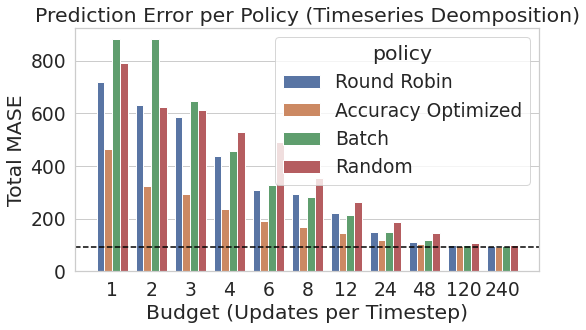

In [318]:
plot_df = pd.read_csv(f"{result_dir}/simulation_results.csv")
plot_df["updates"] = plot_df.runtime.apply(lambda r: int(24/r) if r > 0 else "infinity")
plot_df["total_error"] = plot_df.total_error #/ 66

sns.set_theme(style="whitegrid", font_scale=1.7)
plot_df.policy = plot_df.policy.map({"round_robin": "Round Robin", "total_error": "Accuracy Optimized", "batch": "Batch", "random": "Random"})

g = sns.barplot(x="updates", y="total_error", hue="policy", data=plot_df)
g.set(title="Prediction Error per Policy (Timeseries Deomposition)", xlabel="Budget (Updates per Timestep)",  ylabel="Total MASE")
log = False

upper_bound = baseline_results_df[baseline_results_df["policy"] == "All"].total_error.iloc[0]
upper_bound_updates = baseline_results_df[baseline_results_df["policy"] == "All"].total_updates.iloc[0]
lower_bound = baseline_results_df[baseline_results_df["policy"] == "None"].total_error.iloc[0]
lower_bound_updates = baseline_results_df[baseline_results_df["policy"] == "None"].total_updates.iloc[0]
print(upper_bound, upper_bound_updates)
    
if log: 
    plt.axline((0, np.log2(upper_bound)), (1, np.log2(upper_bound)), color='black', linestyle="--")
else:
    plt.axline((0, upper_bound), (1, upper_bound), color='black', linestyle="--")
        
#plt.axvline(upper_bound_updates, color='black', linestyle="--")
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/yahoo_a1_results_bar.pdf')  

In [3]:
import pandas as pd 

plot_df = pd.read_csv(f"{result_dir}/simulation_results.csv")
print(plot_df)
sns.set_theme(style="whitegrid", font_scale=1.7)
plot_df.policy = plot_df.policy.map({"round_robin": "Round Robin", "total_error": "Accuracy Optimized", "batch": "Batch"})

g = sns.lineplot(x="total_updates", y="total_error", hue="policy", data=plot_df)
g.set(title="Policy Accuracy (Timeseries Deomposition)", xlabel="Total Featurization Updates",  ylabel="Total MASE")

g.set_yscale('log')
log = False

upper_bound = baseline_results_df[baseline_results_df["policy"] == "All"].total_error.iloc[0]
upper_bound_updates = baseline_results_df[baseline_results_df["policy"] == "All"].total_updates.iloc[0]
lower_bound = baseline_results_df[baseline_results_df["policy"] == "None"].total_error.iloc[0]
lower_bound_updates = baseline_results_df[baseline_results_df["policy"] == "None"].total_updates.iloc[0]
print(upper_bound, upper_bound_updates)
    
if log: 
    plt.axline((0, np.log2(upper_bound)), (1, np.log2(upper_bound)), color='black', linestyle="--")
else:
    plt.axline((0, upper_bound), (1, upper_bound), color='black', linestyle="--")
    plt.axline((0, lower_bound), (1, lower_bound), color='black', linestyle="--")
    
plt.tight_layout()
#plt.axvline(upper_bound_updates, color='black', linestyle="--")
plt.savefig('/data/wooders/ralf-vldb/plots/yahoo_a1_results_line.pdf')  

NameError: name 'result_dir' is not defined

    Unnamed: 0.1  Unnamed: 0  runtime       policy  total_error  \
0              0           0      0.5  round_robin   112.843540   
1              0           0      0.5  total_error   103.929800   
2              0           0      0.5        batch   120.297111   
3              0           0      0.2  round_robin    99.068206   
4              0           0      0.2  total_error    94.458978   
5              0           0      0.2        batch    99.261802   
6              0           0      0.1  round_robin    95.256301   
7              0           0      0.1  total_error    92.905678   
8              0           0      0.1        batch    95.746489   
9              0           0      1.0  round_robin   148.433302   
10             0           0      1.0  total_error   119.688026   
11             0           0      1.0        batch   149.894408   
12             0           0      2.0  round_robin   222.217542   
13             0           0      2.0  total_error   146.00916

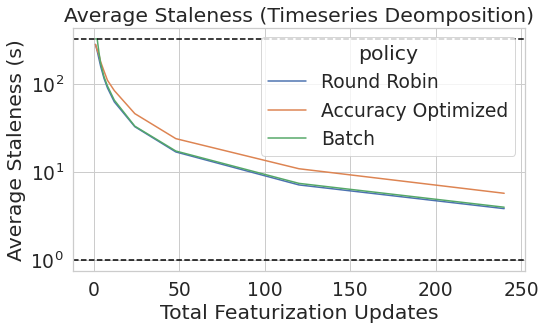

In [279]:
plot_df = pd.read_csv(f"{result_dir}/simulation_results.csv")
plot_df["updates"] = plot_df.runtime.apply(lambda r: int(24/r) if r > 0 else "infinity")
plot_df["total_error"] = plot_df.total_error #/ 66

print(plot_df)
sns.set_theme(style="whitegrid", font_scale=1.7)
plot_df.policy = plot_df.policy.map({"round_robin": "Round Robin", "total_error": "Accuracy Optimized", "batch": "Batch"})

g = sns.lineplot(x="updates", y="average_staleness", hue="policy", data=plot_df)
g.set(title="Average Staleness (Timeseries Deomposition)", xlabel="Total Featurization Updates",  ylabel="Average Staleness (s)")
g.set_yscale('log')
log = False

upper_bound = baseline_results_df[baseline_results_df["policy"] == "All"].average_staleness.iloc[0]
upper_bound_updates = baseline_results_df[baseline_results_df["policy"] == "All"].total_updates.iloc[0]
lower_bound = baseline_results_df[baseline_results_df["policy"] == "None"].average_staleness.iloc[0]
lower_bound_updates = baseline_results_df[baseline_results_df["policy"] == "None"].total_updates.iloc[0]
print(upper_bound, upper_bound_updates)
    
if log: 
    plt.axline((0, np.log2(upper_bound)), (1, np.log2(upper_bound)), color='black', linestyle="--")
else:
    plt.axline((0, upper_bound), (1, upper_bound), color='black', linestyle="--")
    plt.axline((0, lower_bound), (1, lower_bound), color='black', linestyle="--")
   
plt.tight_layout()
#plt.axvline(upper_bound_updates, color='black', linestyle="--")
plt.savefig('/data/wooders/ralf-vldb/plots/yahoo_a1_results_line_staleness.pdf')

In [251]:
updates_df = pd.concat([
    pd.read_csv(f"{result_dir}/{p}_{r}_A1/simulation_update_time.csv")
    for r in runtime for p in policy
])
updates_df

Unnamed: 0  runtime       policy   key    i   time
0           0      0.5  round_robin   1.0  0.0   48.0
1           1      0.5  round_robin   1.0  1.0   82.0
2           2      0.5  round_robin   1.0  2.0  115.0
3           3      0.5  round_robin   1.0  3.0  148.0
4           4      0.5  round_robin   1.0  4.0  181.0
..        ...      ...          ...   ...  ...    ...
23         23     24.0  total_error  11.0  0.0  600.0
24         24     24.0  total_error  31.0  0.0  624.0
25         25     24.0  total_error  16.0  0.0  648.0
26         26     24.0  total_error  32.0  0.0  672.0
27         27     24.0  total_error  60.0  0.0  696.0

[37328 rows x 6 columns]

In [252]:
updates_df.policy.value_counts()

round_robin    12701
total_error    12701
batch          11926
Name: policy, dtype: int64

[Text(0.5, 1.0, 'Distribution of Updates Across Keys'),
 Text(0.5, 0, 'Scheduled Updates per Key'),
 Text(0, 0.5, 'Number Keys')]

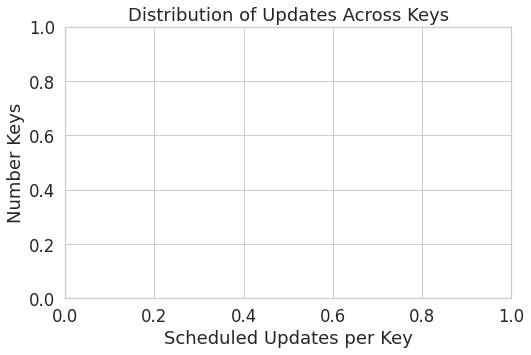

In [253]:
runtime = 0.05
sns.set(rc={'figure.figsize':(8, 5)})
hist_df = updates_df[updates_df["runtime"] == runtime].groupby(by=["key", "policy"]).size()
hist_df = hist_df.to_frame(name="updates").reset_index()
#hist_df["policy"] = hist_df.policy.map({'total_error': 'Accuracy Optimized', 'round_robin': 'Baseline', 'avg_error': '(Avg) Accuracy Optimized'})

sns.set_theme(style="whitegrid", font_scale=1.5)
g = sns.histplot(data=hist_df, x="updates", hue="policy", log_scale=(False, True), discrete=True)
g.set(title="Distribution of Updates Across Keys", xlabel="Scheduled Updates per Key",  ylabel="Number Keys")

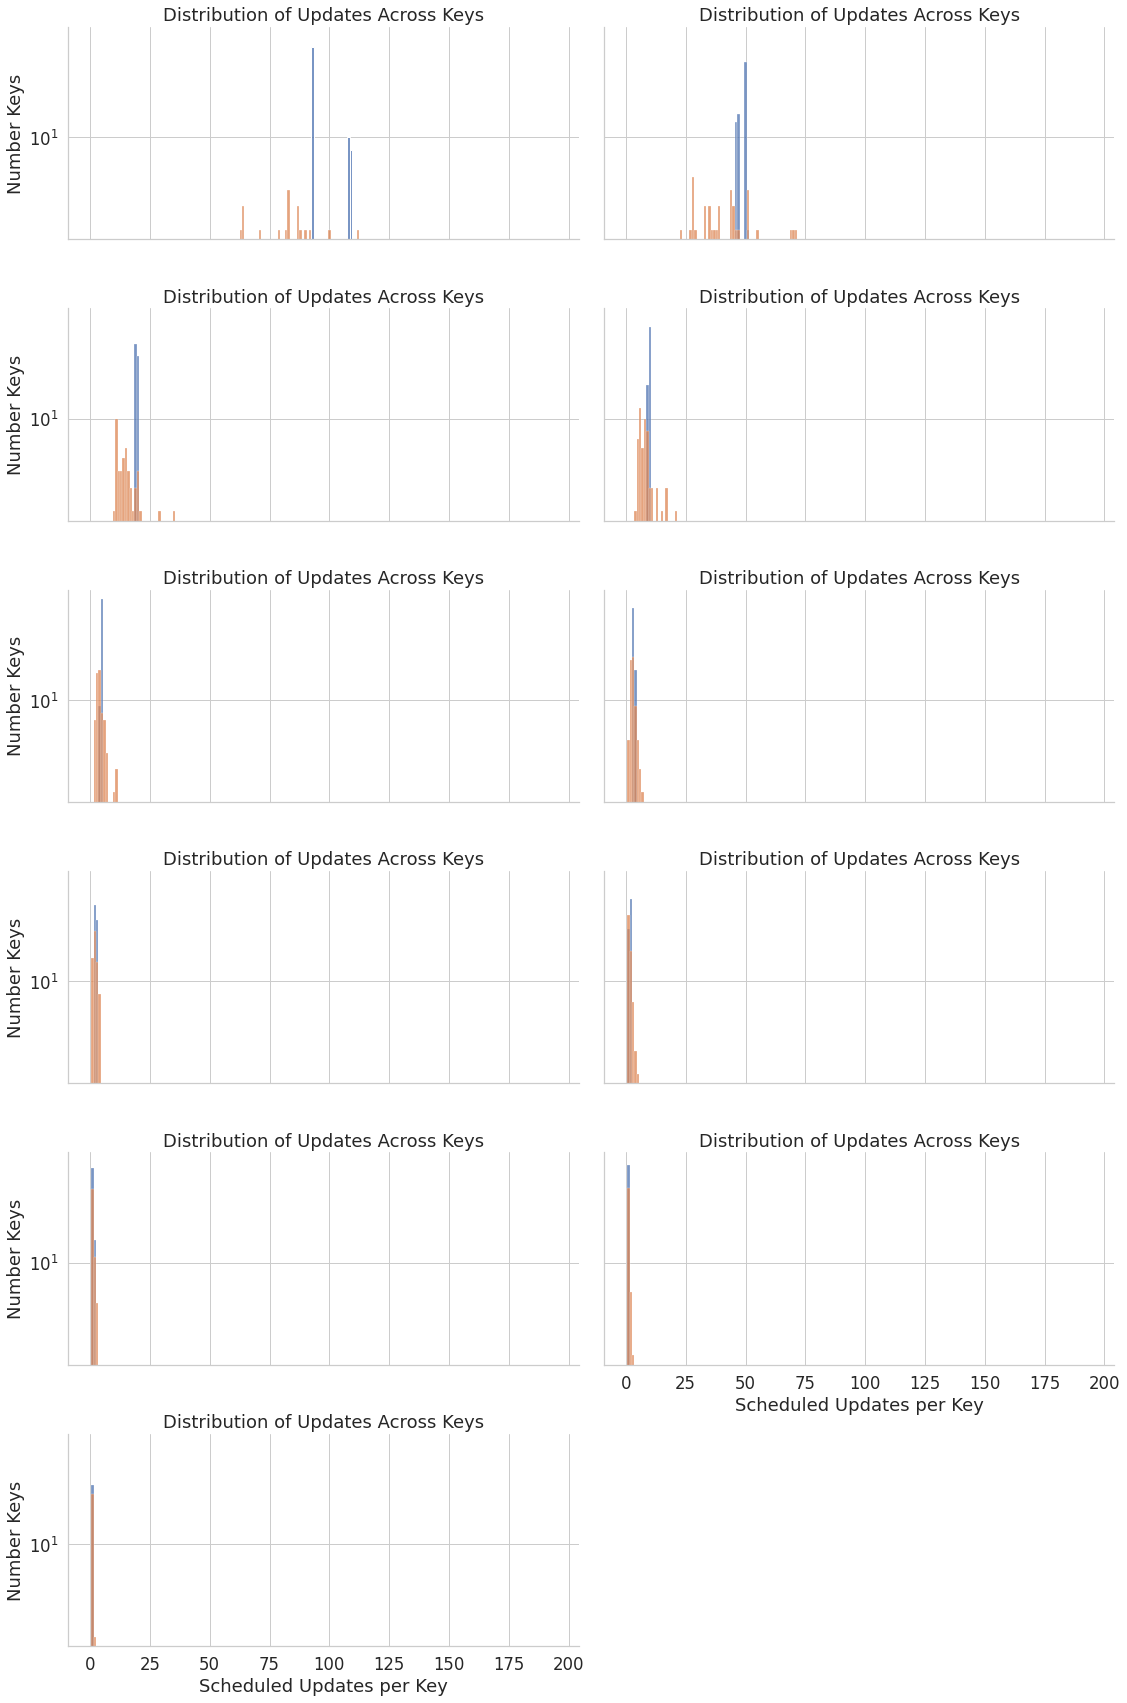

In [254]:
hist_df = updates_df.groupby(by=["key", "policy", "runtime"]).size()
hist_df = hist_df.to_frame(name="updates").reset_index()
hist_df["policy"] = hist_df.policy.map({'total_error': 'Accuracy Optimized', 'round_robin': 'Baseline'})

g = sns.FacetGrid(hist_df, col="runtime", hue="policy", col_wrap=2, height=4, aspect=2)
g.map(sns.histplot, "updates", log_scale=(False, True), discrete=True)
g.set(title="Distribution of Updates Across Keys", xlabel="Scheduled Updates per Key",  ylabel="Number Keys")

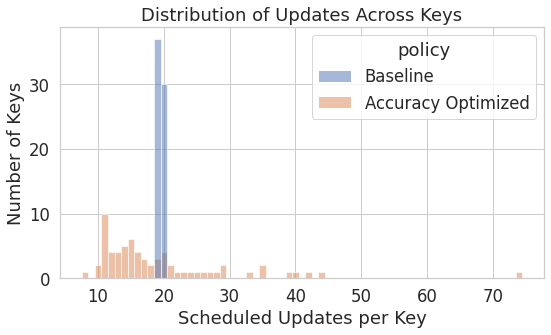

In [261]:
runtime = 0.5
hist_df = updates_df[updates_df["runtime"] == runtime].groupby(by=["key", "policy"]).size()
hist_df = hist_df.to_frame(name="updates").reset_index()
hist_df["policy"] = hist_df.policy.map({'total_error': 'Accuracy Optimized', 'round_robin': 'Baseline'})

sns.set_theme(style="whitegrid", font_scale=1.5)
g = sns.histplot(data=hist_df, x="updates", hue="policy", log_scale=(False, False), discrete=True)
g.set(title="Distribution of Updates Across Keys", xlabel="Scheduled Updates per Key",  ylabel="Number of Keys")

plt.tight_layout()
plt.savefig(f'/data/wooders/ralf-vldb/plots/yahoo_a1_update_dist_{runtime}.pdf')

In [229]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()


d = updates_df[updates_df["policy"] == "round_robin"].groupby(["key", "runtime", "policy"]).size().unstack("key", fill_value=0)
d

key                  +/+wHEptfMc4BDHAIVviKFJGJSp8tUMfdp0xxMyhgUIfBVWG/eQqbgNStNUGHusE  \
runtime policy                                                                          
0.1     round_robin                                                  3                  
0.2     round_robin                                                  2                  
0.5     round_robin                                                  1                  
1.0     round_robin                                                  1                  

key                  +/xSb3UfIhJmIM0B03TBsa1t8mT621pu2jIUJ3viMmg5teOK8WywQnqZlht1TaOr  \
runtime policy                                                                          
0.1     round_robin                                                  3                  
0.2     round_robin                                                  2                  
0.5     round_robin                                                  1                  
1.0     round_robin                                                  1                  

key                  +2NL56xf9VZLUNZs4/MtQC379HR1Wn/C0gT1N1SzgKlWvfmgPnMbTQ9FsqJz1Bms  \
runtime policy                                                                          
0.1     round_robin                                                  3                  
0.2     round_robin                                                  2                  
0.5     round_robin                                                  1                  
1.0     round_robin                                                  1                  

key                  +3Cp6Gxn0cudQCoujV99+xiRXwJvnq6zNqTsehx/pfKA5BBwBIvl3qw7y9BTxjUU  \
runtime policy                                                                          
0.1     round_robin                                                  3                  
0.2     round_robin                                                  1                  
0.5     round_robin                                                  0                  
1.0     round_robin                                                  0                  

key                  +DW7QowuLW4XjatBSQ9rRwelswYDWCyvKsAq7KxdCUfQvuhsybOYXErFwb96fV6k  \
runtime policy                                                                          
0.1     round_robin                                                  2                  
0.2     round_robin                                                  1                  
0.5     round_robin                                                  0                  
1.0     round_robin                                                  0                  

key                  +UyIfWOy0T5eNXymeUGT8hGZv+KqiA/s5km2TilzguZhWuwYlEu8ukcIR5UJBMOu  \
runtime policy                                                                          
0.1     round_robin                                                  3                  
0.2     round_robin                                                  1                  
0.5     round_robin                                                  1                  
1.0     round_robin                                                  0                  

key                  +cJKblarivgmU0CfpoCnzTL397g6j8TSrWo84+msEOKPIf4myQFhnk9AxMbuIjCo  \
runtime policy                                                                          
0.1     round_robin                                                  2                  
0.2     round_robin                                                  1                  
0.5     round_robin                                                  0                  
1.0     round_robin                                                  0                  

key                  +j/UOvABLr7M83rLa+a2CMVfKnH4lJI99NX1RDi+diqcjuk+5aaUKuY6RYujKNnN  \
runtime policy                                                                          
0.1     round_robin                                                  2       

In [230]:
d.reindex(d.mean().sort_values(ascending=False).index, axis=1)

key                  +/+wHEptfMc4BDHAIVviKFJGJSp8tUMfdp0xxMyhgUIfBVWG/eQqbgNStNUGHusE  \
runtime policy                                                                          
0.1     round_robin                                                  3                  
0.2     round_robin                                                  2                  
0.5     round_robin                                                  1                  
1.0     round_robin                                                  1                  

key                  Pp3GfZbNQR1wuhHrIuNxzUDt7uyU1qZooI/0R6s+dPidCWM+KXDCZb+fuf5TpyHj  \
runtime policy                                                                          
0.1     round_robin                                                  3                  
0.2     round_robin                                                  2                  
0.5     round_robin                                                  1                  
1.0     round_robin                                                  1                  

key                  +/xSb3UfIhJmIM0B03TBsa1t8mT621pu2jIUJ3viMmg5teOK8WywQnqZlht1TaOr  \
runtime policy                                                                          
0.1     round_robin                                                  3                  
0.2     round_robin                                                  2                  
0.5     round_robin                                                  1                  
1.0     round_robin                                                  1                  

key                  Rr4E/PSB8N1o0kwO4/+NIc15U0afIQuBK3sgrVEzi0NZYA3JMBZDaMr0F7nghFag  \
runtime policy                                                                          
0.1     round_robin                                                  3                  
0.2     round_robin                                                  2                  
0.5     round_robin                                                  1                  
1.0     round_robin                                                  1                  

key                  Rqf/CQmAm/NDwWCz/nMhXjpocvyD3wej0ng7K6w3E39yr2yQi8dSLoR7U59GCqSy  \
runtime policy                                                                          
0.1     round_robin                                                  3                  
0.2     round_robin                                                  2                  
0.5     round_robin                                                  1                  
1.0     round_robin                                                  1                  

key                  RkY7xJ9+OZZE0tB9nJJxO4+m5gcv1vJD3VgV50oPlEqkw8W7qim5nMnPNJZCrnPK  \
runtime policy                                                                          
0.1     round_robin                                                  3                  
0.2     round_robin                                                  2                  
0.5     round_robin                                                  1                  
1.0     round_robin                                                  1                  

key                  RQCh3mLGLy+M78zafnYwCFm122XBgS5NaNftv/5zHboZarJN7stn6QG0BvHppdGj  \
runtime policy                                                                          
0.1     round_robin                                                  3                  
0.2     round_robin                                                  2                  
0.5     round_robin                                                  1                  
1.0     round_robin                                                  1                  

key                  RKo6mNYHVRKwg37pzk080tzsJevbYkadB2Zax7ggLZm7acZ7B++5mb8nMRoFzwCQ  \
runtime policy                                                                          
0.1     round_robin                                                  3       

In [100]:
d_rr = updates_df[updates_df["policy"] == "round_robin"].groupby(["key", "runtime", "policy"]).size().unstack("key", fill_value=0)
d_rr = d_rr.reindex(d_rr.mean().sort_values(ascending=False).index, axis=1)

d_te = updates_df[updates_df["policy"] == "total_error"].groupby(["key", "runtime", "policy"]).size().unstack("key", fill_value=0)
d_te = d_te.reindex(d_te.mean().sort_values(ascending=False).index, axis=1)

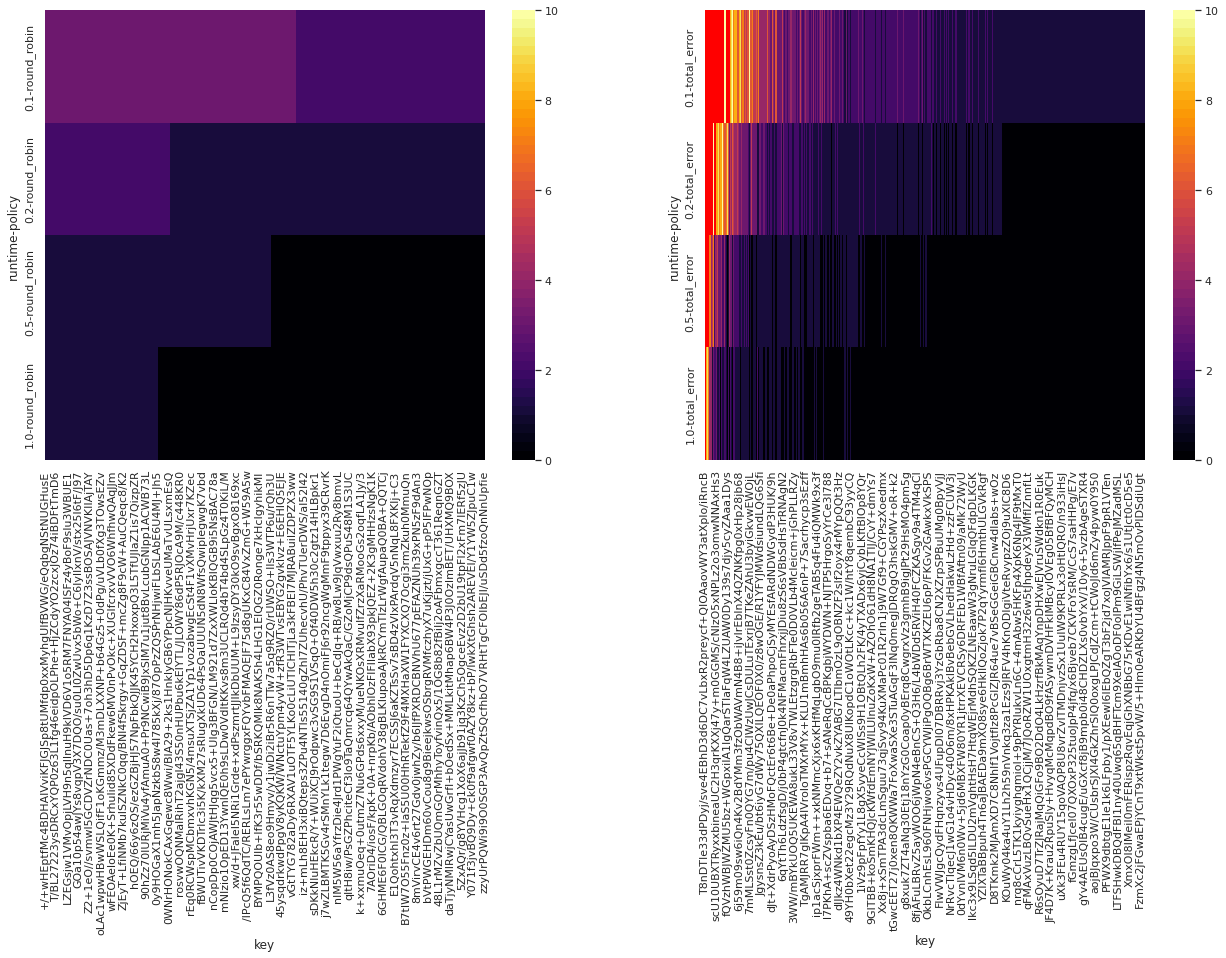

In [110]:
fig, (ax1, ax2) = plt.subplots(1,2)

cmap = plt.get_cmap('inferno', 50)
cmap.set_under('white')#Colour values less than vmin in white
cmap.set_over('red')# colour valued larger than vmax in red

sns.heatmap(d_rr, ax=ax1, vmin=0, vmax=10, cmap=cmap)
sns.heatmap(d_te, ax=ax2, vmin=0, vmax=10, cmap=cmap)
plt.show()

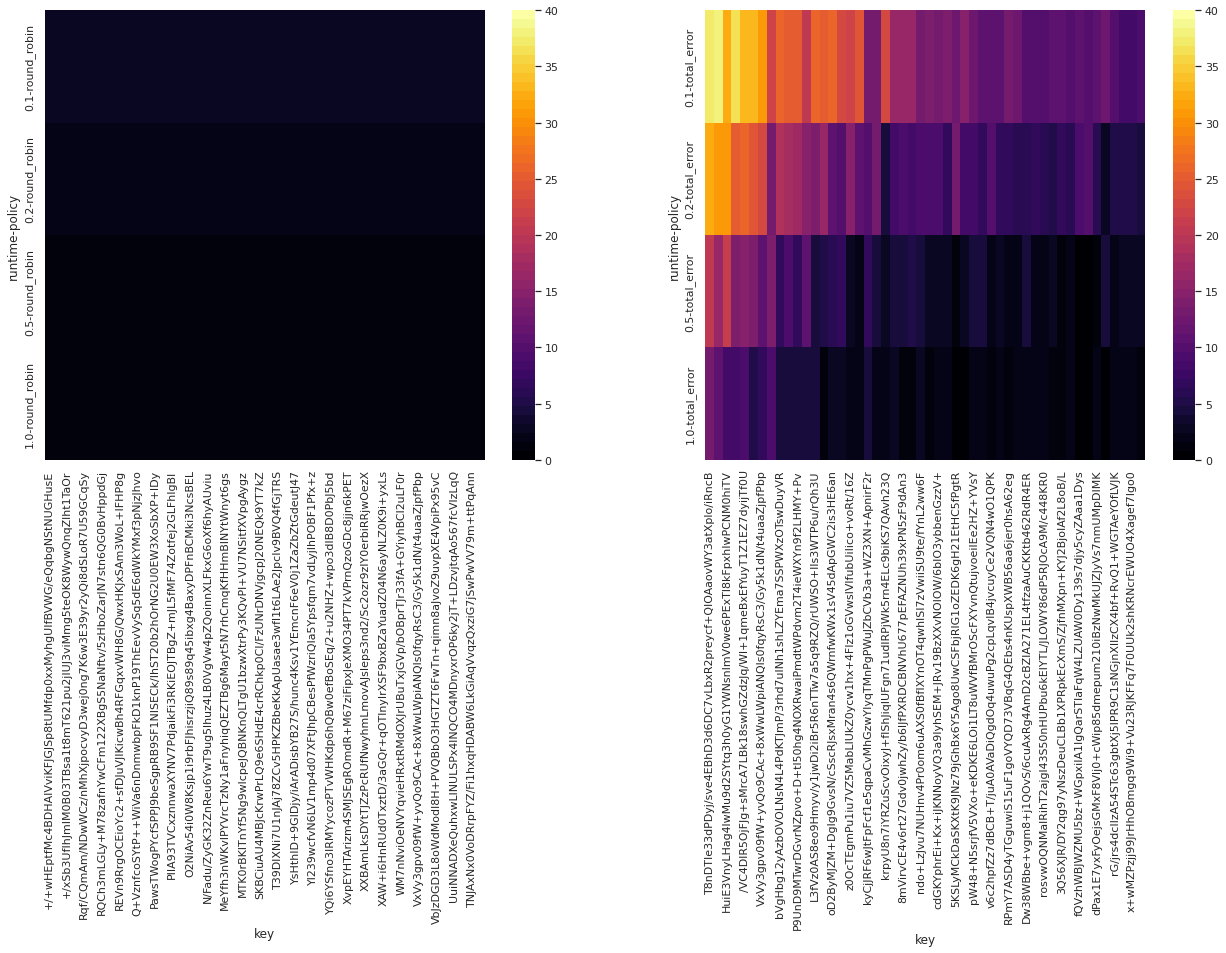

In [114]:
fig, (ax1, ax2) = plt.subplots(1,2)

cmap = plt.get_cmap('inferno', 50)
cmap.set_under('white')#Colour values less than vmin in white
cmap.set_over('red')# colour valued larger than vmax in red

sns.heatmap(d_rr.iloc[: , :50], ax=ax1, vmin=0, vmax=40, cmap=cmap)
sns.heatmap(d_te.iloc[: , :50], ax=ax2, vmin=0, vmax=40, cmap=cmap)
plt.show()

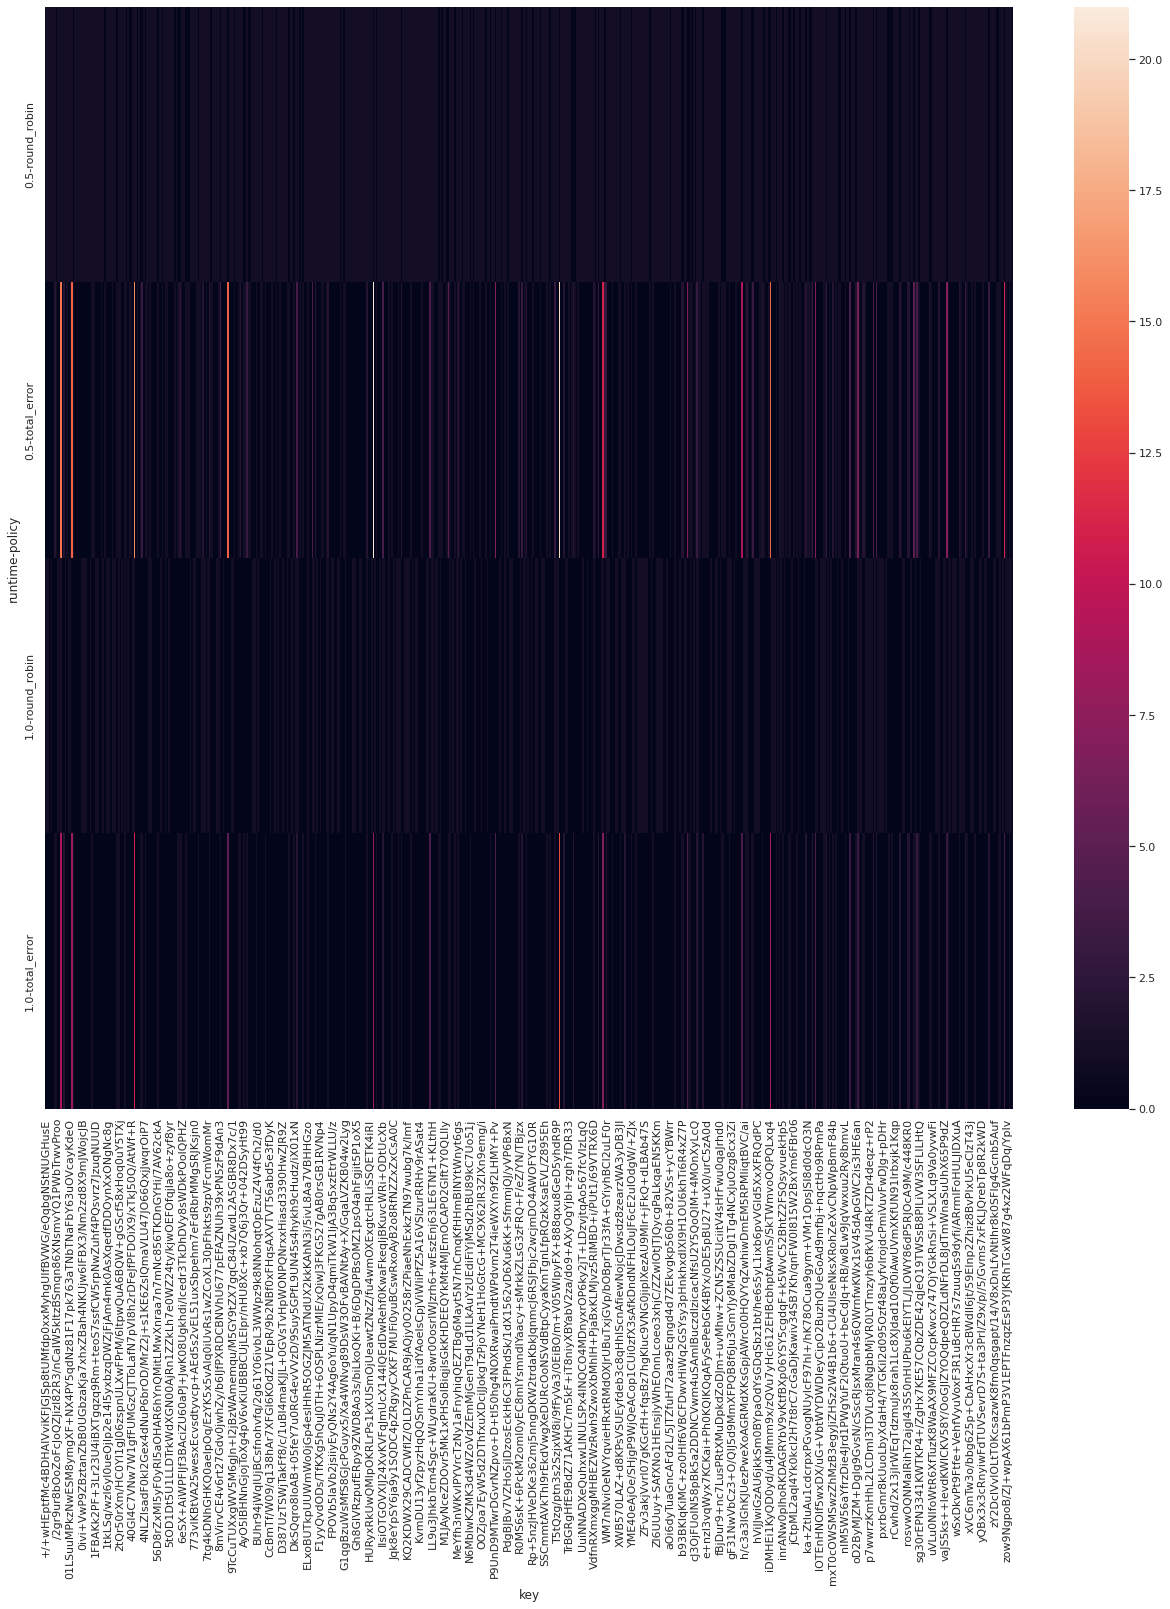

In [64]:
ax = sns.heatmap(d)

In [51]:
updates_df

Empty DataFrame
Columns: []
Index: []

In [119]:
sns.set(rc={'figure.figsize':(6.7,5.27)})